In [1]:
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import concatenate
# from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras import callbacks
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split


def OverlapSegmentationNet(input_tensor=None, input_shape=None, pooling=None):

    

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x_1a = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x_1a)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x_2a = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x_2a)


    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)

    x_2b = Conv2DTranspose(128, (2, 2), strides=(2, 2), input_shape=(None,23, 23, 1), name='block3_deconv1')(x)

    # Deconv Block 1
    x = concatenate([x_2a, x_2b])#, axis=-1)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', name='dblock1_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='dblock1_conv2')(x)
    x_1b = Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), name='dblock1_deconv')(x)

    # Deconv Block 2
    x = concatenate([x_1a, x_1b], input_shape=(None,92, 92, None))#, axis=-1, name='dbock2_concat') # keras.layers.concatenate([encoded_a, encoded_b], axis=-1)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='dblock2_conv2')(x)
    # Output convolution. Number of filters should equal number of channels of the output
    x = Conv2D(4, (1, 1), activation=None, padding='same', name='dblock2_conv3')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model
    model = Model(inputs, x, name='OverlapSegmentationNet')


    return model

In [2]:

def plotSamplesOneHots(labels_of_samples, output_file=False):
    '''
    labels_of_samples of shape (num_samples, x, y, num_onehots)
    '''
    if len(labels_of_samples.shape) != 4:
        print("Incorrect input size - should be (num_samples, x, y, num_onehots)")
    num_samples = labels_of_samples.shape[0]
    print(num_samples)
    num_onehots = labels_of_samples.shape[-1]
    print(num_onehots)
    figure_size = (4*num_onehots, 4*num_samples)
    fig, ax = plt.subplots(num_samples, num_onehots, sharex=True, sharey=True, figsize=figure_size)
    for i in range(num_samples):
        for j in range(num_onehots):
            ax[i, j].imshow(labels_of_samples[i,...,j], aspect="auto")
    fig.tight_layout()
    plt.show()
    if output_file == True:
        fig.savefig(output_file)



def oneHotEncode(initial_array):
    '''
    One hot encode the labels
    '''
    allowed_max_class_num = 3
    output_shape = list(initial_array.shape)
    output_shape[-1] = initial_array.max()
    output_array_dims = list(initial_array.shape)
    output_array_dims.append(4)
    output_array = np.zeros(output_array_dims)
    for image_i in range(0, initial_array.shape[0]):
        for class_num in range(0, allowed_max_class_num):
            for x in range(0, initial_array.shape[1]):
                for y in range(0, initial_array.shape[2]):
                    if initial_array[image_i, x, y] == class_num:
                        output_array[image_i, x, y, class_num] = 1

        class_num = allowed_max_class_num
        for x in range(0, initial_array.shape[1]):
            for y in range(0, initial_array.shape[2]):
                if initial_array[image_i, x, y] >= allowed_max_class_num:
                    output_array[image_i, x, y, class_num] = 1
    return output_array


def findNearestNeighbourLabel(array):
    center = int(array.shape[0]/2)
    labels_count = np.zeros(5)
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            if (x != center) or (y != center):
                temp_label = array[x, y]
                labels_count[temp_label] += 1
    return labels_count.argmax()
    

def cleanLabelNearestNeighbour(label):
    '''
    Corrects incorrect labels in a single image based on a threshold on the number of 
    nearest neighbours with the same label
    '''
    x_length = label.shape[0]
    y_length = label.shape[1]
    num_of_classes = 4
    cleaned_labels = np.zeros((x_length, y_length, 4))
    for x in range(1,x_length-1):
        for y in range(1, y_length-1):
            temp_label = label[x,y]
            if temp_label >3: # if labeled as 4 or above
                temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                cleaned_labels[x, y, temp_label] = 1
            elif temp_label > 0:
                num_labels_in_3x3 = len(np.where(label[(x-1):(x+2), (y-1):(y+2)]==temp_label)[0])
                if num_labels_in_3x3 > 3:
                    cleaned_labels[x, y, temp_label] = 1
                else:
                    temp_label = findNearestNeighbourLabel(label[(x-1):(x+2), (y-1):(y+2)])
                    cleaned_labels[x, y, temp_label] = 1
        non_zero_array = cleaned_labels[..., 1:].sum(axis=2).astype('bool')
        cleaned_labels[..., 0] = np.ones((x_length, y_length), dtype='bool')^non_zero_array
    return cleaned_labels

def cleanLabelNearestNeighbour_alllabels(labels):    
    '''
    Cleans incorrect labels
    '''
    num_labels = labels.shape[0]
    num_of_classes = 4
    cleaned_dim = list(labels.shape)
    cleaned_dim.append(num_of_classes)
    cleaned_labels = np.zeros(cleaned_dim)
    for image_i in range(num_labels):
        print('Preprocessing image %d of %d' % (image_i, num_labels))
        cleaned_labels[image_i,...] = cleanLabelNearestNeighbour(labels[image_i, ...])
    return cleaned_labels


def label012Chromosomes(labels):
    '''
    Input array of (num_samples, x, y, 4)
    Returns array of (num_samples, x, y, 3) where chromosome A and chromosome B are merged
    '''
    labels[...,1] = labels[...,1:3].sum(axis=-1)
    return labels[...,[0,1,3]]
    

def makeXbyY(data, X, Y):
    '''
    Crop data to size X by Y
    '''
    if len(data.shape) < 3:
        print('Input should be of size (num_samples, x, y,...)')
    data_x_start = int((data.shape[1]-X)/2)
    data_y_start = int((data.shape[1]-Y)/2)
    arrayXbyY = data[:, (data_x_start):(data_x_start + X), (data_y_start):(data_y_start + Y),...]
    return arrayXbyY

def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    if len(y_pred.shape) < 3 or (y_pred.shape[2]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[2]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)

def meanIOU(y_pred, y_true):
    '''
    Calculate the mean IOU, with the mean taken over classes
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return sum(IUs)/len(IUs)
	
def IOU(y_pred, y_true):
    '''
    Calculate the IOU for each class seperately
    '''
    if len(y_pred.shape) < 4 or (y_pred.shape[3]<4):
        print('Wrong dimensions: one hot encoding expected')
        return
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    IUs = []
    for layer in range(y_true.shape[3]):
        intersection = y_pred[...,layer] & y_true[...,layer]
        union = y_pred[...,layer] | y_true[...,layer]
        if union.sum() == 0:
            IUs.append(1)
        else:
            IUs.append(intersection.sum()/union.sum())
    return IUs

def globalAccuracy(y_pred, y_true):
    '''
    Calculate the global accuracy (ie. percent of pixels correctly labelled)
    '''
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    correct = y_pred & y_true
    num_correct = correct.sum()
    num_total = 1
    for dim in y_true.shape[0:-1]:
        num_total = num_total*dim
    return num_correct/num_total

In [3]:
# Load HD5F file
h5f = h5py.File('rcc_data_v1_preprocessed.h5','r')
xdata = h5f['rcc_data'][...,0]
labels = h5f['rcc_data'][...,1]
print(labels.shape)
h5f.close()

# Clean labels
labels = cleanLabelNearestNeighbour_alllabels(labels)

# Crop to 88x88 pixels and save processed numpy arrays
labels = makeXbyY(labels, 88, 88)
np.save('ydata_88x88_0123_onehot', labels)
xdata = makeXbyY(xdata, 88, 88).reshape((500,88,88, 1))
np.save('xdata_88x88', xdata)


(500, 94, 93)
Preprocessing image 0 of 500
Preprocessing image 1 of 500
Preprocessing image 2 of 500
Preprocessing image 3 of 500
Preprocessing image 4 of 500
Preprocessing image 5 of 500
Preprocessing image 6 of 500
Preprocessing image 7 of 500
Preprocessing image 8 of 500
Preprocessing image 9 of 500
Preprocessing image 10 of 500
Preprocessing image 11 of 500
Preprocessing image 12 of 500
Preprocessing image 13 of 500
Preprocessing image 14 of 500
Preprocessing image 15 of 500
Preprocessing image 16 of 500
Preprocessing image 17 of 500
Preprocessing image 18 of 500
Preprocessing image 19 of 500
Preprocessing image 20 of 500
Preprocessing image 21 of 500
Preprocessing image 22 of 500
Preprocessing image 23 of 500
Preprocessing image 24 of 500
Preprocessing image 25 of 500
Preprocessing image 26 of 500
Preprocessing image 27 of 500
Preprocessing image 28 of 500
Preprocessing image 29 of 500
Preprocessing image 30 of 500
Preprocessing image 31 of 500
Preprocessing image 32 of 500
Prepro

13/13 [==============================] - 2s 120ms/step - loss: 31.6531 - val_loss: 0.6456
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modelunet/savedmodel_0epoch\assets
4
4


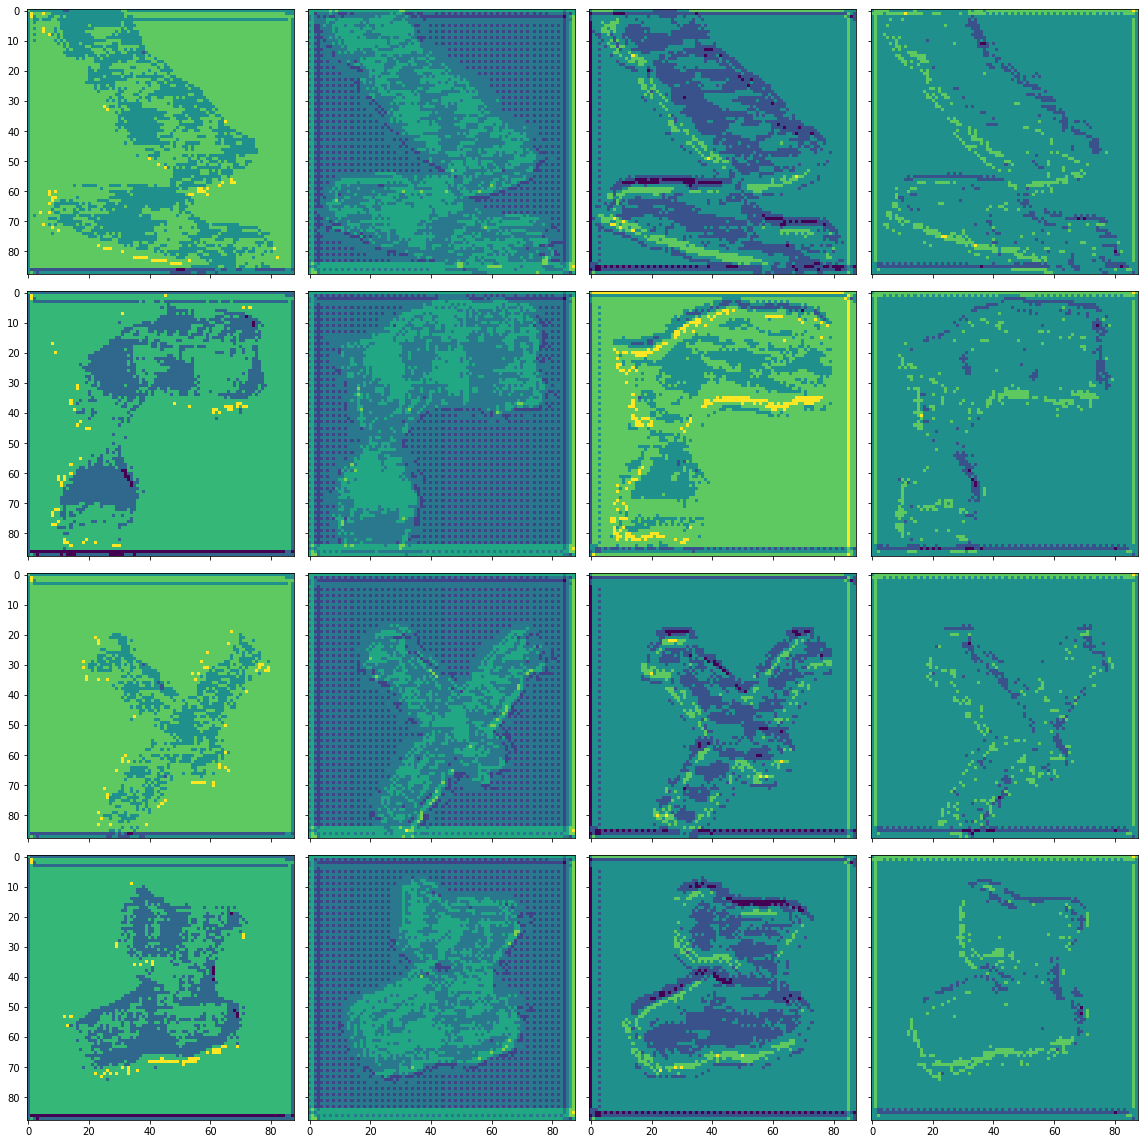

Training IOU: [0.7693294521714362, 0.07802353147369198, 0.07817675739291252, 0.01357455740098558]
Training accuracy: 0.7942084194214876
Testing IOU: [0.7902493511811213, 0.07240088428560959, 0.0720803490328633, 0.009395722240805966]
Testing accuracy: 0.8028589876033058
13/13 [==============================] - 1s 66ms/step - loss: 0.2937 - val_loss: 0.1581
INFO:tensorflow:Assets written to: modelunet/savedmodel_1epoch\assets
4
4


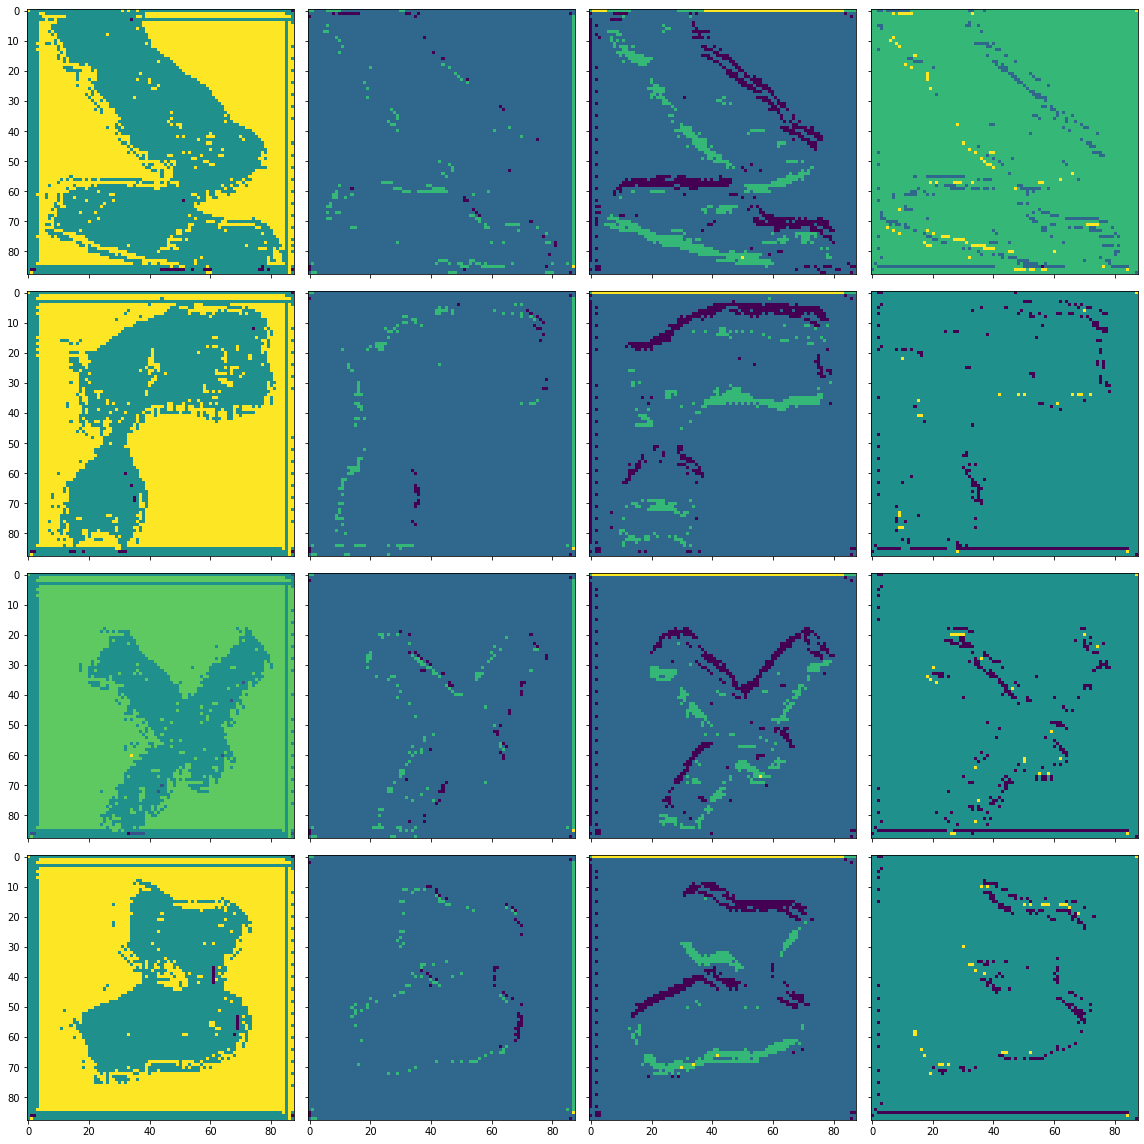

Training IOU: [0.7480088640923402, 0.03934993153491719, 0.12677876845536473, 0.006637493024758436]
Training accuracy: 0.604099625516529
Testing IOU: [0.7562425899091029, 0.039011735237429145, 0.11923602645092173, 0.003851731013231829]
Testing accuracy: 0.6202944214876033
13/13 [==============================] - 1s 66ms/step - loss: 0.1383 - val_loss: 0.1043
INFO:tensorflow:Assets written to: modelunet/savedmodel_2epoch\assets
4
4


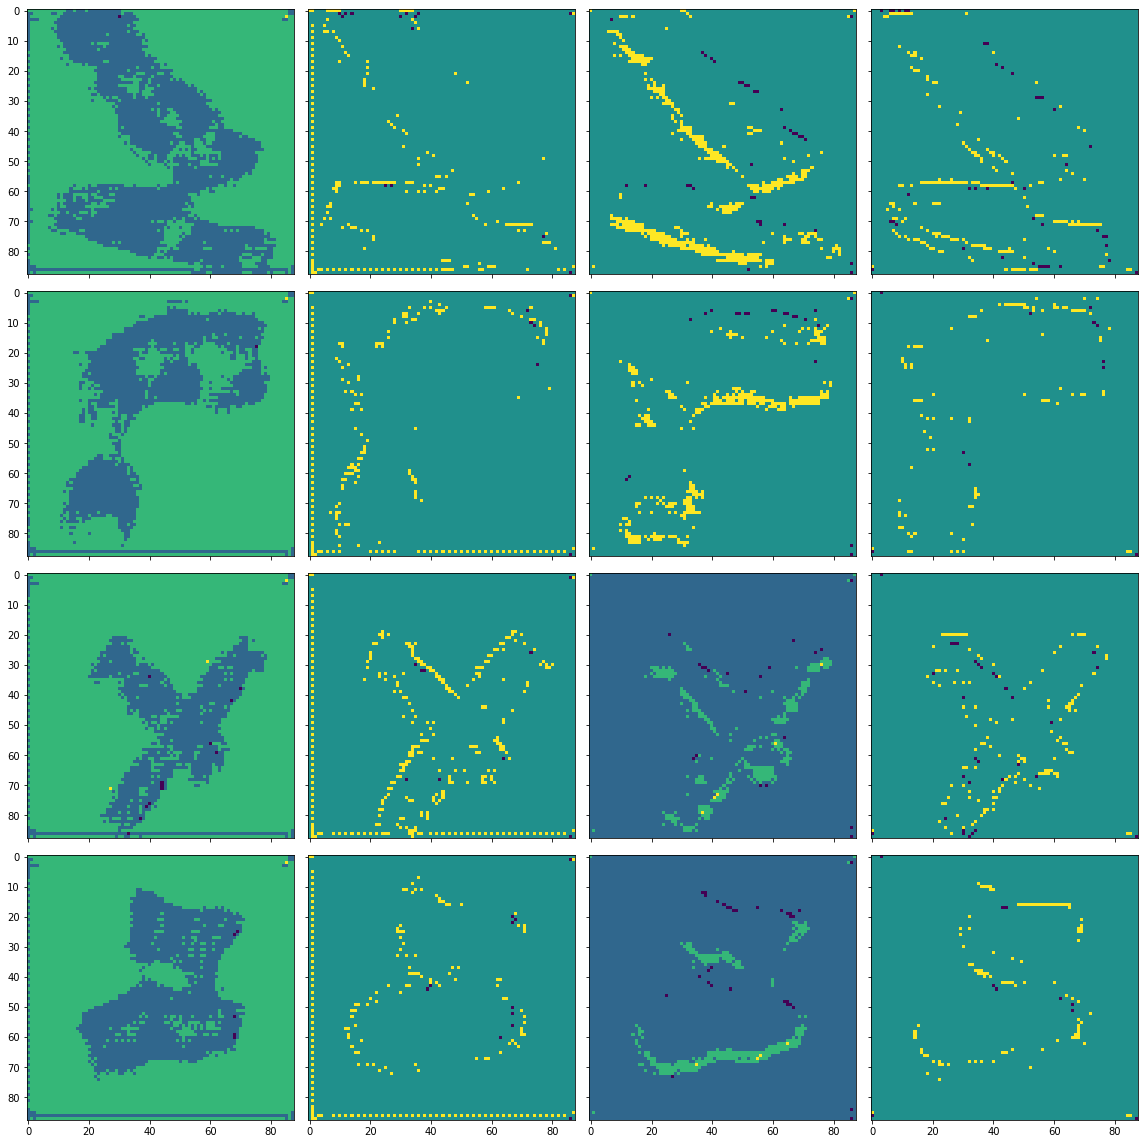

Training IOU: [0.8678238768302122, 0.03367226745537213, 0.12676971731425088, 0.006615783169447617]
Training accuracy: 0.7132476756198347
Testing IOU: [0.8783793521443863, 0.031962089954655014, 0.1150902399874721, 0.003530389035026997]
Testing accuracy: 0.7287099690082645
13/13 [==============================] - 1s 66ms/step - loss: 0.0950 - val_loss: 0.0748
INFO:tensorflow:Assets written to: modelunet/savedmodel_3epoch\assets
4
4


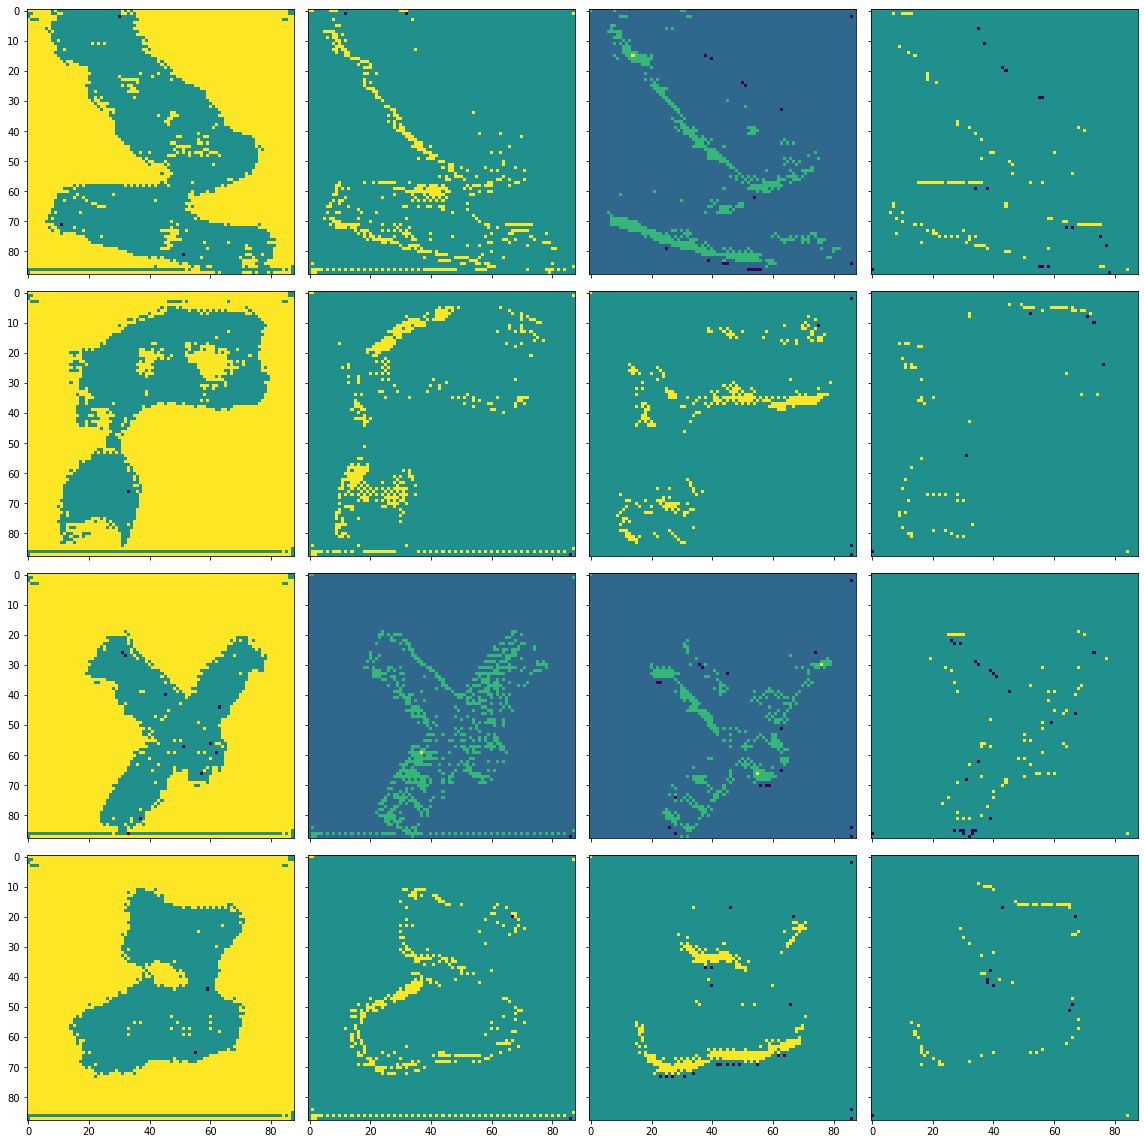

Training IOU: [0.9112339328132604, 0.12481237710700509, 0.12873267576846675, 0.005308668530866853]
Training accuracy: 0.7337742122933885
Testing IOU: [0.9157339395576264, 0.11401507676520503, 0.1069918896507089, 0.001923329107837566]
Testing accuracy: 0.7460343491735537
13/13 [==============================] - 1s 66ms/step - loss: 0.0744 - val_loss: 0.0639
INFO:tensorflow:Assets written to: modelunet/savedmodel_4epoch\assets
4
4


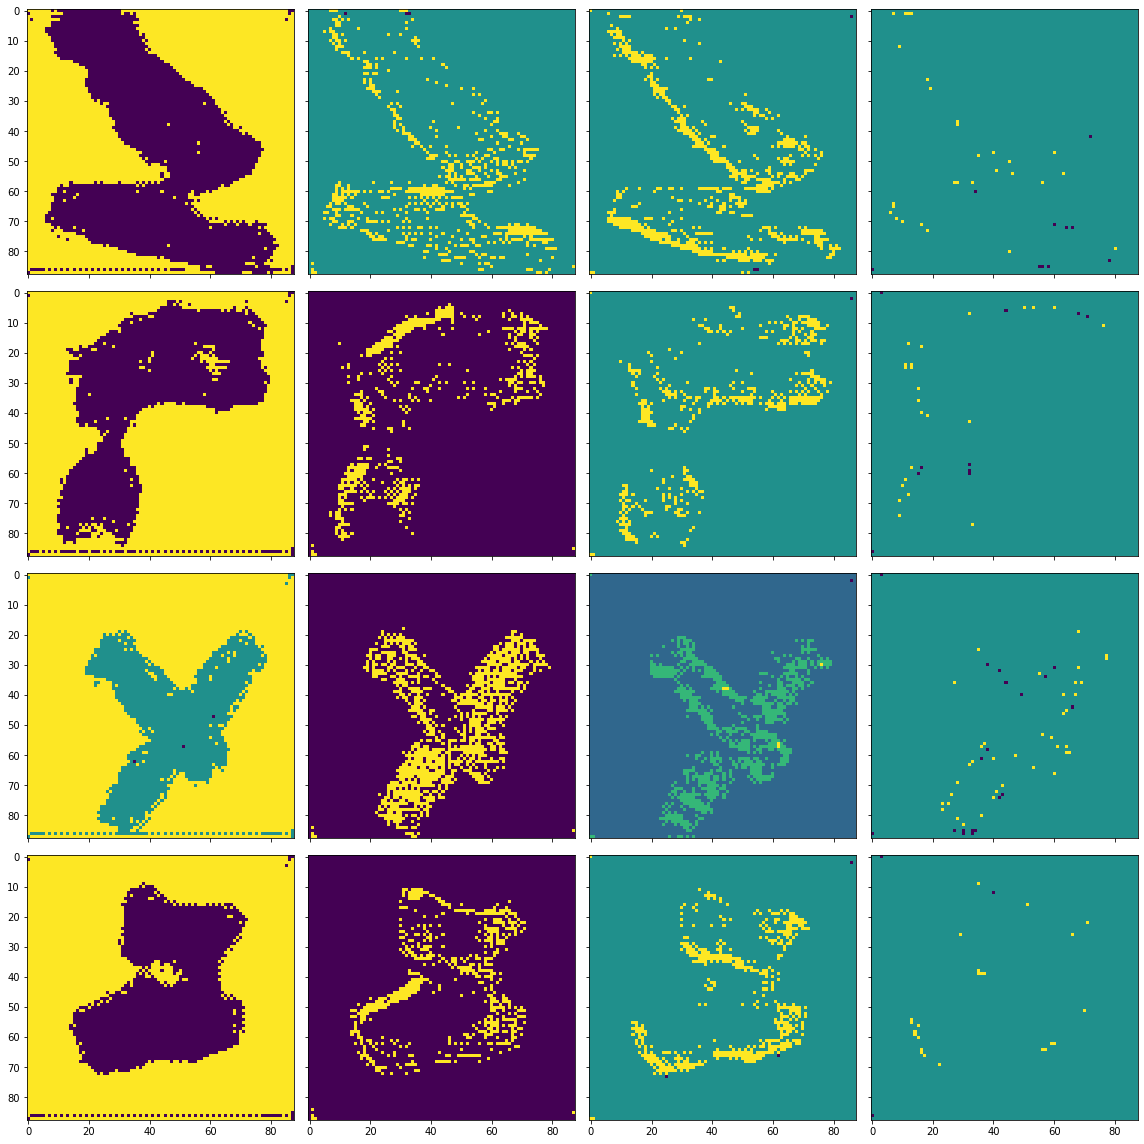

Training IOU: [0.9322875479242191, 0.22708763730172415, 0.18922065470483496, 0.0024477606298021946]
Training accuracy: 0.7630943310950413
Testing IOU: [0.933832740815981, 0.20145469254451345, 0.15941548576006187, 0.0007765859340872689]
Testing accuracy: 0.7694189049586777
13/13 [==============================] - 1s 66ms/step - loss: 0.0649 - val_loss: 0.0578ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_5epoch\assets
4
4


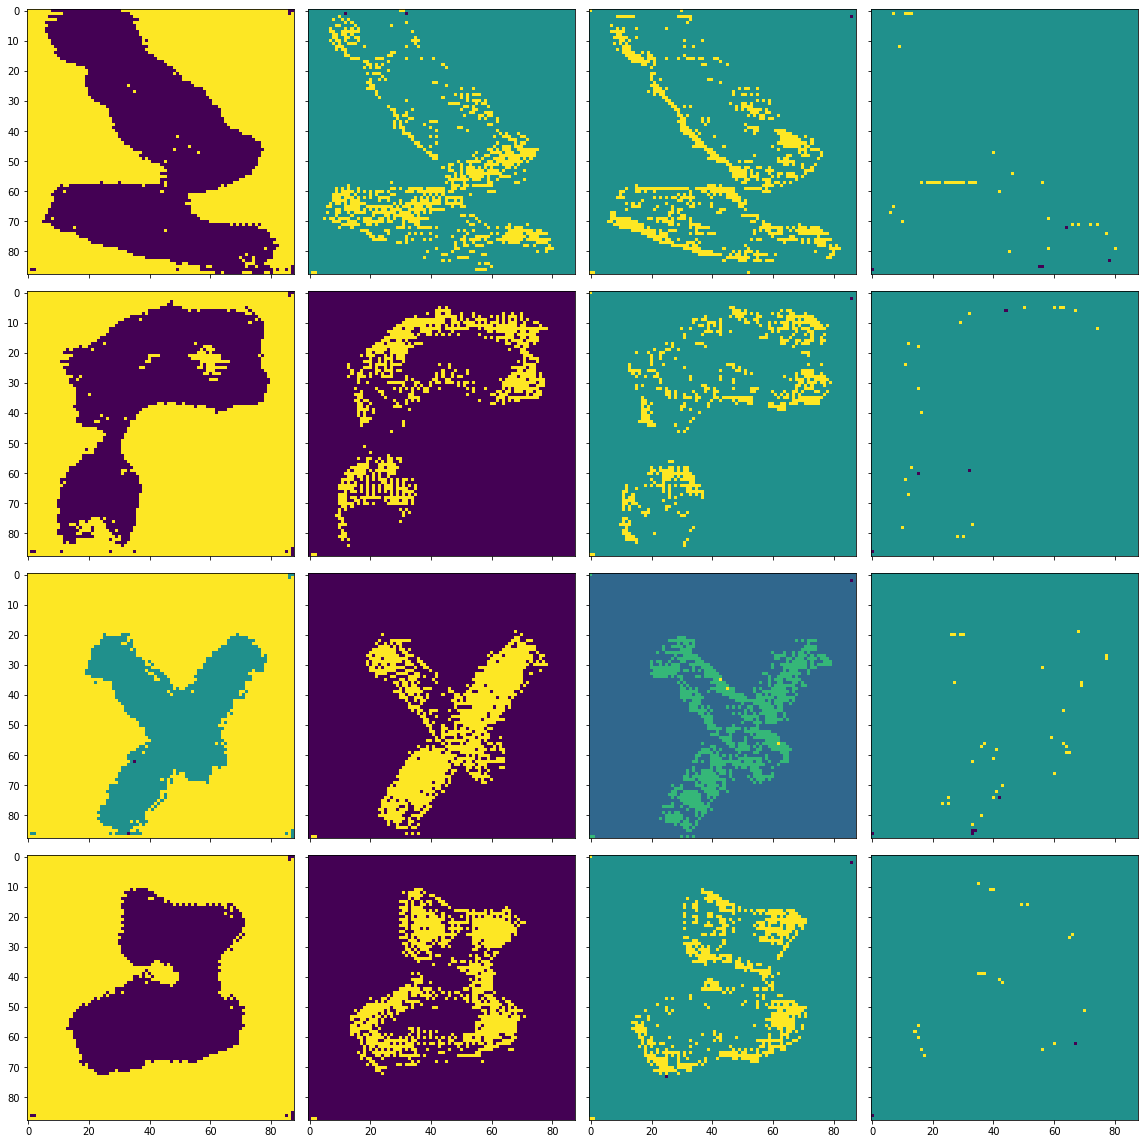

Training IOU: [0.9508289037119491, 0.3225125629806967, 0.21848465636054443, 0.0008437990580847723]
Training accuracy: 0.7995286673553719
Testing IOU: [0.9524753320359179, 0.298716565041349, 0.19640728980905572, 0.0004526707574690675]
Testing accuracy: 0.8057618801652893
13/13 [==============================] - 1s 66ms/step - loss: 0.0588 - val_loss: 0.0535
INFO:tensorflow:Assets written to: modelunet/savedmodel_6epoch\assets
4
4


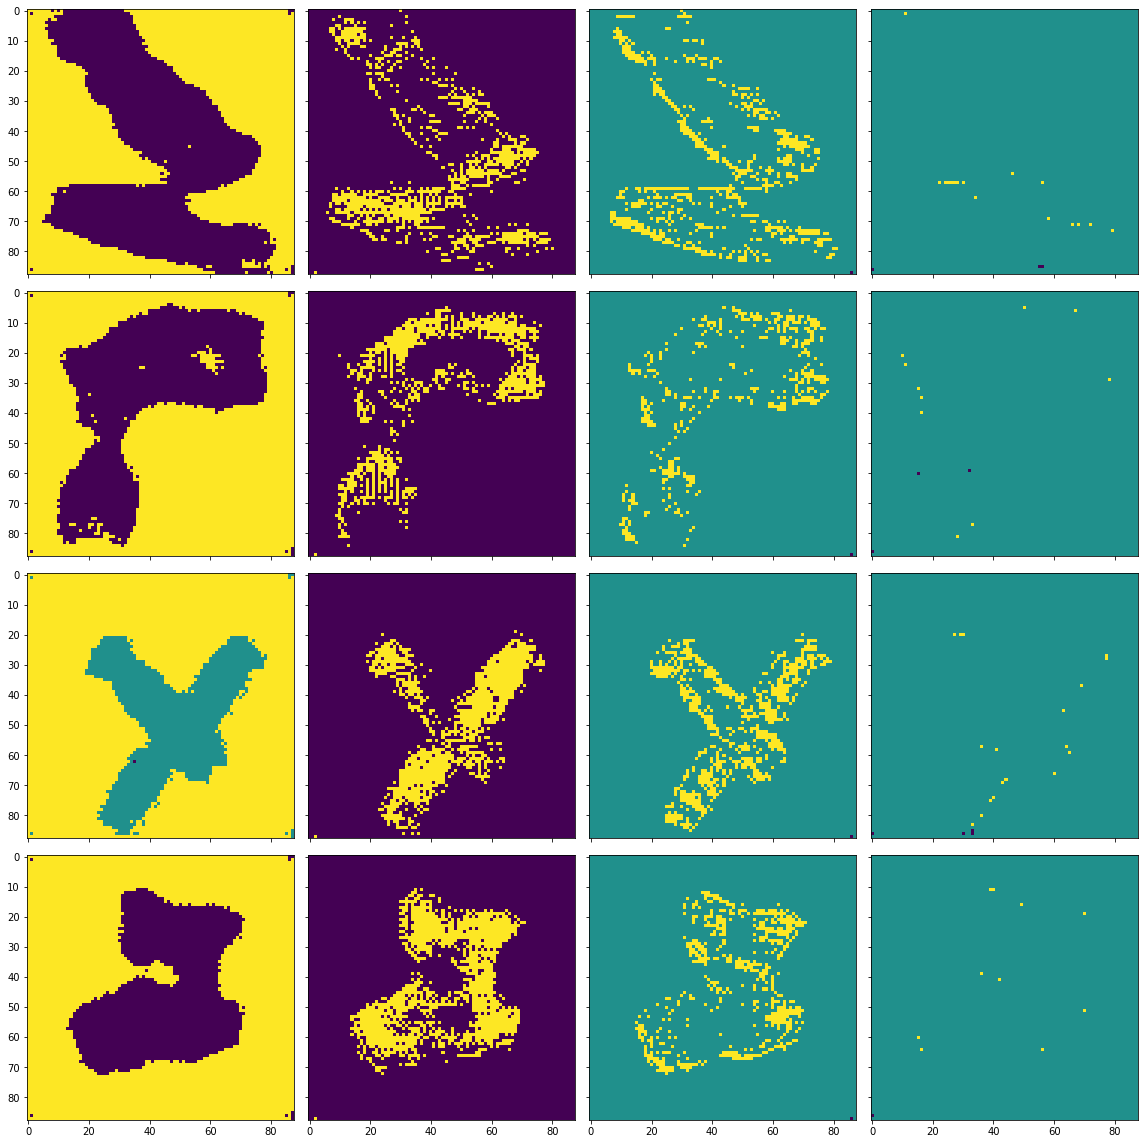

Training IOU: [0.9592020488575757, 0.3249823338836954, 0.18490933131439935, 0.0003505226911895091]
Training accuracy: 0.7949215521694215
Testing IOU: [0.9592348269149444, 0.30606019058065403, 0.16505777869863722, 0.00021184196589344348]
Testing accuracy: 0.8037732438016529
13/13 [==============================] - 1s 66ms/step - loss: 0.0550 - val_loss: 0.0507: 0s - loss: 0.05
INFO:tensorflow:Assets written to: modelunet/savedmodel_7epoch\assets
4
4


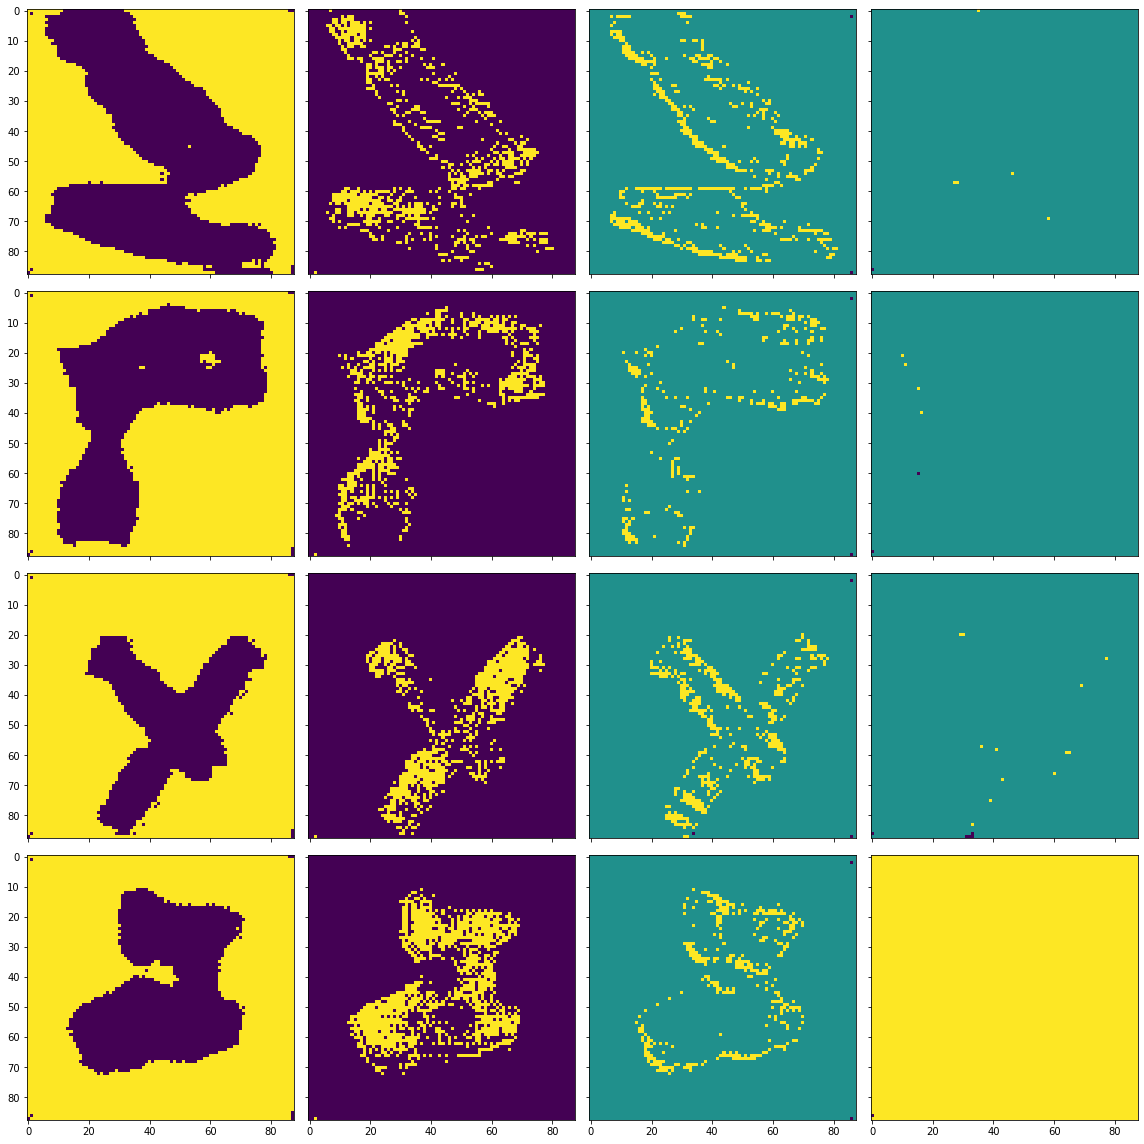

Training IOU: [0.9653156000401636, 0.32589228181023405, 0.1505741065922219, 5.28440677249572e-05]
Training accuracy: 0.7855907799586777
Testing IOU: [0.9650572175127845, 0.307865090403338, 0.1288032660356664, 0.0001624783362218371]
Testing accuracy: 0.7961027892561984
13/13 [==============================] - 1s 66ms/step - loss: 0.0526 - val_loss: 0.0494
INFO:tensorflow:Assets written to: modelunet/savedmodel_8epoch\assets
4
4


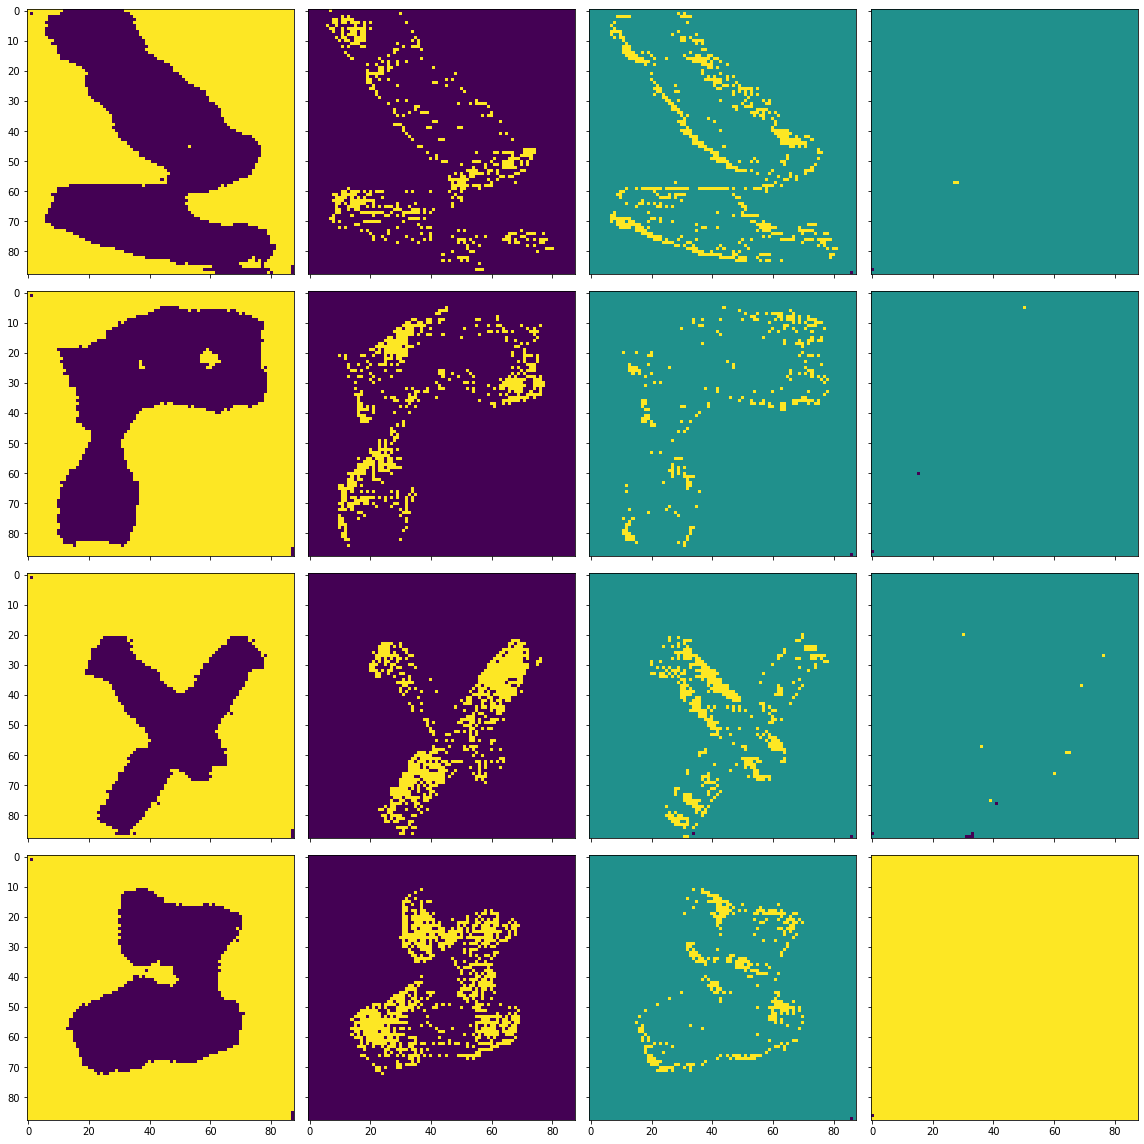

Training IOU: [0.967337981121713, 0.3153187517307019, 0.16333413178197134, 2.1324462356992825e-05]
Training accuracy: 0.783957257231405
Testing IOU: [0.9674663354122995, 0.29077571632770044, 0.13818812574176076, 0.000163826998689384]
Testing accuracy: 0.793464617768595
13/13 [==============================] - 1s 66ms/step - loss: 0.0514 - val_loss: 0.0490
INFO:tensorflow:Assets written to: modelunet/savedmodel_9epoch\assets
4
4


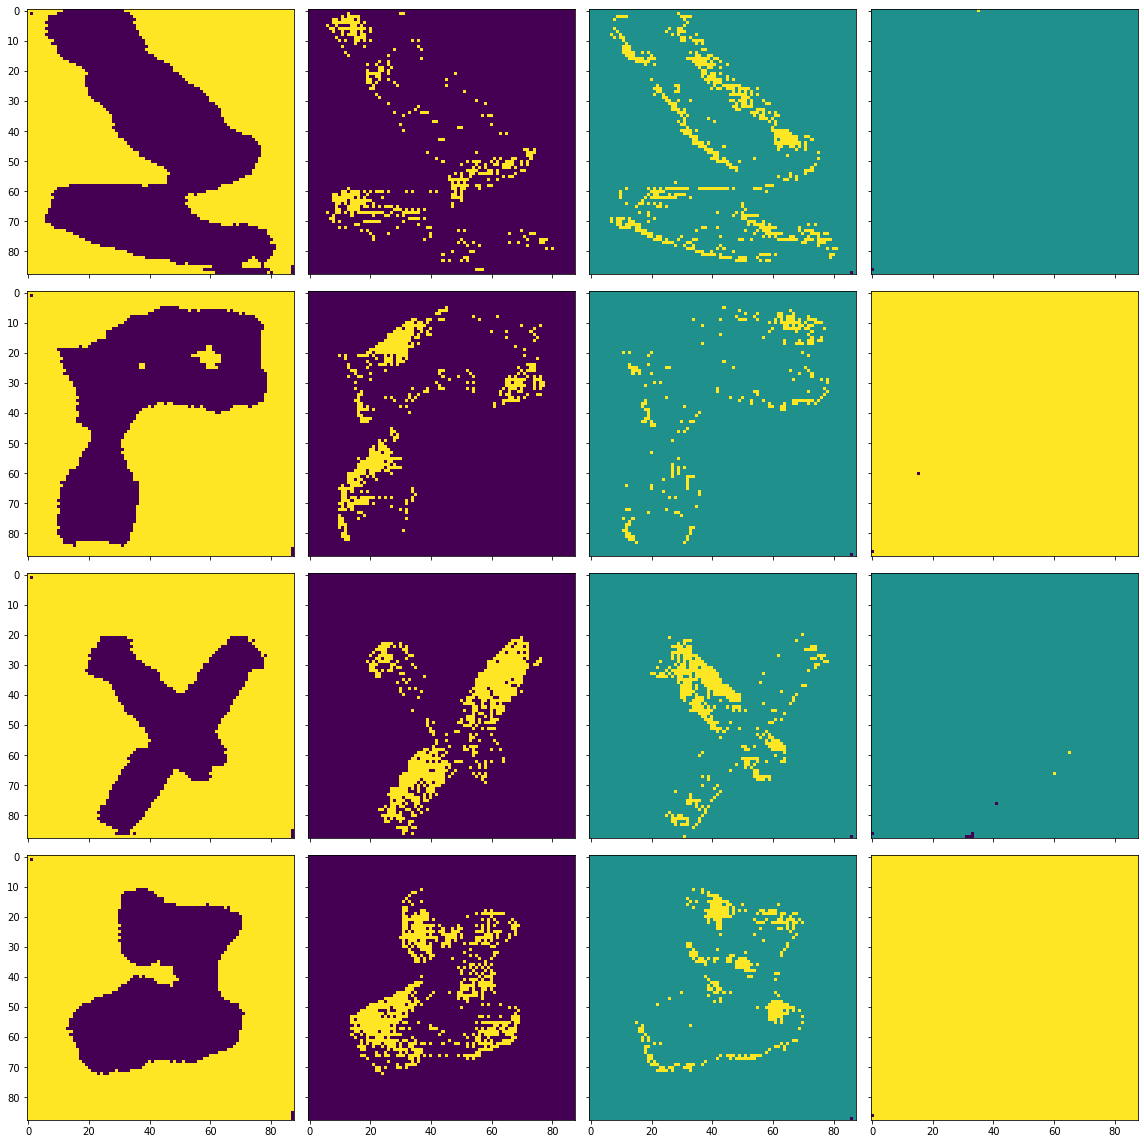

Training IOU: [0.9678650494822693, 0.32273736396432884, 0.17657347711700253, 2.145761584430354e-05]
Training accuracy: 0.7857576833677686
Testing IOU: [0.9679101760972219, 0.2821807764438341, 0.14669996142680228, 0.0]
Testing accuracy: 0.792475464876033
13/13 [==============================] - 1s 67ms/step - loss: 0.0499 - val_loss: 0.0483
INFO:tensorflow:Assets written to: modelunet/savedmodel_10epoch\assets
4
4


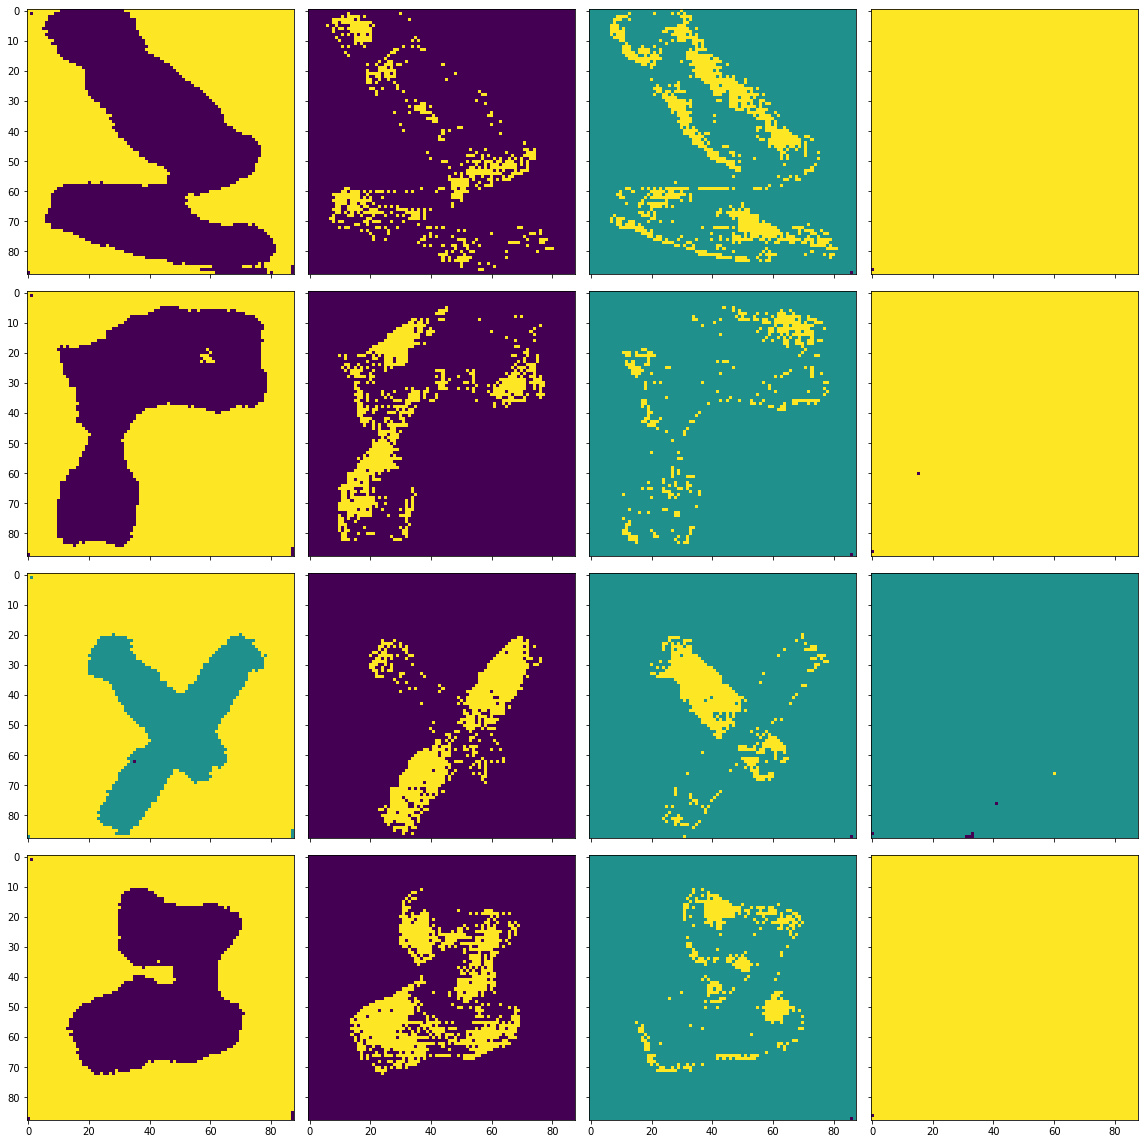

Training IOU: [0.9702903338541421, 0.38965950082655687, 0.2556489134286727, 2.1510233493584574e-05]
Training accuracy: 0.8120480371900827
Testing IOU: [0.9698588847787368, 0.3419806436470572, 0.19841390157472855, 0.0]
Testing accuracy: 0.8131740702479339
13/13 [==============================] - 1s 66ms/step - loss: 0.0483 - val_loss: 0.0485
INFO:tensorflow:Assets written to: modelunet/savedmodel_11epoch\assets
4
4


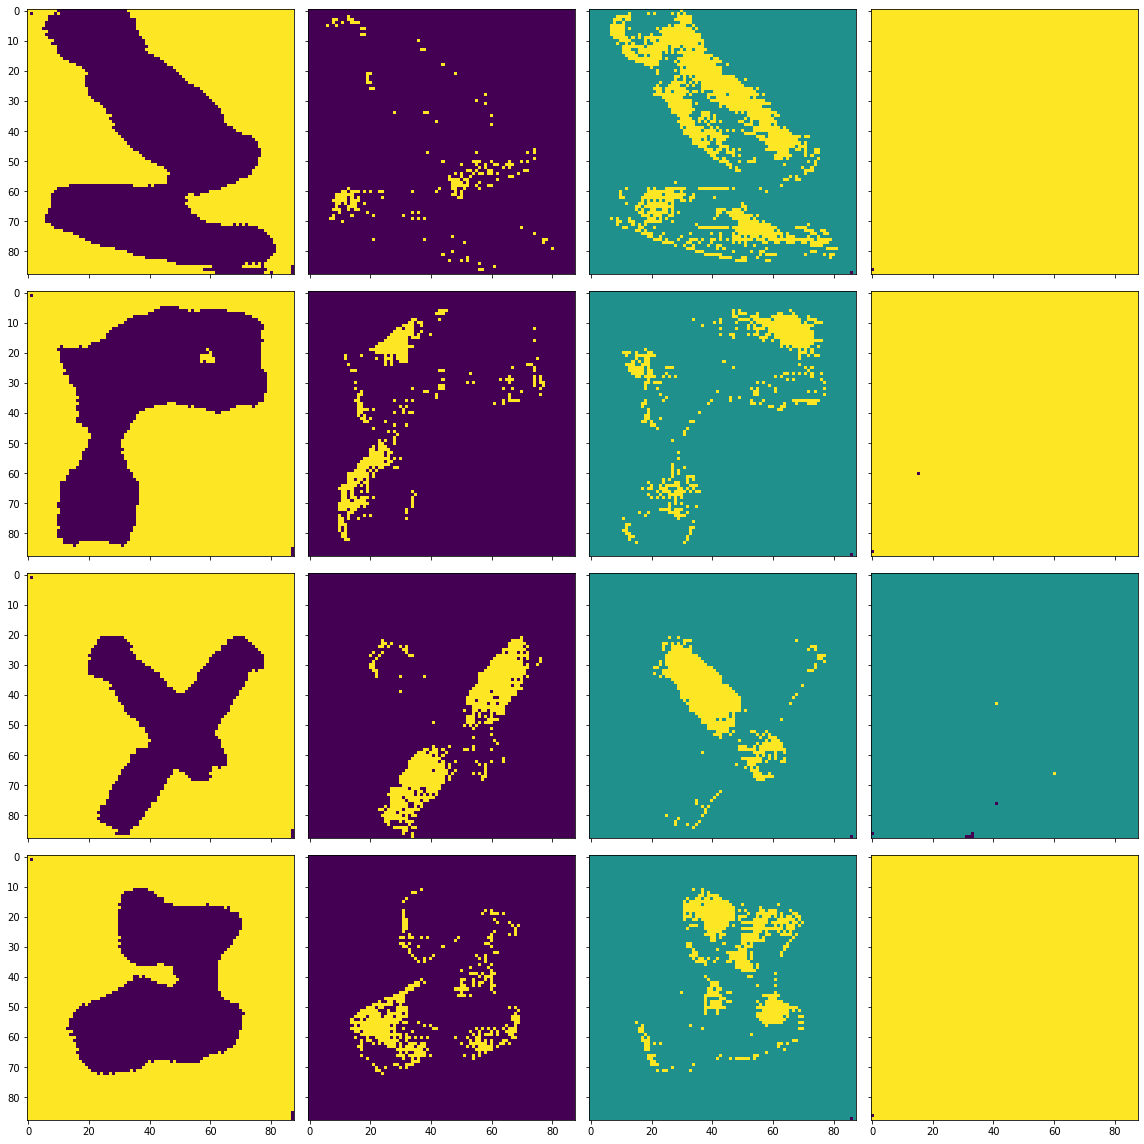

Training IOU: [0.970276477460527, 0.32486498926659707, 0.3106348759777675, 3.232445129243931e-05]
Training accuracy: 0.8043433626033057
Testing IOU: [0.9698583308680933, 0.2640474892296823, 0.234467627832005, 0.0]
Testing accuracy: 0.8021448863636363
13/13 [==============================] - 1s 67ms/step - loss: 0.0469 - val_loss: 0.0475
INFO:tensorflow:Assets written to: modelunet/savedmodel_12epoch\assets
4
4


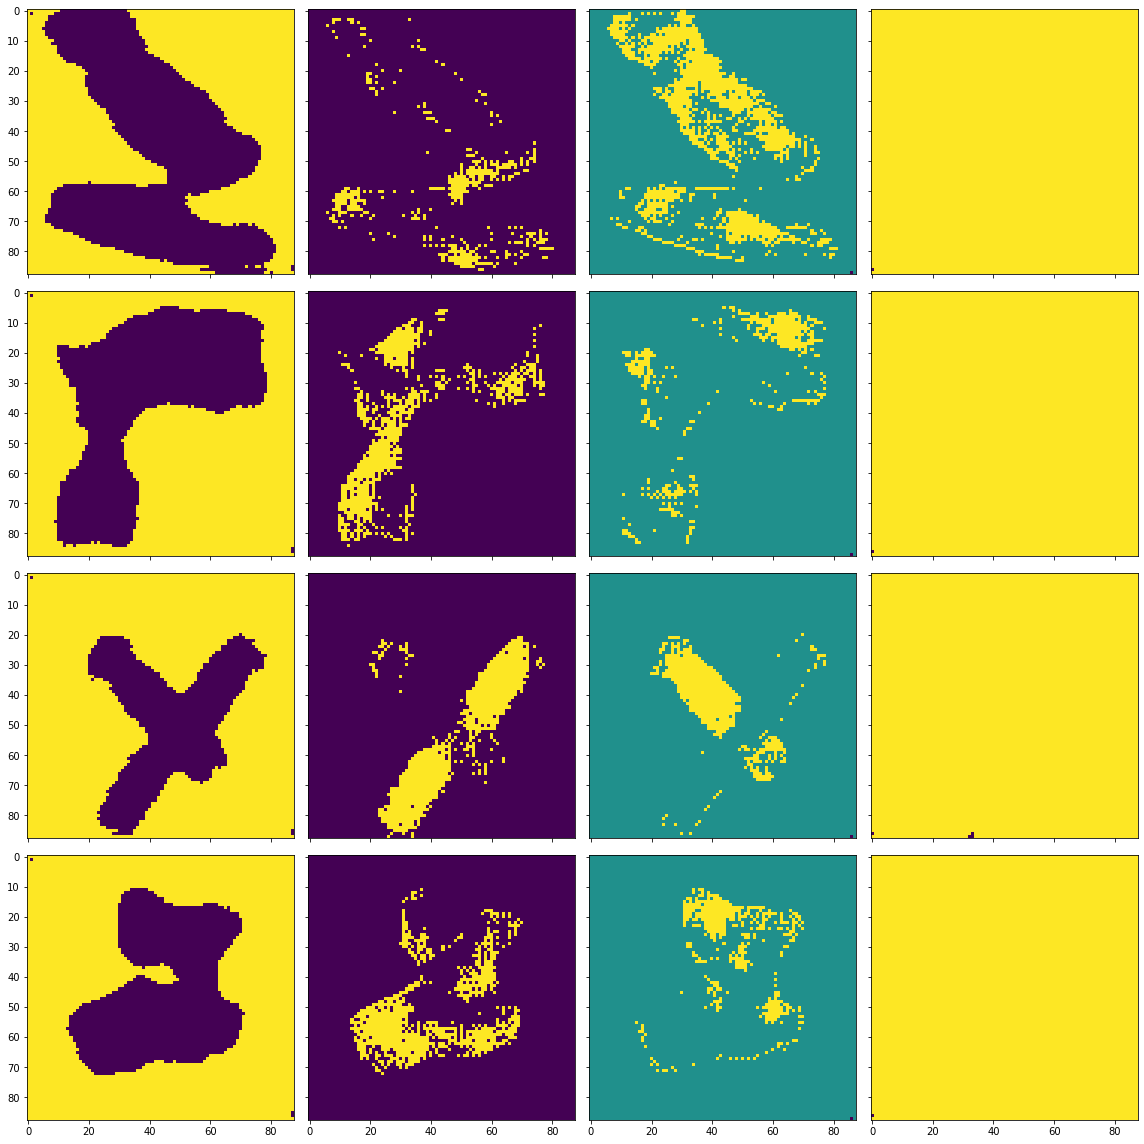

Training IOU: [0.9713281280988623, 0.4211351515195254, 0.3083745358260746, 1.081747671538137e-05]
Training accuracy: 0.822292097107438
Testing IOU: [0.9706328506864382, 0.3441277852576077, 0.2241427247451344, 0.0]
Testing accuracy: 0.8156120867768595
13/13 [==============================] - 1s 67ms/step - loss: 0.0469 - val_loss: 0.0472
INFO:tensorflow:Assets written to: modelunet/savedmodel_13epoch\assets
4
4


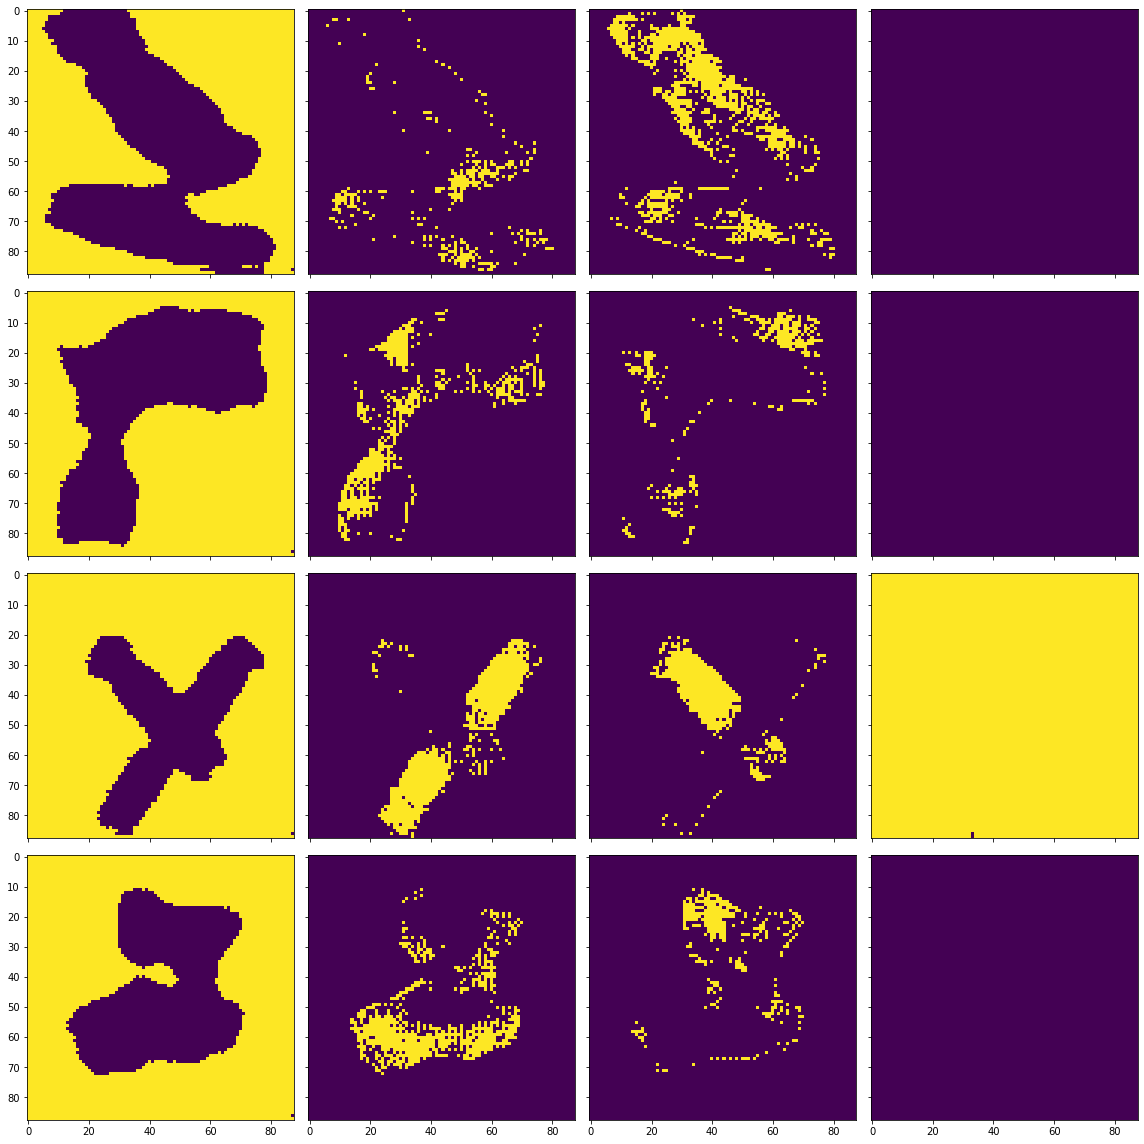

Training IOU: [0.9711028300203546, 0.3913878061754734, 0.2808177009088197, 0.0]
Training accuracy: 0.811367833161157
Testing IOU: [0.9703131544242105, 0.31060953084595494, 0.20202803630931862, 0.0]
Testing accuracy: 0.8055074896694215
13/13 [==============================] - 1s 66ms/step - loss: 0.0456 - val_loss: 0.0482
INFO:tensorflow:Assets written to: modelunet/savedmodel_14epoch\assets
4
4


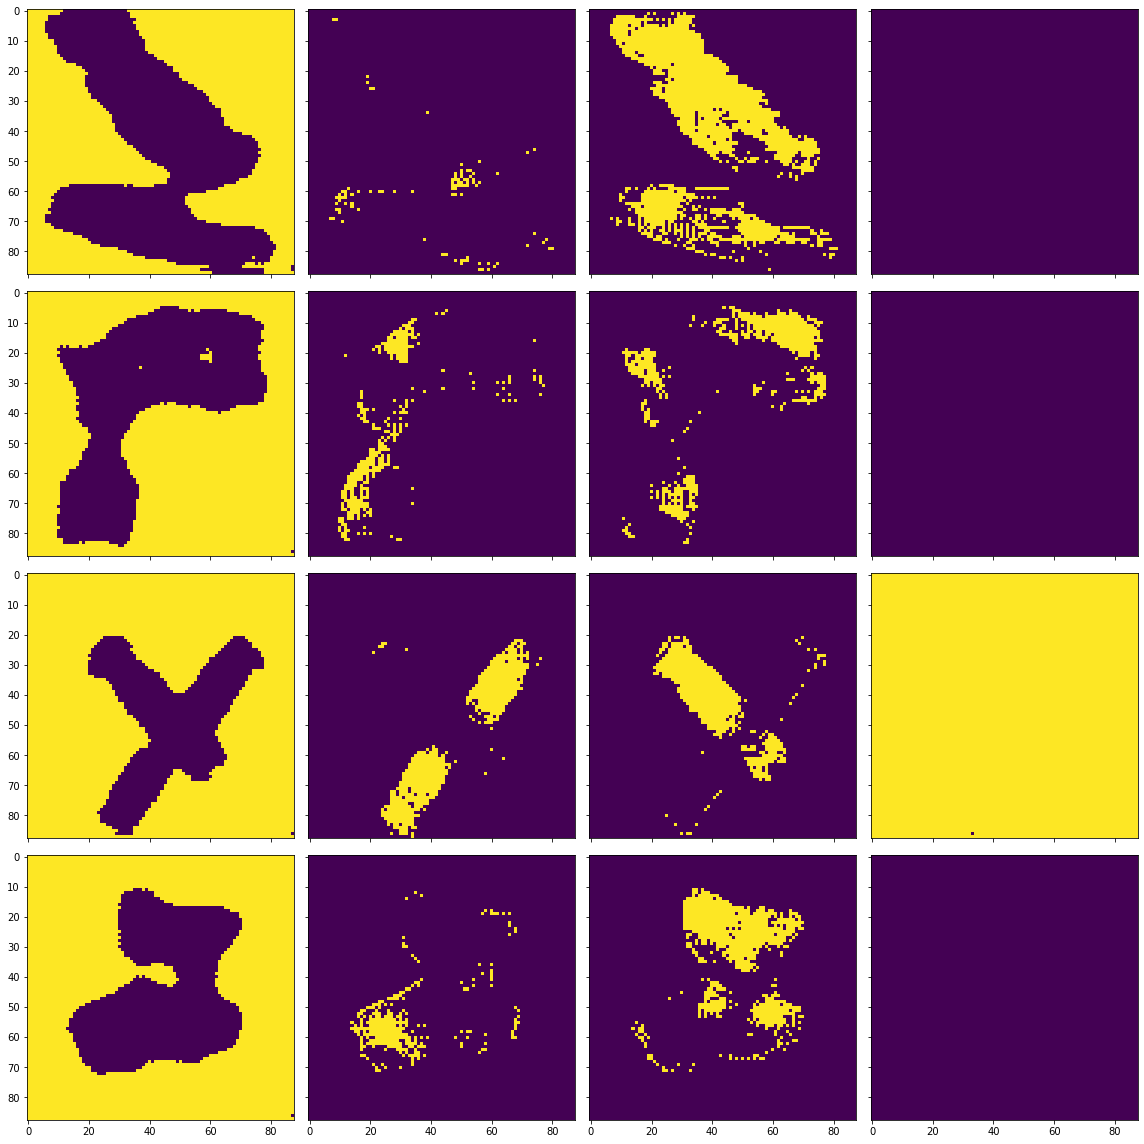

Training IOU: [0.9710968825313463, 0.33198287533692444, 0.3692192372786708, 0.0]
Training accuracy: 0.815949444731405
Testing IOU: [0.9710449673107832, 0.2575639419933675, 0.2692914594723689, 0.0]
Testing accuracy: 0.8093246384297521
13/13 [==============================] - 1s 66ms/step - loss: 0.0451 - val_loss: 0.0474
INFO:tensorflow:Assets written to: modelunet/savedmodel_15epoch\assets
4
4


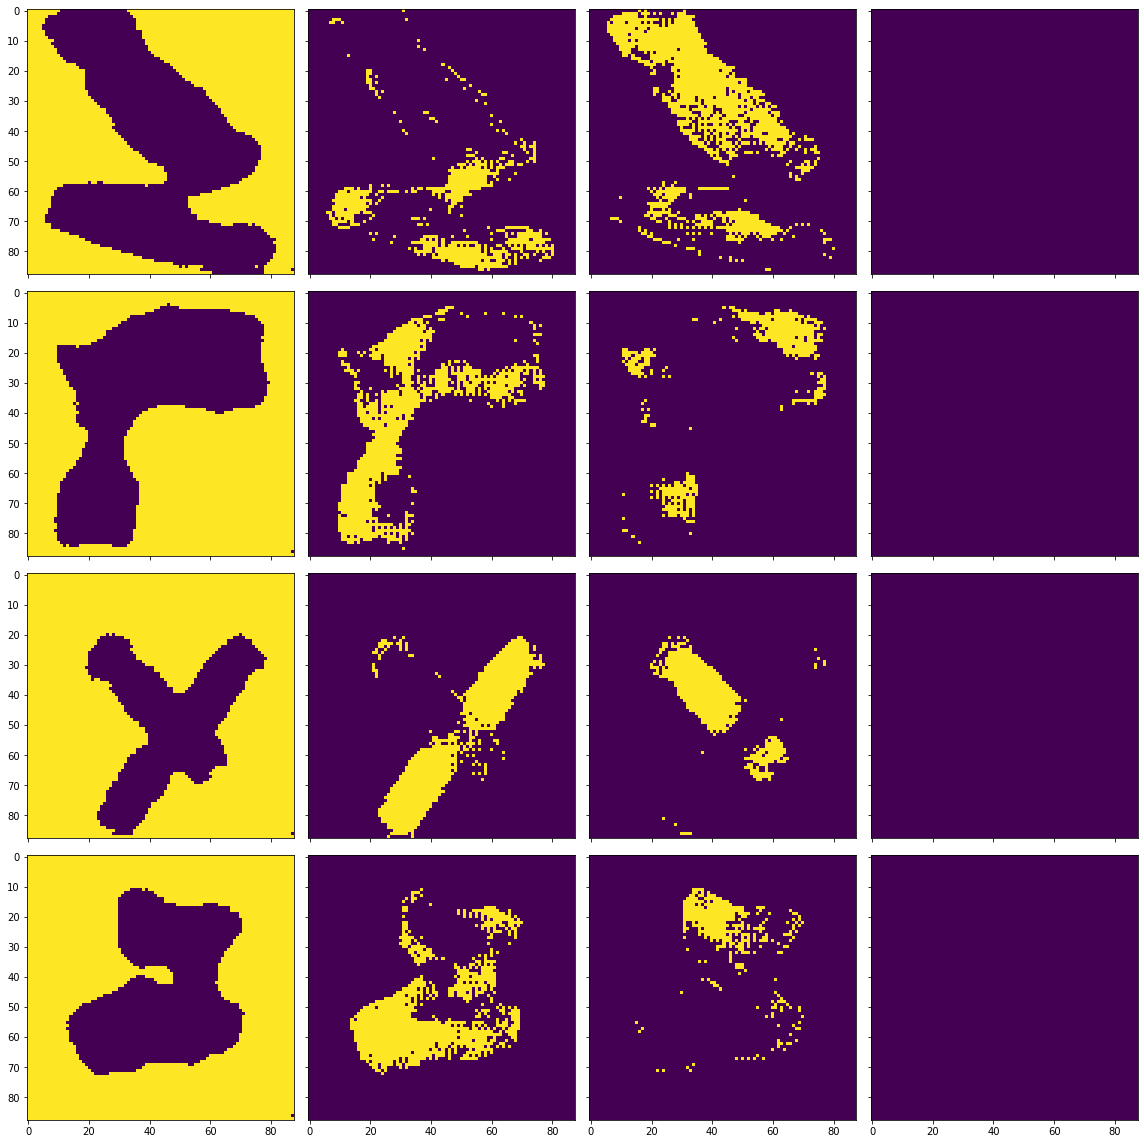

Training IOU: [0.971411842745007, 0.4726936030396782, 0.35538566276587913, 0.0]
Training accuracy: 0.8400748966942149
Testing IOU: [0.970451802816705, 0.37978427979232904, 0.24803031542215315, 0.0]
Testing accuracy: 0.8269692665289257
13/13 [==============================] - 1s 66ms/step - loss: 0.0446 - val_loss: 0.0478
INFO:tensorflow:Assets written to: modelunet/savedmodel_16epoch\assets
4
4


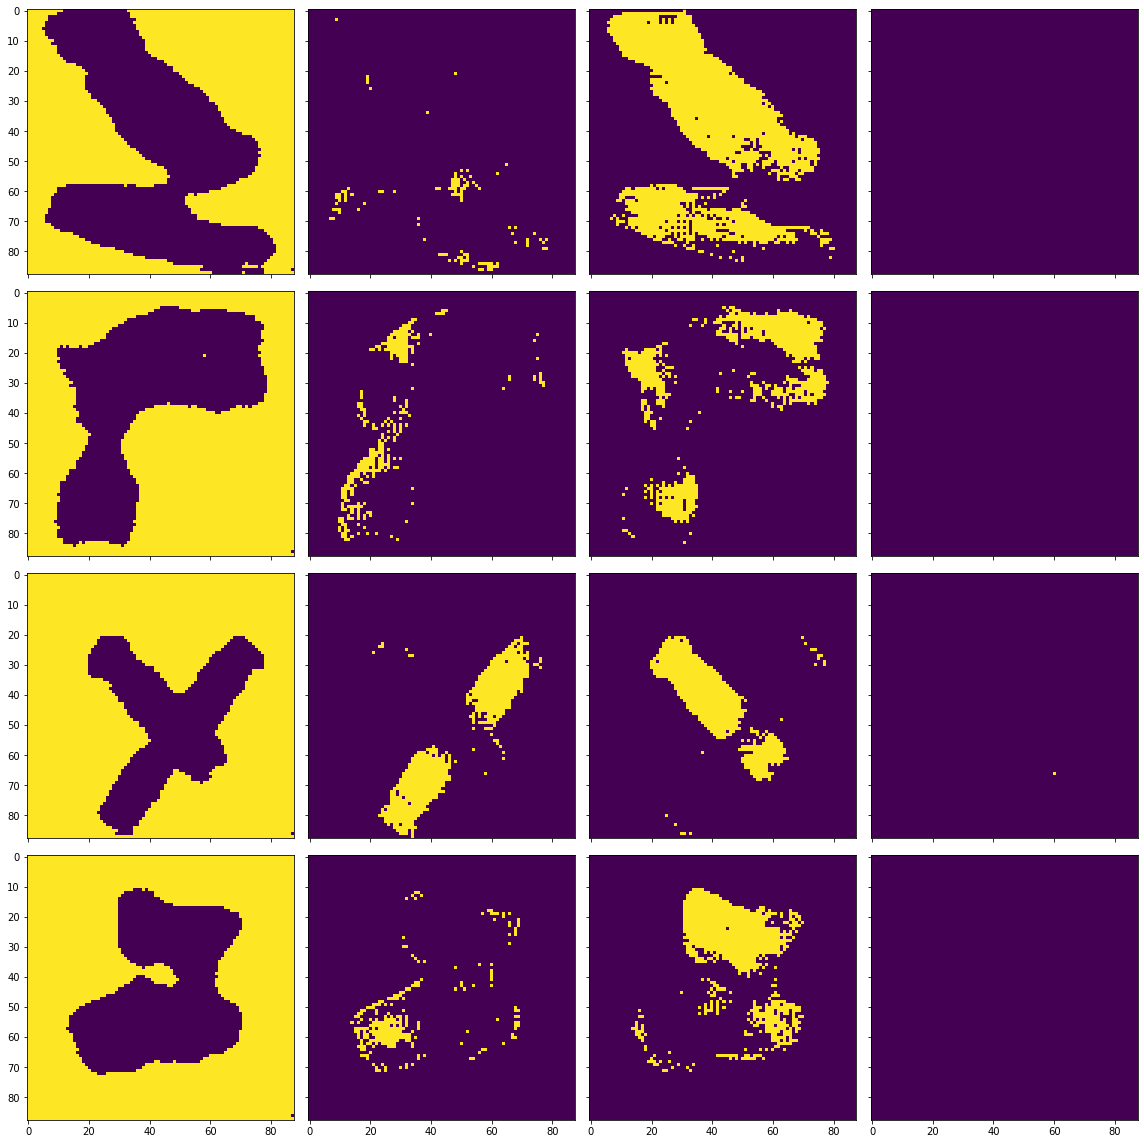

Training IOU: [0.9726485686282699, 0.3400221503307977, 0.4202428610631326, 0.0]
Training accuracy: 0.8267097107438016
Testing IOU: [0.9721744765495589, 0.2494282640742659, 0.2979914916799526, 0.0]
Testing accuracy: 0.8129777892561983
13/13 [==============================] - 1s 66ms/step - loss: 0.0436 - val_loss: 0.0468
INFO:tensorflow:Assets written to: modelunet/savedmodel_17epoch\assets
4
4


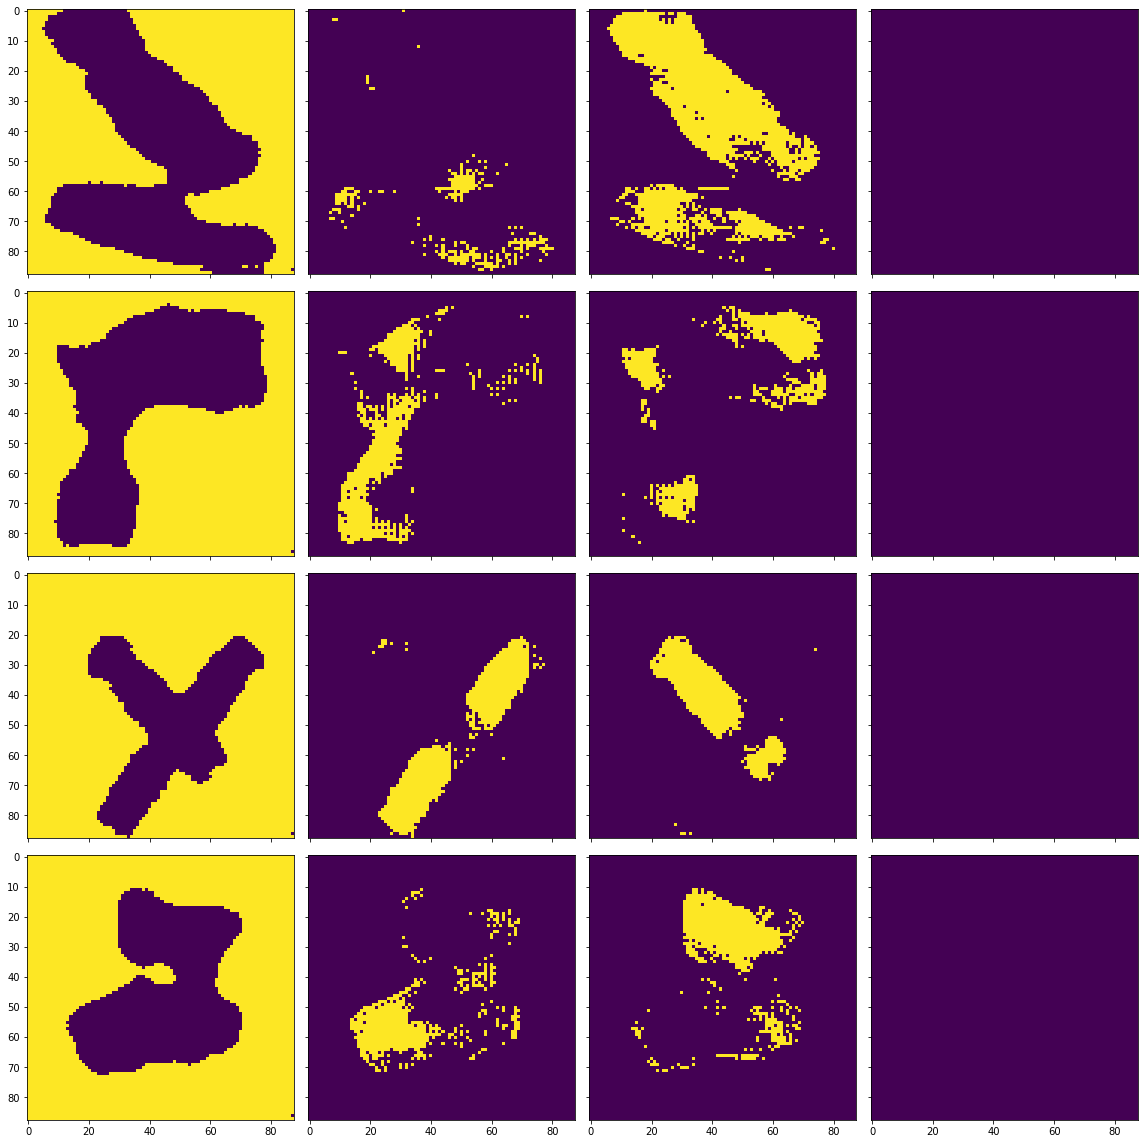

Training IOU: [0.9738846203886384, 0.4446829294351531, 0.4079581410357755, 0.0]
Training accuracy: 0.8416787190082644
Testing IOU: [0.9732982846897309, 0.3411364444218758, 0.28408079540927467, 0.0]
Testing accuracy: 0.8274186466942148
13/13 [==============================] - 1s 66ms/step - loss: 0.0431 - val_loss: 0.0470
INFO:tensorflow:Assets written to: modelunet/savedmodel_18epoch\assets
4
4


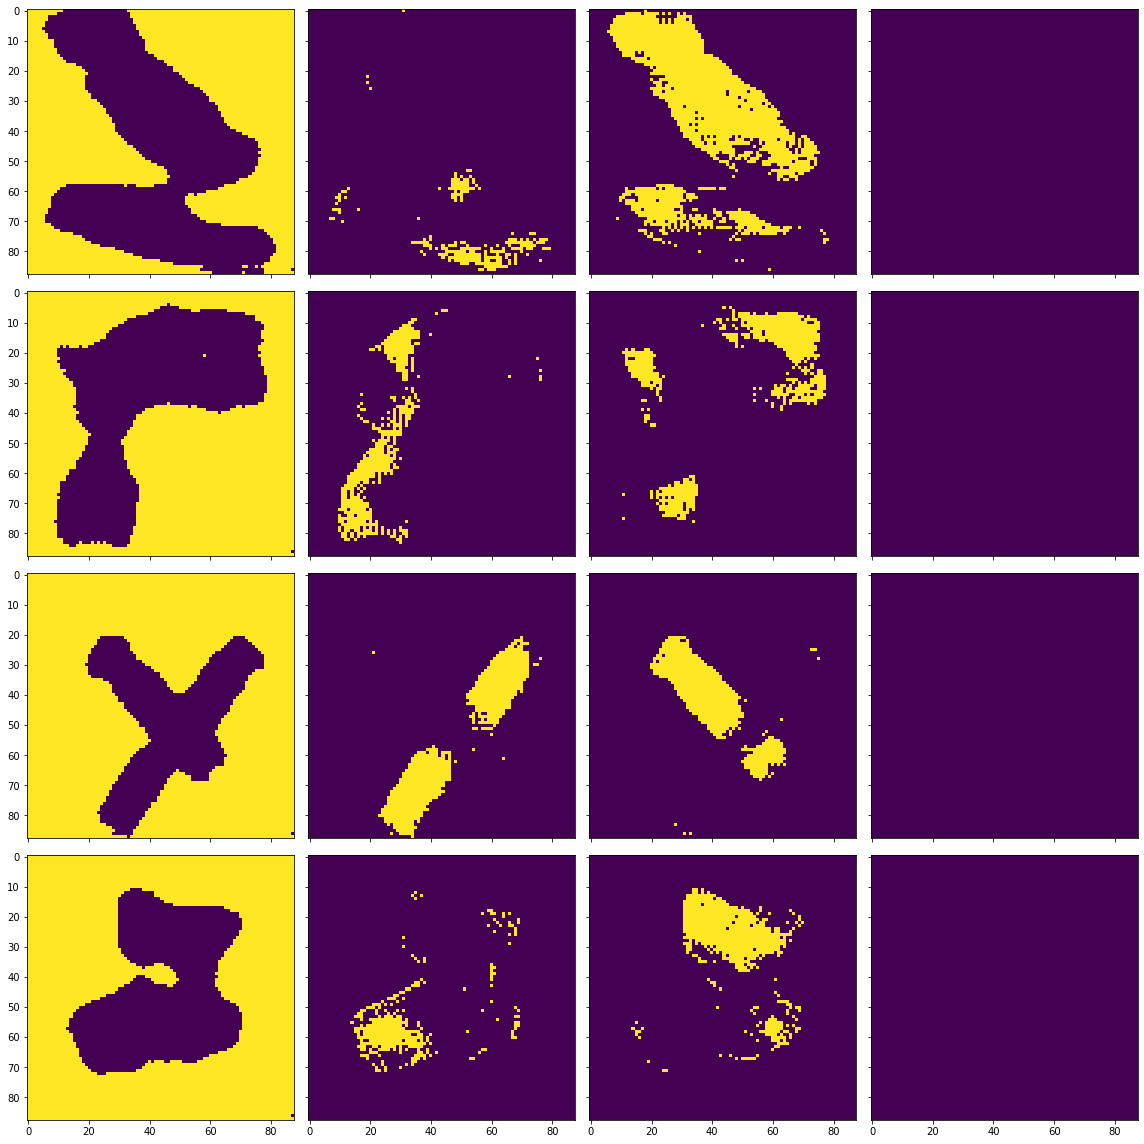

Training IOU: [0.9738976546885109, 0.3987333232478933, 0.40705156225412203, 0.0]
Training accuracy: 0.8301711002066116
Testing IOU: [0.9729369870423473, 0.29271761732126433, 0.28166229747733035, 0.0]
Testing accuracy: 0.8158961776859505
13/13 [==============================] - 1s 66ms/step - loss: 0.0426 - val_loss: 0.0463
INFO:tensorflow:Assets written to: modelunet/savedmodel_19epoch\assets
4
4


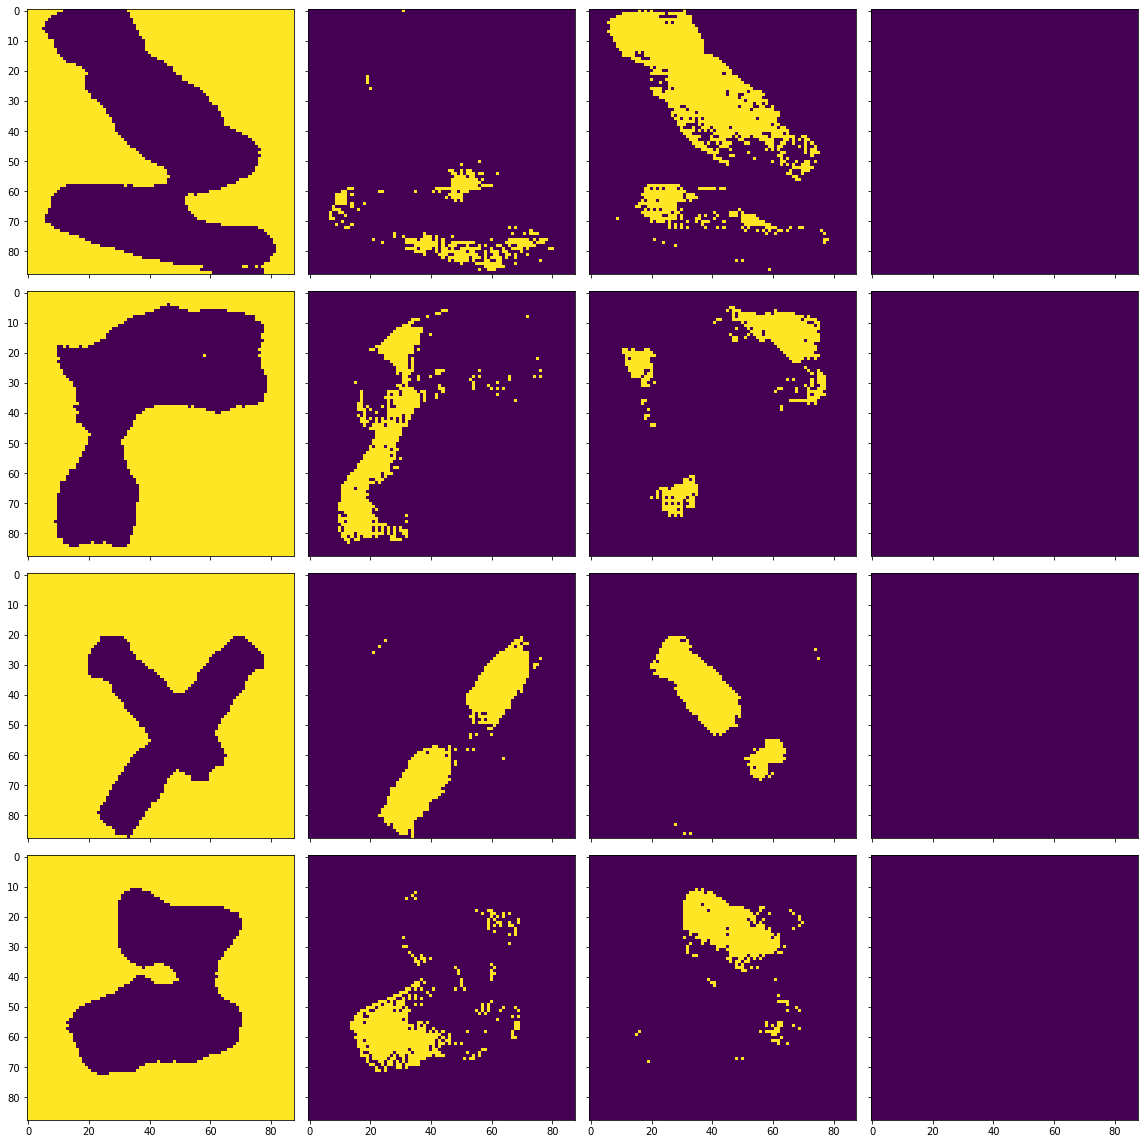

Training IOU: [0.9744827475779715, 0.44216816047801966, 0.3916664560611874, 0.0]
Training accuracy: 0.8349163868801653
Testing IOU: [0.9733304904346861, 0.3245042016806723, 0.2674259436536552, 0.0]
Testing accuracy: 0.8197636880165289
13/13 [==============================] - 1s 67ms/step - loss: 0.0423 - val_loss: 0.0465ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.
INFO:tensorflow:Assets written to: modelunet/savedmodel_20epoch\assets
4
4


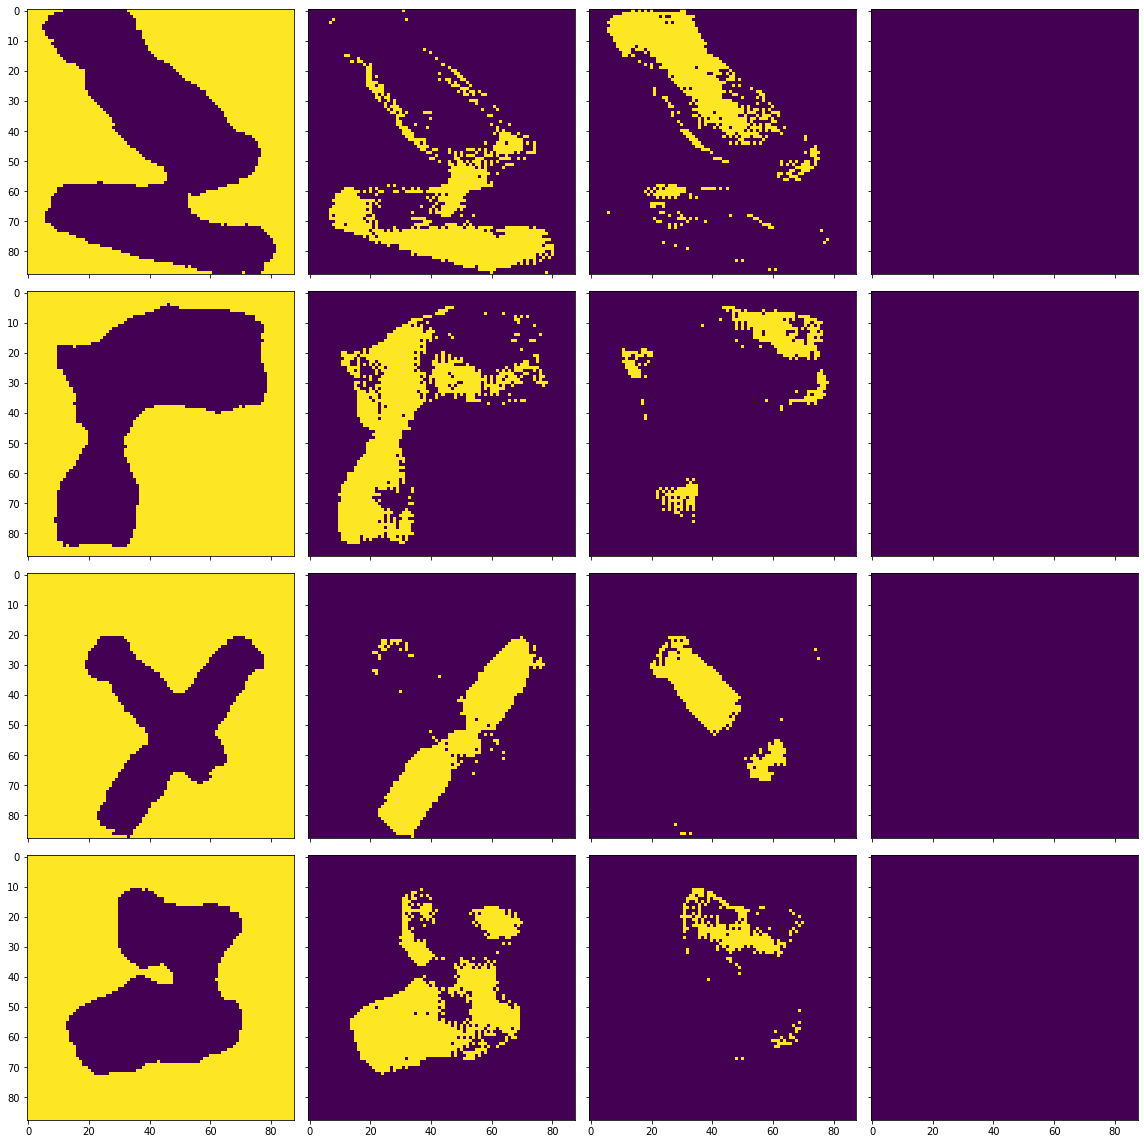

Training IOU: [0.9727555378823222, 0.5056137181203723, 0.34938460199750554, 0.0]
Training accuracy: 0.8499221978305785
Testing IOU: [0.9714391820736887, 0.41118142124912993, 0.22966011481580048, 0.0]
Testing accuracy: 0.8345932334710744
13/13 [==============================] - 1s 66ms/step - loss: 0.0414 - val_loss: 0.0468
INFO:tensorflow:Assets written to: modelunet/savedmodel_21epoch\assets
4
4


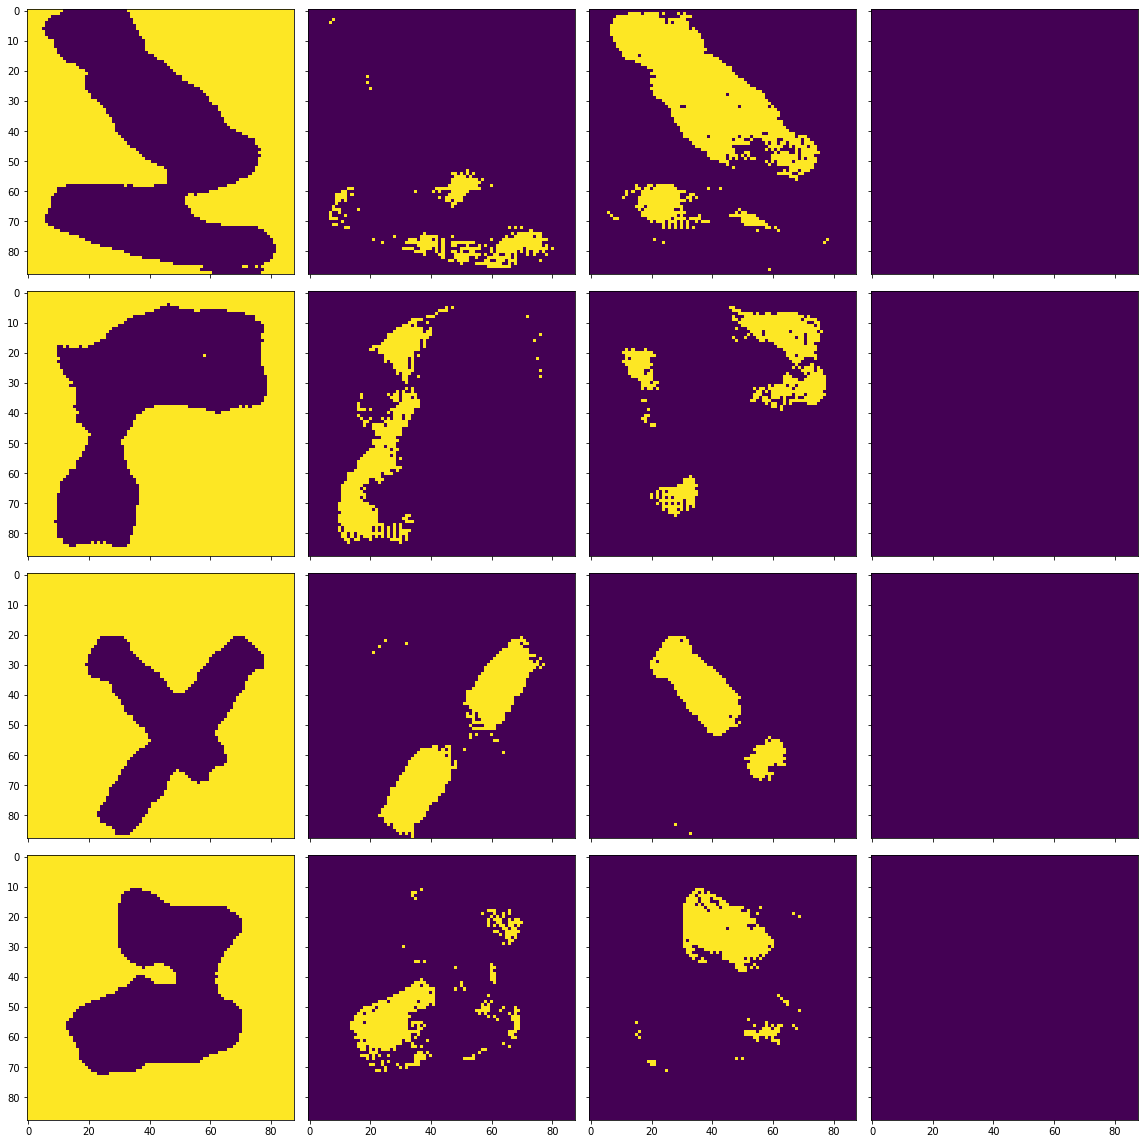

Training IOU: [0.974680612536228, 0.45719328173703183, 0.4066570649845492, 0.0]
Training accuracy: 0.8391616089876033
Testing IOU: [0.9737398841021386, 0.3326456706936982, 0.26838441225894216, 0.0]
Testing accuracy: 0.8213817148760331
13/13 [==============================] - 1s 67ms/step - loss: 0.0411 - val_loss: 0.0471
INFO:tensorflow:Assets written to: modelunet/savedmodel_22epoch\assets
4
4


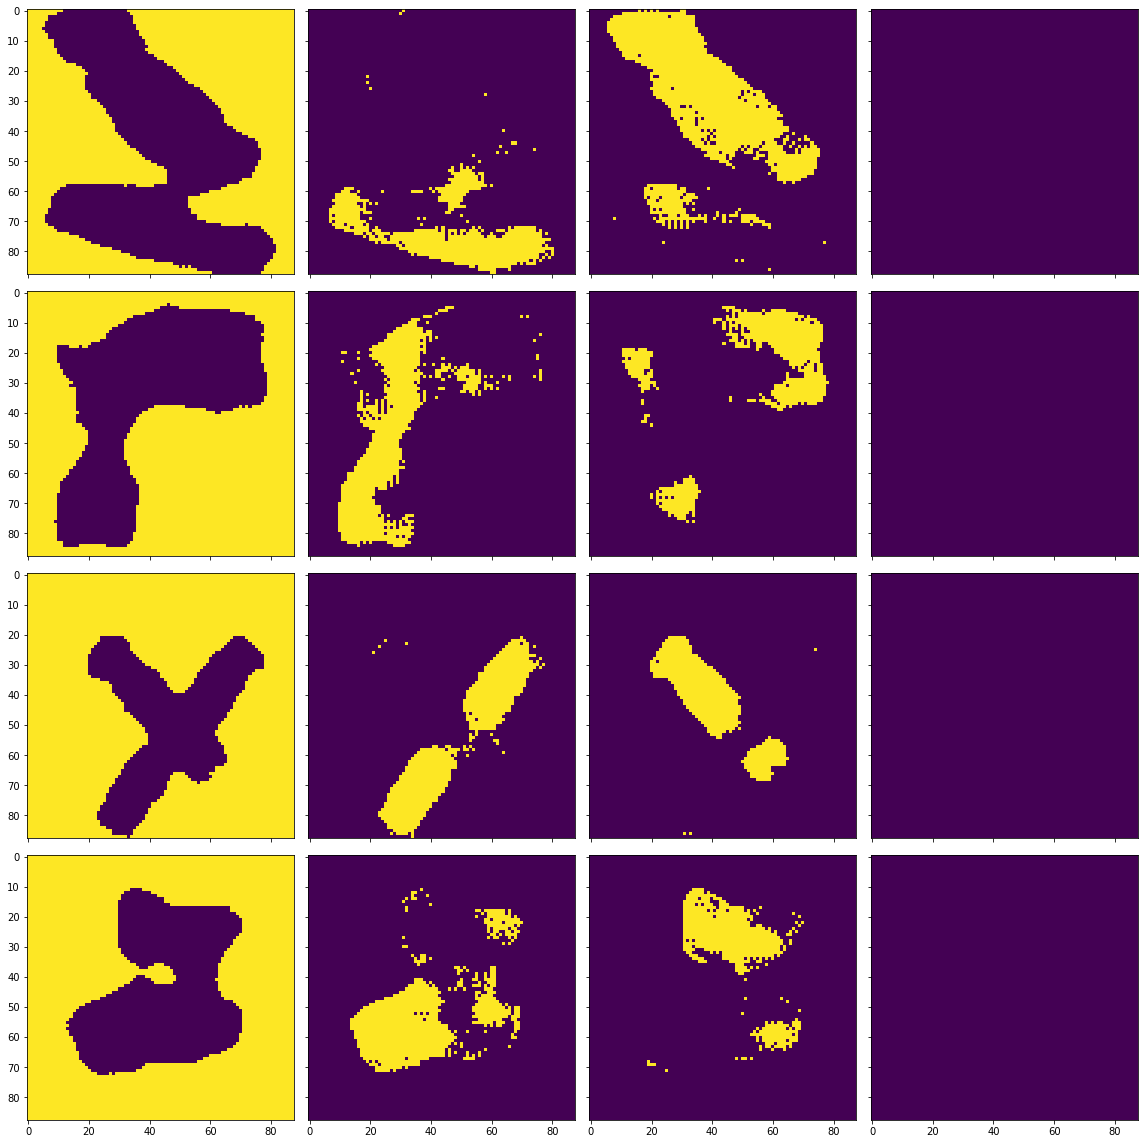

Training IOU: [0.9743957665450886, 0.5091532871204619, 0.4497302448546704, 0.0]
Training accuracy: 0.8611763946280991
Testing IOU: [0.9730739760378936, 0.3804335818834576, 0.3065910546361522, 0.0]
Testing accuracy: 0.8397017045454546
13/13 [==============================] - 1s 67ms/step - loss: 0.0409 - val_loss: 0.0458
INFO:tensorflow:Assets written to: modelunet/savedmodel_23epoch\assets
4
4


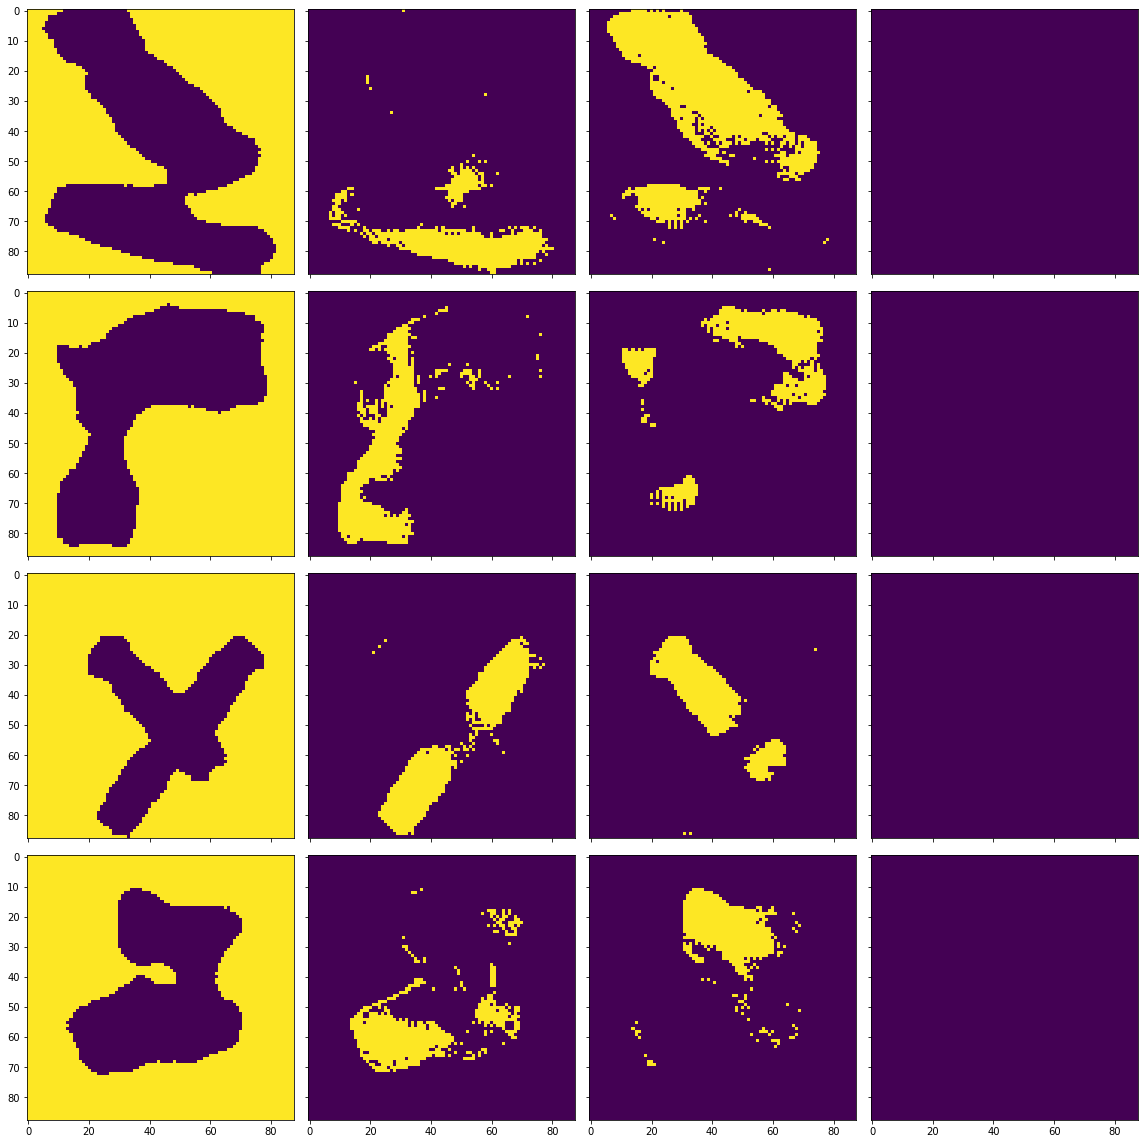

Training IOU: [0.975455754231367, 0.4905914802329145, 0.4437040595939957, 1.0906909527185471e-05]
Training accuracy: 0.8531995738636363
Testing IOU: [0.974026920900326, 0.35101798513697724, 0.3013056175914791, 0.0]
Testing accuracy: 0.8317006714876033
13/13 [==============================] - 1s 67ms/step - loss: 0.0404 - val_loss: 0.0469
INFO:tensorflow:Assets written to: modelunet/savedmodel_24epoch\assets
4
4


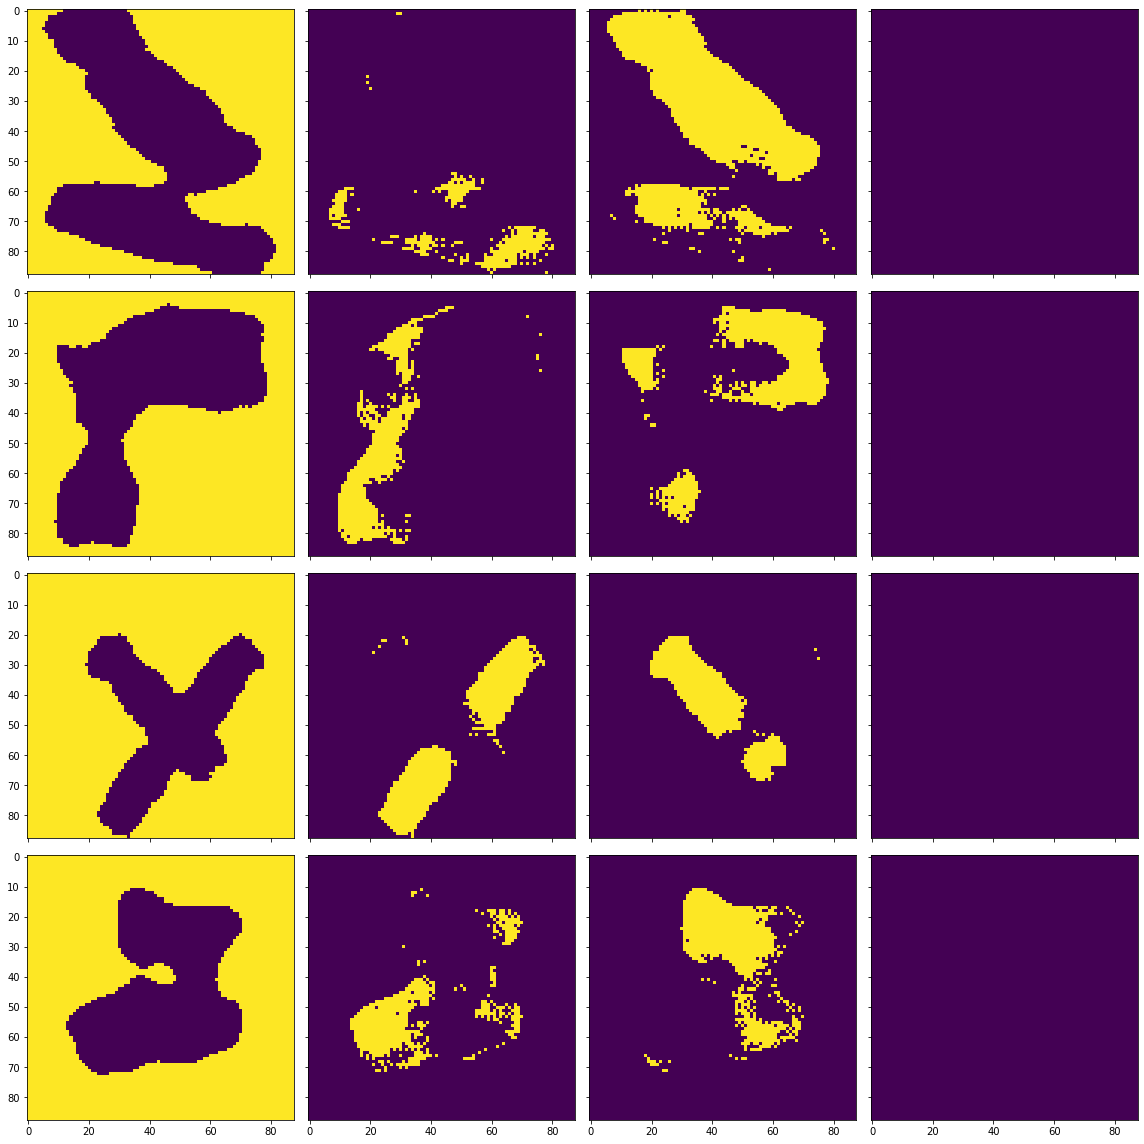

Training IOU: [0.9749896834286388, 0.4857152377330976, 0.47808241194433343, 0.0]
Training accuracy: 0.8596803977272728
Testing IOU: [0.9739439131985834, 0.3426176850655344, 0.3263459508369778, 0.0]
Testing accuracy: 0.83572701446281
13/13 [==============================] - 1s 67ms/step - loss: 0.0412 - val_loss: 0.0472
INFO:tensorflow:Assets written to: modelunet/savedmodel_25epoch\assets
4
4


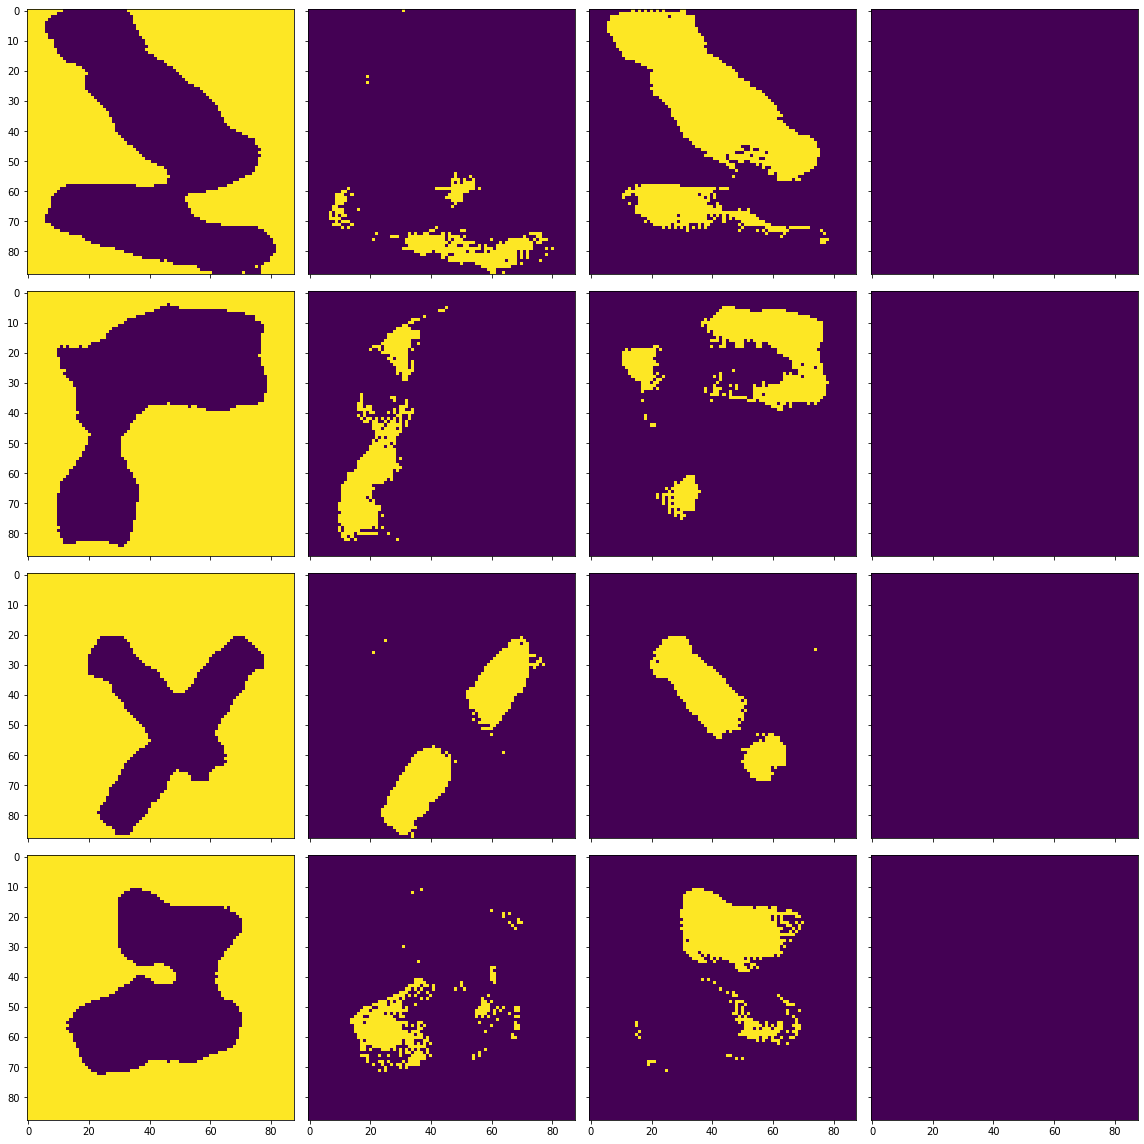

Training IOU: [0.9744059313520673, 0.4539711063200615, 0.4718981795071206, 0.0]
Training accuracy: 0.8528260588842975
Testing IOU: [0.9730899755221678, 0.30977197457078687, 0.320717889741077, 0.0]
Testing accuracy: 0.8290418388429752
13/13 [==============================] - 1s 67ms/step - loss: 0.0403 - val_loss: 0.0459
INFO:tensorflow:Assets written to: modelunet/savedmodel_26epoch\assets
4
4


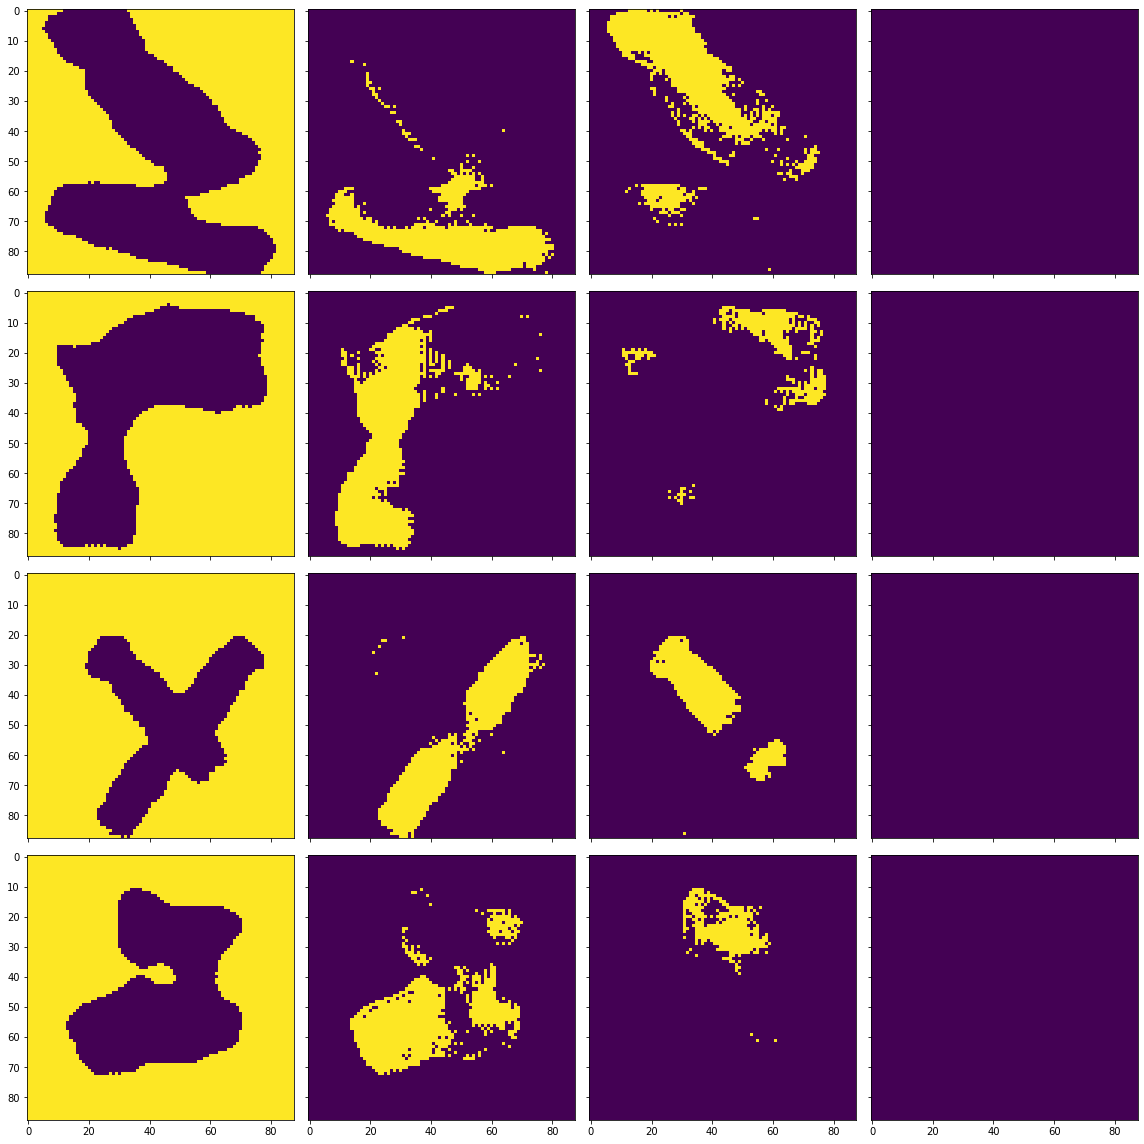

Training IOU: [0.9742820590813934, 0.5348606532657184, 0.3780138844577667, 0.0]
Training accuracy: 0.8515395790289256
Testing IOU: [0.9731686875674094, 0.4098338808446556, 0.22697224304615773, 0.0]
Testing accuracy: 0.8307567148760331
13/13 [==============================] - 1s 67ms/step - loss: 0.0395 - val_loss: 0.0472
INFO:tensorflow:Assets written to: modelunet/savedmodel_27epoch\assets
4
4


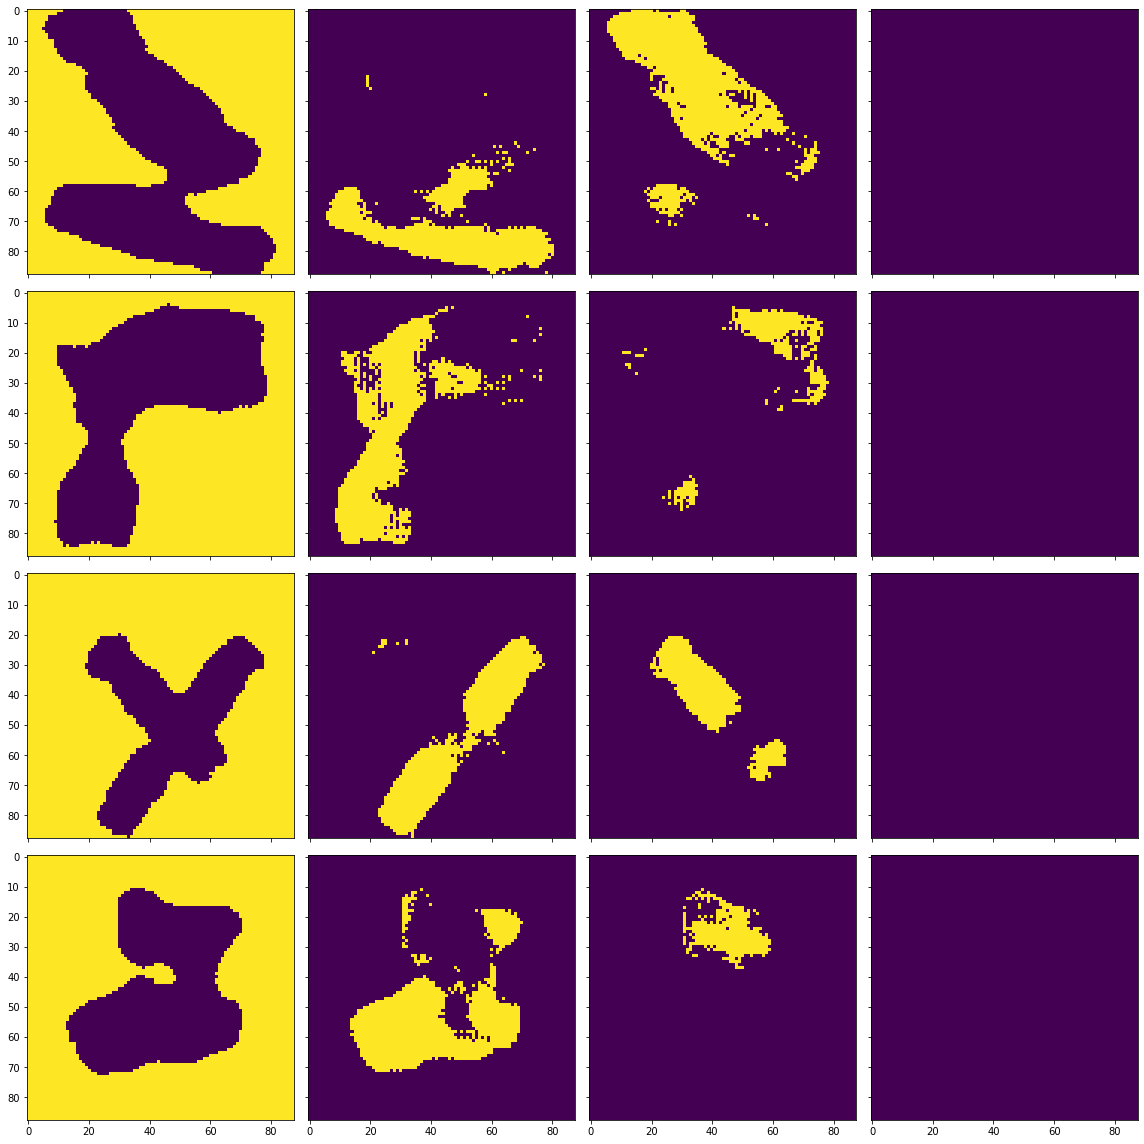

Training IOU: [0.9747862692071682, 0.5388166373349224, 0.4070902805426349, 0.0]
Training accuracy: 0.8586786544421487
Testing IOU: [0.973571304196413, 0.4031578598202143, 0.2524811097327168, 0.0]
Testing accuracy: 0.8351717458677685
13/13 [==============================] - 1s 66ms/step - loss: 0.0397 - val_loss: 0.0457
INFO:tensorflow:Assets written to: modelunet/savedmodel_28epoch\assets
4
4


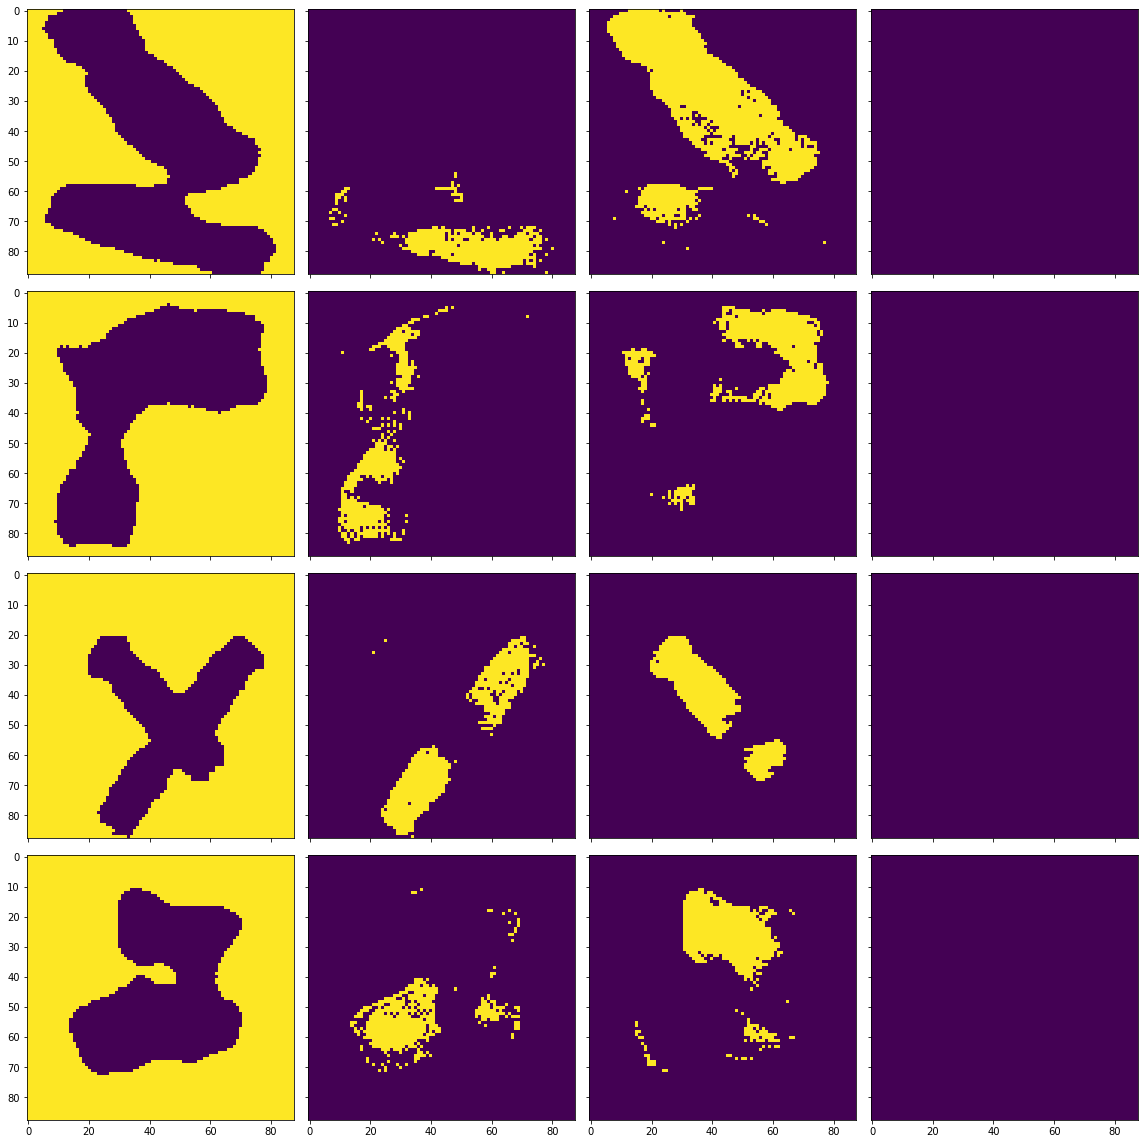

Training IOU: [0.9751639214102423, 0.4217162145278748, 0.46082600044420935, 0.0]
Training accuracy: 0.8370196280991735
Testing IOU: [0.9735637542831294, 0.27469638061645757, 0.29524216325534364, 0.0]
Testing accuracy: 0.8133471074380165
13/13 [==============================] - 1s 67ms/step - loss: 0.0405 - val_loss: 0.0466
INFO:tensorflow:Assets written to: modelunet/savedmodel_29epoch\assets
4
4


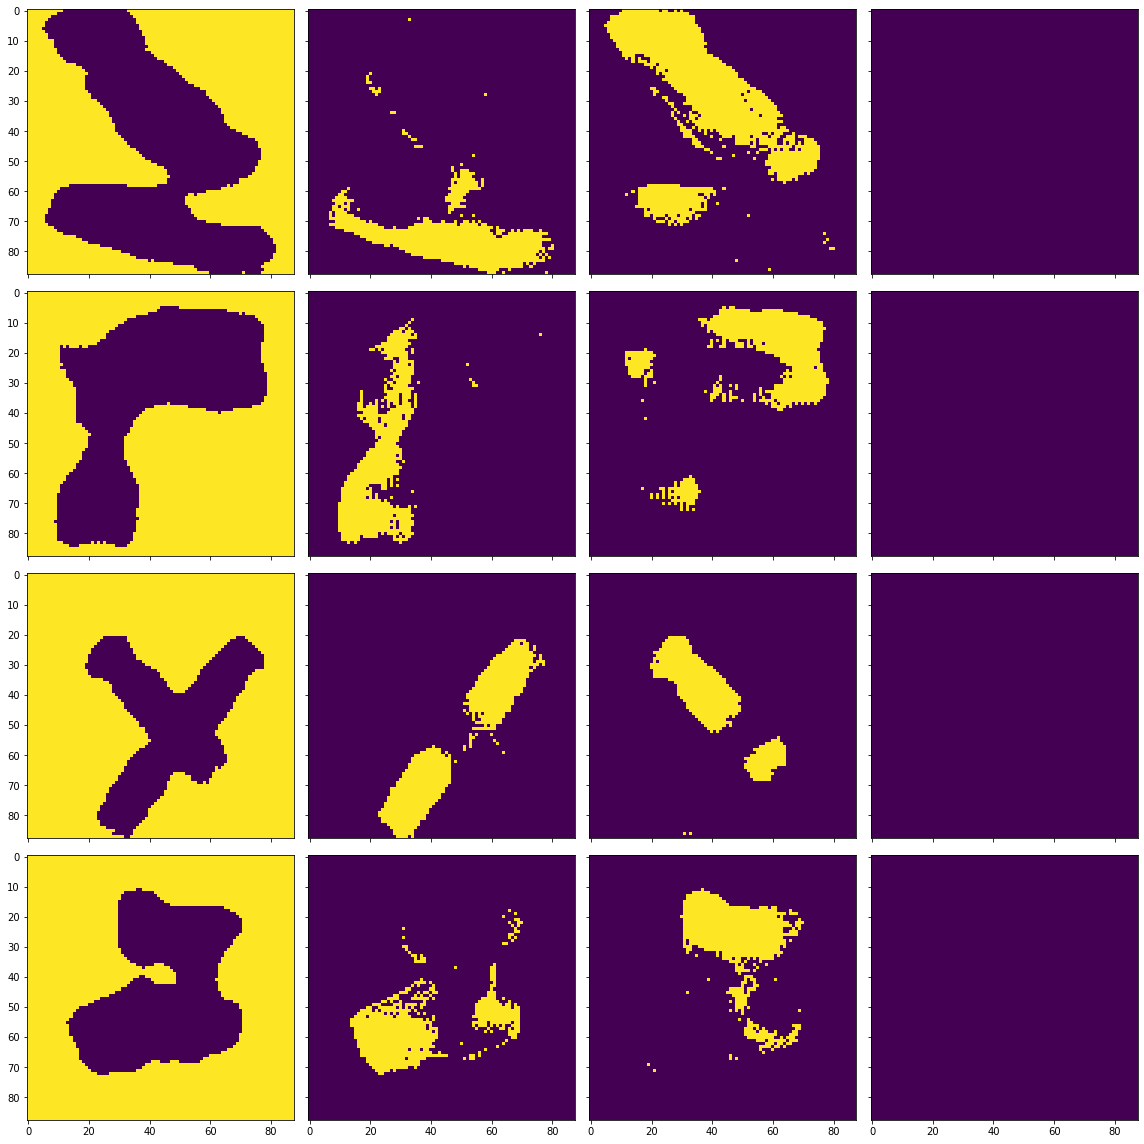

Training IOU: [0.9735693007648963, 0.49928579447139115, 0.47155591930631746, 1.0906314756243866e-05]
Training accuracy: 0.8574134814049587
Testing IOU: [0.972060501143382, 0.3464500905286278, 0.32004398313979643, 0.0]
Testing accuracy: 0.8328267045454546
13/13 [==============================] - ETA: 0s - loss: 0.040 - 1s 66ms/step - loss: 0.0407 - val_loss: 0.0461
INFO:tensorflow:Assets written to: modelunet/savedmodel_30epoch\assets
4
4


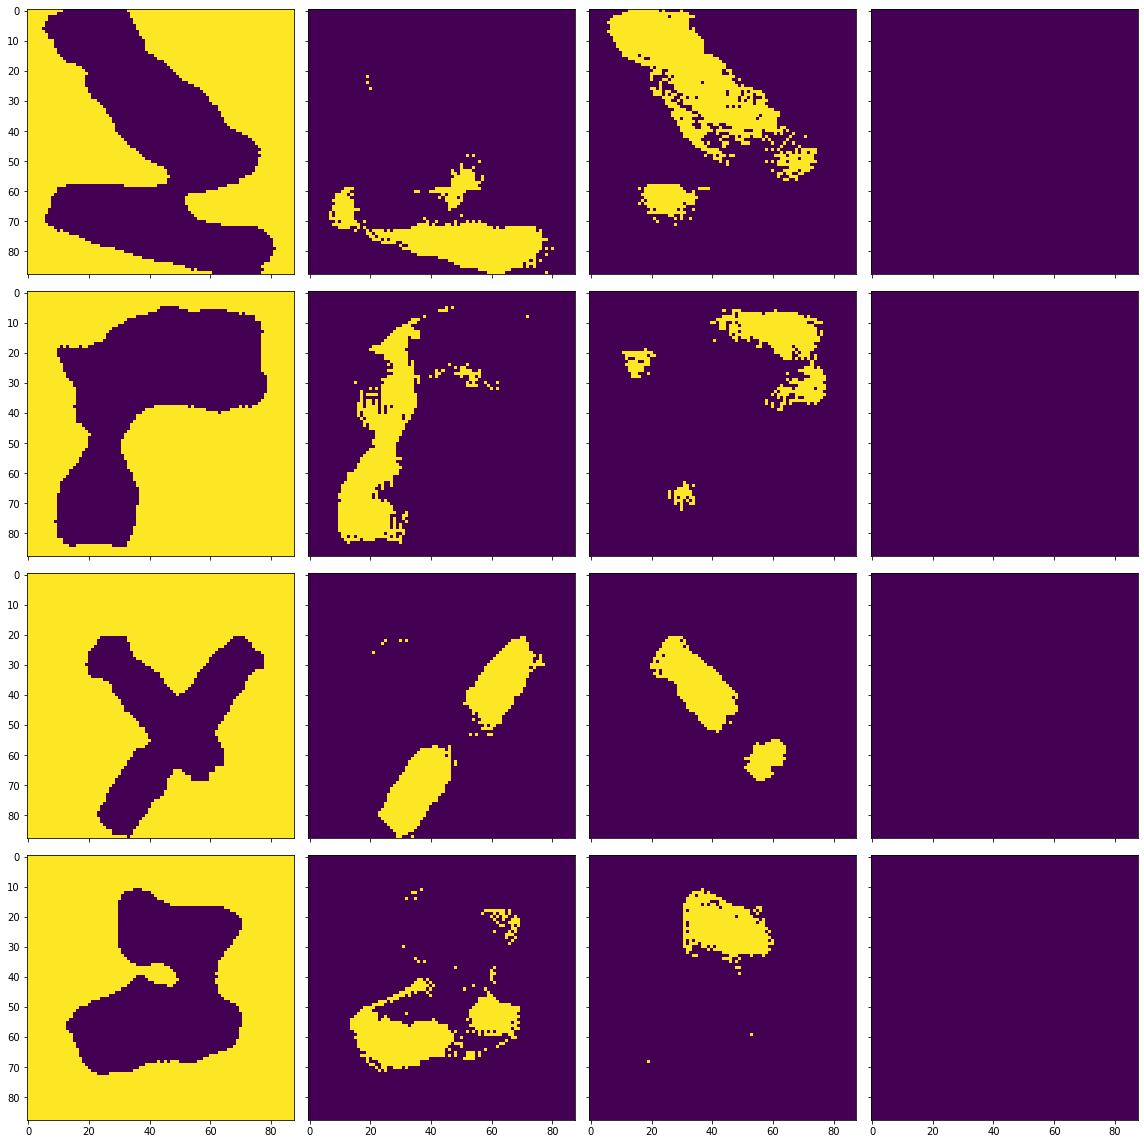

Training IOU: [0.9746709787839385, 0.5187667332053016, 0.40350588003739607, 0.0]
Training accuracy: 0.8492649147727273
Testing IOU: [0.9737275785044769, 0.3800827976748011, 0.24370780203978631, 0.0]
Testing accuracy: 0.8272959710743801
13/13 [==============================] - 1s 66ms/step - loss: 0.0390 - val_loss: 0.0465
INFO:tensorflow:Assets written to: modelunet/savedmodel_31epoch\assets
4
4


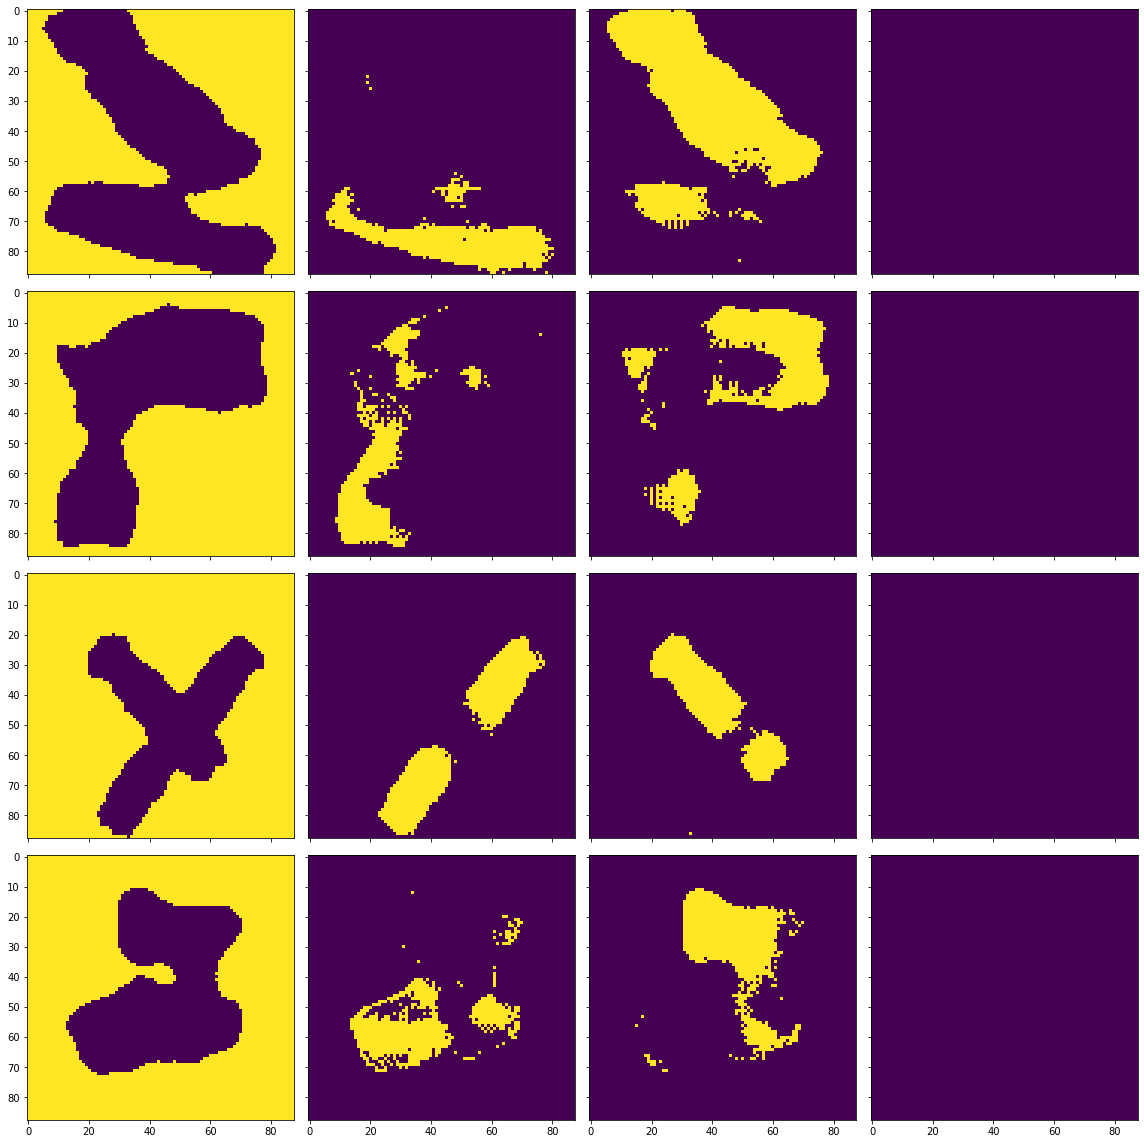

Training IOU: [0.9755547584577856, 0.5131116230215076, 0.5211369702256701, 0.0]
Training accuracy: 0.8685249870867768
Testing IOU: [0.973902422899058, 0.34314286144261014, 0.34345938277090493, 0.0]
Testing accuracy: 0.8386221590909091
13/13 [==============================] - 1s 66ms/step - loss: 0.0382 - val_loss: 0.0455
INFO:tensorflow:Assets written to: modelunet/savedmodel_32epoch\assets
4
4


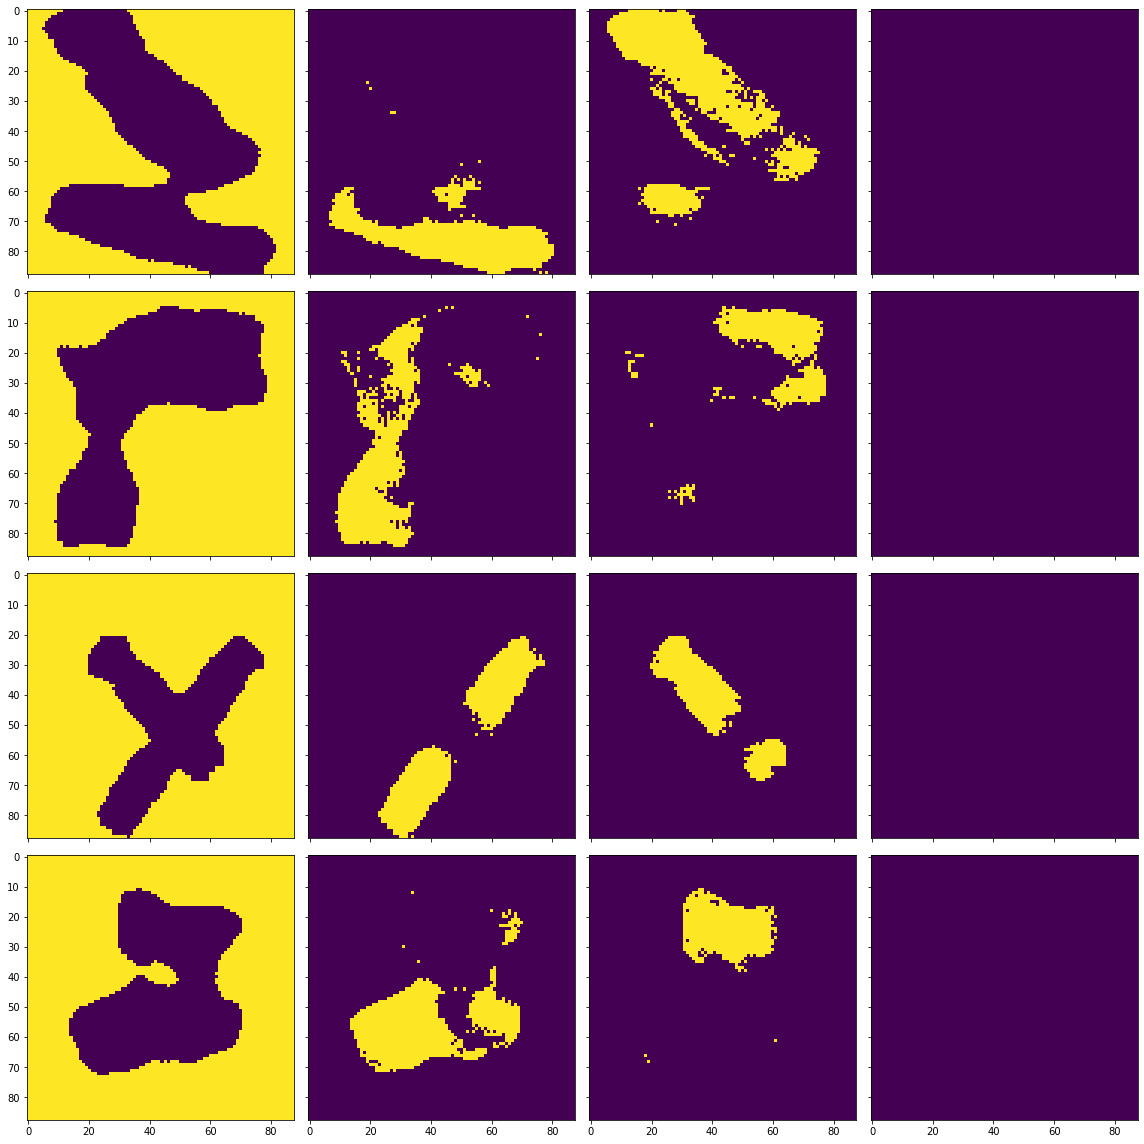

Training IOU: [0.9752257169472798, 0.5502714593992817, 0.4319182355153419, 0.0]
Training accuracy: 0.8579551911157025
Testing IOU: [0.9737813763218036, 0.382626746848717, 0.25271669981056144, 0.0]
Testing accuracy: 0.8296306818181818
13/13 [==============================] - 1s 67ms/step - loss: 0.0379 - val_loss: 0.0468
INFO:tensorflow:Assets written to: modelunet/savedmodel_33epoch\assets
4
4


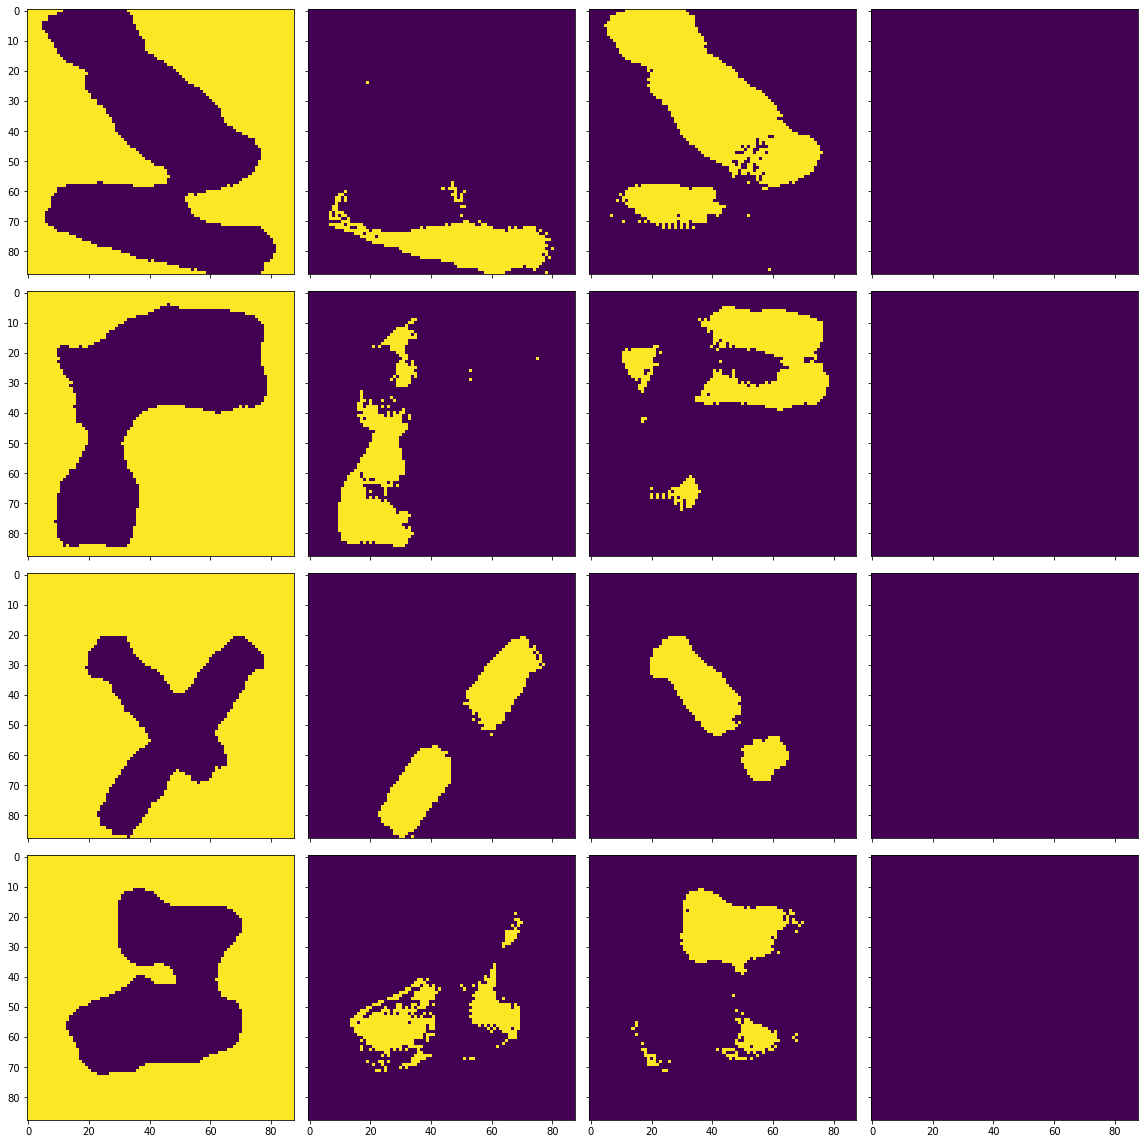

Training IOU: [0.9754512745061682, 0.5316114009573232, 0.5207075809780403, 0.0]
Training accuracy: 0.8687612990702479
Testing IOU: [0.9738866495408757, 0.3645281134818426, 0.32777059291683247, 0.0]
Testing accuracy: 0.8377492252066115
13/13 [==============================] - 1s 67ms/step - loss: 0.0372 - val_loss: 0.0446
INFO:tensorflow:Assets written to: modelunet/savedmodel_34epoch\assets
4
4


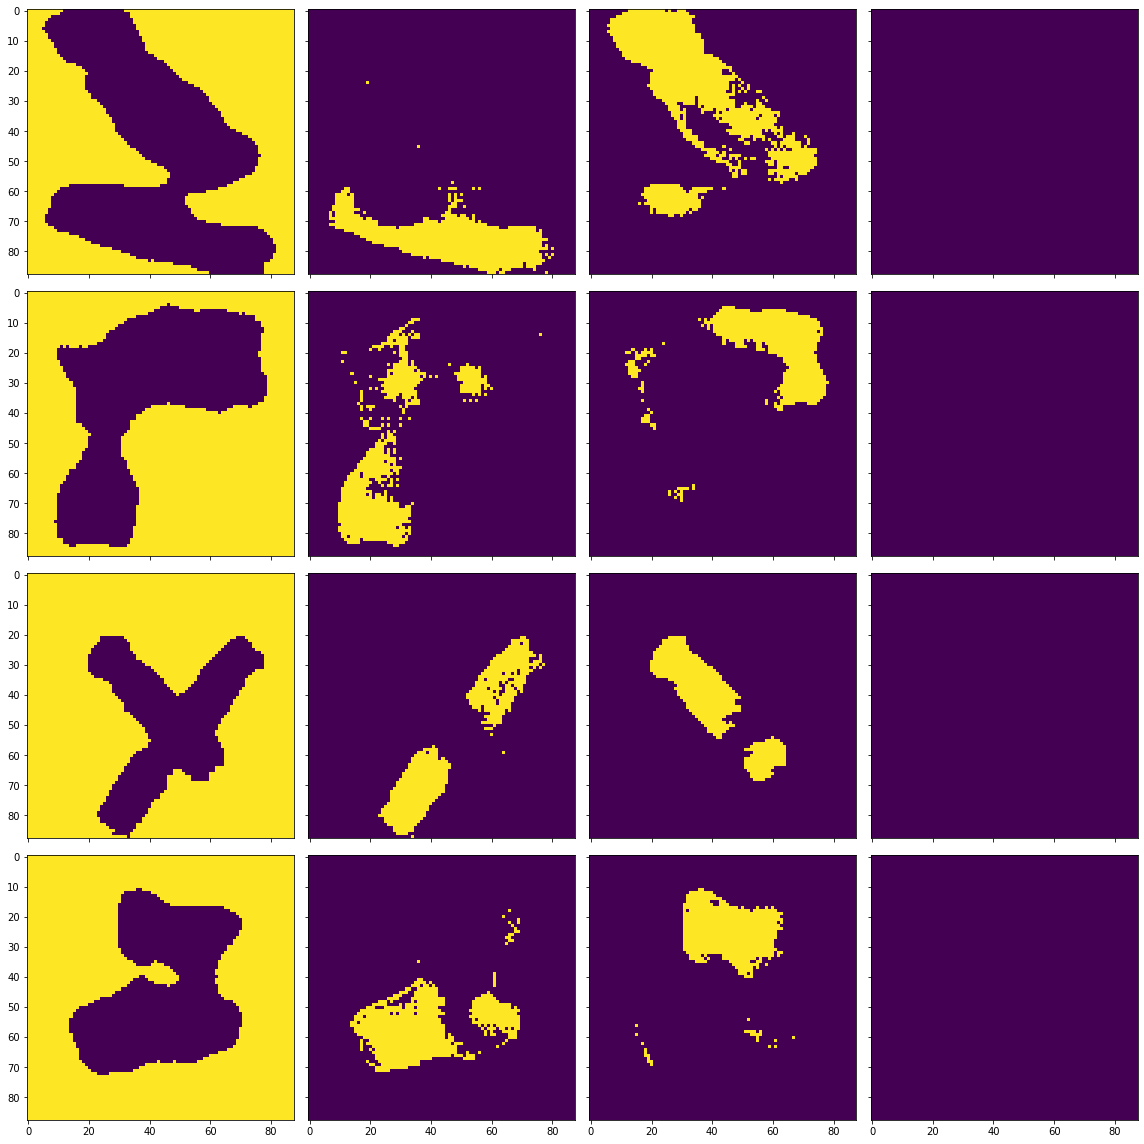

Training IOU: [0.9756150365938938, 0.5157961759966915, 0.4818451045073159, 0.0]
Training accuracy: 0.8553053977272728
Testing IOU: [0.9737739835145806, 0.34684868242325456, 0.27191920651840074, 0.0]
Testing accuracy: 0.8243801652892562
13/13 [==============================] - 1s 67ms/step - loss: 0.0376 - val_loss: 0.0459
INFO:tensorflow:Assets written to: modelunet/savedmodel_35epoch\assets
4
4


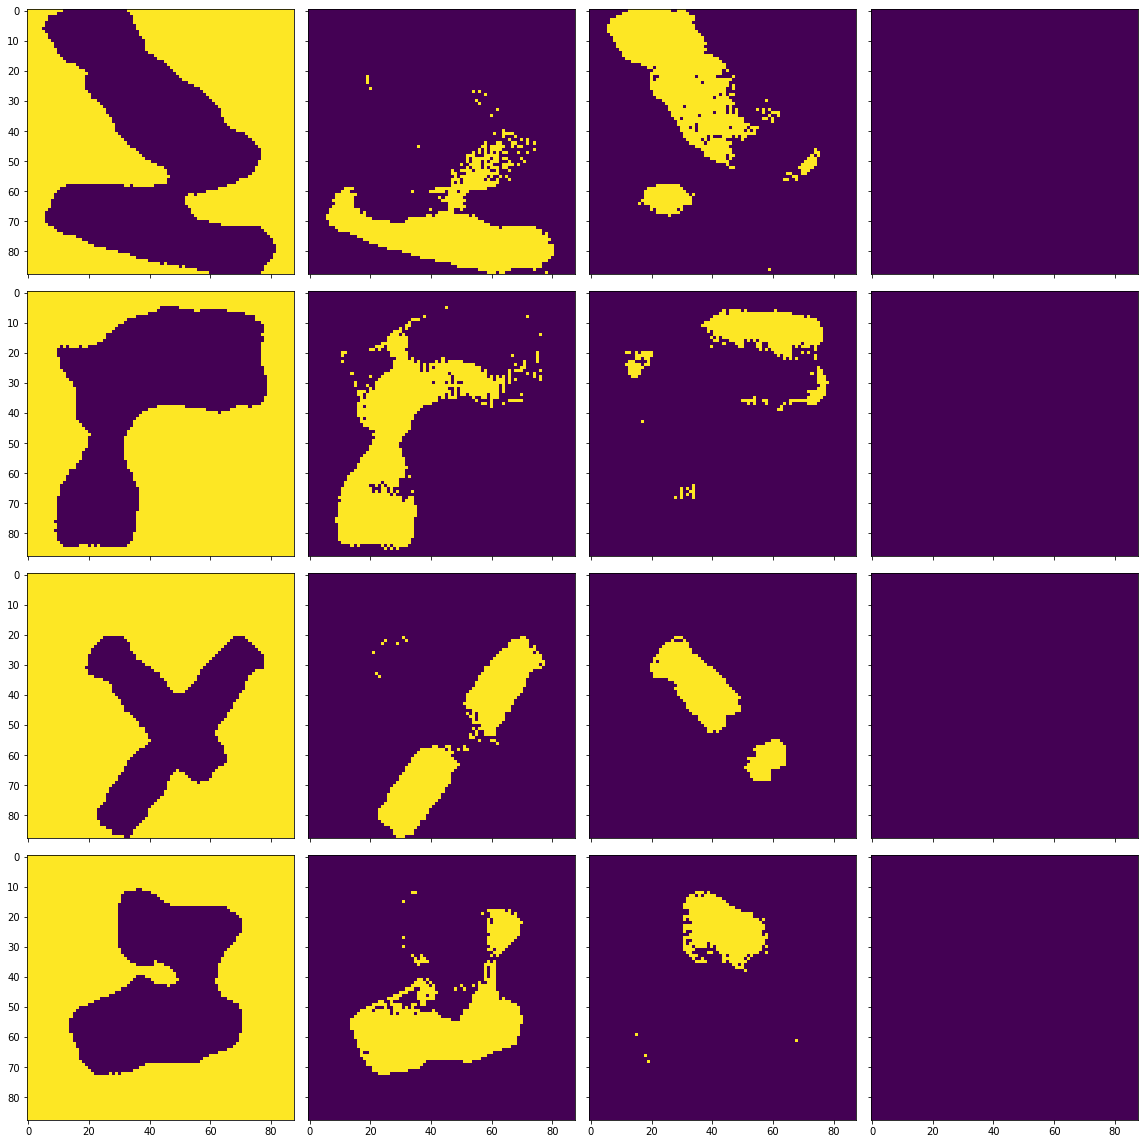

Training IOU: [0.9752218058815421, 0.5659633381234447, 0.44118449546854527, 0.0]
Training accuracy: 0.8678915934917355
Testing IOU: [0.9736896533145162, 0.4122374331693577, 0.2688262437183583, 0.0]
Testing accuracy: 0.8403486570247933
13/13 [==============================] - 1s 67ms/step - loss: 0.0369 - val_loss: 0.0477
INFO:tensorflow:Assets written to: modelunet/savedmodel_36epoch\assets
4
4


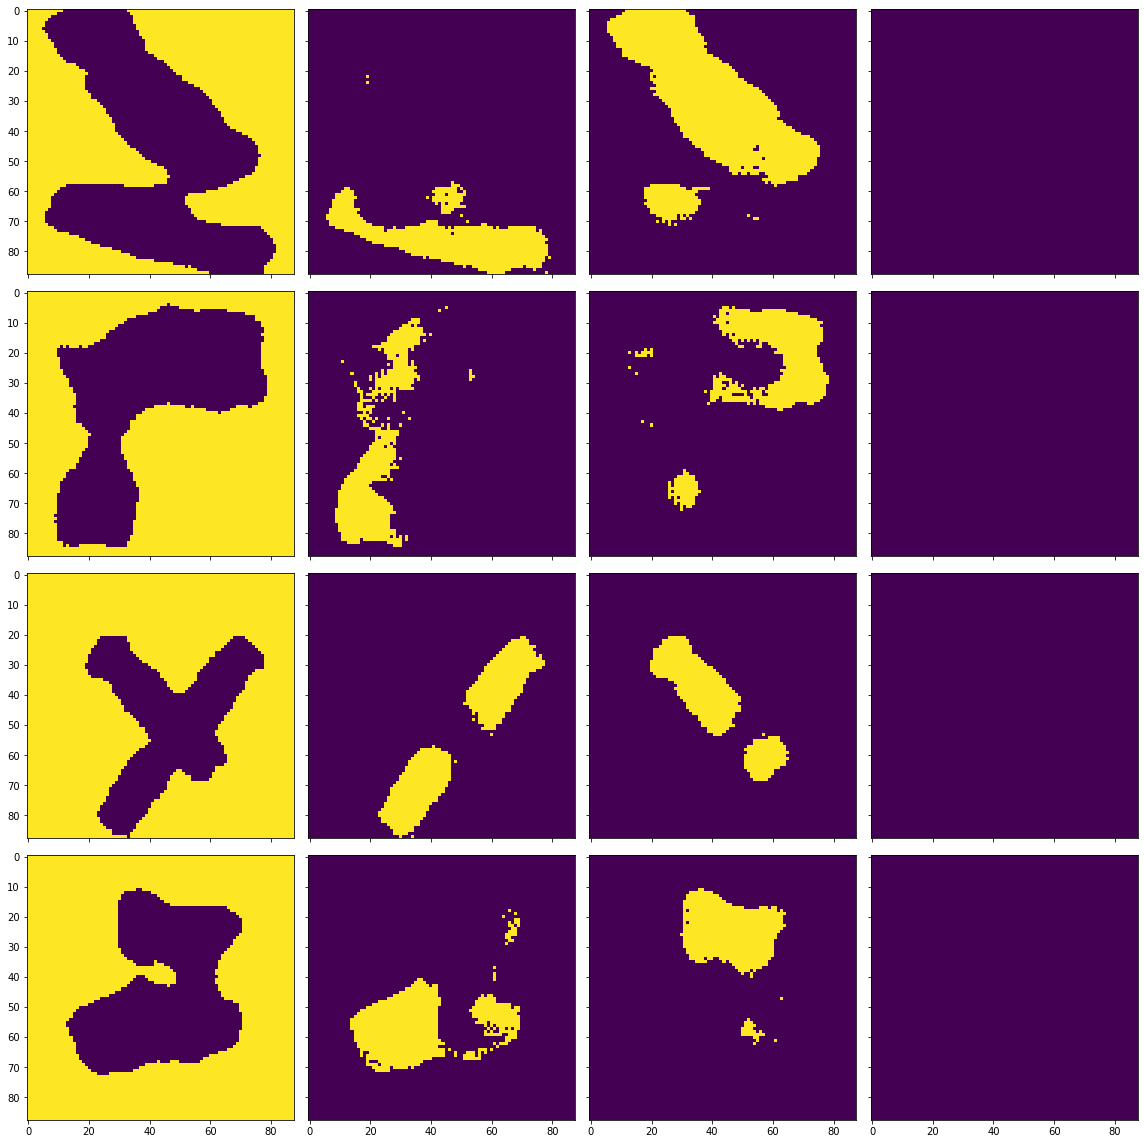

Training IOU: [0.9758899721063824, 0.5501724971656826, 0.5359233477265218, 0.0]
Training accuracy: 0.8706143465909091
Testing IOU: [0.9743552367168872, 0.34964089690361777, 0.31002043608235236, 0.0]
Testing accuracy: 0.8332489669421488
13/13 [==============================] - 1s 67ms/step - loss: 0.0370 - val_loss: 0.0465
INFO:tensorflow:Assets written to: modelunet/savedmodel_37epoch\assets
4
4


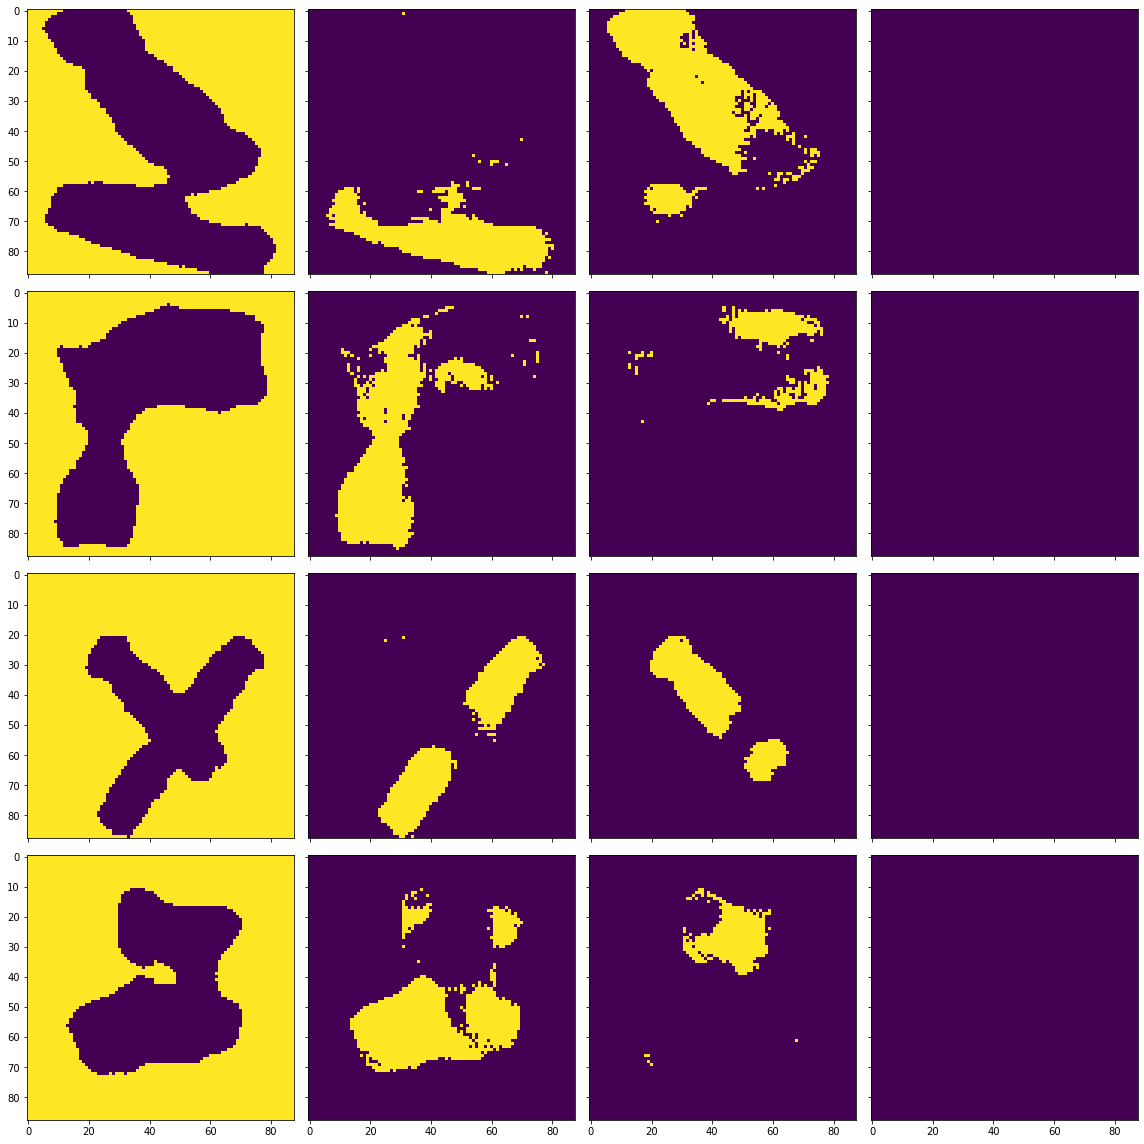

Training IOU: [0.9759472234587011, 0.5924726646467635, 0.4717627391492787, 0.0]
Training accuracy: 0.8719024405991735
Testing IOU: [0.9740495919495665, 0.42163269938117903, 0.2512849310896216, 0.0]
Testing accuracy: 0.839114152892562
13/13 [==============================] - 1s 67ms/step - loss: 0.0365 - val_loss: 0.0461
INFO:tensorflow:Assets written to: modelunet/savedmodel_38epoch\assets
4
4


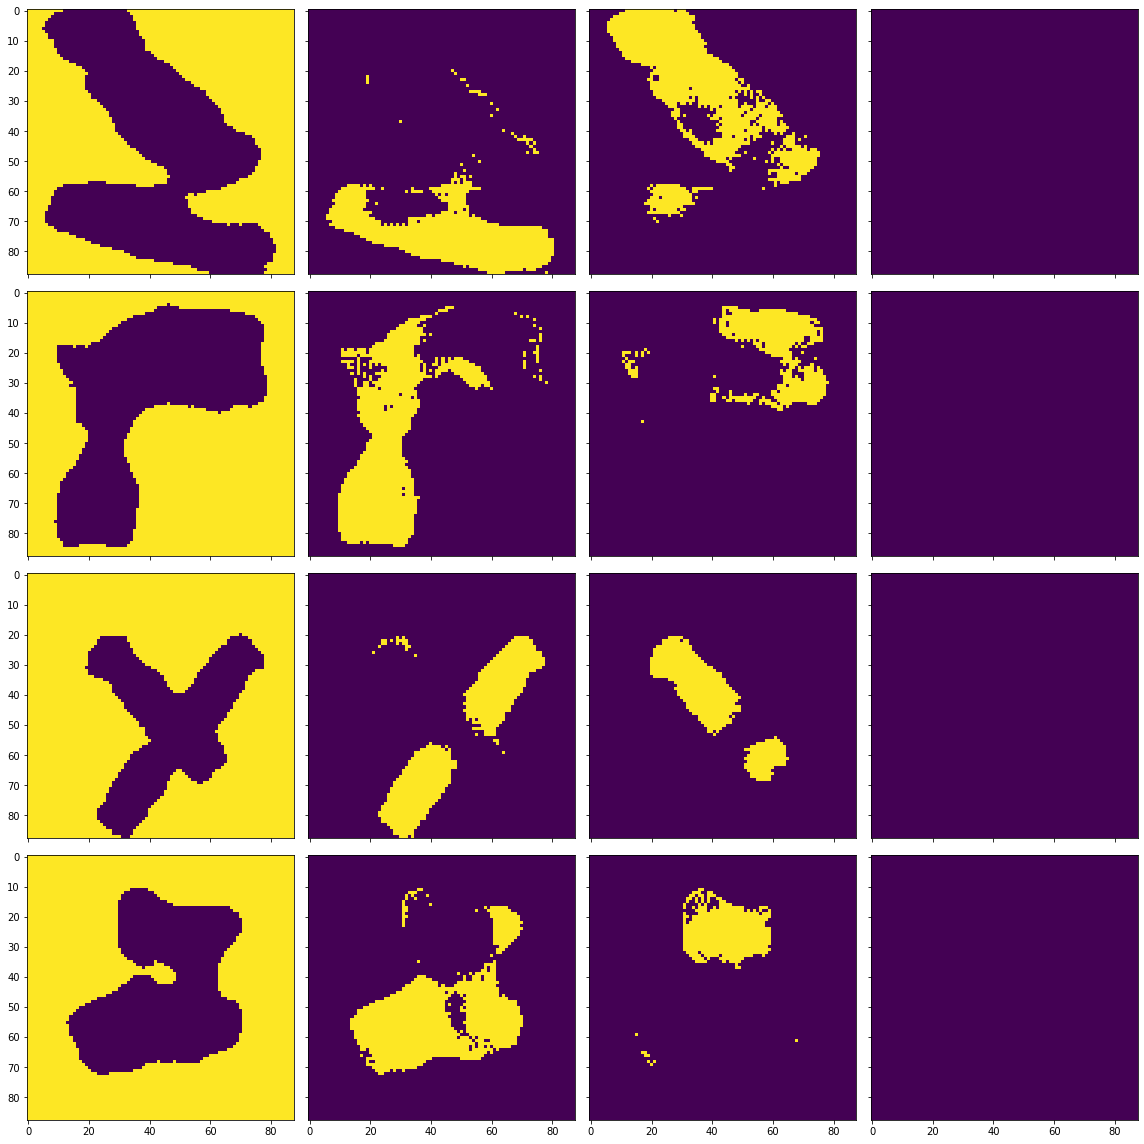

Training IOU: [0.9746736119561094, 0.5959829870924708, 0.47152003299288714, 0.0]
Training accuracy: 0.8765570118801653
Testing IOU: [0.973270694961931, 0.43551815935802246, 0.24626430463006338, 0.0]
Testing accuracy: 0.8428757747933884
13/13 [==============================] - 1s 66ms/step - loss: 0.0364 - val_loss: 0.0468
INFO:tensorflow:Assets written to: modelunet/savedmodel_39epoch\assets
4
4


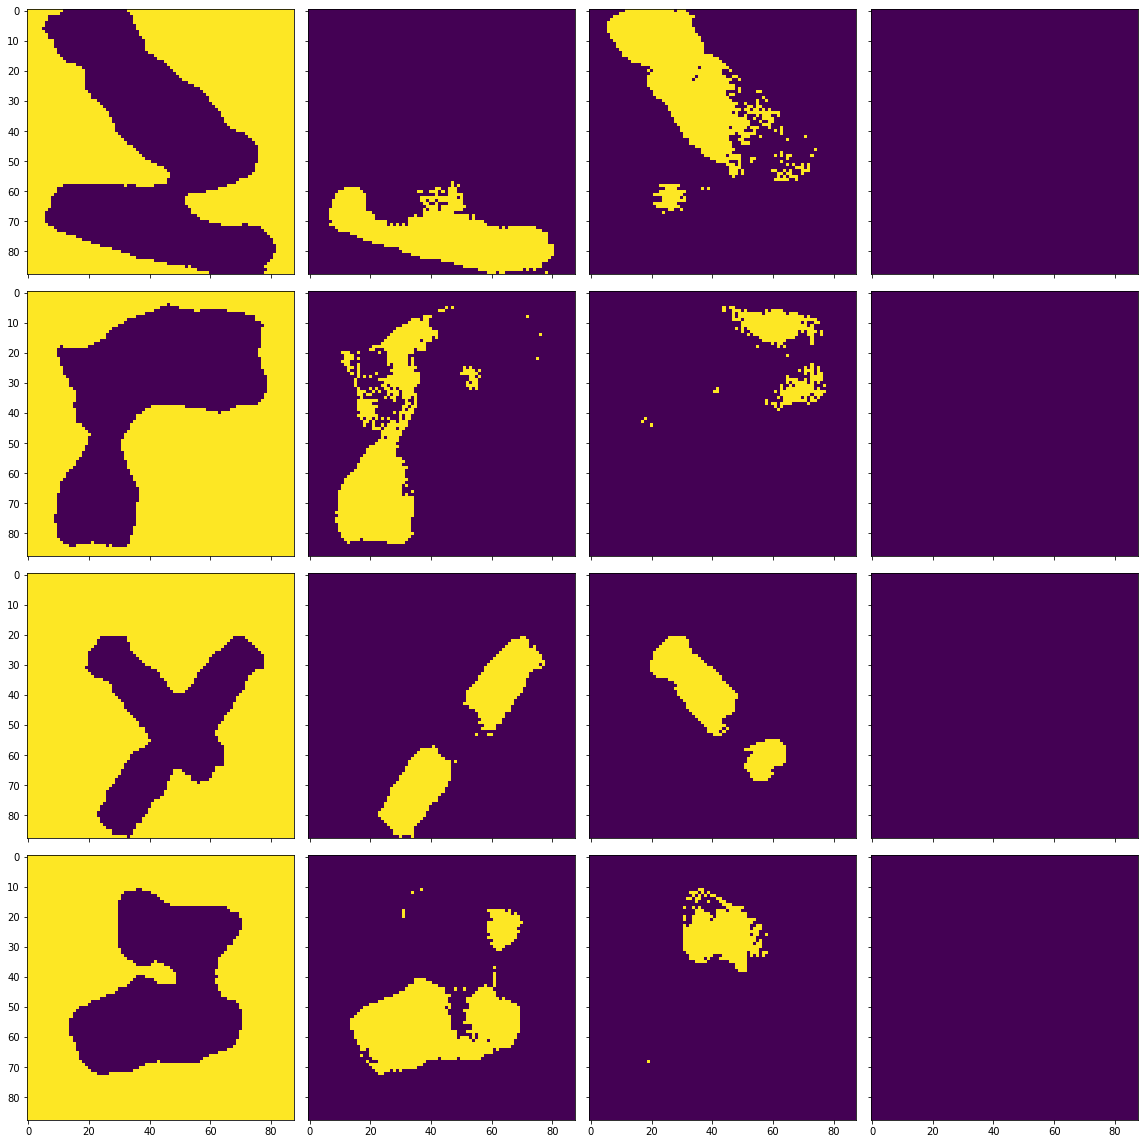

Training IOU: [0.9755279011853061, 0.5875199296063915, 0.46405343118385467, 0.0]
Training accuracy: 0.8645386751033057
Testing IOU: [0.9741006644904561, 0.3778786327064584, 0.23402490408815407, 0.0]
Testing accuracy: 0.8264514462809918
13/13 [==============================] - 1s 67ms/step - loss: 0.0354 - val_loss: 0.0465
INFO:tensorflow:Assets written to: modelunet/savedmodel_40epoch\assets
4
4


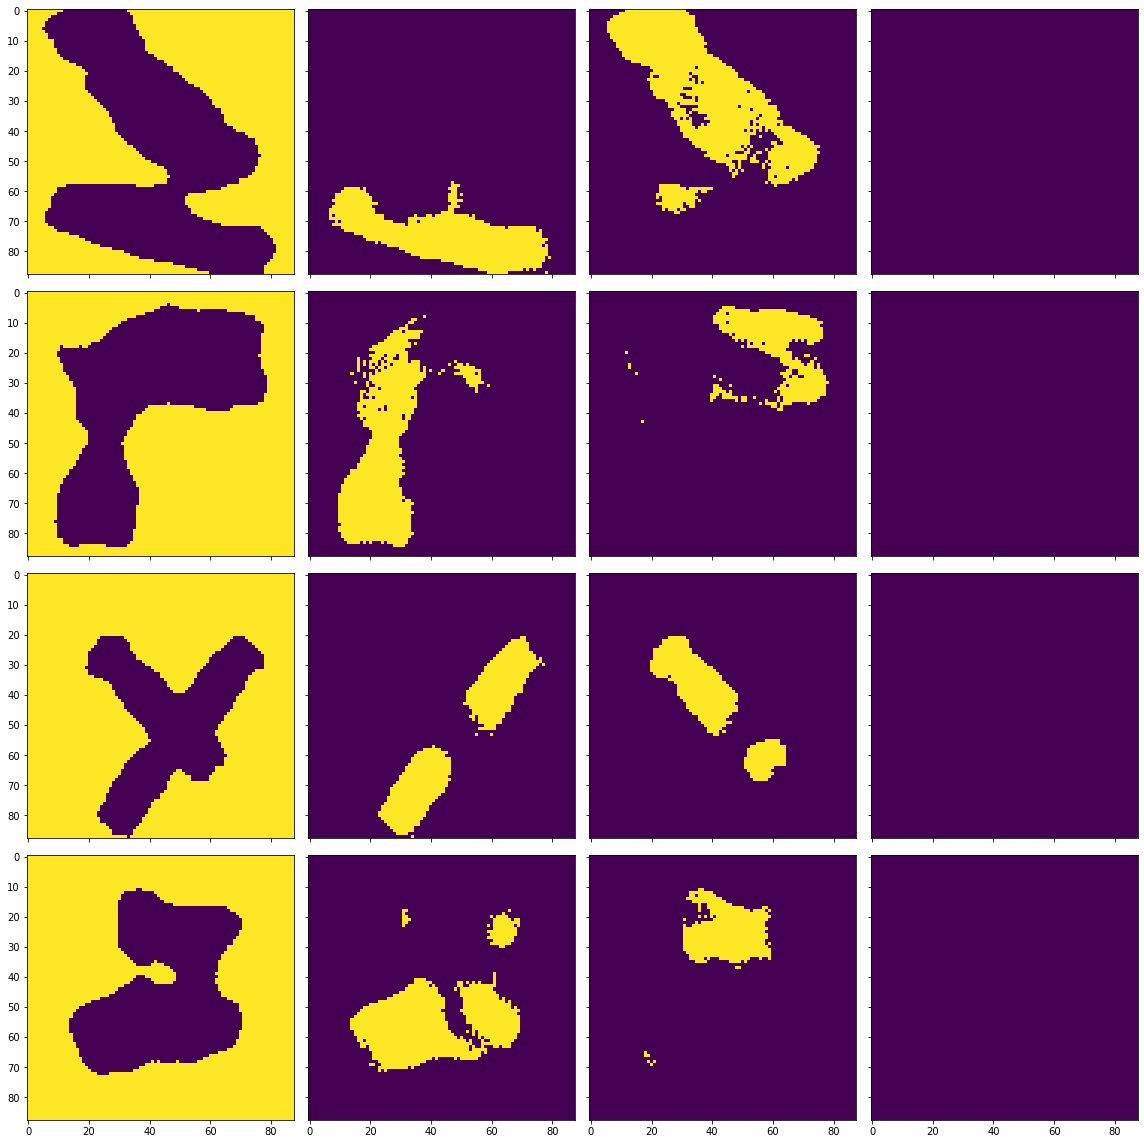

Training IOU: [0.9757248122640068, 0.6029185882514165, 0.5056283184070146, 0.0]
Training accuracy: 0.8742019628099174
Testing IOU: [0.9736488434037026, 0.39647267286729776, 0.25677097028661583, 0.0]
Testing accuracy: 0.8336570247933884
13/13 [==============================] - 1s 67ms/step - loss: 0.0343 - val_loss: 0.0455
INFO:tensorflow:Assets written to: modelunet/savedmodel_41epoch\assets
4
4


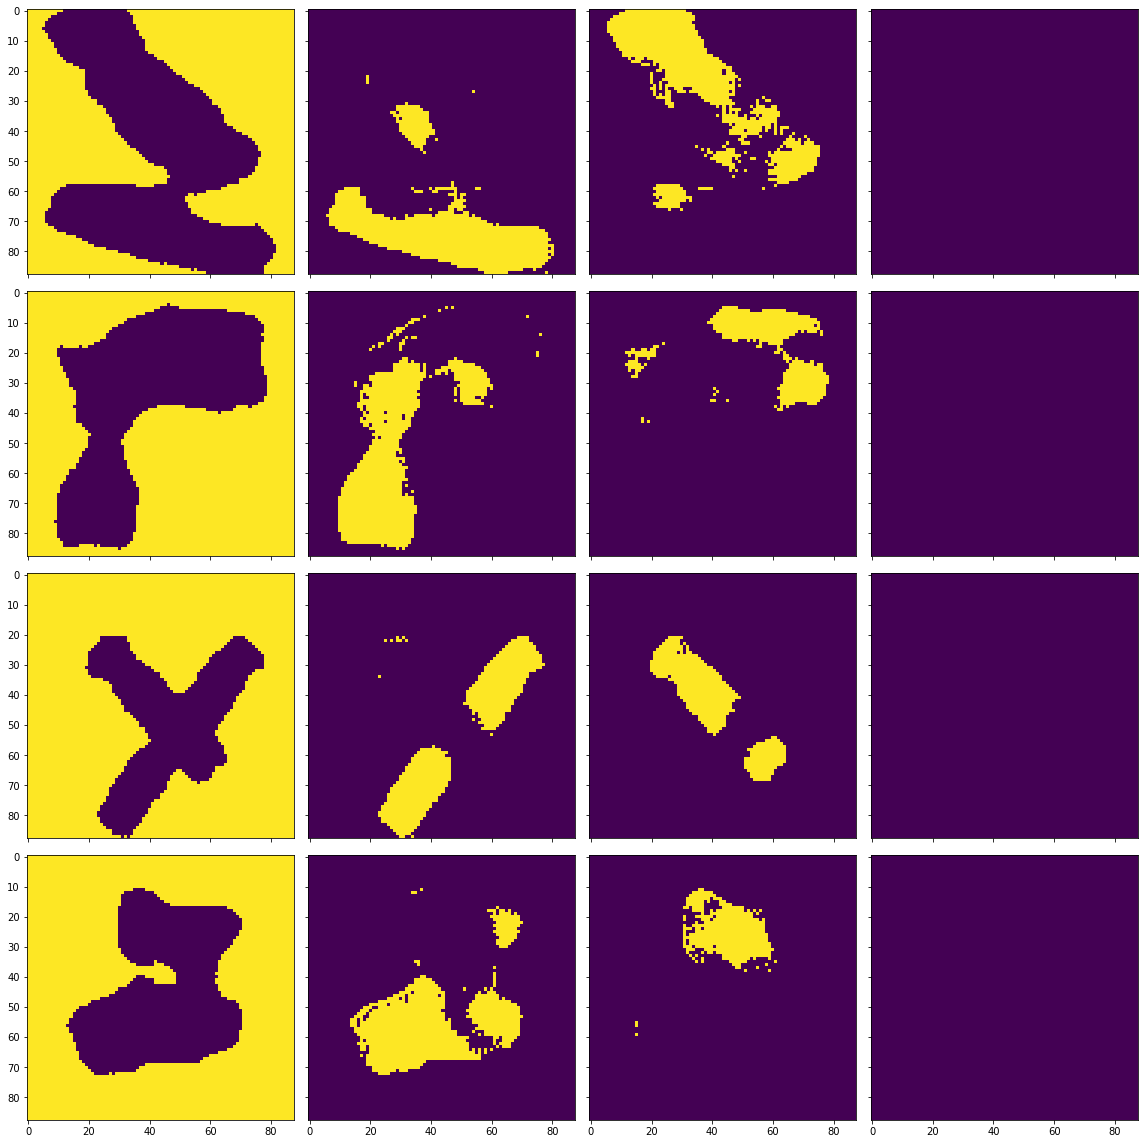

Training IOU: [0.9760347679532809, 0.6184142183759466, 0.5154895855863106, 0.0]
Training accuracy: 0.8743662835743802
Testing IOU: [0.9742120393641391, 0.40002683464211064, 0.2575569241200068, 0.0]
Testing accuracy: 0.832266270661157
13/13 [==============================] - 1s 67ms/step - loss: 0.0336 - val_loss: 0.0466- ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.033
INFO:tensorflow:Assets written to: modelunet/savedmodel_42epoch\assets
4
4


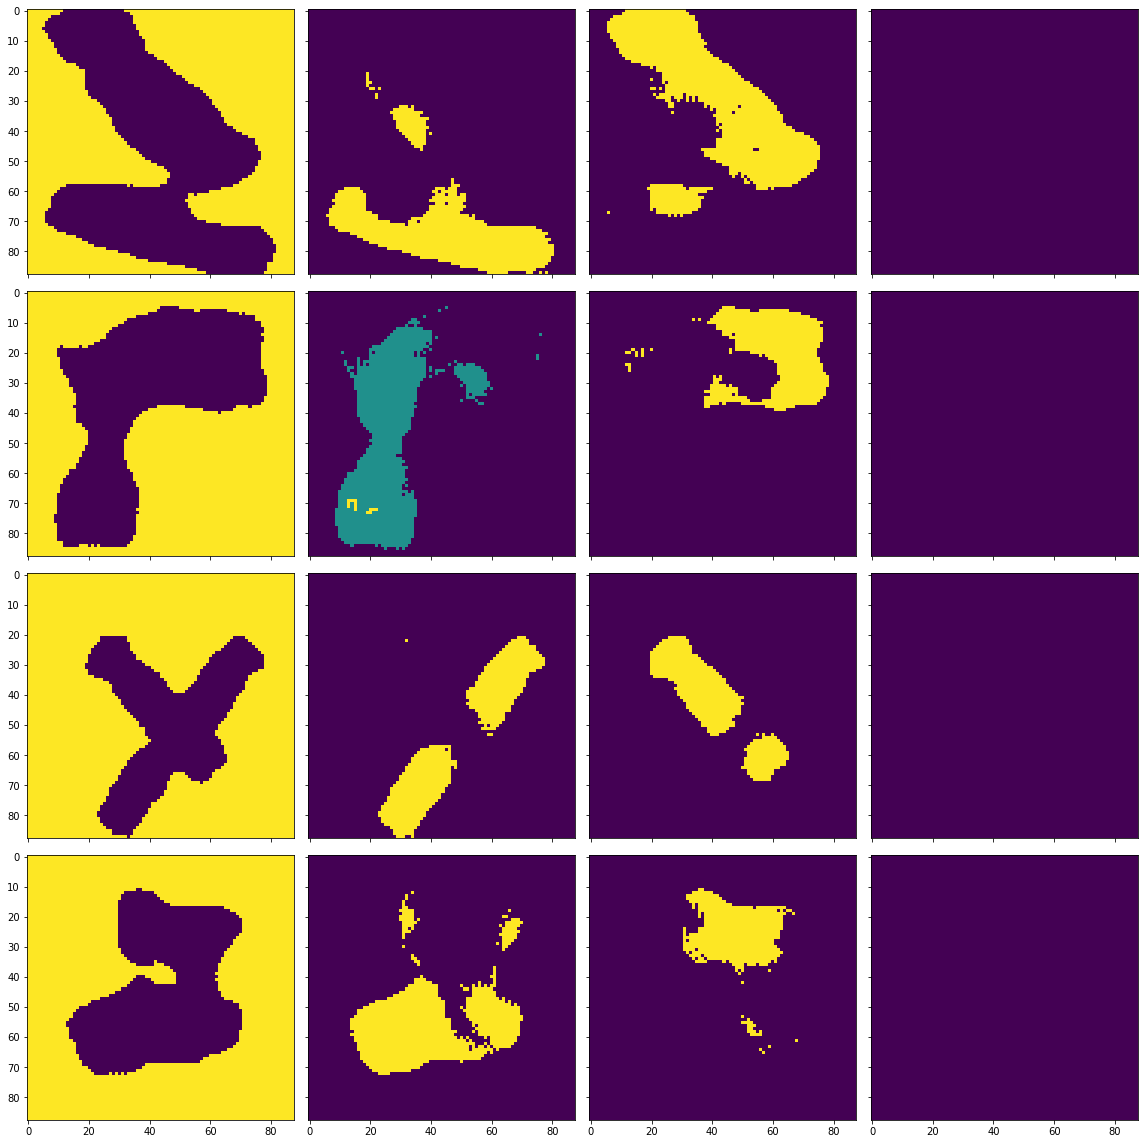

Training IOU: [0.9752803786972518, 0.638017455391042, 0.5795663705955089, 0.0]
Training accuracy: 0.8926246126033058
Testing IOU: [0.9733628025965437, 0.426875923539374, 0.30716147559089907, 0.0]
Testing accuracy: 0.848828770661157
13/13 [==============================] - 1s 66ms/step - loss: 0.0329 - val_loss: 0.0461
INFO:tensorflow:Assets written to: modelunet/savedmodel_43epoch\assets
4
4


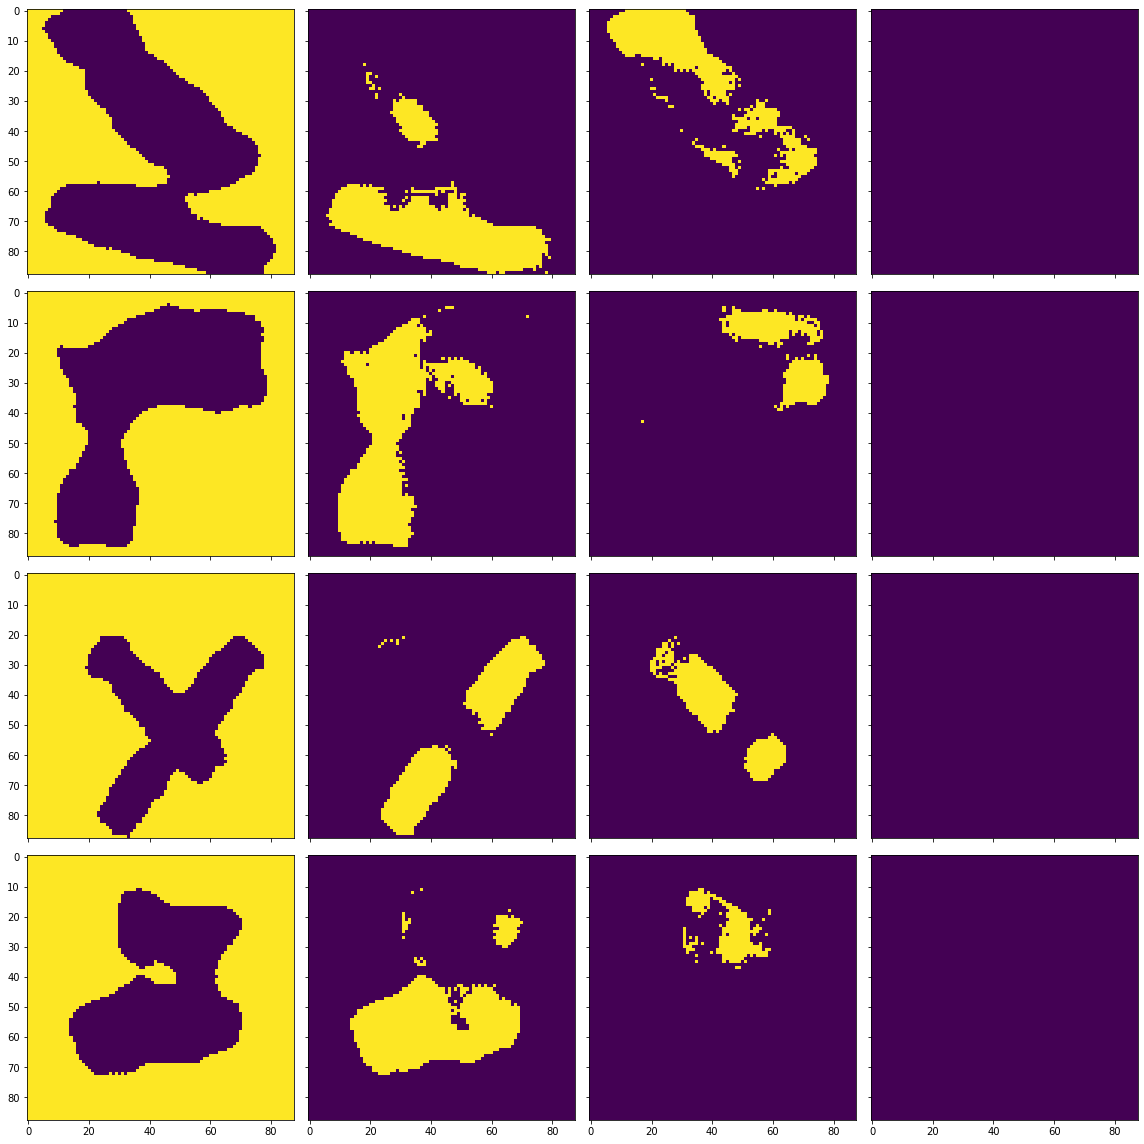

Training IOU: [0.9762046154113854, 0.6410516591194778, 0.49528468182619423, 0.0]
Training accuracy: 0.8773473011363636
Testing IOU: [0.9746466927030376, 0.4137432261744693, 0.24133607261012568, 0.0]
Testing accuracy: 0.8351110537190083
13/13 [==============================] - 1s 67ms/step - loss: 0.0328 - val_loss: 0.0495ETA: 0s - loss: 0.032
INFO:tensorflow:Assets written to: modelunet/savedmodel_44epoch\assets
4
4


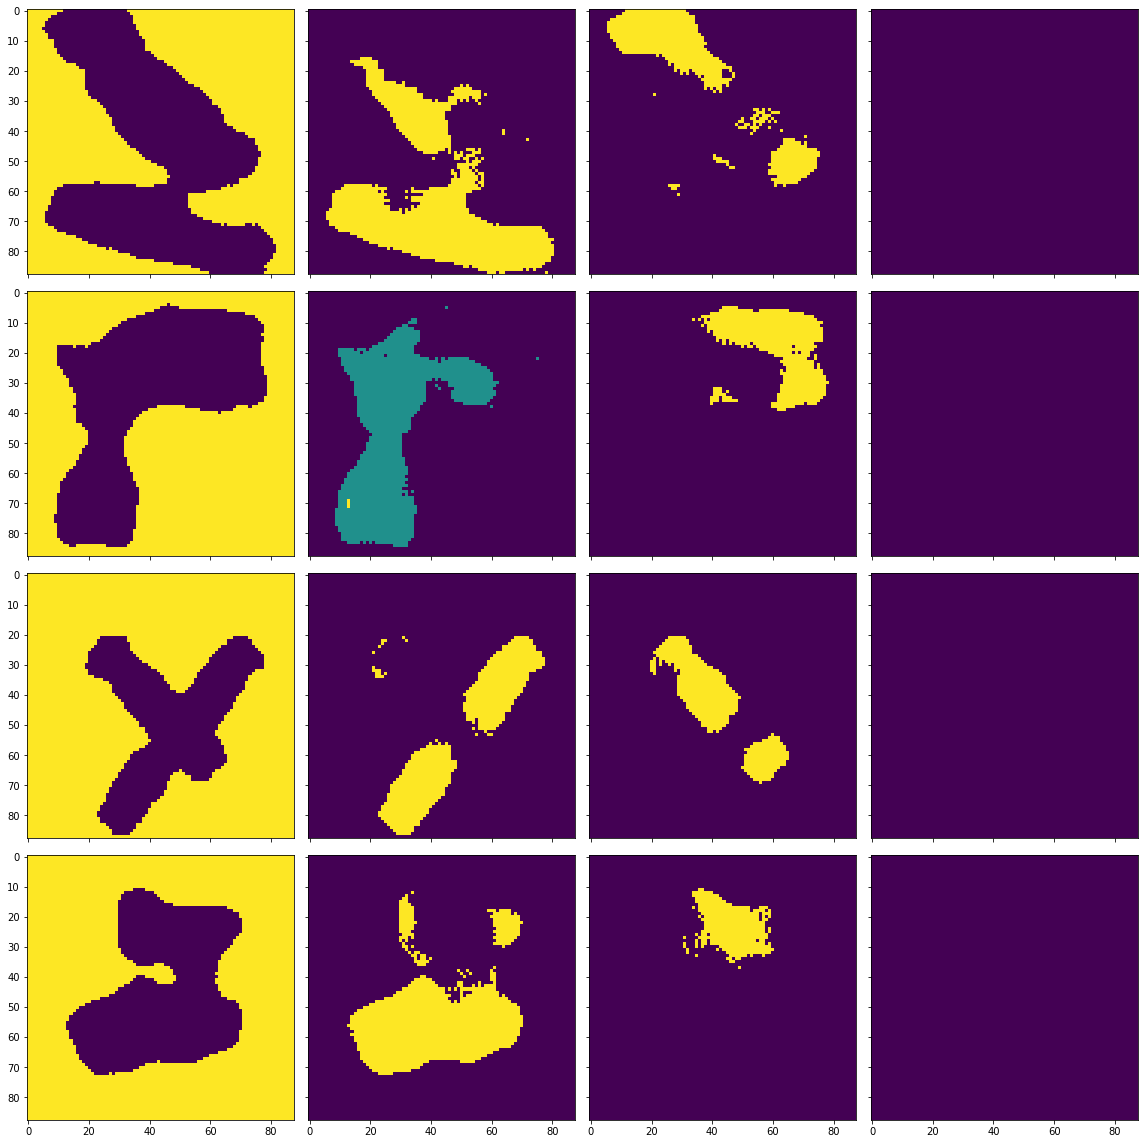

Training IOU: [0.9751830027158055, 0.6217085453960088, 0.4713491327263022, 0.0]
Training accuracy: 0.8830297649793388
Testing IOU: [0.9734600986972176, 0.4492696818446275, 0.22098158900302714, 0.0]
Testing accuracy: 0.8451278409090909
13/13 [==============================] - 1s 67ms/step - loss: 0.0346 - val_loss: 0.0476
INFO:tensorflow:Assets written to: modelunet/savedmodel_45epoch\assets
4
4


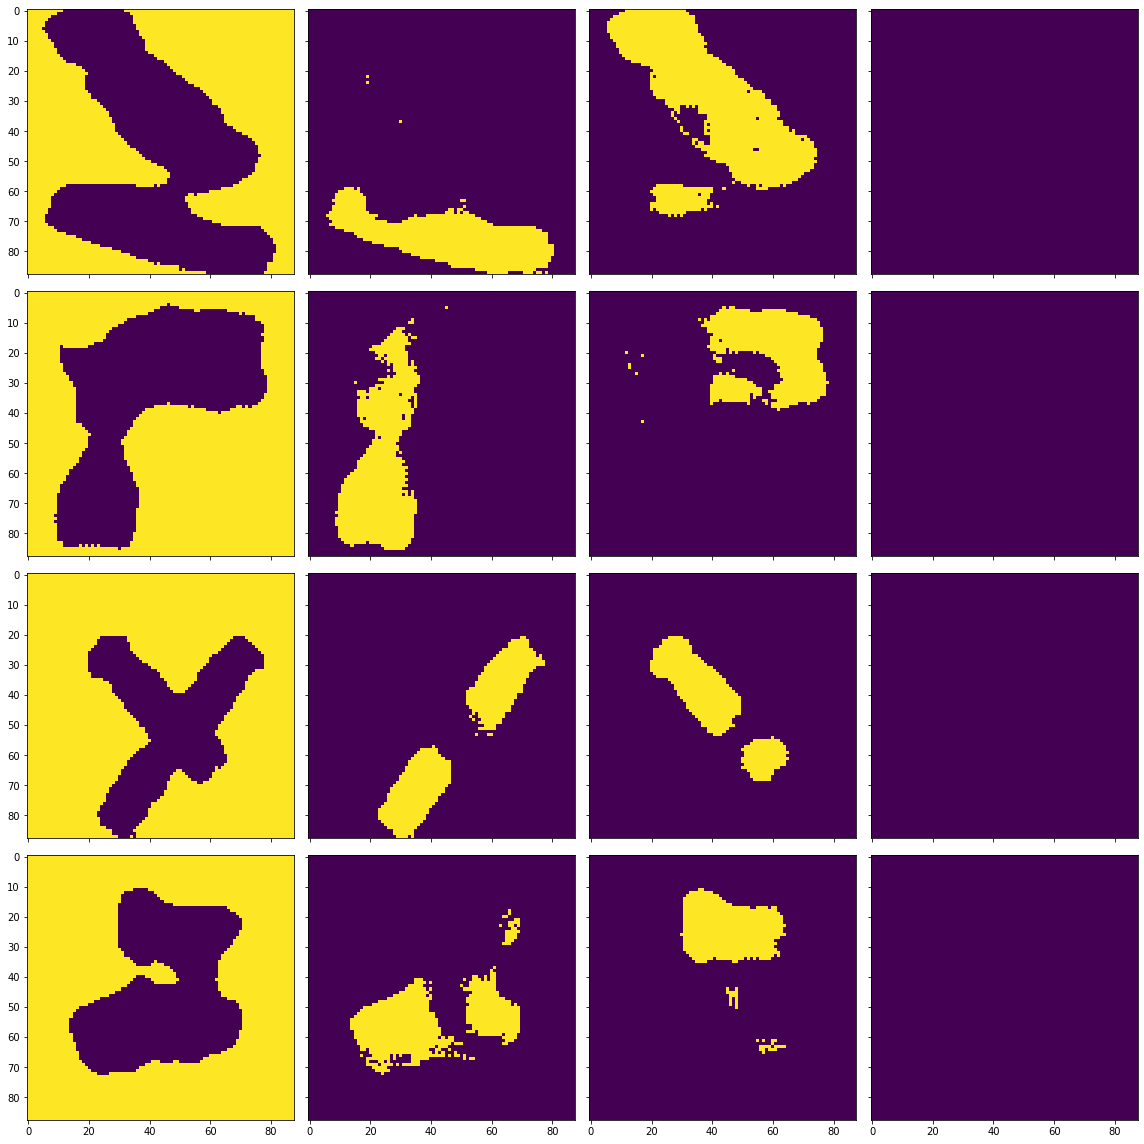

Training IOU: [0.9752688071353117, 0.6300142247510668, 0.6036033440415652, 0.0]
Training accuracy: 0.8873201833677686
Testing IOU: [0.9733000771192152, 0.37974529497247494, 0.30044562516068213, 0.0]
Testing accuracy: 0.8373786157024793
13/13 [==============================] - ETA: 0s - loss: 0.032 - 1s 66ms/step - loss: 0.0320 - val_loss: 0.0495
INFO:tensorflow:Assets written to: modelunet/savedmodel_46epoch\assets
4
4


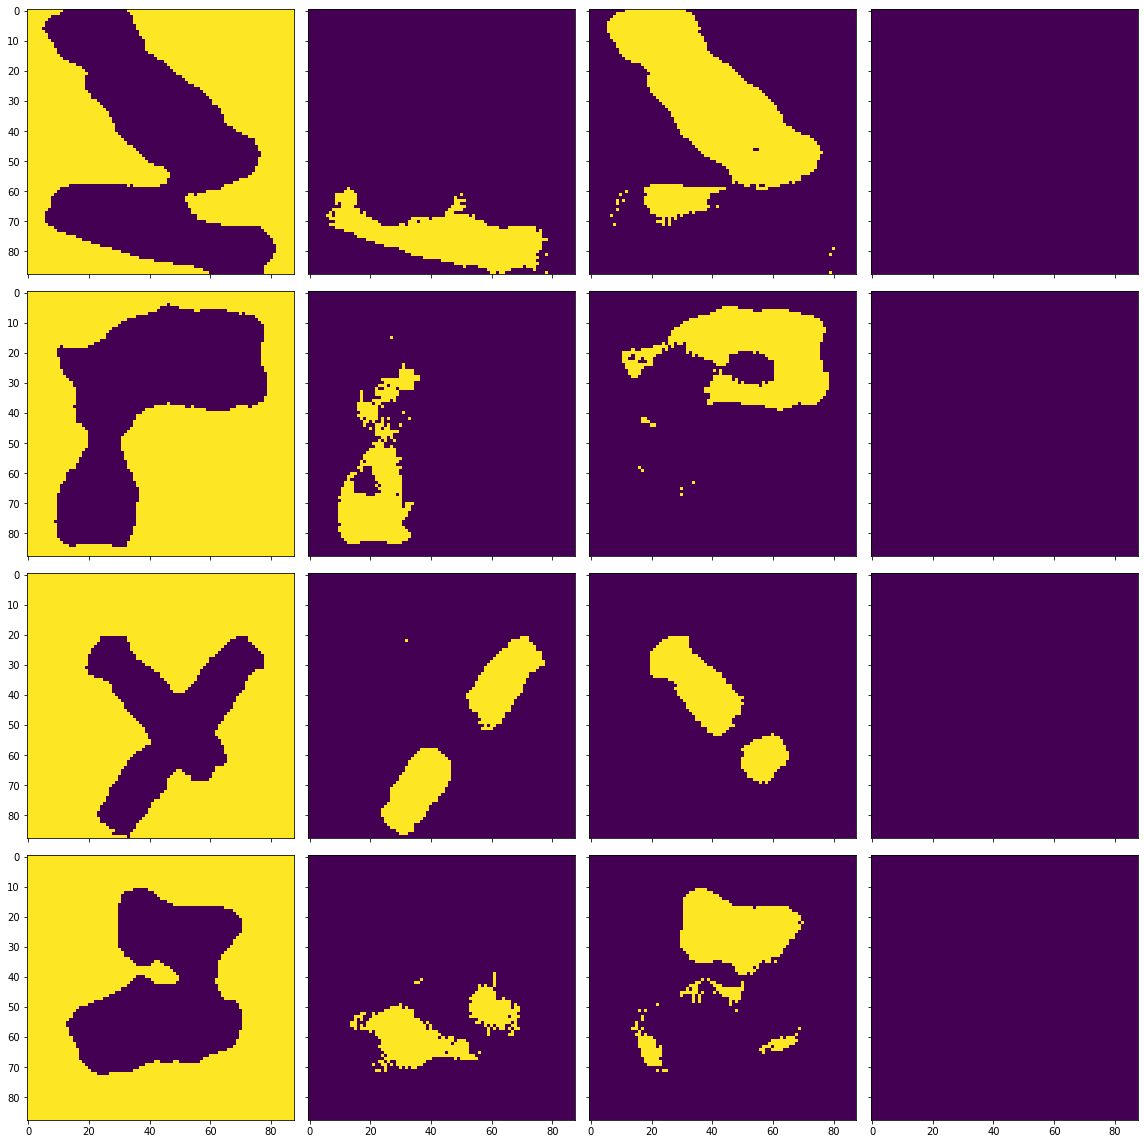

Training IOU: [0.9759979222760166, 0.5594769206477307, 0.6360017405465489, 0.0]
Training accuracy: 0.8849586776859504
Testing IOU: [0.974087782406749, 0.30932259703709497, 0.34449907570051164, 0.0]
Testing accuracy: 0.834324638429752
13/13 [==============================] - 1s 67ms/step - loss: 0.0345 - val_loss: 0.0491
INFO:tensorflow:Assets written to: modelunet/savedmodel_47epoch\assets
4
4


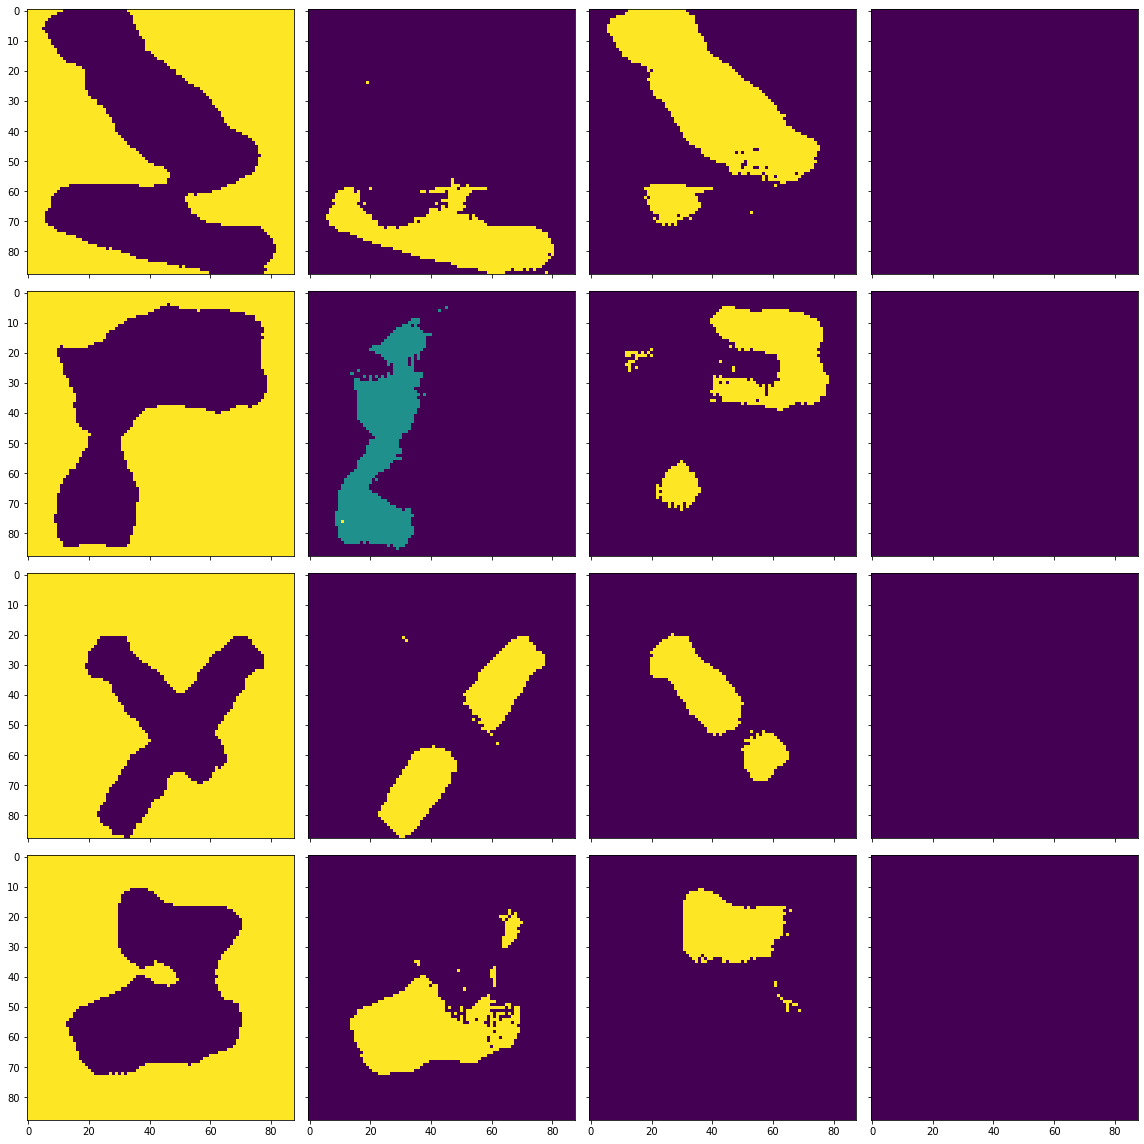

Training IOU: [0.9758831358122922, 0.6189796369414197, 0.5891254161941893, 0.0]
Training accuracy: 0.8909252324380166
Testing IOU: [0.9738388345805914, 0.3837044692025652, 0.3233380643361692, 0.0]
Testing accuracy: 0.8451497933884298
13/13 [==============================] - 1s 67ms/step - loss: 0.0320 - val_loss: 0.0488
INFO:tensorflow:Assets written to: modelunet/savedmodel_48epoch\assets
4
4


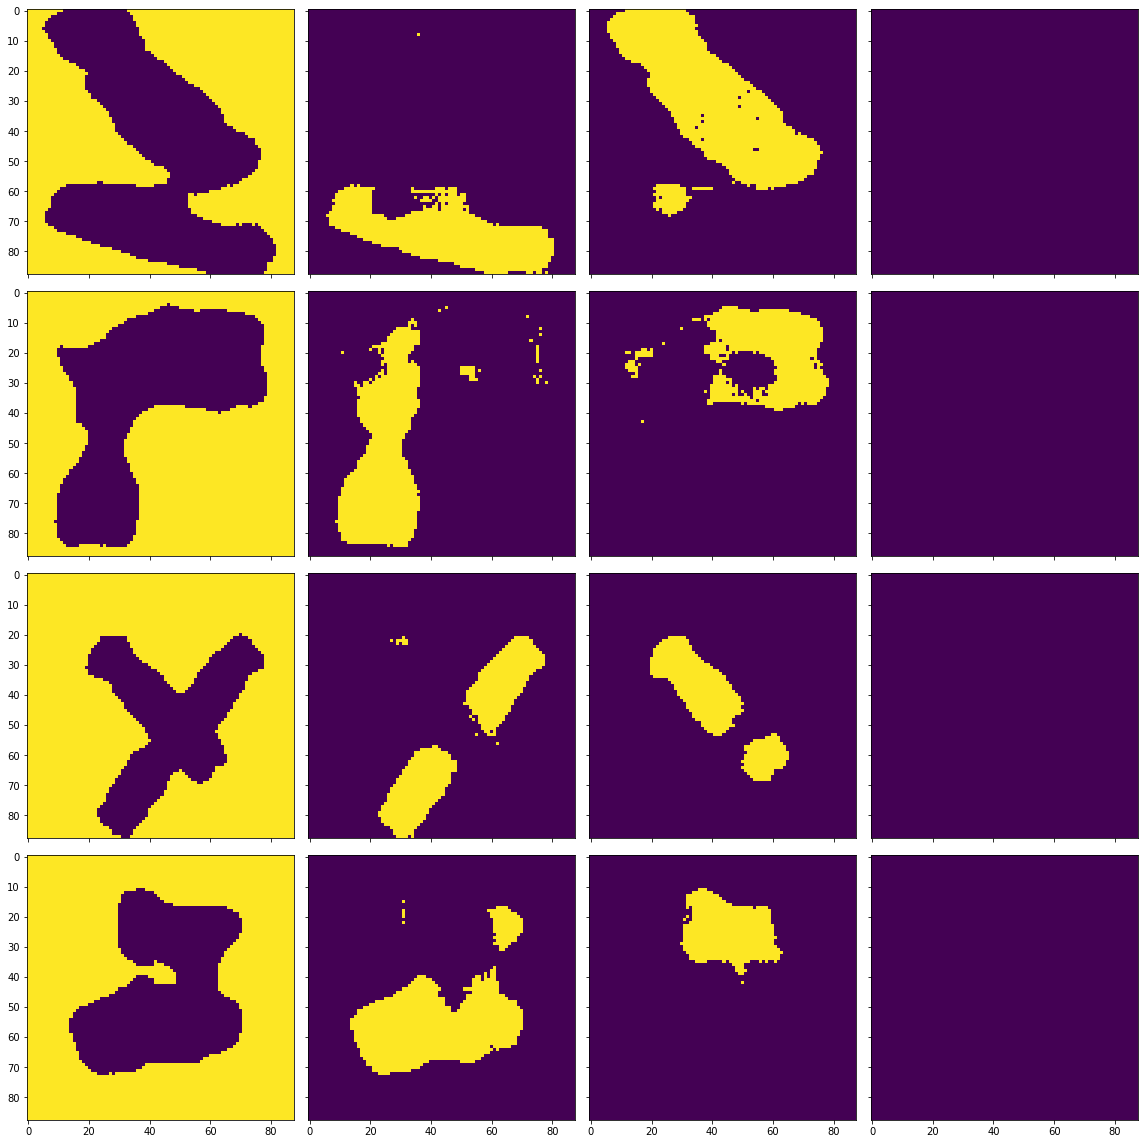

Training IOU: [0.9750159286468112, 0.6818600914360043, 0.6323753731325128, 0.0]
Training accuracy: 0.9034675232438016
Testing IOU: [0.9732075458571186, 0.4280486279775421, 0.2905319599266262, 0.0]
Testing accuracy: 0.8490586260330578
13/13 [==============================] - 1s 67ms/step - loss: 0.0310 - val_loss: 0.0507
INFO:tensorflow:Assets written to: modelunet/savedmodel_49epoch\assets
4
4


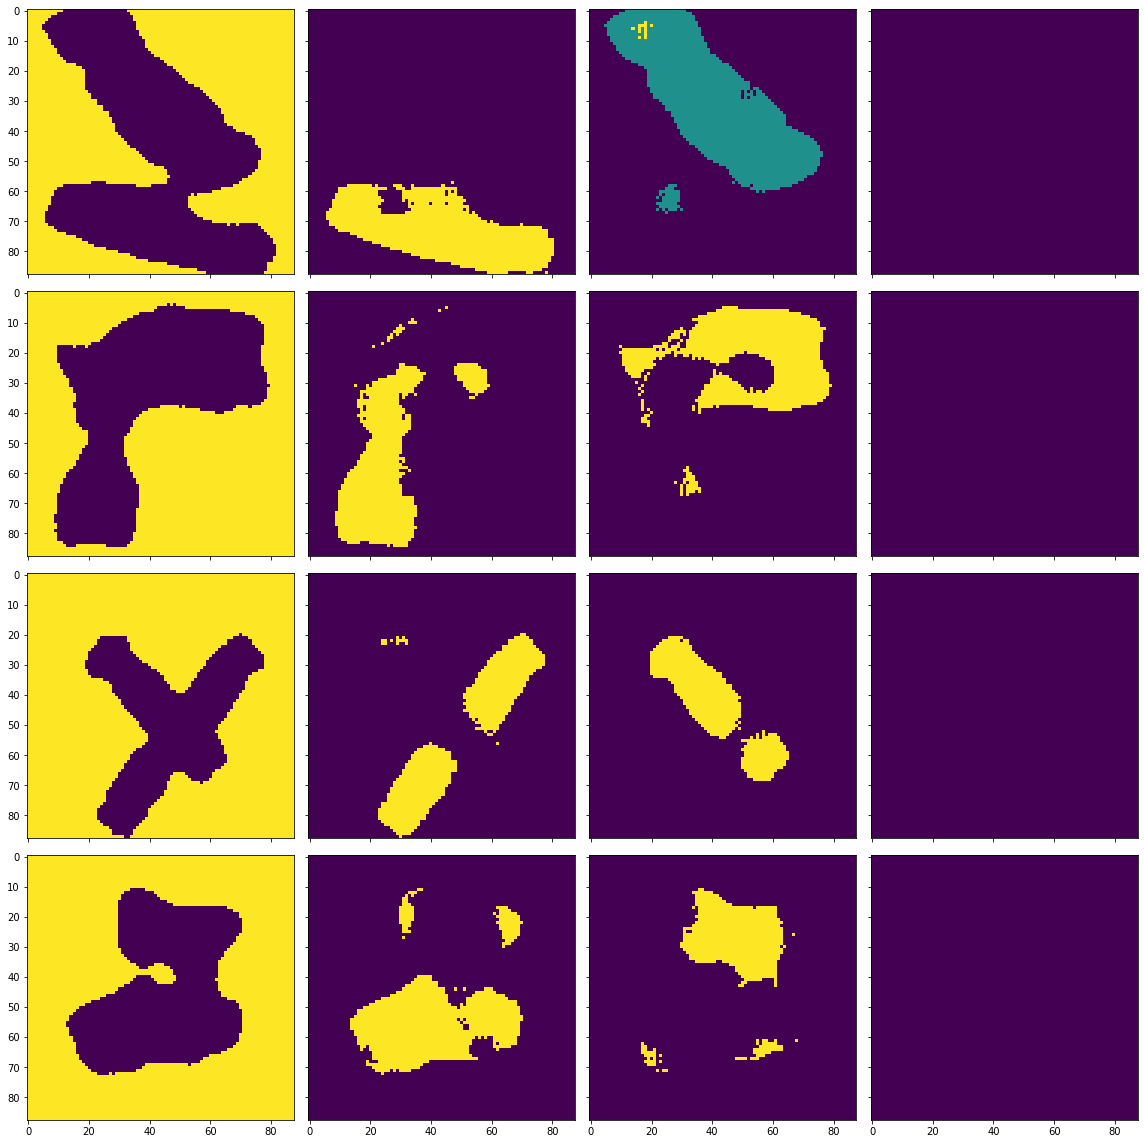

Training IOU: [0.974084670192574, 0.7044262545121766, 0.6798040761523666, 4.3636204959254694e-05]
Training accuracy: 0.9126869189049587
Testing IOU: [0.9726062785278536, 0.3924229197946856, 0.3437623162043353, 0.0]
Testing accuracy: 0.8506714876033058
13/13 [==============================] - 1s 67ms/step - loss: 0.0287 - val_loss: 0.0491
INFO:tensorflow:Assets written to: modelunet/savedmodel_50epoch\assets
4
4


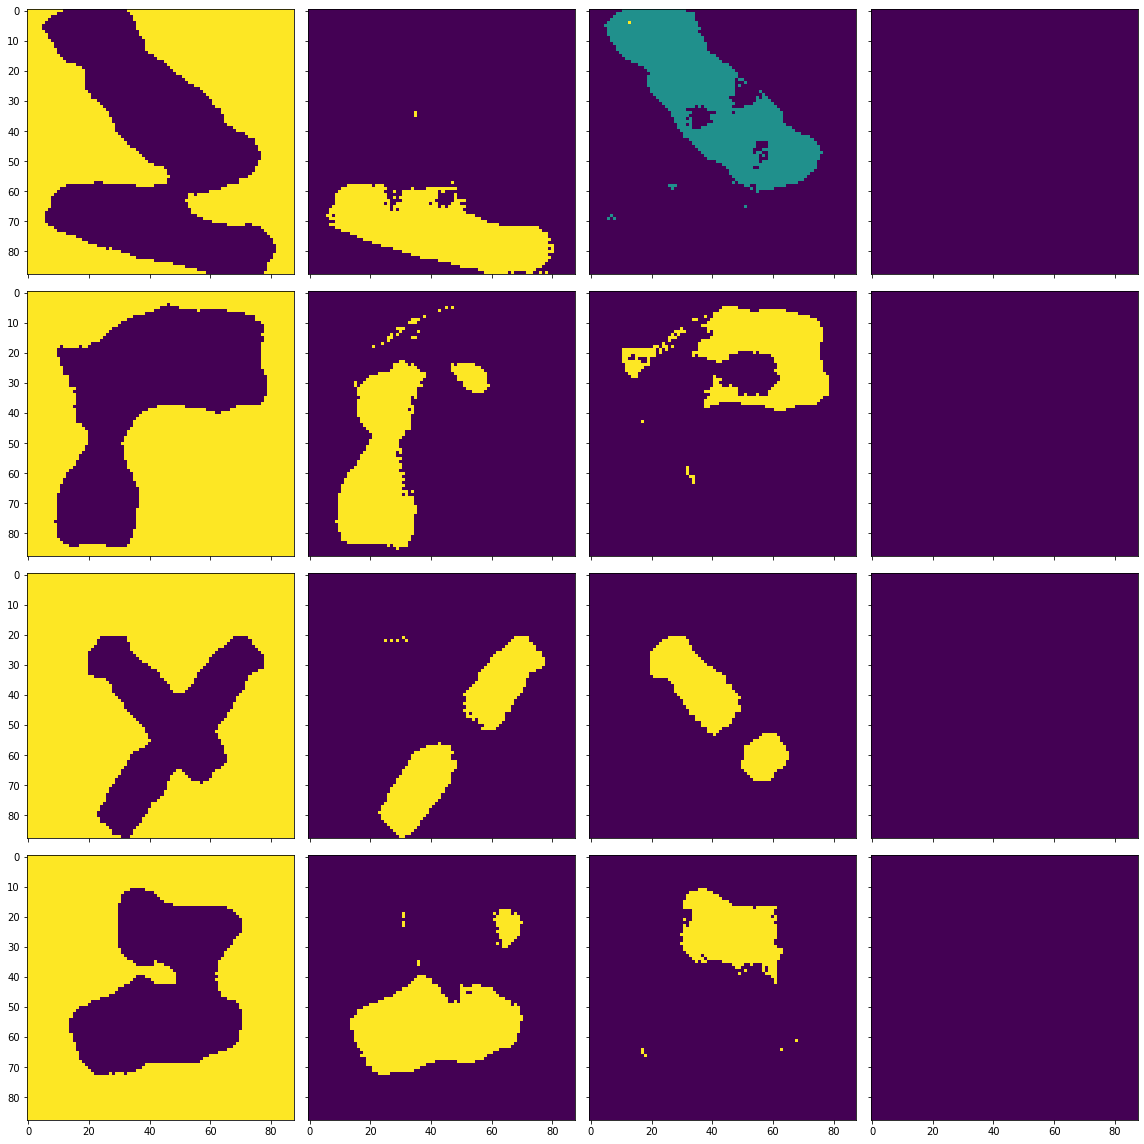

Training IOU: [0.9763638402861219, 0.7205178122291219, 0.7107998573576468, 0.0]
Training accuracy: 0.9152133910123967
Testing IOU: [0.974312941643095, 0.3982861634126493, 0.33278170354311815, 0.0]
Testing accuracy: 0.8491167355371901
13/13 [==============================] - 1s 67ms/step - loss: 0.0268 - val_loss: 0.0478
INFO:tensorflow:Assets written to: modelunet/savedmodel_51epoch\assets
4
4


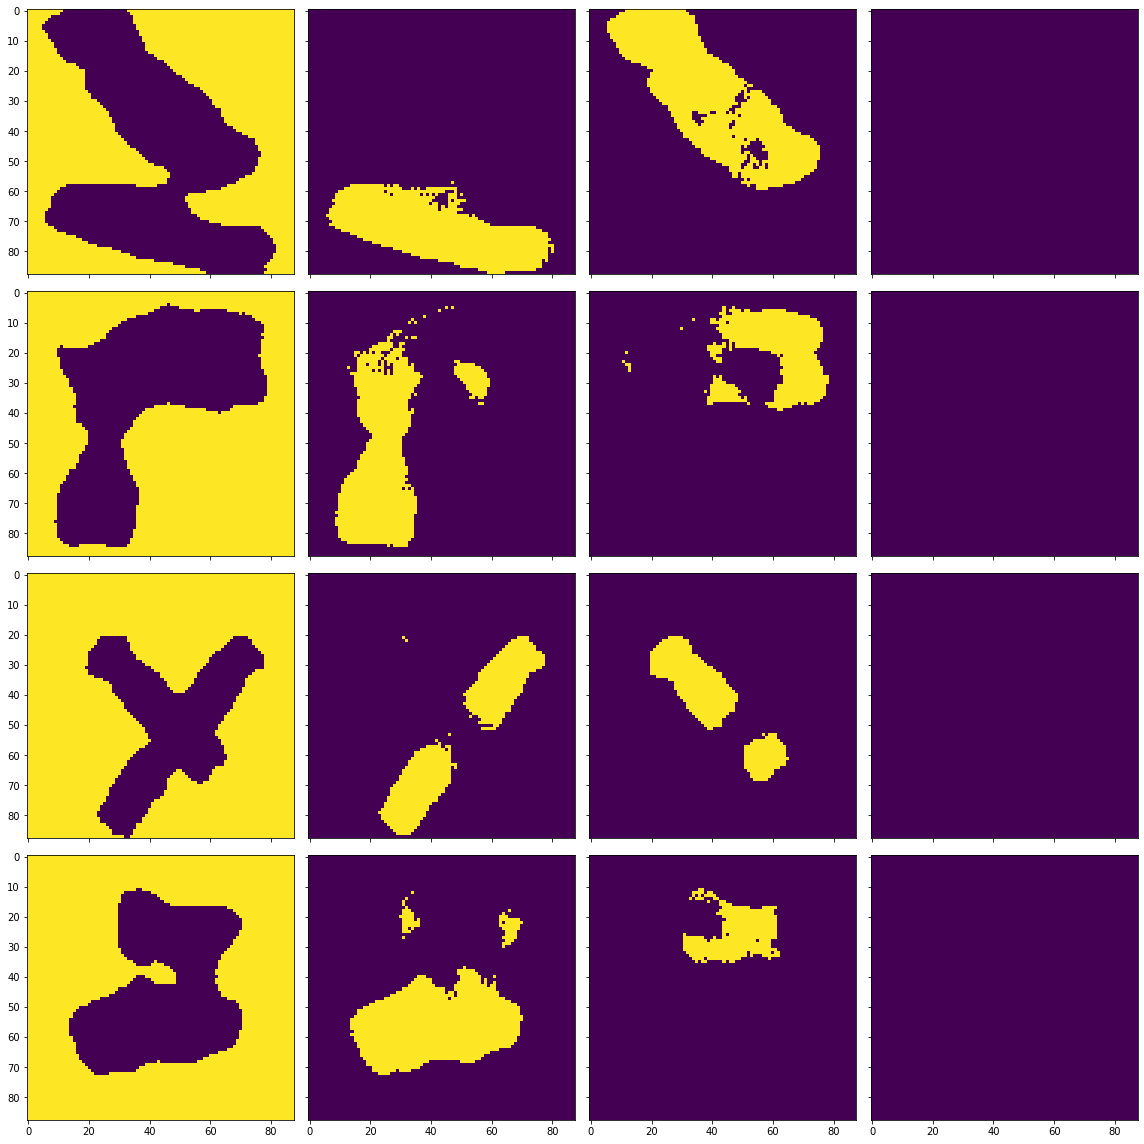

Training IOU: [0.976903846771517, 0.7416165507445647, 0.6797825778213884, 0.0]
Training accuracy: 0.9079209710743802
Testing IOU: [0.9749247063809389, 0.41075400054244643, 0.2715467242566274, 0.0]
Testing accuracy: 0.8402388946280992
13/13 [==============================] - 1s 67ms/step - loss: 0.0266 - val_loss: 0.0502
INFO:tensorflow:Assets written to: modelunet/savedmodel_52epoch\assets
4
4


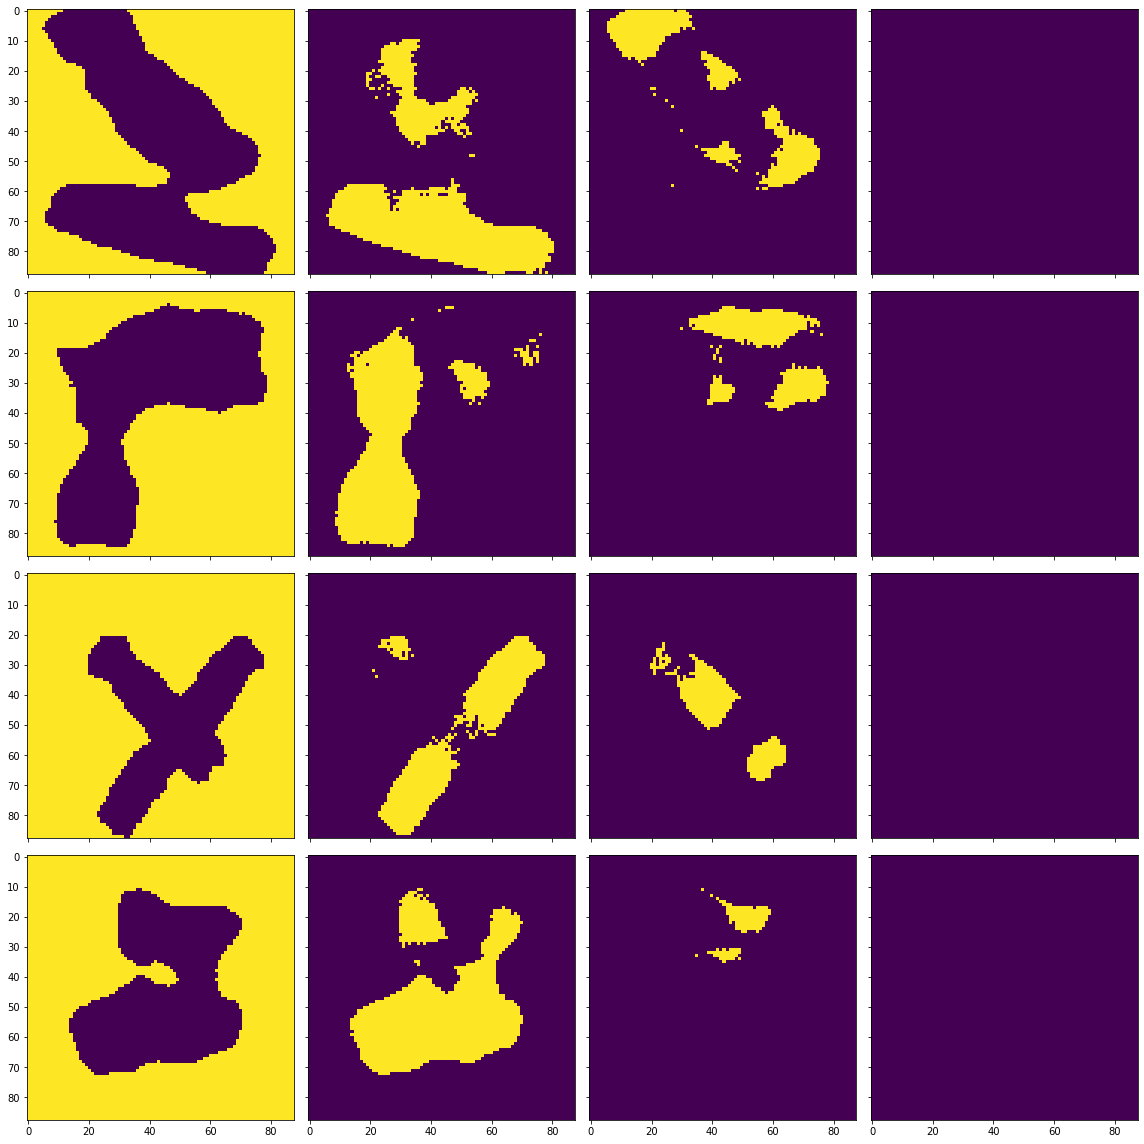

Training IOU: [0.9768463630968597, 0.6551412792126687, 0.42732134966697477, 0.0]
Training accuracy: 0.884661673553719
Testing IOU: [0.9745489388737099, 0.46820480367852396, 0.15683373404845571, 0.0]
Testing accuracy: 0.847733729338843
13/13 [==============================] - 1s 66ms/step - loss: 0.0284 - val_loss: 0.0488 ETA: 0s - loss: 0.028
INFO:tensorflow:Assets written to: modelunet/savedmodel_53epoch\assets
4
4


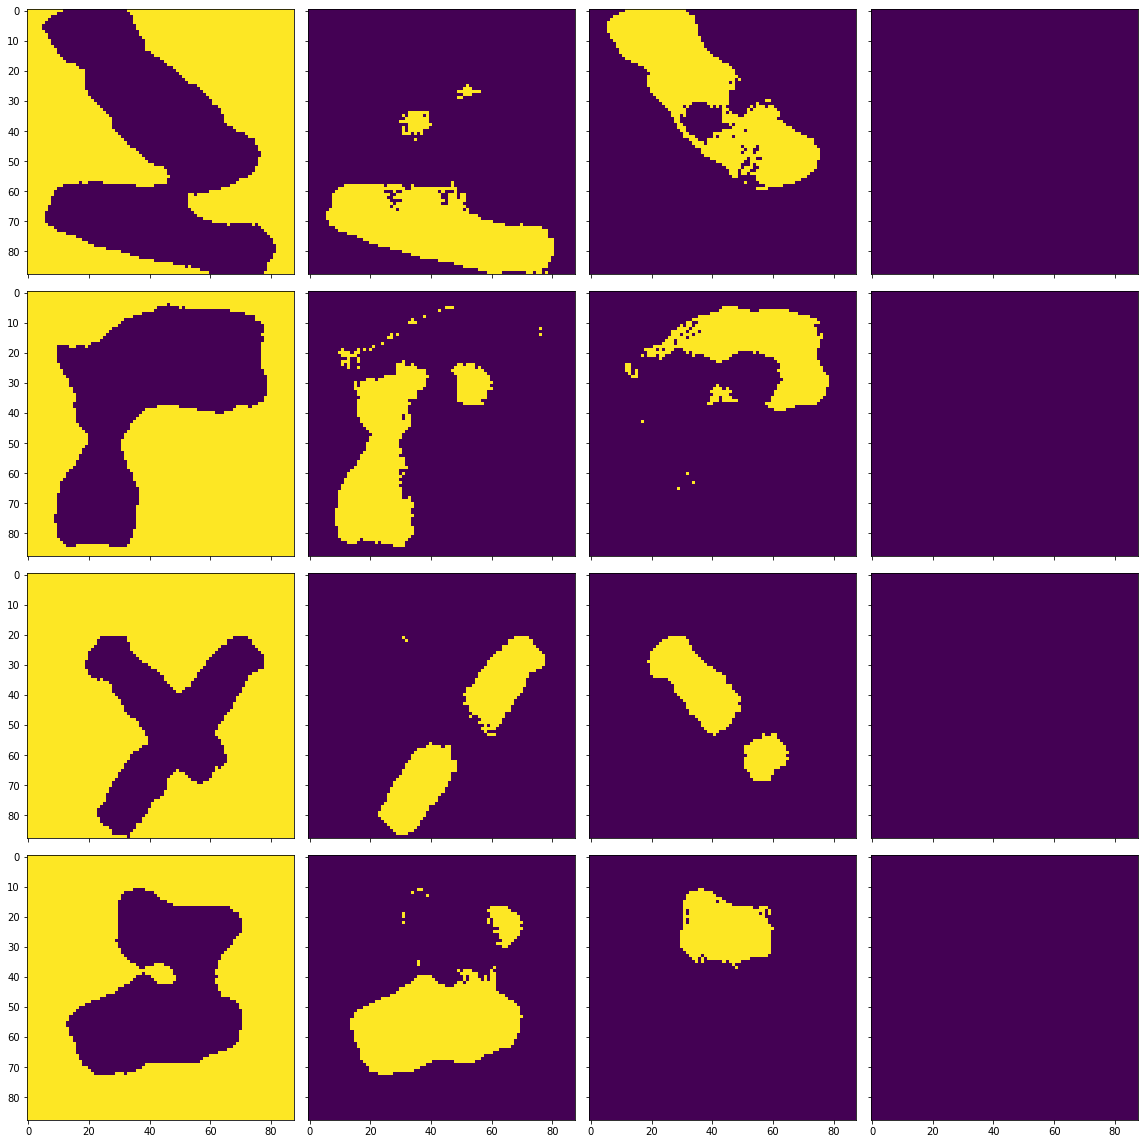

Training IOU: [0.9752959878201684, 0.7538581160230691, 0.7083669337221408, 0.0]
Training accuracy: 0.913983729338843
Testing IOU: [0.9737506908401139, 0.40570901765288353, 0.2965512517551971, 0.0]
Testing accuracy: 0.8426743285123967
13/13 [==============================] - 1s 67ms/step - loss: 0.0257 - val_loss: 0.0489
INFO:tensorflow:Assets written to: modelunet/savedmodel_54epoch\assets
4
4


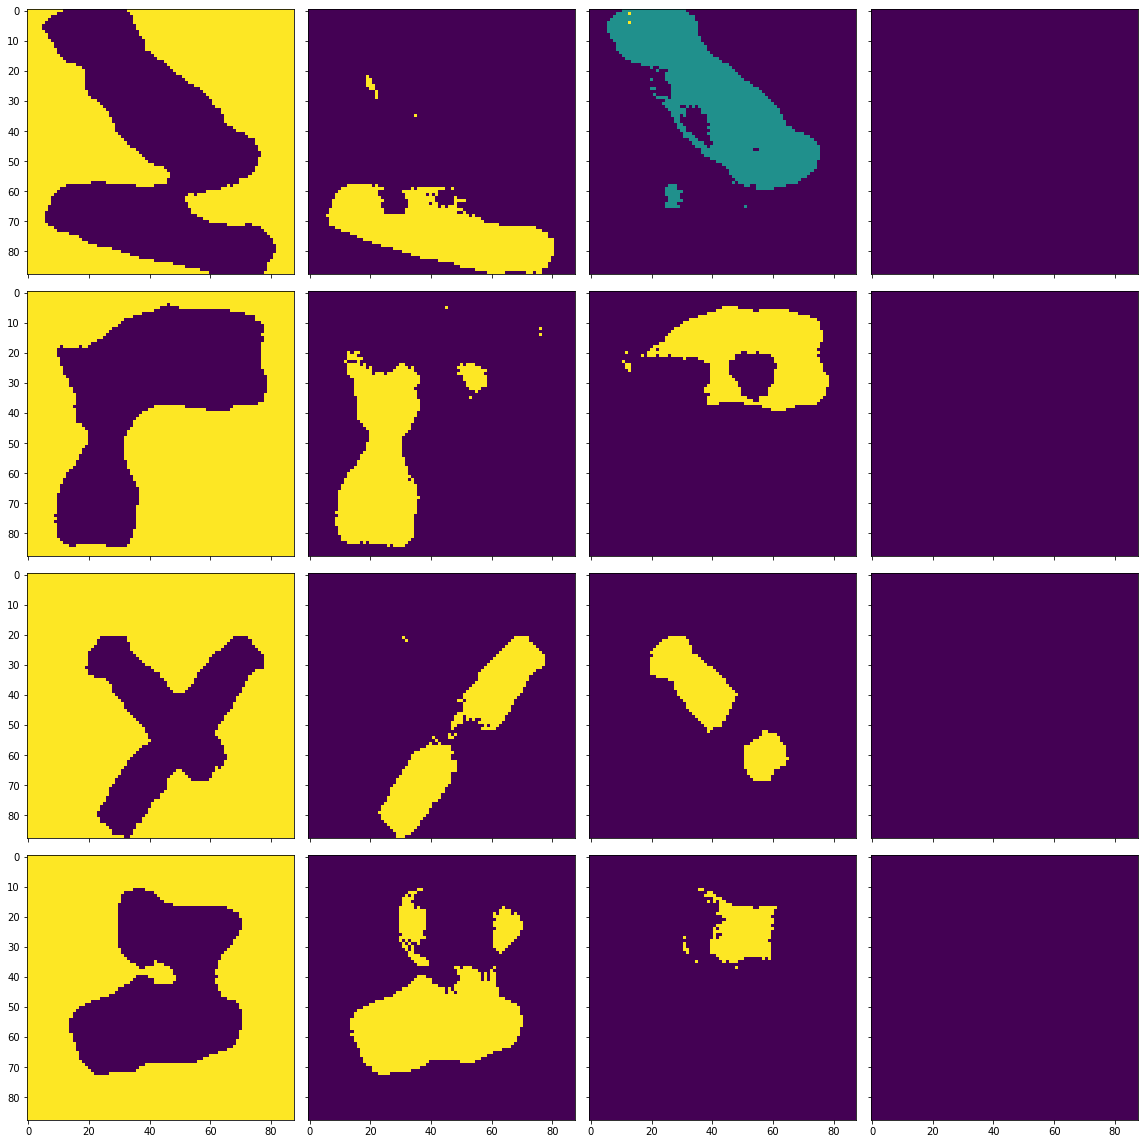

Training IOU: [0.976737288722313, 0.7552288295443265, 0.7229379146702242, 3.272786777941417e-05]
Training accuracy: 0.9204122546487603
Testing IOU: [0.9746332268559494, 0.42832234937446734, 0.28181555206016884, 0.0]
Testing accuracy: 0.8490534607438016
13/13 [==============================] - 1s 67ms/step - loss: 0.0246 - val_loss: 0.0542
INFO:tensorflow:Assets written to: modelunet/savedmodel_55epoch\assets
4
4


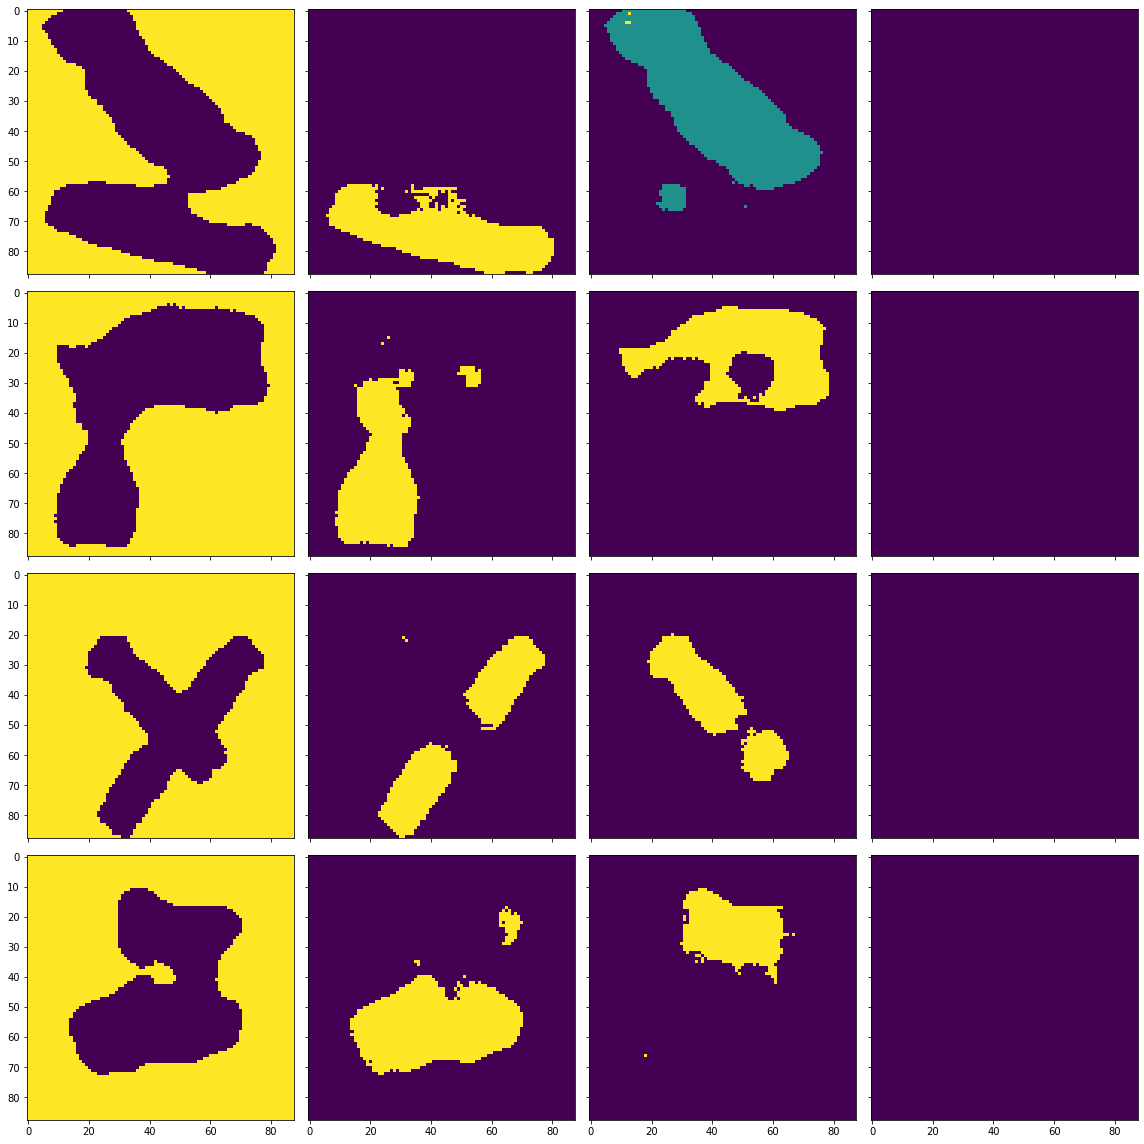

Training IOU: [0.9761763423062728, 0.7697704809329742, 0.7485037553486845, 1.090857523098908e-05]
Training accuracy: 0.9244295583677686
Testing IOU: [0.9743774571767844, 0.37515238360031655, 0.32890850966661594, 0.0]
Testing accuracy: 0.84640625
13/13 [==============================] - 1s 66ms/step - loss: 0.0239 - val_loss: 0.0499
INFO:tensorflow:Assets written to: modelunet/savedmodel_56epoch\assets
4
4


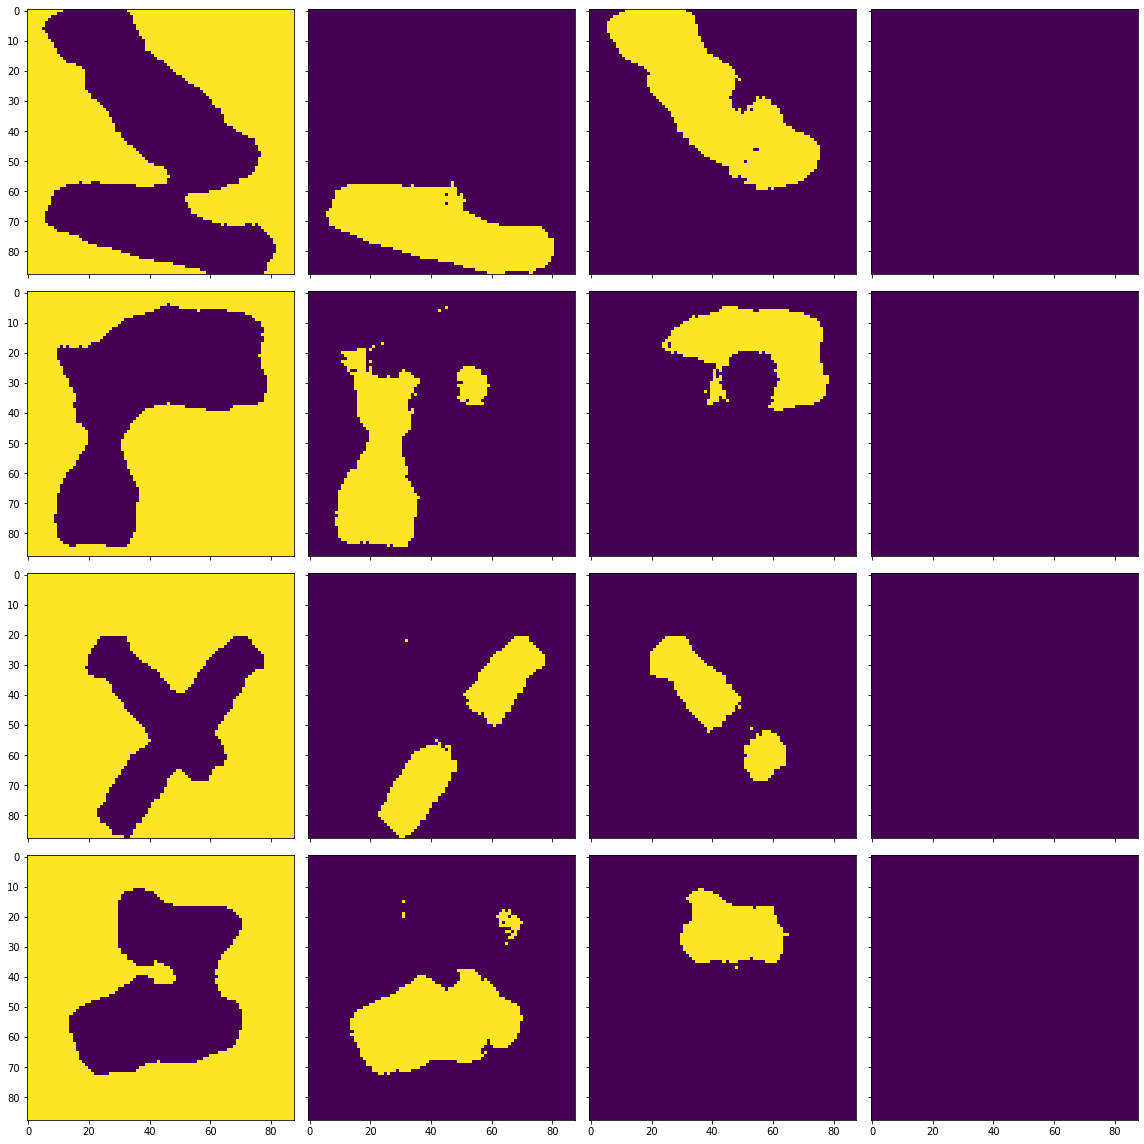

Training IOU: [0.9769552632883499, 0.8011940004580783, 0.763761532529355, 4.363049335180358e-05]
Training accuracy: 0.923270596590909
Testing IOU: [0.9748246399360273, 0.39524817171097526, 0.2809621513074606, 0.0]
Testing accuracy: 0.8397288223140496
13/13 [==============================] - ETA: 0s - loss: 0.023 - 1s 67ms/step - loss: 0.0236 - val_loss: 0.0525
INFO:tensorflow:Assets written to: modelunet/savedmodel_57epoch\assets
4
4


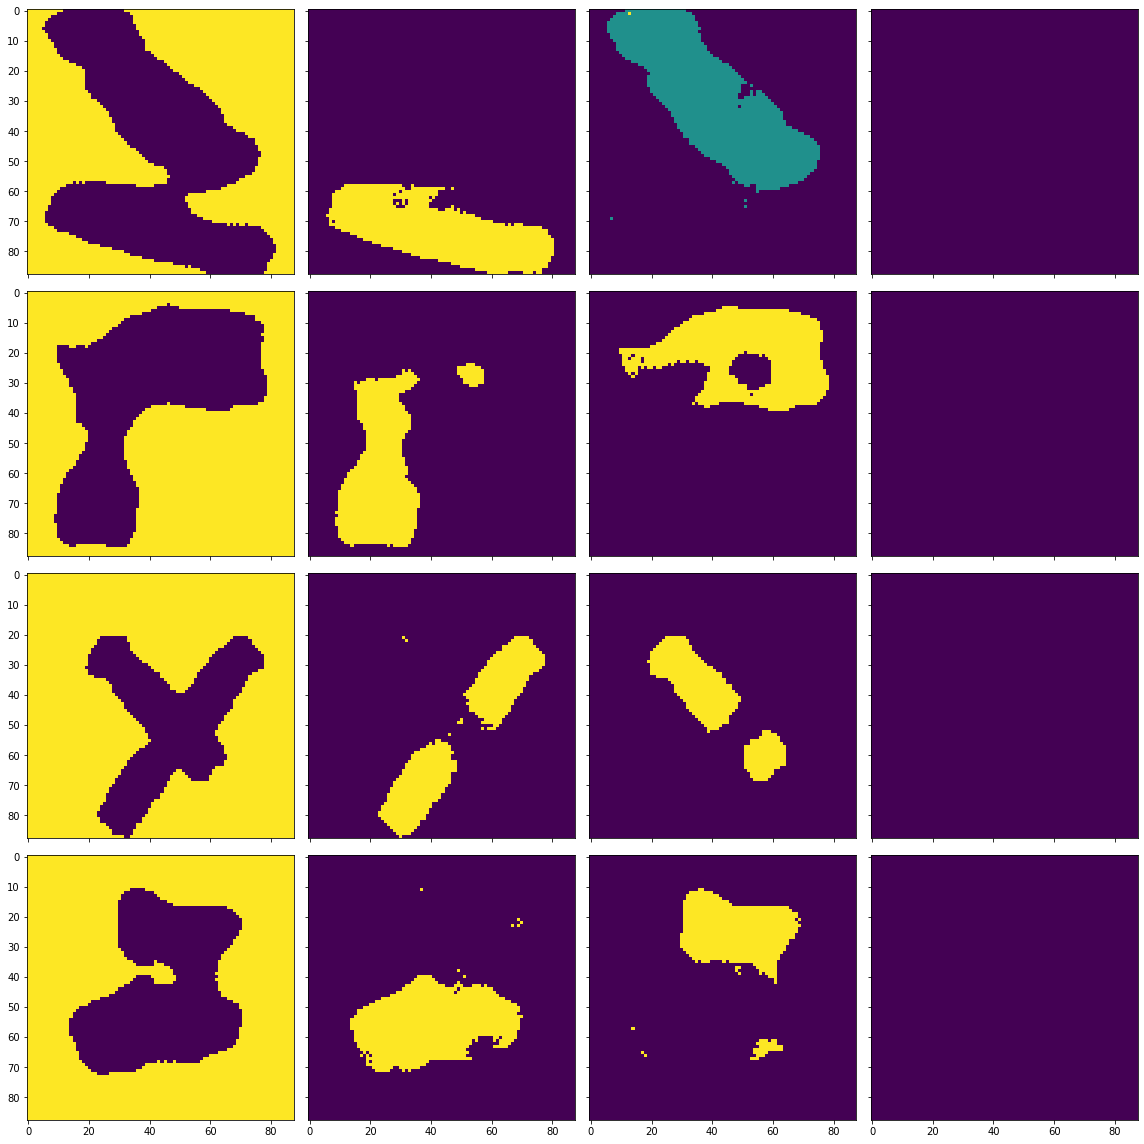

Training IOU: [0.9766704489671101, 0.7988477973344186, 0.7883165707420111, 0.00013091289928434283]
Training accuracy: 0.9319763688016529
Testing IOU: [0.974590236678668, 0.38102928052356466, 0.3366536308565294, 5.576933801795773e-05]
Testing accuracy: 0.8493788739669421
13/13 [==============================] - 1s 67ms/step - loss: 0.0254 - val_loss: 0.0499- ETA: 0s - loss: 0. - ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_58epoch\assets
4
4


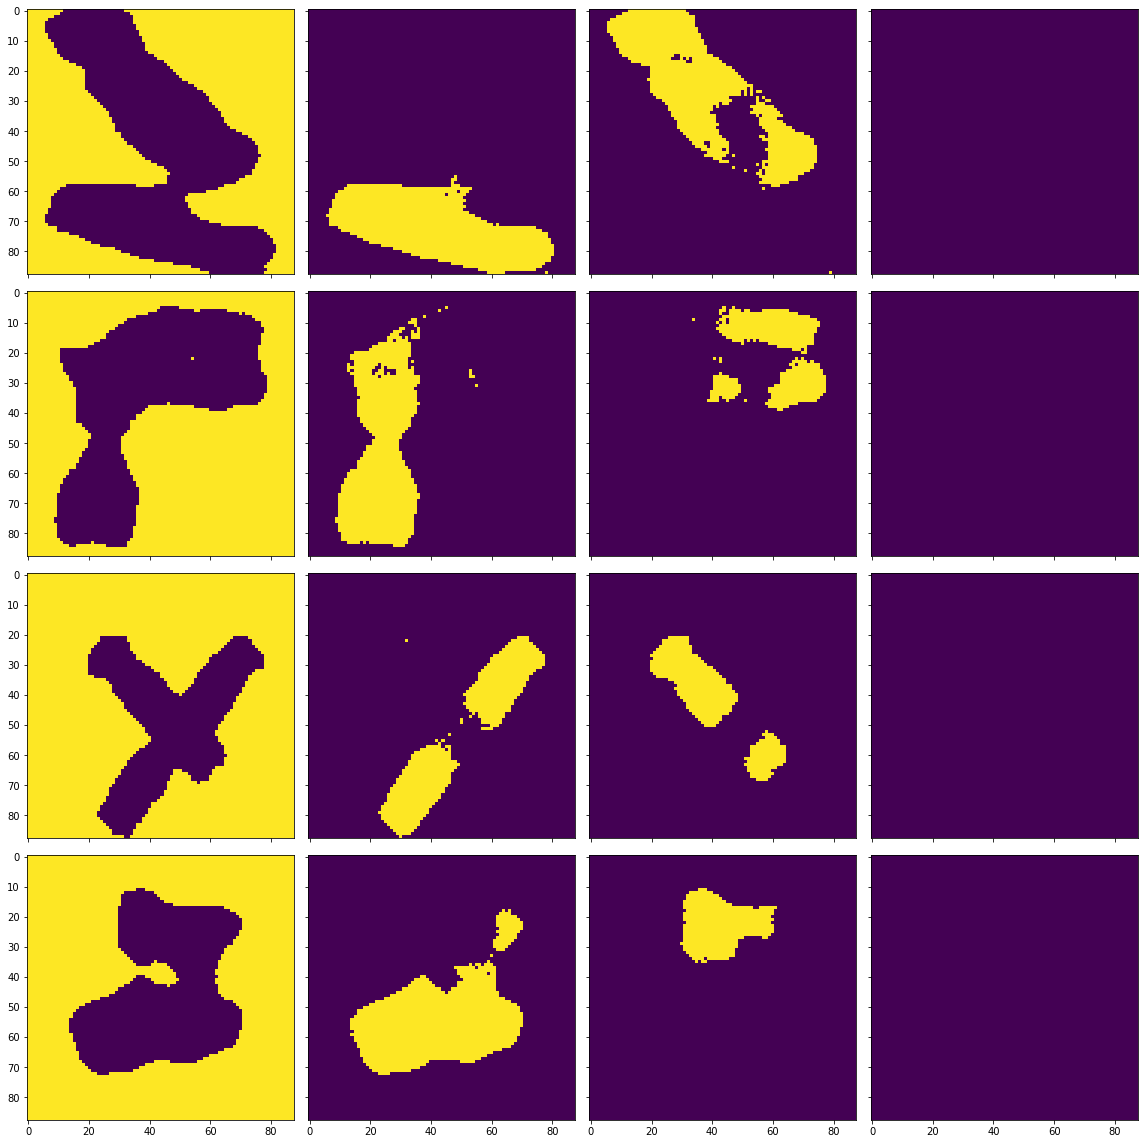

Training IOU: [0.9757477222655074, 0.7412980601162797, 0.6103108883367232, 0.0]
Training accuracy: 0.9046968620867769
Testing IOU: [0.9738162620623999, 0.42760519122192986, 0.22474924304439162, 0.0]
Testing accuracy: 0.8423773243801653
13/13 [==============================] - 1s 67ms/step - loss: 0.0254 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelunet/savedmodel_59epoch\assets
4
4


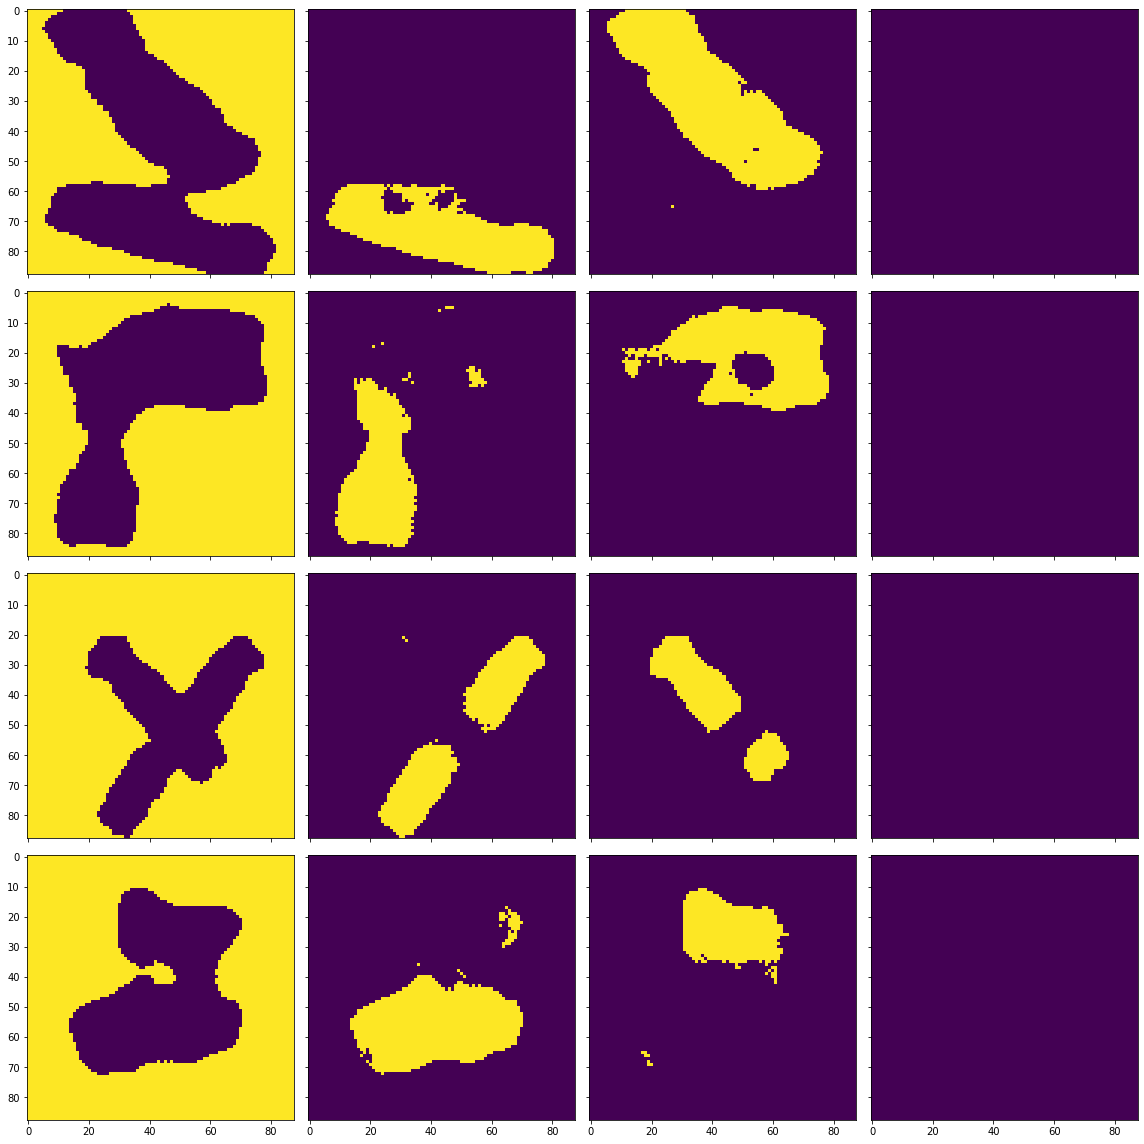

Training IOU: [0.9768279115900653, 0.7656258783138105, 0.7583447263996799, 0.0002507413221698936]
Training accuracy: 0.9229354984504132
Testing IOU: [0.9749532710280374, 0.36701375031745453, 0.3356755795706655, 5.577867023650156e-05]
Testing accuracy: 0.8454610020661157
13/13 [==============================] - 1s 66ms/step - loss: 0.0225 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelunet/savedmodel_60epoch\assets
4
4


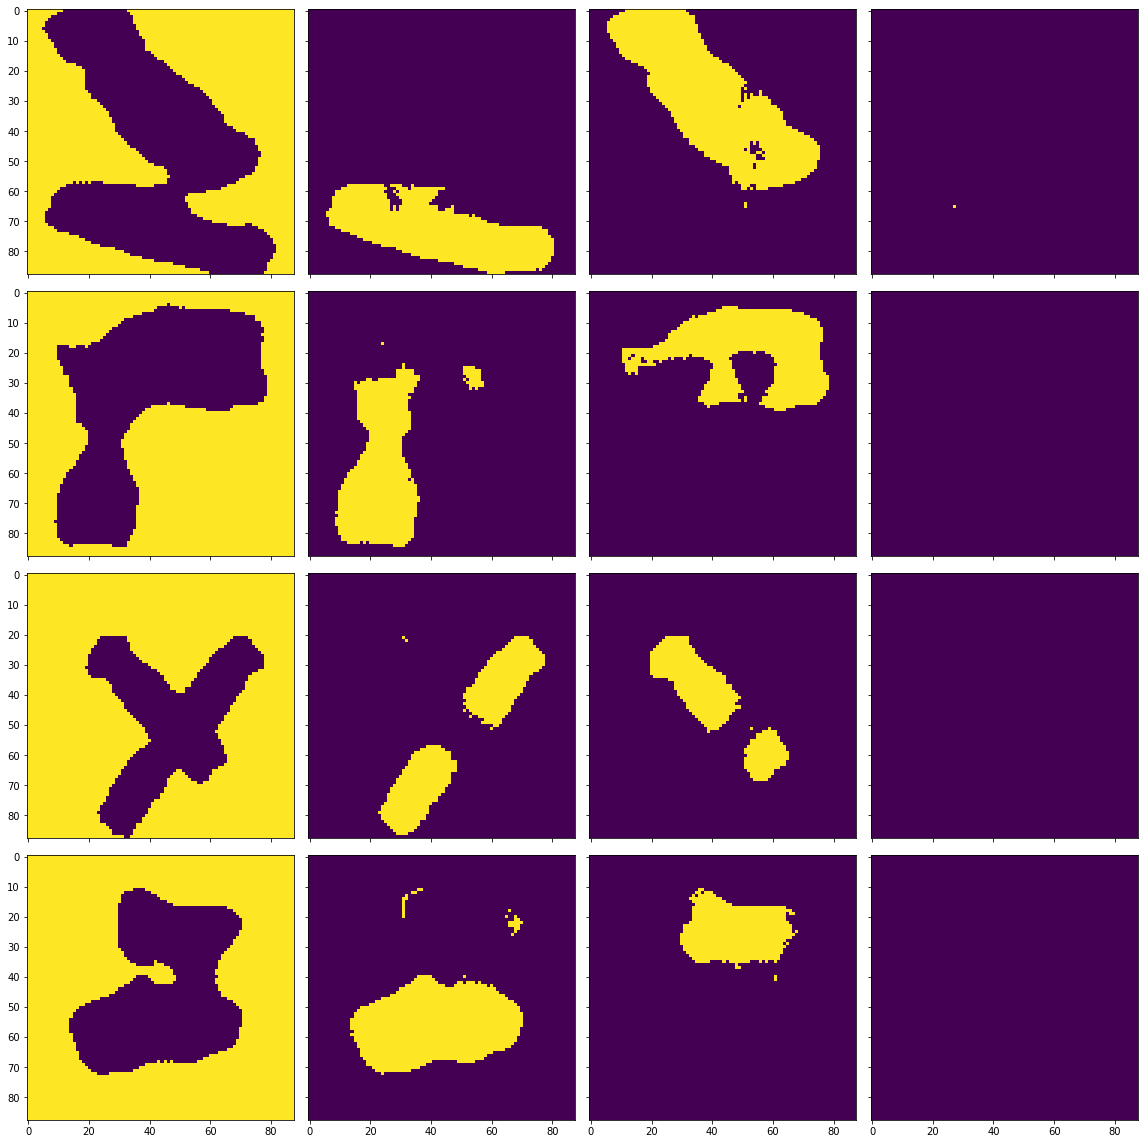

Training IOU: [0.9771800176565388, 0.8255501509163624, 0.8038832657042725, 0.0015140622617258132]
Training accuracy: 0.9336008522727273
Testing IOU: [0.9749201594378668, 0.3918275327603213, 0.3134069477695803, 0.000832870627429206]
Testing accuracy: 0.8460821280991736
13/13 [==============================] - 1s 66ms/step - loss: 0.0205 - val_loss: 0.0544
INFO:tensorflow:Assets written to: modelunet/savedmodel_61epoch\assets
4
4


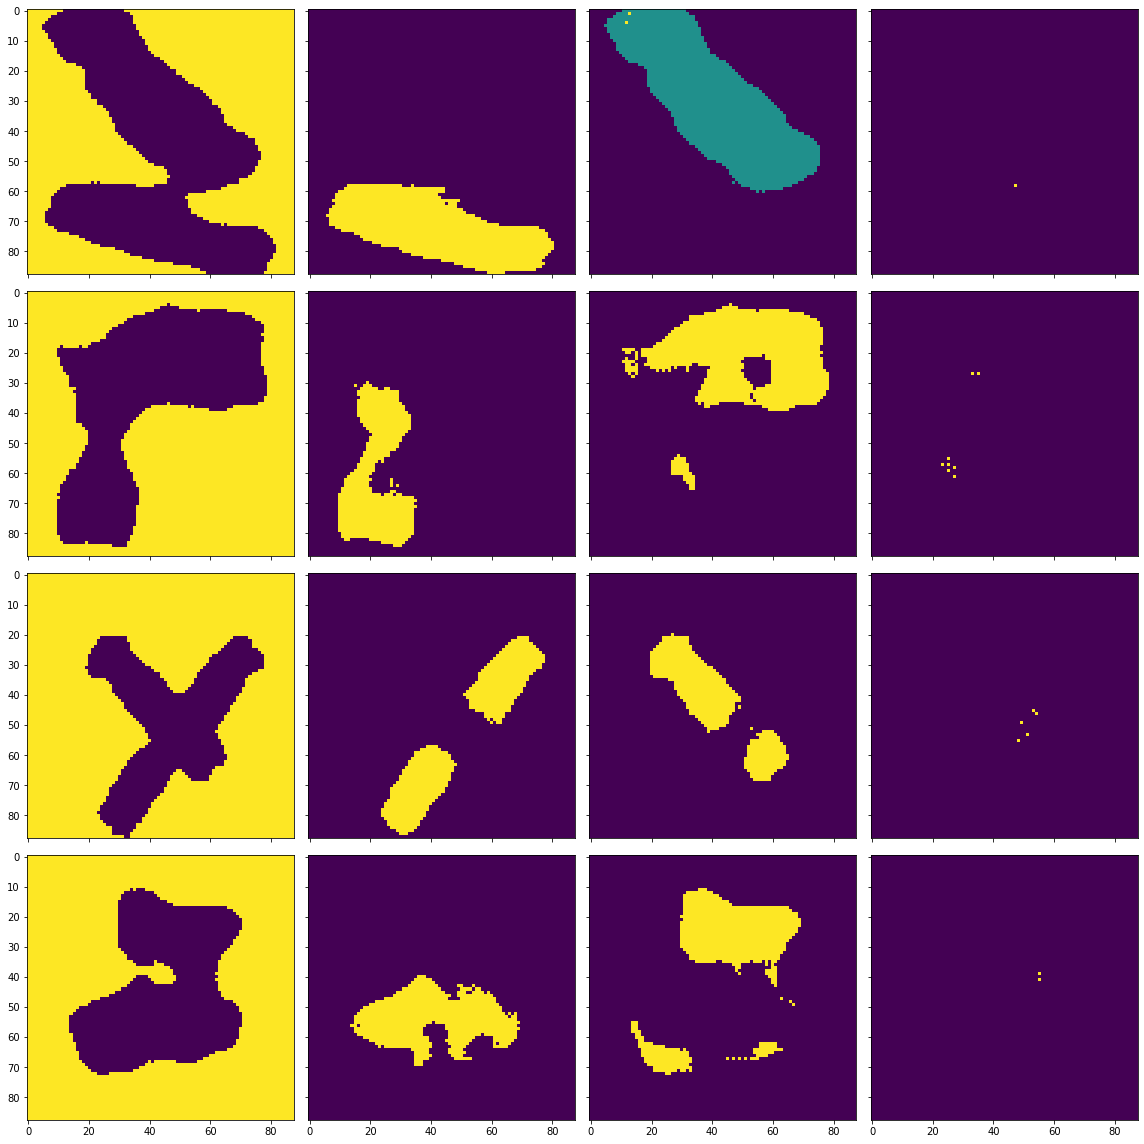

Training IOU: [0.976998679941309, 0.7366623569323478, 0.788324342330505, 0.010852225248787263]
Training accuracy: 0.9219992897727273
Testing IOU: [0.9747255379872092, 0.28900257808547036, 0.3587027903142422, 0.009697439875872769]
Testing accuracy: 0.8380423553719009
13/13 [==============================] - 1s 67ms/step - loss: 0.0203 - val_loss: 0.0525
INFO:tensorflow:Assets written to: modelunet/savedmodel_62epoch\assets
4
4


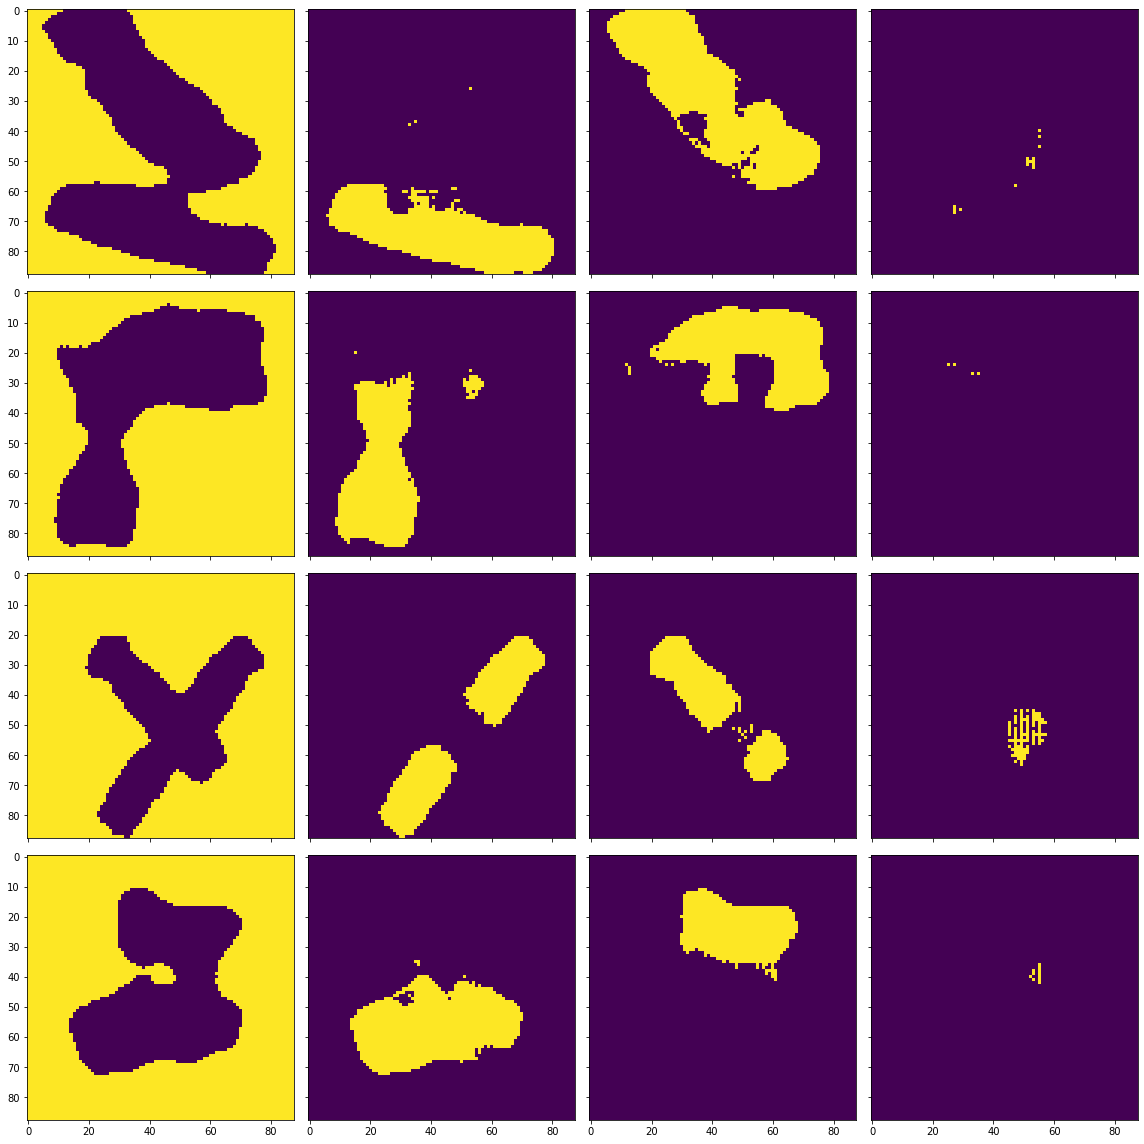

Training IOU: [0.9769488341248239, 0.8271567328132922, 0.8252921448015521, 0.12732084259553297]
Training accuracy: 0.9360253099173553
Testing IOU: [0.9748543034382998, 0.35243091781679436, 0.3266926950360181, 0.10073490813648293]
Testing accuracy: 0.8413003615702479
13/13 [==============================] - 1s 67ms/step - loss: 0.0185 - val_loss: 0.0517
INFO:tensorflow:Assets written to: modelunet/savedmodel_63epoch\assets
4
4


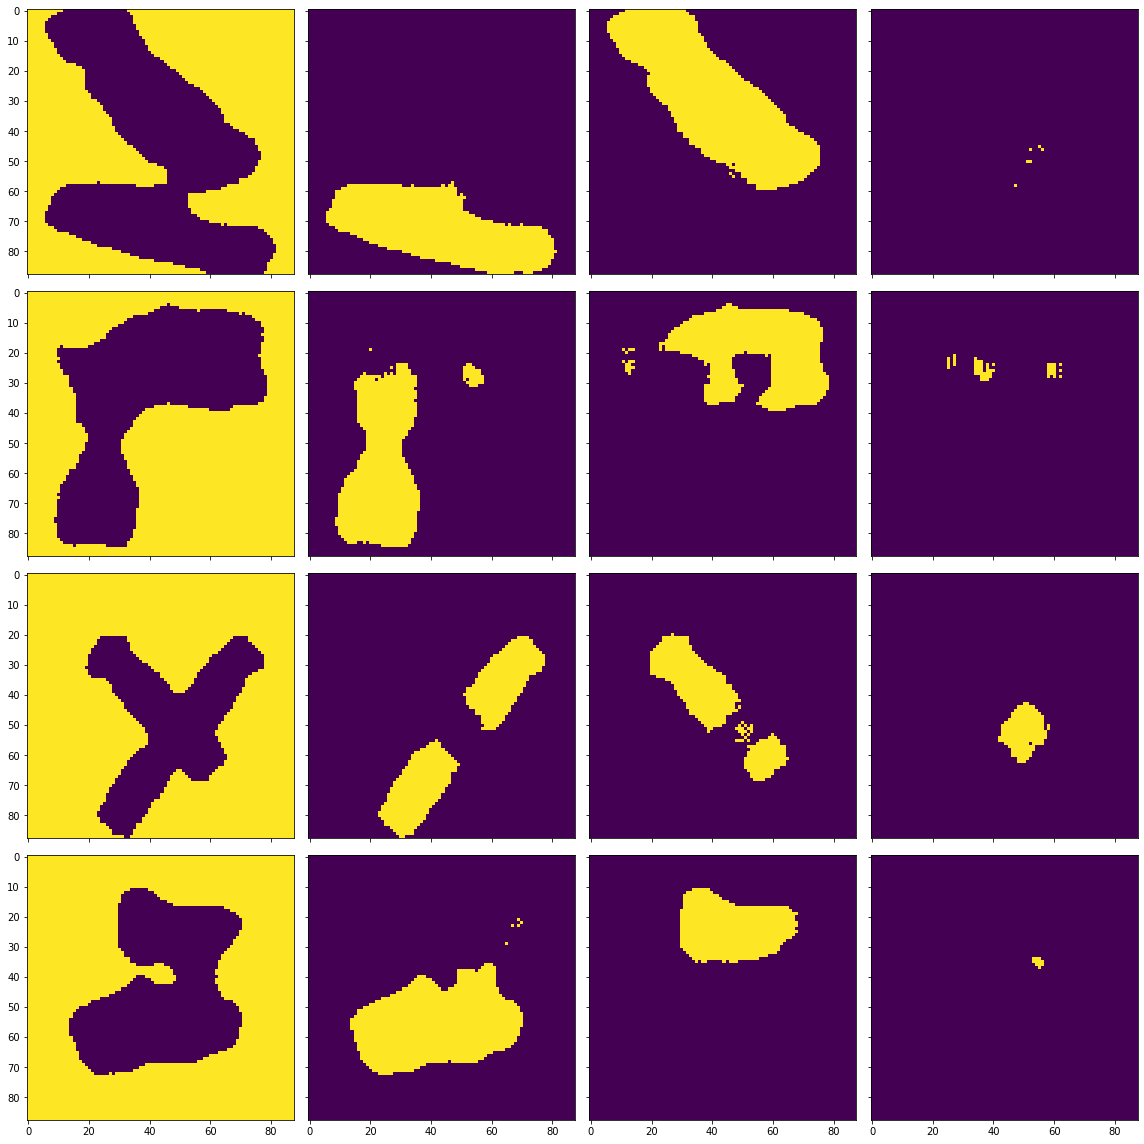

Training IOU: [0.9771262932635971, 0.8478250233462455, 0.8281539130680955, 0.30706745793422163]
Training accuracy: 0.9486654183884298
Testing IOU: [0.974857670998935, 0.41602720027952855, 0.2992575966850829, 0.2196557304693247]
Testing accuracy: 0.8551007231404959
13/13 [==============================] - 1s 67ms/step - loss: 0.0179 - val_loss: 0.0503
INFO:tensorflow:Assets written to: modelunet/savedmodel_64epoch\assets
4
4


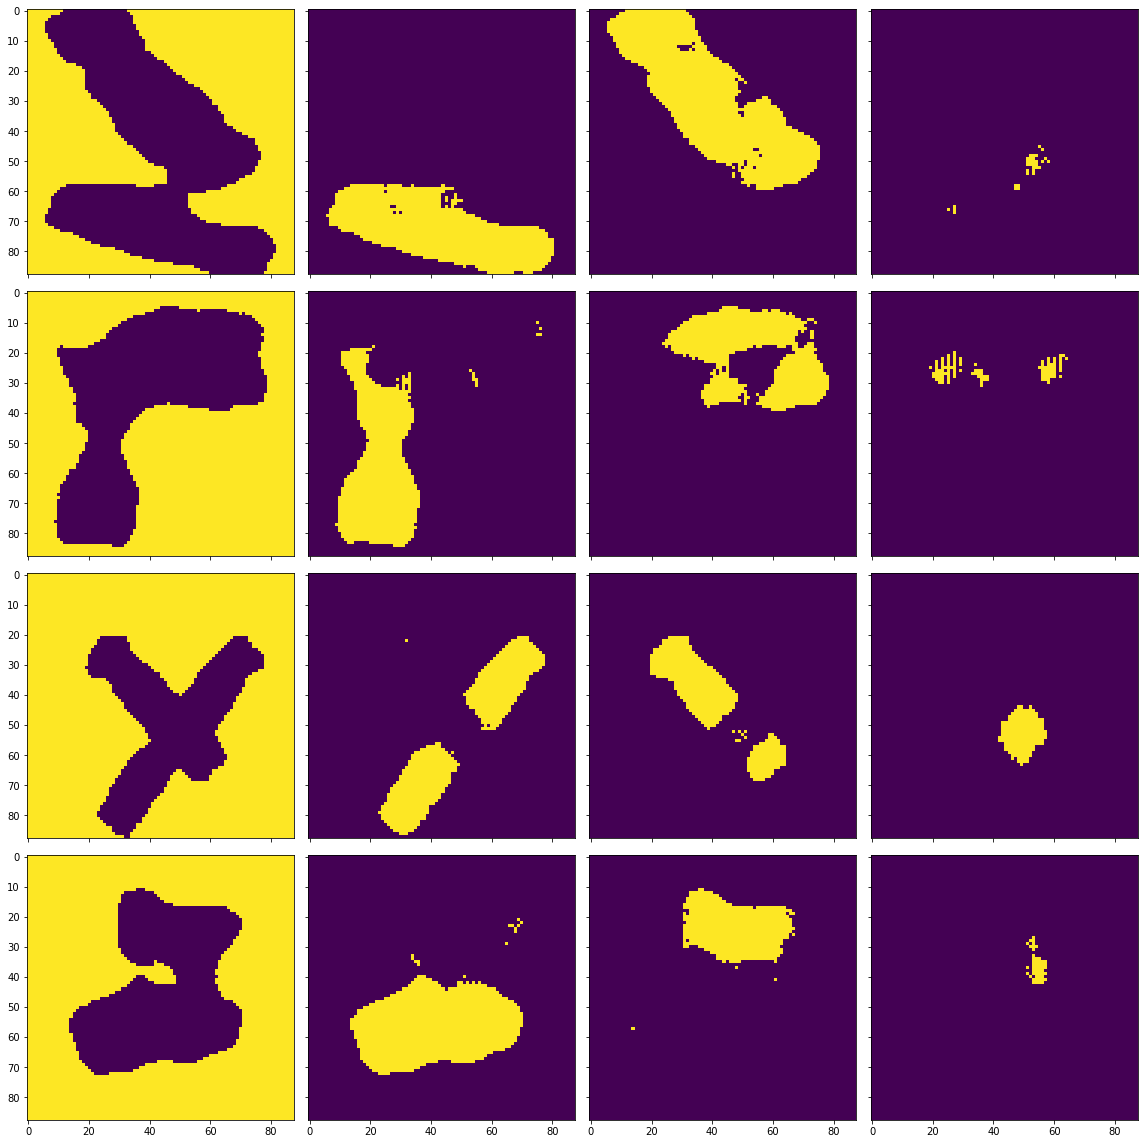

Training IOU: [0.9772881463286042, 0.8540699443360935, 0.8271472089251097, 0.3942231407387093]
Training accuracy: 0.9475213068181818
Testing IOU: [0.9748363076133008, 0.3969858557575508, 0.2703640913861306, 0.28977196959594614]
Testing accuracy: 0.8476084710743802
13/13 [==============================] - 1s 66ms/step - loss: 0.0166 - val_loss: 0.0515
INFO:tensorflow:Assets written to: modelunet/savedmodel_65epoch\assets
4
4


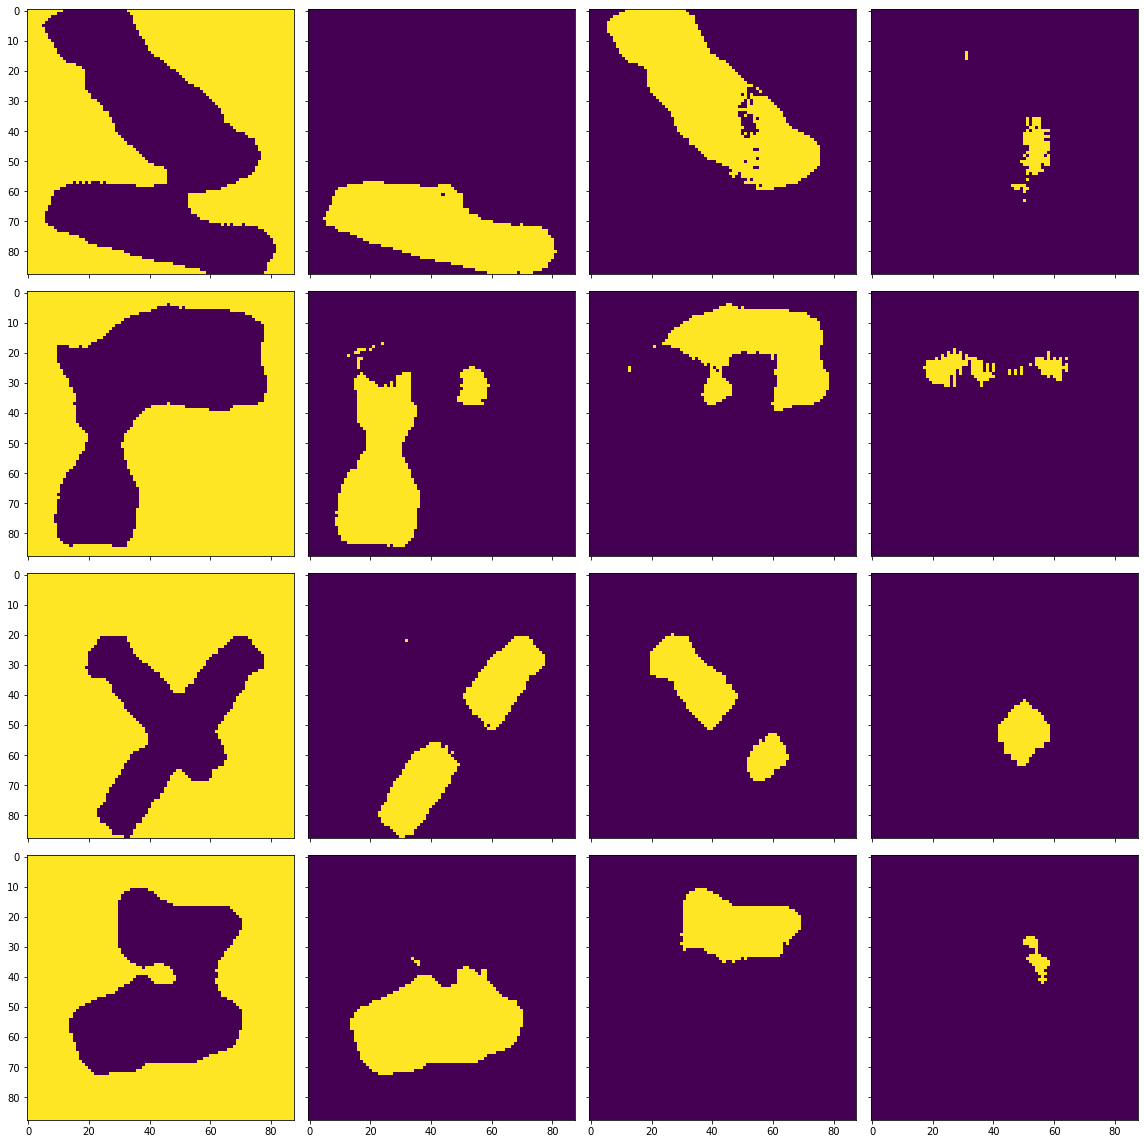

Training IOU: [0.976983540885671, 0.8637924797310238, 0.8401929413759125, 0.5069586401948979]
Training accuracy: 0.956105049070248
Testing IOU: [0.9748526912230586, 0.4236892975627596, 0.27348702117165663, 0.35092183198465005]
Testing accuracy: 0.8569098657024793
13/13 [==============================] - 1s 66ms/step - loss: 0.0154 - val_loss: 0.0539
INFO:tensorflow:Assets written to: modelunet/savedmodel_66epoch\assets
4
4


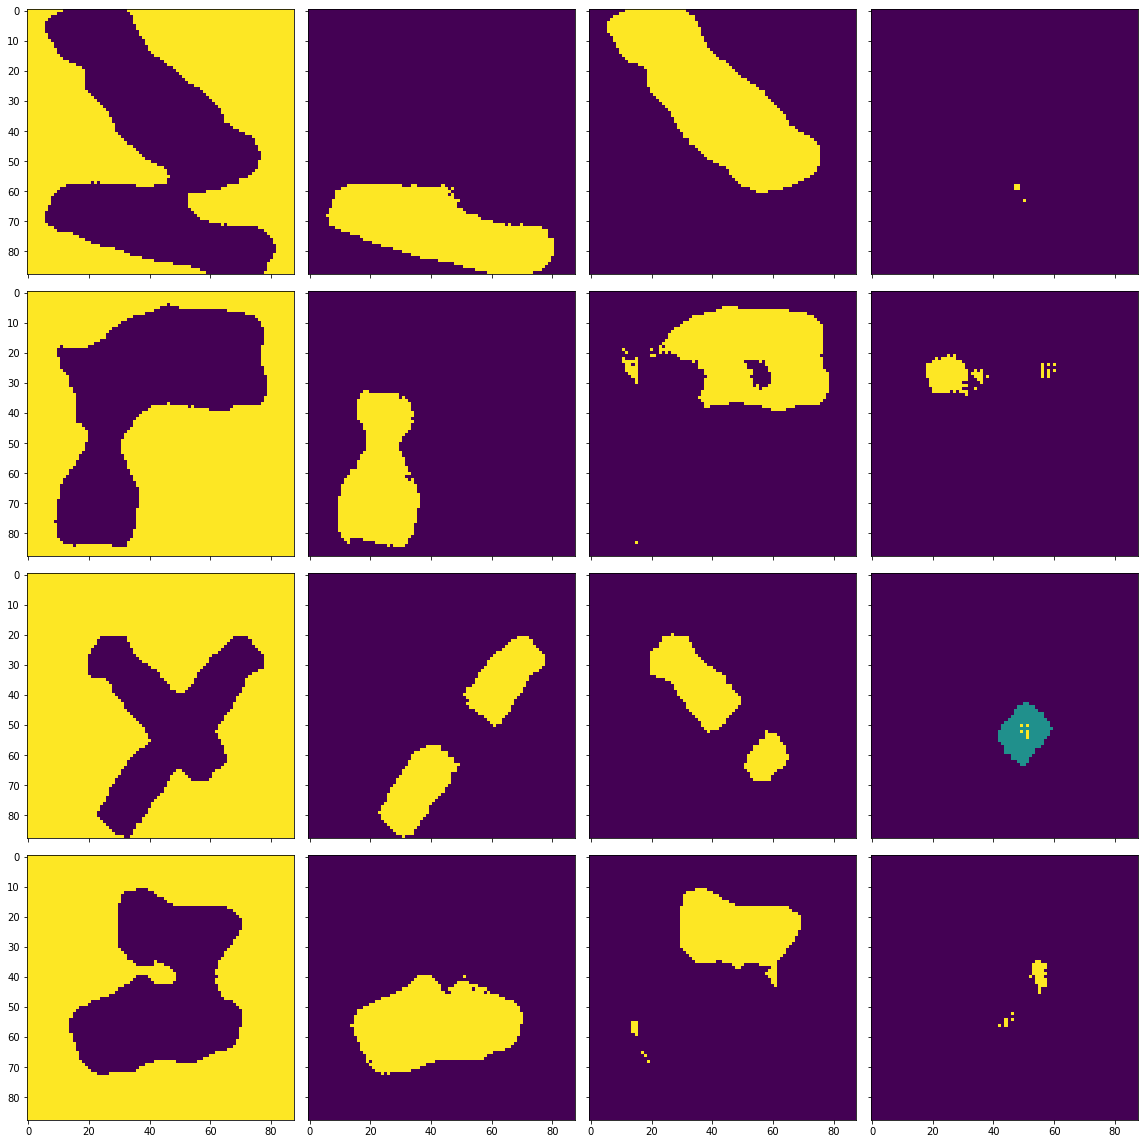

Training IOU: [0.9772723720203205, 0.8439148178445046, 0.8529595138895761, 0.496764097907772]
Training accuracy: 0.954894111570248
Testing IOU: [0.9749314844854476, 0.3245068920874267, 0.34903200959843583, 0.3362428176674416]
Testing accuracy: 0.8506611570247934
13/13 [==============================] - 1s 66ms/step - loss: 0.0147 - val_loss: 0.0496
INFO:tensorflow:Assets written to: modelunet/savedmodel_67epoch\assets
4
4


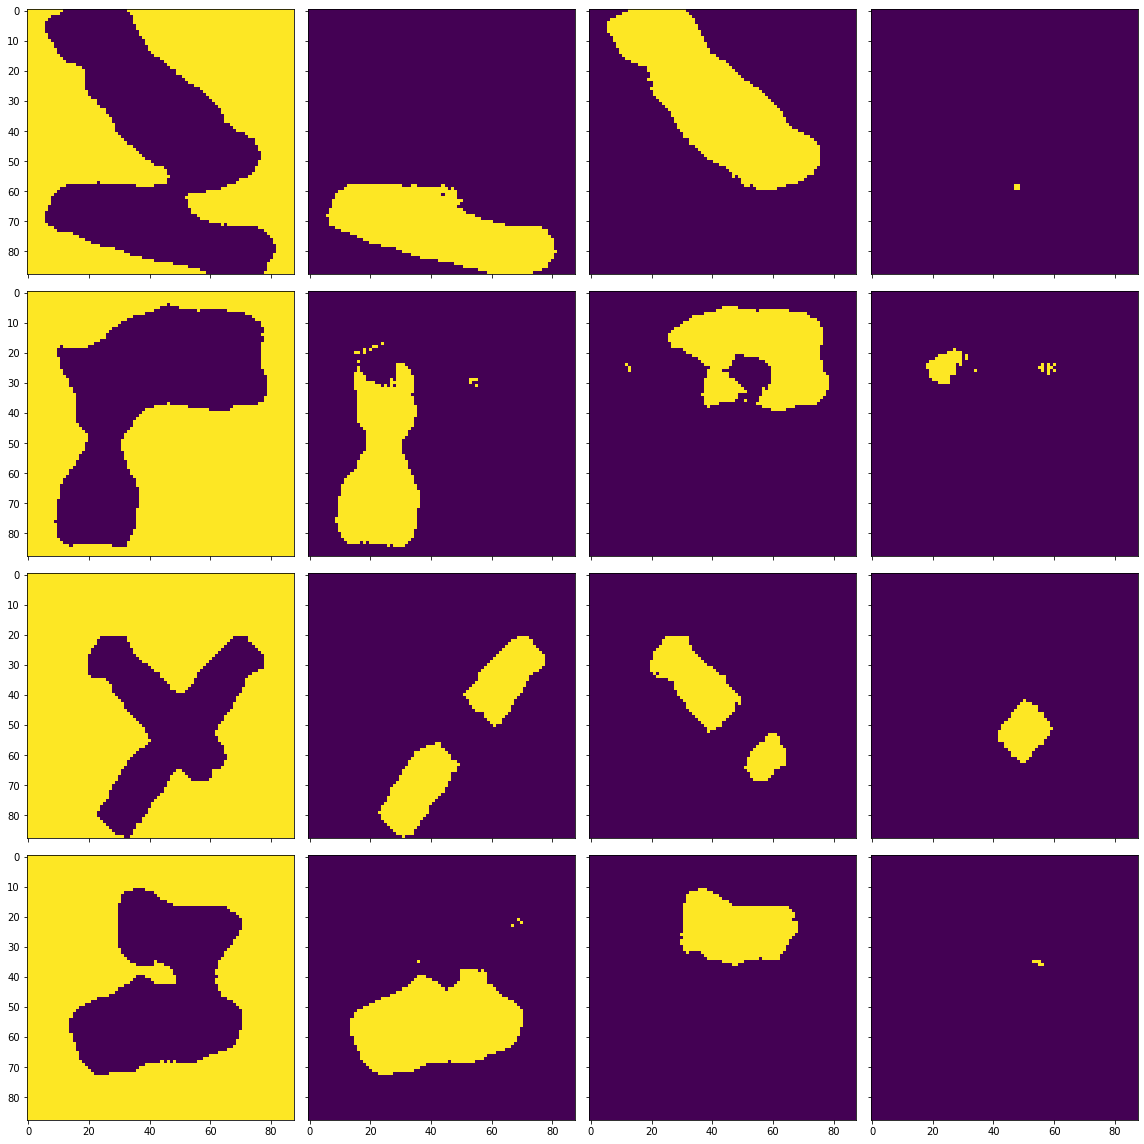

Training IOU: [0.9775996792619454, 0.8750949135159047, 0.8661705063563435, 0.5198003020123887]
Training accuracy: 0.958177298553719
Testing IOU: [0.9750851736987786, 0.42750298620914323, 0.29250945052582544, 0.33712866647924283]
Testing accuracy: 0.8579196797520661
13/13 [==============================] - 1s 67ms/step - loss: 0.0138 - val_loss: 0.0528 ETA: 0s - loss: 
INFO:tensorflow:Assets written to: modelunet/savedmodel_68epoch\assets
4
4


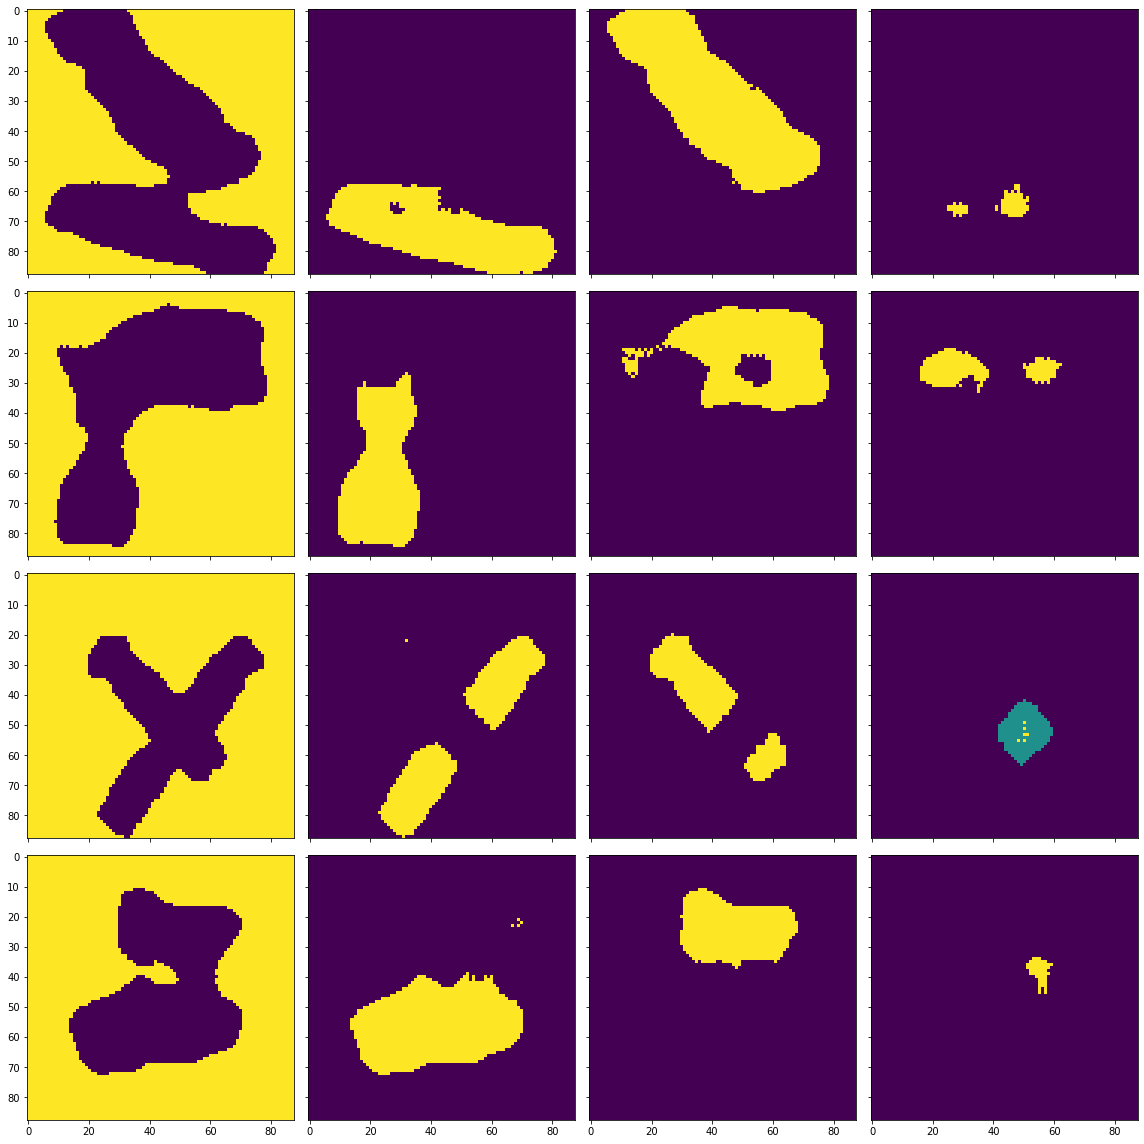

Training IOU: [0.9775806561817985, 0.8785700594211232, 0.8797332372594757, 0.6267949852111984]
Training accuracy: 0.9645790289256199
Testing IOU: [0.9749826352712371, 0.384620917336172, 0.3262623446621216, 0.3584303356656886]
Testing accuracy: 0.8583212809917355
13/13 [==============================] - 1s 66ms/step - loss: 0.0135 - val_loss: 0.0528
INFO:tensorflow:Assets written to: modelunet/savedmodel_69epoch\assets
4
4


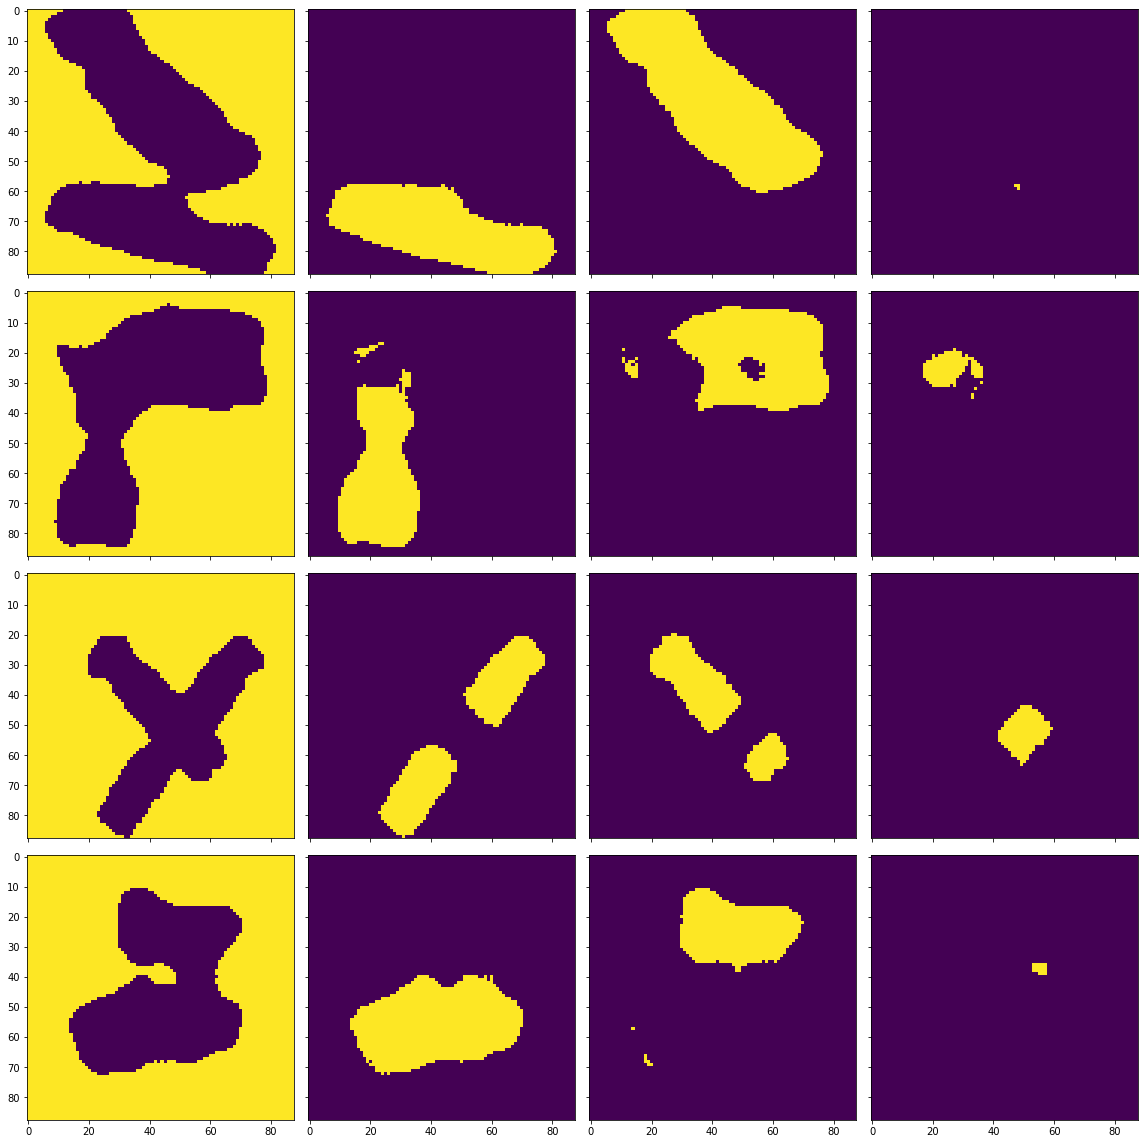

Training IOU: [0.9774835088221098, 0.8886275831087151, 0.8824369554664145, 0.5746619188199369]
Training accuracy: 0.9635901988636364
Testing IOU: [0.9749251210918769, 0.3765344866963572, 0.3218941441801692, 0.3297416535867306]
Testing accuracy: 0.8547804752066116
13/13 [==============================] - 1s 67ms/step - loss: 0.0132 - val_loss: 0.0532
INFO:tensorflow:Assets written to: modelunet/savedmodel_70epoch\assets
4
4


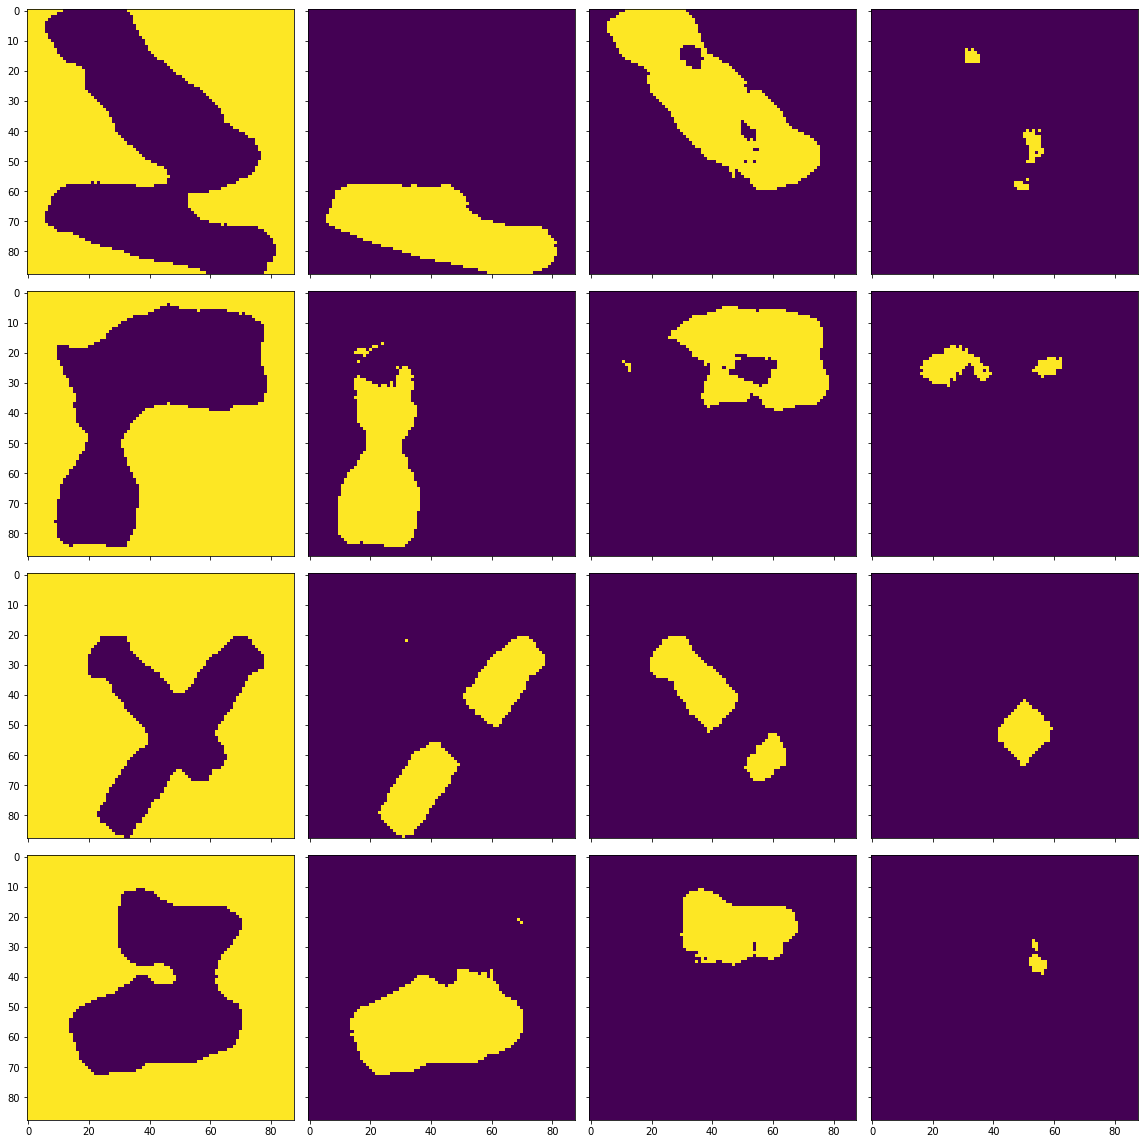

Training IOU: [0.977616486021588, 0.8827725951485411, 0.8544216807075983, 0.6201574139680959]
Training accuracy: 0.9615295712809917
Testing IOU: [0.9750612606663075, 0.4309595927047754, 0.25958027022130686, 0.3546170475602224]
Testing accuracy: 0.8578796487603306
13/13 [==============================] - 1s 66ms/step - loss: 0.0130 - val_loss: 0.0546
INFO:tensorflow:Assets written to: modelunet/savedmodel_71epoch\assets
4
4


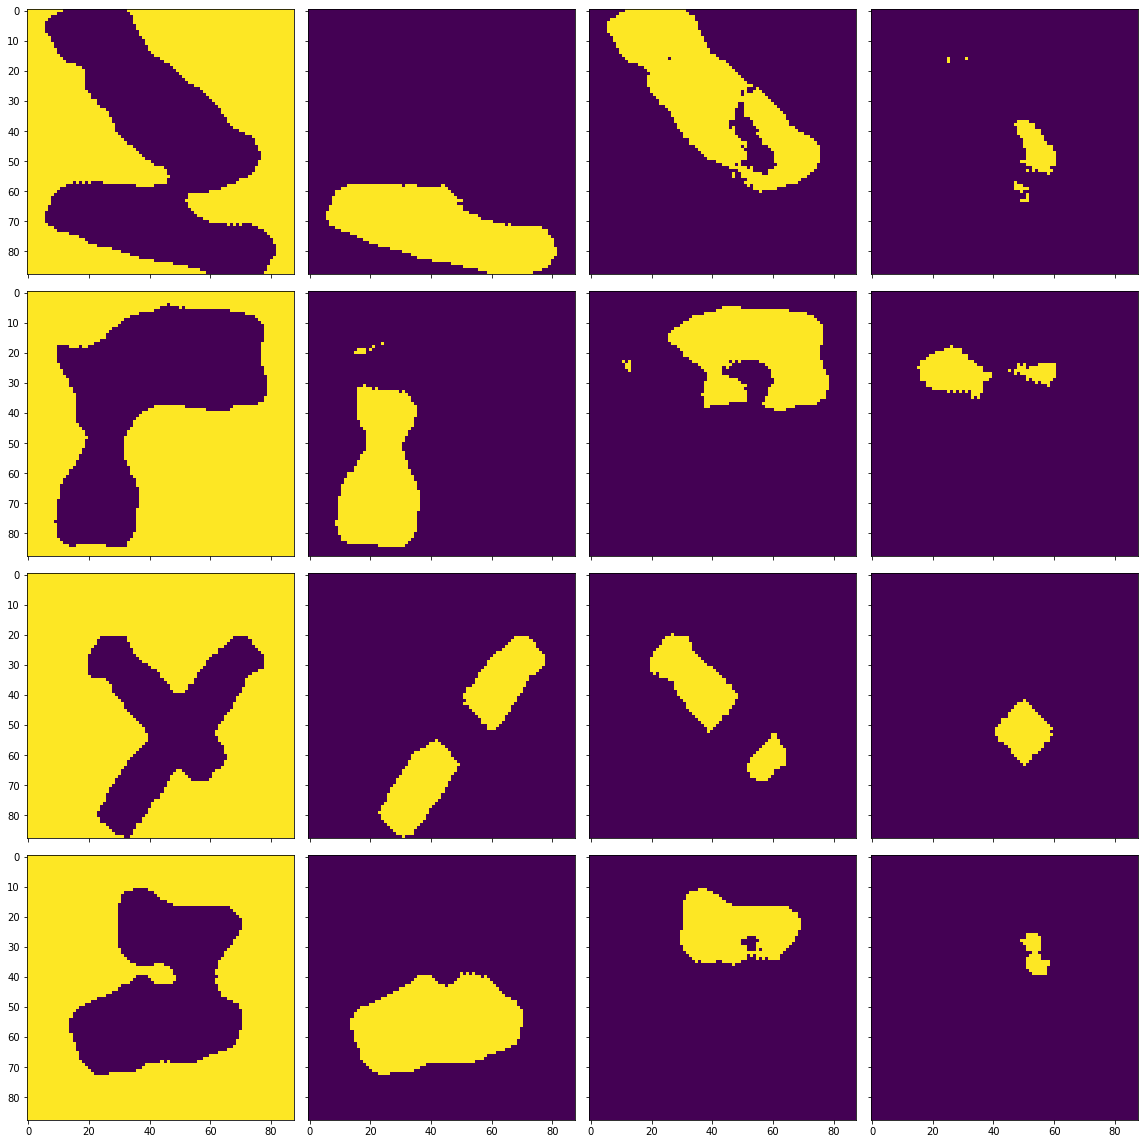

Training IOU: [0.977325886250038, 0.8905700785482182, 0.8675119387061319, 0.6583385094607248]
Training accuracy: 0.9644479597107438
Testing IOU: [0.9750112644154073, 0.4235210217511102, 0.26070667330209674, 0.35222364283492863]
Testing accuracy: 0.8571009814049587
13/13 [==============================] - 1s 66ms/step - loss: 0.0127 - val_loss: 0.0533
INFO:tensorflow:Assets written to: modelunet/savedmodel_72epoch\assets
4
4


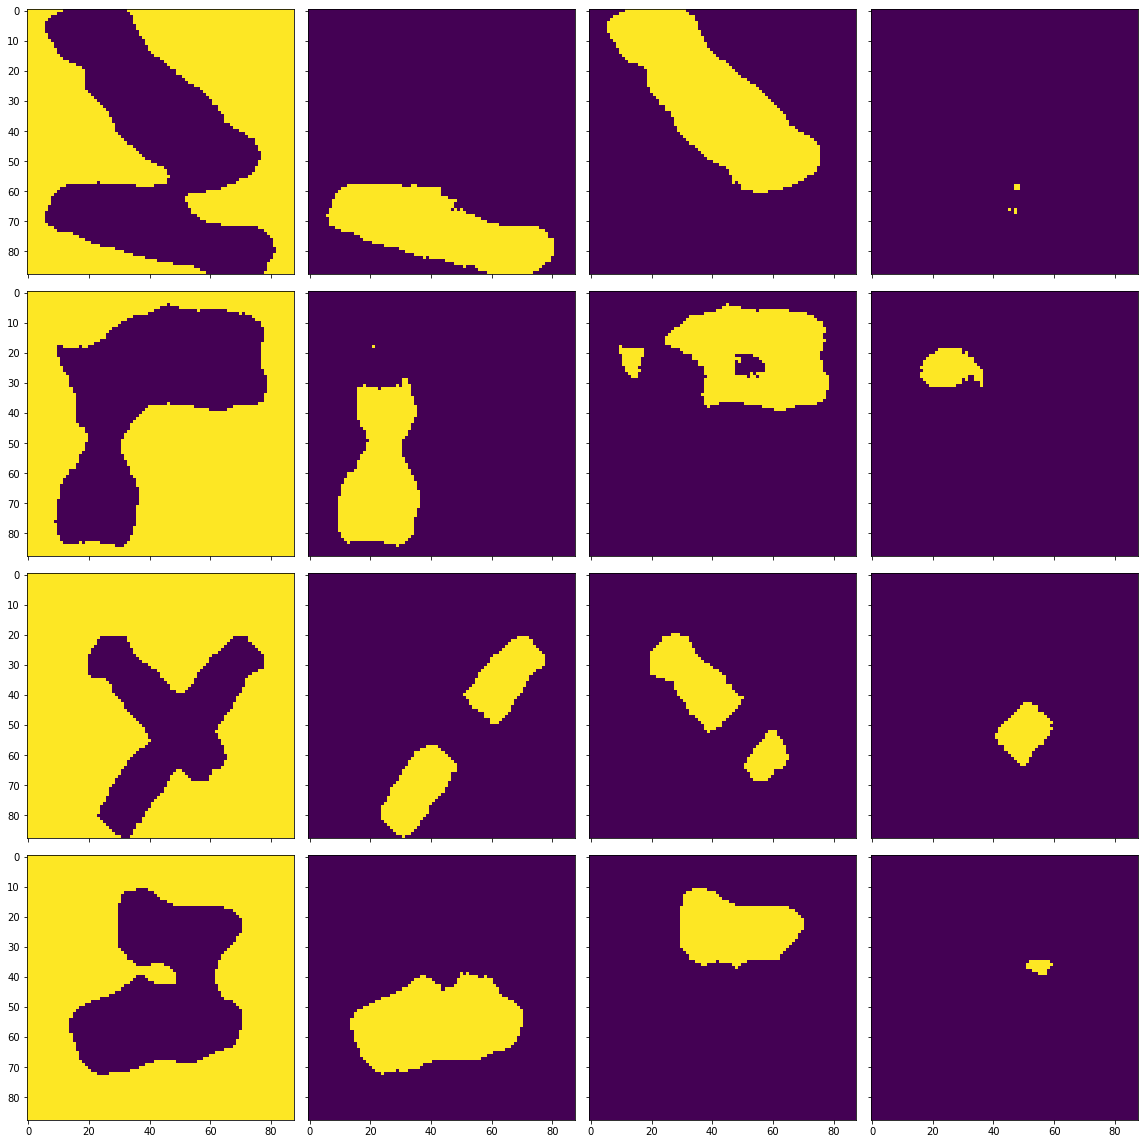

Training IOU: [0.9778525172602701, 0.883522604553877, 0.890942124633135, 0.664160774837664]
Training accuracy: 0.9657689824380166
Testing IOU: [0.9750317048078542, 0.3606394342333051, 0.3339007432270439, 0.34764281752634496]
Testing accuracy: 0.8550581095041322
13/13 [==============================] - 1s 67ms/step - loss: 0.0128 - val_loss: 0.0561ETA: 0s - loss: 0.01
INFO:tensorflow:Assets written to: modelunet/savedmodel_73epoch\assets
4
4


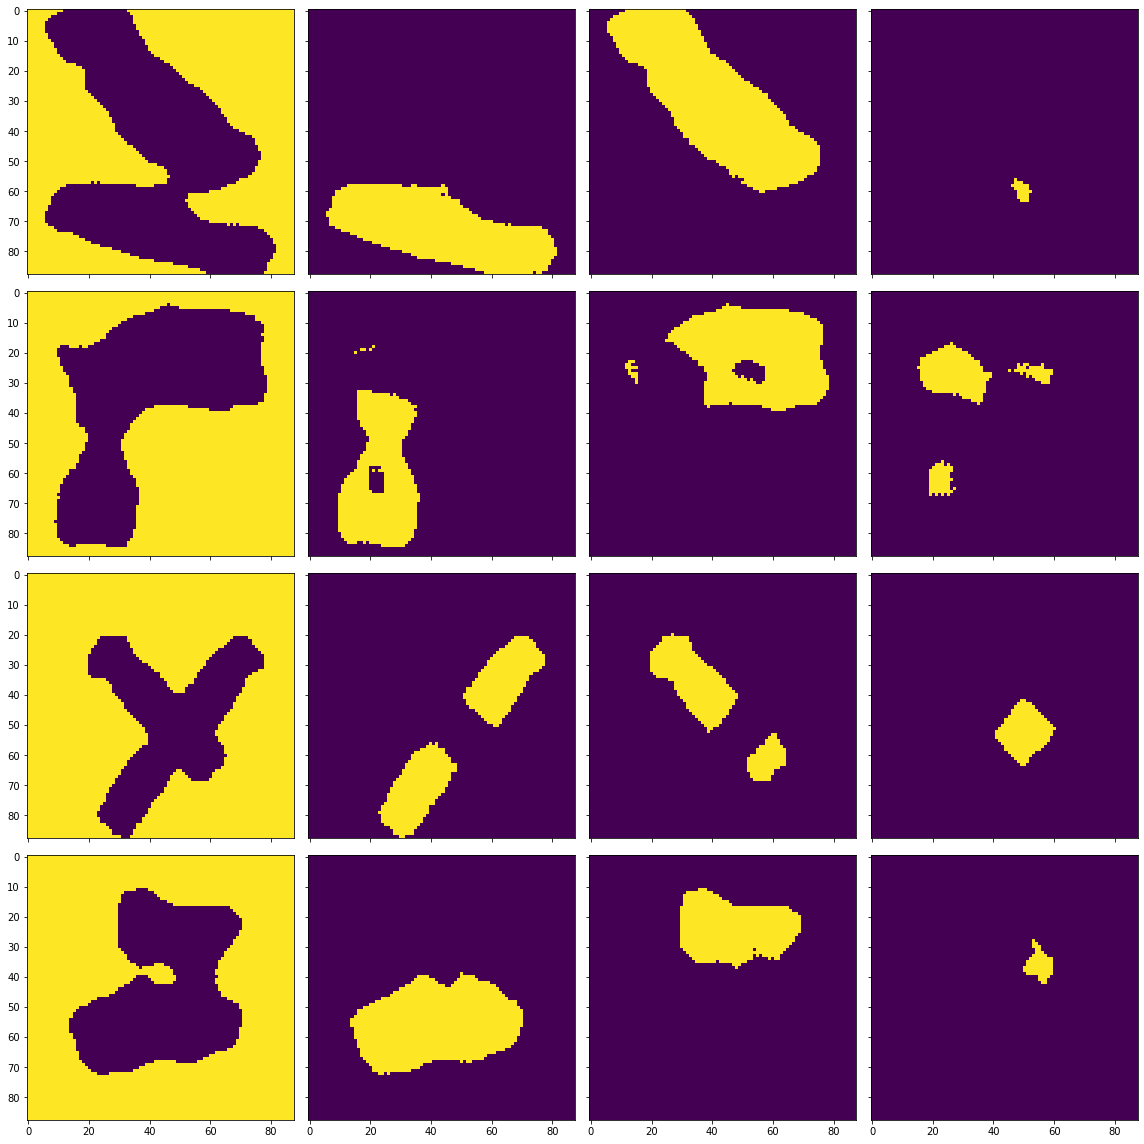

Training IOU: [0.9779117650476463, 0.8987027051418, 0.8963420473044145, 0.714249734650188]
Training accuracy: 0.9694017949380165
Testing IOU: [0.9749777580071174, 0.3717146967905526, 0.30261306961081036, 0.3390603280511537]
Testing accuracy: 0.8535214359504132
13/13 [==============================] - ETA: 0s - loss: 0.011 - 1s 66ms/step - loss: 0.0116 - val_loss: 0.0537
INFO:tensorflow:Assets written to: modelunet/savedmodel_74epoch\assets
4
4


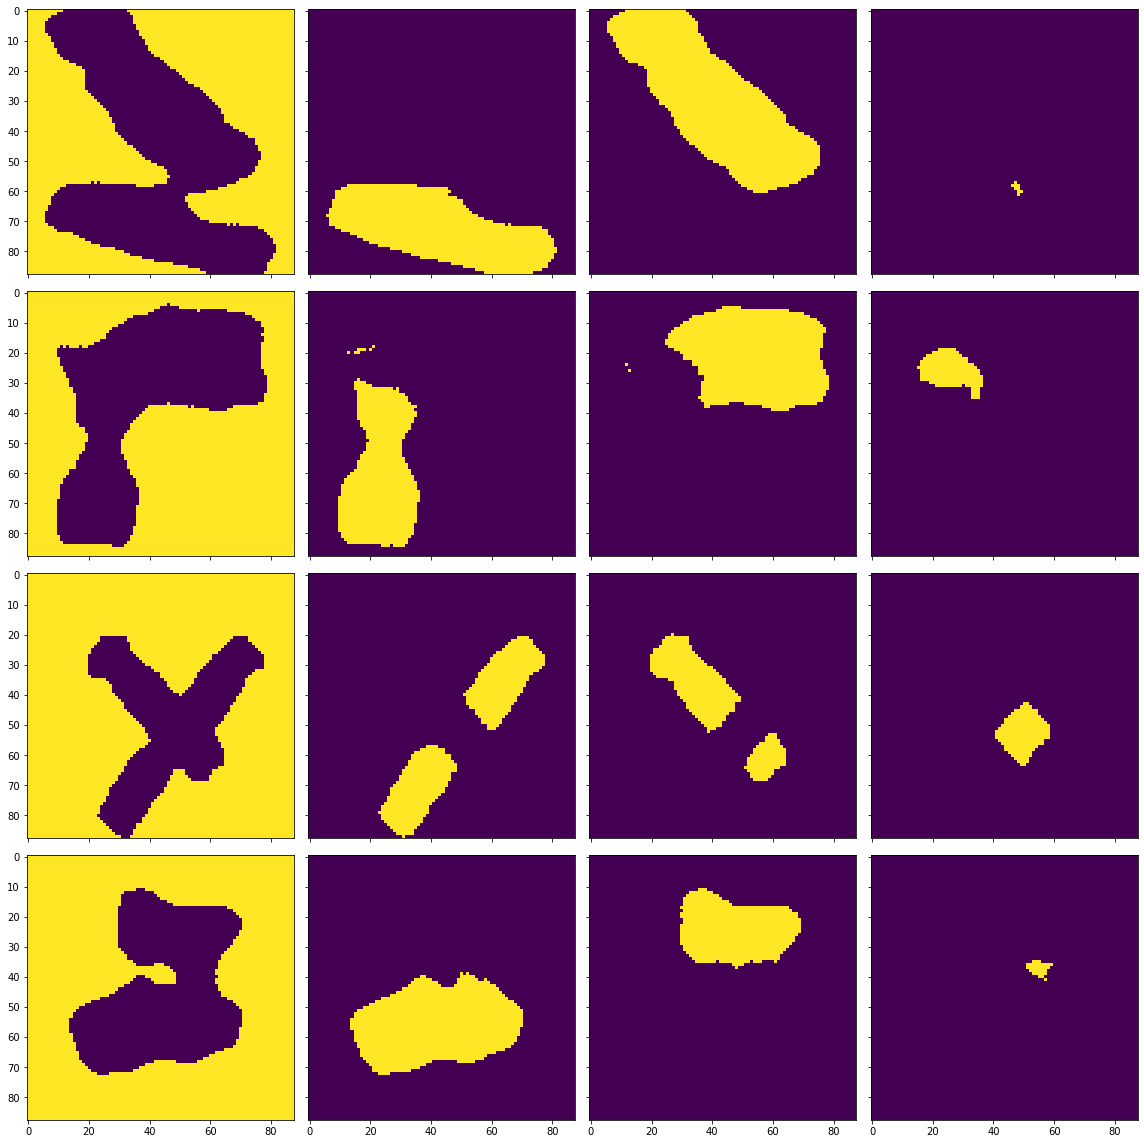

Training IOU: [0.978202966056323, 0.9059398257795052, 0.903563797515102, 0.7167893233188972]
Training accuracy: 0.971342006714876
Testing IOU: [0.9751315326129758, 0.39184629012527944, 0.31344818074675895, 0.3516087144712163]
Testing accuracy: 0.8588868801652892
13/13 [==============================] - 1s 66ms/step - loss: 0.0113 - val_loss: 0.0547
INFO:tensorflow:Assets written to: modelunet/savedmodel_75epoch\assets
4
4


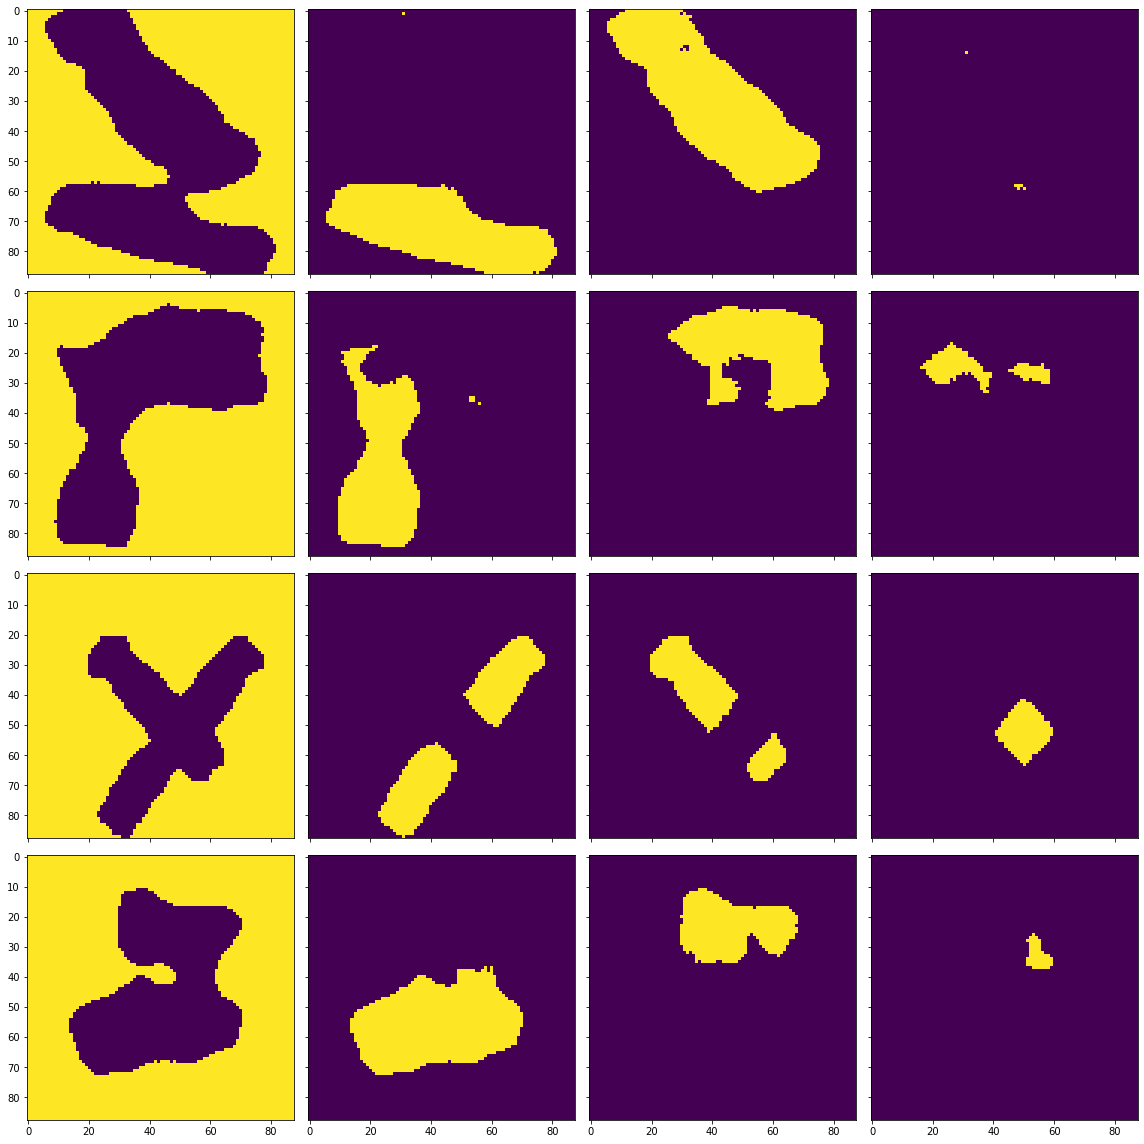

Training IOU: [0.9782341754812434, 0.8932822933834103, 0.8513883754810933, 0.6643822467941335]
Training accuracy: 0.9629987732438017
Testing IOU: [0.9750169566205412, 0.42821615002493263, 0.22287032945450974, 0.3448116887722534]
Testing accuracy: 0.8552802169421487
13/13 [==============================] - 1s 66ms/step - loss: 0.0112 - val_loss: 0.0546
INFO:tensorflow:Assets written to: modelunet/savedmodel_76epoch\assets
4
4


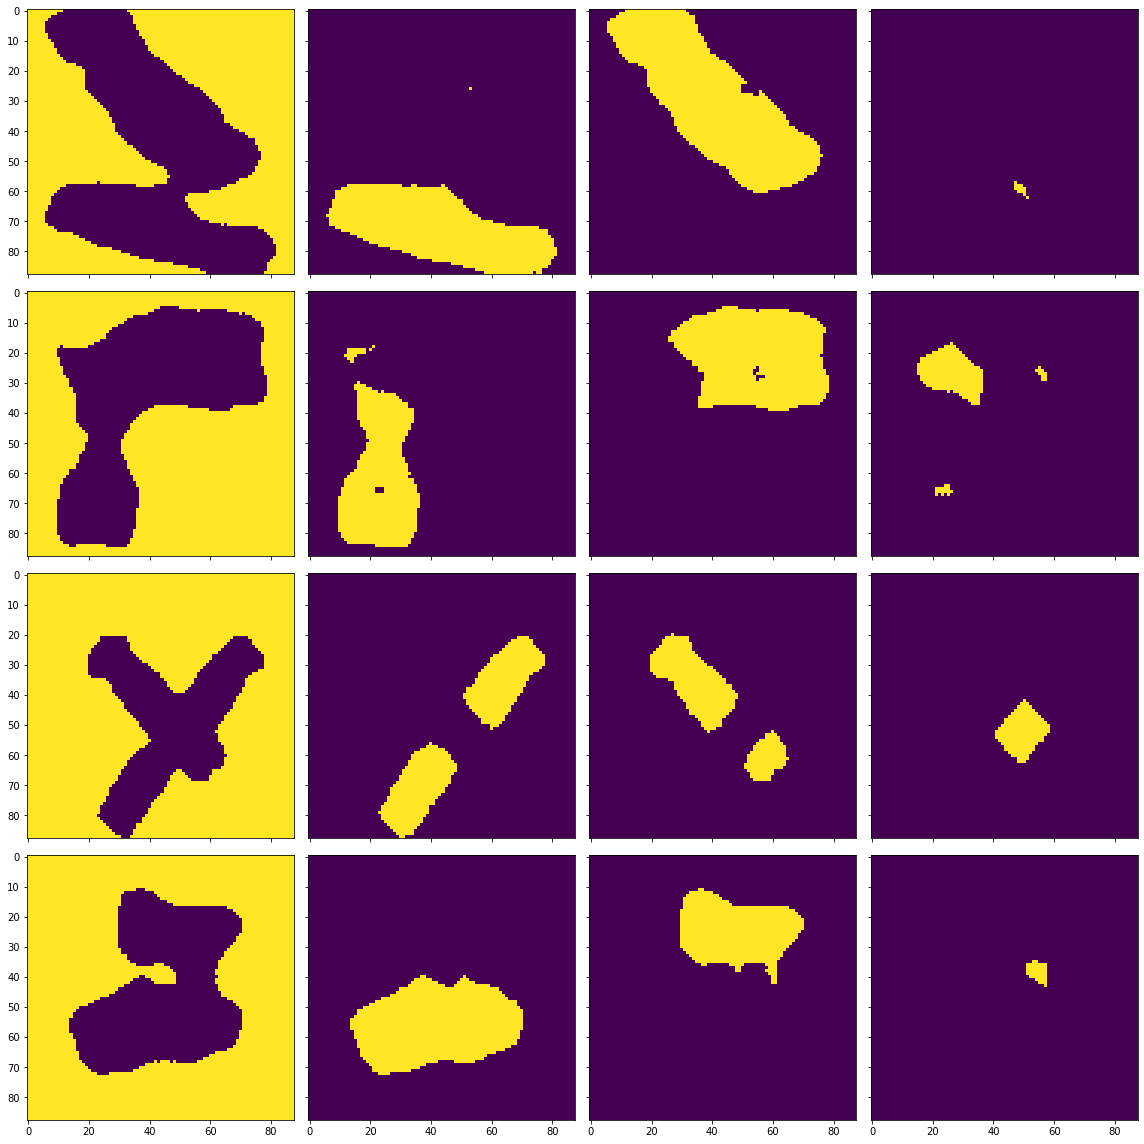

Training IOU: [0.9781024800537619, 0.9090339307857063, 0.9090688639011455, 0.7465682876101812]
Training accuracy: 0.9725206611570248
Testing IOU: [0.9751343840910077, 0.36928656062618936, 0.32764974694118226, 0.3434349919743178]
Testing accuracy: 0.8569072830578512
13/13 [==============================] - 1s 67ms/step - loss: 0.0106 - val_loss: 0.0553
INFO:tensorflow:Assets written to: modelunet/savedmodel_77epoch\assets
4
4


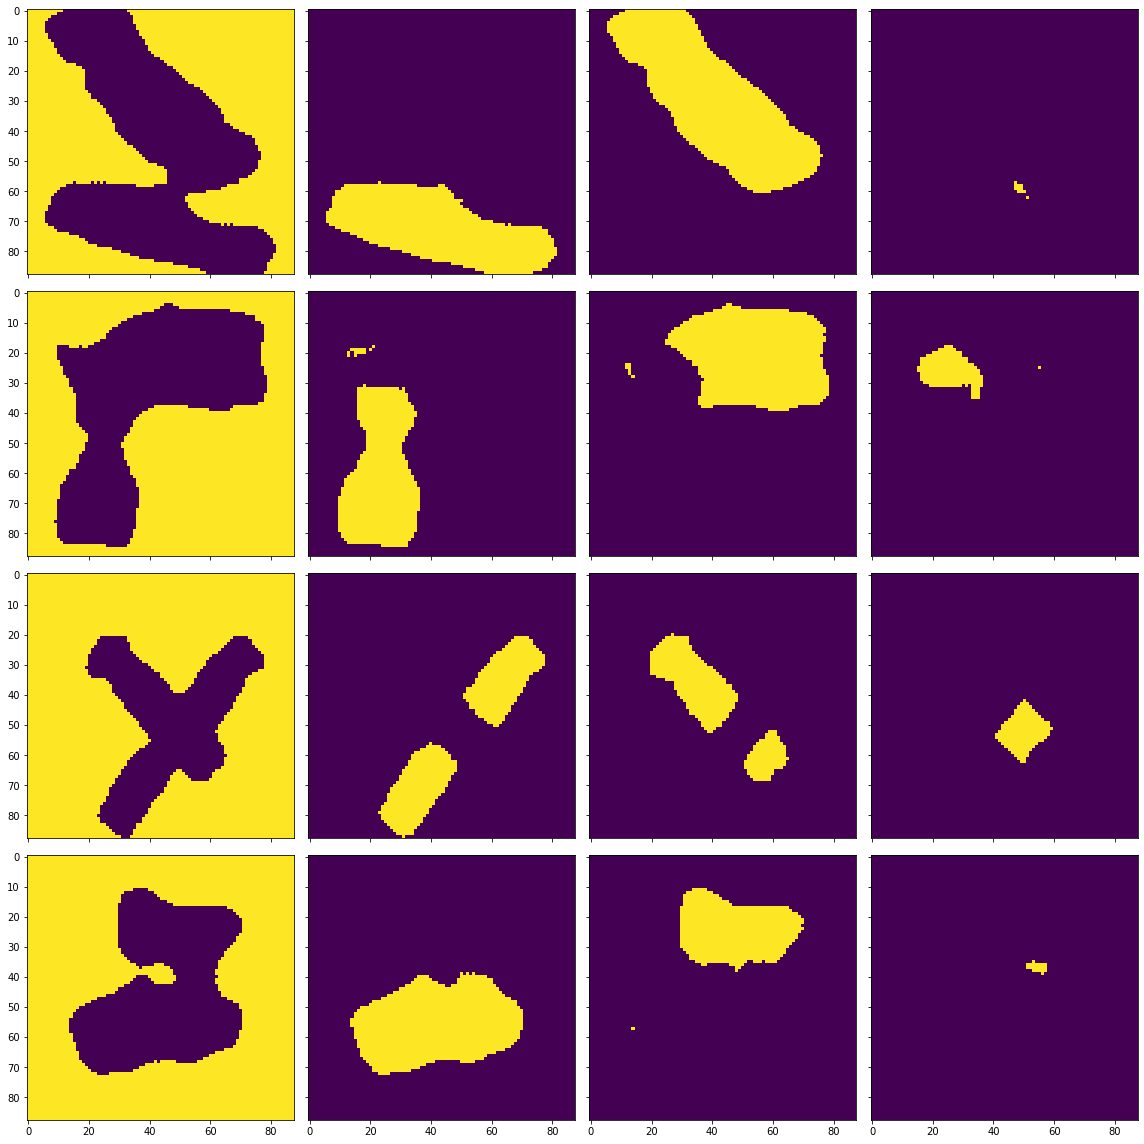

Training IOU: [0.9780386593304166, 0.9117618639935464, 0.9078244959273948, 0.7195931921959319]
Training accuracy: 0.9720851627066116
Testing IOU: [0.975134582659044, 0.3735143232662983, 0.32496516619550425, 0.3498357312790302]
Testing accuracy: 0.856744576446281
13/13 [==============================] - 1s 67ms/step - loss: 0.0105 - val_loss: 0.0553
INFO:tensorflow:Assets written to: modelunet/savedmodel_78epoch\assets
4
4


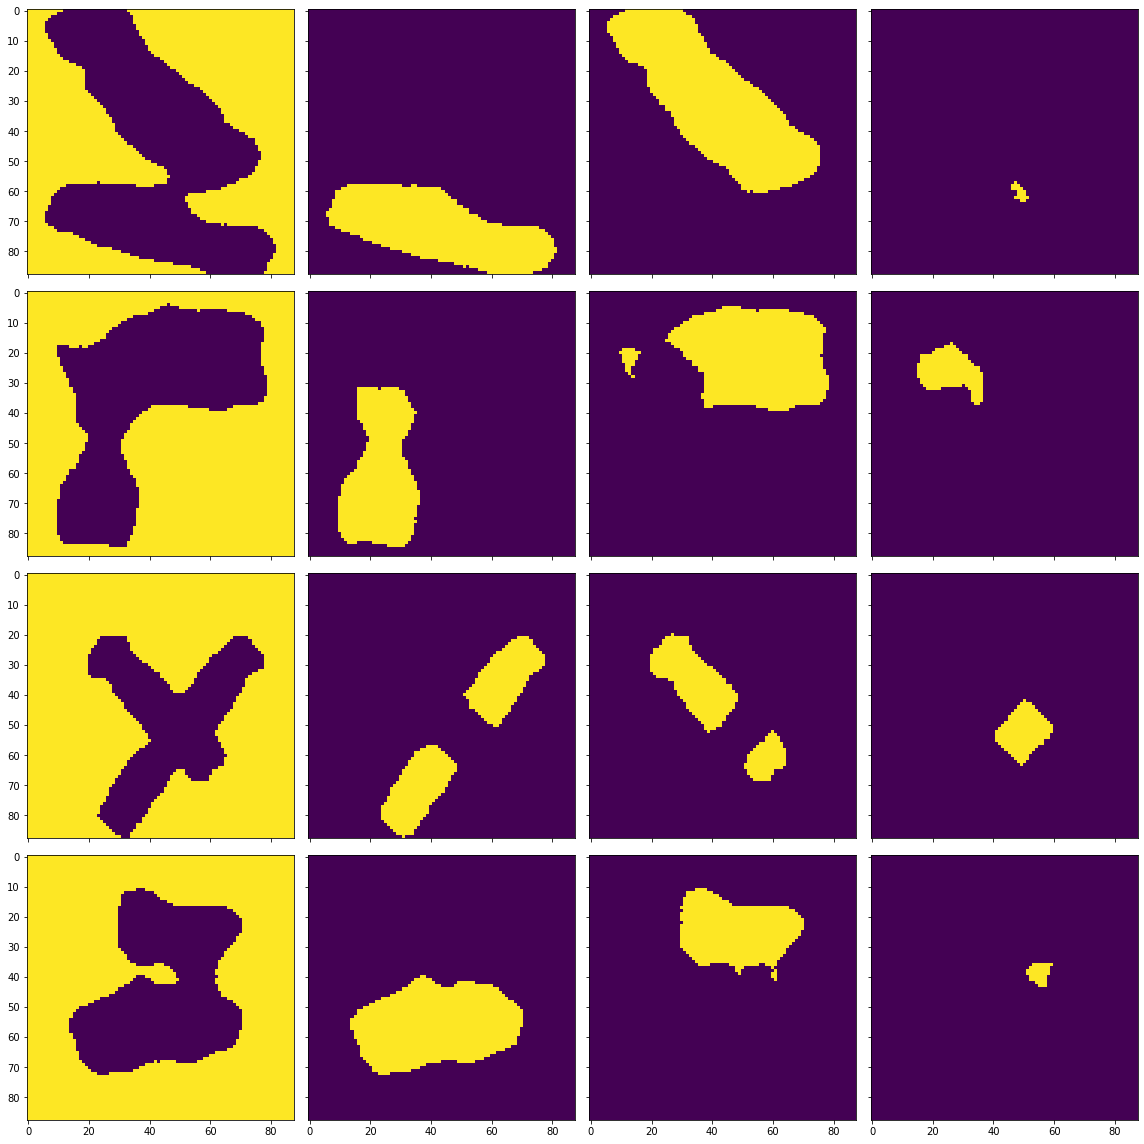

Training IOU: [0.9783928377582123, 0.907339803520019, 0.9155213854714408, 0.7660925716166633]
Training accuracy: 0.9729158057851239
Testing IOU: [0.9750817645874273, 0.36523074672712647, 0.3222763742457397, 0.34296701671350394]
Testing accuracy: 0.8549896694214876
13/13 [==============================] - 1s 67ms/step - loss: 0.0101 - val_loss: 0.0542
INFO:tensorflow:Assets written to: modelunet/savedmodel_79epoch\assets
4
4


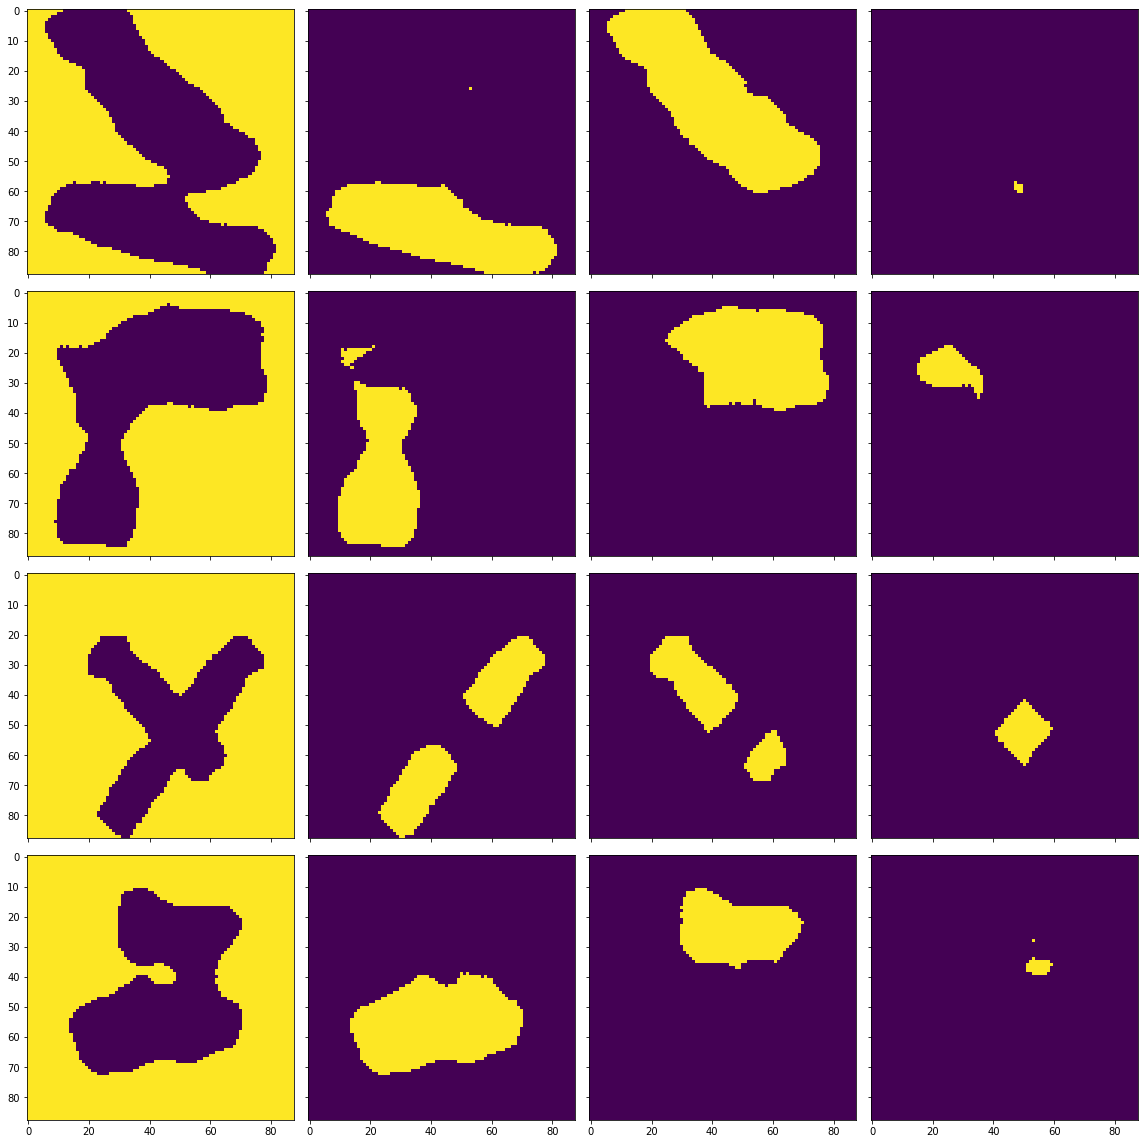

Training IOU: [0.9785697246714632, 0.9159452991912178, 0.9102125461969239, 0.7703095221109062]
Training accuracy: 0.9729274276859504
Testing IOU: [0.9752198255284059, 0.4034903024658865, 0.2824046657694033, 0.3435408906615684]
Testing accuracy: 0.8567110020661157
13/13 [==============================] - 1s 67ms/step - loss: 0.0099 - val_loss: 0.0540
INFO:tensorflow:Assets written to: modelunet/savedmodel_80epoch\assets
4
4


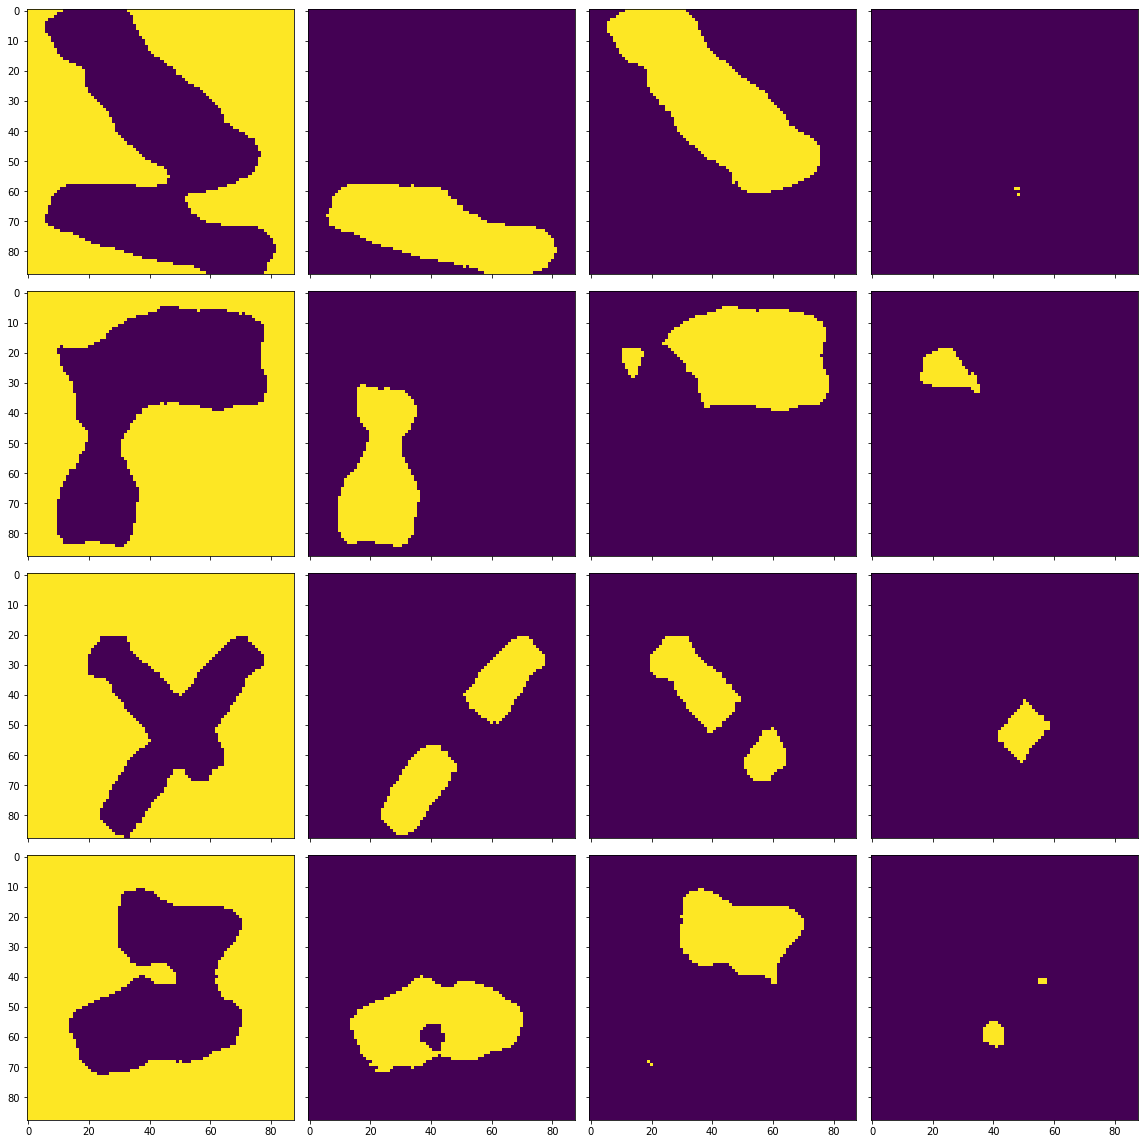

Training IOU: [0.9780023540277879, 0.8815683820365867, 0.8780574613415724, 0.5696531142045338]
Training accuracy: 0.9629616477272728
Testing IOU: [0.9744408613876296, 0.33589046119991445, 0.35611527013619554, 0.29173022882376554]
Testing accuracy: 0.8542858987603306
13/13 [==============================] - 1s 66ms/step - loss: 0.0114 - val_loss: 0.0543
INFO:tensorflow:Assets written to: modelunet/savedmodel_81epoch\assets
4
4


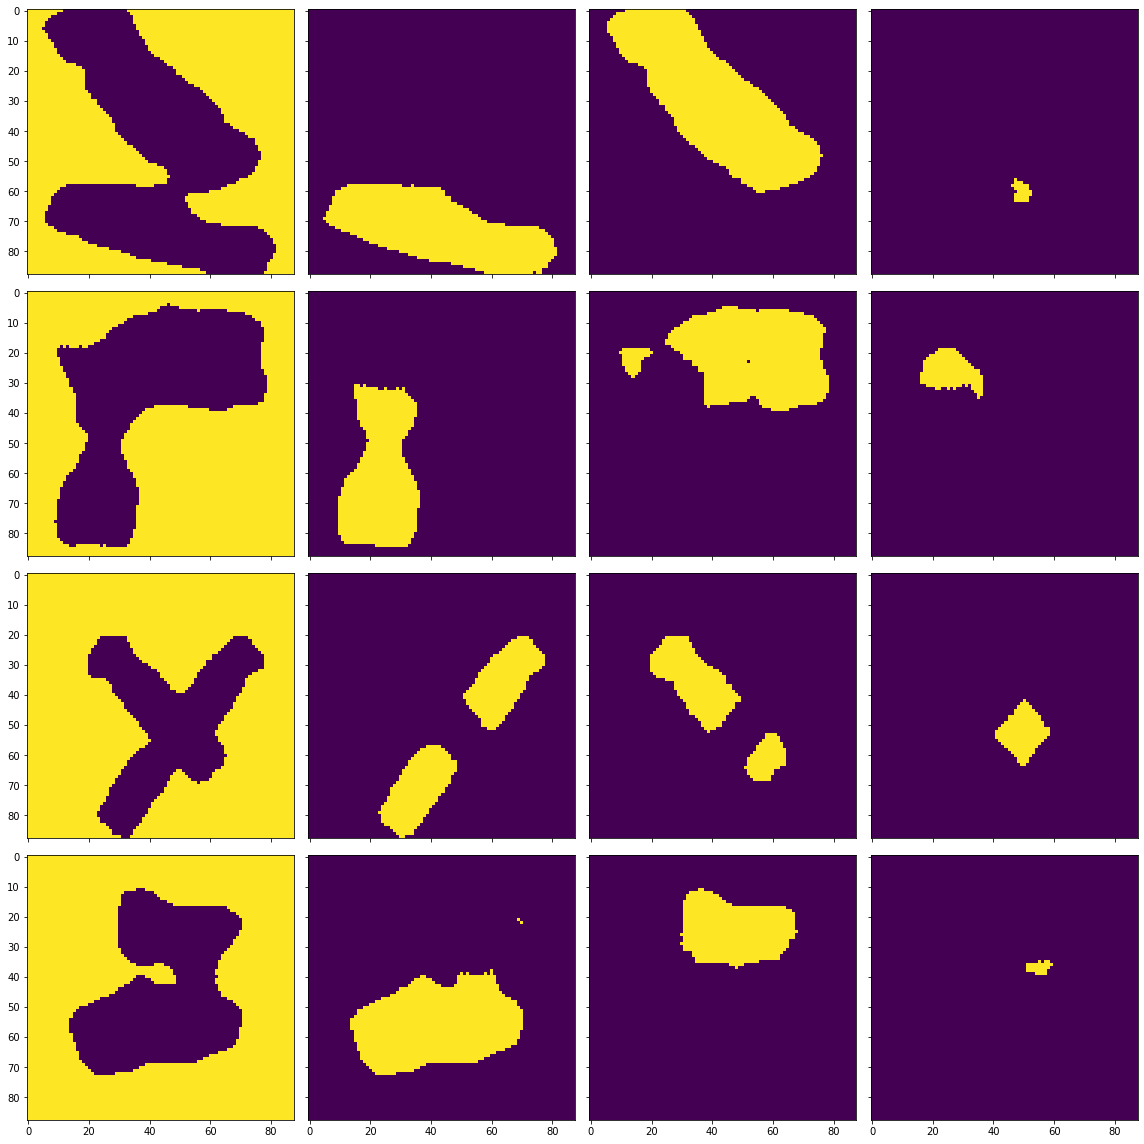

Training IOU: [0.9783119736425766, 0.9045114451277725, 0.8965649833376057, 0.7458831321311377]
Training accuracy: 0.9705930397727273
Testing IOU: [0.9751116406794145, 0.4171059637912673, 0.27707296183287833, 0.3807528409090909]
Testing accuracy: 0.8598217975206611
13/13 [==============================] - 1s 67ms/step - loss: 0.0124 - val_loss: 0.0538
INFO:tensorflow:Assets written to: modelunet/savedmodel_82epoch\assets
4
4


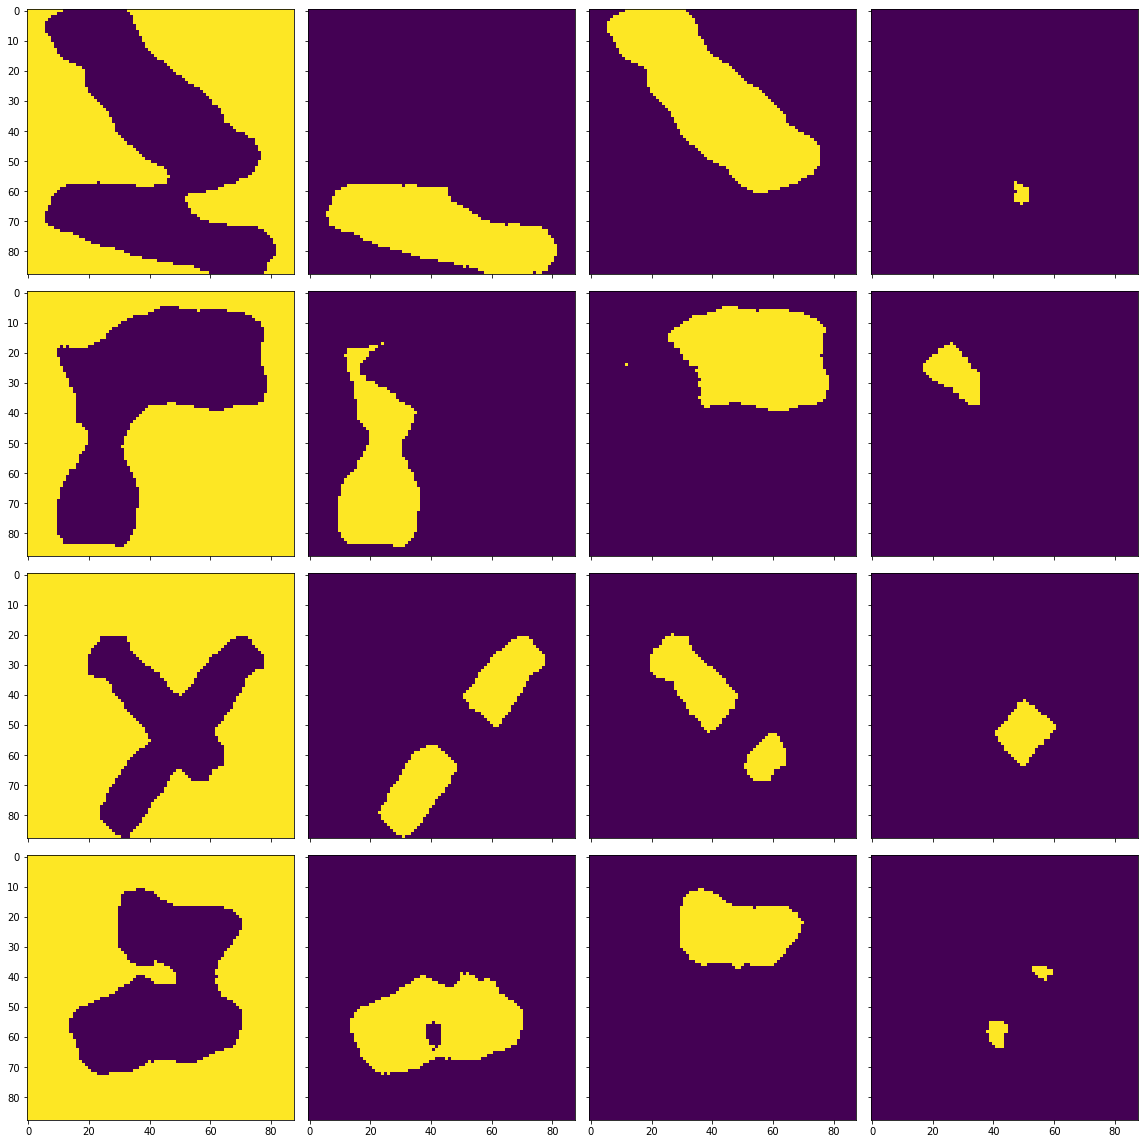

Training IOU: [0.9782856959247691, 0.8978288462823167, 0.8934483649545991, 0.7150579832427447]
Training accuracy: 0.9696619963842975
Testing IOU: [0.9749186391045791, 0.4097270652917239, 0.29345016049275613, 0.3920704845814978]
Testing accuracy: 0.861433367768595
13/13 [==============================] - 1s 67ms/step - loss: 0.0114 - val_loss: 0.0552
INFO:tensorflow:Assets written to: modelunet/savedmodel_83epoch\assets
4
4


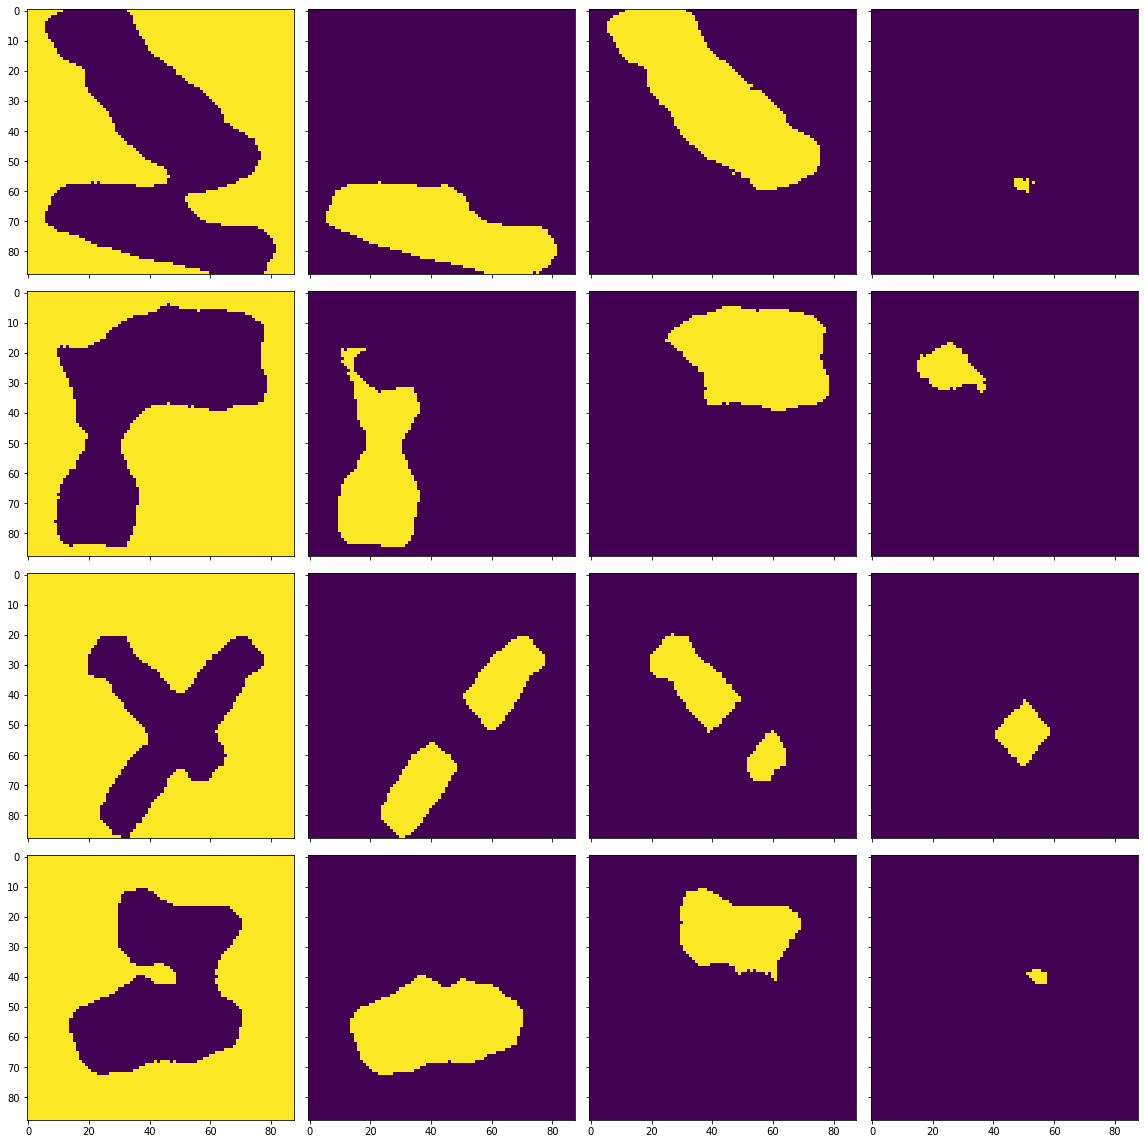

Training IOU: [0.9785340723513866, 0.9097109873218039, 0.9038187494996397, 0.7622176106690796]
Training accuracy: 0.9724412448347107
Testing IOU: [0.9752254012585302, 0.4035530046804004, 0.2941344976952925, 0.3582828117319351]
Testing accuracy: 0.8592019628099173
13/13 [==============================] - 1s 66ms/step - loss: 0.0103 - val_loss: 0.0533
INFO:tensorflow:Assets written to: modelunet/savedmodel_84epoch\assets
4
4


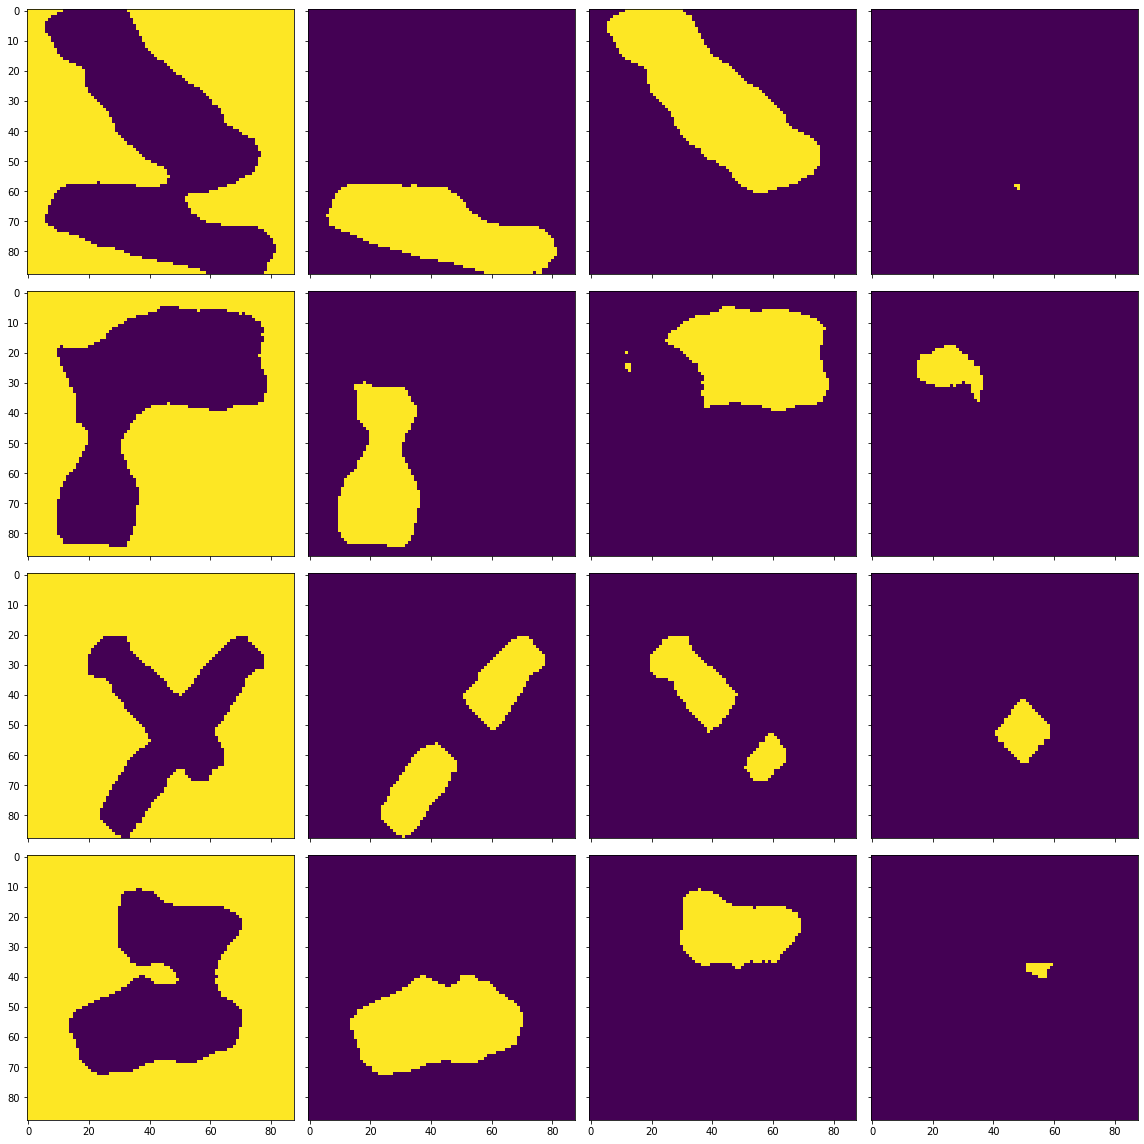

Training IOU: [0.9784224674848261, 0.9128217432935014, 0.9089872772988312, 0.77885572905438]
Training accuracy: 0.9722059013429752
Testing IOU: [0.9747448939822522, 0.3946838891693231, 0.286269281368922, 0.370635167340172]
Testing accuracy: 0.8560950413223141
13/13 [==============================] - 1s 67ms/step - loss: 0.0099 - val_loss: 0.0557
INFO:tensorflow:Assets written to: modelunet/savedmodel_85epoch\assets
4
4


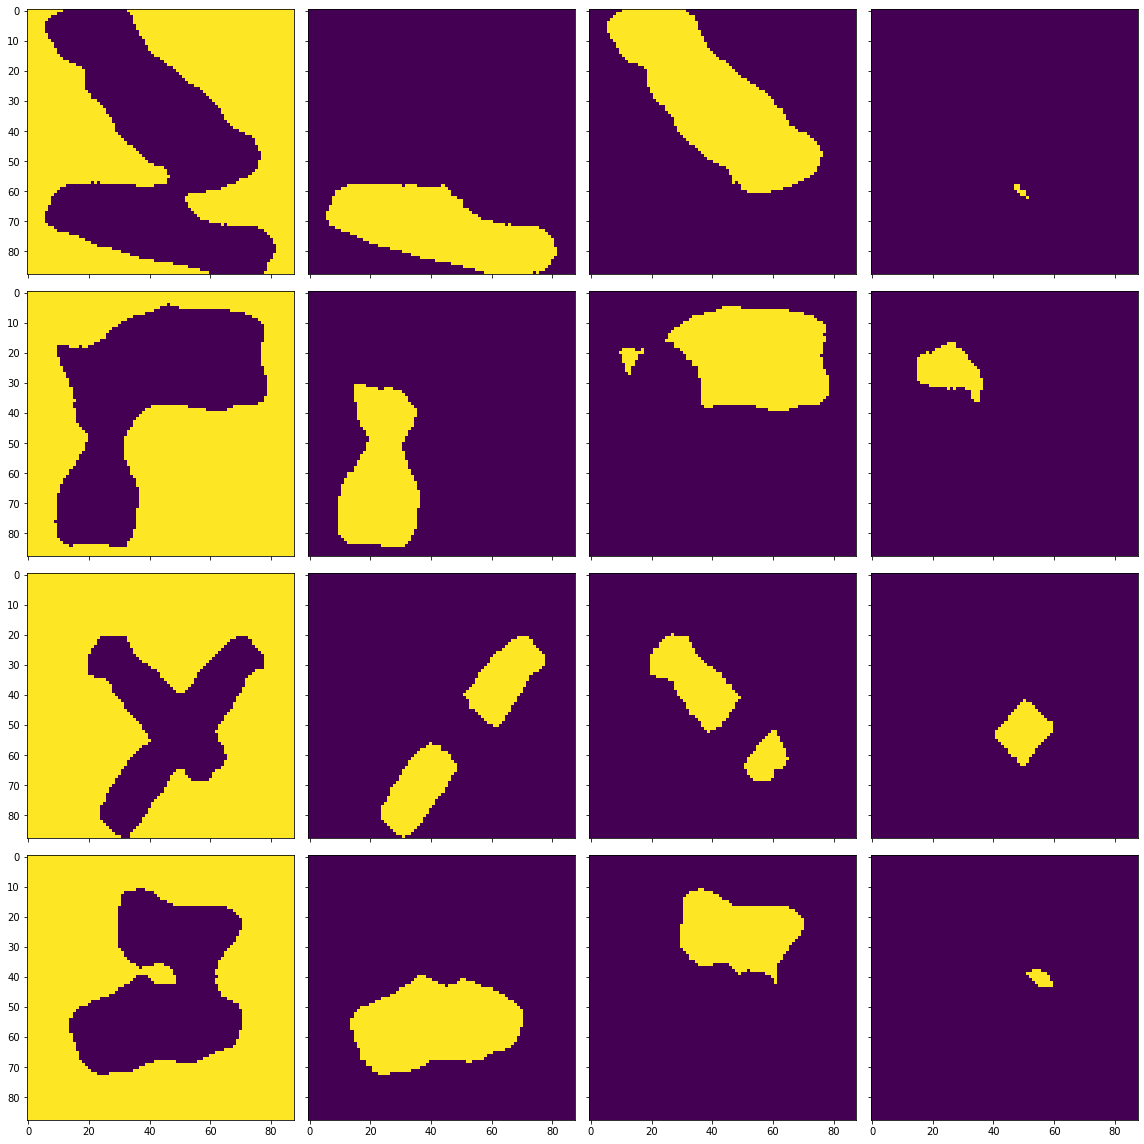

Training IOU: [0.9784647470338085, 0.9107454998829367, 0.9153517950968942, 0.7809522875111604]
Training accuracy: 0.974245222107438
Testing IOU: [0.9750624438353117, 0.37927954748437037, 0.33775044537179394, 0.3576710955126598]
Testing accuracy: 0.8601988636363637
13/13 [==============================] - 1s 67ms/step - loss: 0.0099 - val_loss: 0.0533
INFO:tensorflow:Assets written to: modelunet/savedmodel_86epoch\assets
4
4


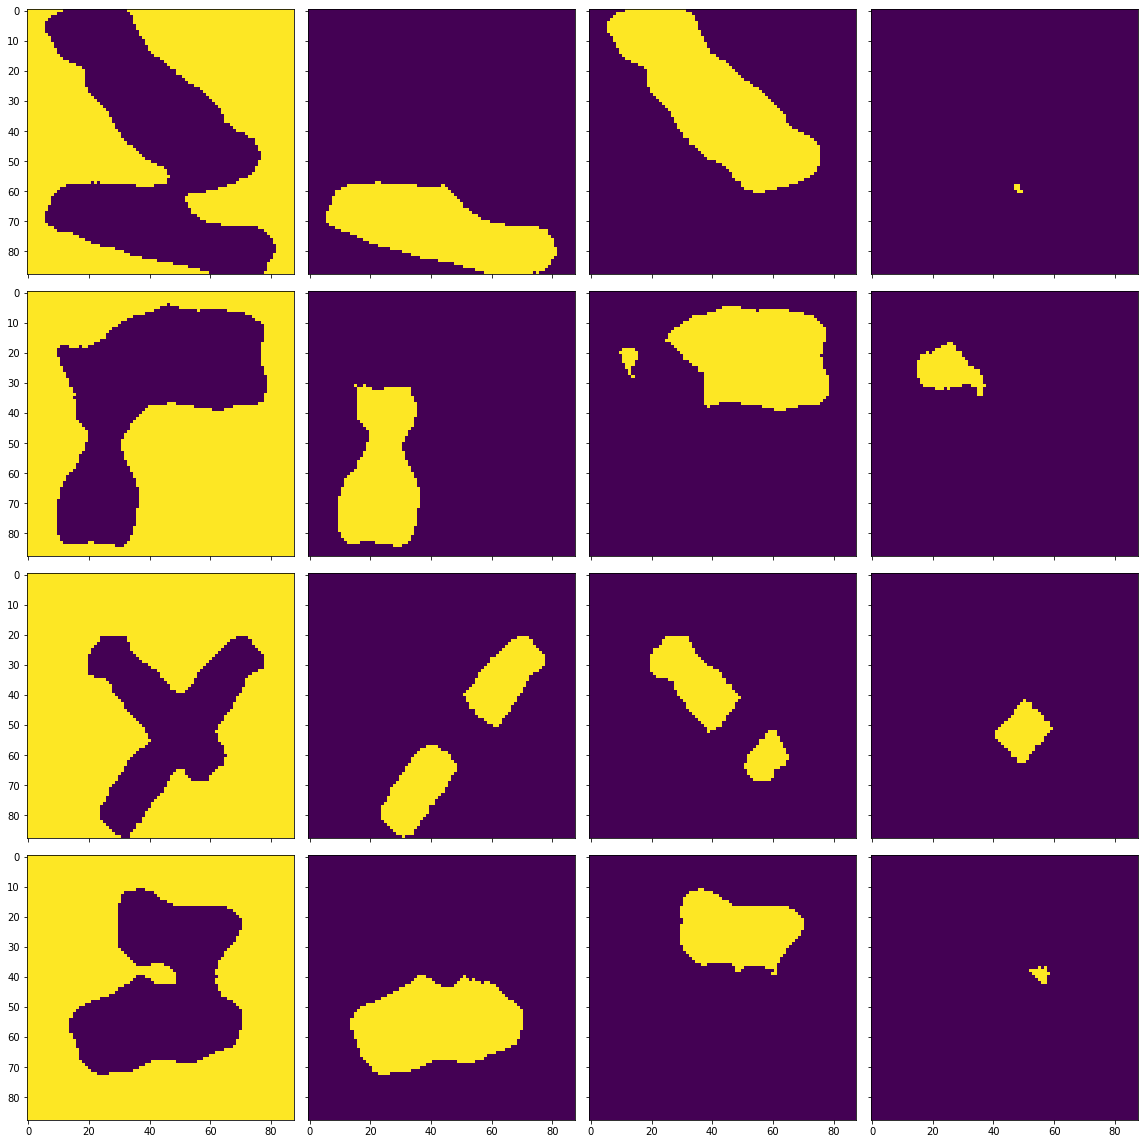

Training IOU: [0.9788788372174028, 0.917694397993311, 0.9189115921075013, 0.7926663694577288]
Training accuracy: 0.9749170325413223
Testing IOU: [0.9750840161907918, 0.3780995280995281, 0.3254502546267544, 0.371962871962872]
Testing accuracy: 0.8588584710743802
13/13 [==============================] - 1s 66ms/step - loss: 0.0094 - val_loss: 0.0547
INFO:tensorflow:Assets written to: modelunet/savedmodel_87epoch\assets
4
4


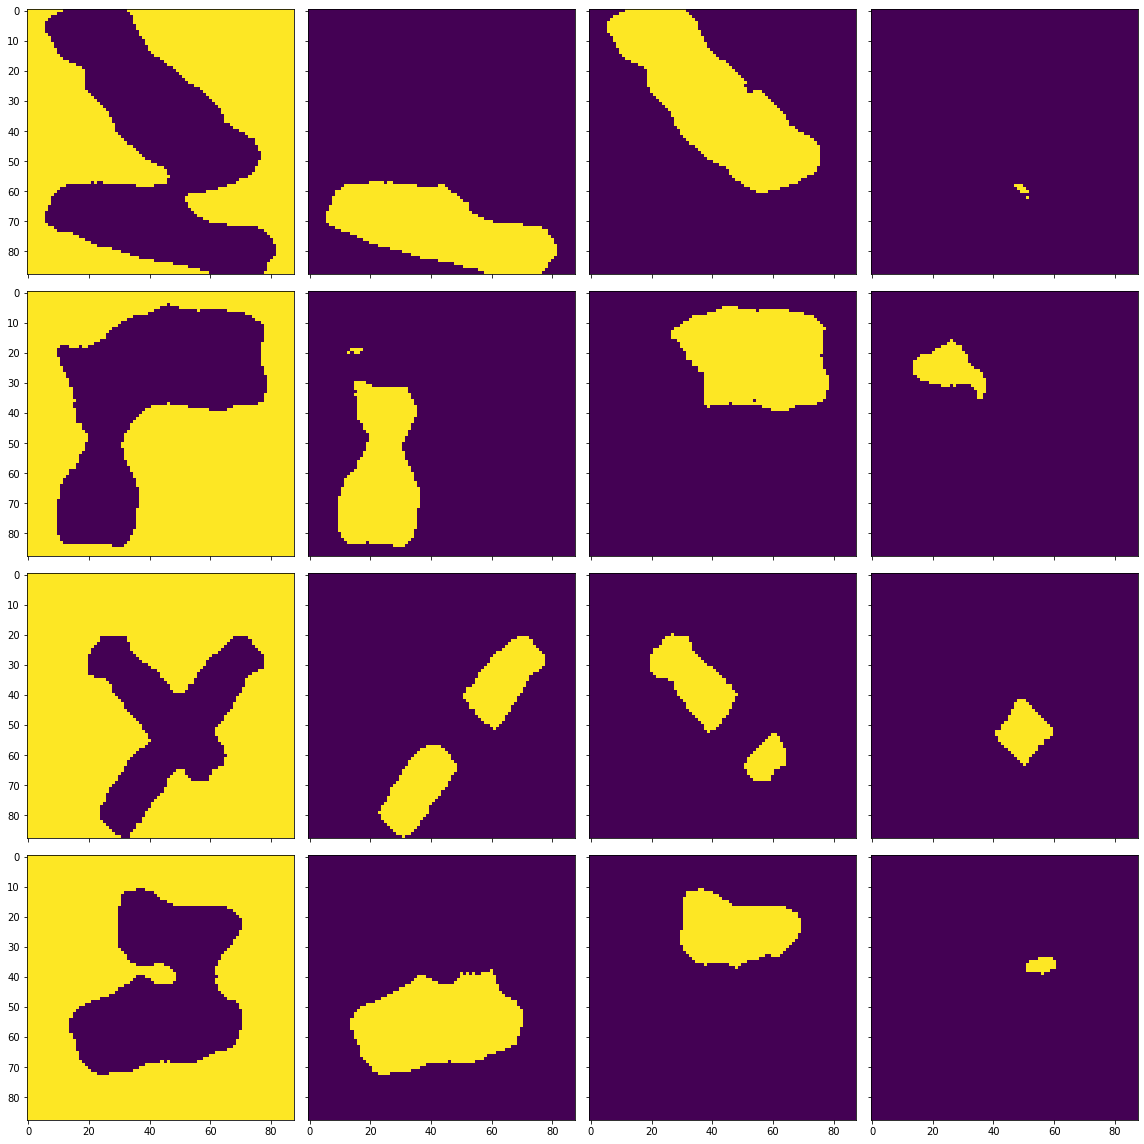

Training IOU: [0.979068607559184, 0.9227997790478767, 0.9145737874989194, 0.811304077061382]
Training accuracy: 0.9747381844008265
Testing IOU: [0.9751749040848567, 0.4120495608322479, 0.2605872832369942, 0.35381448443640445]
Testing accuracy: 0.856069214876033
13/13 [==============================] - 1s 67ms/step - loss: 0.0090 - val_loss: 0.0577
INFO:tensorflow:Assets written to: modelunet/savedmodel_88epoch\assets
4
4


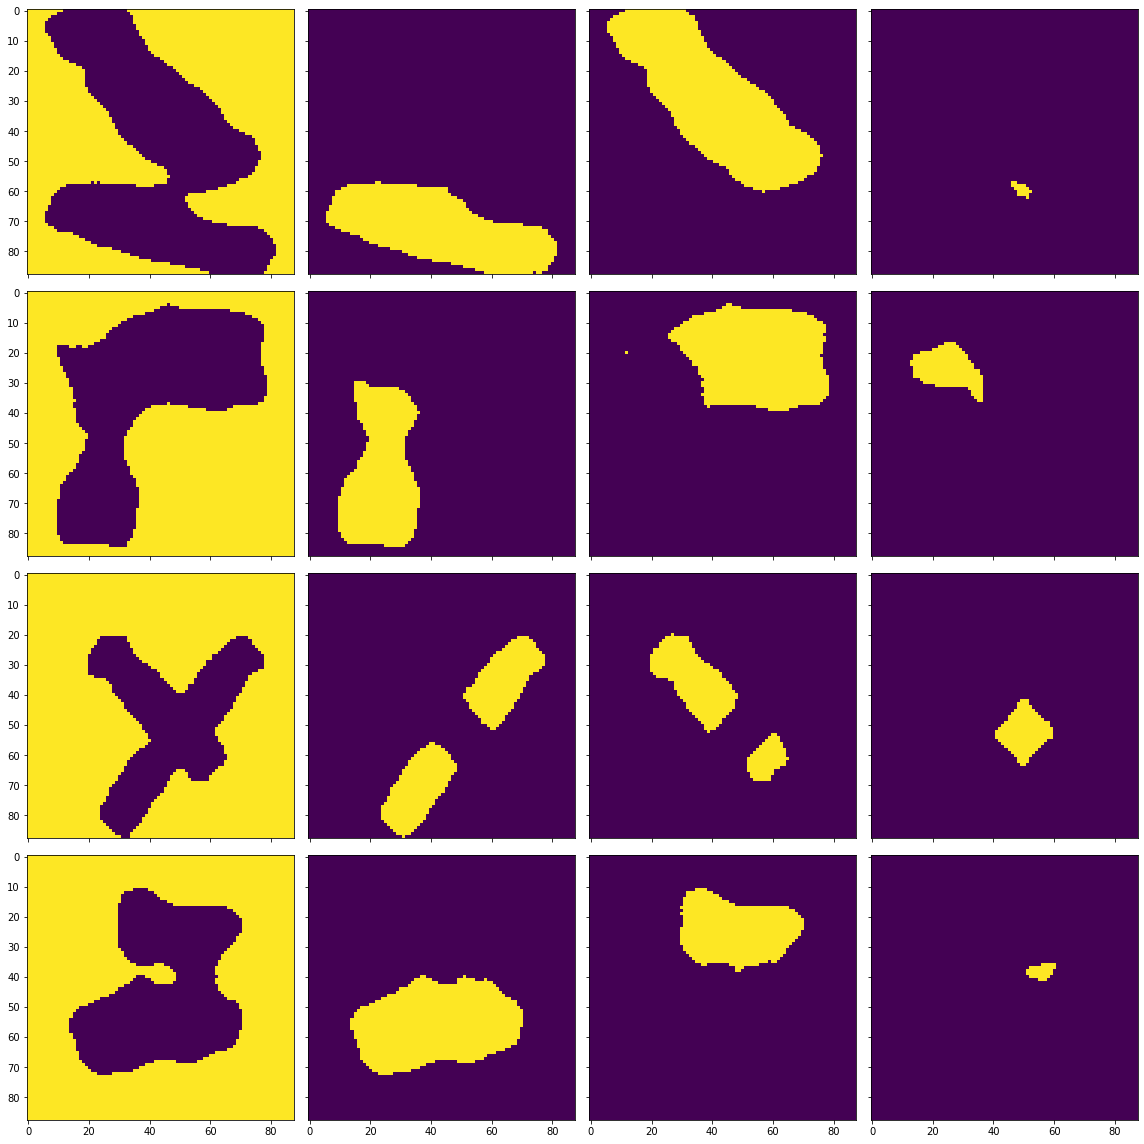

Training IOU: [0.9790714440327944, 0.9256965032716006, 0.9263849996519765, 0.8364571776418493]
Training accuracy: 0.9779009555785124
Testing IOU: [0.9751060840022024, 0.3808966363720211, 0.3112247502680258, 0.32648297695382716]
Testing accuracy: 0.8572107438016529
13/13 [==============================] - 1s 67ms/step - loss: 0.0088 - val_loss: 0.0560
INFO:tensorflow:Assets written to: modelunet/savedmodel_89epoch\assets
4
4


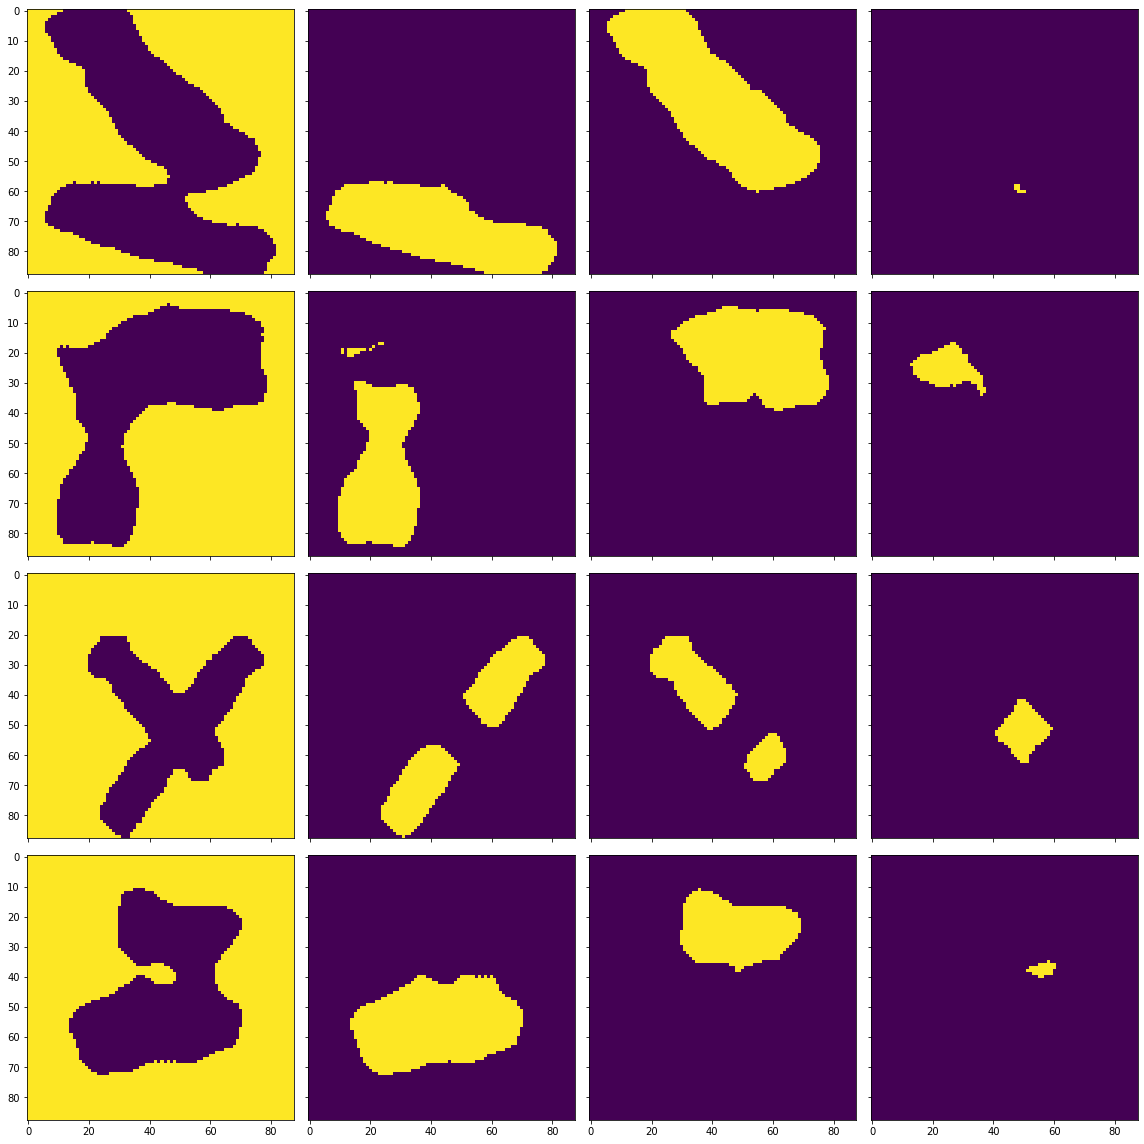

Training IOU: [0.9793439371809131, 0.9199259105711172, 0.9174702866433068, 0.8114962048648144]
Training accuracy: 0.9754919938016529
Testing IOU: [0.9749327005800239, 0.4199933084477567, 0.2619662455040118, 0.35742246311352005]
Testing accuracy: 0.8589669421487603
13/13 [==============================] - 1s 66ms/step - loss: 0.0088 - val_loss: 0.0558
INFO:tensorflow:Assets written to: modelunet/savedmodel_90epoch\assets
4
4


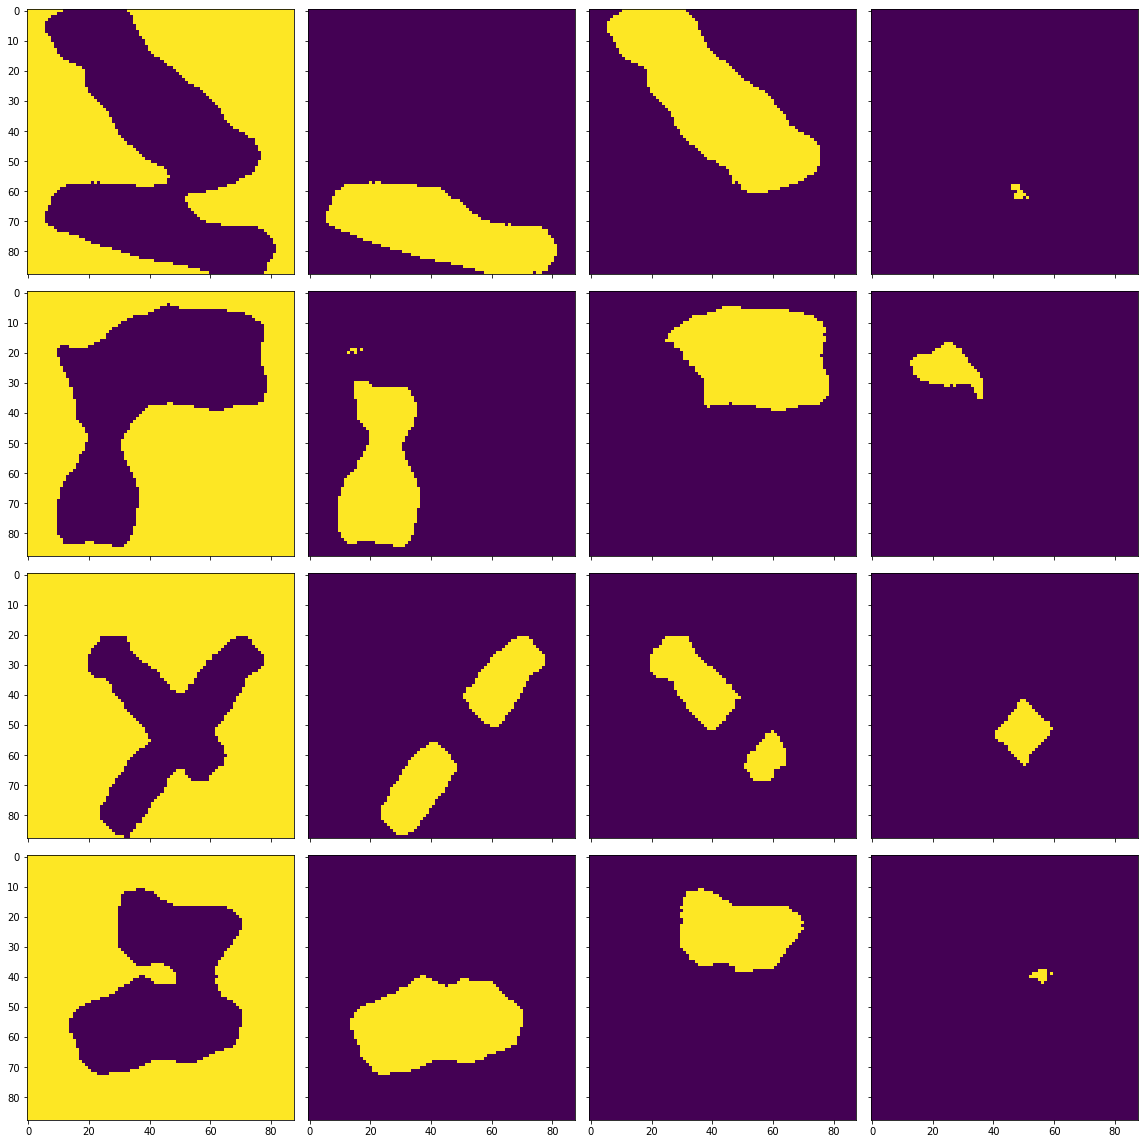

Training IOU: [0.9794004763597963, 0.9266048152996755, 0.9283633485163874, 0.83748973727422]
Training accuracy: 0.9779968362603306
Testing IOU: [0.9749175249506538, 0.3816156186901004, 0.3160344856561854, 0.3517770844803328]
Testing accuracy: 0.8585524276859504
13/13 [==============================] - 1s 66ms/step - loss: 0.0086 - val_loss: 0.0545
INFO:tensorflow:Assets written to: modelunet/savedmodel_91epoch\assets
4
4


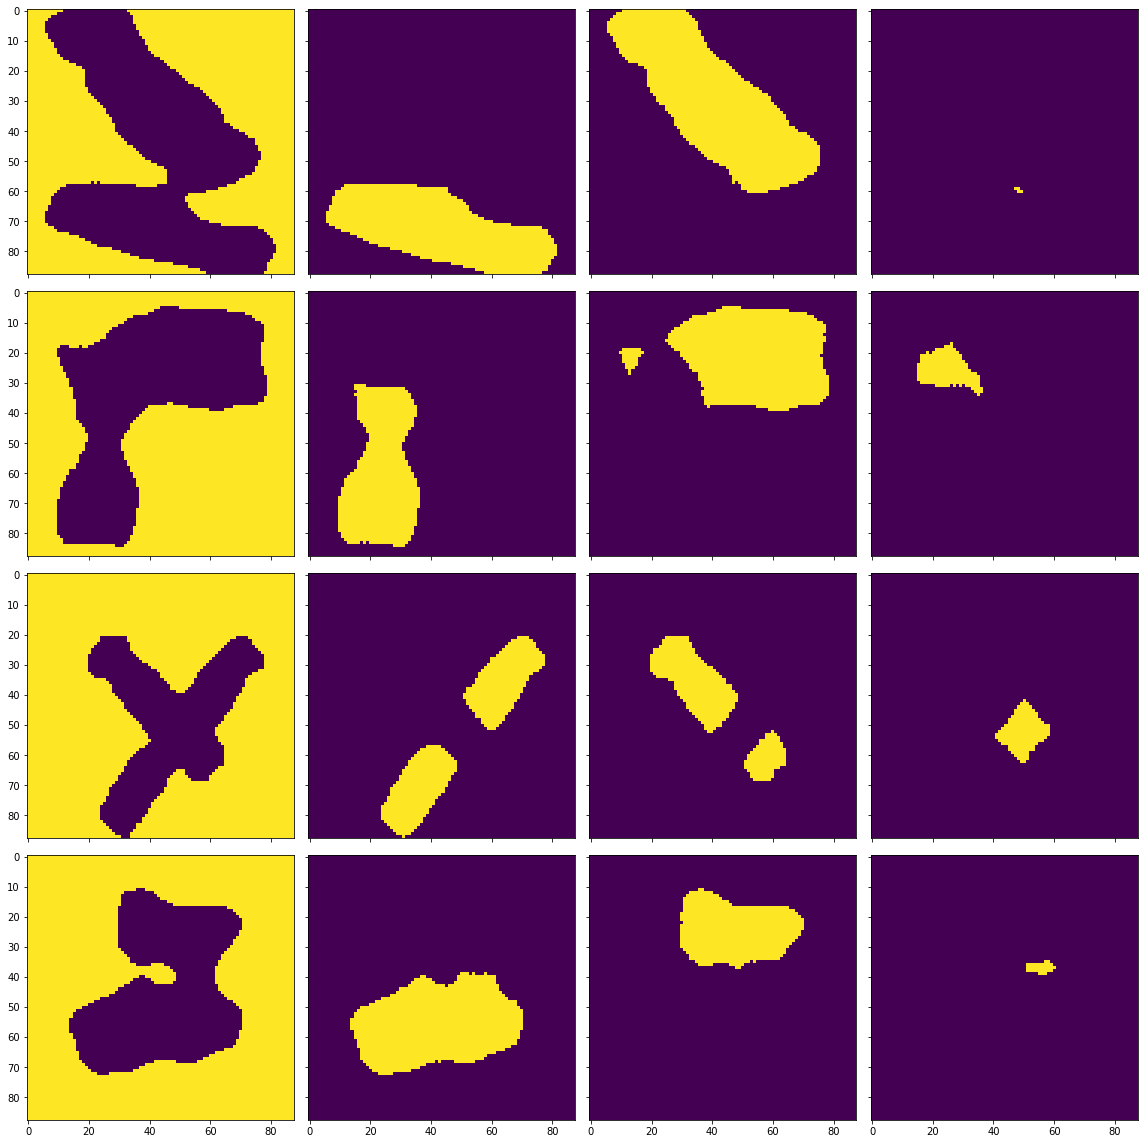

Training IOU: [0.9795508105709192, 0.9282276858672827, 0.9262423695581422, 0.7976536467482142]
Training accuracy: 0.9773266399793389
Testing IOU: [0.9750774815796872, 0.3951086015173035, 0.30962615165052315, 0.3534089704167108]
Testing accuracy: 0.8594989669421488
13/13 [==============================] - 1s 67ms/step - loss: 0.0087 - val_loss: 0.0555ETA: 0s - loss: 0.00
INFO:tensorflow:Assets written to: modelunet/savedmodel_92epoch\assets
4
4


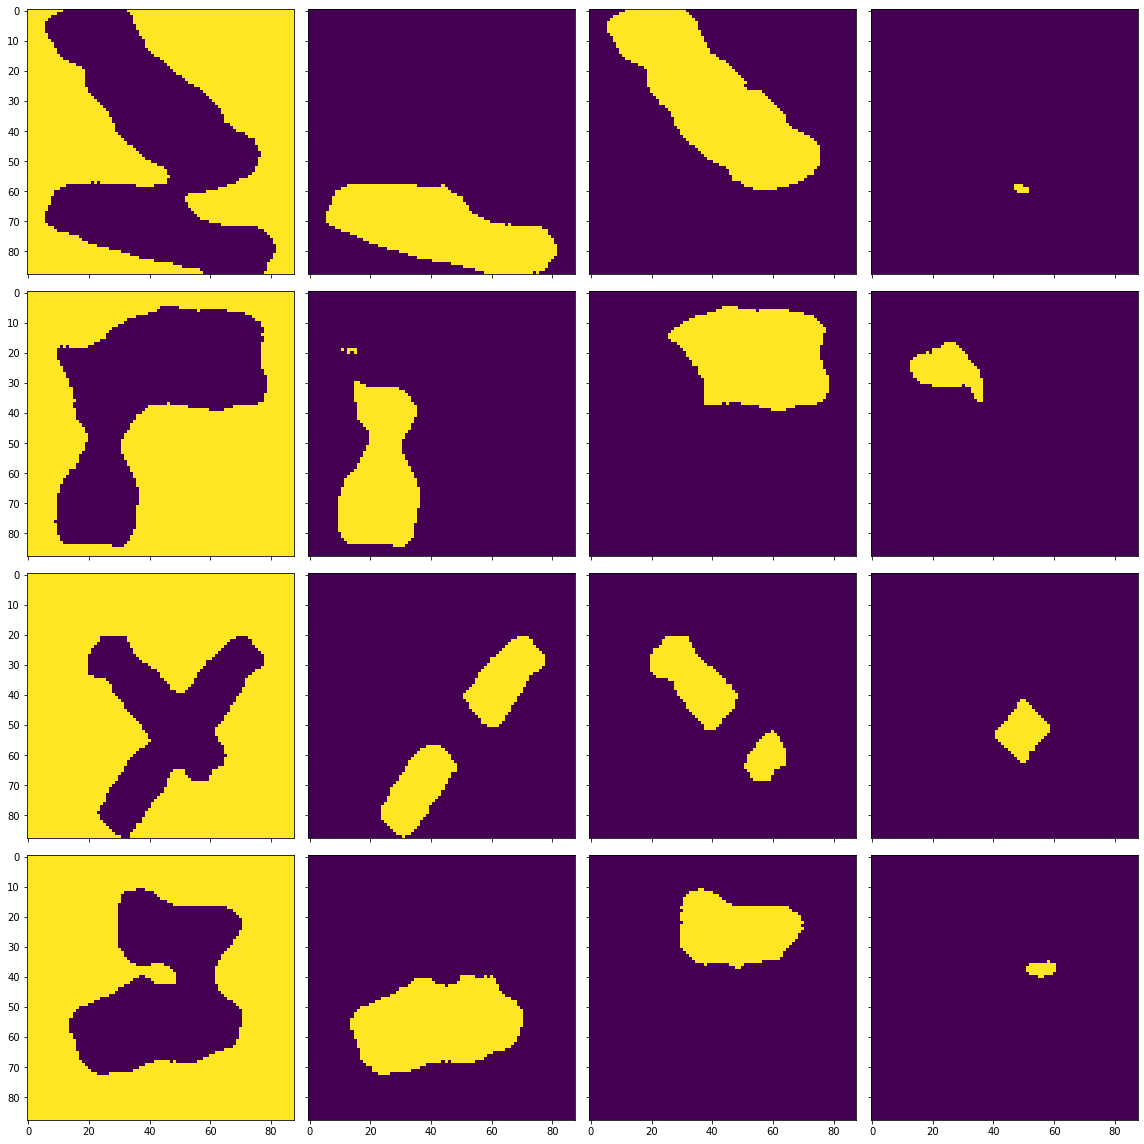

Training IOU: [0.9796222186578071, 0.9279838291602623, 0.9240860534525369, 0.8461751776837435]
Training accuracy: 0.9766306172520661
Testing IOU: [0.9751202181621367, 0.39293027488779037, 0.2836584585865046, 0.3452812659214194]
Testing accuracy: 0.8555707644628099
13/13 [==============================] - 1s 66ms/step - loss: 0.0085 - val_loss: 0.0580
INFO:tensorflow:Assets written to: modelunet/savedmodel_93epoch\assets
4
4


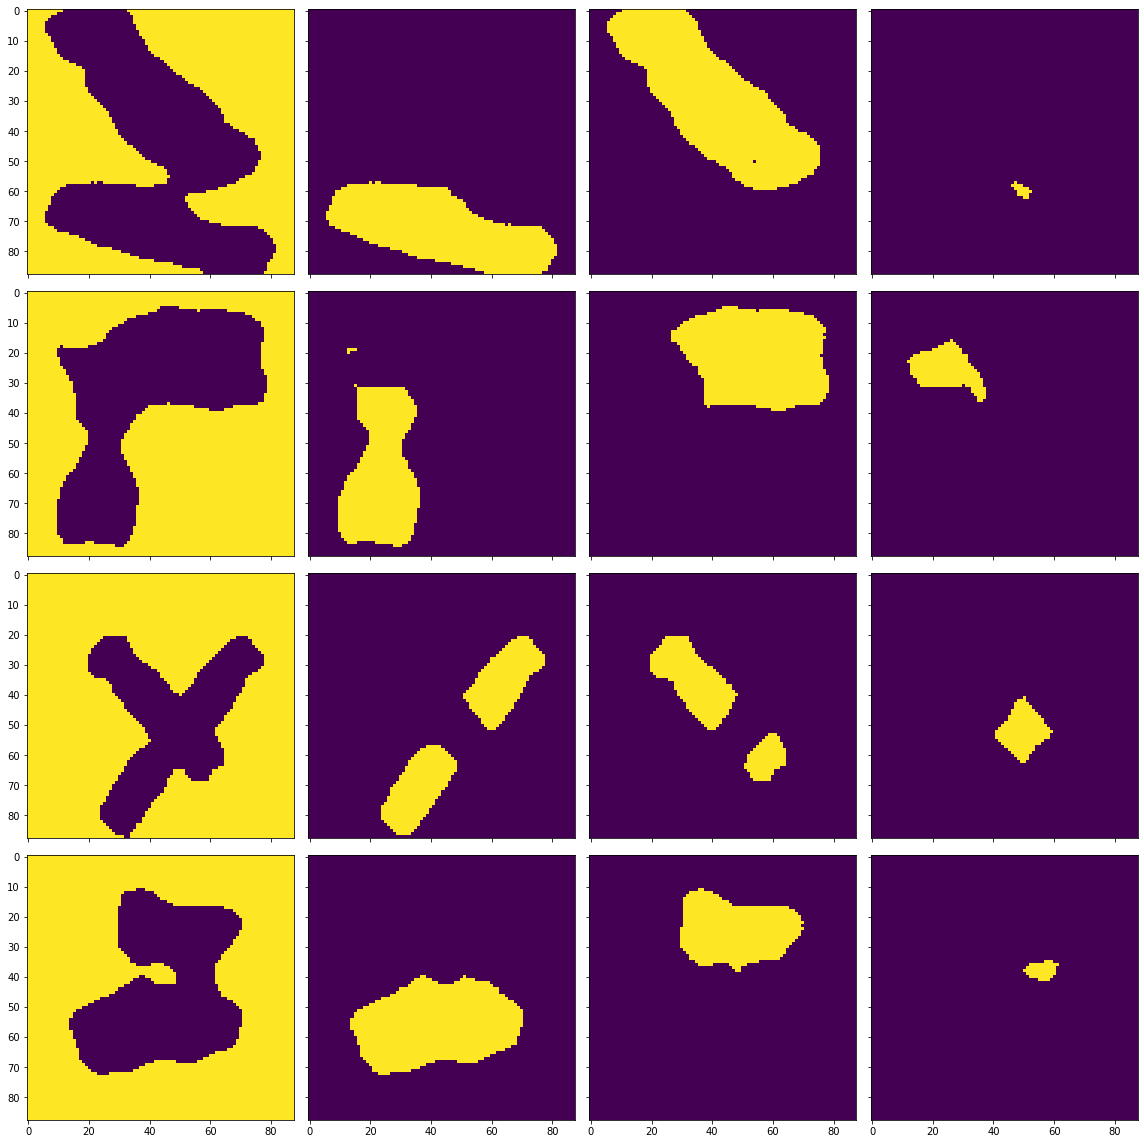

Training IOU: [0.9798016056919825, 0.9294173172333284, 0.928048263210649, 0.8614484657112784]
Training accuracy: 0.9784349173553719
Testing IOU: [0.9747285349378048, 0.3749692579033539, 0.29129556752278374, 0.3304210351139957]
Testing accuracy: 0.8542097107438017
13/13 [==============================] - 1s 66ms/step - loss: 0.0083 - val_loss: 0.0569
INFO:tensorflow:Assets written to: modelunet/savedmodel_94epoch\assets
4
4


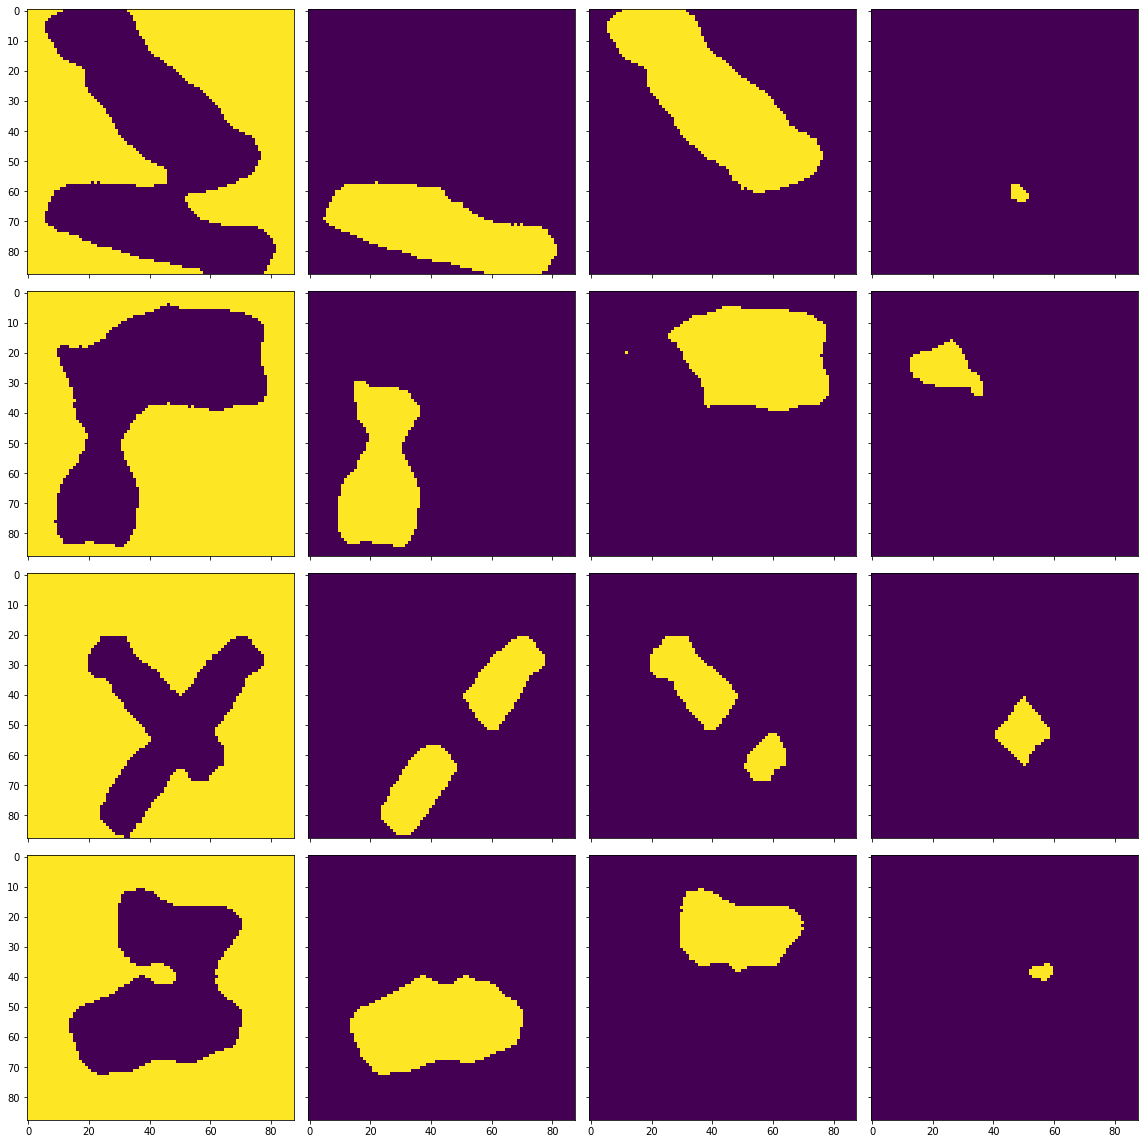

Training IOU: [0.9796649257092609, 0.9301779510037474, 0.9331563616612262, 0.85326765928687]
Training accuracy: 0.9791106017561984
Testing IOU: [0.9751444293759018, 0.3672493844276441, 0.3275172095780771, 0.34009493764189047]
Testing accuracy: 0.8571061466942149
13/13 [==============================] - 1s 67ms/step - loss: 0.0081 - val_loss: 0.0590
INFO:tensorflow:Assets written to: modelunet/savedmodel_95epoch\assets
4
4


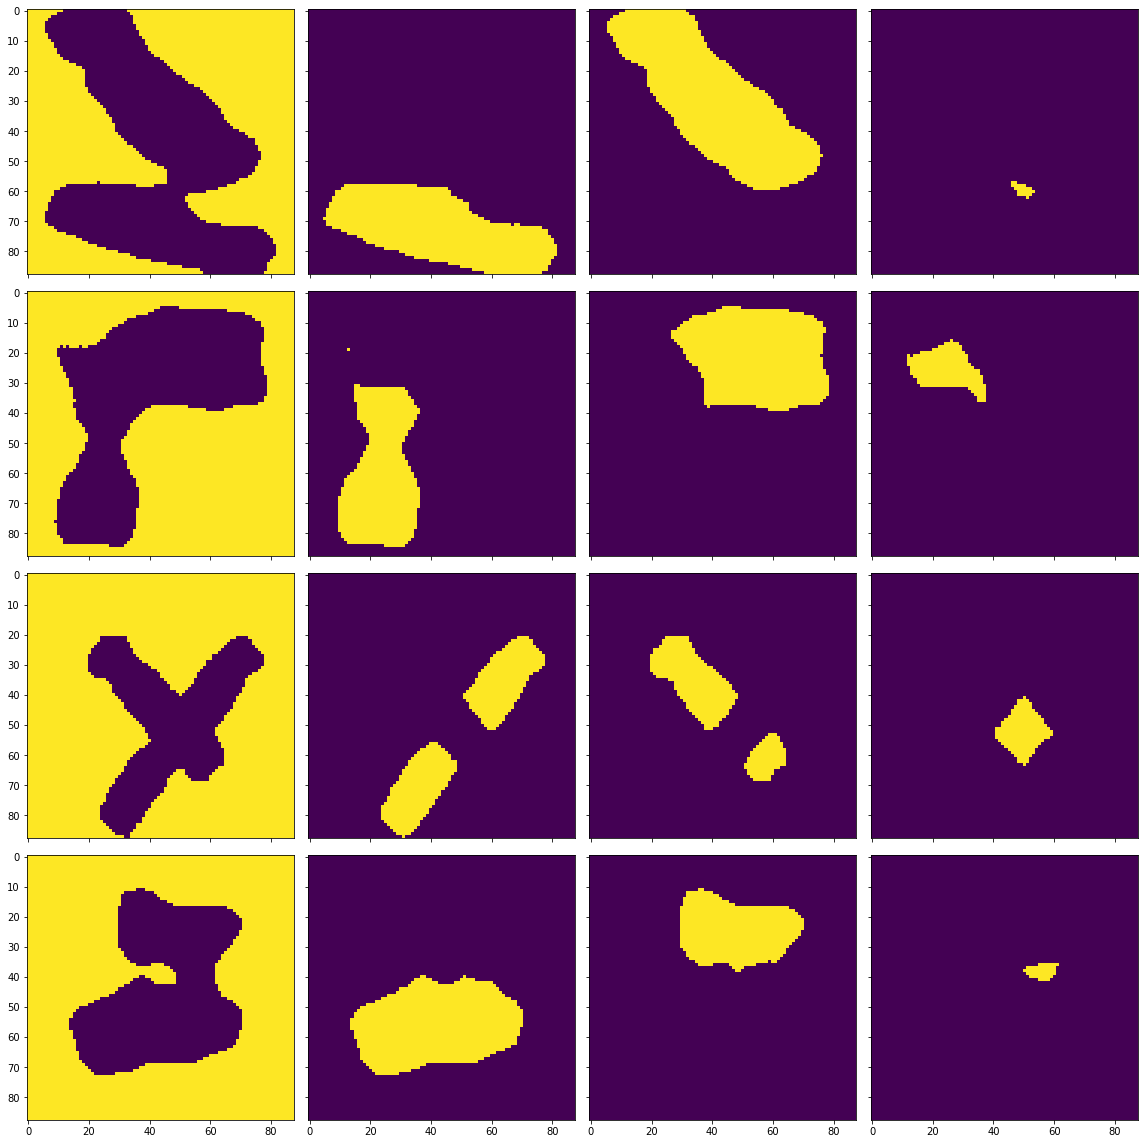

Training IOU: [0.9800085606673563, 0.9331098891110707, 0.9334358594479694, 0.8668408091644151]
Training accuracy: 0.9802702091942149
Testing IOU: [0.9749837703478179, 0.382194677665878, 0.29464161929848887, 0.3209805561363161]
Testing accuracy: 0.8558135330578512
13/13 [==============================] - 1s 66ms/step - loss: 0.0080 - val_loss: 0.0573
INFO:tensorflow:Assets written to: modelunet/savedmodel_96epoch\assets
4
4


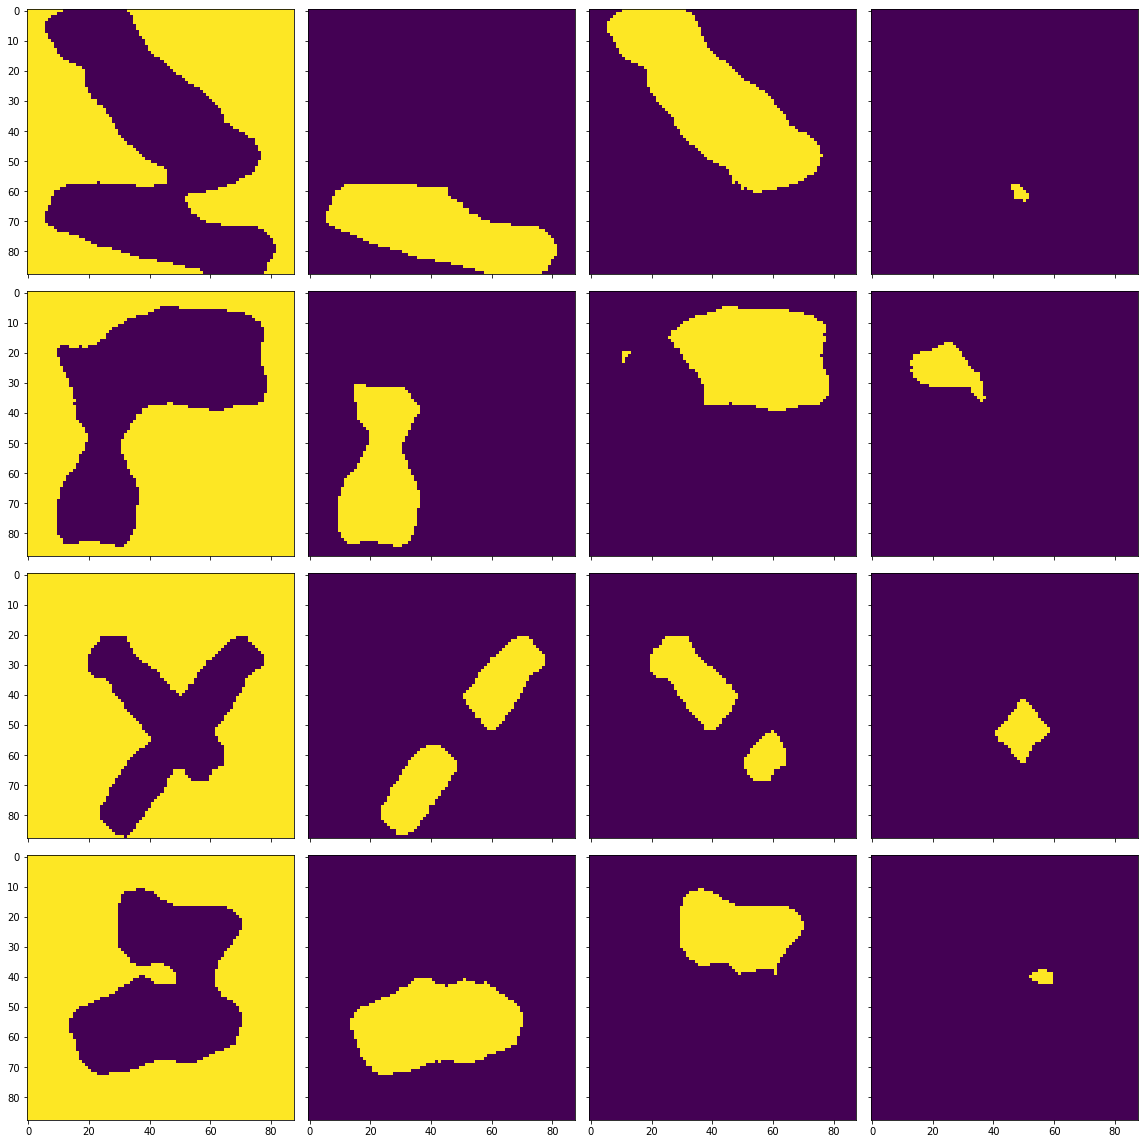

Training IOU: [0.9800917104872756, 0.9321912414257507, 0.9342063076446259, 0.8660427724170882]
Training accuracy: 0.9797162319214876
Testing IOU: [0.9749244838719746, 0.3770446255556822, 0.3136470529161192, 0.33741667641211553]
Testing accuracy: 0.8576717458677686
13/13 [==============================] - ETA: 0s - loss: 0.0079- ETA: 0s - loss:  - 1s 66ms/step - loss: 0.0079 - val_loss: 0.0578
INFO:tensorflow:Assets written to: modelunet/savedmodel_97epoch\assets
4
4


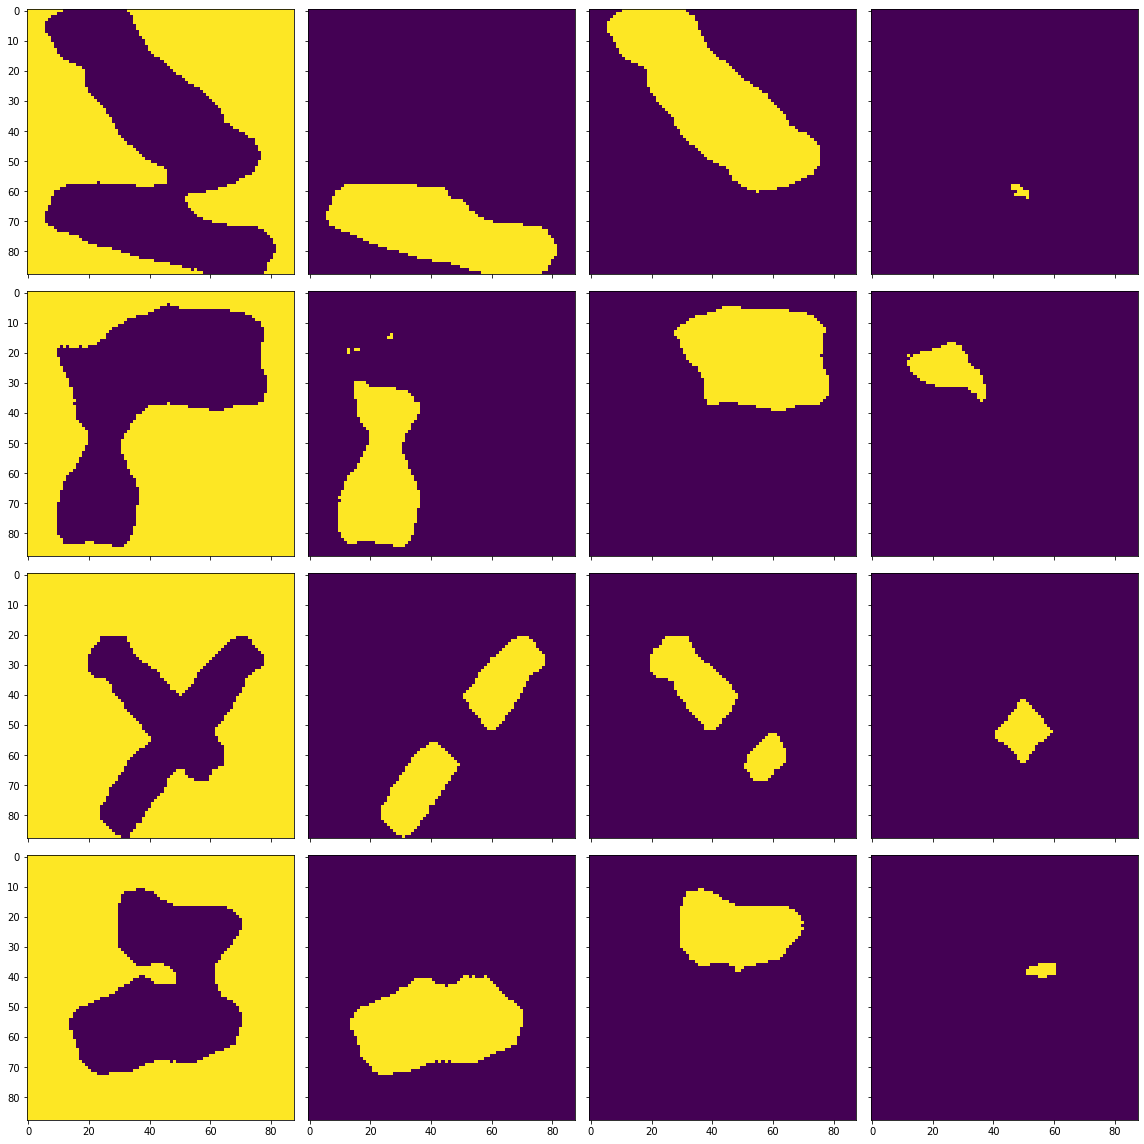

Training IOU: [0.9803486687959259, 0.9332052237700228, 0.934331927545365, 0.8710214808989694]
Training accuracy: 0.979545131714876
Testing IOU: [0.9748084324399293, 0.37462844262872436, 0.30162216676352943, 0.33012793476732744]
Testing accuracy: 0.8555100723140496
13/13 [==============================] - 1s 67ms/step - loss: 0.0079 - val_loss: 0.0563
INFO:tensorflow:Assets written to: modelunet/savedmodel_98epoch\assets
4
4


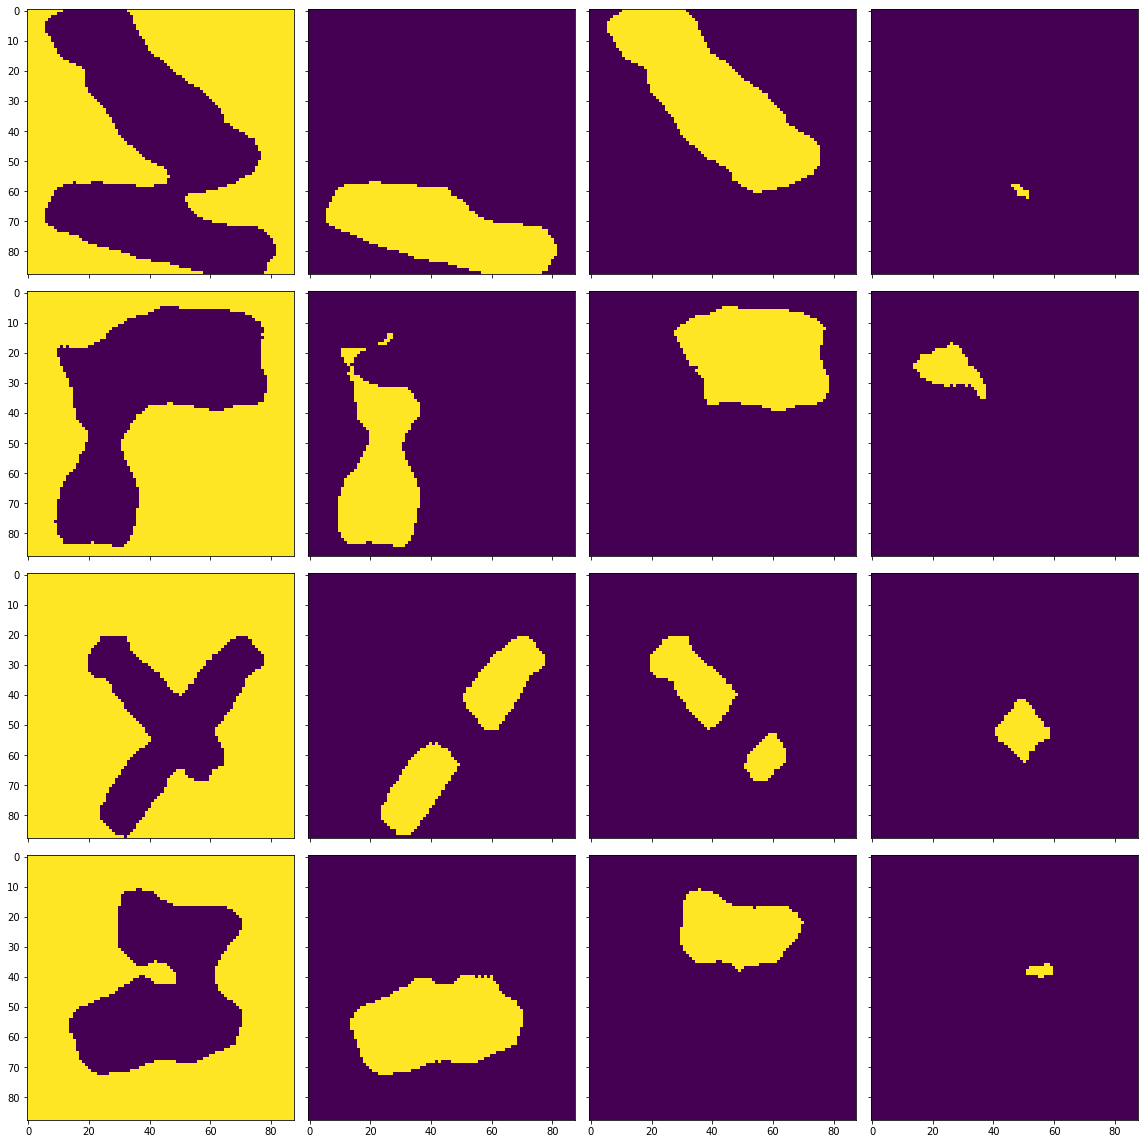

Training IOU: [0.9804774939390255, 0.9295963521193198, 0.9238854056873377, 0.8327943674655641]
Training accuracy: 0.9778247675619834
Testing IOU: [0.974809047796572, 0.4114331237907788, 0.2764431859700402, 0.35059507586081584]
Testing accuracy: 0.8593569214876033
13/13 [==============================] - 1s 67ms/step - loss: 0.0081 - val_loss: 0.0574
INFO:tensorflow:Assets written to: modelunet/savedmodel_99epoch\assets
4
4


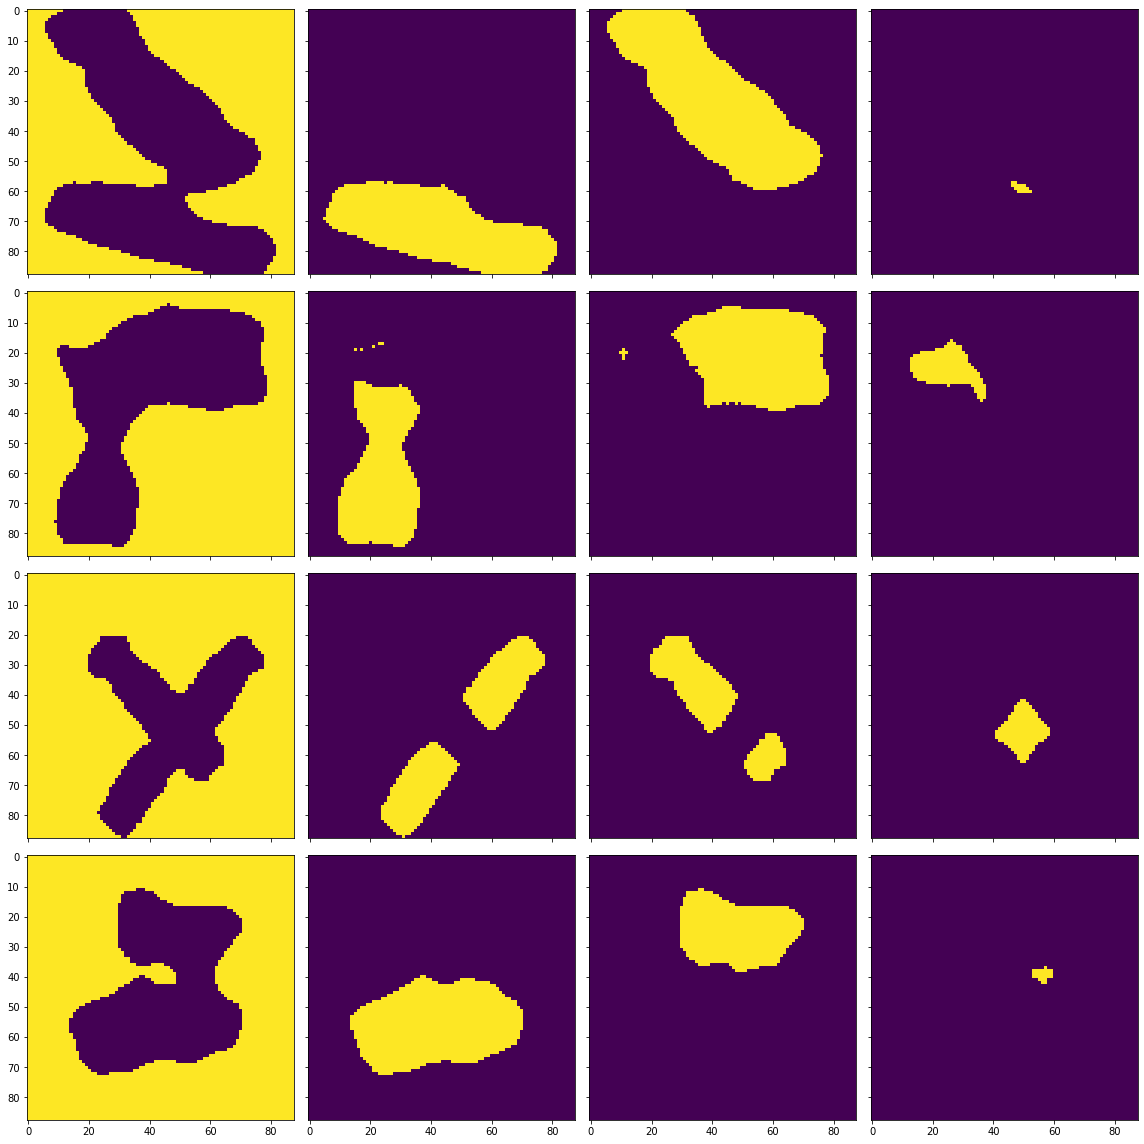

Training IOU: [0.9803401482054498, 0.9316135966680102, 0.9333429612156806, 0.8443704784804544]
Training accuracy: 0.979894757231405
Testing IOU: [0.9748966255021109, 0.39429456898670234, 0.30602674201867347, 0.3526250651380928]
Testing accuracy: 0.8599018595041322
13/13 [==============================] - 1s 67ms/step - loss: 0.0080 - val_loss: 0.0581
INFO:tensorflow:Assets written to: modelunet/savedmodel_100epoch\assets
4
4


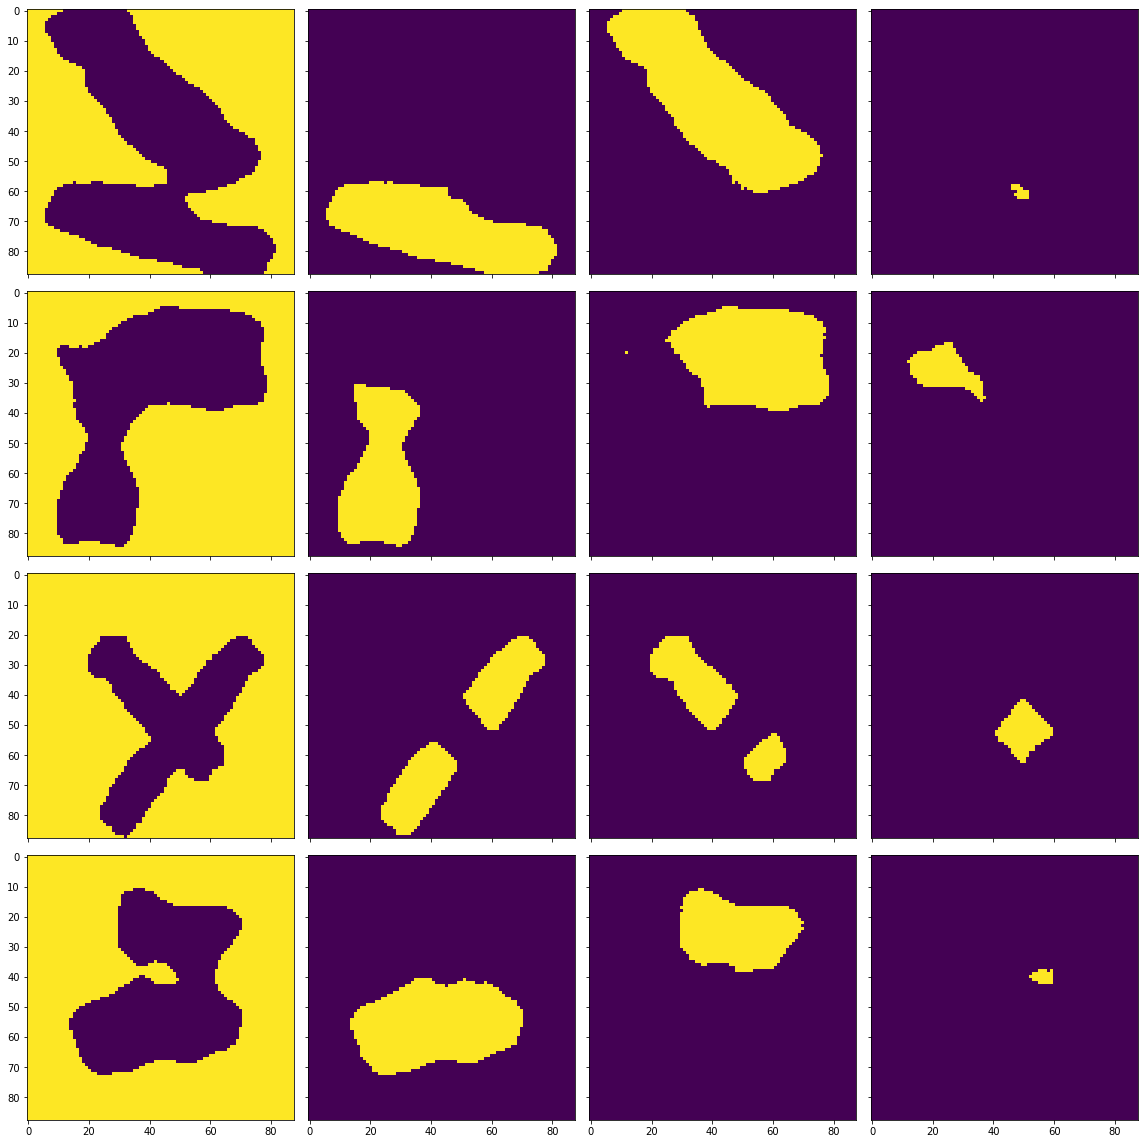

Training IOU: [0.9807032356100454, 0.9350882298112642, 0.9356289838870914, 0.8702555449389091]
Training accuracy: 0.9808019111570248
Testing IOU: [0.9748906876833073, 0.3905992111226117, 0.3070368738063758, 0.34477733247386566]
Testing accuracy: 0.8597172004132232
13/13 [==============================] - 1s 67ms/step - loss: 0.0077 - val_loss: 0.0581: 0s - loss: 0.007
INFO:tensorflow:Assets written to: modelunet/savedmodel_101epoch\assets
4
4


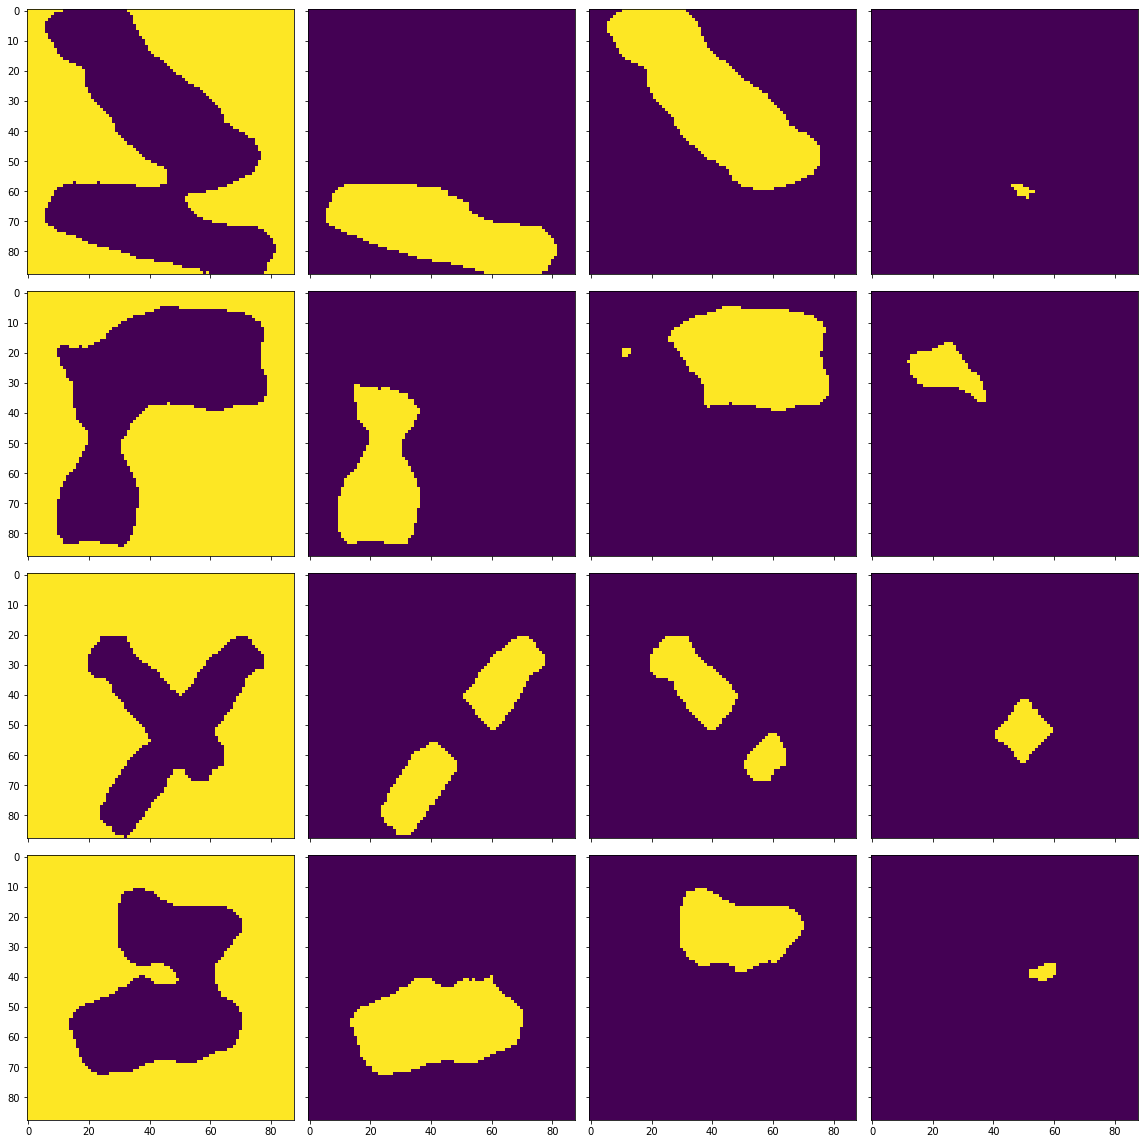

Training IOU: [0.980846364006278, 0.932368057879848, 0.937353986454771, 0.8647842897842898]
Training accuracy: 0.97970267303719
Testing IOU: [0.9747569145837379, 0.3545979133633079, 0.31272543763857175, 0.3252379118763408]
Testing accuracy: 0.8532993285123966
13/13 [==============================] - 1s 67ms/step - loss: 0.0077 - val_loss: 0.0588
INFO:tensorflow:Assets written to: modelunet/savedmodel_102epoch\assets
4
4


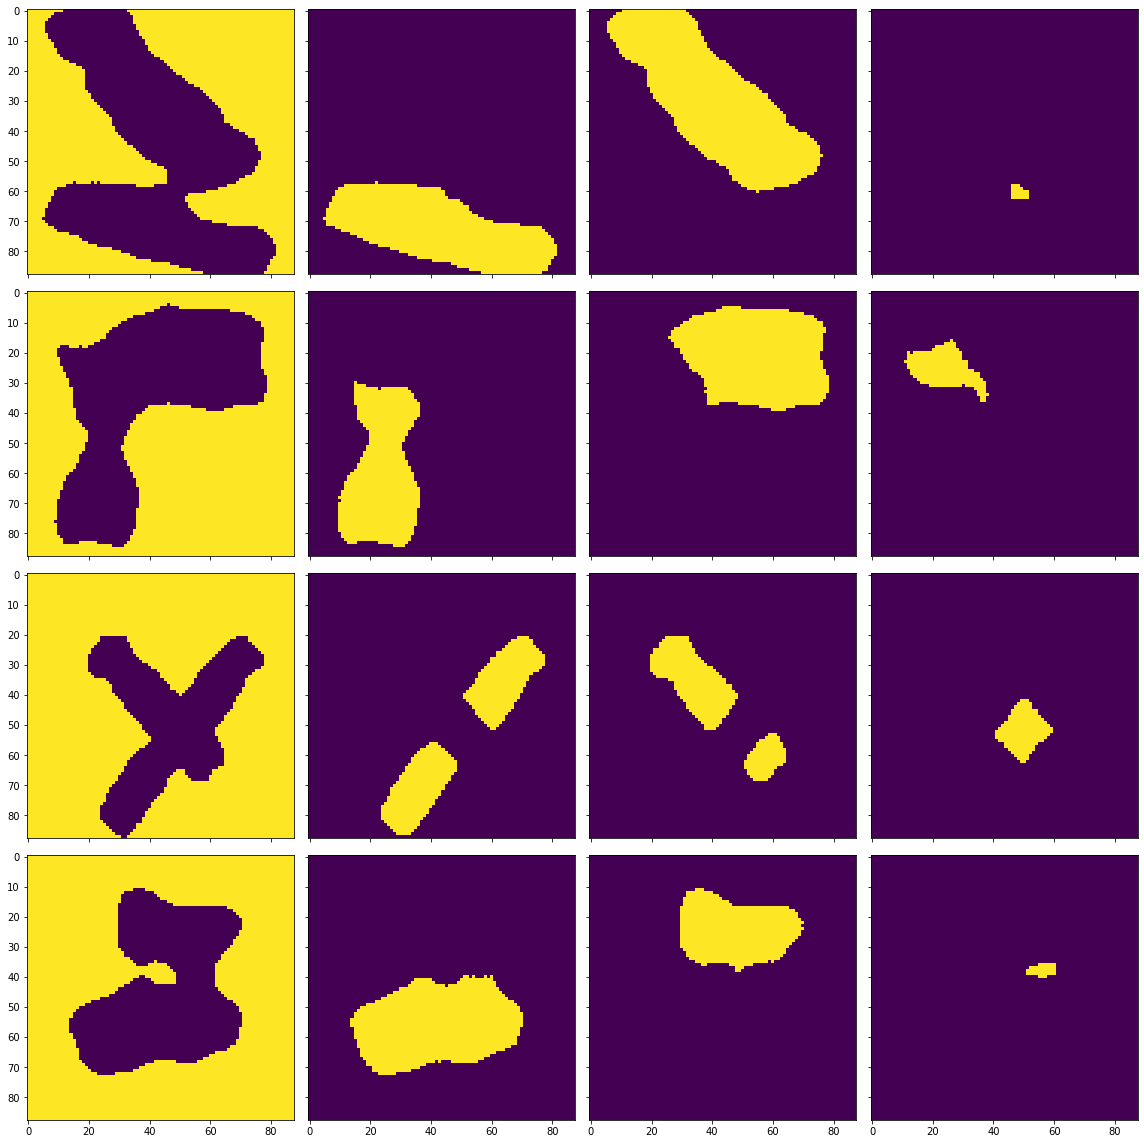

Training IOU: [0.9808533826257617, 0.9352183012920734, 0.9363687988308846, 0.8711705187777845]
Training accuracy: 0.9800468104338843
Testing IOU: [0.9747151571950469, 0.38045391253949296, 0.304274591361441, 0.32351231370891026]
Testing accuracy: 0.8562784090909091
13/13 [==============================] - 1s 66ms/step - loss: 0.0076 - val_loss: 0.0568
INFO:tensorflow:Assets written to: modelunet/savedmodel_103epoch\assets
4
4


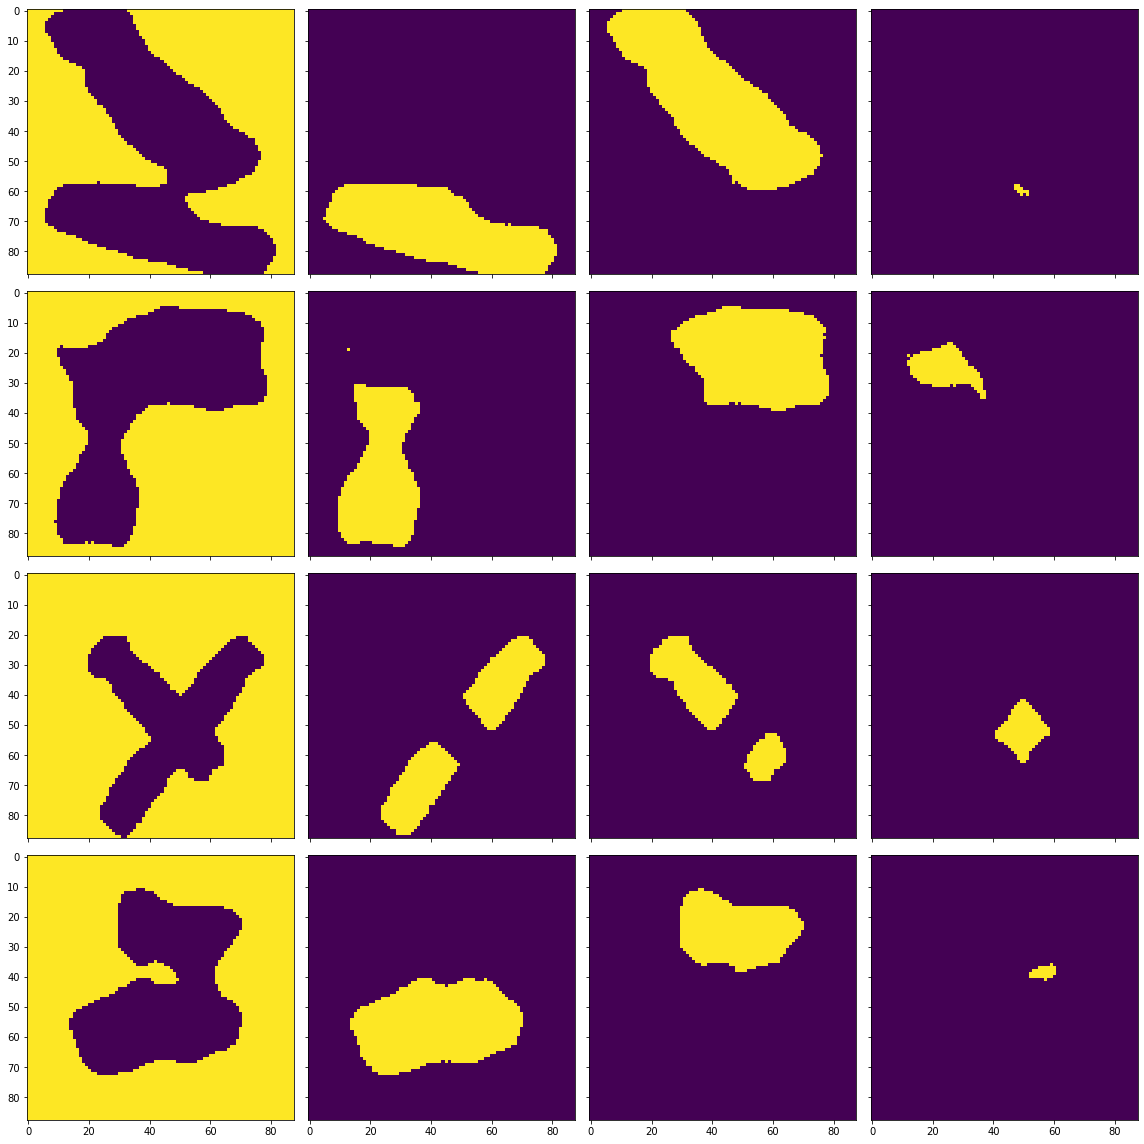

Training IOU: [0.9811711925284143, 0.9368844116306957, 0.9382618720419453, 0.8745057210163217]
Training accuracy: 0.9806140237603306
Testing IOU: [0.9746435248292631, 0.3939662821650399, 0.29103137835305243, 0.3386062419837537]
Testing accuracy: 0.8574857954545455
13/13 [==============================] - 1s 66ms/step - loss: 0.0075 - val_loss: 0.0591
INFO:tensorflow:Assets written to: modelunet/savedmodel_104epoch\assets
4
4


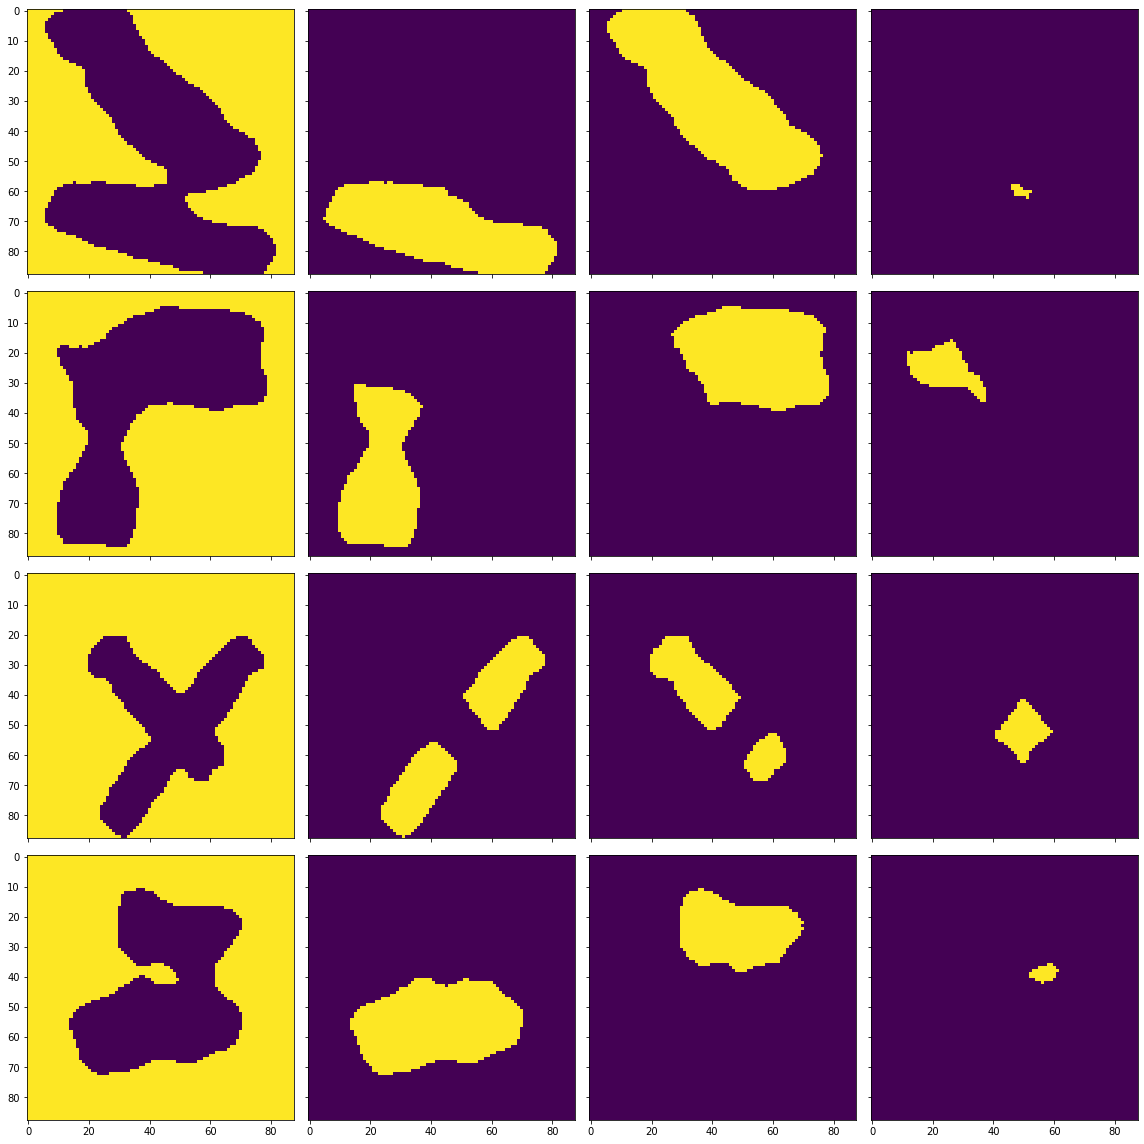

Training IOU: [0.9813649945663753, 0.9391045999385309, 0.9401937378375541, 0.884854642723842]
Training accuracy: 0.9813265108471074
Testing IOU: [0.9745781527531083, 0.37635637179307446, 0.2978732468771834, 0.33565608316942963]
Testing accuracy: 0.8554390495867769
13/13 [==============================] - ETA: 0s - loss: 0.007 - ETA: 0s - loss: 0.007 - 1s 67ms/step - loss: 0.0073 - val_loss: 0.0582
INFO:tensorflow:Assets written to: modelunet/savedmodel_105epoch\assets
4
4


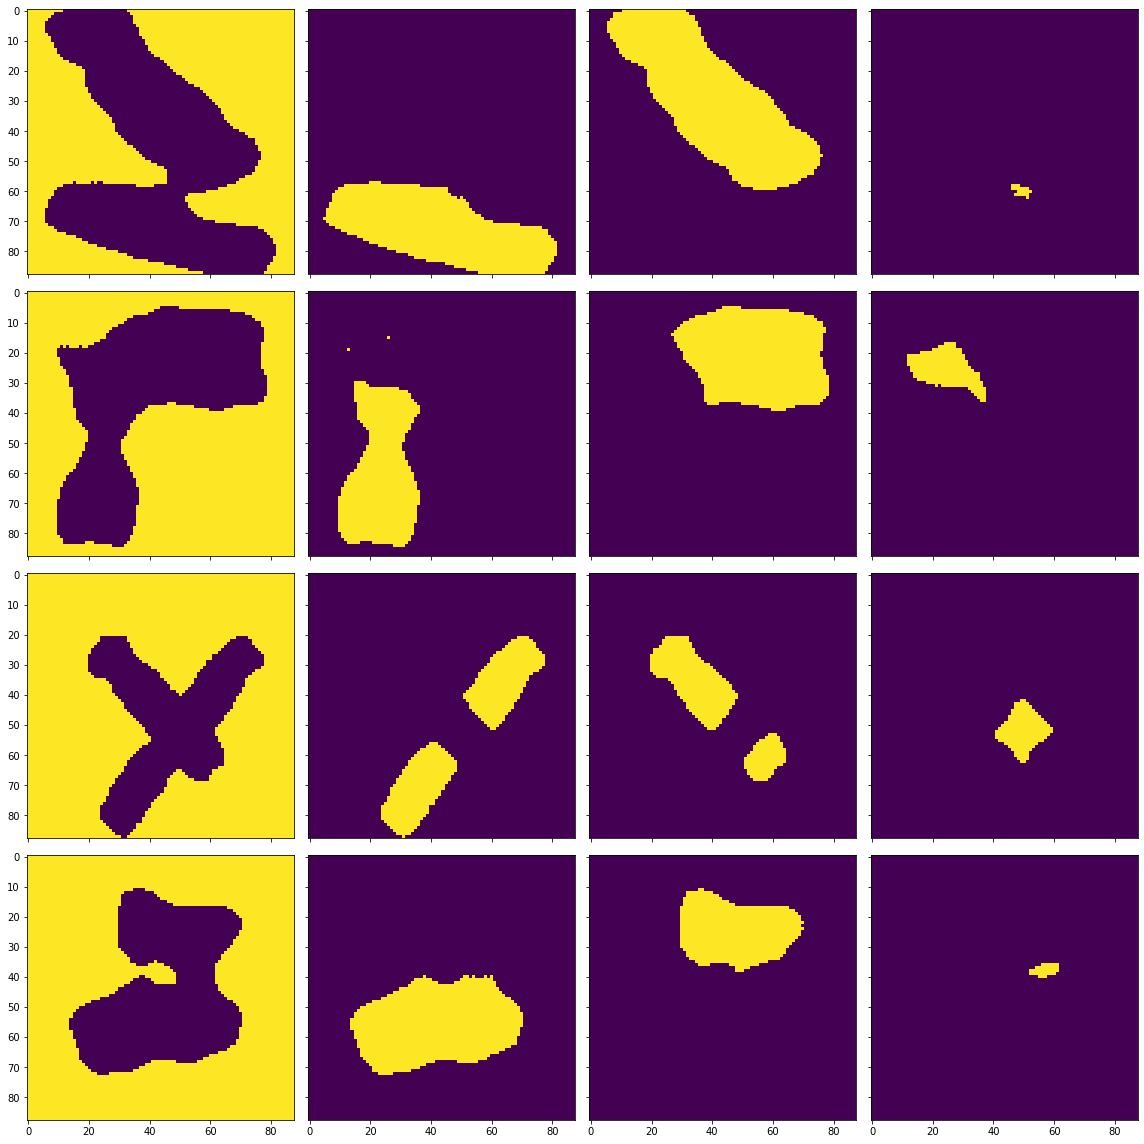

Training IOU: [0.9815506082659721, 0.9414658230209706, 0.9423364287195117, 0.8950255958375294]
Training accuracy: 0.9820864540289256
Testing IOU: [0.9746547815423255, 0.3837475235480171, 0.2975496216643334, 0.3388659167799208]
Testing accuracy: 0.8567587809917355
13/13 [==============================] - ETA: 0s - loss: 0.007 - 1s 66ms/step - loss: 0.0071 - val_loss: 0.0589
INFO:tensorflow:Assets written to: modelunet/savedmodel_106epoch\assets
4
4


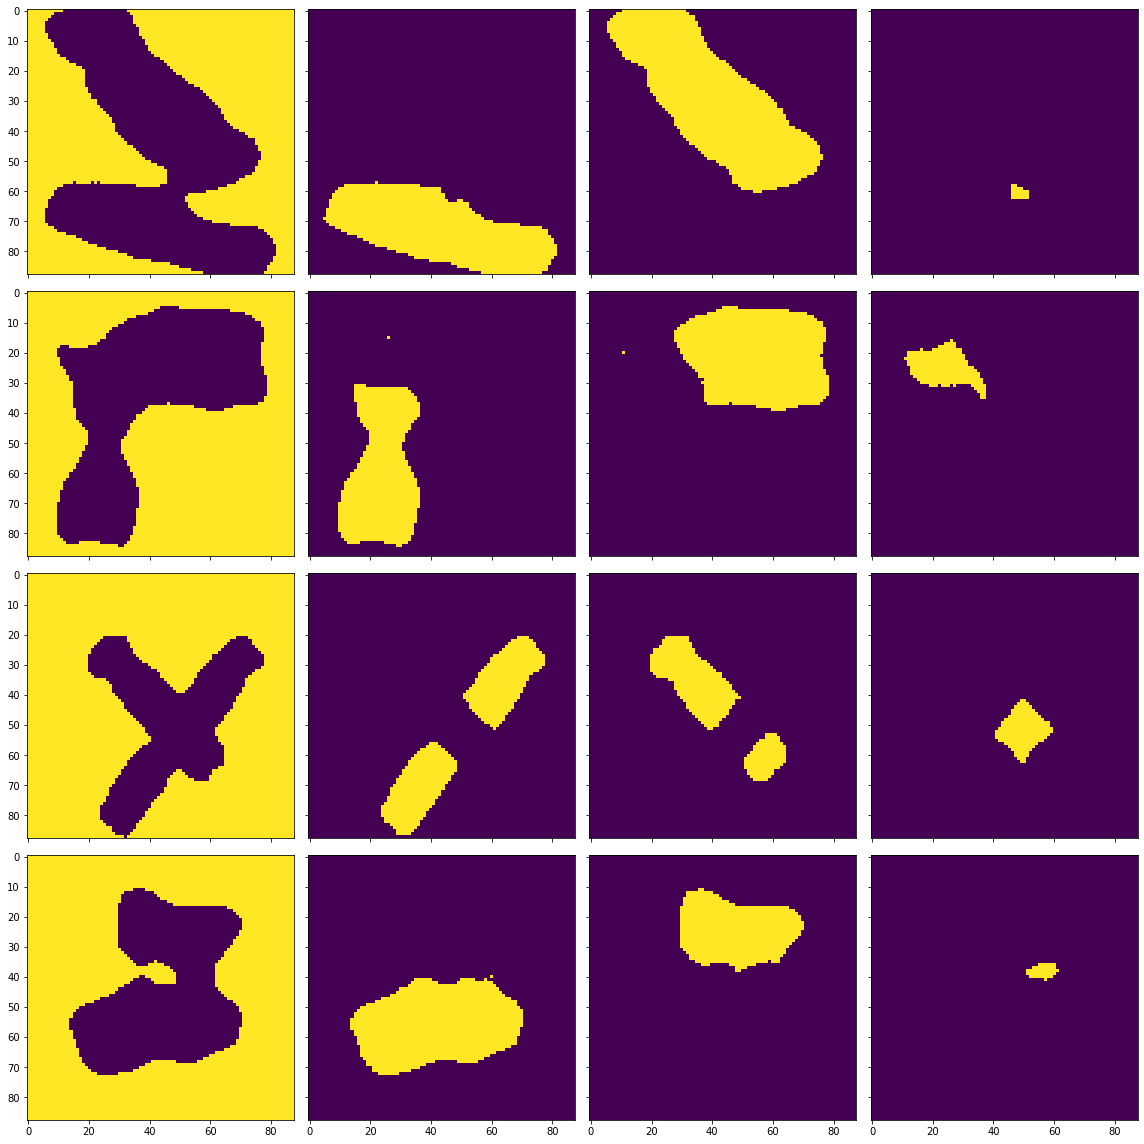

Training IOU: [0.9816879718478916, 0.9413948063531268, 0.9432369584795086, 0.8944119927629879]
Training accuracy: 0.9822239798553719
Testing IOU: [0.9744373104645255, 0.3766645215583387, 0.30577573541972736, 0.32963906351615]
Testing accuracy: 0.8564346590909091
13/13 [==============================] - 1s 67ms/step - loss: 0.0071 - val_loss: 0.0581
INFO:tensorflow:Assets written to: modelunet/savedmodel_107epoch\assets
4
4


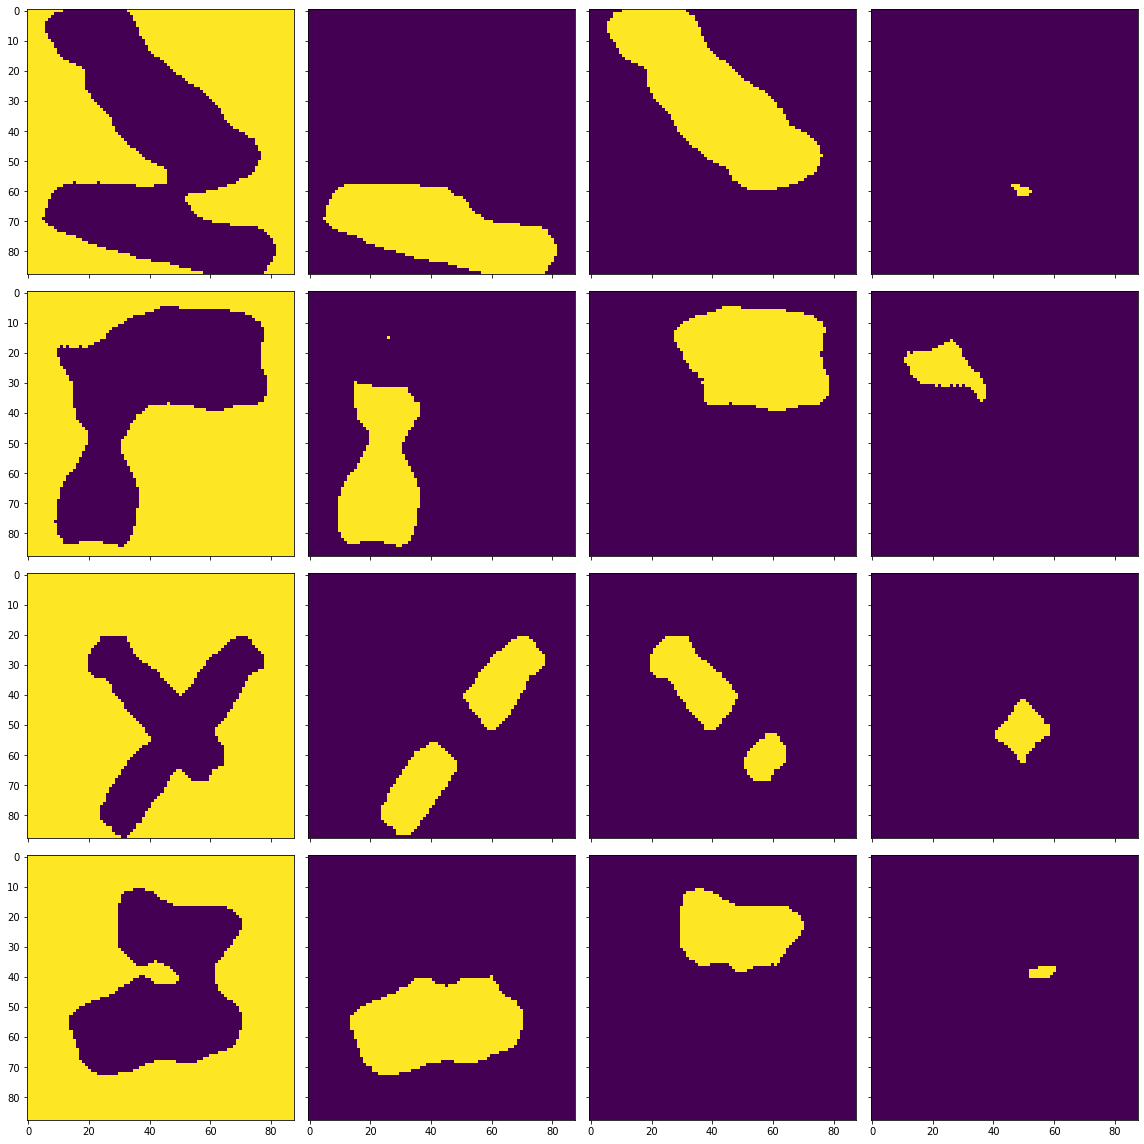

Training IOU: [0.9817840763438052, 0.942168259240102, 0.9435802412856411, 0.8940546603040916]
Training accuracy: 0.9824167097107438
Testing IOU: [0.9746351976760934, 0.3881778259540287, 0.30435901174008867, 0.3380367563801063]
Testing accuracy: 0.85828125
13/13 [==============================] - 1s 67ms/step - loss: 0.0071 - val_loss: 0.0584- ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_108epoch\assets
4
4


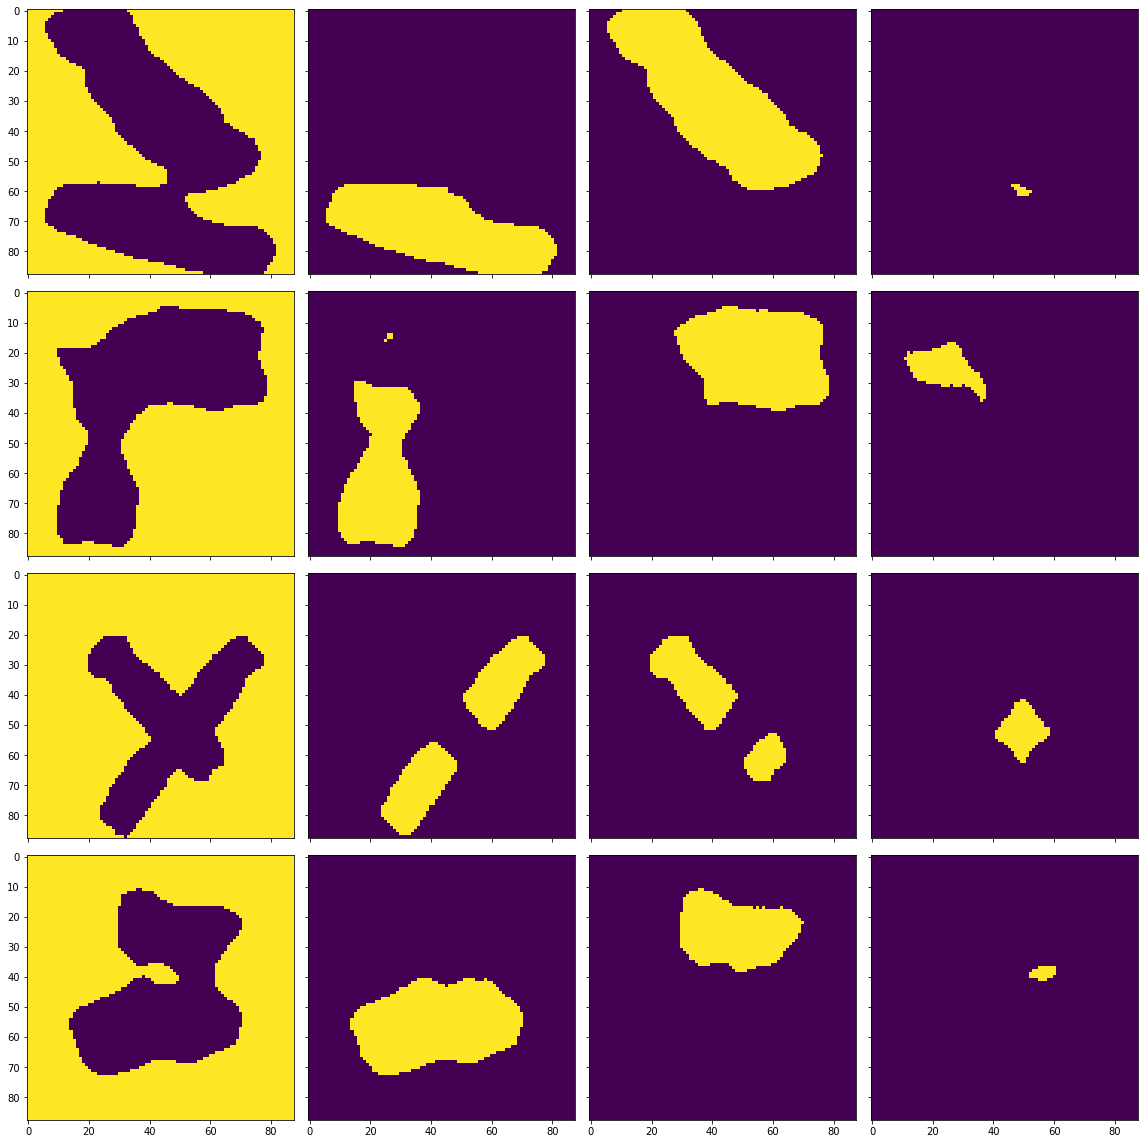

Training IOU: [0.9822258756580545, 0.9406788154897494, 0.9378583945011365, 0.8831535802264682]
Training accuracy: 0.9814814695247934
Testing IOU: [0.974256115536572, 0.39931962545175775, 0.28106760102612693, 0.3343776859733274]
Testing accuracy: 0.8578538223140496
13/13 [==============================] - 1s 66ms/step - loss: 0.0072 - val_loss: 0.0575
INFO:tensorflow:Assets written to: modelunet/savedmodel_109epoch\assets
4
4


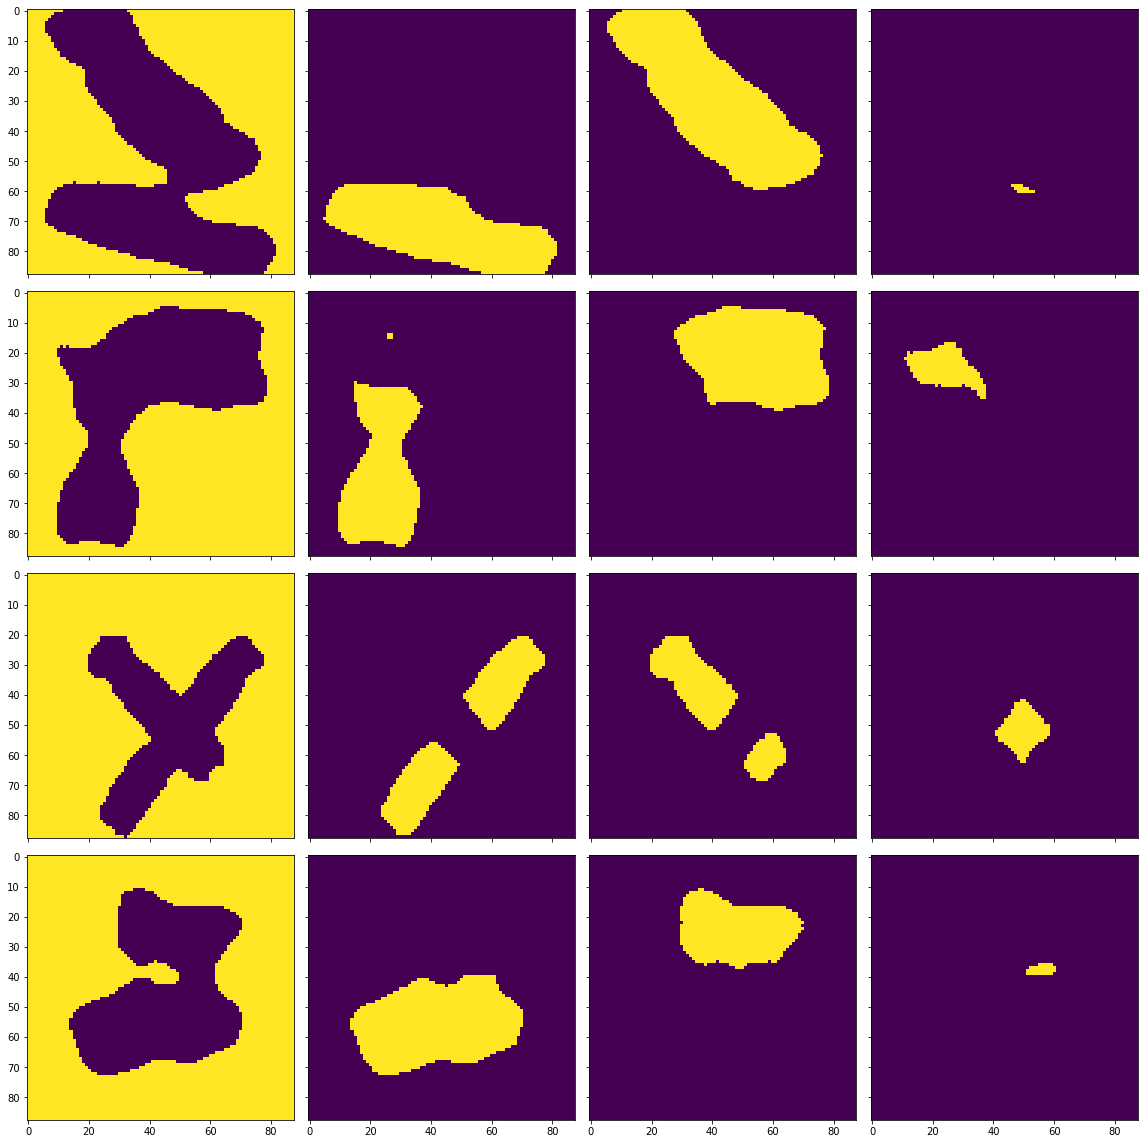

Training IOU: [0.9822659001315823, 0.9409477184345759, 0.9359252121011127, 0.8799666892208401]
Training accuracy: 0.981095686983471
Testing IOU: [0.9740215205723579, 0.40251285286655836, 0.27456178316381735, 0.3472276366689657]
Testing accuracy: 0.8579571280991736
13/13 [==============================] - 1s 67ms/step - loss: 0.0072 - val_loss: 0.0585 ETA: 0s - loss: 0
INFO:tensorflow:Assets written to: modelunet/savedmodel_110epoch\assets
4
4


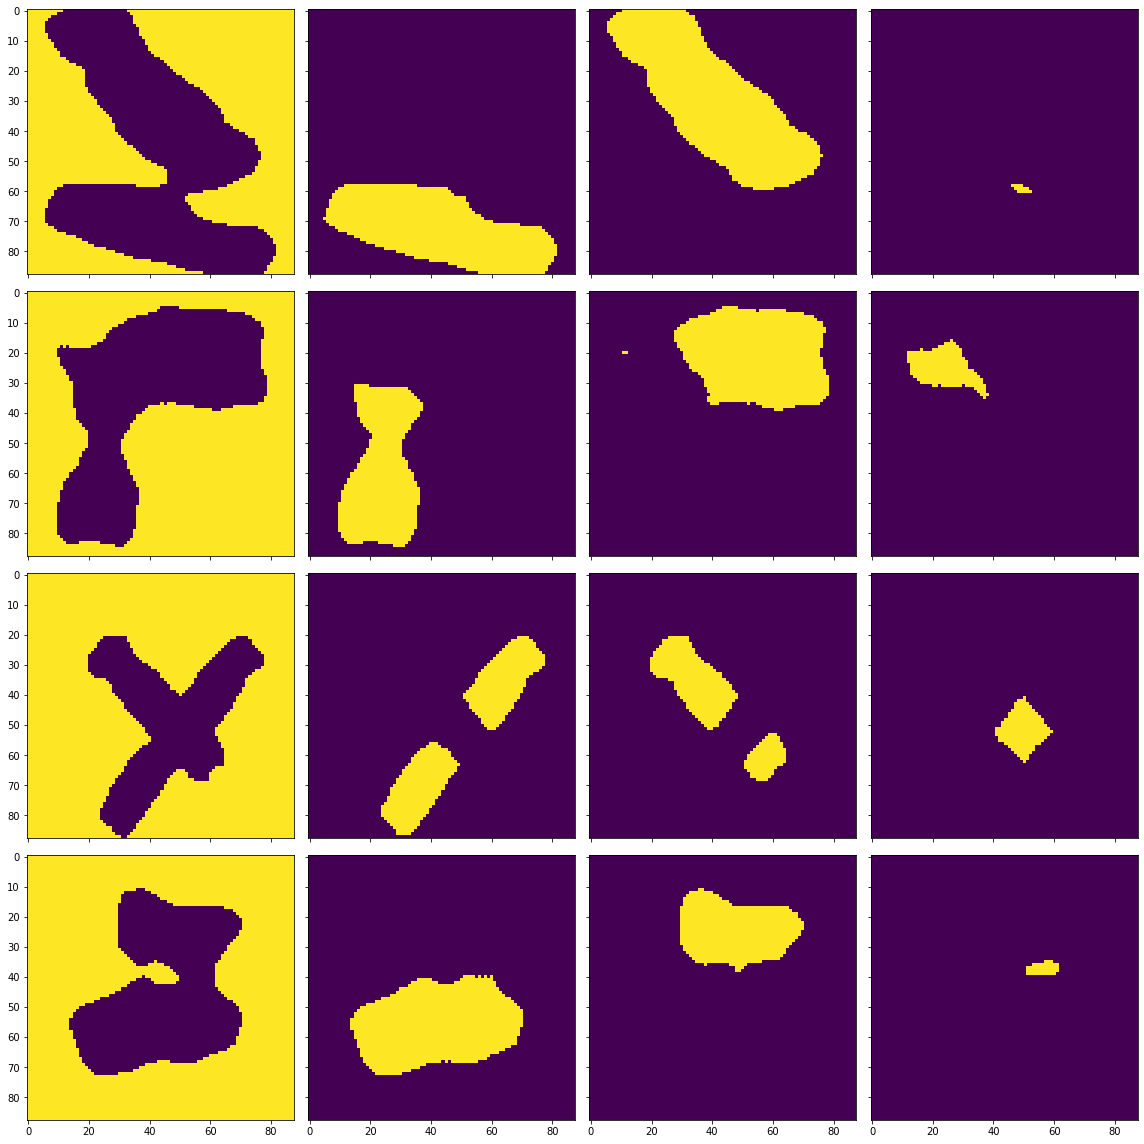

Training IOU: [0.9824075816840347, 0.9408904711813499, 0.9373524767625466, 0.8797035347776511]
Training accuracy: 0.9820186596074381
Testing IOU: [0.97390076127107, 0.3934882893241893, 0.2883166821765315, 0.3420326077479729]
Testing accuracy: 0.8583948863636364
13/13 [==============================] - 1s 67ms/step - loss: 0.0072 - val_loss: 0.0573
INFO:tensorflow:Assets written to: modelunet/savedmodel_111epoch\assets
4
4


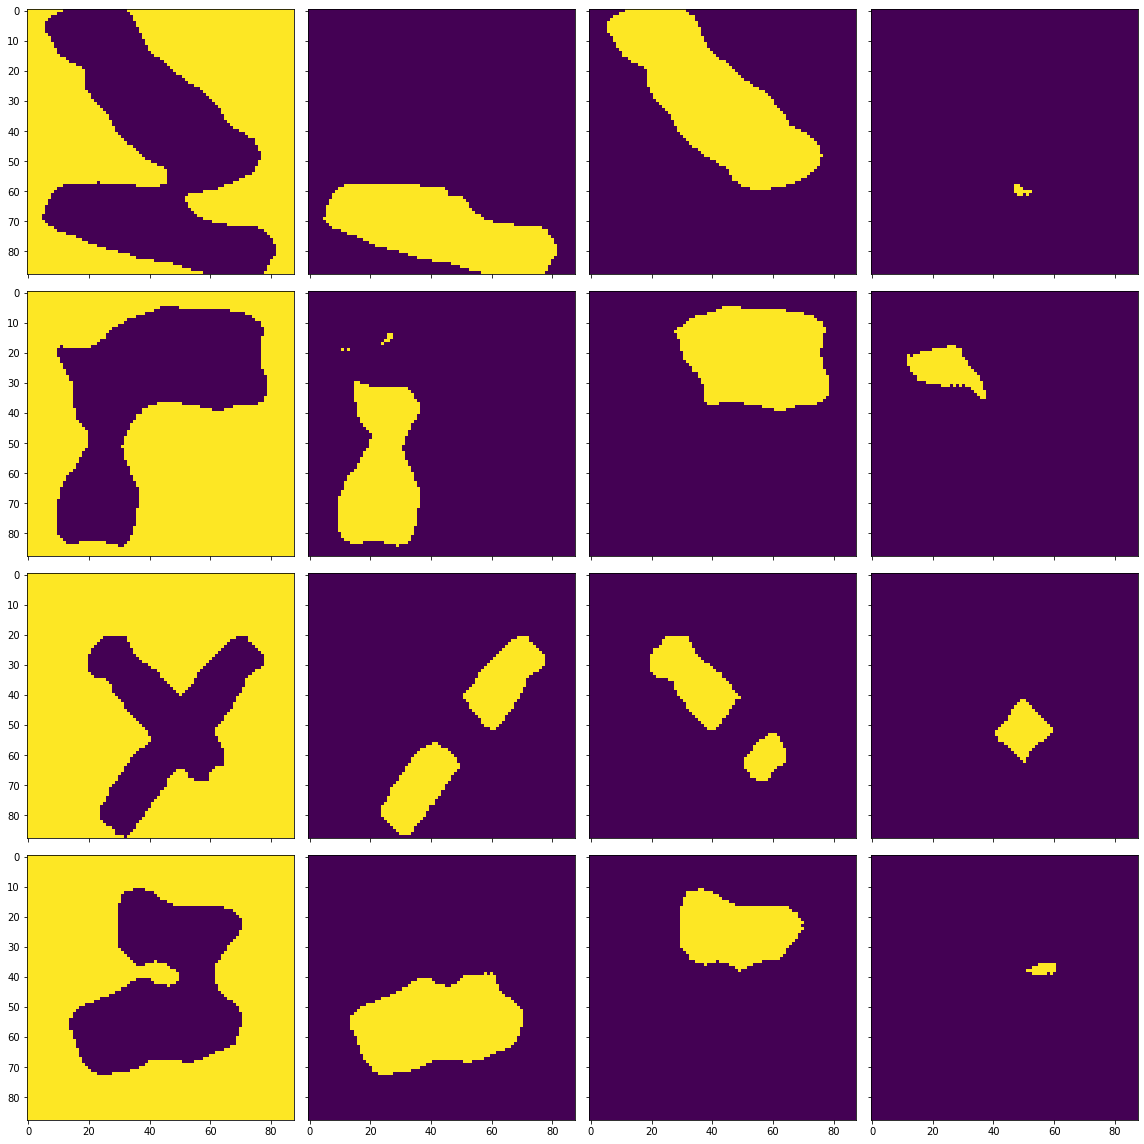

Training IOU: [0.9824602839116013, 0.941439490968427, 0.9415292960062541, 0.8678636121470431]
Training accuracy: 0.9814553202479339
Testing IOU: [0.9740681471013062, 0.38228229479062537, 0.3048568693397945, 0.35396143535415525]
Testing accuracy: 0.8580010330578512
13/13 [==============================] - 1s 67ms/step - loss: 0.0070 - val_loss: 0.0599
INFO:tensorflow:Assets written to: modelunet/savedmodel_112epoch\assets
4
4


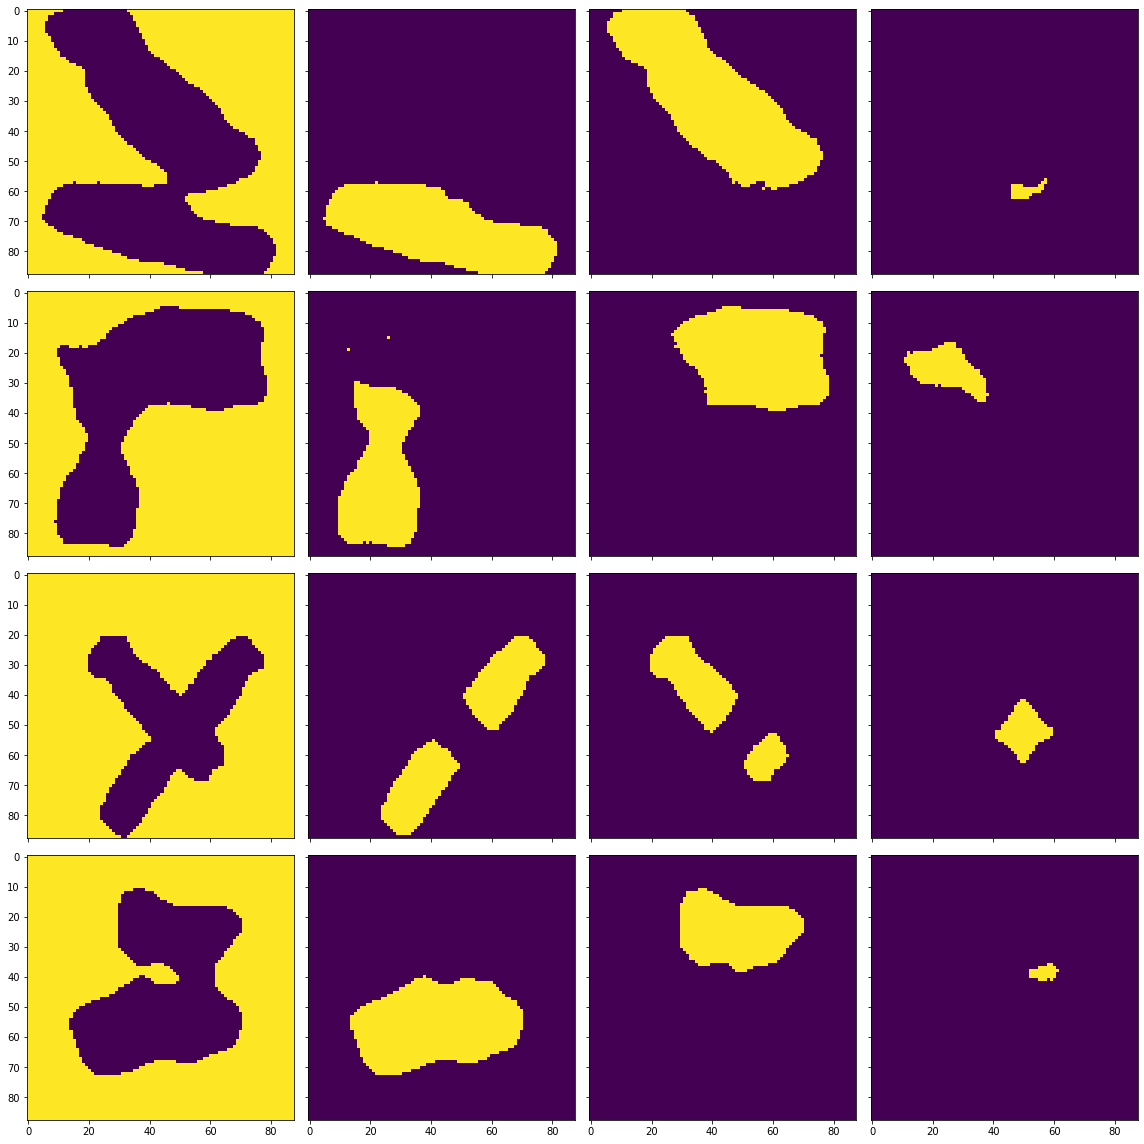

Training IOU: [0.98188145147646, 0.9419306999869279, 0.9451184780893753, 0.897041444654075]
Training accuracy: 0.9832731792355371
Testing IOU: [0.9743001289076209, 0.3857040585935349, 0.30323800117497807, 0.3363833441256792]
Testing accuracy: 0.8579648760330578
13/13 [==============================] - 1s 66ms/step - loss: 0.0069 - val_loss: 0.0605
INFO:tensorflow:Assets written to: modelunet/savedmodel_113epoch\assets
4
4


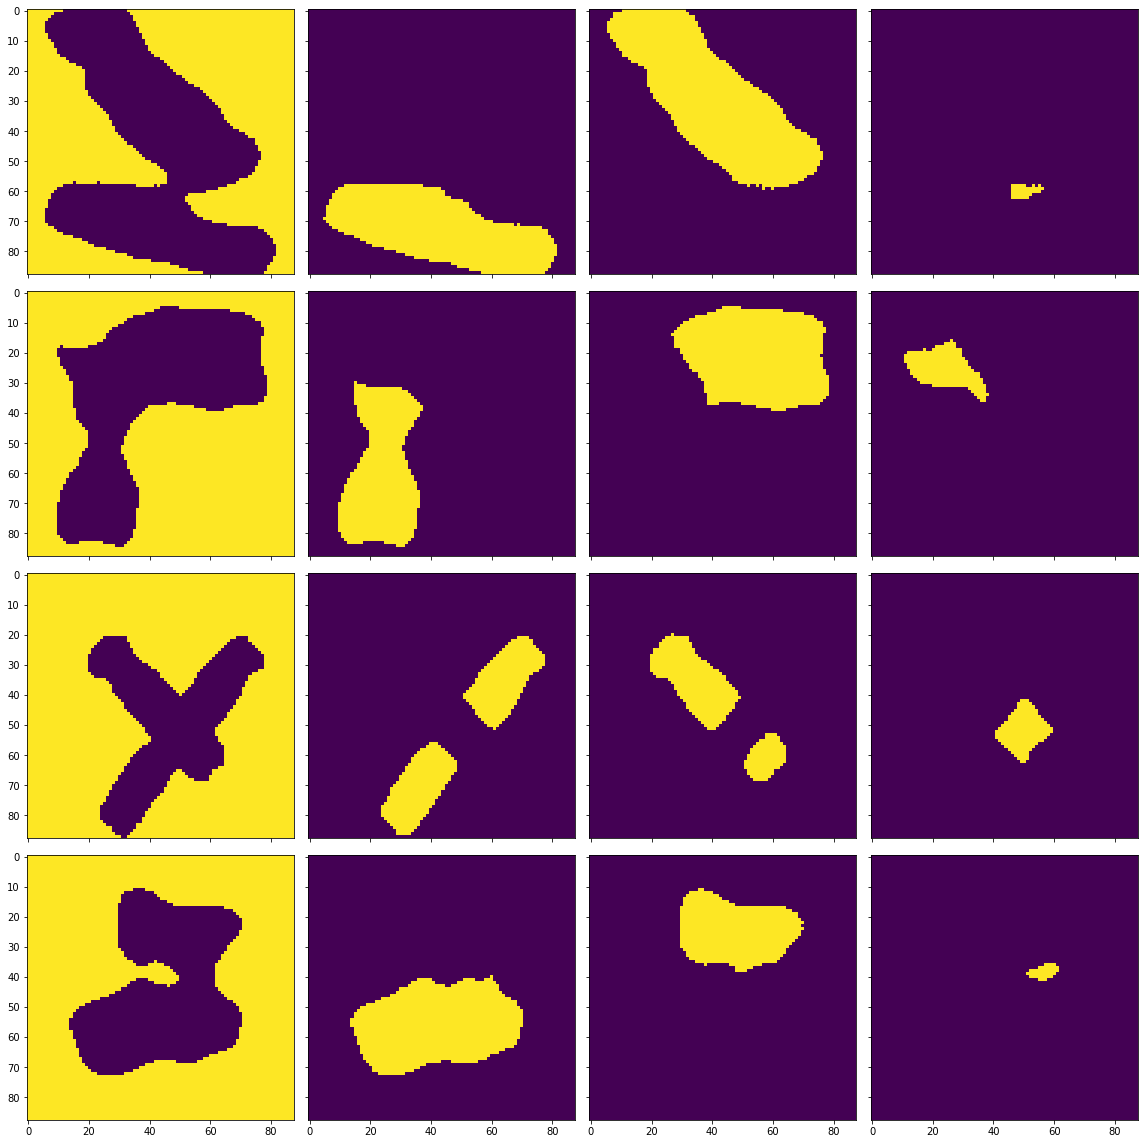

Training IOU: [0.9827755682722275, 0.944236261853079, 0.94615314655011, 0.8887133757961784]
Training accuracy: 0.9835830965909091
Testing IOU: [0.9740158832293009, 0.37419255073136104, 0.30783365081505704, 0.3291455934574411]
Testing accuracy: 0.8569137396694215
13/13 [==============================] - 1s 66ms/step - loss: 0.0067 - val_loss: 0.0592 ETA: 0s - loss: 0.00
INFO:tensorflow:Assets written to: modelunet/savedmodel_114epoch\assets
4
4


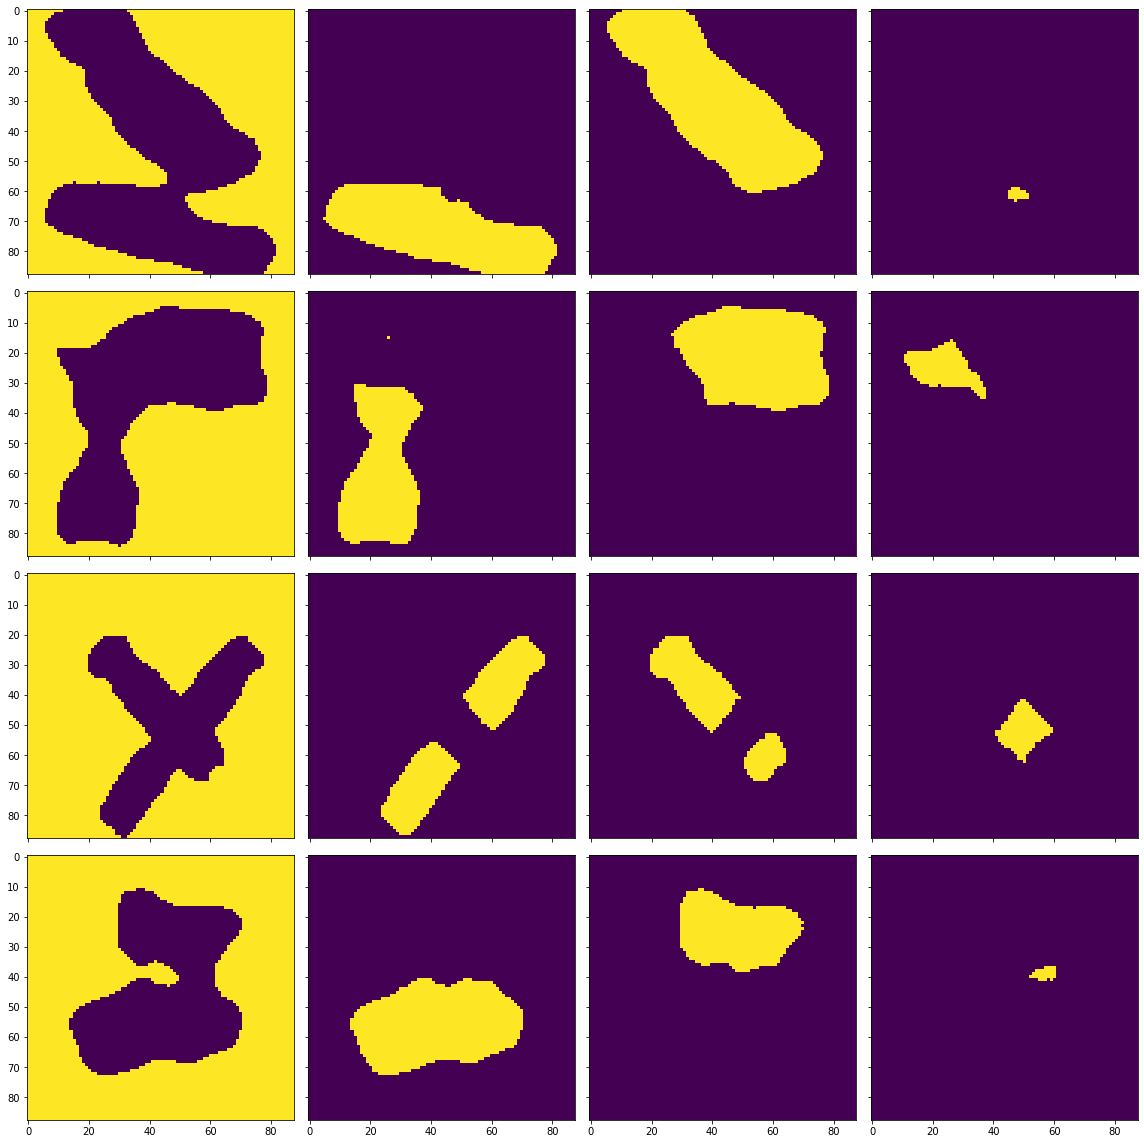

Training IOU: [0.983213103829116, 0.9458924772593896, 0.9465420450398231, 0.8920344186629352]
Training accuracy: 0.9833748708677686
Testing IOU: [0.9738205201941633, 0.3661053891191931, 0.3162461024406785, 0.3375522560184518]
Testing accuracy: 0.8567639462809917
13/13 [==============================] - 1s 67ms/step - loss: 0.0066 - val_loss: 0.0598 ETA: 0s - loss: 0.006
INFO:tensorflow:Assets written to: modelunet/savedmodel_115epoch\assets
4
4


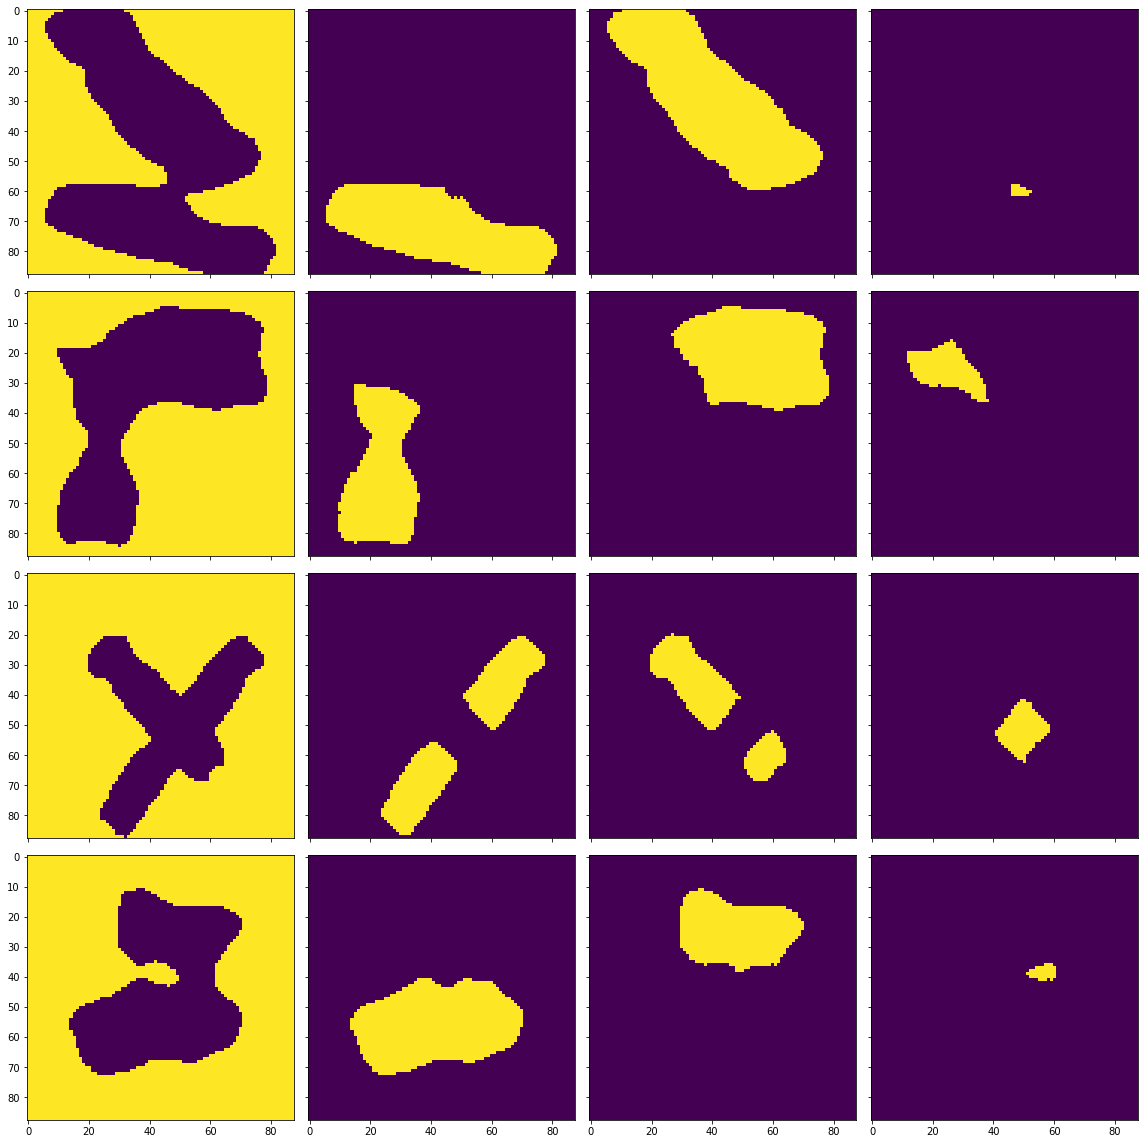

Training IOU: [0.9830356137248978, 0.9410356706352049, 0.9472246220302376, 0.897300849067258]
Training accuracy: 0.983033638946281
Testing IOU: [0.973311161776882, 0.36862185772865036, 0.30497562141899565, 0.32748134179703065]
Testing accuracy: 0.8559077995867769
13/13 [==============================] - 1s 67ms/step - loss: 0.0068 - val_loss: 0.0583
INFO:tensorflow:Assets written to: modelunet/savedmodel_116epoch\assets
4
4


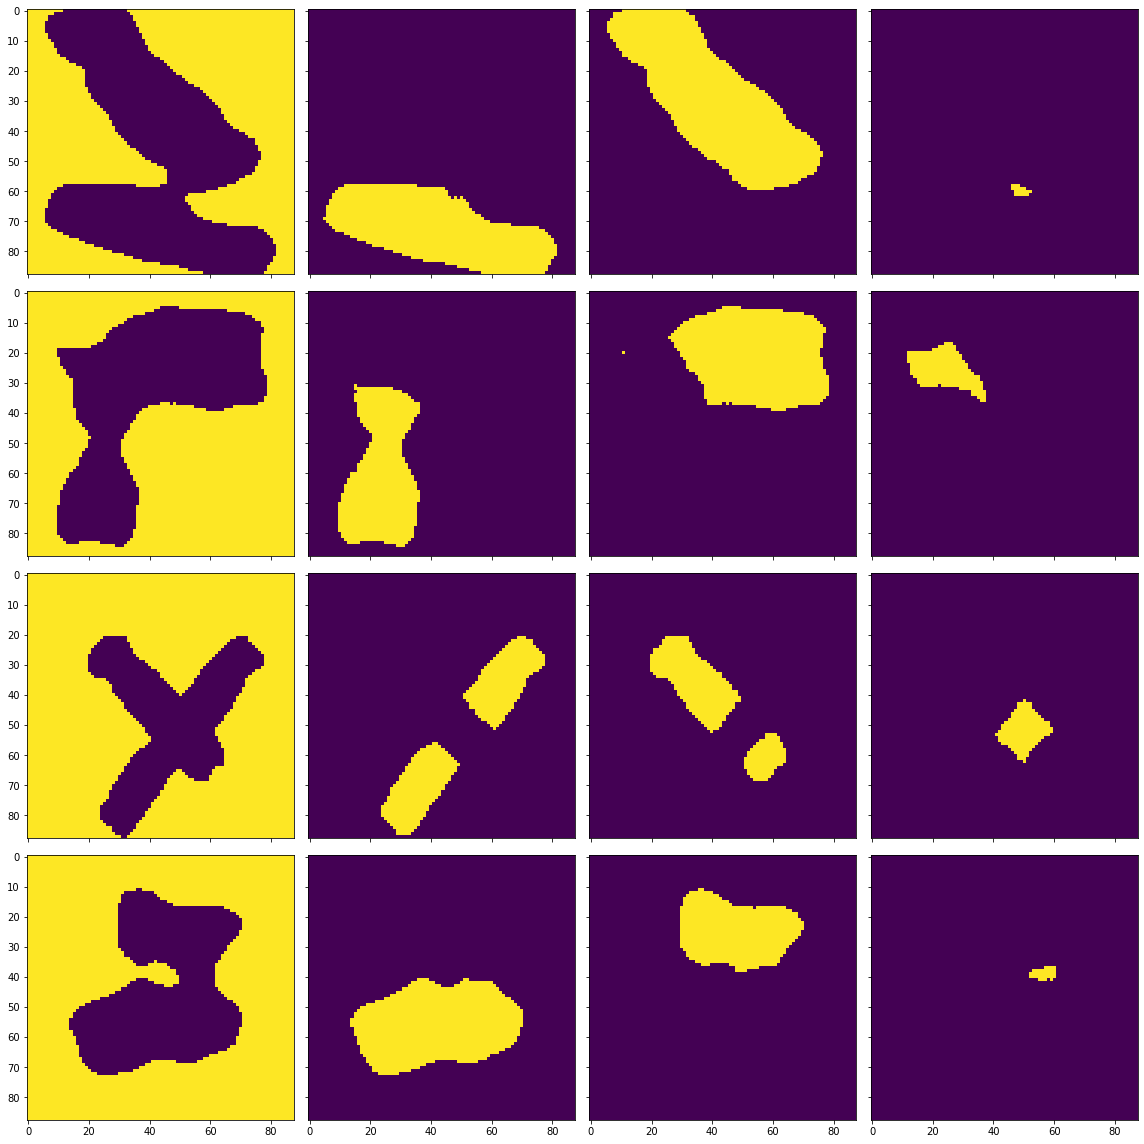

Training IOU: [0.983561448901546, 0.9457239109852837, 0.9447820201830682, 0.8823703453231329]
Training accuracy: 0.983175361570248
Testing IOU: [0.9735848077172643, 0.3742329545454545, 0.31413420490928495, 0.33824458008840247]
Testing accuracy: 0.8577944214876033
13/13 [==============================] - 1s 67ms/step - loss: 0.0067 - val_loss: 0.0588
INFO:tensorflow:Assets written to: modelunet/savedmodel_117epoch\assets
4
4


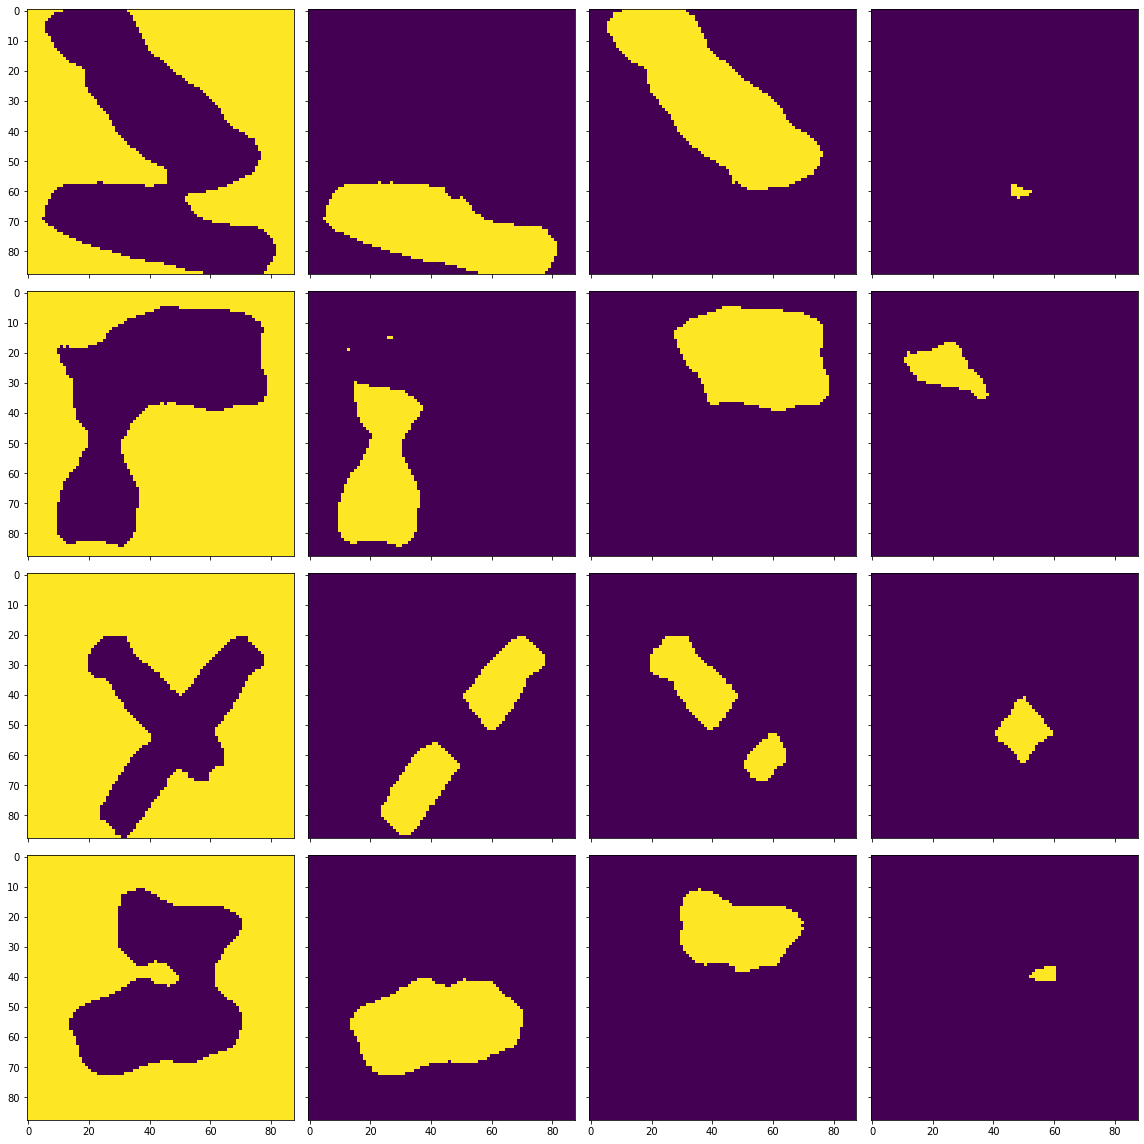

Training IOU: [0.983675436431707, 0.9473935446148787, 0.9440418898219465, 0.9007589267200266]
Training accuracy: 0.9831947314049587
Testing IOU: [0.9735005645178049, 0.39241533436479287, 0.28226586558514744, 0.3324658960170931]
Testing accuracy: 0.8563933367768595
13/13 [==============================] - 1s 66ms/step - loss: 0.0068 - val_loss: 0.0624 ETA: 0s - loss: 0.0 - ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_118epoch\assets
4
4


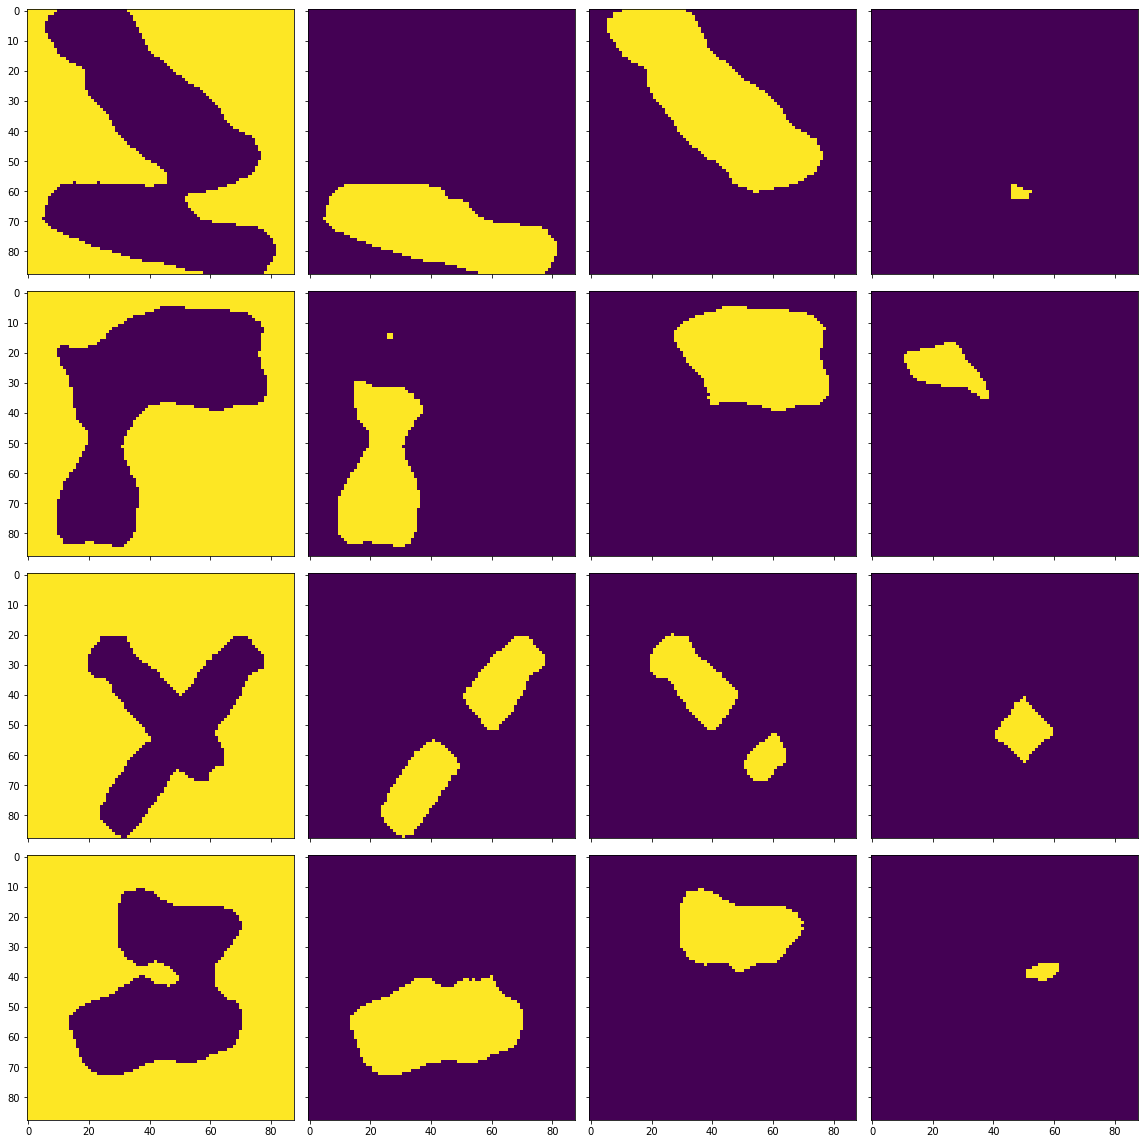

Training IOU: [0.9830528716104733, 0.9450346243031675, 0.9455789646743012, 0.8874240987674245]
Training accuracy: 0.9836541193181818
Testing IOU: [0.9738808497189426, 0.3924491520802661, 0.28902383376039875, 0.32701458370842873]
Testing accuracy: 0.857498708677686
13/13 [==============================] - 1s 66ms/step - loss: 0.0066 - val_loss: 0.0599
INFO:tensorflow:Assets written to: modelunet/savedmodel_119epoch\assets
4
4


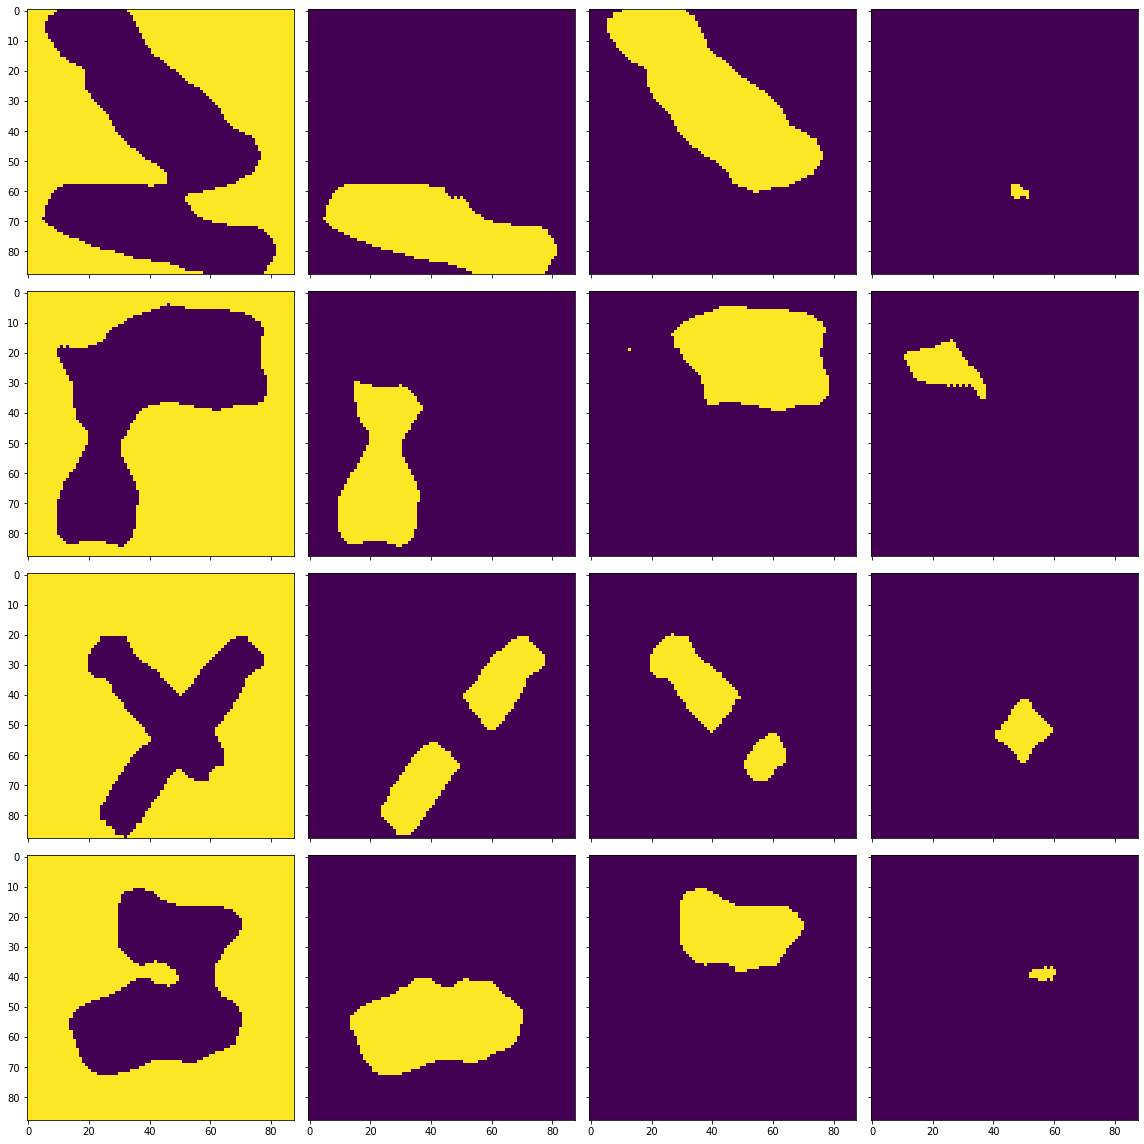

Training IOU: [0.9840487465143607, 0.9494141569752115, 0.9493460185653282, 0.9006626656664166]
Training accuracy: 0.9844169679752066
Testing IOU: [0.9734593134028475, 0.375854679768232, 0.31274554437081625, 0.32883097919182275]
Testing accuracy: 0.8576239669421487
13/13 [==============================] - 1s 67ms/step - loss: 0.0064 - val_loss: 0.0590
INFO:tensorflow:Assets written to: modelunet/savedmodel_120epoch\assets
4
4


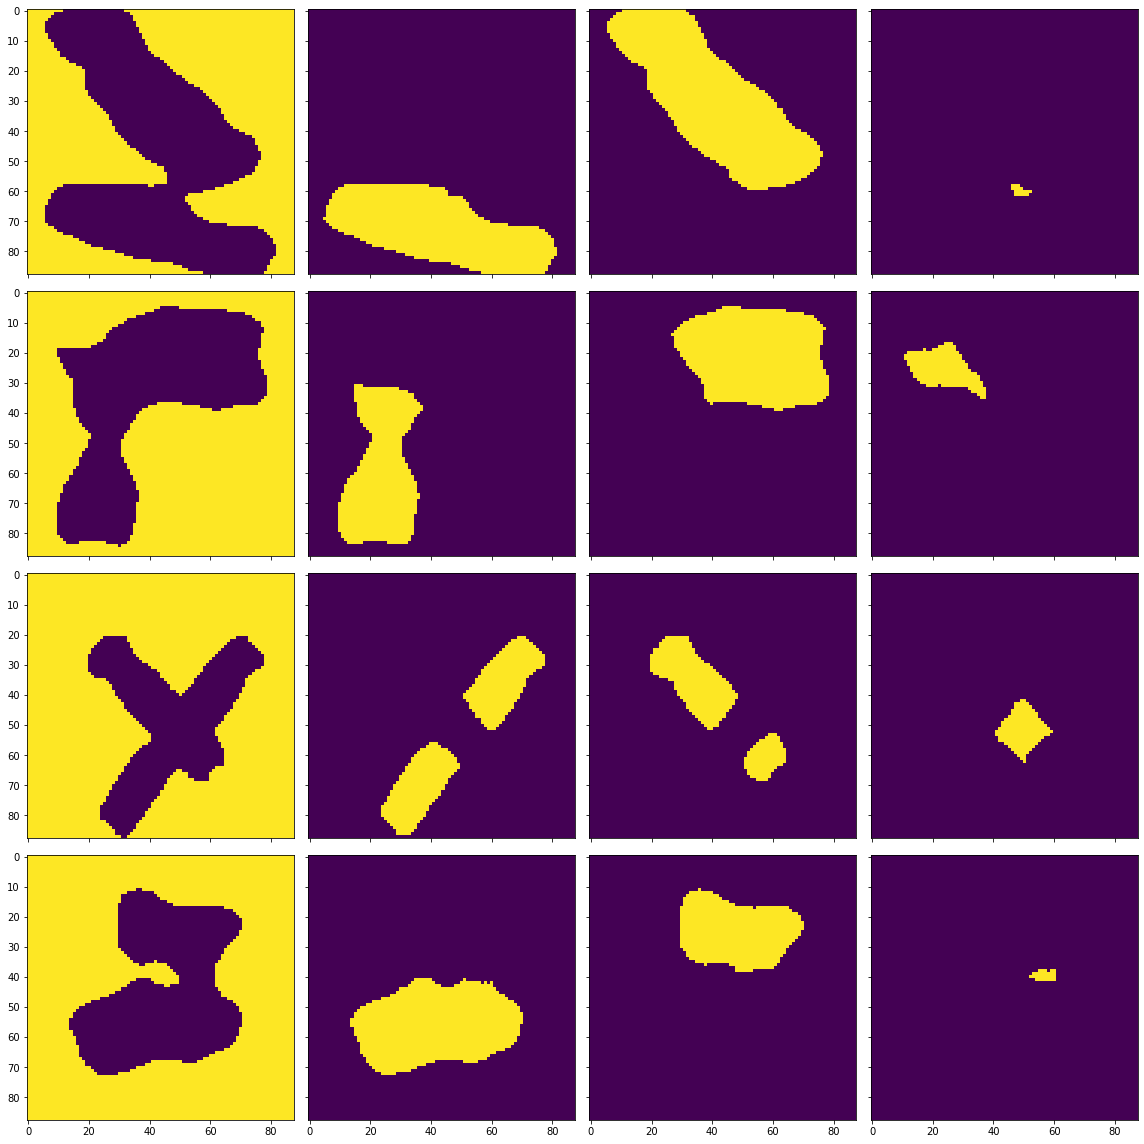

Training IOU: [0.9840497014629679, 0.9462457082114109, 0.9477985242289556, 0.9020604988576182]
Training accuracy: 0.9835337035123967
Testing IOU: [0.9729445290263936, 0.36647235923387356, 0.31007342587004627, 0.3434077967586509]
Testing accuracy: 0.8564682334710744
13/13 [==============================] - ETA: 0s - loss: 0.0064- ETA: 0s - loss: 0.00 - ETA: 0s - loss:  - 1s 67ms/step - loss: 0.0064 - val_loss: 0.0597
INFO:tensorflow:Assets written to: modelunet/savedmodel_121epoch\assets
4
4


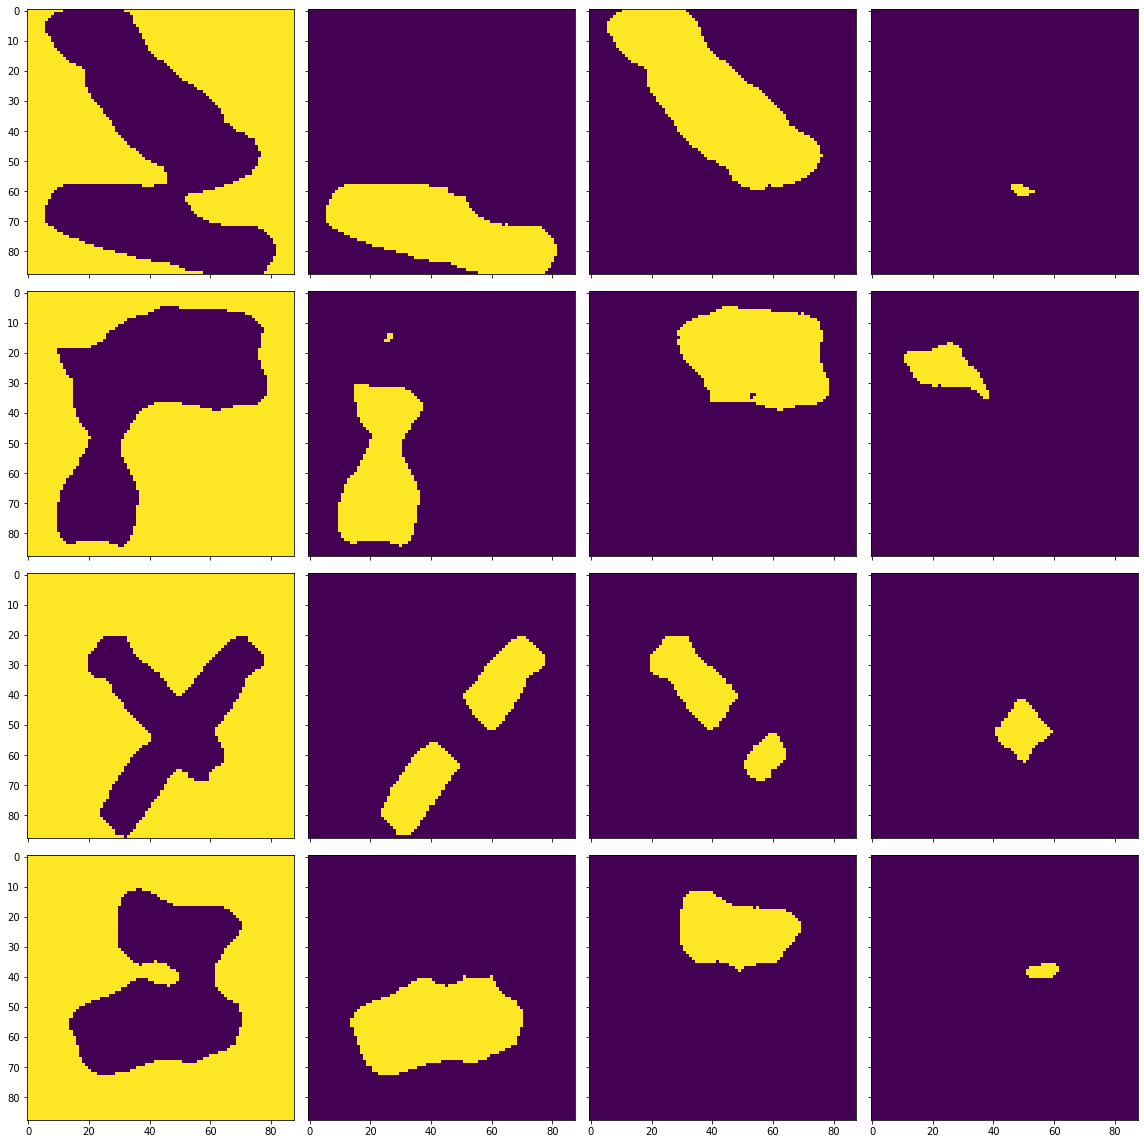

Training IOU: [0.9842170856140938, 0.9481533081883218, 0.9381086510327962, 0.8910093733371536]
Training accuracy: 0.9831937629132231
Testing IOU: [0.9729968377944048, 0.3909425540745579, 0.26868510239400056, 0.3376675388476531]
Testing accuracy: 0.8561428202479339
13/13 [==============================] - ETA: 0s - loss: 0.006 - 1s 67ms/step - loss: 0.0064 - val_loss: 0.0583
INFO:tensorflow:Assets written to: modelunet/savedmodel_122epoch\assets
4
4


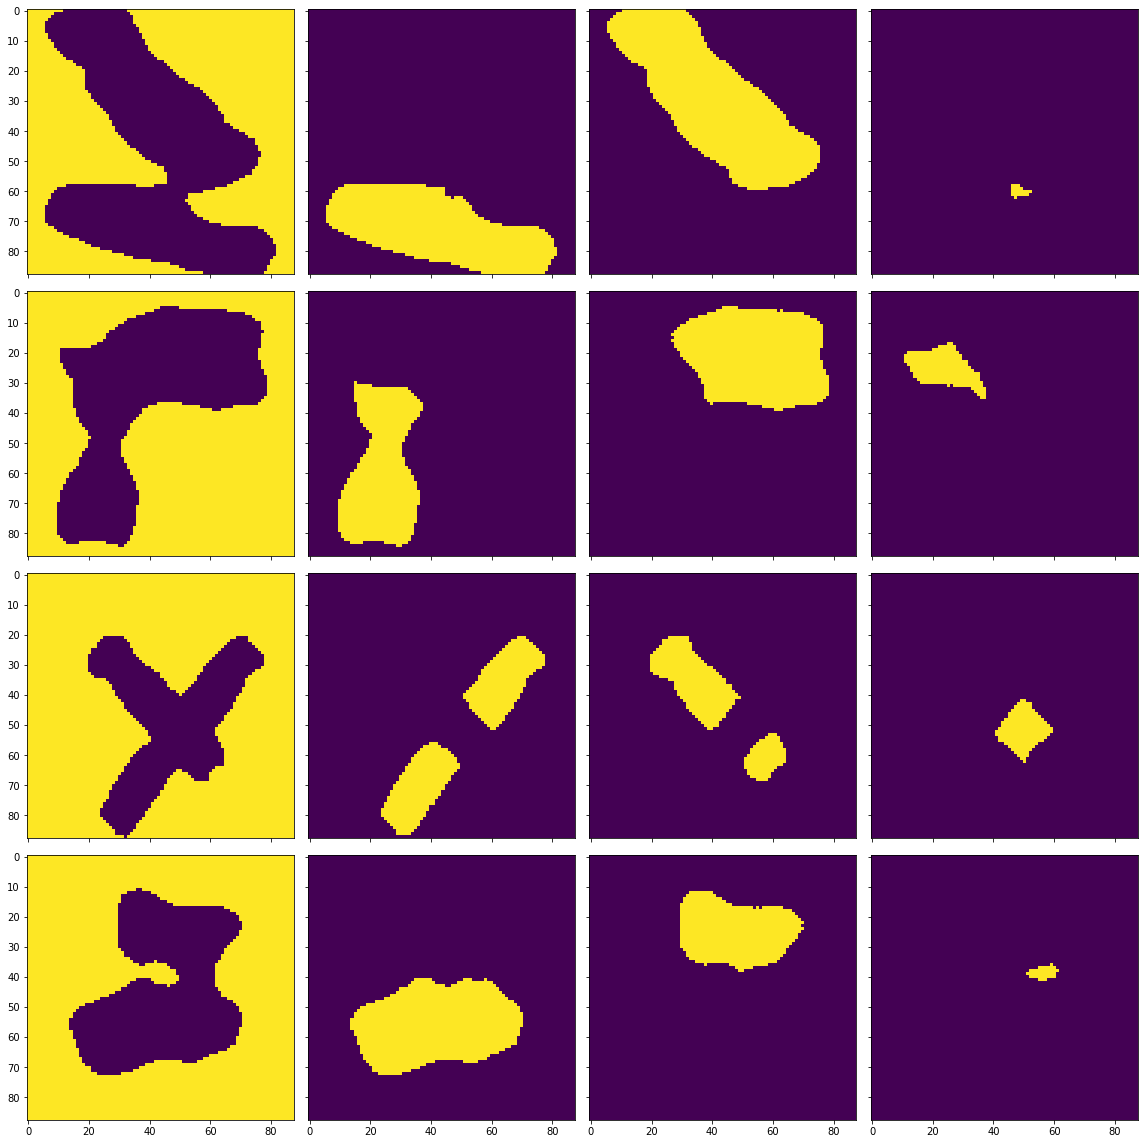

Training IOU: [0.9844212982743571, 0.9491590660719073, 0.9453659595836217, 0.8992317501132879]
Training accuracy: 0.9840683109504132
Testing IOU: [0.9731631215481551, 0.3893272296021741, 0.29383116883116883, 0.3490203095642838]
Testing accuracy: 0.8584981921487603
13/13 [==============================] - 1s 67ms/step - loss: 0.0063 - val_loss: 0.0586
INFO:tensorflow:Assets written to: modelunet/savedmodel_123epoch\assets
4
4


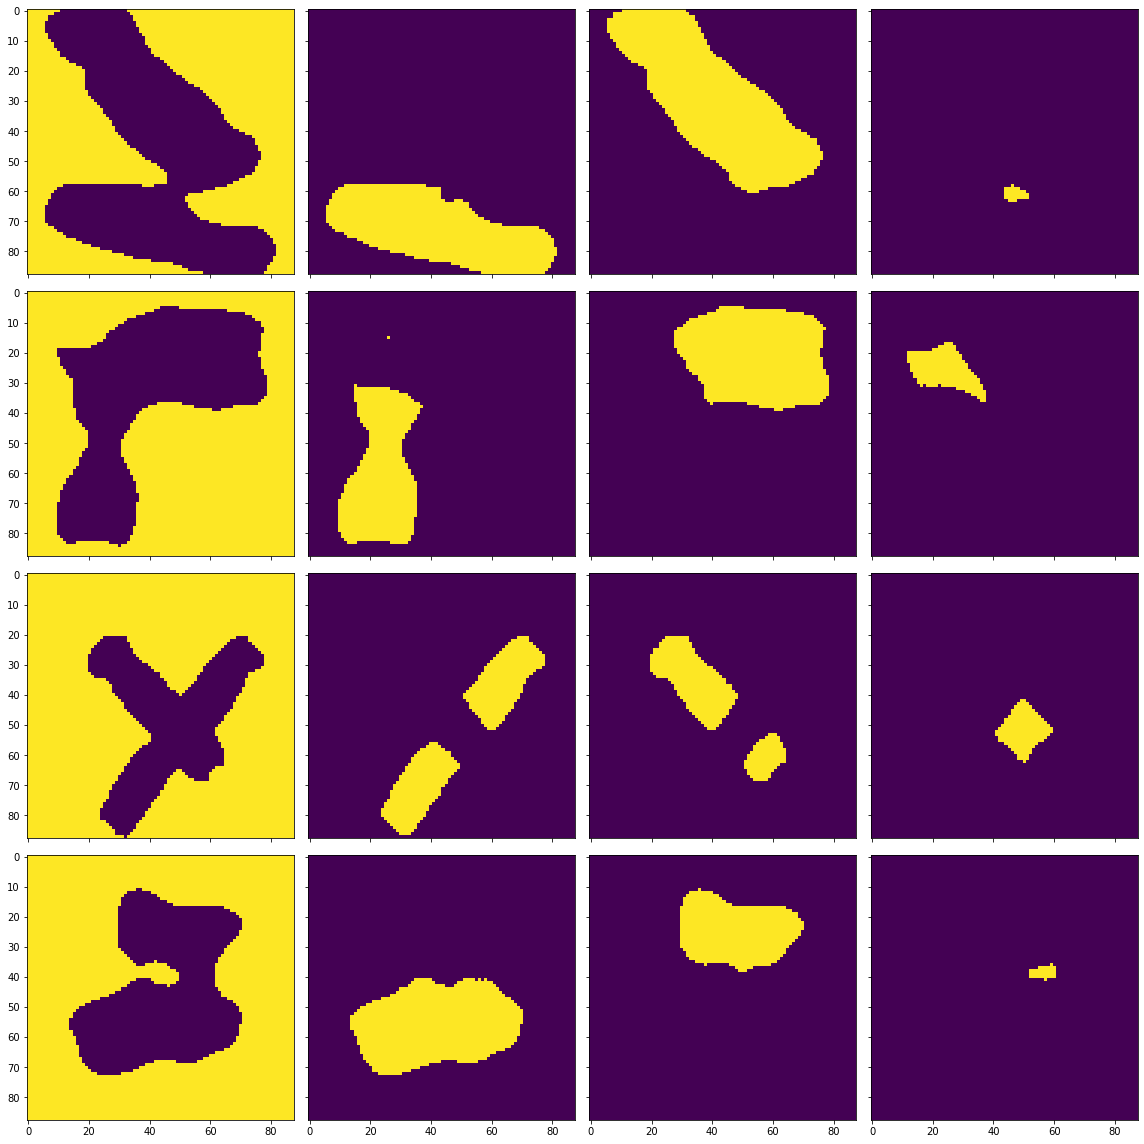

Training IOU: [0.9845303689397373, 0.9489322148546606, 0.9494019544957175, 0.8947974923088309]
Training accuracy: 0.9844650697314049
Testing IOU: [0.9729503620388952, 0.37857530423998137, 0.3129091429244569, 0.3472264048665904]
Testing accuracy: 0.8591451446280992
13/13 [==============================] - 1s 67ms/step - loss: 0.0063 - val_loss: 0.0596TA: 0s - loss: 0.006
INFO:tensorflow:Assets written to: modelunet/savedmodel_124epoch\assets
4
4


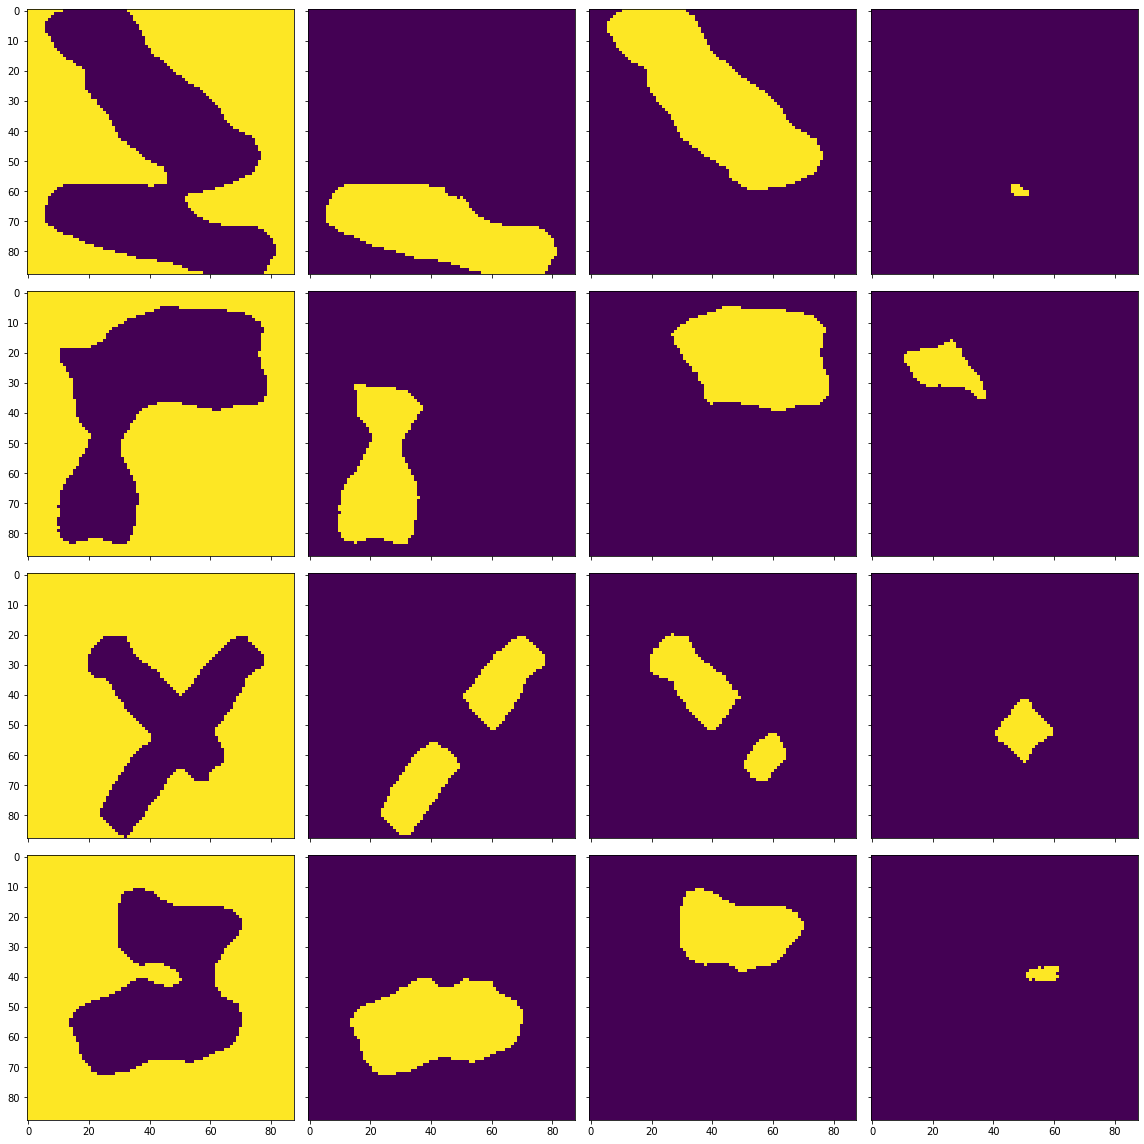

Training IOU: [0.9845231455037236, 0.9468302422206097, 0.9502590925546688, 0.9009689740947742]
Training accuracy: 0.9843394886363637
Testing IOU: [0.9723808717848637, 0.36681403604002544, 0.3141858641800257, 0.34303012829753493]
Testing accuracy: 0.8573760330578513
13/13 [==============================] - 1s 66ms/step - loss: 0.0061 - val_loss: 0.0614 ETA: 0s - loss: 0
INFO:tensorflow:Assets written to: modelunet/savedmodel_125epoch\assets
4
4


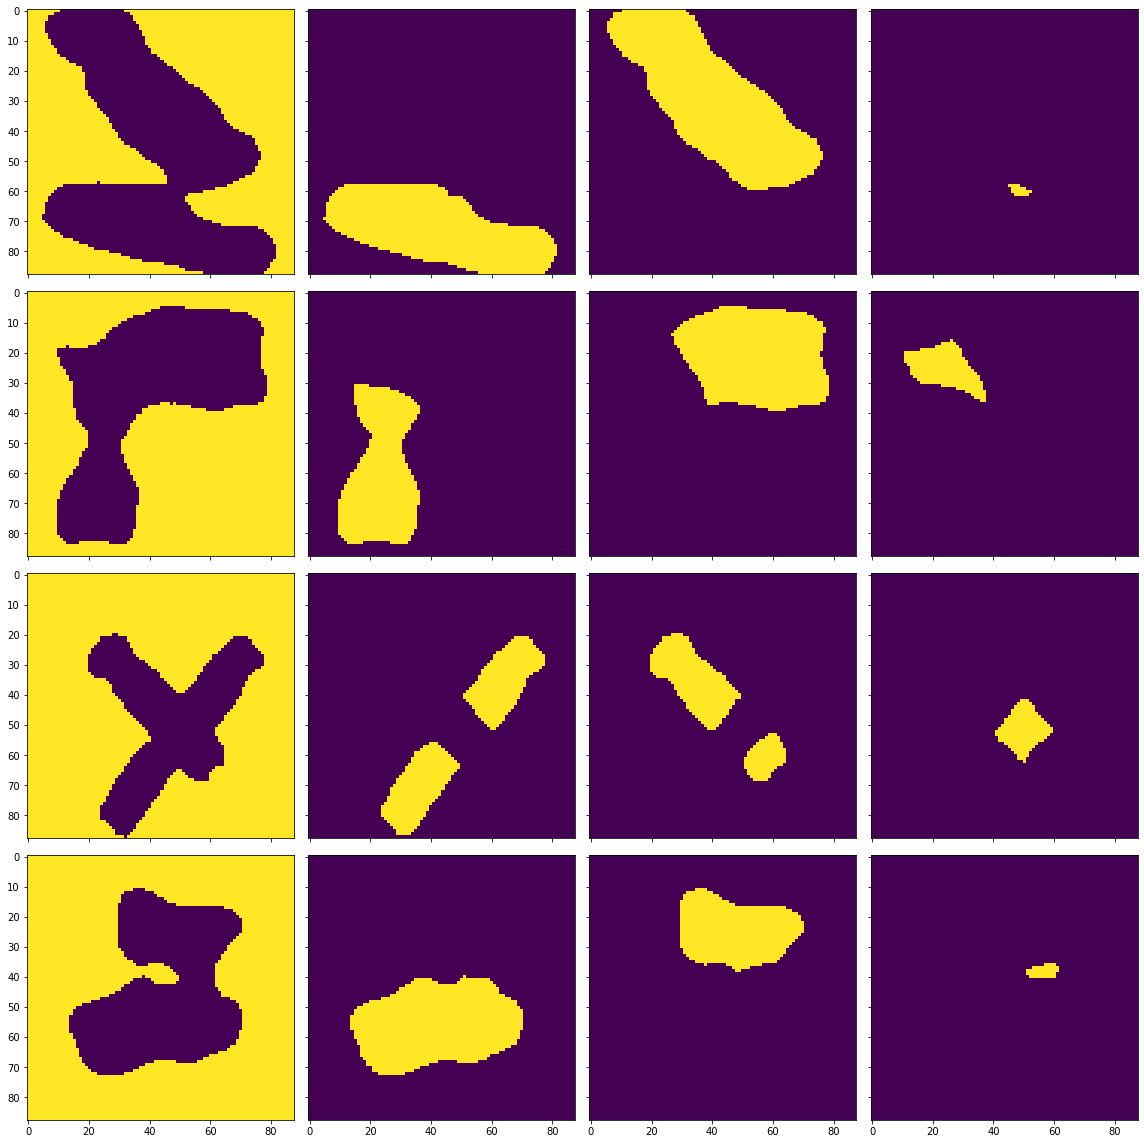

Training IOU: [0.9848132058454695, 0.9528409845145402, 0.9528309731830777, 0.9031762559148875]
Training accuracy: 0.9851914385330579
Testing IOU: [0.9730530559704664, 0.3710122428818403, 0.3110250614903942, 0.3288166702656014]
Testing accuracy: 0.8562577479338843
13/13 [==============================] - 1s 66ms/step - loss: 0.0062 - val_loss: 0.0585
INFO:tensorflow:Assets written to: modelunet/savedmodel_126epoch\assets
4
4


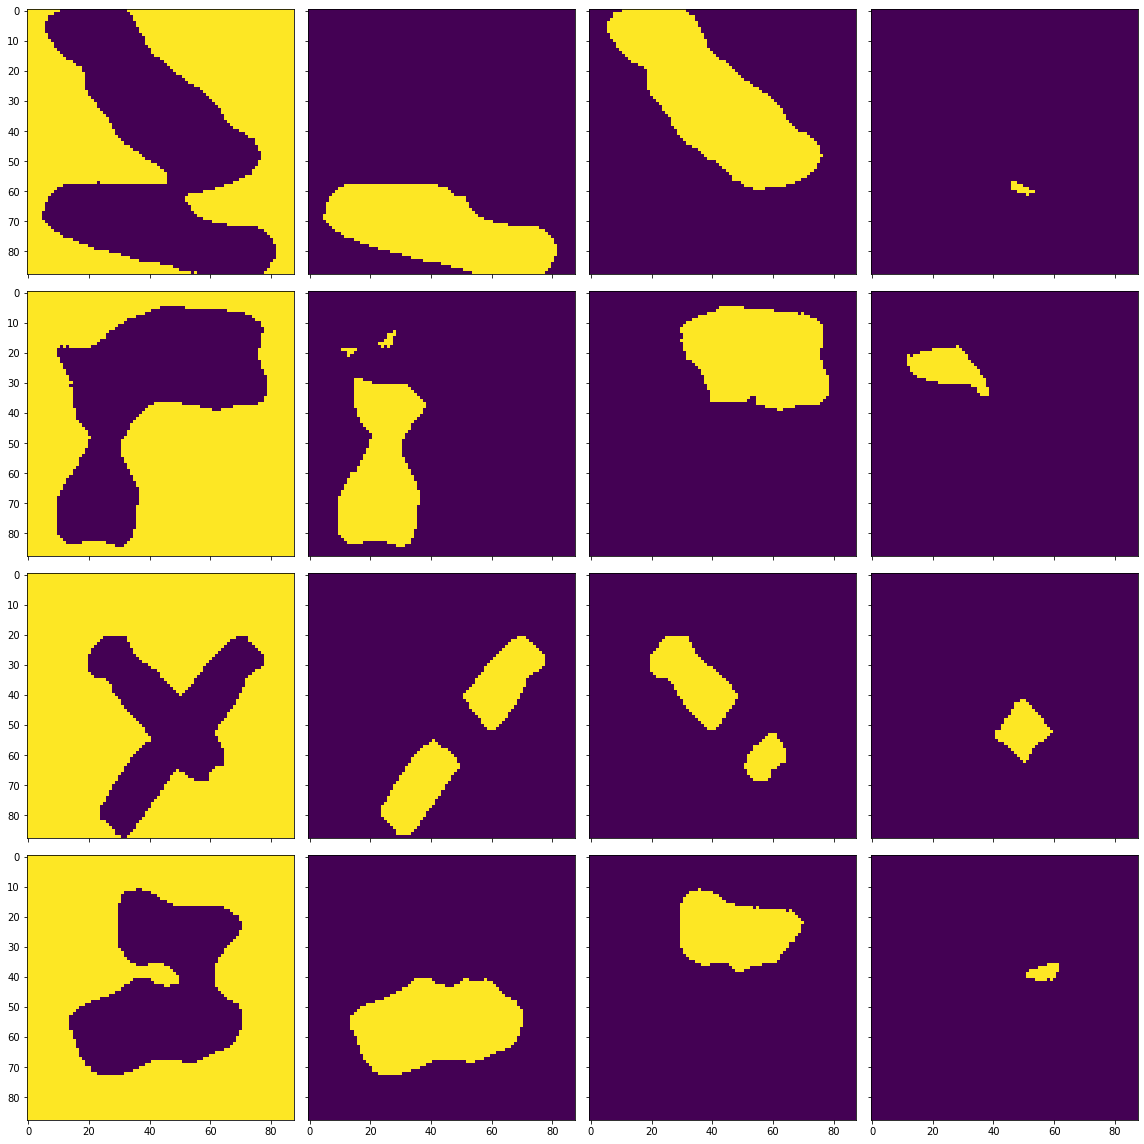

Training IOU: [0.9853862849694615, 0.9483977983181471, 0.9412303240519987, 0.8733951977488801]
Training accuracy: 0.9831133780991735
Testing IOU: [0.9730818455293142, 0.40798240806165104, 0.2665722638406724, 0.3461855670103093]
Testing accuracy: 0.8581973140495868
13/13 [==============================] - 1s 67ms/step - loss: 0.0064 - val_loss: 0.0577
INFO:tensorflow:Assets written to: modelunet/savedmodel_127epoch\assets
4
4


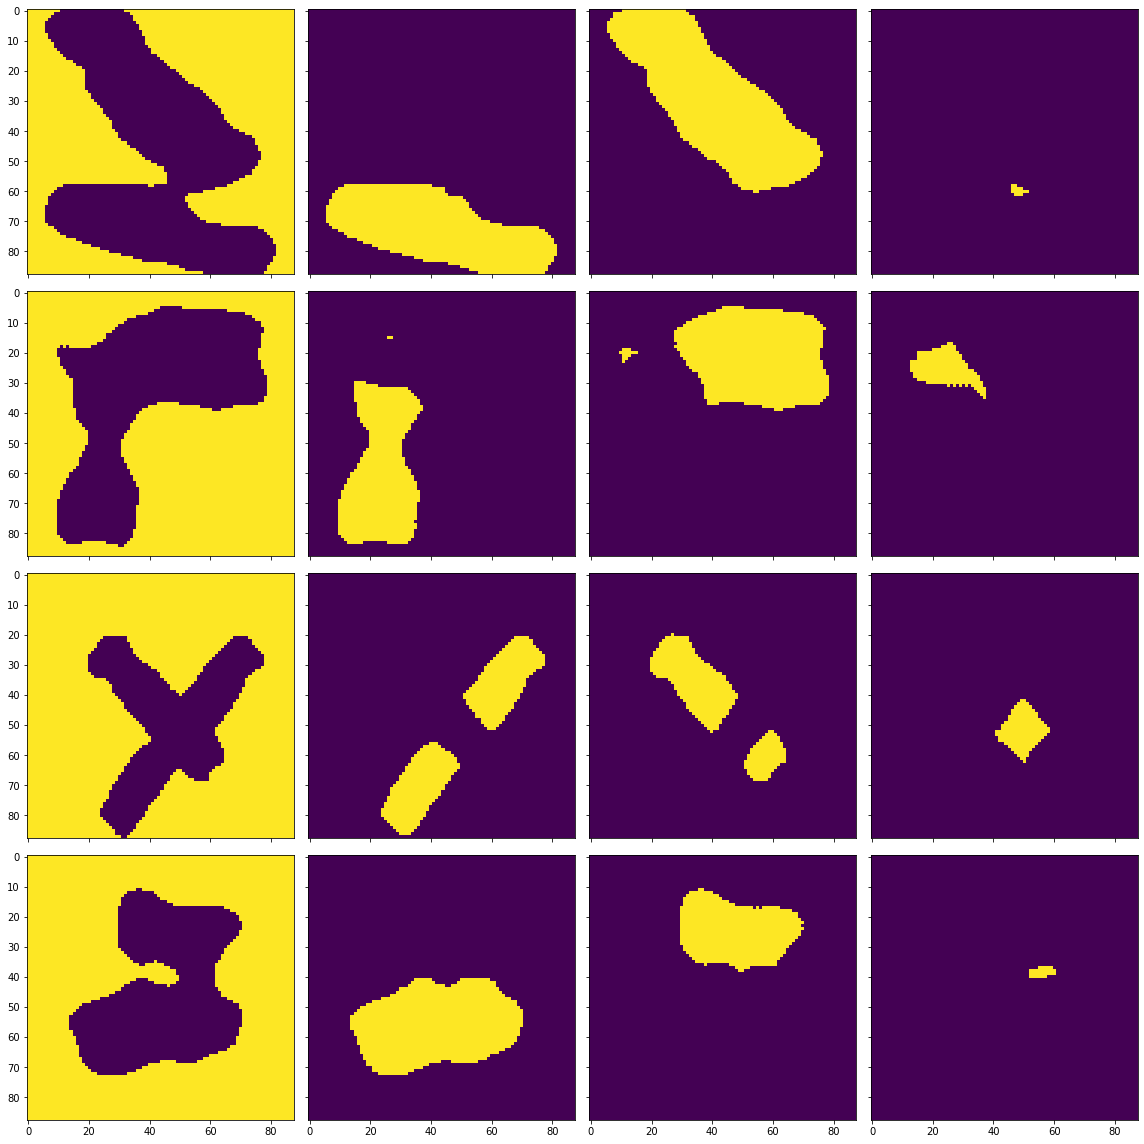

Training IOU: [0.9854512175227181, 0.9518185625905505, 0.9492199713216823, 0.8828474257235139]
Training accuracy: 0.9844298811983471
Testing IOU: [0.9731311928732855, 0.3959026152646057, 0.29862686464563143, 0.3588175004804305]
Testing accuracy: 0.8602388946280992
13/13 [==============================] - 1s 67ms/step - loss: 0.0063 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelunet/savedmodel_128epoch\assets
4
4


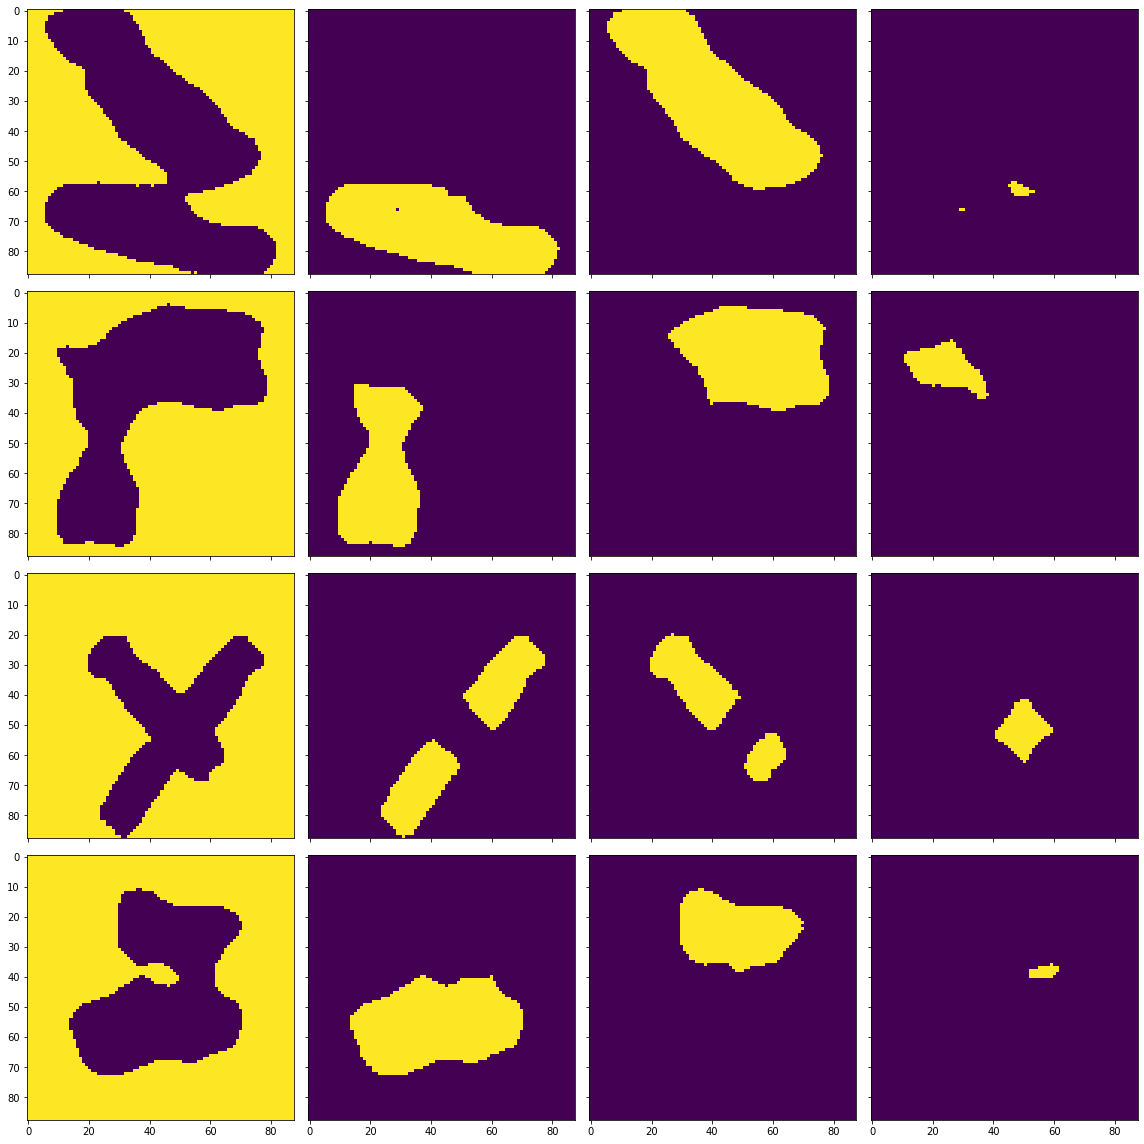

Training IOU: [0.9851882011980521, 0.9513903436466806, 0.95004922058394, 0.900252512132013]
Training accuracy: 0.984753680268595
Testing IOU: [0.9730480790233721, 0.3894176568254337, 0.29457384380735724, 0.34456337704823947]
Testing accuracy: 0.8580591425619835
13/13 [==============================] - 1s 66ms/step - loss: 0.0062 - val_loss: 0.0586
INFO:tensorflow:Assets written to: modelunet/savedmodel_129epoch\assets
4
4


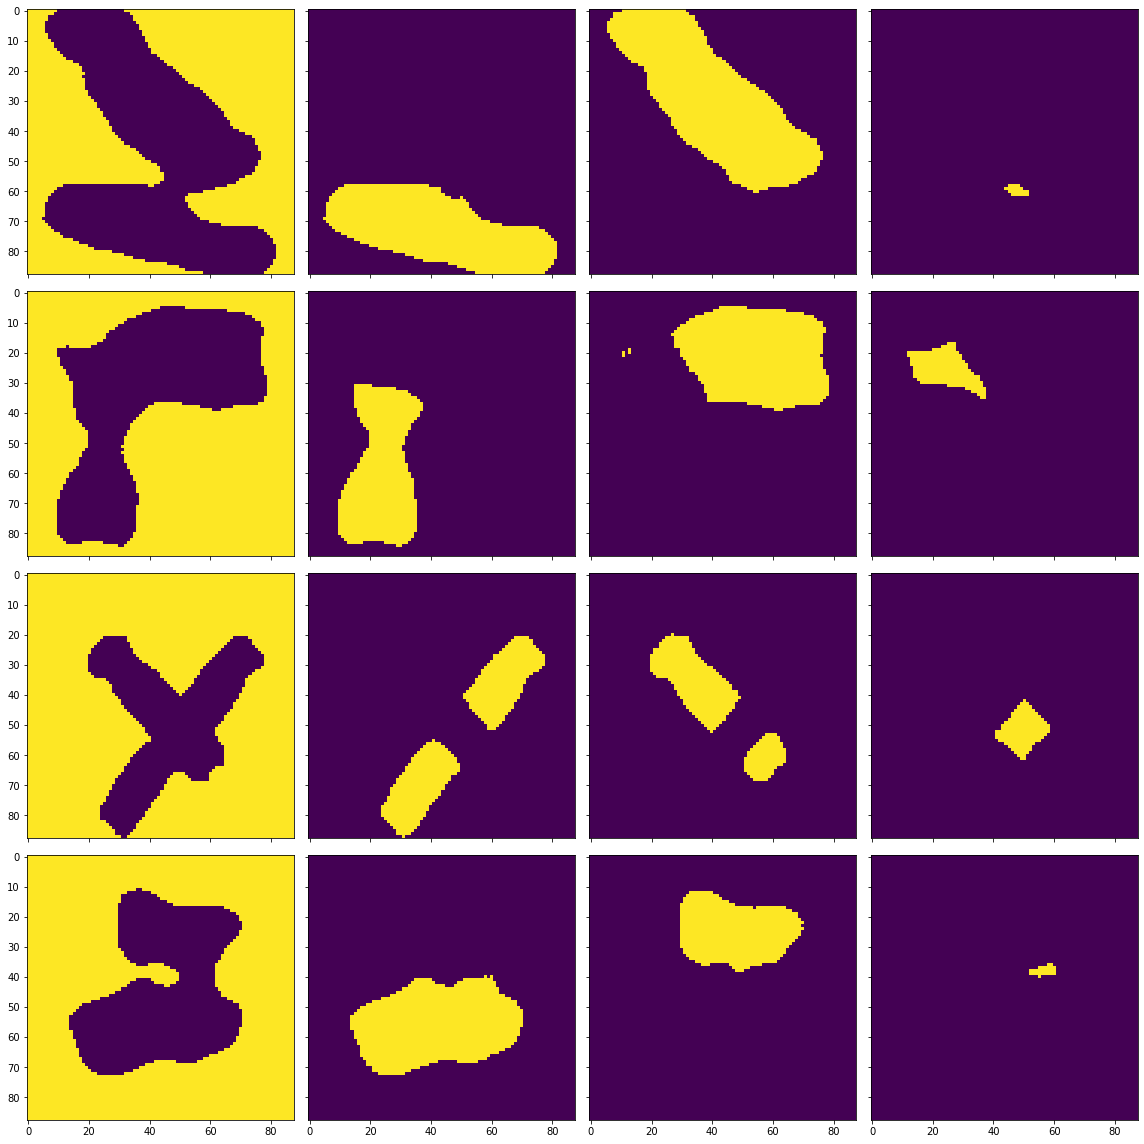

Training IOU: [0.9855502927557102, 0.9532782197026253, 0.9504425157239429, 0.8769417860730714]
Training accuracy: 0.9843449767561984
Testing IOU: [0.9729305956689646, 0.37170637676640256, 0.32006697472853074, 0.35054856002992146]
Testing accuracy: 0.8577634297520661
13/13 [==============================] - 1s 66ms/step - loss: 0.0063 - val_loss: 0.0602
INFO:tensorflow:Assets written to: modelunet/savedmodel_130epoch\assets
4
4


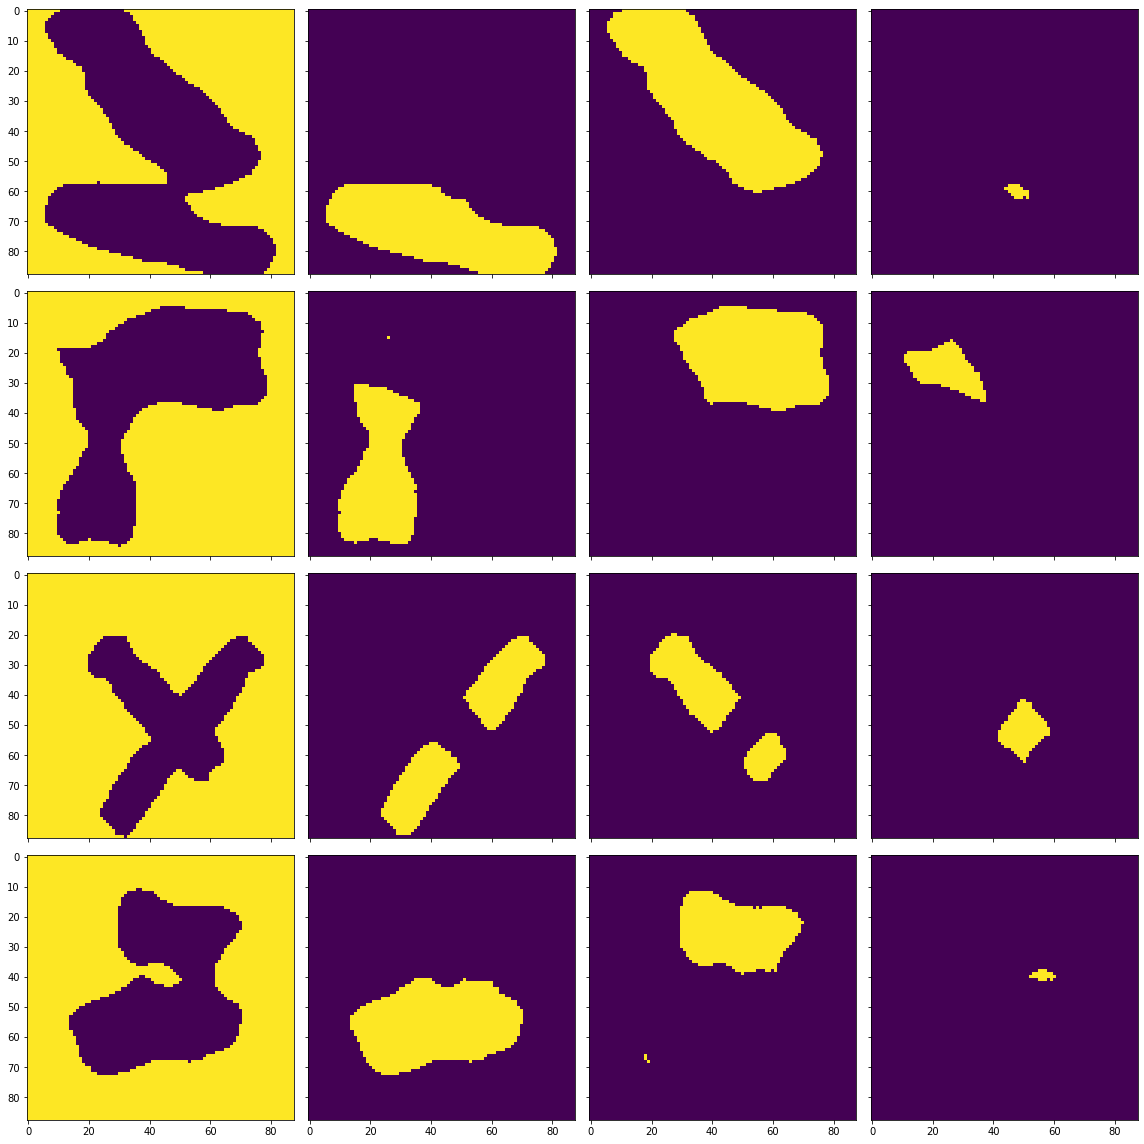

Training IOU: [0.9852902911443029, 0.9487256489568872, 0.9479353344282114, 0.8832755506653657]
Training accuracy: 0.9847026730371901
Testing IOU: [0.9723759485070254, 0.3730917915291064, 0.3171286974102718, 0.35807323666748586]
Testing accuracy: 0.859453770661157
13/13 [==============================] - 1s 67ms/step - loss: 0.0061 - val_loss: 0.0598
INFO:tensorflow:Assets written to: modelunet/savedmodel_131epoch\assets
4
4


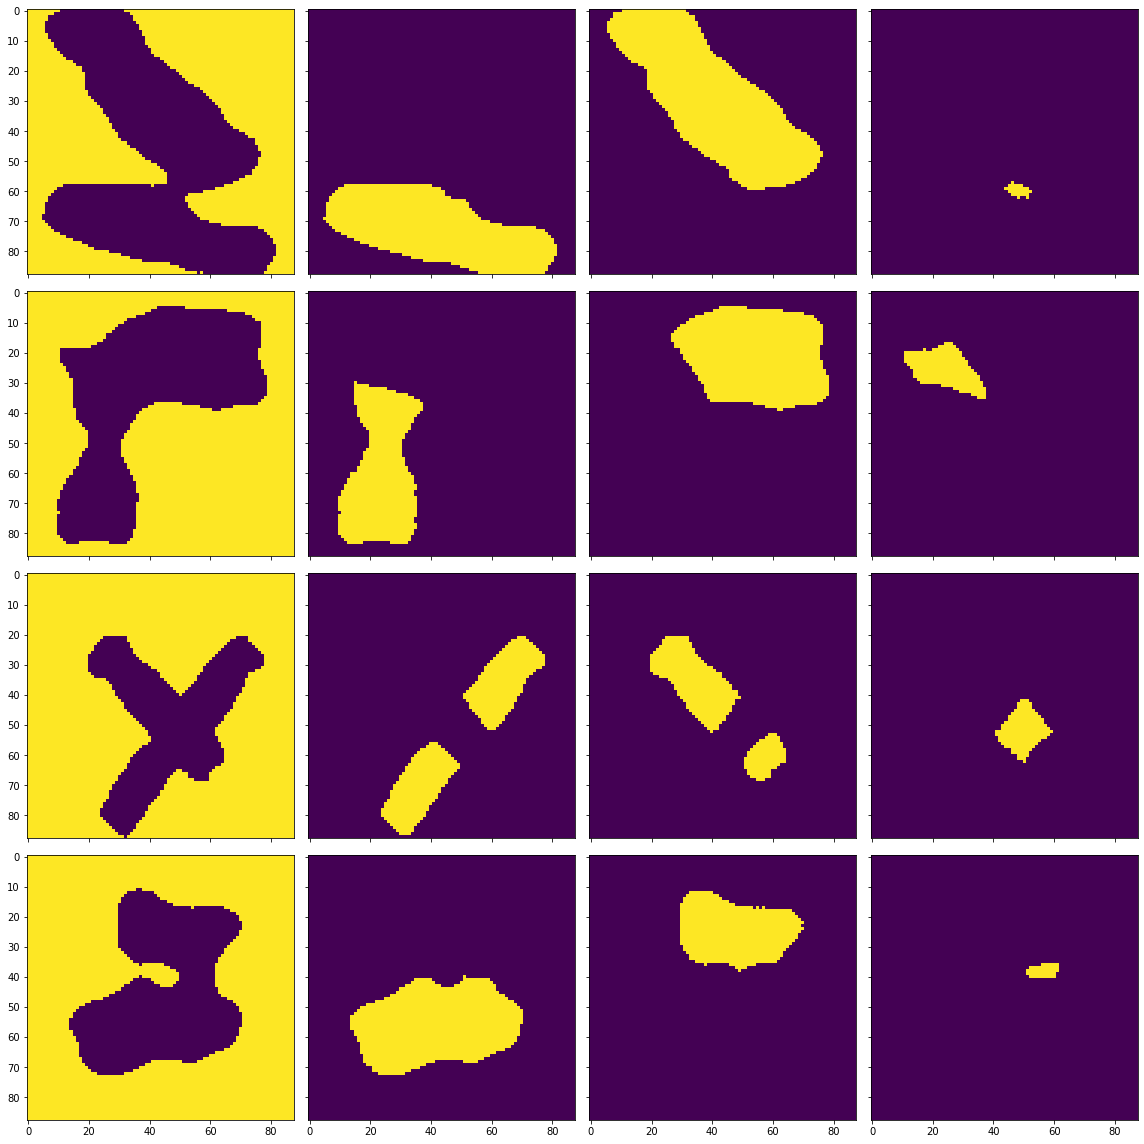

Training IOU: [0.9858401927503649, 0.9495319928226568, 0.9523270211907, 0.8997330199668079]
Training accuracy: 0.984870222107438
Testing IOU: [0.972412339283647, 0.36359934853420195, 0.31111868974638374, 0.3426091396476896]
Testing accuracy: 0.8563442665289256
13/13 [==============================] - 1s 66ms/step - loss: 0.0059 - val_loss: 0.0592
INFO:tensorflow:Assets written to: modelunet/savedmodel_132epoch\assets
4
4


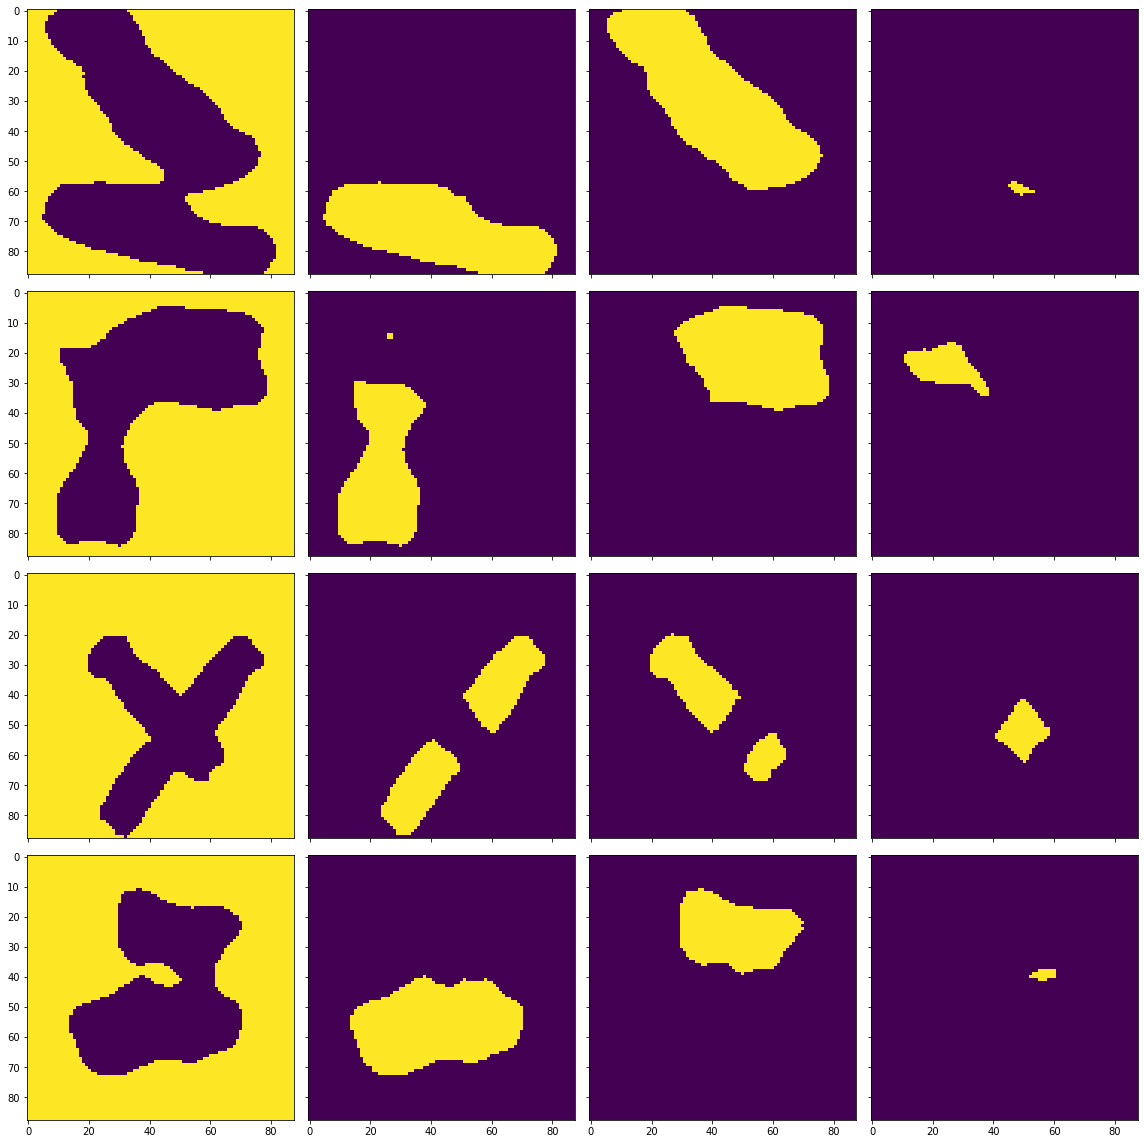

Training IOU: [0.9857877683800195, 0.9519014621756285, 0.9526271296657562, 0.9013459999157434]
Training accuracy: 0.9853444602272727
Testing IOU: [0.972759313547877, 0.39679712910943254, 0.2888681157394465, 0.3553793206643723]
Testing accuracy: 0.8588494318181819
13/13 [==============================] - 1s 67ms/step - loss: 0.0059 - val_loss: 0.0592
INFO:tensorflow:Assets written to: modelunet/savedmodel_133epoch\assets
4
4


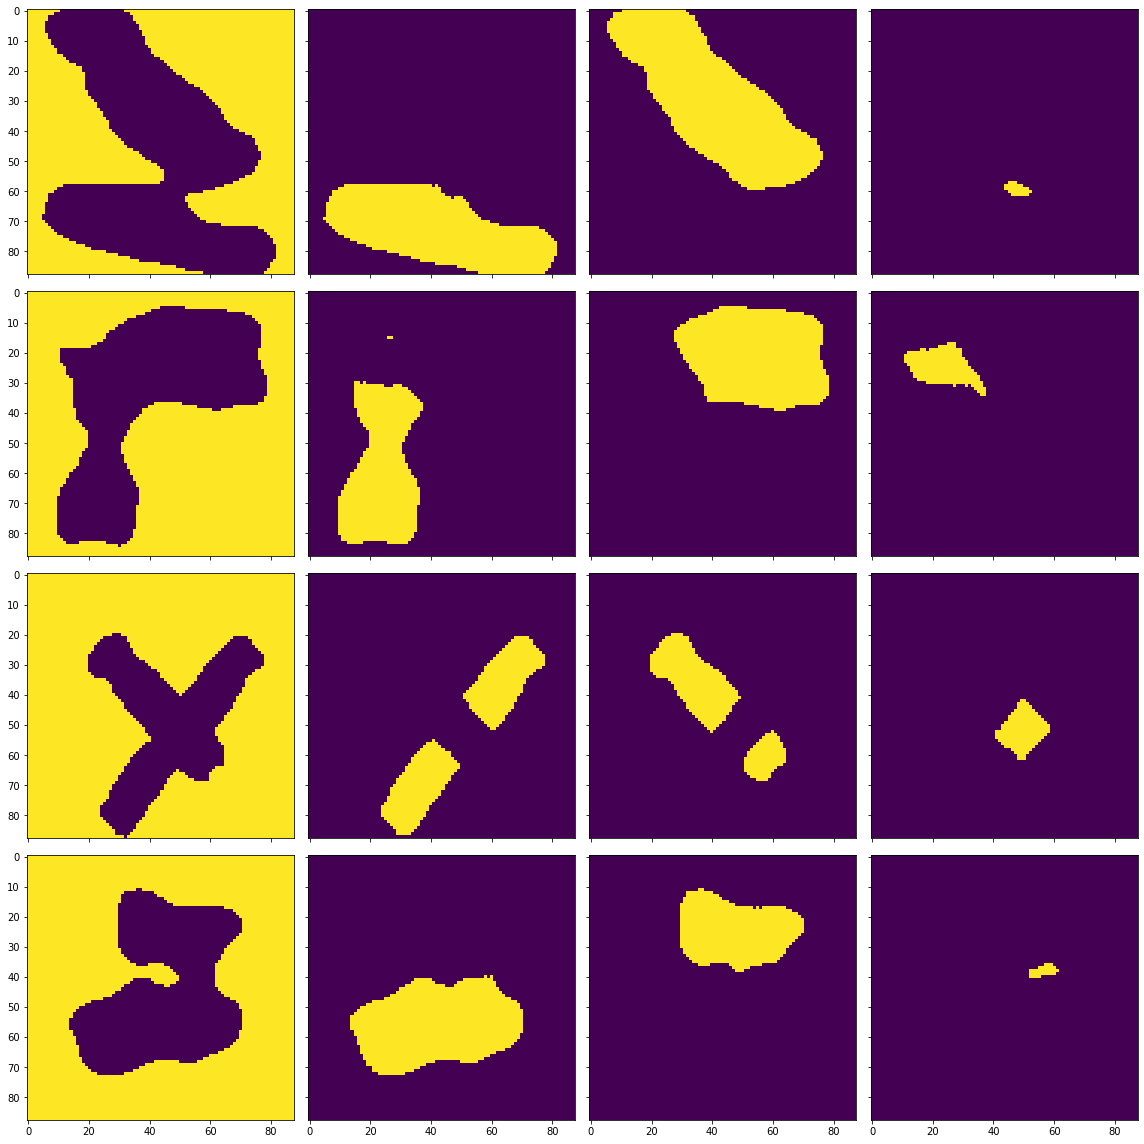

Training IOU: [0.9865008637005168, 0.955573511201042, 0.9549489581424428, 0.9021498261865003]
Training accuracy: 0.9863358729338843
Testing IOU: [0.972736372515742, 0.38642114527751803, 0.3048342868749788, 0.3639965861984882]
Testing accuracy: 0.8598282541322314
13/13 [==============================] - 1s 67ms/step - loss: 0.0058 - val_loss: 0.0602
INFO:tensorflow:Assets written to: modelunet/savedmodel_134epoch\assets
4
4


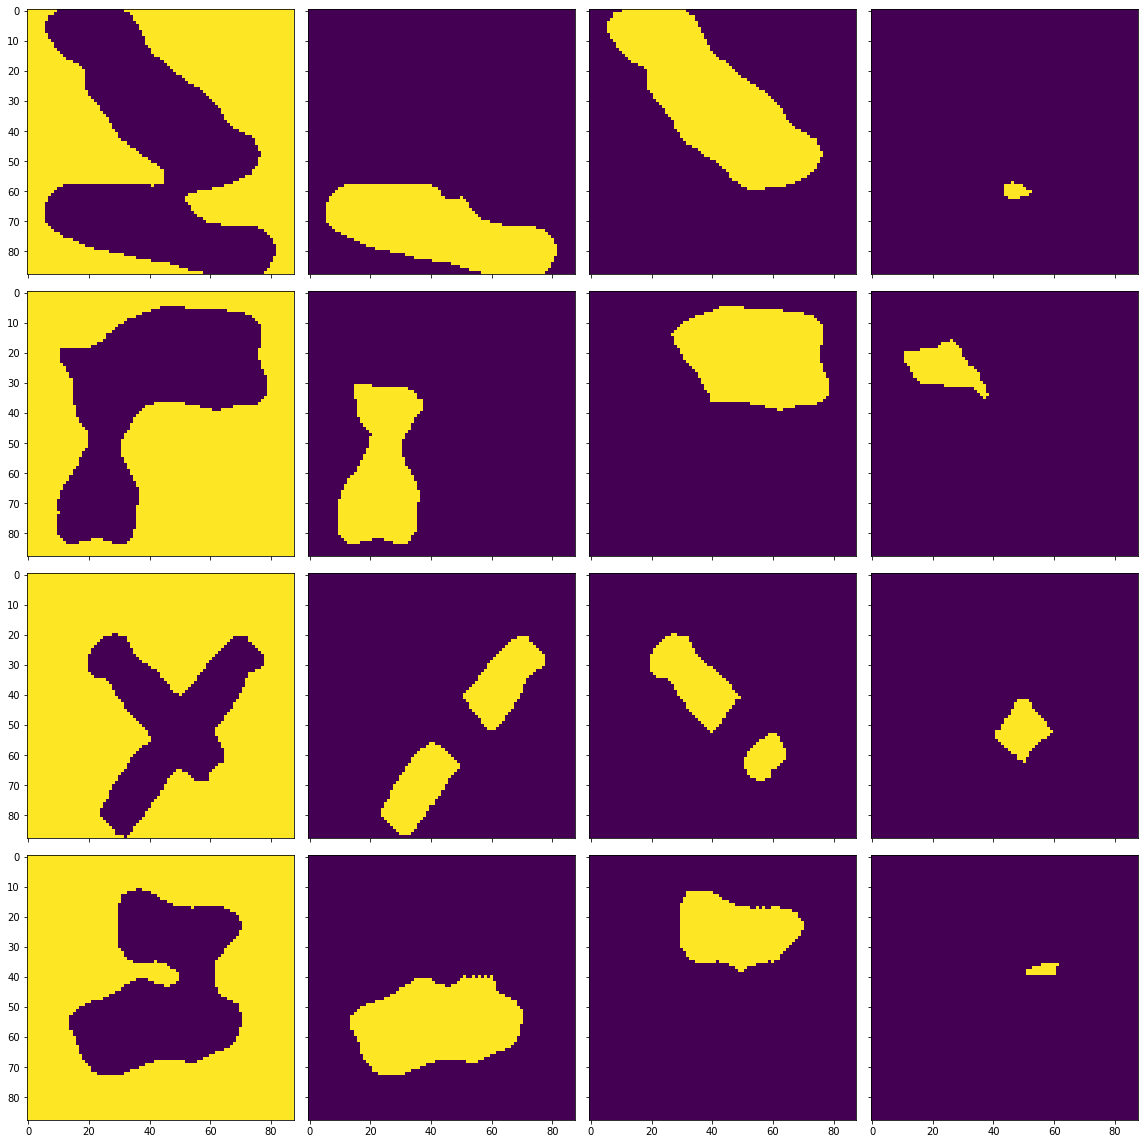

Training IOU: [0.98647944823287, 0.9536130353008591, 0.9534599445454817, 0.90396565949847]
Training accuracy: 0.9858697055785124
Testing IOU: [0.9716094862915561, 0.37370334685955003, 0.30795595914118634, 0.3427415860176224]
Testing accuracy: 0.8577259814049587
13/13 [==============================] - ETA: 0s - loss: 0.0058- ETA: 0s - loss: 0.005 - ETA: 0s - loss: 0.00 - 1s 67ms/step - loss: 0.0058 - val_loss: 0.0601
INFO:tensorflow:Assets written to: modelunet/savedmodel_135epoch\assets
4
4


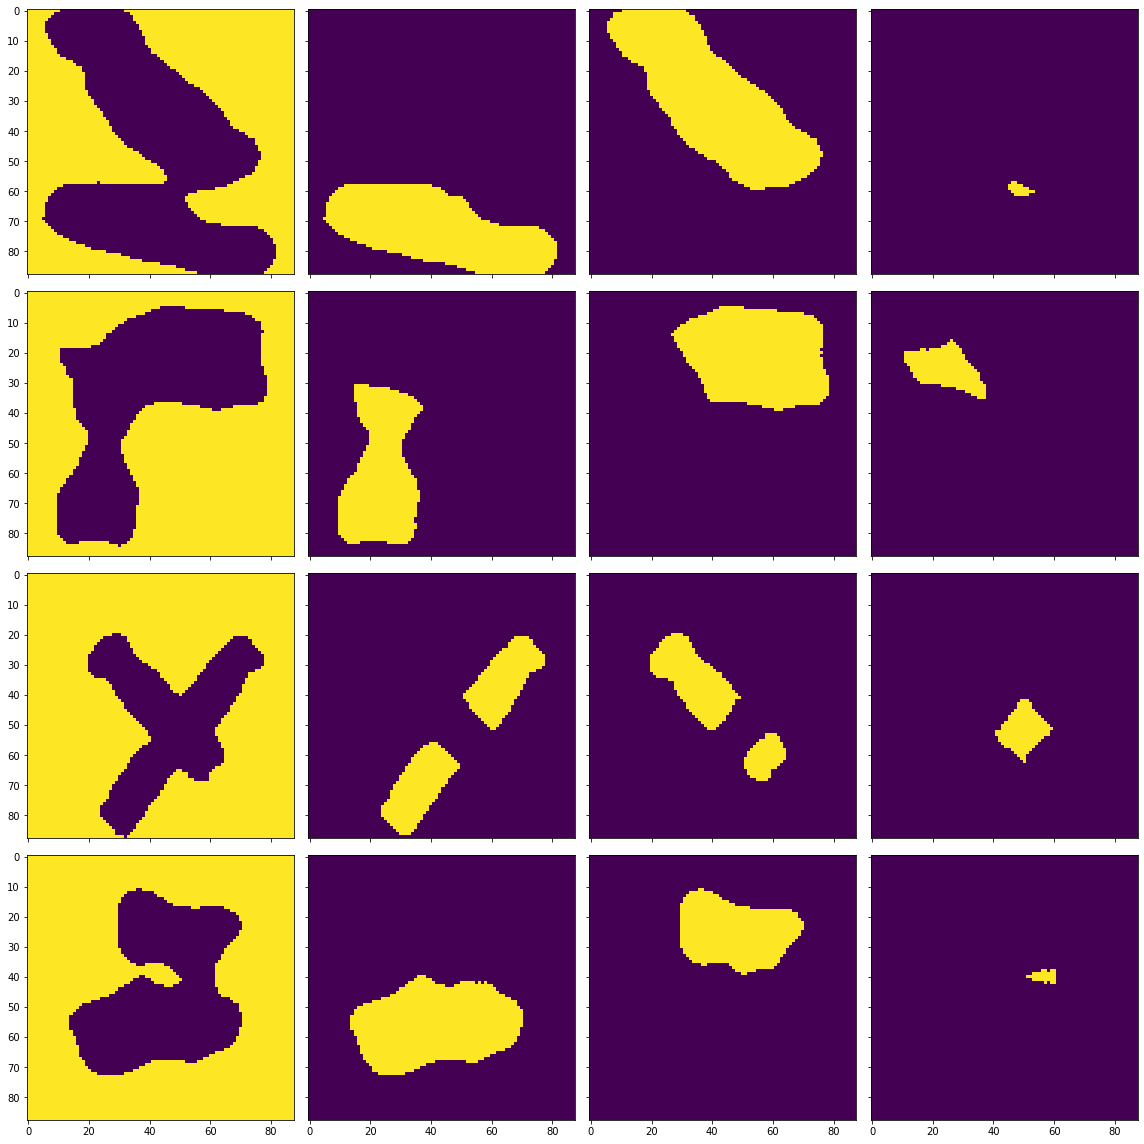

Training IOU: [0.9866176856468118, 0.953641329190195, 0.9565051517381705, 0.906315517686548]
Training accuracy: 0.9859077995867769
Testing IOU: [0.9723331505825829, 0.36500392492685363, 0.3136429208742276, 0.3428221269010083]
Testing accuracy: 0.8564992252066116
13/13 [==============================] - 1s 66ms/step - loss: 0.0059 - val_loss: 0.0601
INFO:tensorflow:Assets written to: modelunet/savedmodel_136epoch\assets
4
4


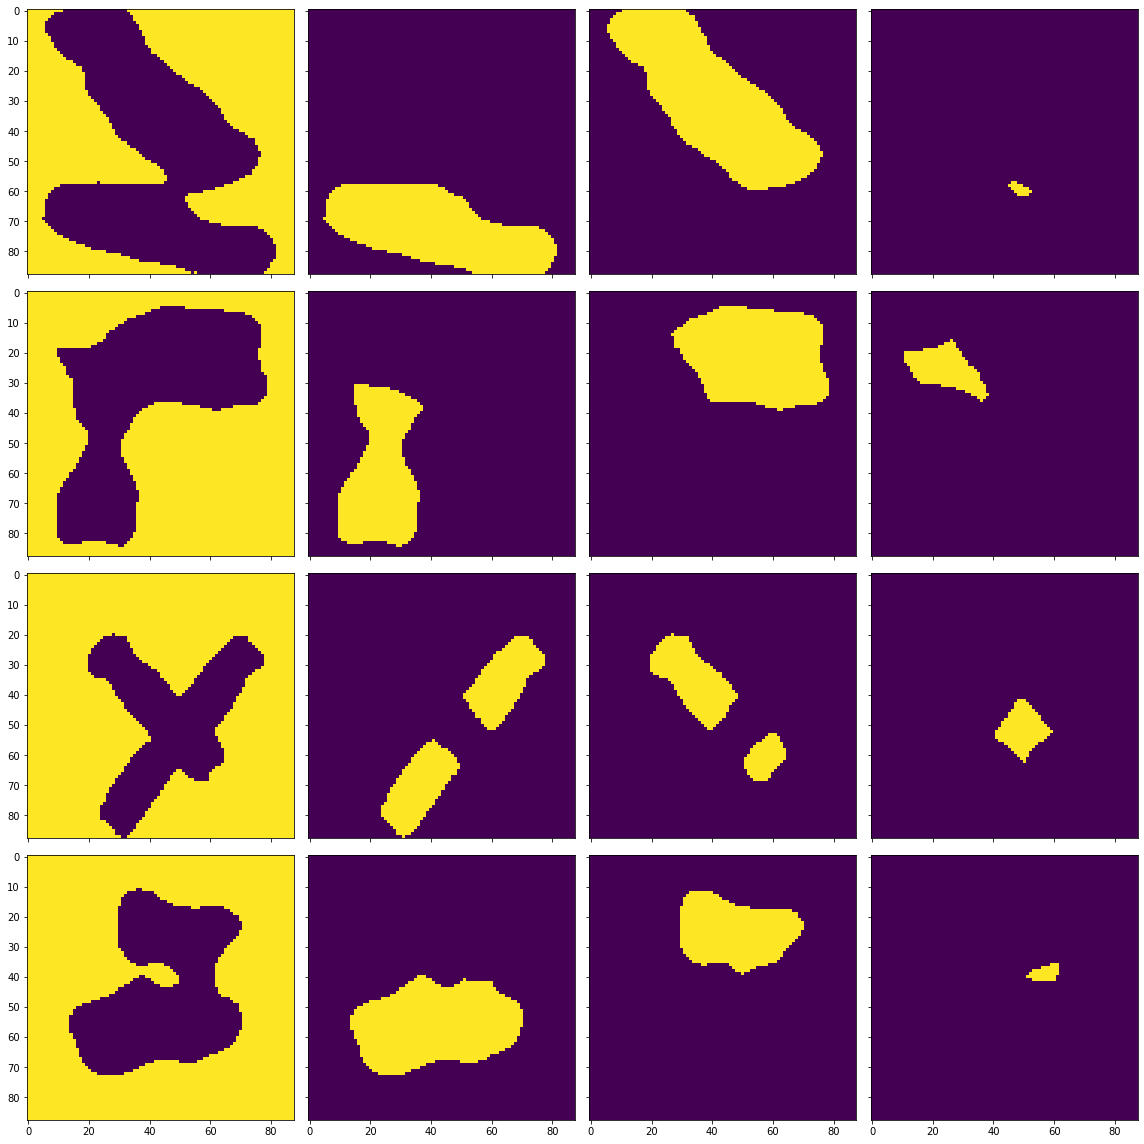

Training IOU: [0.9865968586387435, 0.9556414558654773, 0.9515430147379437, 0.9065192551187424]
Training accuracy: 0.9863491089876033
Testing IOU: [0.972494357927868, 0.3846485701763997, 0.29338116217110416, 0.34406623735050595]
Testing accuracy: 0.8581469524793388
13/13 [==============================] - 1s 67ms/step - loss: 0.0058 - val_loss: 0.0589
INFO:tensorflow:Assets written to: modelunet/savedmodel_137epoch\assets
4
4


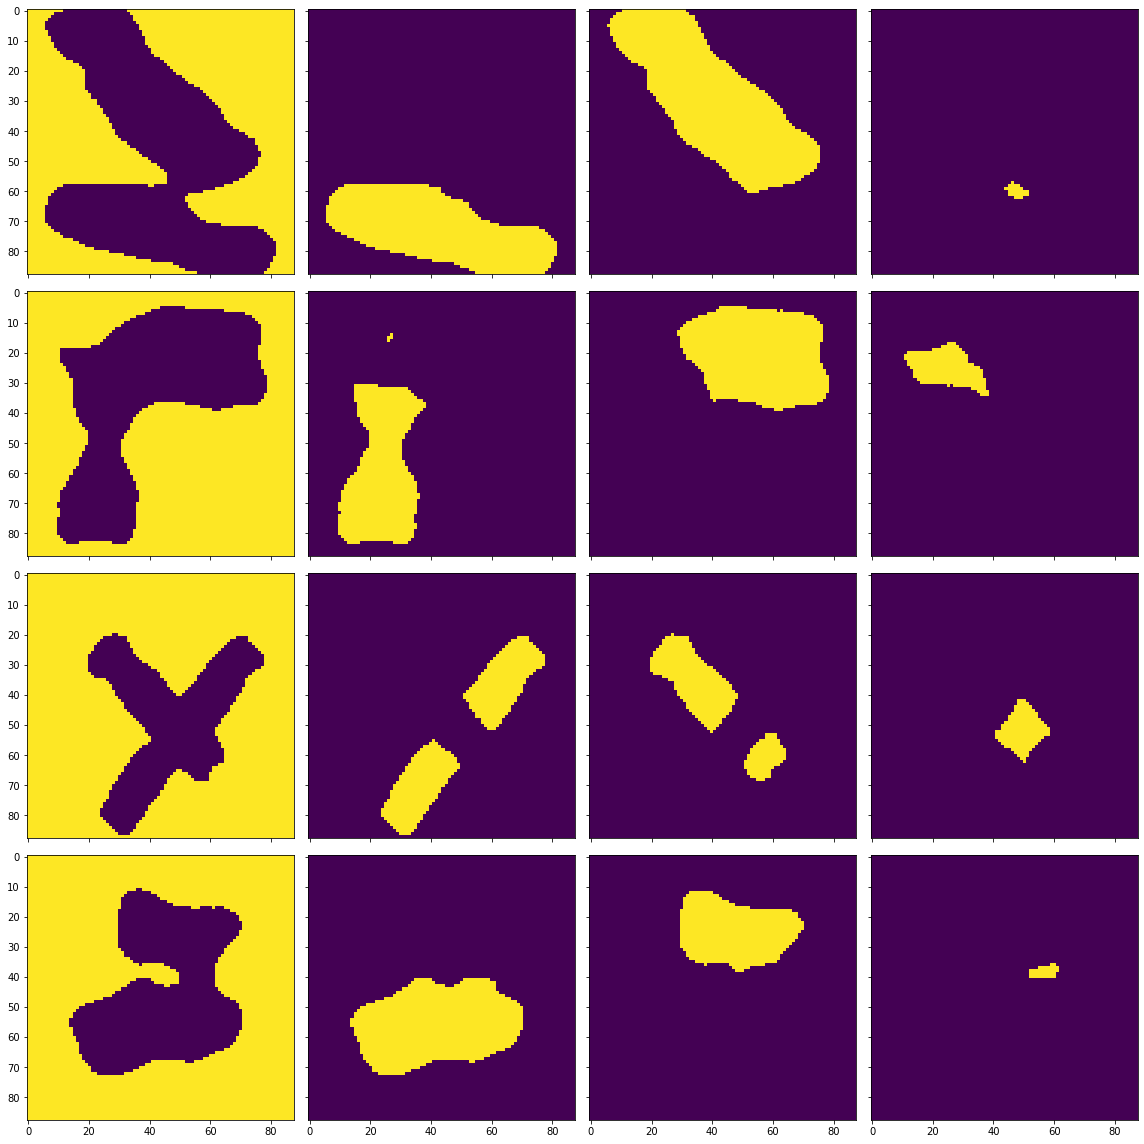

Training IOU: [0.9861181083830948, 0.9520221032636851, 0.9467600623973818, 0.9009579324537487]
Training accuracy: 0.9847165547520661
Testing IOU: [0.9714958307823642, 0.38761823698191955, 0.2888647264628254, 0.3613206977726806]
Testing accuracy: 0.8583432334710743
13/13 [==============================] - 1s 67ms/step - loss: 0.0058 - val_loss: 0.0599
INFO:tensorflow:Assets written to: modelunet/savedmodel_138epoch\assets
4
4


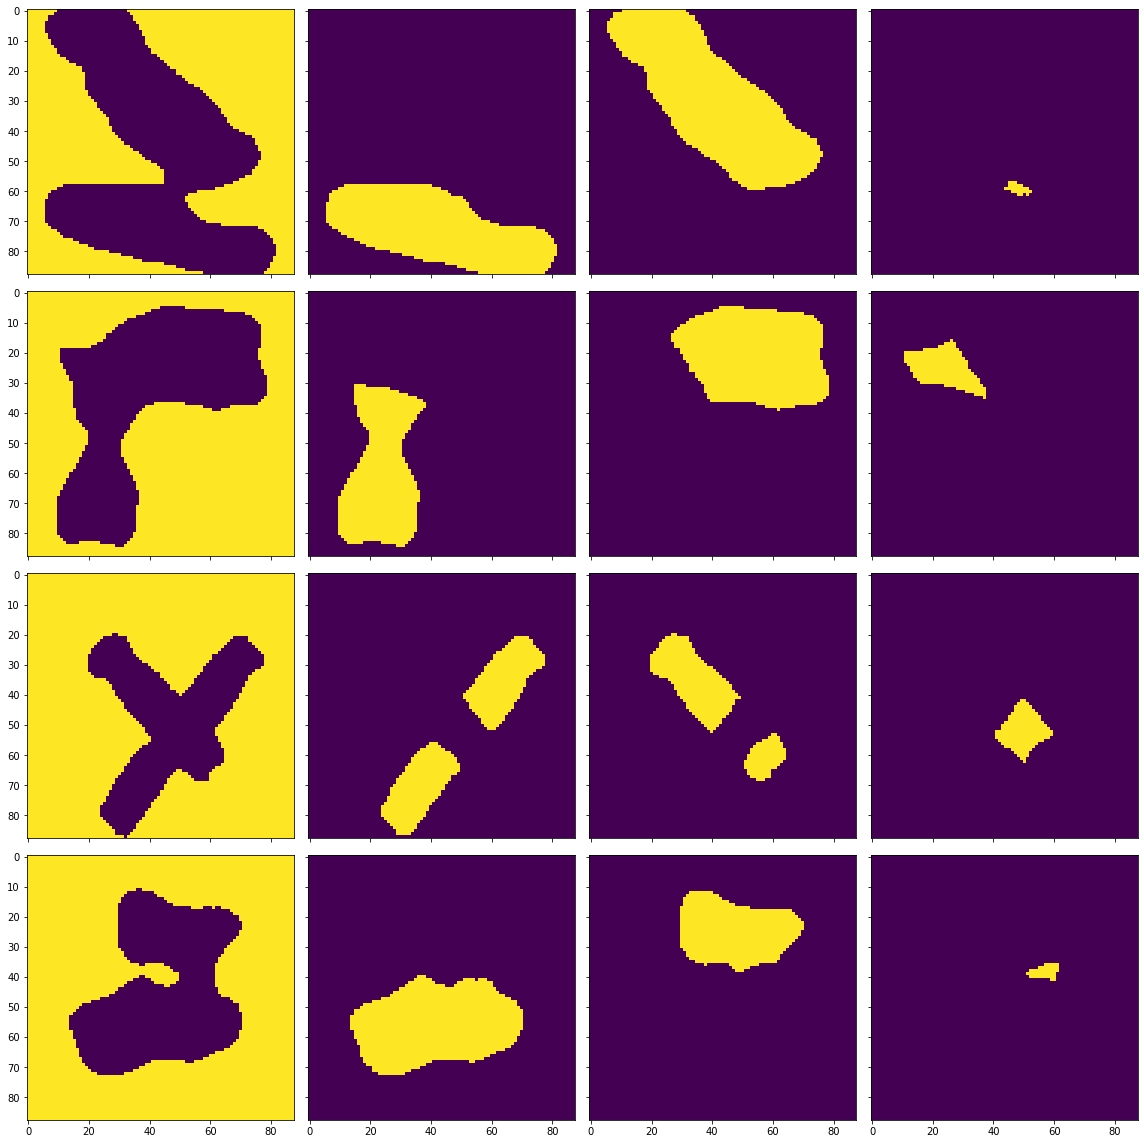

Training IOU: [0.9870347378959191, 0.9582090238352449, 0.9540372299524232, 0.9114119151970138]
Training accuracy: 0.9864165805785124
Testing IOU: [0.9721544195437667, 0.3795887228213753, 0.299570251880148, 0.34606827097605247]
Testing accuracy: 0.8575064566115702
13/13 [==============================] - 1s 67ms/step - loss: 0.0057 - val_loss: 0.0615- ETA: 0s - loss:  - ETA: 0s - loss: 0.005
INFO:tensorflow:Assets written to: modelunet/savedmodel_139epoch\assets
4
4


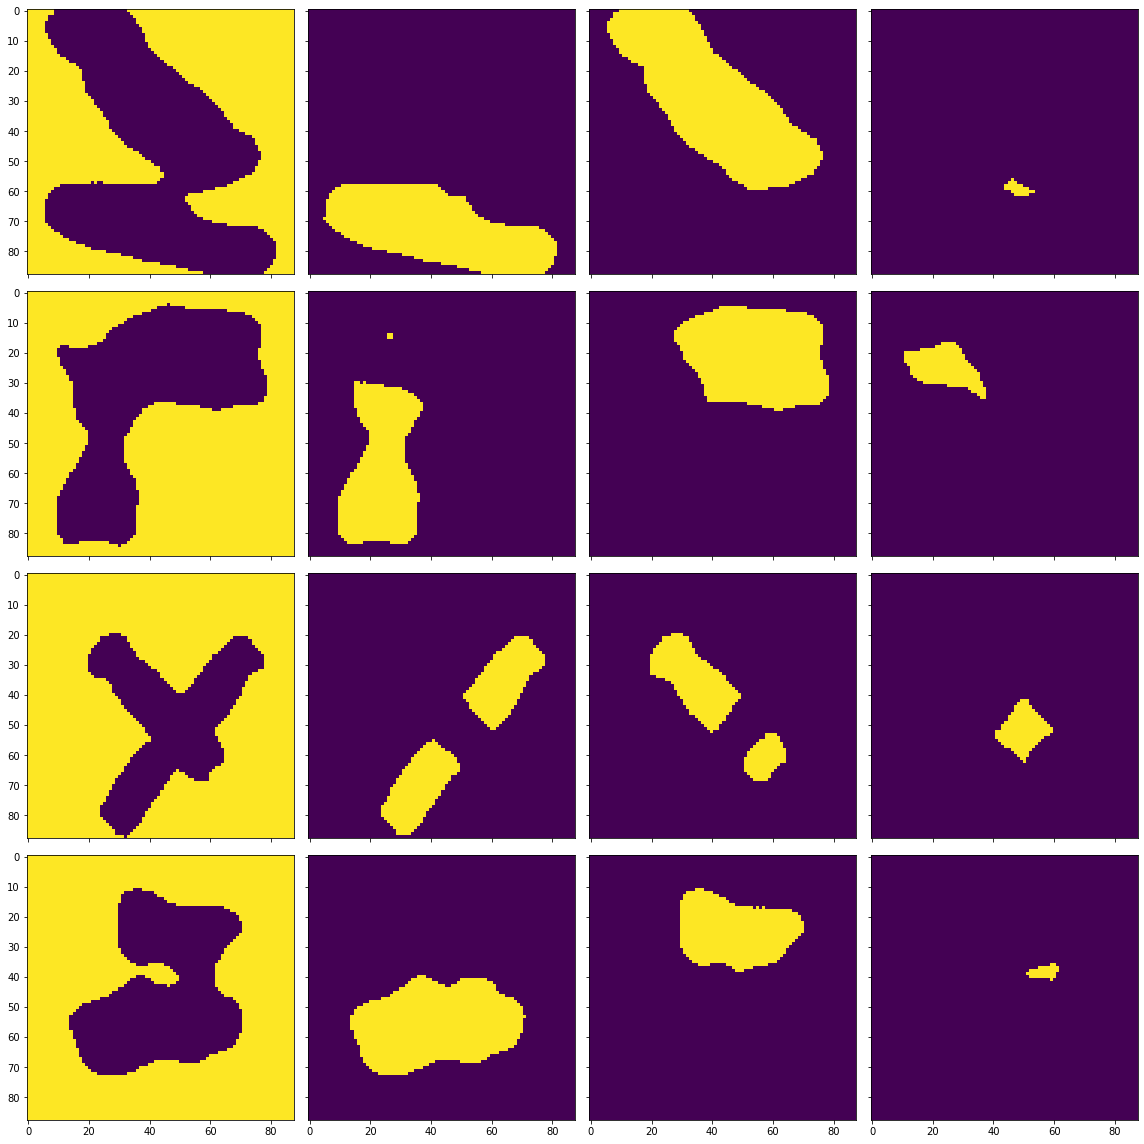

Training IOU: [0.9858136370508491, 0.9553046278030973, 0.9580782203317006, 0.9176193959661406]
Training accuracy: 0.986823992768595
Testing IOU: [0.9723162429658019, 0.38892944619940095, 0.30734376838884314, 0.3497791945719884]
Testing accuracy: 0.8596216425619835
13/13 [==============================] - ETA: 0s - loss: 0.005 - 1s 67ms/step - loss: 0.0057 - val_loss: 0.0595
INFO:tensorflow:Assets written to: modelunet/savedmodel_140epoch\assets
4
4


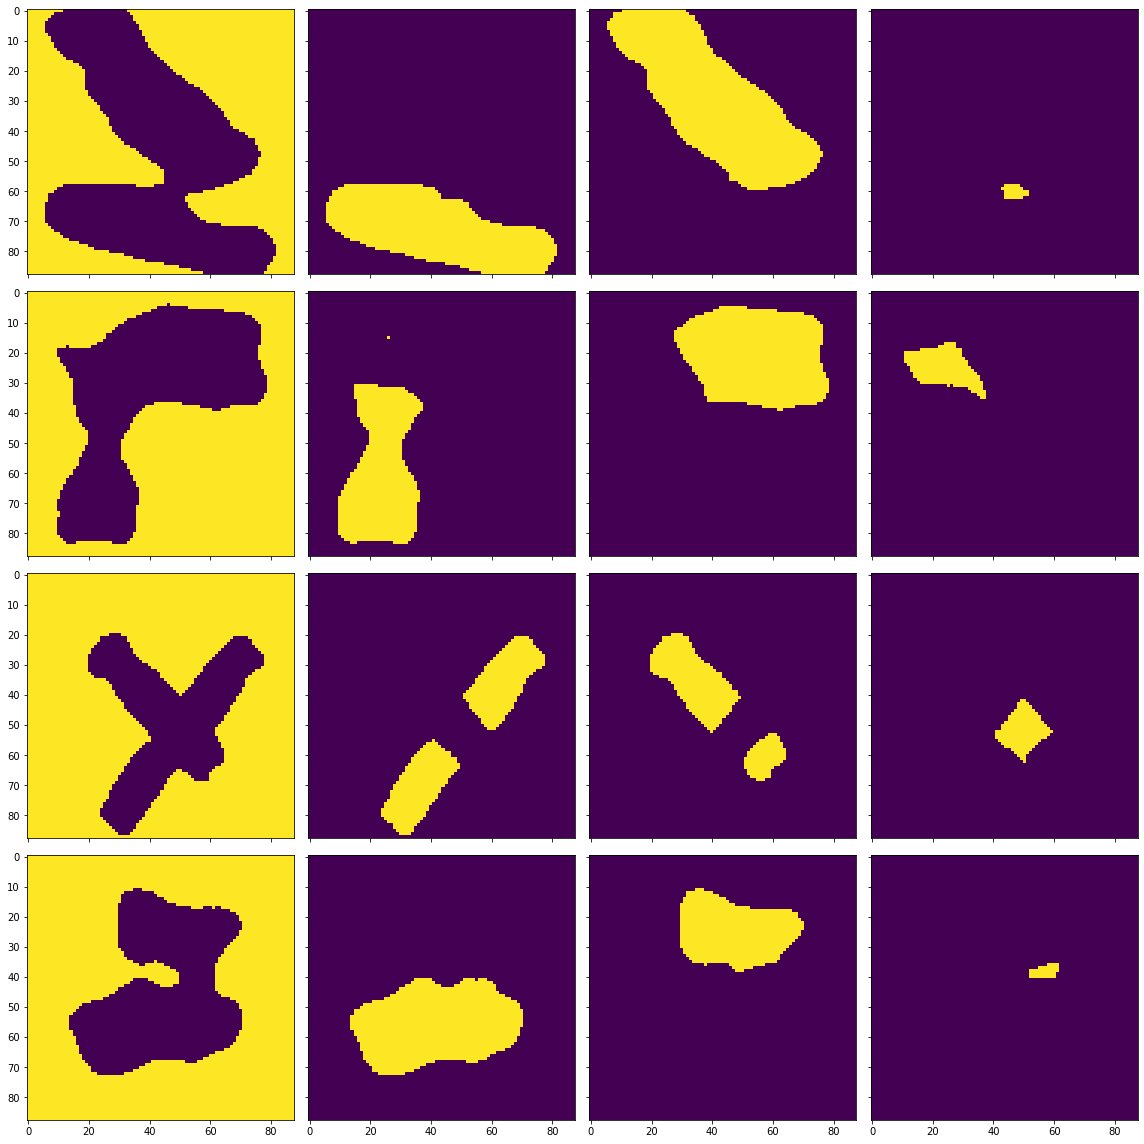

Training IOU: [0.9872641987306784, 0.9568975076931607, 0.9576989487858911, 0.9150898894072016]
Training accuracy: 0.9867742768595041
Testing IOU: [0.9717993886327133, 0.37633655180145464, 0.3031199159436009, 0.3516839940922649]
Testing accuracy: 0.8578615702479339
13/13 [==============================] - 1s 67ms/step - loss: 0.0055 - val_loss: 0.0640
INFO:tensorflow:Assets written to: modelunet/savedmodel_141epoch\assets
4
4


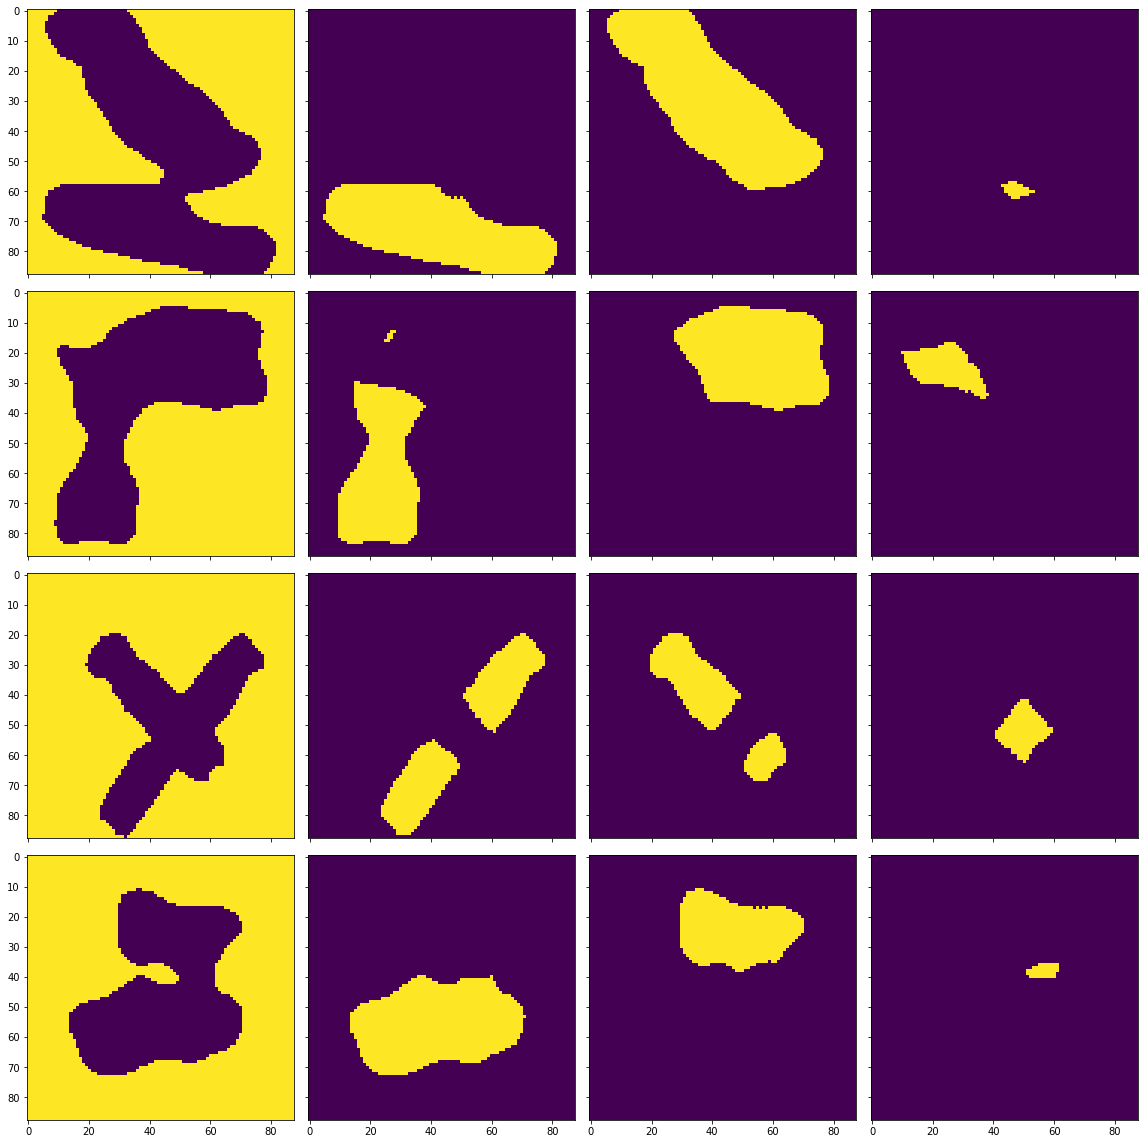

Training IOU: [0.9855711150439929, 0.9504390805269416, 0.9572514309285466, 0.9112468962980371]
Training accuracy: 0.9868162448347108
Testing IOU: [0.9724049679044756, 0.3949125915031587, 0.2876167520337451, 0.3399012089621483]
Testing accuracy: 0.8587073863636364
13/13 [==============================] - 1s 66ms/step - loss: 0.0059 - val_loss: 0.0631
INFO:tensorflow:Assets written to: modelunet/savedmodel_142epoch\assets
4
4


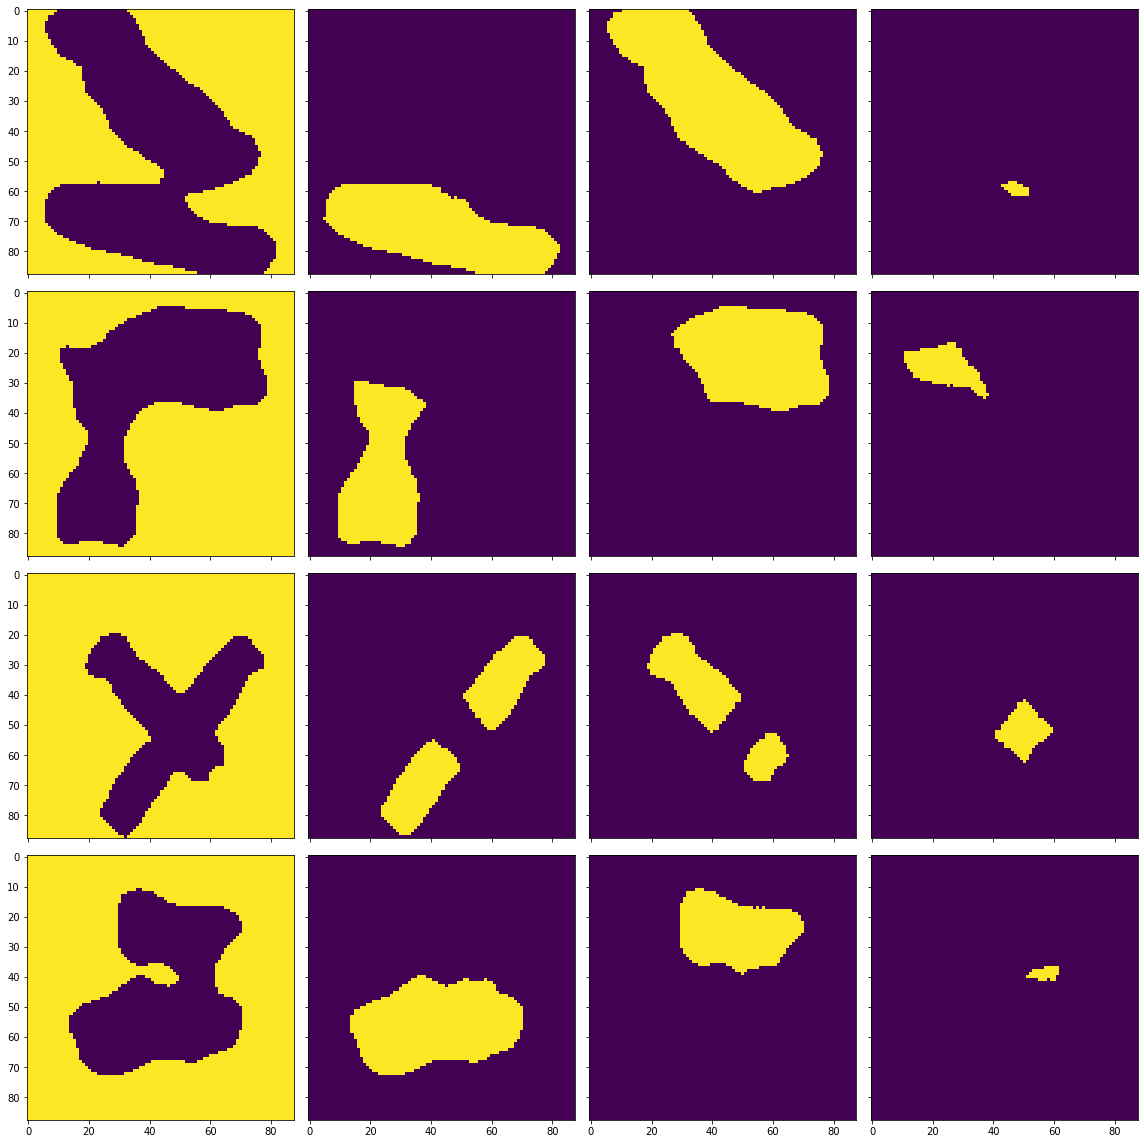

Training IOU: [0.9864227961773759, 0.9557200945669512, 0.9558522081913543, 0.9166903103096792]
Training accuracy: 0.9874528667355372
Testing IOU: [0.9728251726177365, 0.37845773025750334, 0.30692522146521717, 0.3455266892576824]
Testing accuracy: 0.858828770661157
13/13 [==============================] - 1s 66ms/step - loss: 0.0055 - val_loss: 0.0590
INFO:tensorflow:Assets written to: modelunet/savedmodel_143epoch\assets
4
4


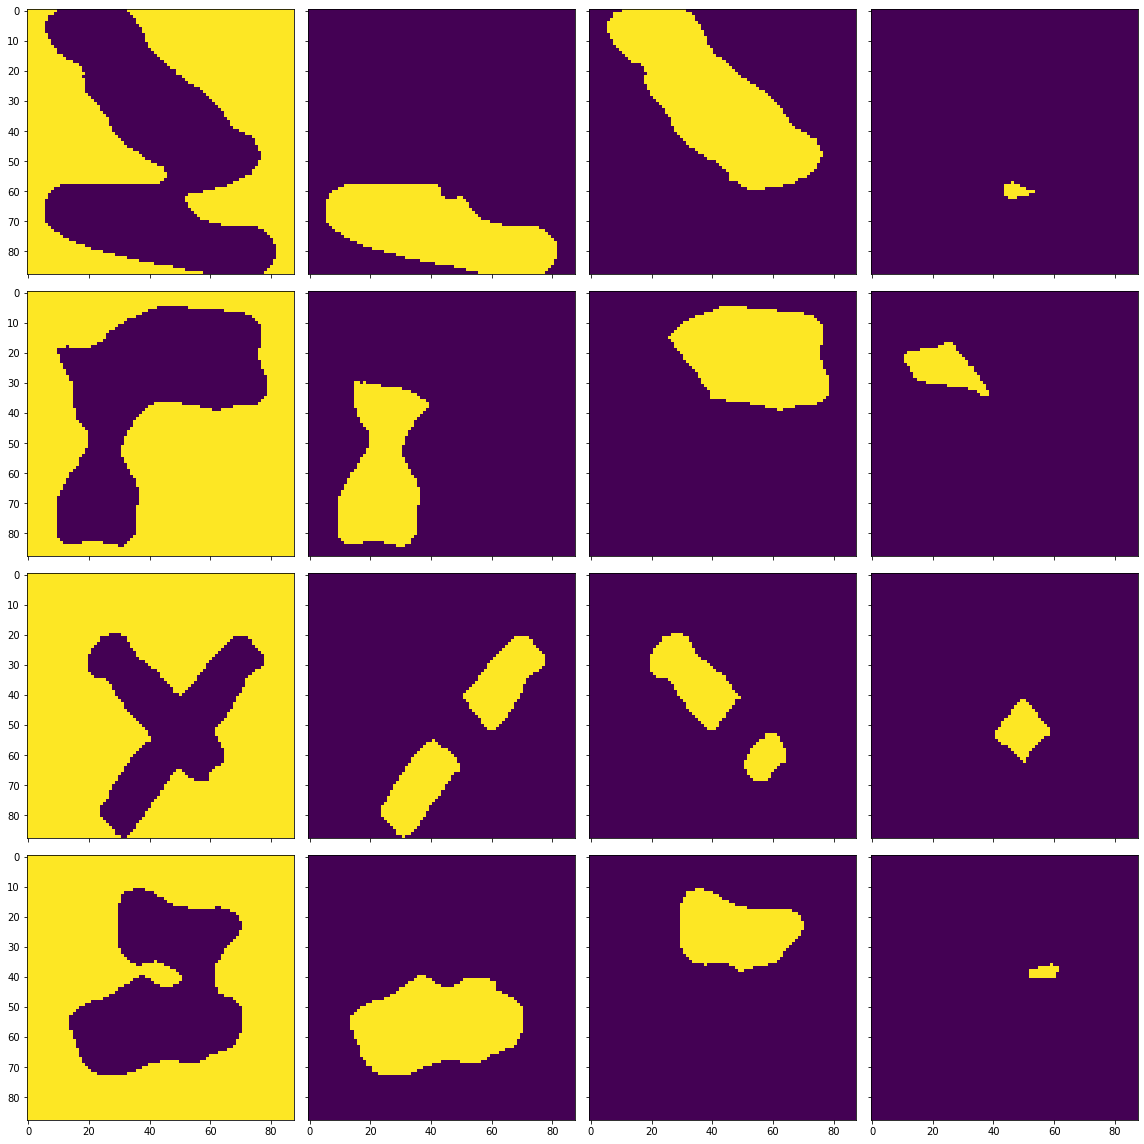

Training IOU: [0.9872708929249533, 0.9558867619402375, 0.9581787356664265, 0.8995405135186879]
Training accuracy: 0.9866067277892562
Testing IOU: [0.9724312122886737, 0.39478782069887214, 0.29583943669210805, 0.3663160586975287]
Testing accuracy: 0.8597830578512397
13/13 [==============================] - 1s 67ms/step - loss: 0.0054 - val_loss: 0.0601
INFO:tensorflow:Assets written to: modelunet/savedmodel_144epoch\assets
4
4


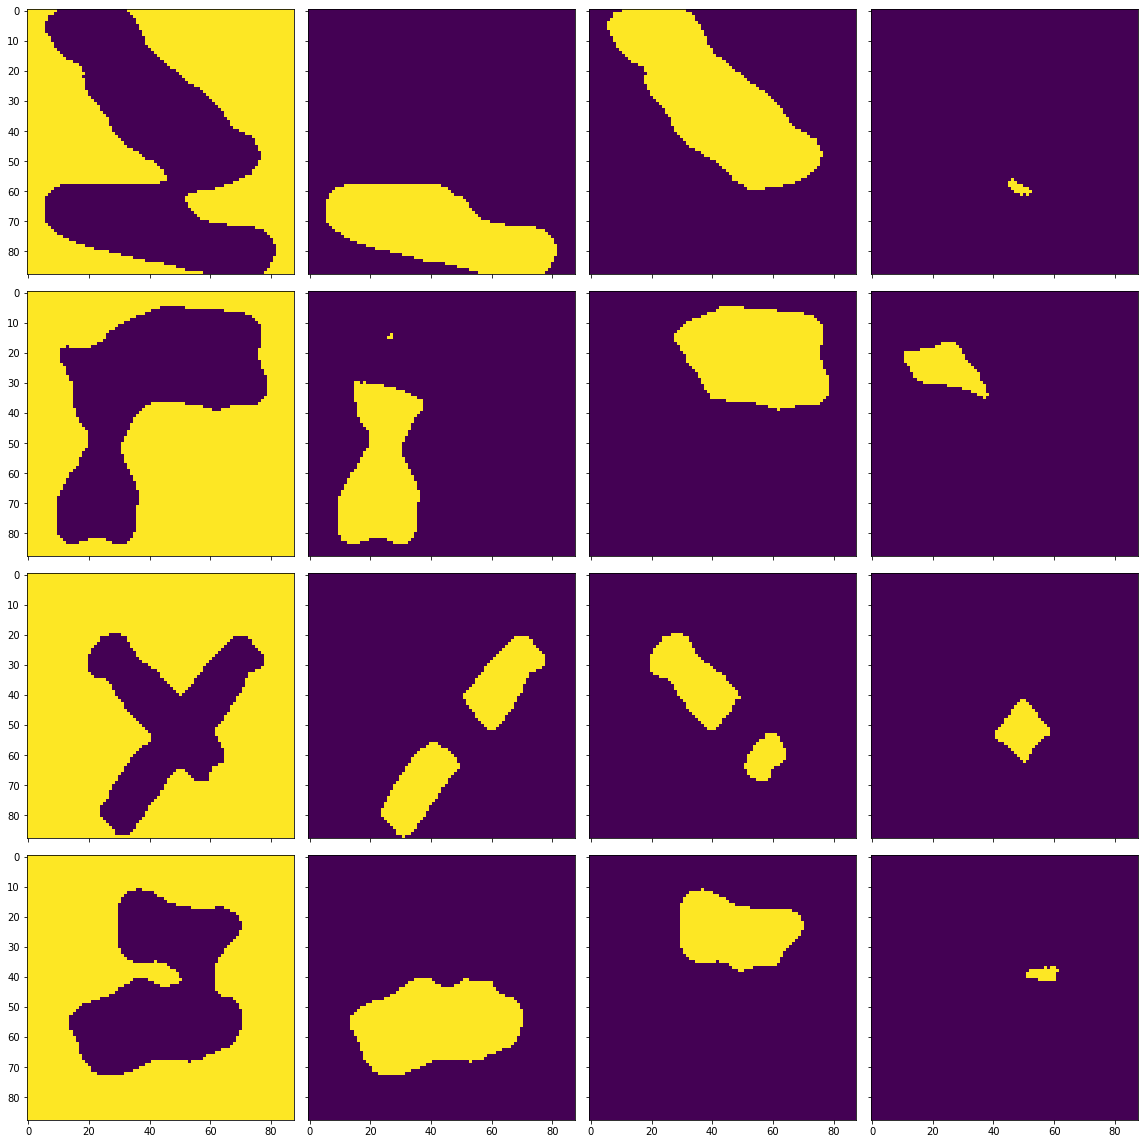

Training IOU: [0.9875657567236671, 0.9589280130952162, 0.957516108668205, 0.9131603540789432]
Training accuracy: 0.9872291451446281
Testing IOU: [0.9714484078325176, 0.3779112408839932, 0.2979686662298207, 0.35934583592569547]
Testing accuracy: 0.857762138429752
13/13 [==============================] - 1s 67ms/step - loss: 0.0054 - val_loss: 0.0620
INFO:tensorflow:Assets written to: modelunet/savedmodel_145epoch\assets
4
4


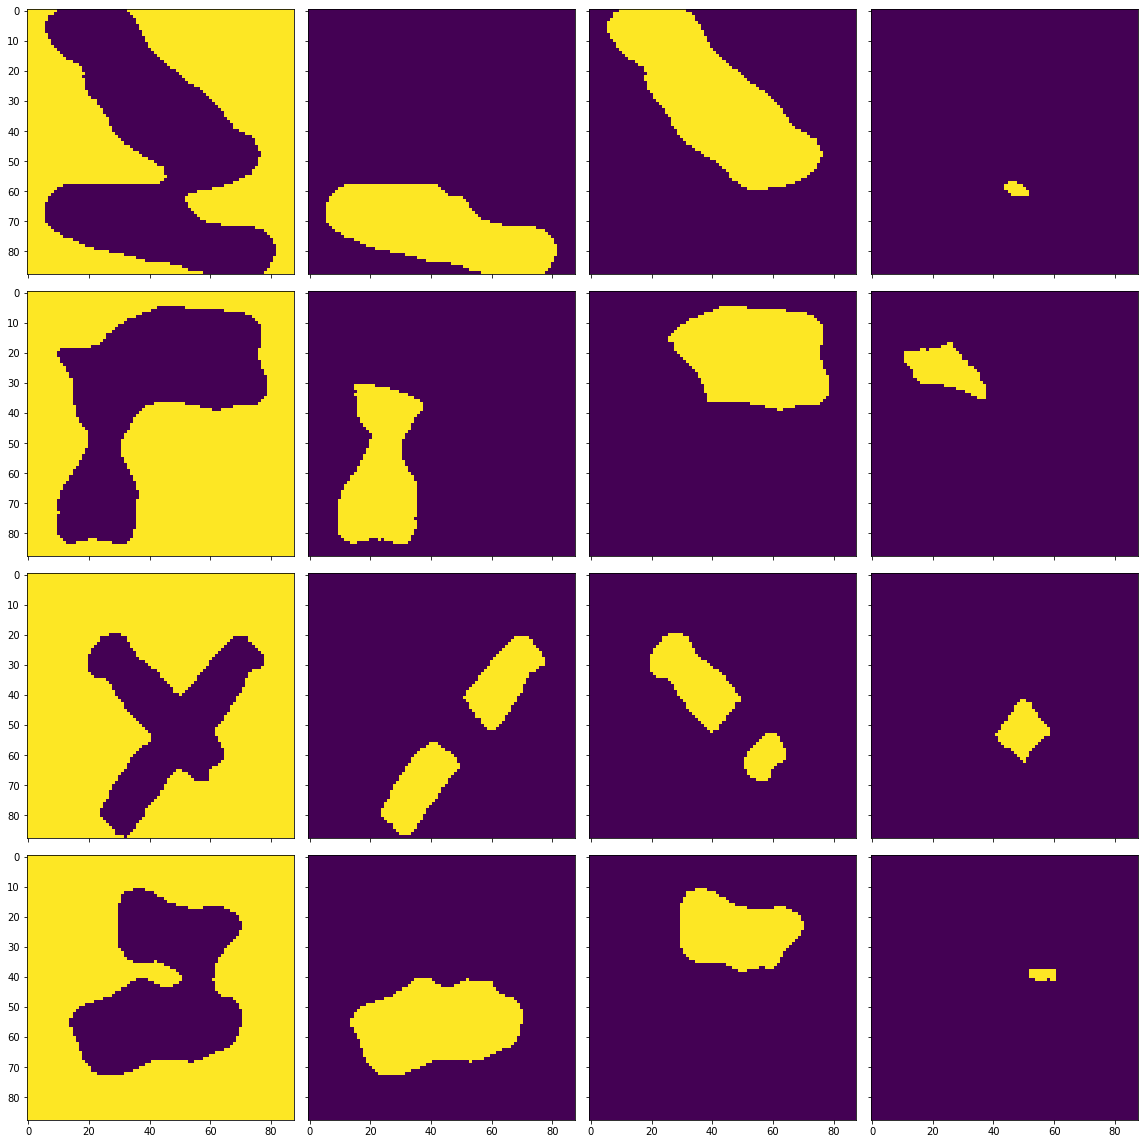

Training IOU: [0.986874058218603, 0.94864554184132, 0.9572961691240827, 0.9021783249898525]
Training accuracy: 0.9860782541322314
Testing IOU: [0.9711824759092054, 0.35234186348375307, 0.32165203492341427, 0.35764031134780827]
Testing accuracy: 0.8572236570247934
13/13 [==============================] - 1s 67ms/step - loss: 0.0054 - val_loss: 0.0590
INFO:tensorflow:Assets written to: modelunet/savedmodel_146epoch\assets
4
4


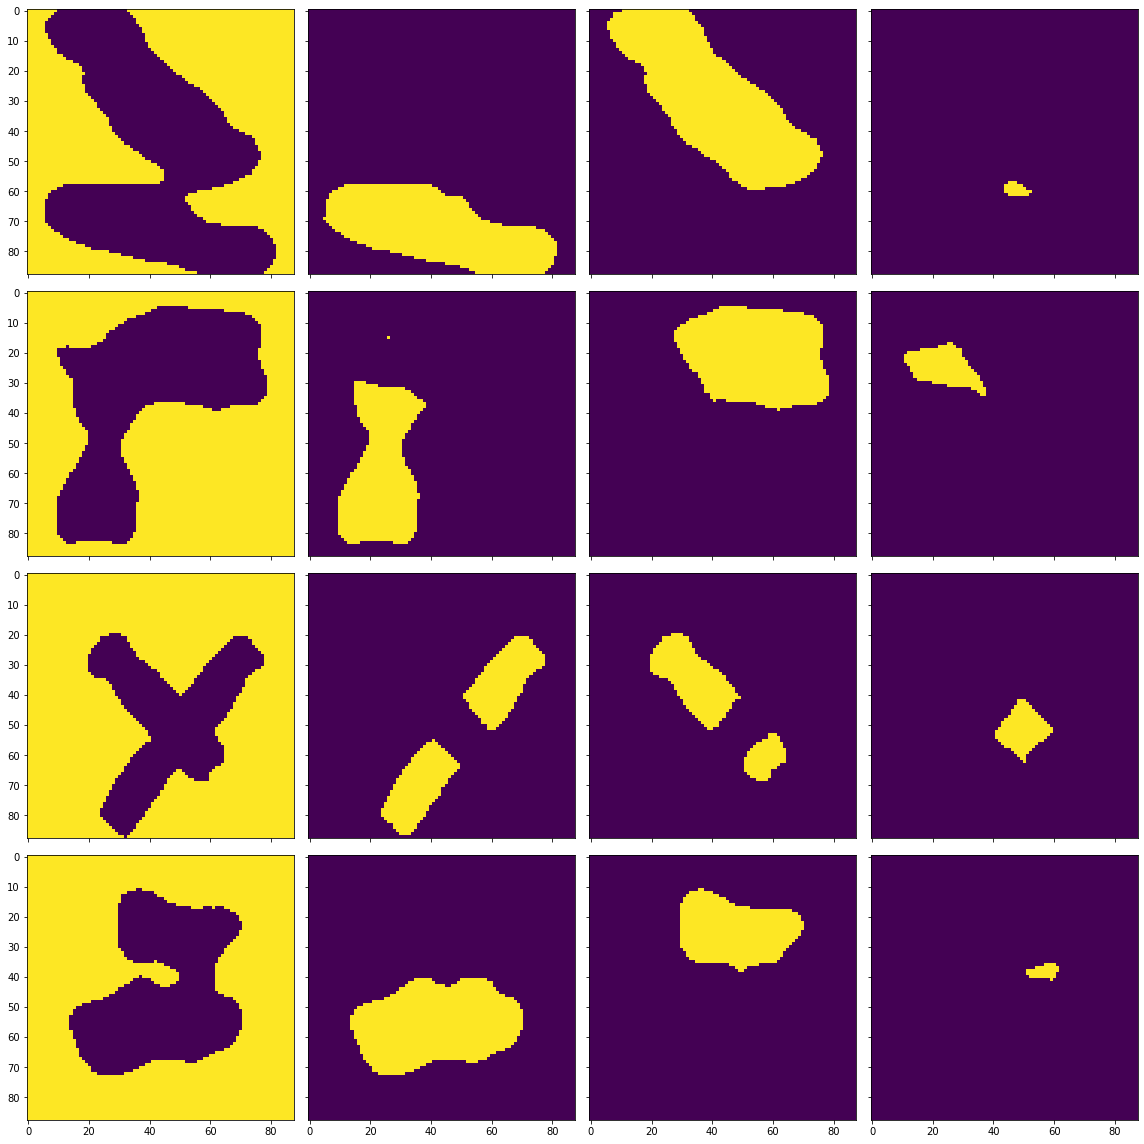

Training IOU: [0.9882321452308842, 0.9611671246105561, 0.9602180811138179, 0.9099265682617613]
Training accuracy: 0.9873924974173554
Testing IOU: [0.9719915810445523, 0.39194722947832294, 0.3091738124404519, 0.3624732131602168]
Testing accuracy: 0.8605849690082644
13/13 [==============================] - ETA: 0s - loss: 0.005 - 1s 66ms/step - loss: 0.0053 - val_loss: 0.0598
INFO:tensorflow:Assets written to: modelunet/savedmodel_147epoch\assets
4
4


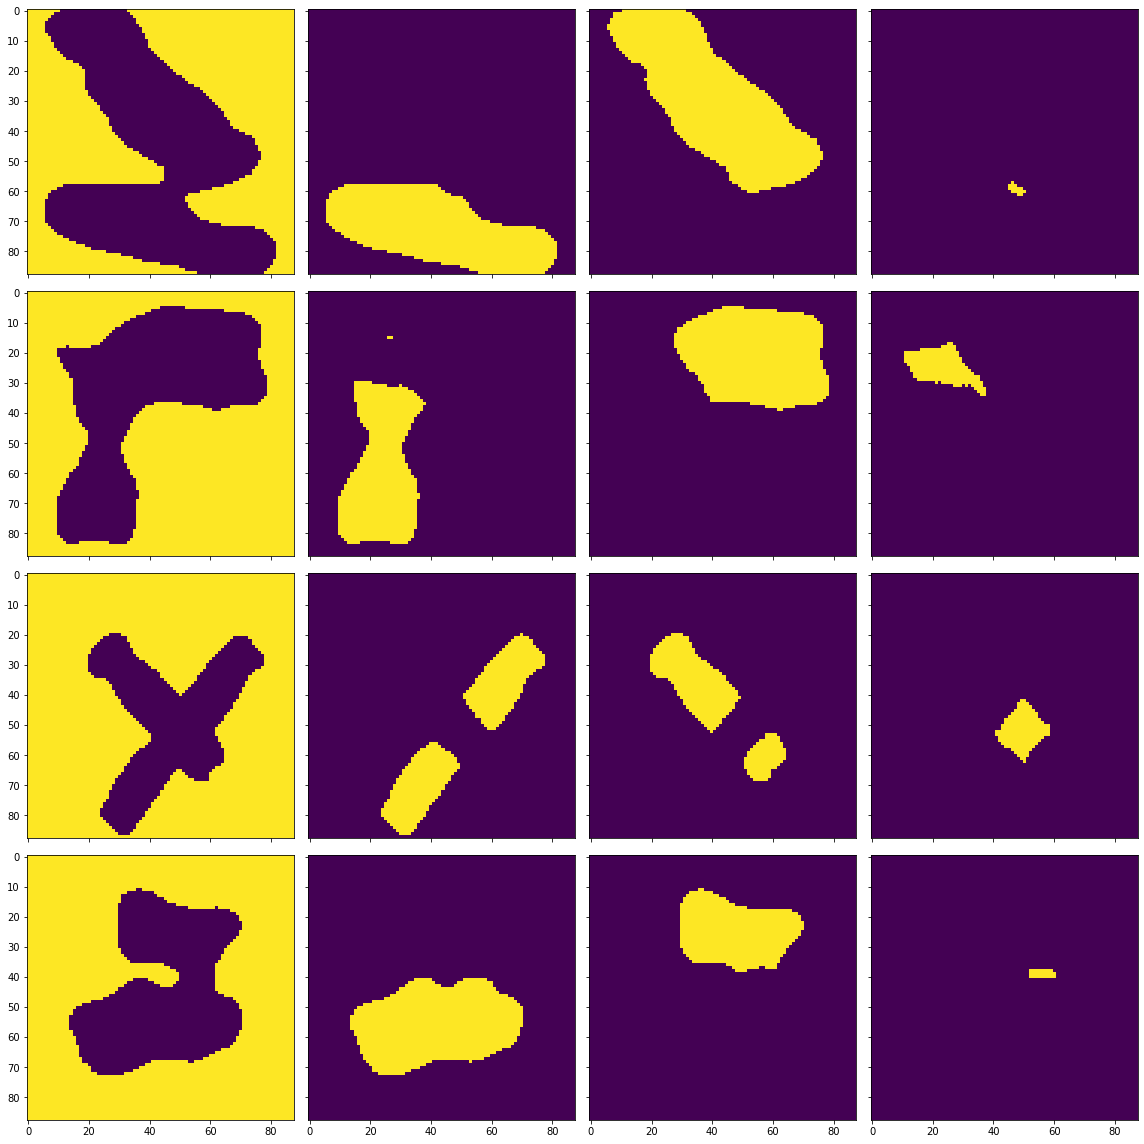

Training IOU: [0.9884234567041772, 0.9601906524417896, 0.9587914531619366, 0.8876098673523178]
Training accuracy: 0.9872623966942149
Testing IOU: [0.9718907382810338, 0.3858855353857139, 0.310817327679388, 0.37054237288135594]
Testing accuracy: 0.8606314566115703
13/13 [==============================] - 1s 67ms/step - loss: 0.0053 - val_loss: 0.0612
INFO:tensorflow:Assets written to: modelunet/savedmodel_148epoch\assets
4
4


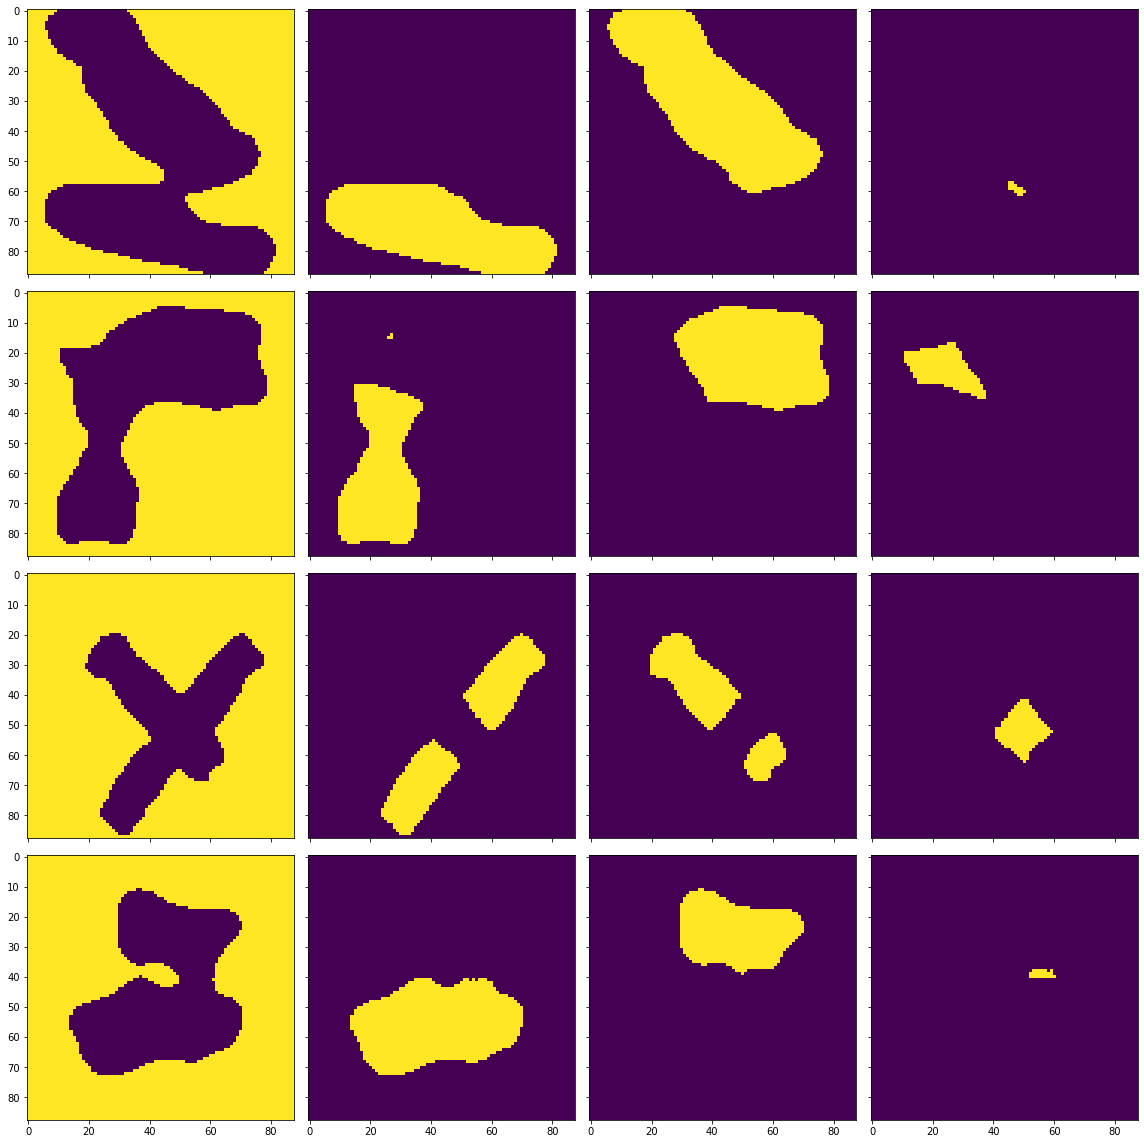

Training IOU: [0.9887122861404696, 0.9624410338030696, 0.962005592203491, 0.9170080460494527]
Training accuracy: 0.9883135330578512
Testing IOU: [0.971853998343641, 0.38557752969251446, 0.29379214057072806, 0.3530580767633624]
Testing accuracy: 0.8583923037190082
13/13 [==============================] - 1s 67ms/step - loss: 0.0051 - val_loss: 0.0594
INFO:tensorflow:Assets written to: modelunet/savedmodel_149epoch\assets
4
4


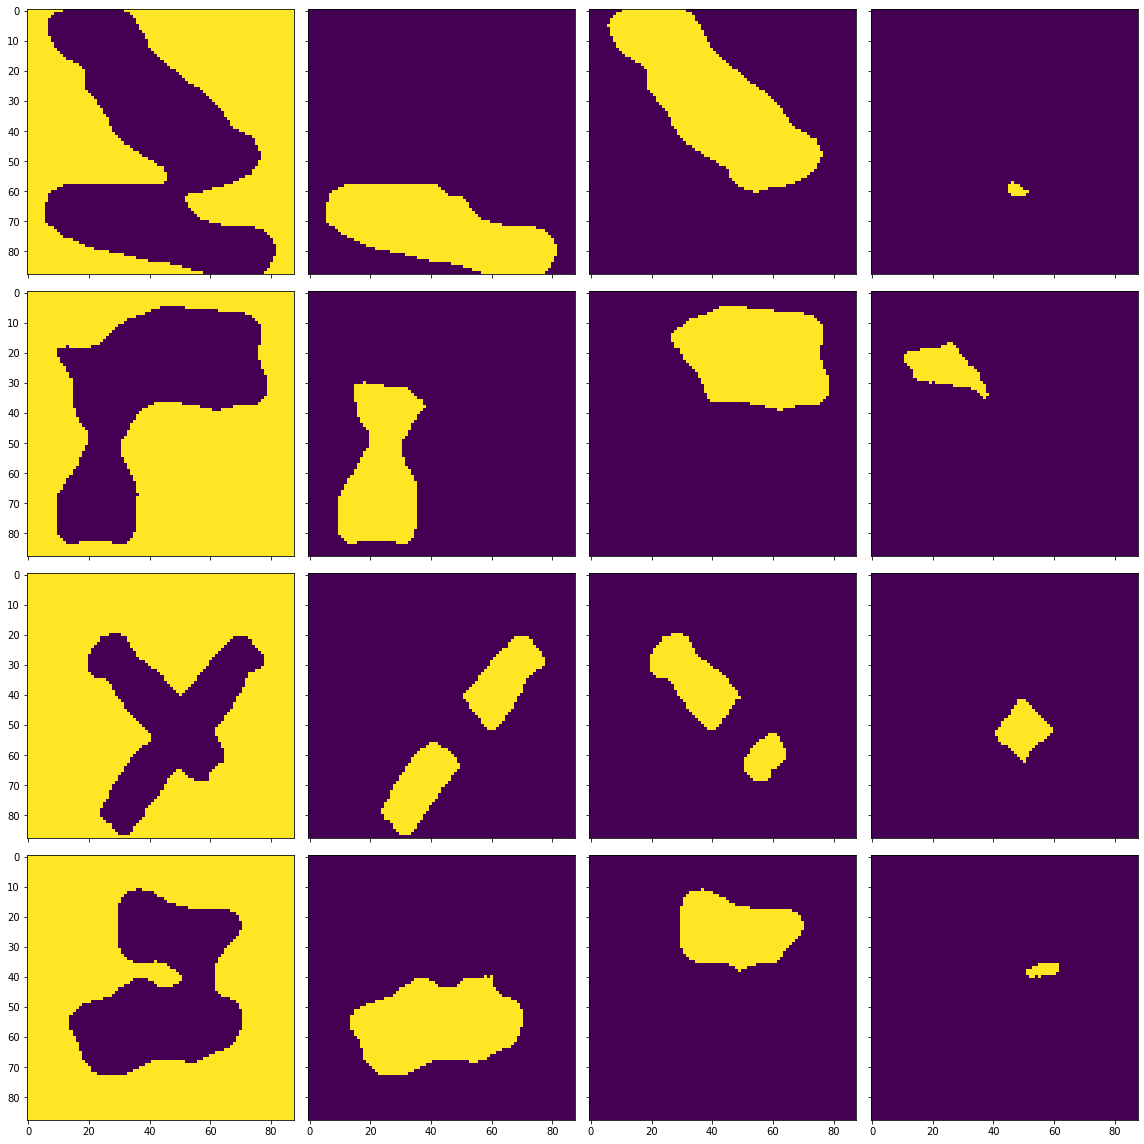

Training IOU: [0.9881913165406739, 0.9582239993335833, 0.9612185202905484, 0.9210239939143573]
Training accuracy: 0.9876501162190082
Testing IOU: [0.9711119775313464, 0.3777827622946223, 0.3098063076767062, 0.36062722993433877]
Testing accuracy: 0.8593633780991735
13/13 [==============================] - 1s 67ms/step - loss: 0.0050 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_150epoch\assets
4
4


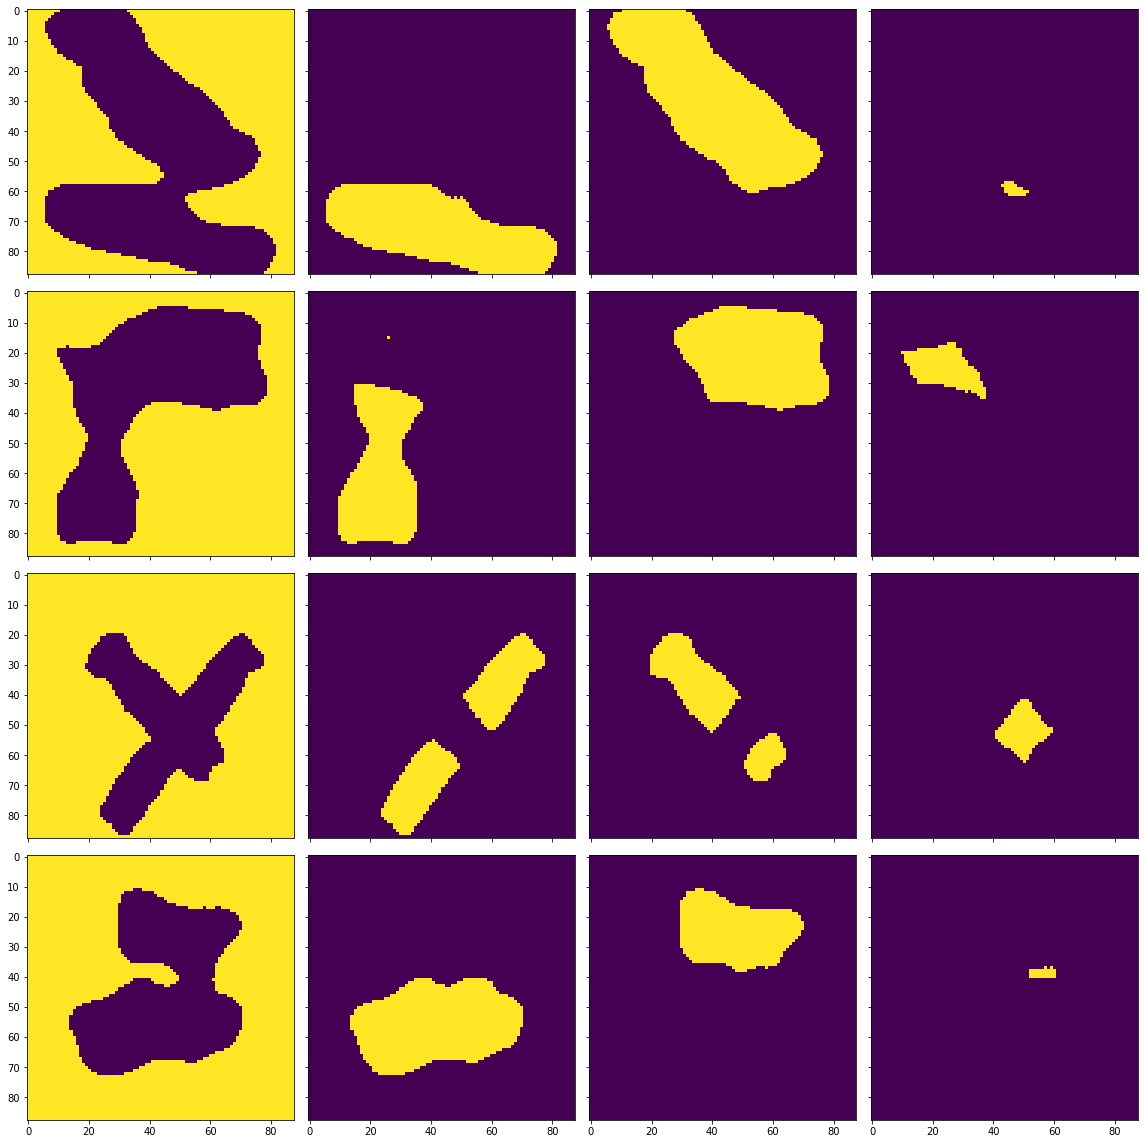

Training IOU: [0.9886620479835679, 0.9632656737513309, 0.963838201736221, 0.9241502308015107]
Training accuracy: 0.9884746255165289
Testing IOU: [0.9714996438968061, 0.37049245124542096, 0.31273158317928995, 0.3485342019543974]
Testing accuracy: 0.8579713326446281
13/13 [==============================] - 1s 67ms/step - loss: 0.0050 - val_loss: 0.0602
INFO:tensorflow:Assets written to: modelunet/savedmodel_151epoch\assets
4
4


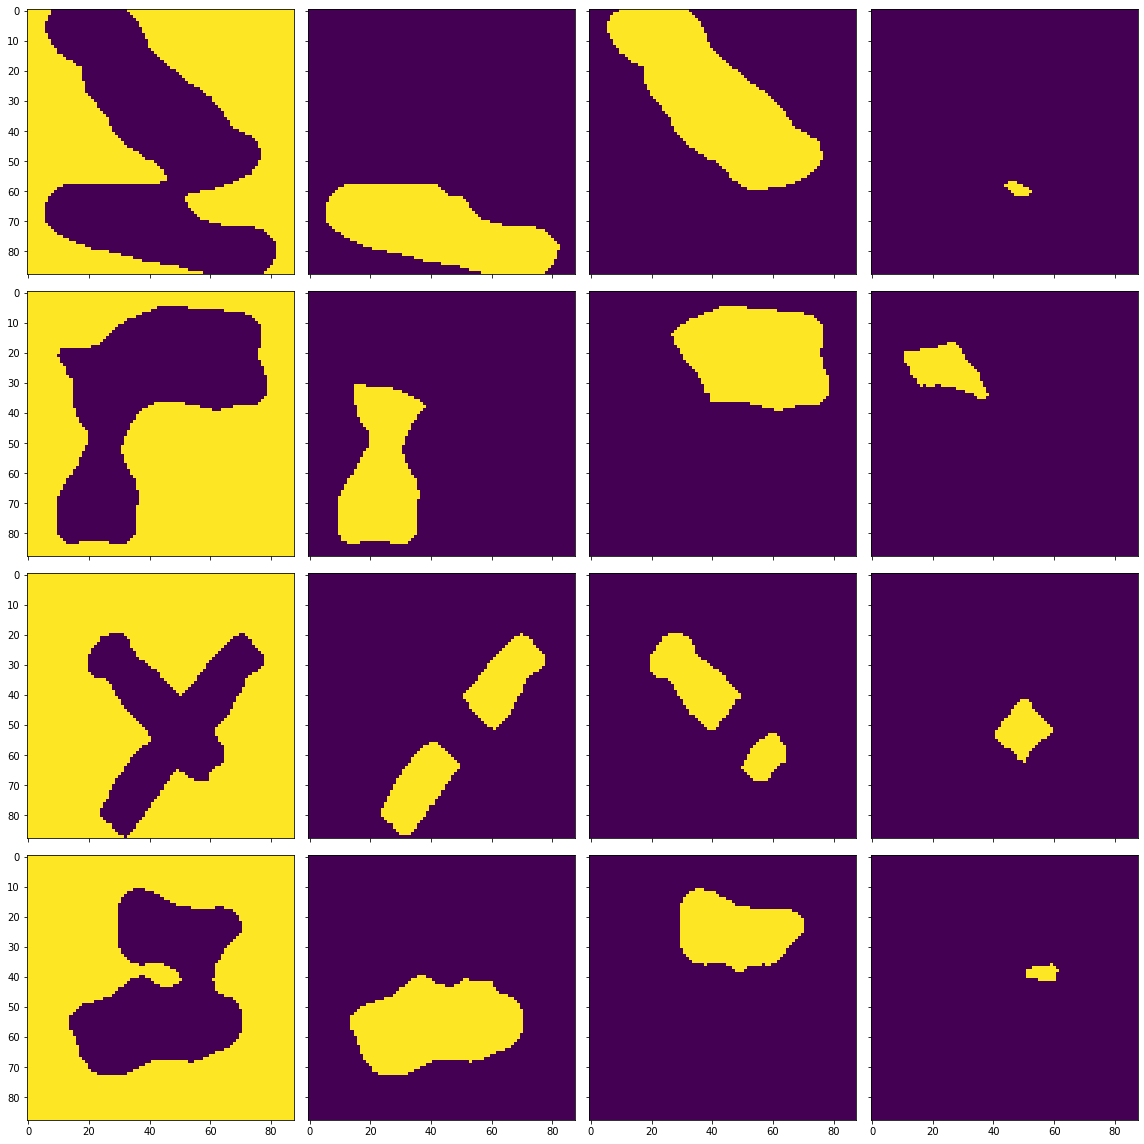

Training IOU: [0.9886007506888508, 0.9627821463048252, 0.9637601117572528, 0.9235264148393066]
Training accuracy: 0.9884084452479339
Testing IOU: [0.9716526633902979, 0.38225832338922966, 0.3054966674015908, 0.3494484466456551]
Testing accuracy: 0.858618285123967
13/13 [==============================] - 1s 67ms/step - loss: 0.0050 - val_loss: 0.0602
INFO:tensorflow:Assets written to: modelunet/savedmodel_152epoch\assets
4
4


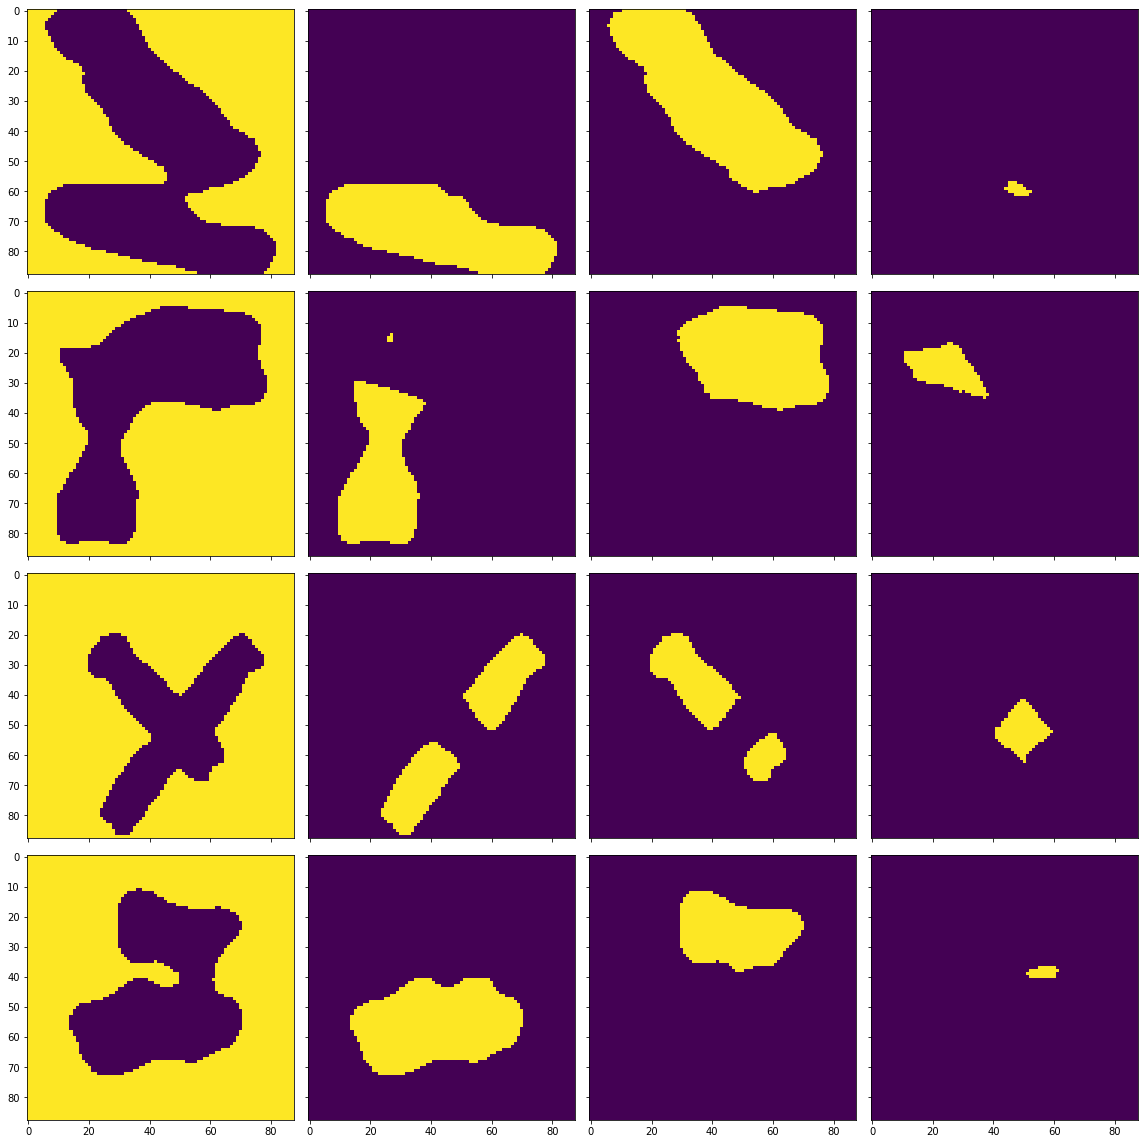

Training IOU: [0.9890060389616216, 0.9631520307443179, 0.9596140295295268, 0.9212234420002504]
Training accuracy: 0.9883545325413223
Testing IOU: [0.9712608259577854, 0.392916615058558, 0.291163382072473, 0.3515311780261025]
Testing accuracy: 0.8594124483471074
13/13 [==============================] - 1s 67ms/step - loss: 0.0050 - val_loss: 0.0623
INFO:tensorflow:Assets written to: modelunet/savedmodel_153epoch\assets
4
4


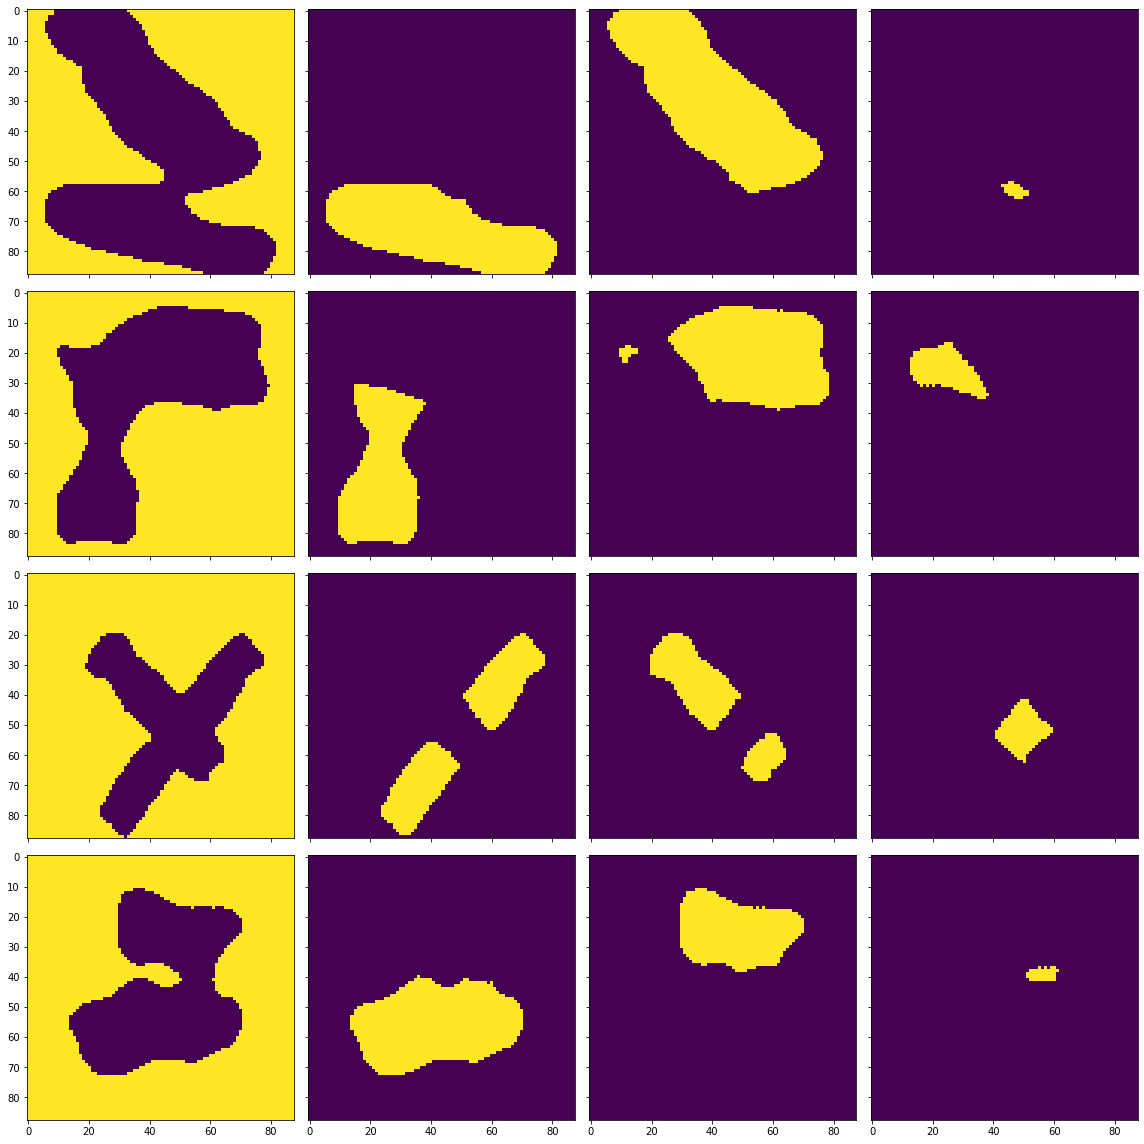

Training IOU: [0.9886656605883894, 0.9620249652618024, 0.9628041172800998, 0.9116078415221779]
Training accuracy: 0.9884956095041322
Testing IOU: [0.9715144659048844, 0.3630245617043165, 0.3196749344494569, 0.3438154558483078]
Testing accuracy: 0.8576924070247934
13/13 [==============================] - 1s 66ms/step - loss: 0.0050 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelunet/savedmodel_154epoch\assets
4
4


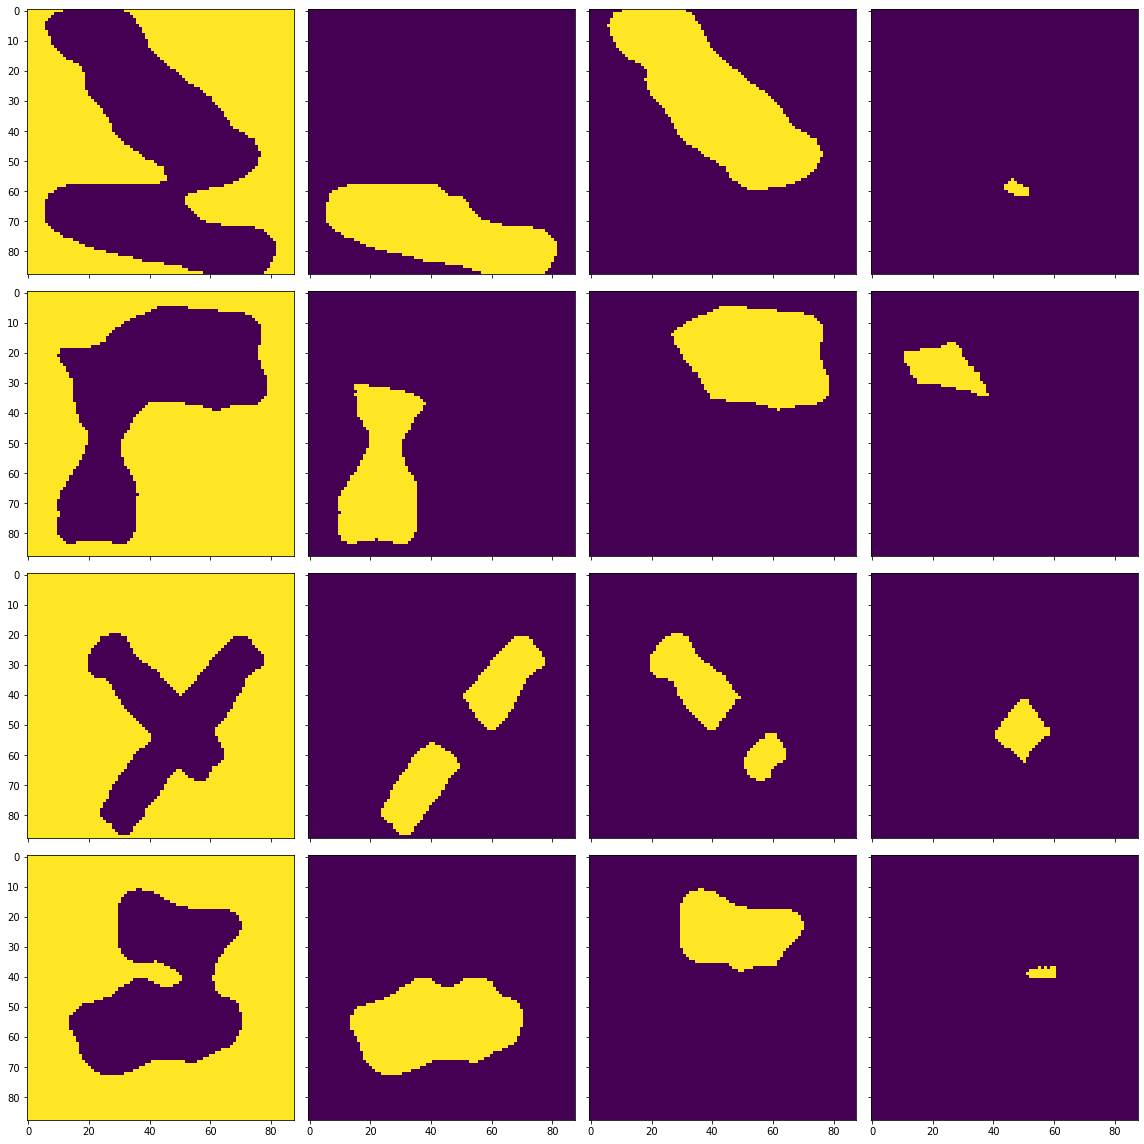

Training IOU: [0.9886870191848683, 0.958294682943119, 0.9622195953749372, 0.9178848621248133]
Training accuracy: 0.9879713326446281
Testing IOU: [0.9705004680413117, 0.37971315647223175, 0.3081955343010137, 0.35682713413717415]
Testing accuracy: 0.8594085743801653
13/13 [==============================] - 1s 66ms/step - loss: 0.0051 - val_loss: 0.0607
INFO:tensorflow:Assets written to: modelunet/savedmodel_155epoch\assets
4
4


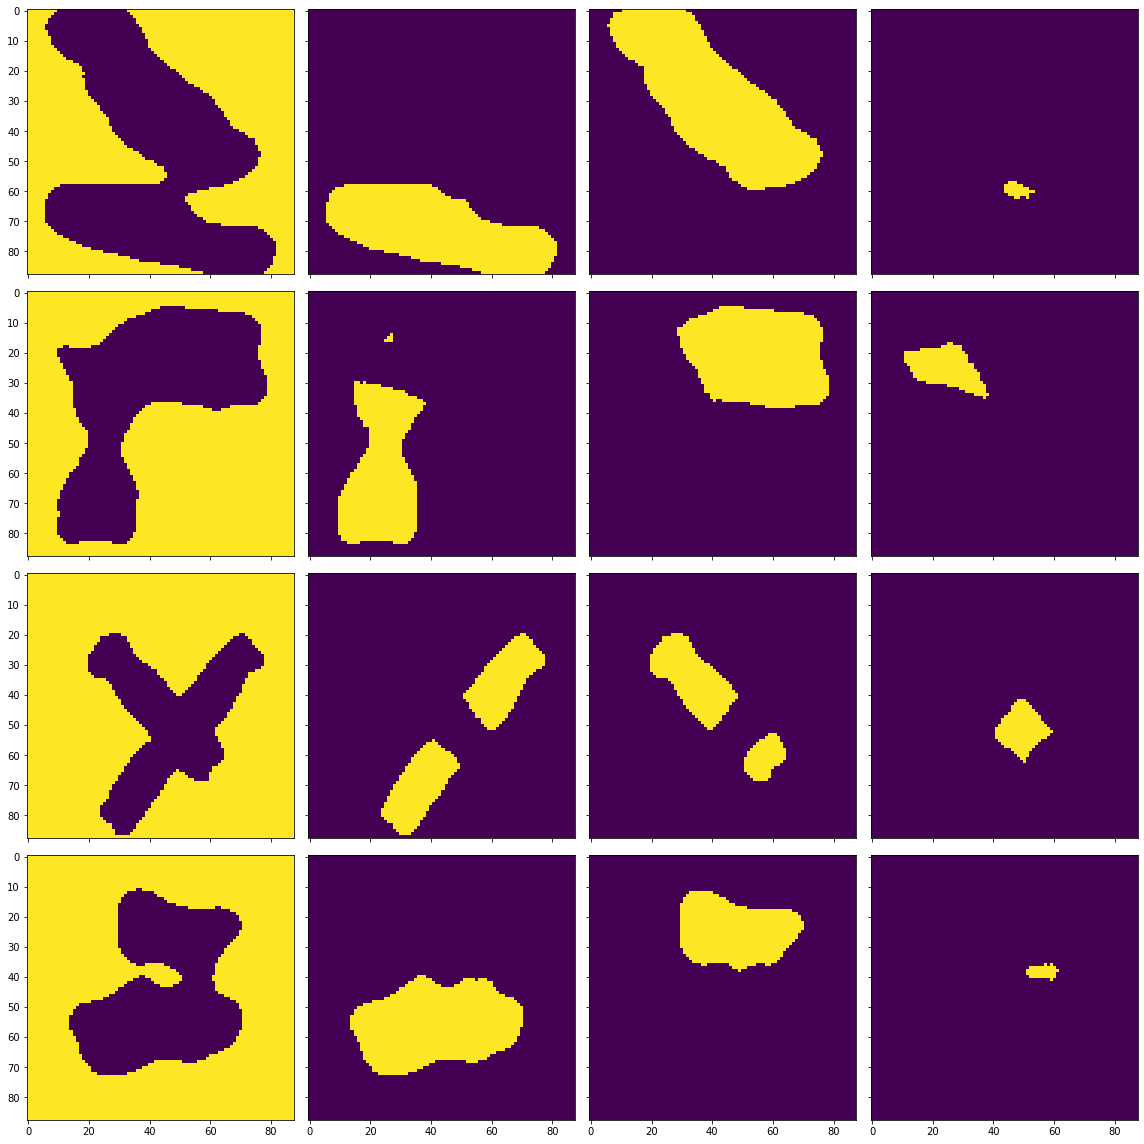

Training IOU: [0.9891084013590473, 0.9621757036743405, 0.9622699520041792, 0.9153613403865549]
Training accuracy: 0.9887319214876034
Testing IOU: [0.9714280777537797, 0.3936440940972007, 0.30548915679345945, 0.35530969695254805]
Testing accuracy: 0.8614695247933885
13/13 [==============================] - 1s 67ms/step - loss: 0.0053 - val_loss: 0.0631
INFO:tensorflow:Assets written to: modelunet/savedmodel_156epoch\assets
4
4


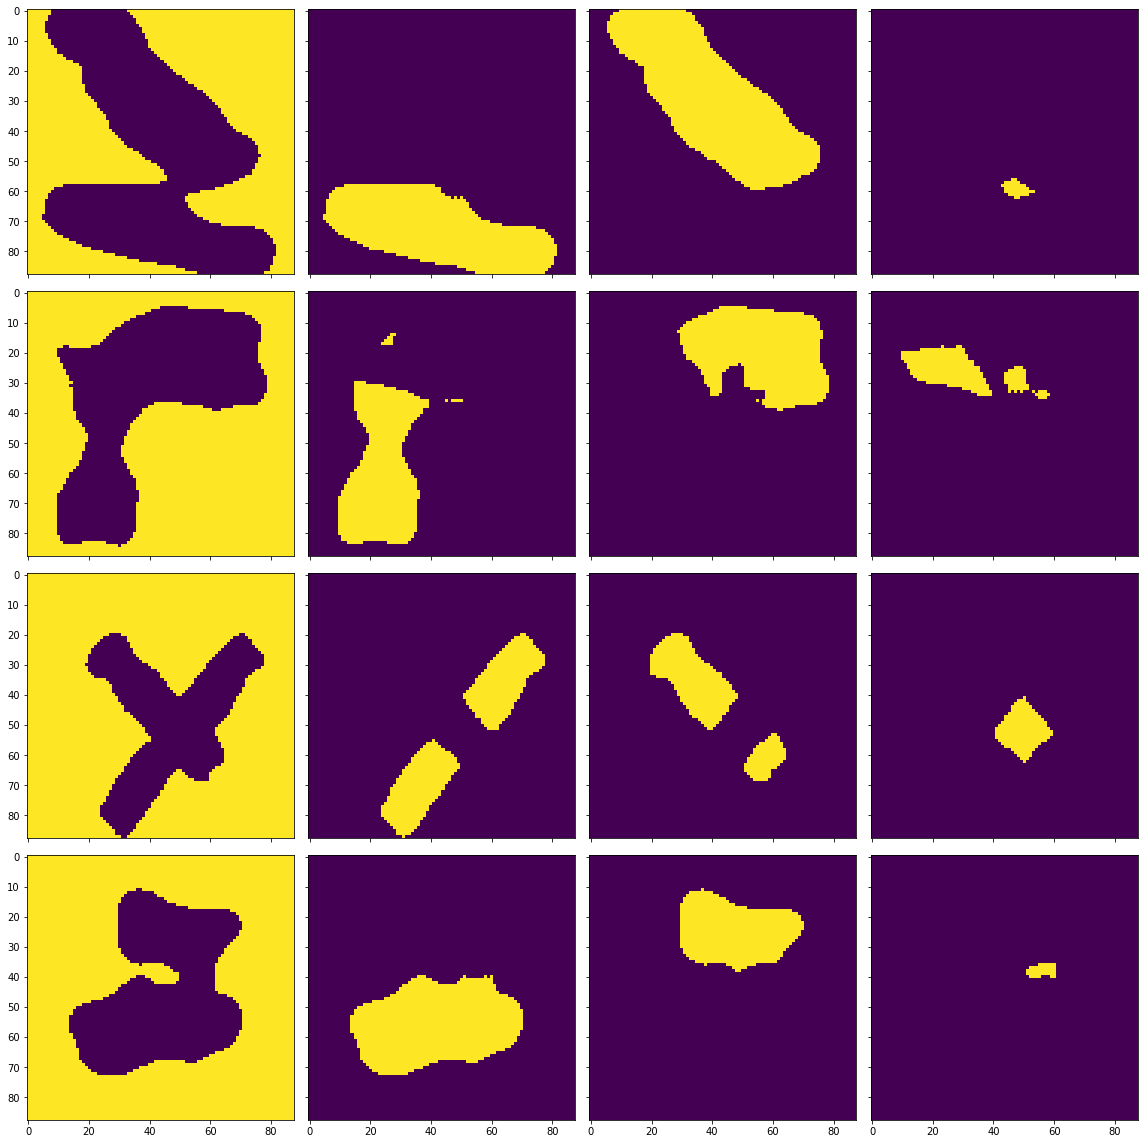

Training IOU: [0.9881874313046332, 0.9587910651061149, 0.95162174172635, 0.8894765256338478]
Training accuracy: 0.9871758780991735
Testing IOU: [0.9717781383163847, 0.4061398529392351, 0.2749770607467061, 0.3508315863032844]
Testing accuracy: 0.8602543904958677
13/13 [==============================] - 1s 66ms/step - loss: 0.0052 - val_loss: 0.0582ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_157epoch\assets
4
4


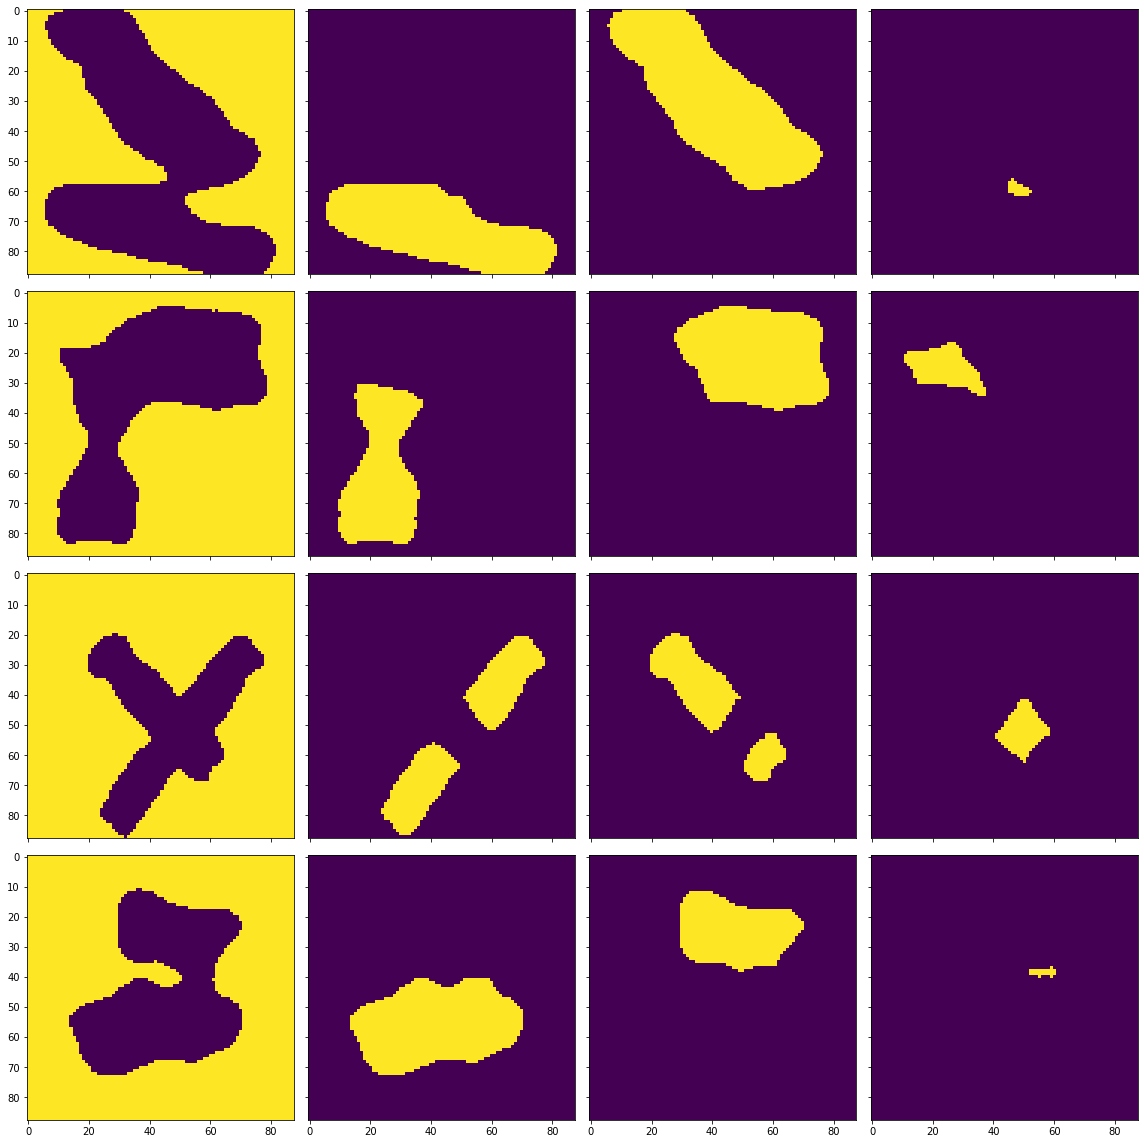

Training IOU: [0.987719859862773, 0.9513105135950258, 0.9563368486100157, 0.8953692353214693]
Training accuracy: 0.9857350852272727
Testing IOU: [0.970486458168182, 0.37842029231815094, 0.3148137263956876, 0.37124923944022803]
Testing accuracy: 0.8596022727272727
13/13 [==============================] - 1s 67ms/step - loss: 0.0053 - val_loss: 0.0588
INFO:tensorflow:Assets written to: modelunet/savedmodel_158epoch\assets
4
4


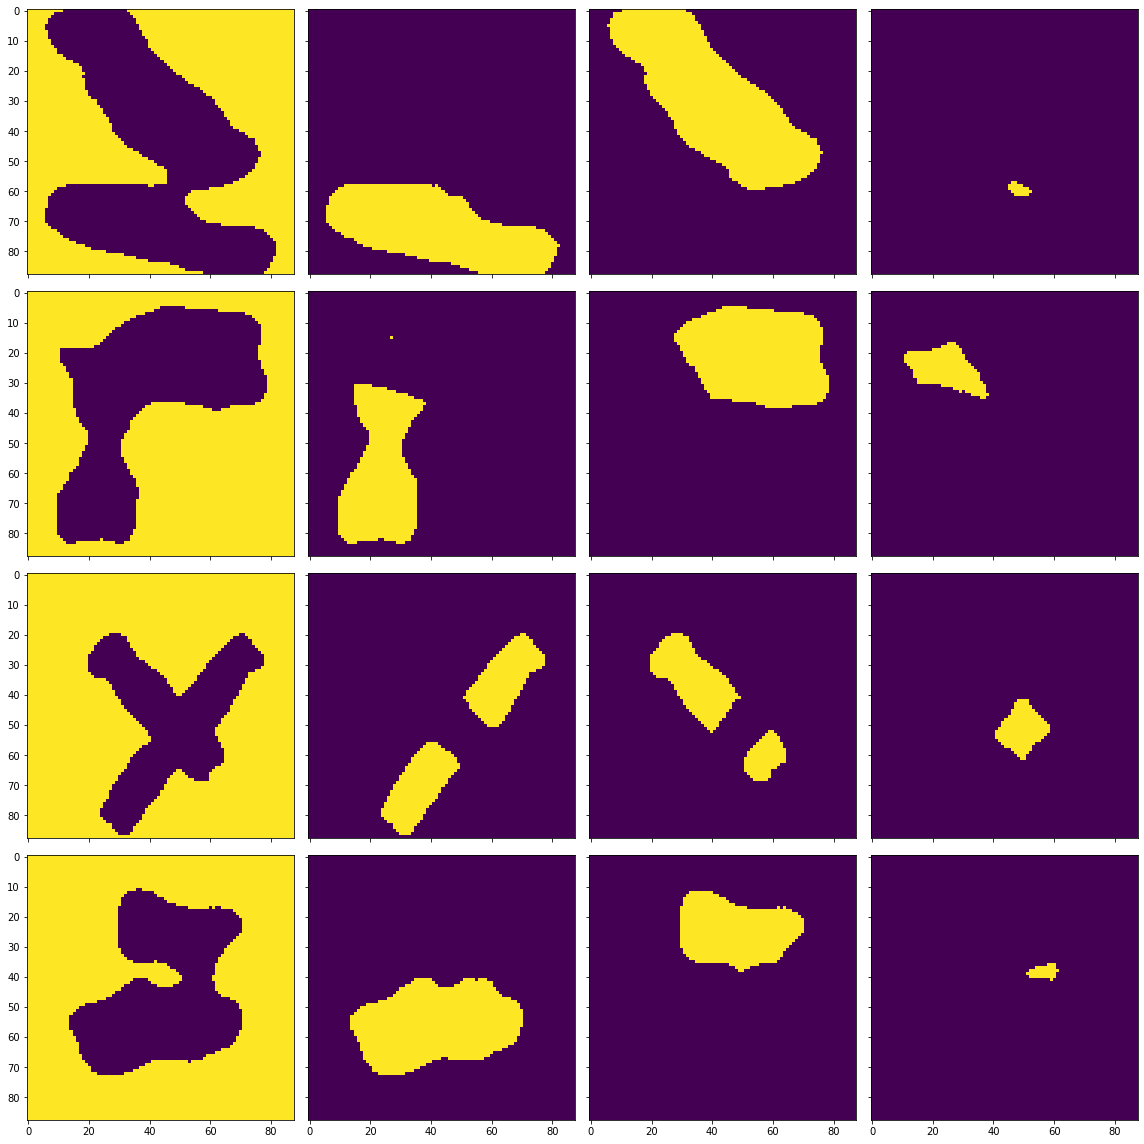

Training IOU: [0.9882986140984829, 0.9590567678318703, 0.9571251041282587, 0.9139121752334991]
Training accuracy: 0.9873876549586776
Testing IOU: [0.9708209181702808, 0.39205893542697057, 0.29648377158915373, 0.3579367173983168]
Testing accuracy: 0.8598527892561983
13/13 [==============================] - 1s 67ms/step - loss: 0.0051 - val_loss: 0.0597
INFO:tensorflow:Assets written to: modelunet/savedmodel_159epoch\assets
4
4


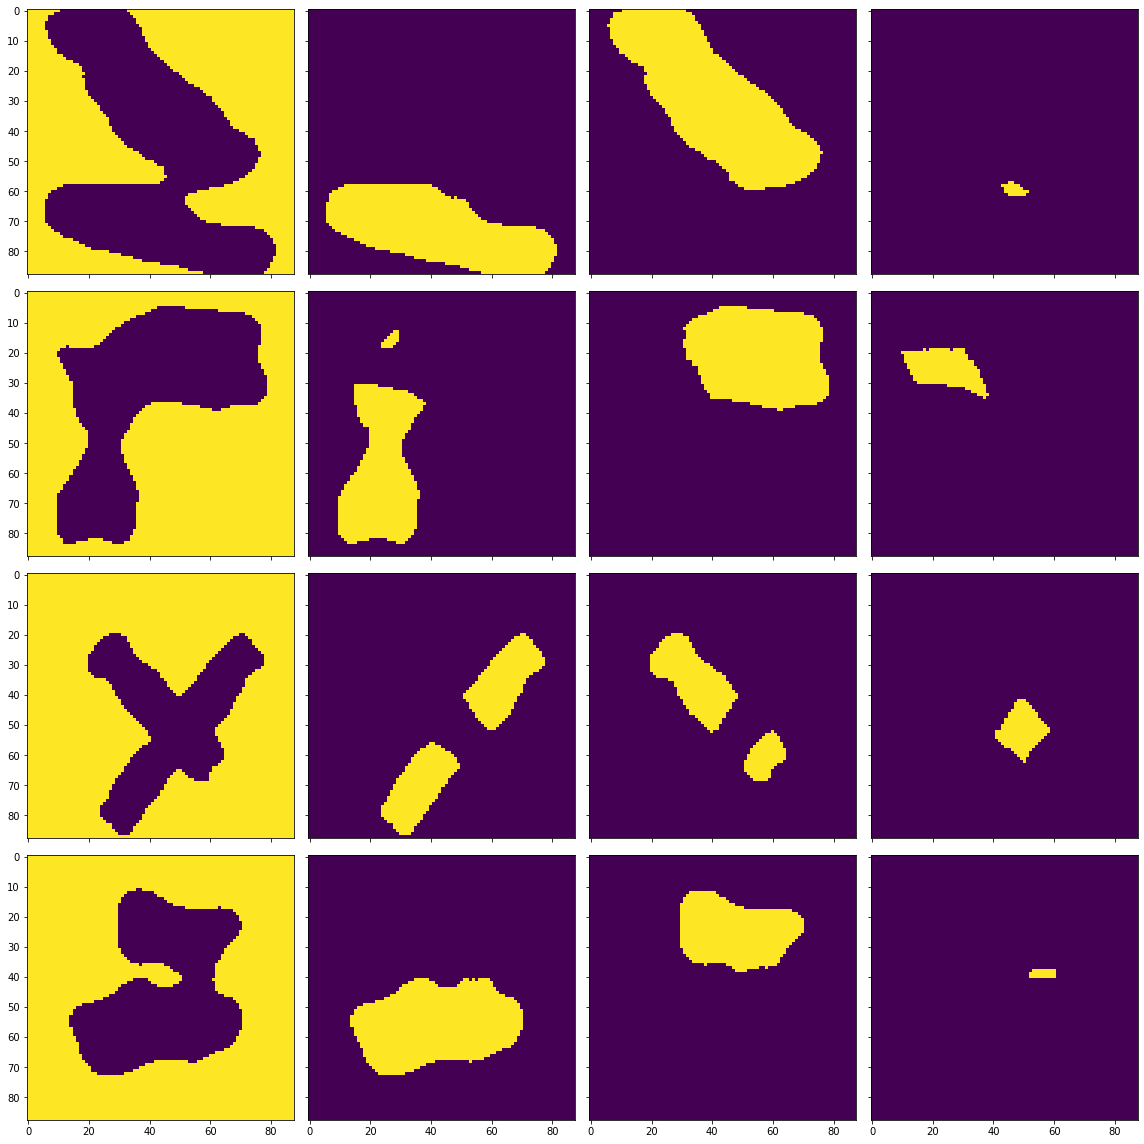

Training IOU: [0.9893384084430719, 0.9631294735846576, 0.9610853656208148, 0.9179963749515437]
Training accuracy: 0.9882176523760331
Testing IOU: [0.9713183141995418, 0.38359839579587884, 0.2985080996193435, 0.3648488088873047]
Testing accuracy: 0.858775826446281
13/13 [==============================] - 1s 66ms/step - loss: 0.0049 - val_loss: 0.0607
INFO:tensorflow:Assets written to: modelunet/savedmodel_160epoch\assets
4
4


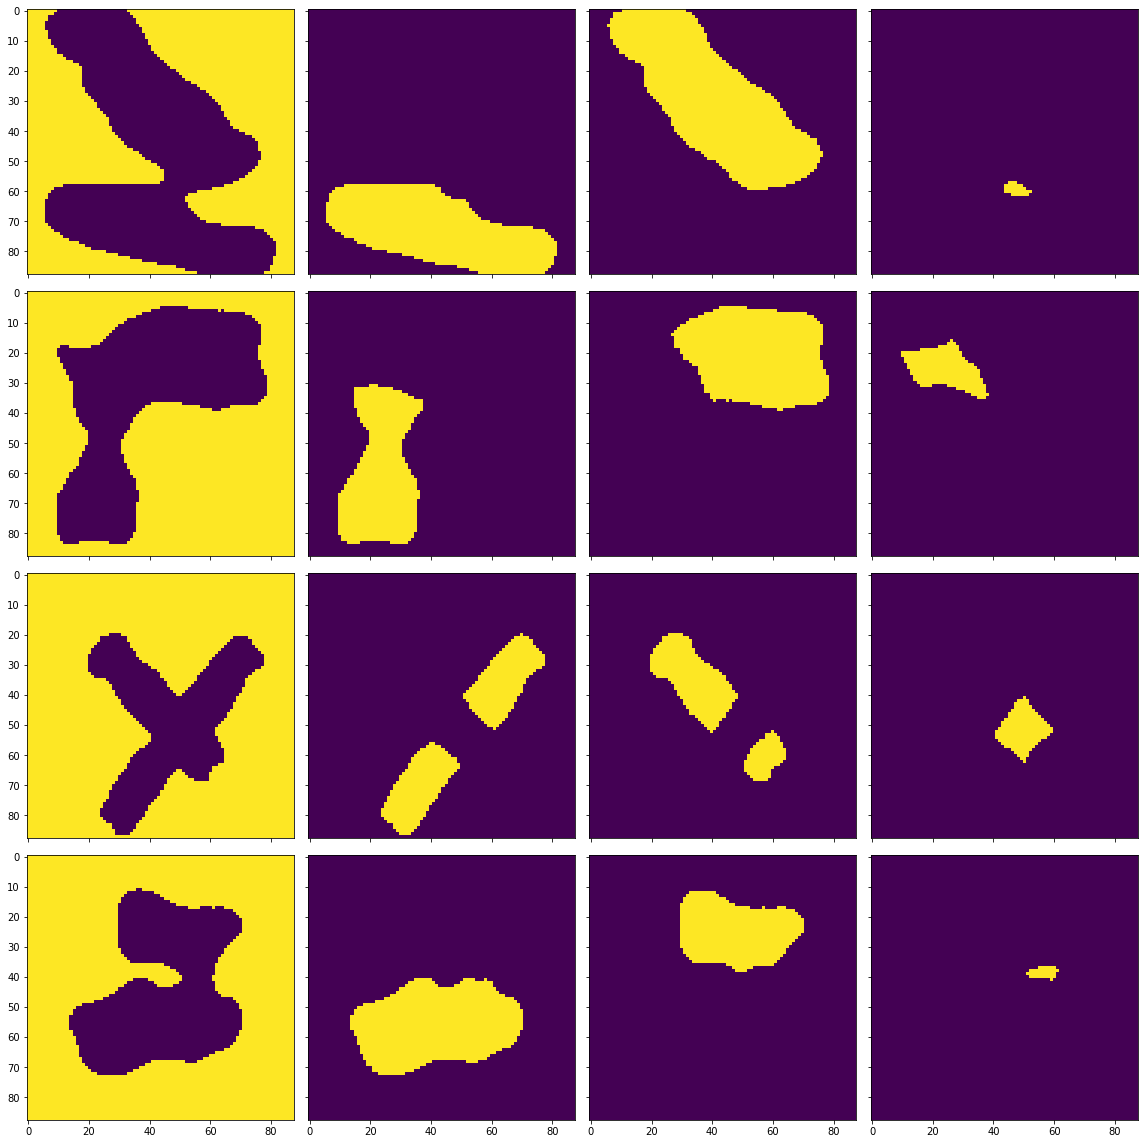

Training IOU: [0.9894989554264315, 0.9646143920366829, 0.9657661809556083, 0.921916601916602]
Training accuracy: 0.9892784736570248
Testing IOU: [0.9716378084107136, 0.381016509203567, 0.310010890508503, 0.35540199564170205]
Testing accuracy: 0.859372417355372
13/13 [==============================] - 1s 66ms/step - loss: 0.0048 - val_loss: 0.0622
INFO:tensorflow:Assets written to: modelunet/savedmodel_161epoch\assets
4
4


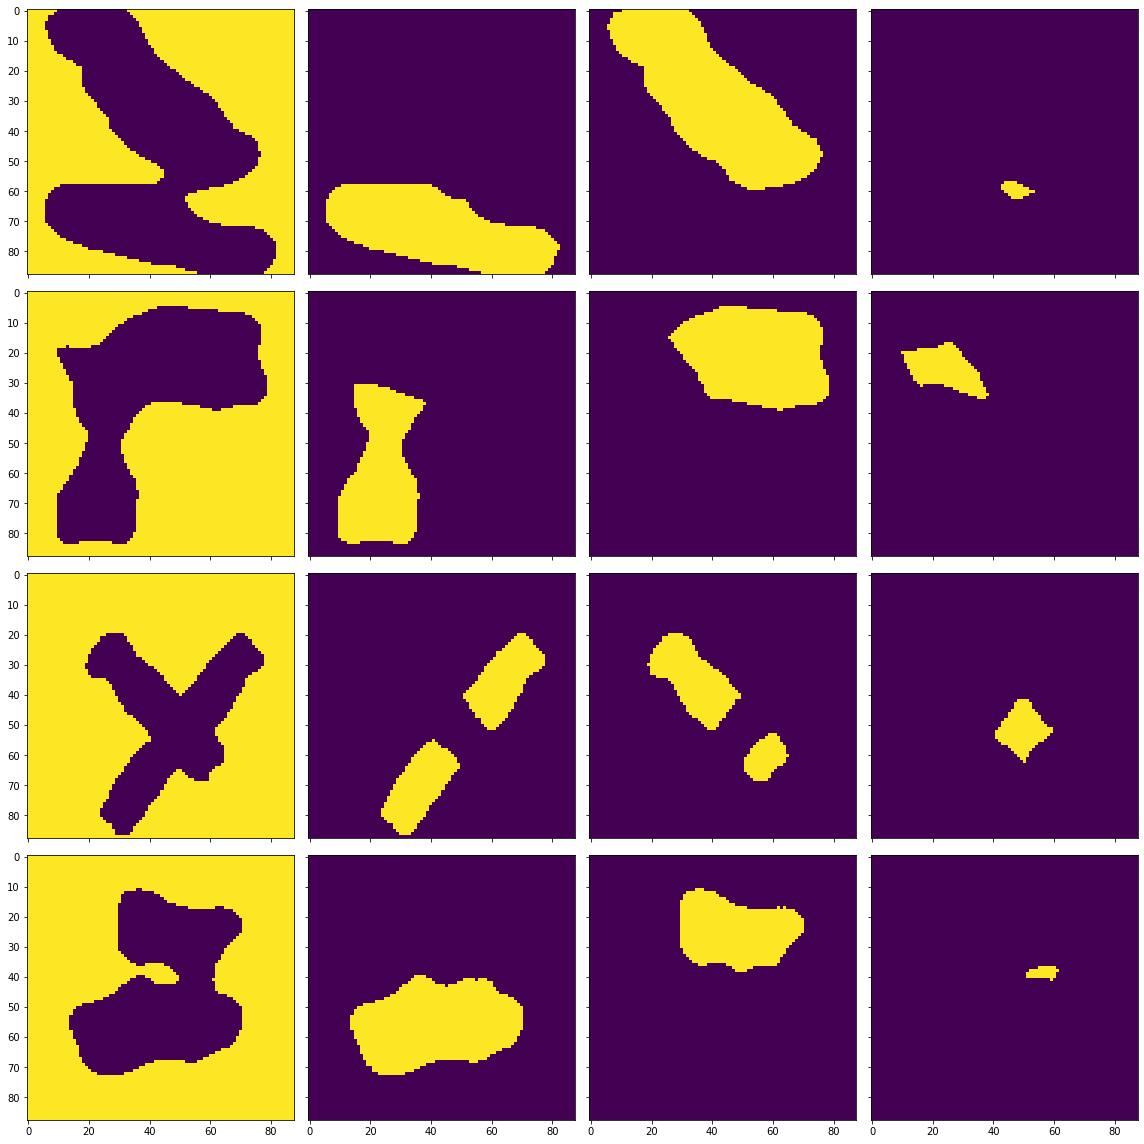

Training IOU: [0.9888956639718837, 0.9642308300105581, 0.9645262999311295, 0.925748076076244]
Training accuracy: 0.9895906508264463
Testing IOU: [0.9716824275174062, 0.382492453643812, 0.3203267904161164, 0.3566966554084347]
Testing accuracy: 0.8613248966942149
13/13 [==============================] - 1s 66ms/step - loss: 0.0047 - val_loss: 0.0613
INFO:tensorflow:Assets written to: modelunet/savedmodel_162epoch\assets
4
4


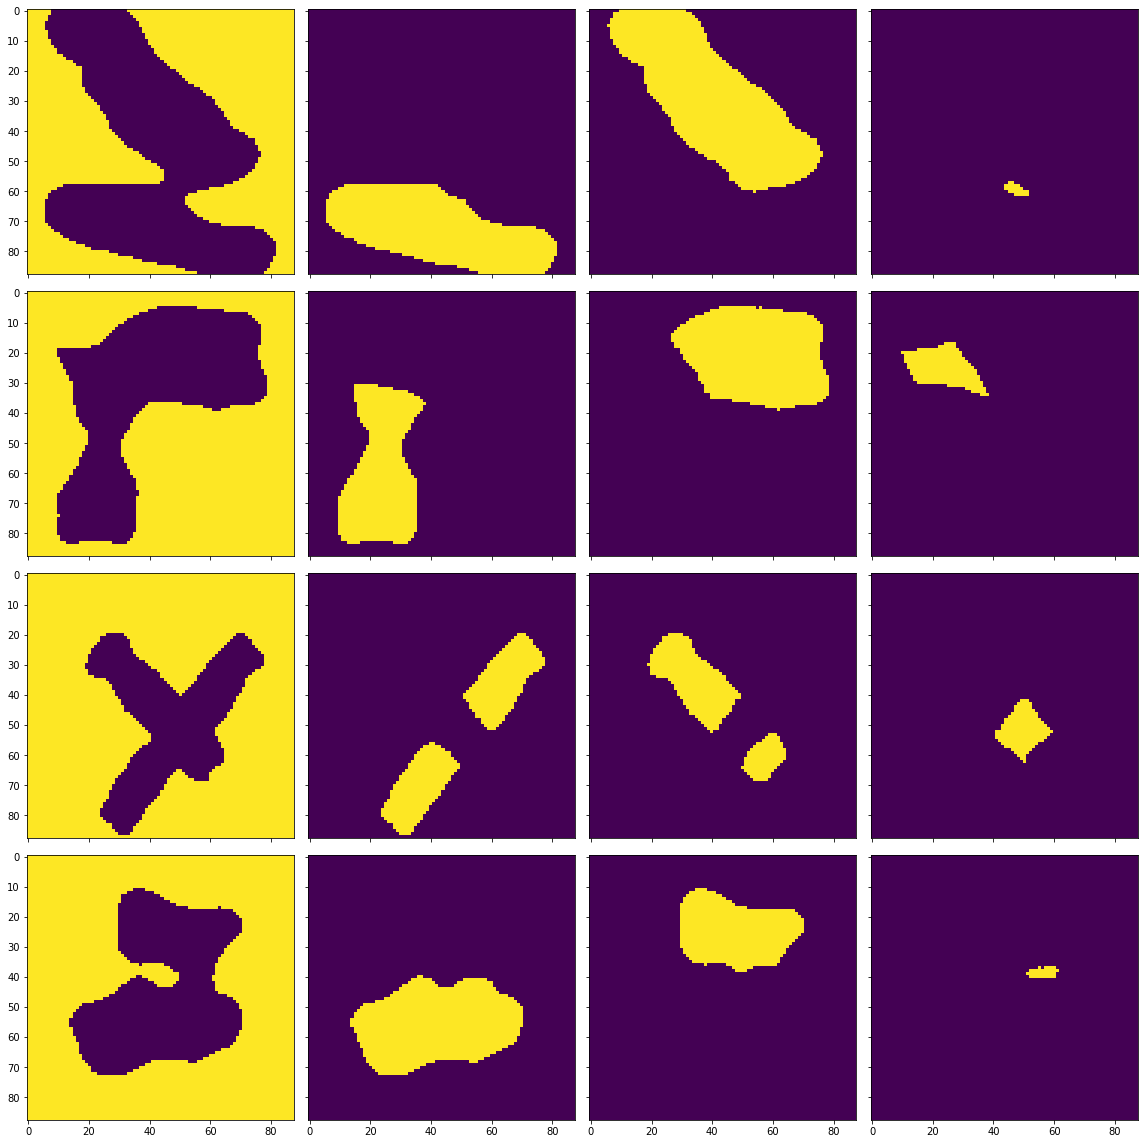

Training IOU: [0.9897189575789603, 0.9638084503383754, 0.9661009631082842, 0.9178876710892023]
Training accuracy: 0.9890163352272727
Testing IOU: [0.9710455856696205, 0.3605130554283097, 0.3189282278081871, 0.356758196236241]
Testing accuracy: 0.8574625516528925
13/13 [==============================] - 1s 66ms/step - loss: 0.0047 - val_loss: 0.0599
INFO:tensorflow:Assets written to: modelunet/savedmodel_163epoch\assets
4
4


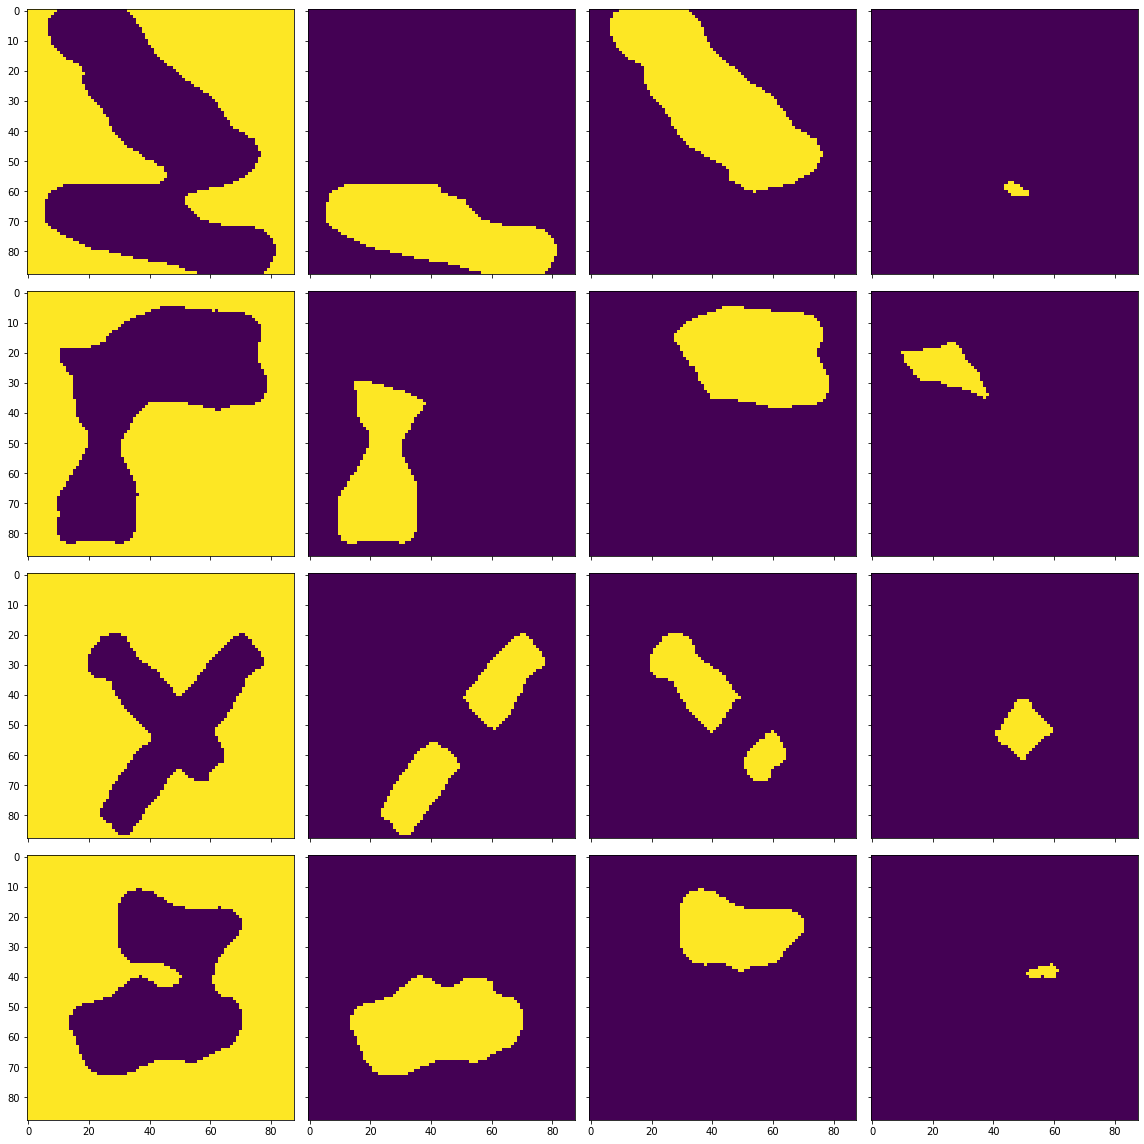

Training IOU: [0.9890670410192143, 0.9610797732550325, 0.9622674943228131, 0.9215375177169935]
Training accuracy: 0.9883348398760331
Testing IOU: [0.9702428846362589, 0.3773228058580759, 0.31304552960603915, 0.36983260889669844]
Testing accuracy: 0.8599535123966943
13/13 [==============================] - 1s 67ms/step - loss: 0.0049 - val_loss: 0.0589
INFO:tensorflow:Assets written to: modelunet/savedmodel_164epoch\assets
4
4


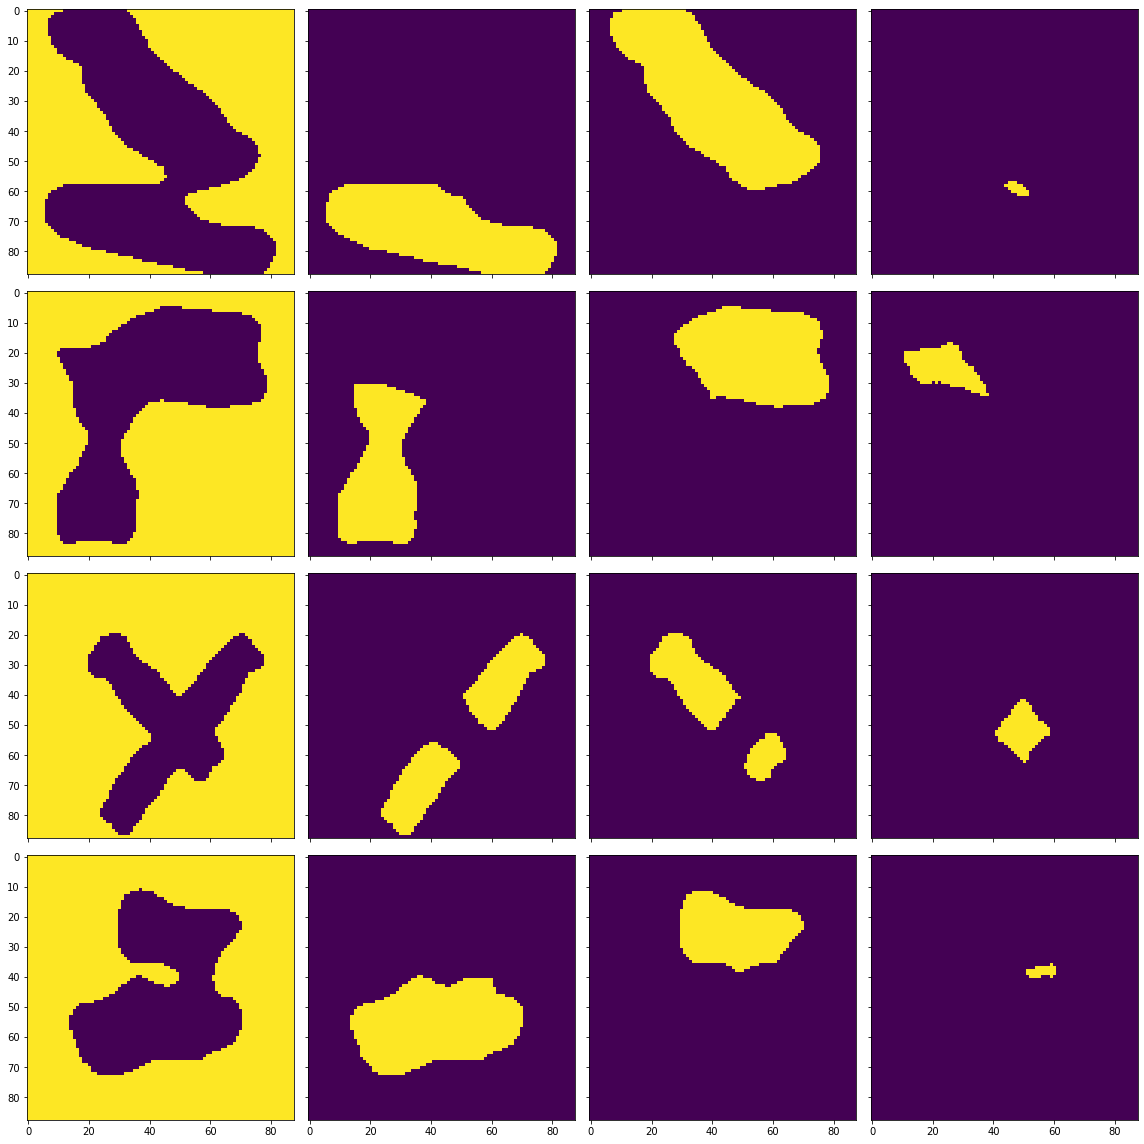

Training IOU: [0.9886490358067455, 0.9593148095469686, 0.9539565510106899, 0.8986623601534195]
Training accuracy: 0.9869218104338843
Testing IOU: [0.9704742464260839, 0.4079139423749825, 0.27713238491644404, 0.37821775676385605]
Testing accuracy: 0.8611299070247934
13/13 [==============================] - 1s 67ms/step - loss: 0.0050 - val_loss: 0.0599
INFO:tensorflow:Assets written to: modelunet/savedmodel_165epoch\assets
4
4


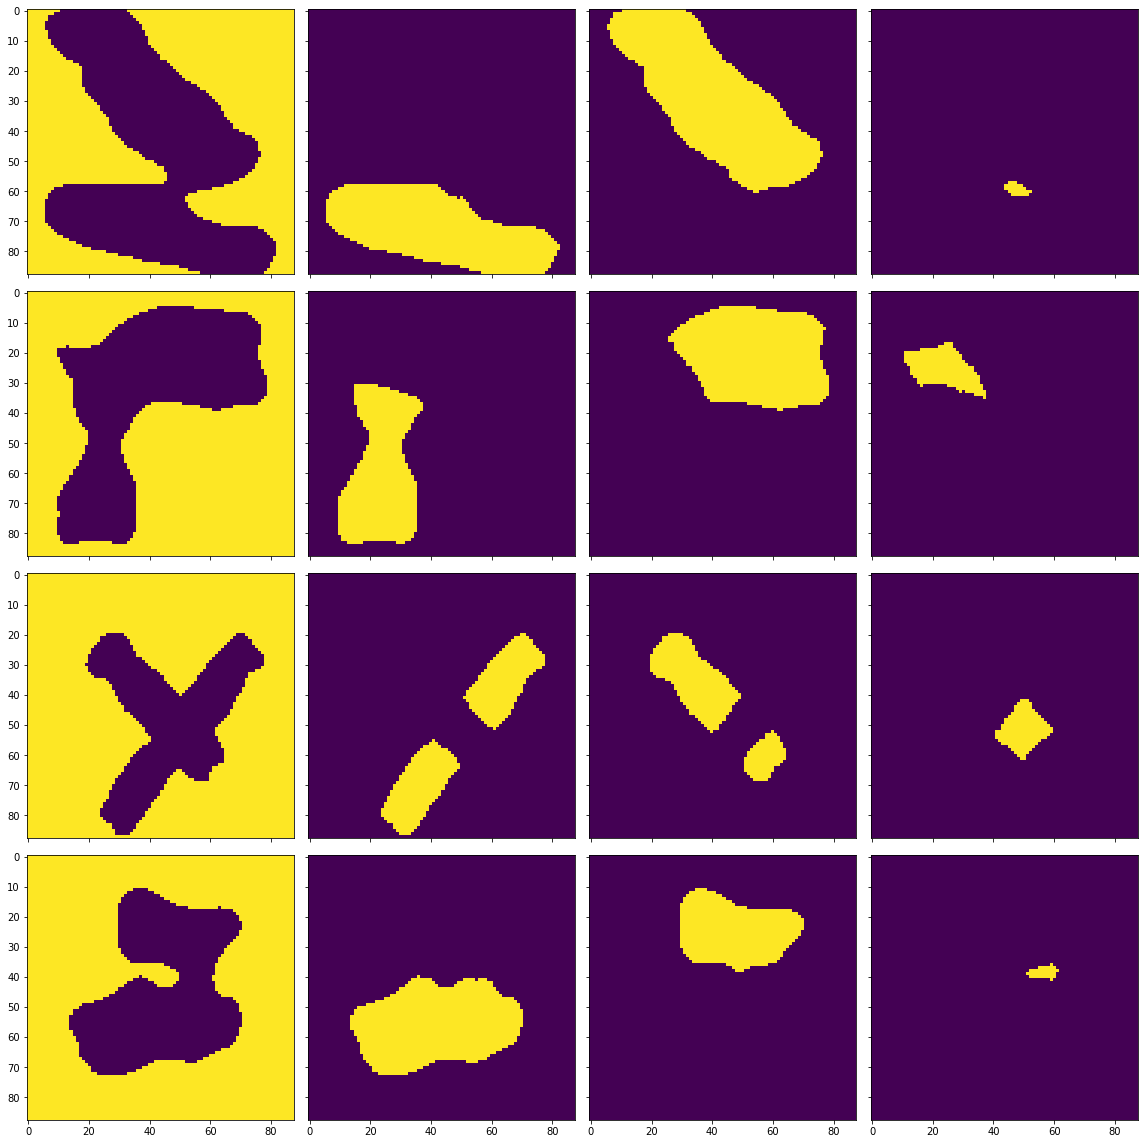

Training IOU: [0.9894964402481132, 0.9639348950705411, 0.9637421314921092, 0.9111686163048435]
Training accuracy: 0.9888626678719008
Testing IOU: [0.9713113337343317, 0.3829148243930925, 0.31147976111479764, 0.36000881834215165]
Testing accuracy: 0.8600477789256198
13/13 [==============================] - 1s 66ms/step - loss: 0.0054 - val_loss: 0.0588
INFO:tensorflow:Assets written to: modelunet/savedmodel_166epoch\assets
4
4


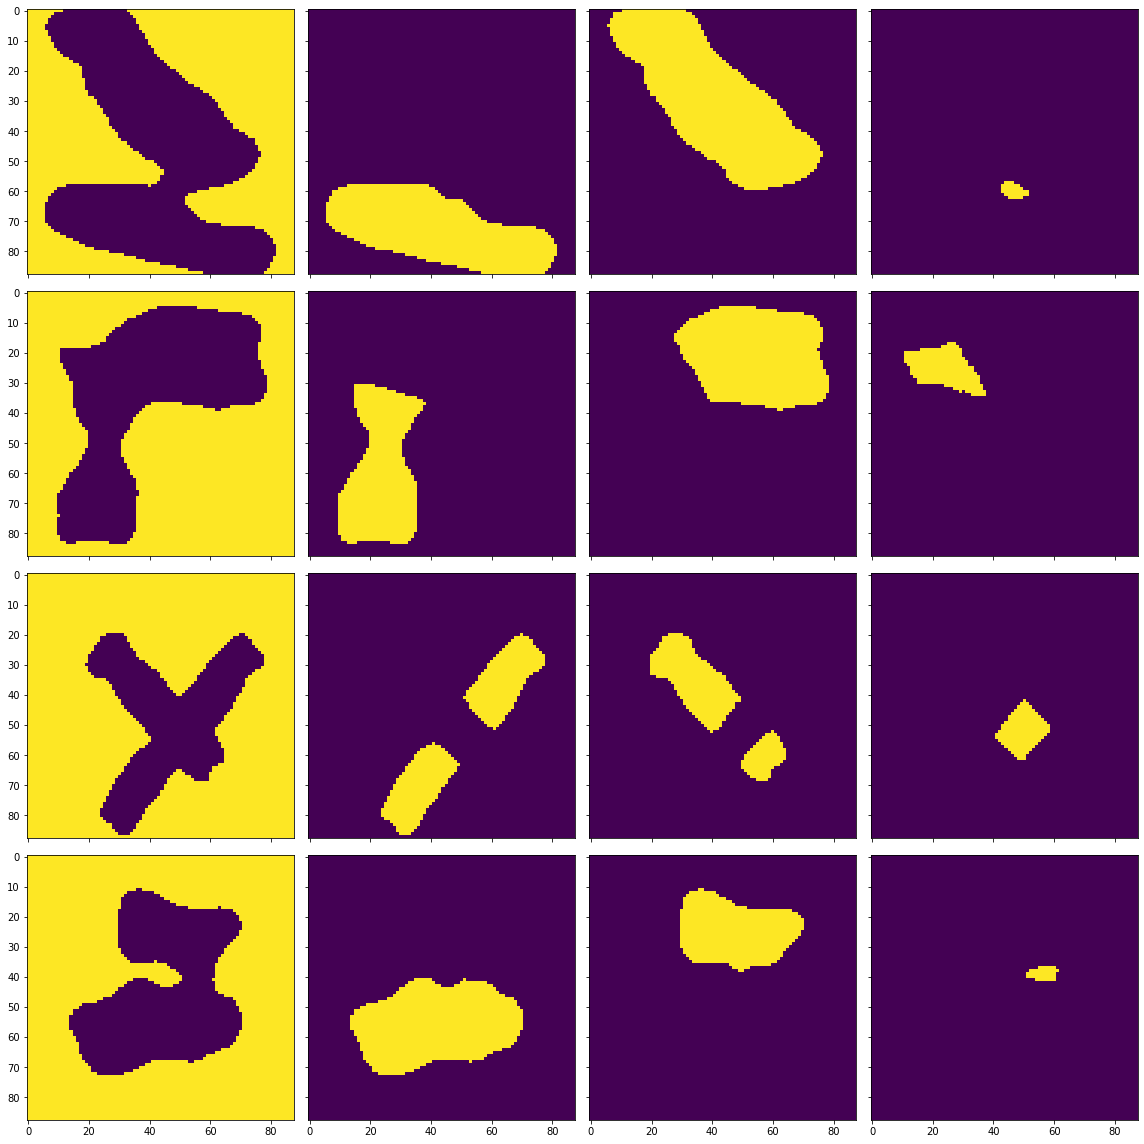

Training IOU: [0.9887120296193186, 0.9582133433498885, 0.9618642230868439, 0.9096485218949254]
Training accuracy: 0.9876362345041322
Testing IOU: [0.9709674859305828, 0.38089469829286154, 0.31324552788200827, 0.37438500830434646]
Testing accuracy: 0.860207902892562
13/13 [==============================] - 1s 66ms/step - loss: 0.0049 - val_loss: 0.0615TA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_167epoch\assets
4
4


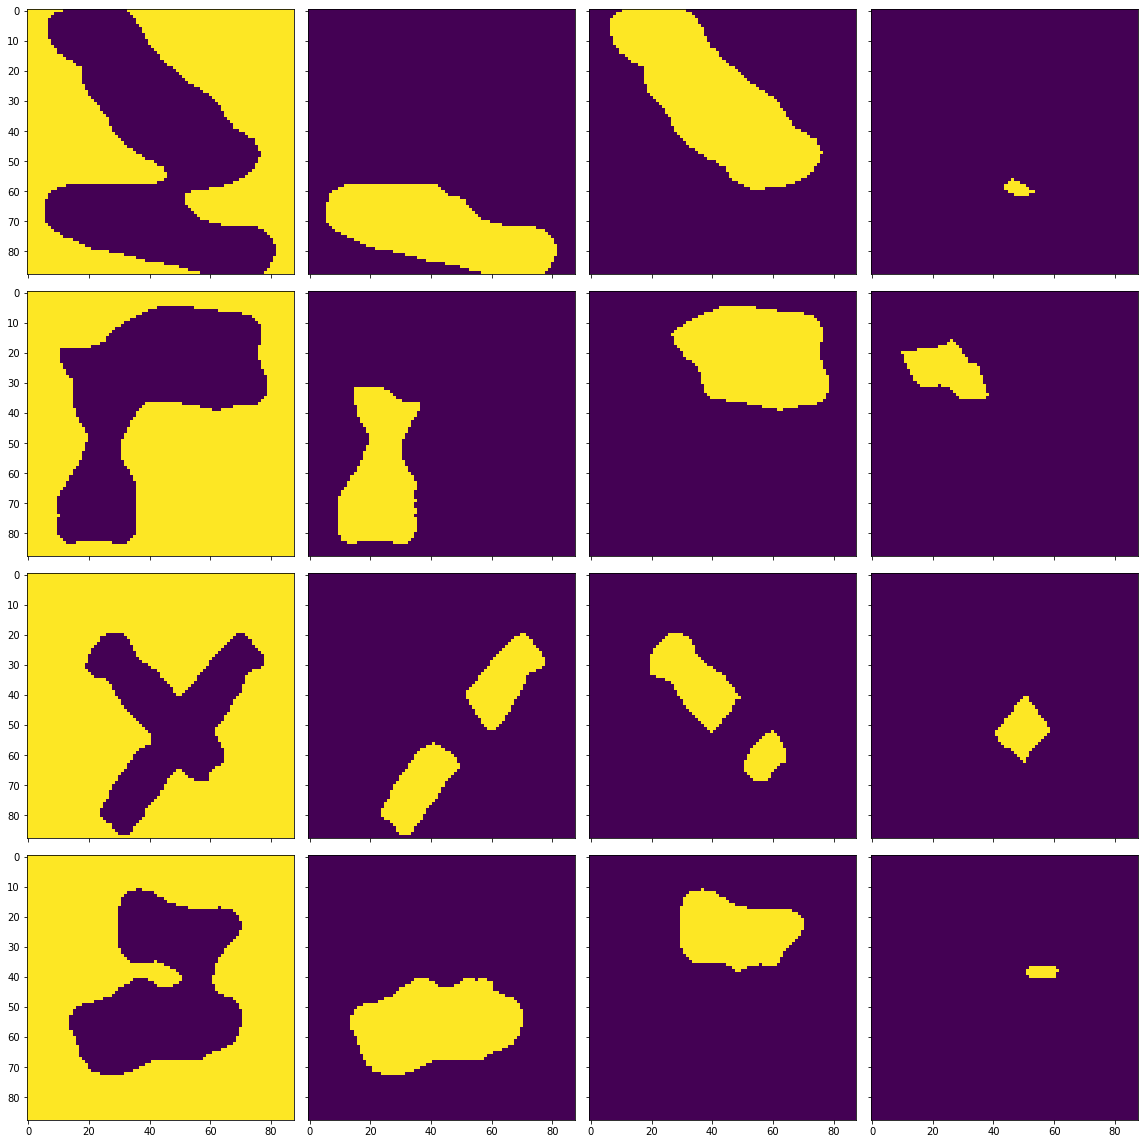

Training IOU: [0.9891206432465081, 0.9582151231630024, 0.9628430402585969, 0.911171573273007]
Training accuracy: 0.9882948088842975
Testing IOU: [0.970590060933766, 0.38142712018776054, 0.29984138083948764, 0.35289857091121823]
Testing accuracy: 0.8589721074380166
13/13 [==============================] - 1s 67ms/step - loss: 0.0049 - val_loss: 0.0611
INFO:tensorflow:Assets written to: modelunet/savedmodel_168epoch\assets
4
4


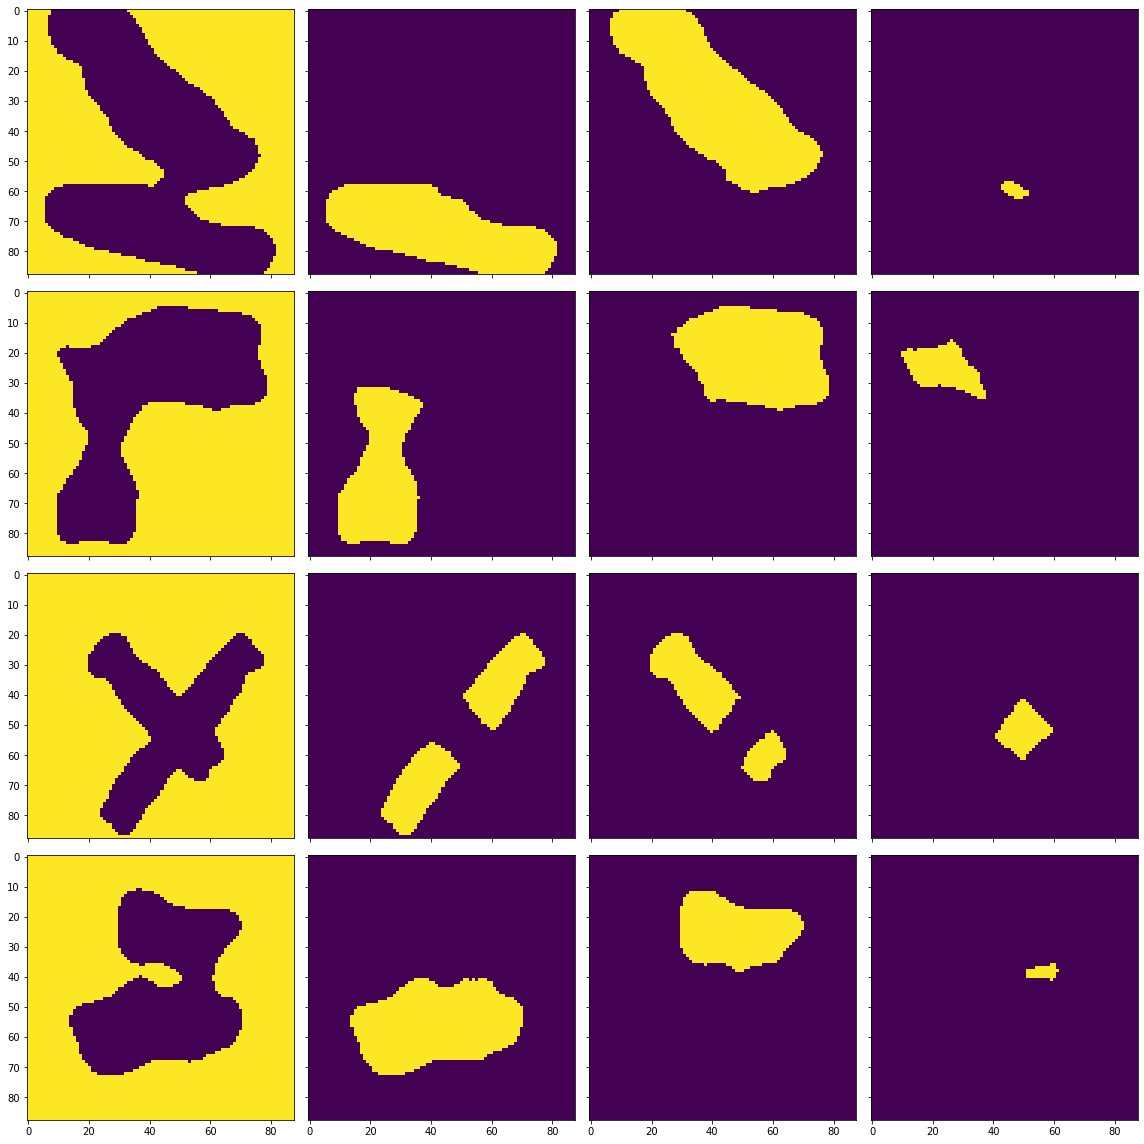

Training IOU: [0.9895776795927064, 0.961086795673785, 0.9639702514667073, 0.9134920634920635]
Training accuracy: 0.9887319214876034
Testing IOU: [0.9706452830904349, 0.3759817887466331, 0.3060206203063346, 0.3488716038562664]
Testing accuracy: 0.8586867252066116
13/13 [==============================] - 1s 66ms/step - loss: 0.0048 - val_loss: 0.0600
INFO:tensorflow:Assets written to: modelunet/savedmodel_169epoch\assets
4
4


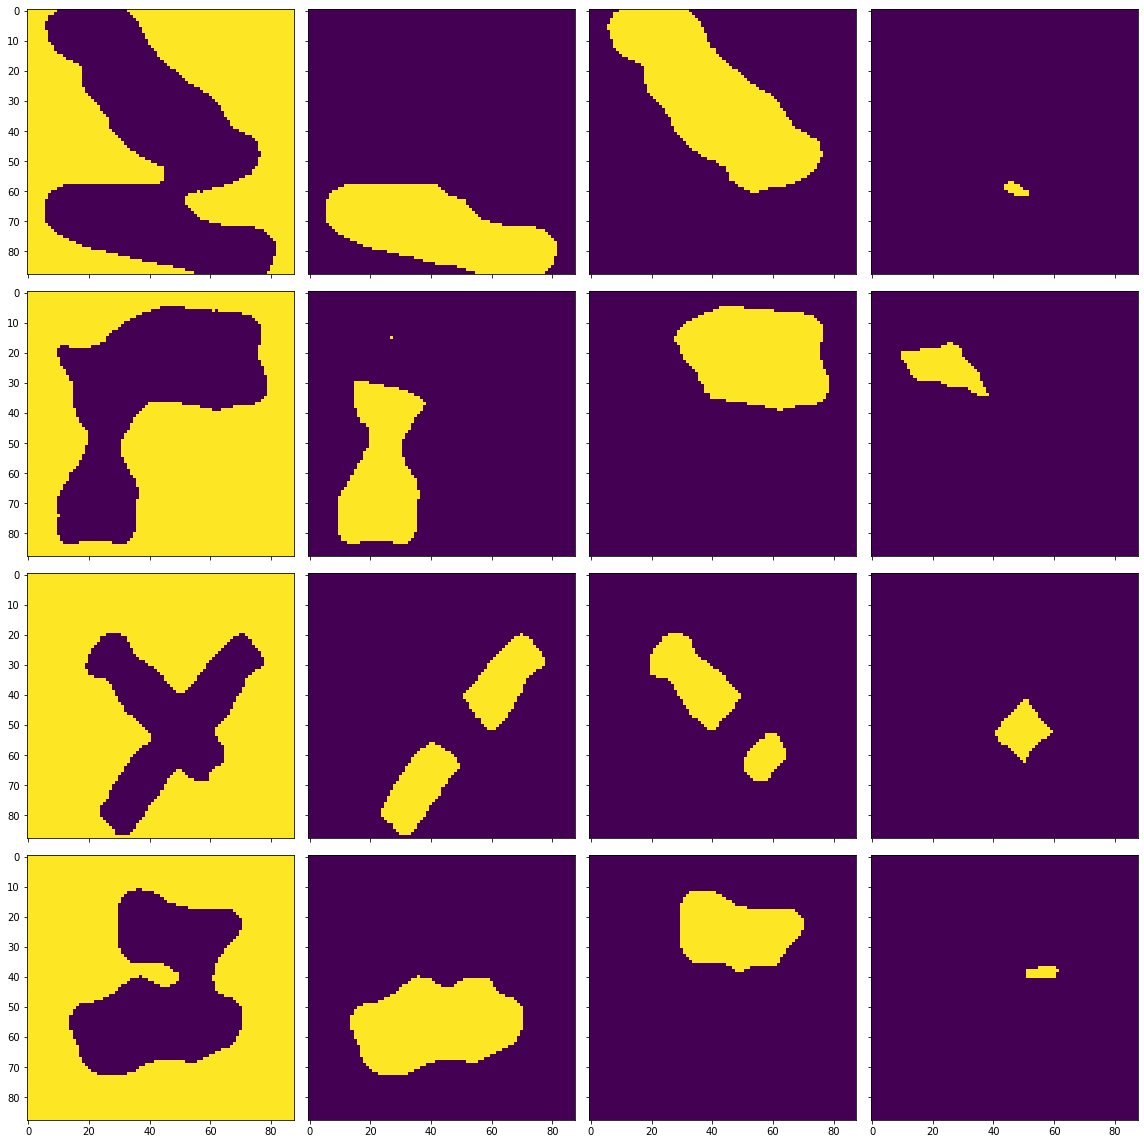

Training IOU: [0.9897370487097638, 0.9653667610115674, 0.9665290442829819, 0.915787361238738]
Training accuracy: 0.9888897856404959
Testing IOU: [0.9716703139932686, 0.3920135289945993, 0.2985320742207754, 0.36711676914995517]
Testing accuracy: 0.8596590909090909
13/13 [==============================] - 1s 67ms/step - loss: 0.0046 - val_loss: 0.0614 ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_170epoch\assets
4
4


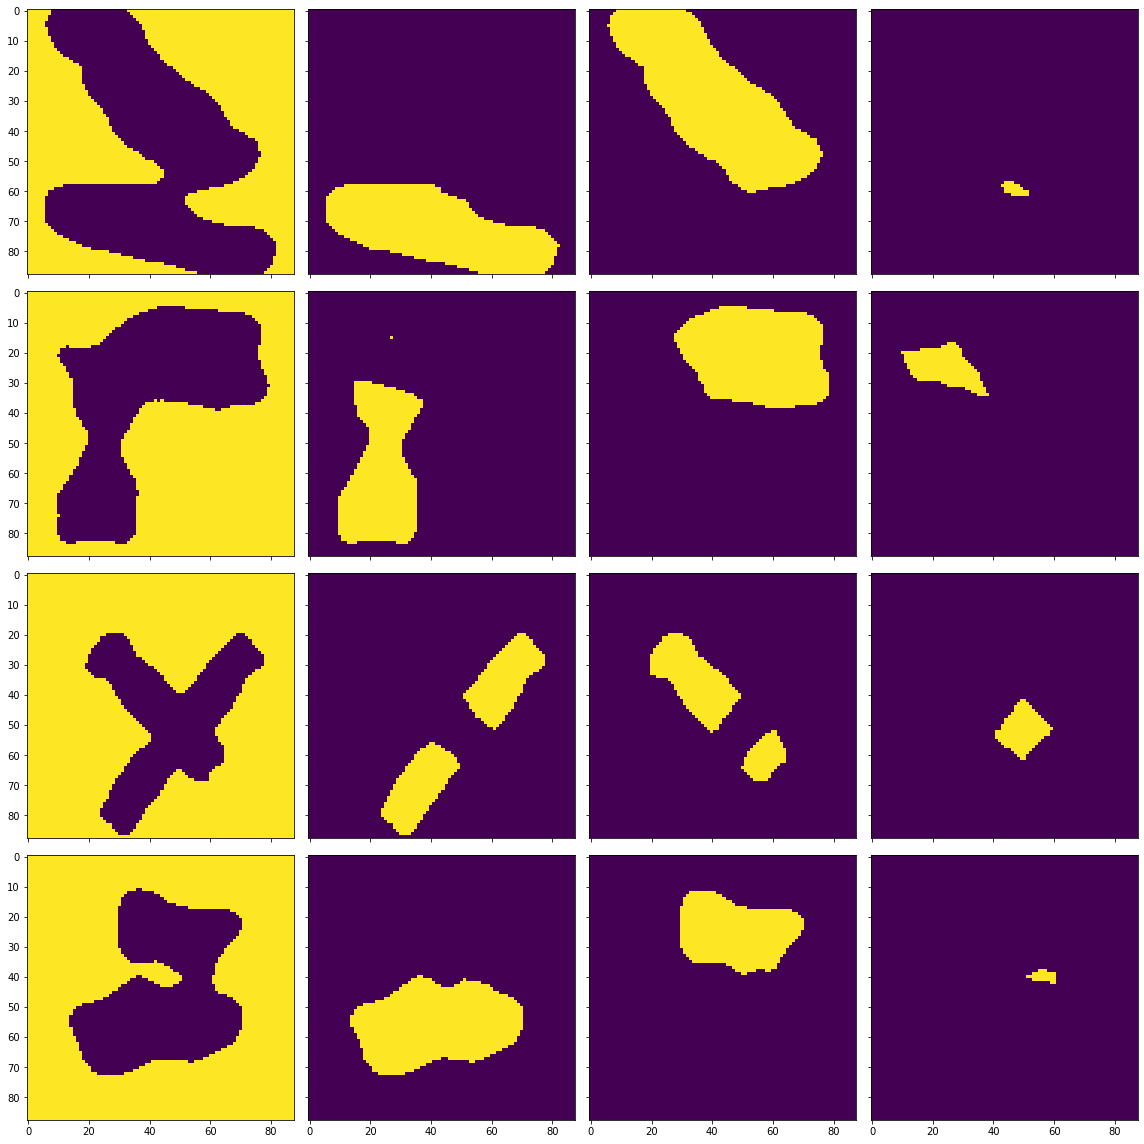

Training IOU: [0.9901414248912842, 0.9661773205409779, 0.9656114774088422, 0.9152068757475365]
Training accuracy: 0.9896200284090909
Testing IOU: [0.9708729645970308, 0.3708802080388942, 0.32115412733741655, 0.3620987654320988]
Testing accuracy: 0.8597223657024793
13/13 [==============================] - 1s 67ms/step - loss: 0.0045 - val_loss: 0.0600
INFO:tensorflow:Assets written to: modelunet/savedmodel_171epoch\assets
4
4


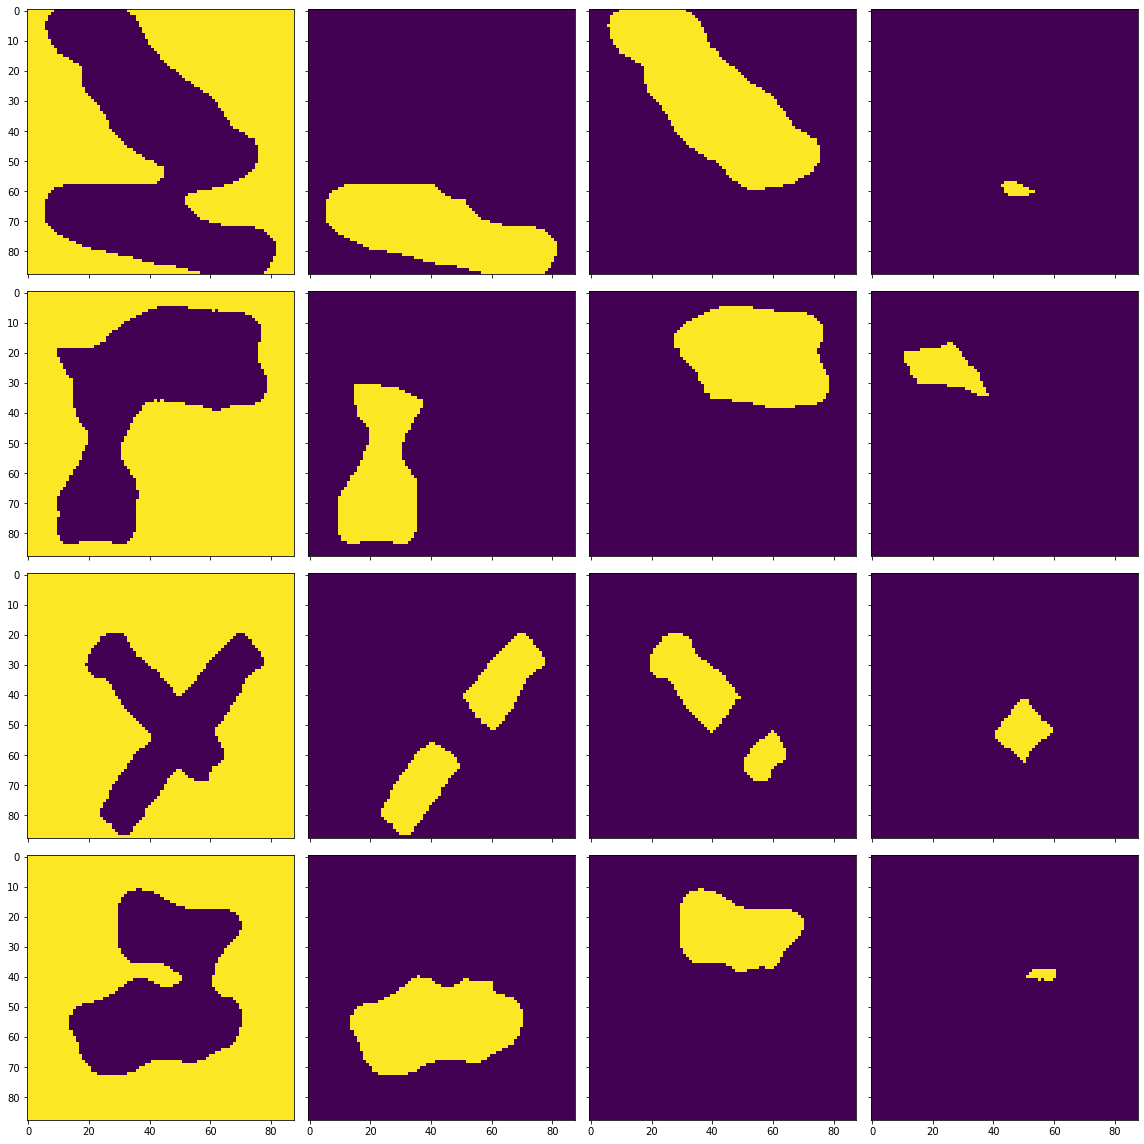

Training IOU: [0.9907973806166712, 0.9679006354708262, 0.9688101152853019, 0.9258845556477522]
Training accuracy: 0.9901326833677686
Testing IOU: [0.9706734088085047, 0.3828204237582494, 0.3083111267534818, 0.3756447988860407]
Testing accuracy: 0.8602995867768595
13/13 [==============================] - 1s 67ms/step - loss: 0.0044 - val_loss: 0.0634
INFO:tensorflow:Assets written to: modelunet/savedmodel_172epoch\assets
4
4


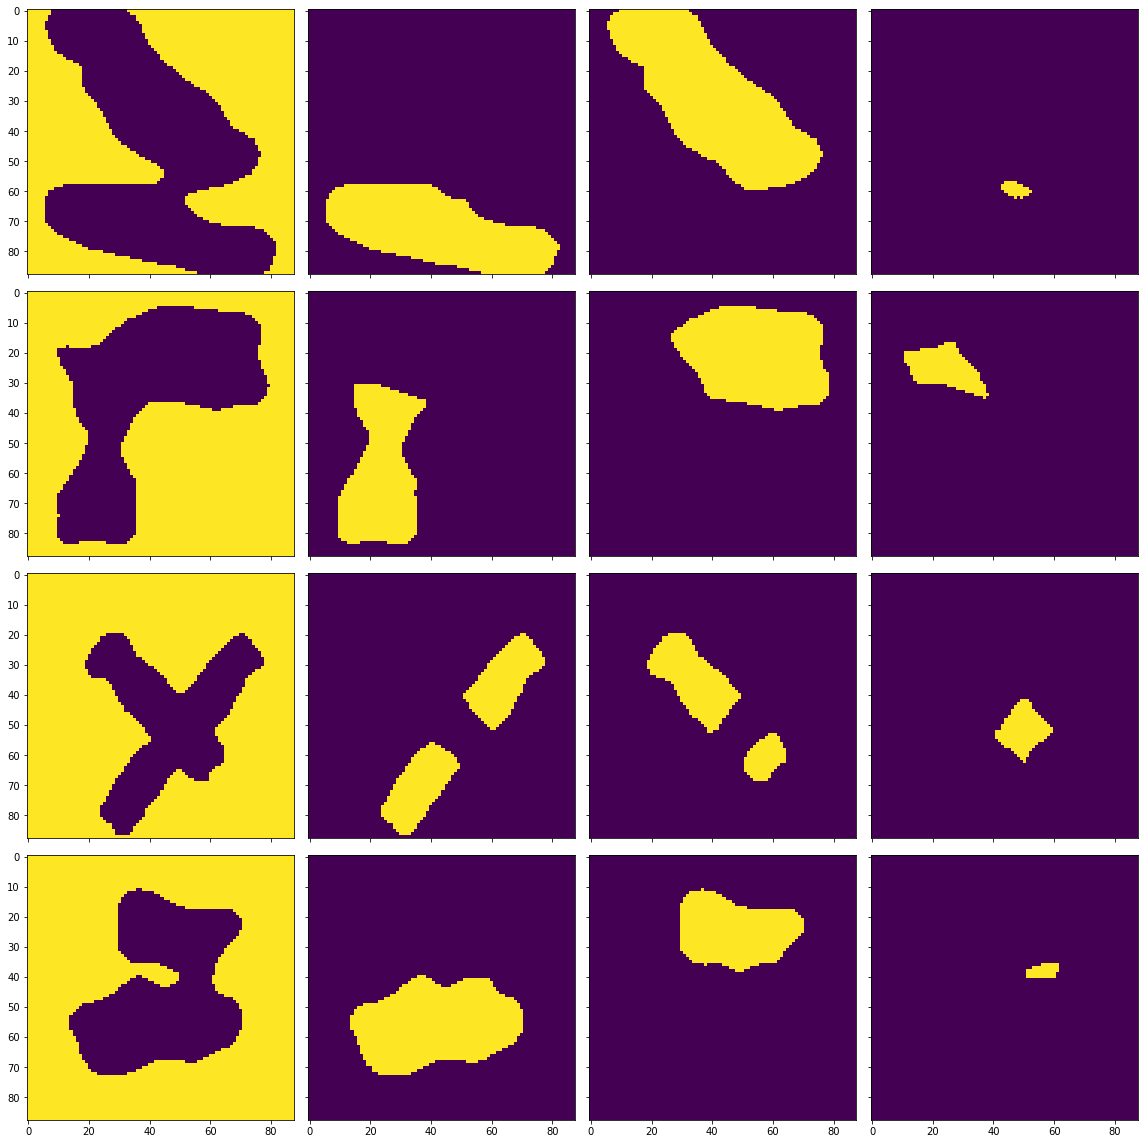

Training IOU: [0.9903181818181818, 0.9677637547699901, 0.9672983920857697, 0.9217354228845374]
Training accuracy: 0.9904322701446281
Testing IOU: [0.9711003658947988, 0.3697123819942178, 0.32267189741677677, 0.34914253584481303]
Testing accuracy: 0.8595105888429752
13/13 [==============================] - 1s 66ms/step - loss: 0.0044 - val_loss: 0.0614
INFO:tensorflow:Assets written to: modelunet/savedmodel_173epoch\assets
4
4


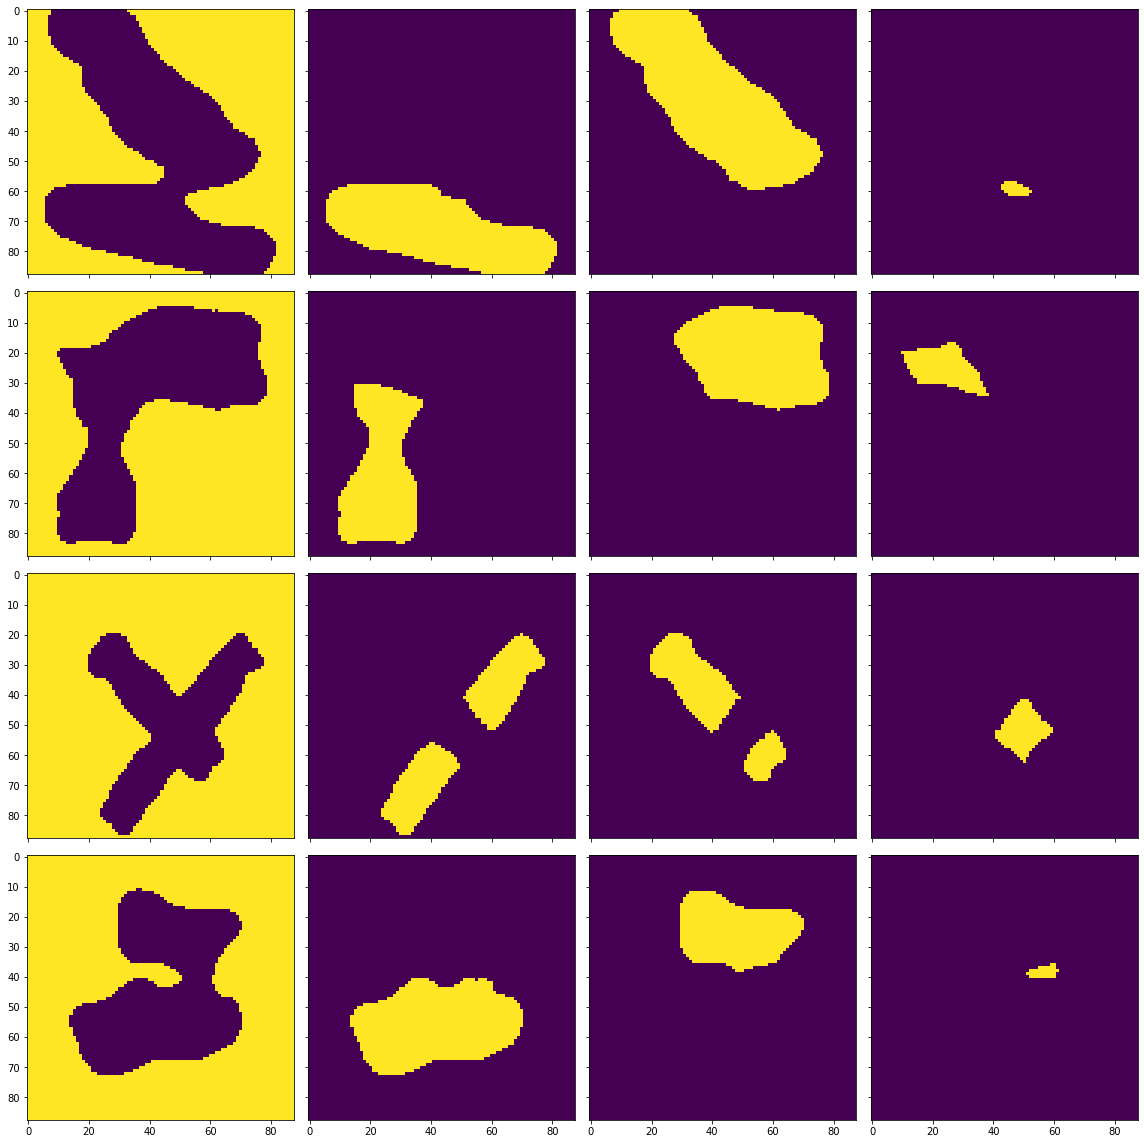

Training IOU: [0.9904461442438378, 0.9634055021976233, 0.9703178827409427, 0.9253999602913362]
Training accuracy: 0.9900422908057851
Testing IOU: [0.9698450384388752, 0.3744203854171098, 0.31311826523213854, 0.3578034682080925]
Testing accuracy: 0.859582902892562
13/13 [==============================] - 1s 67ms/step - loss: 0.0043 - val_loss: 0.0621
INFO:tensorflow:Assets written to: modelunet/savedmodel_174epoch\assets
4
4


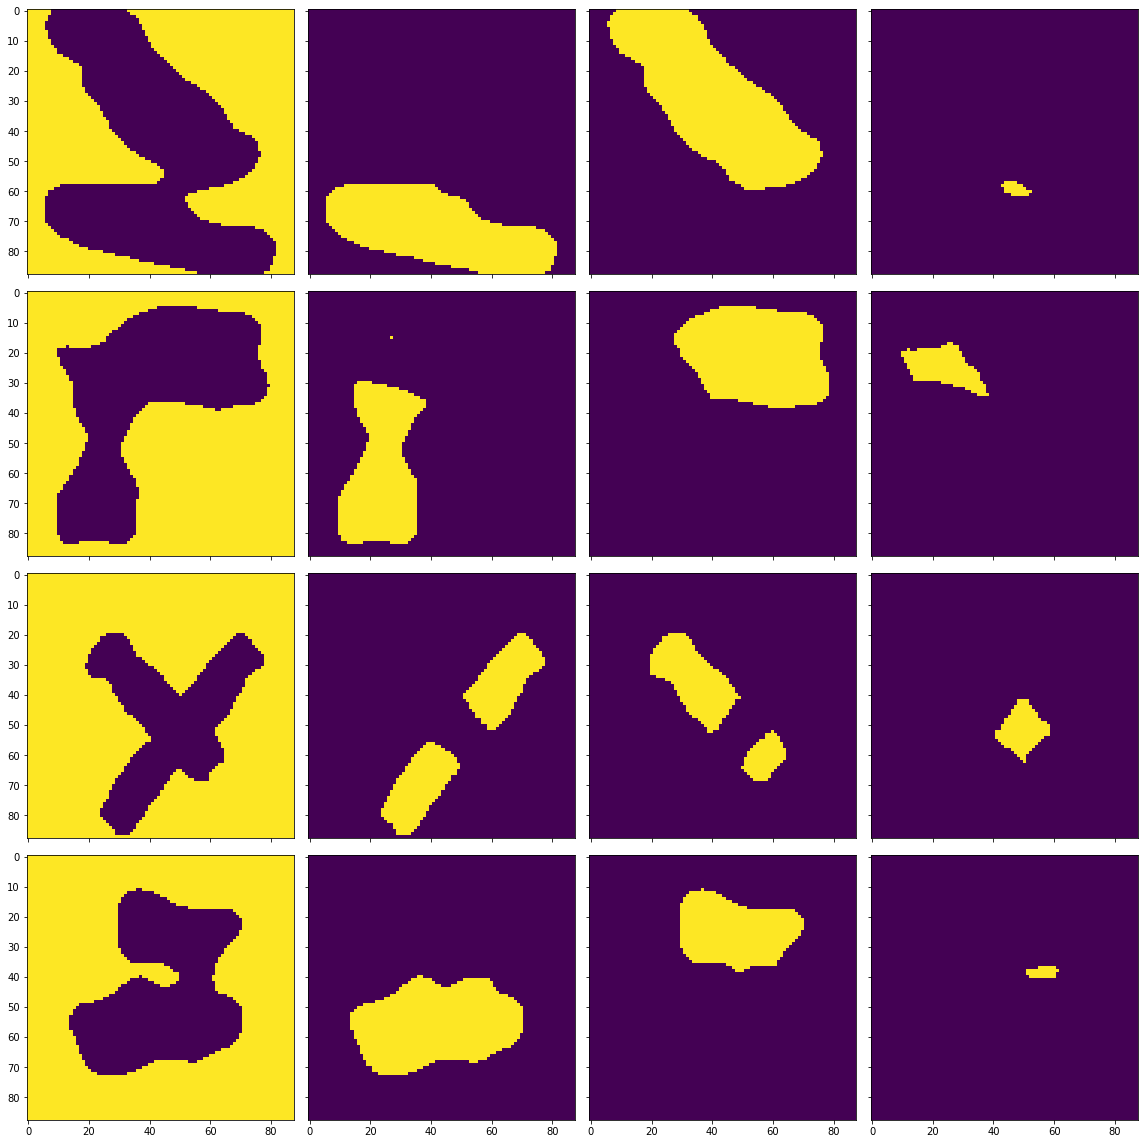

Training IOU: [0.9901621655215088, 0.9676020869947779, 0.9697391717407263, 0.9343350911747887]
Training accuracy: 0.9905975594008265
Testing IOU: [0.9711744560907791, 0.3877441651150487, 0.3085347180613807, 0.36324288827199186]
Testing accuracy: 0.860807076446281
13/13 [==============================] - 1s 66ms/step - loss: 0.0044 - val_loss: 0.0593
INFO:tensorflow:Assets written to: modelunet/savedmodel_175epoch\assets
4
4


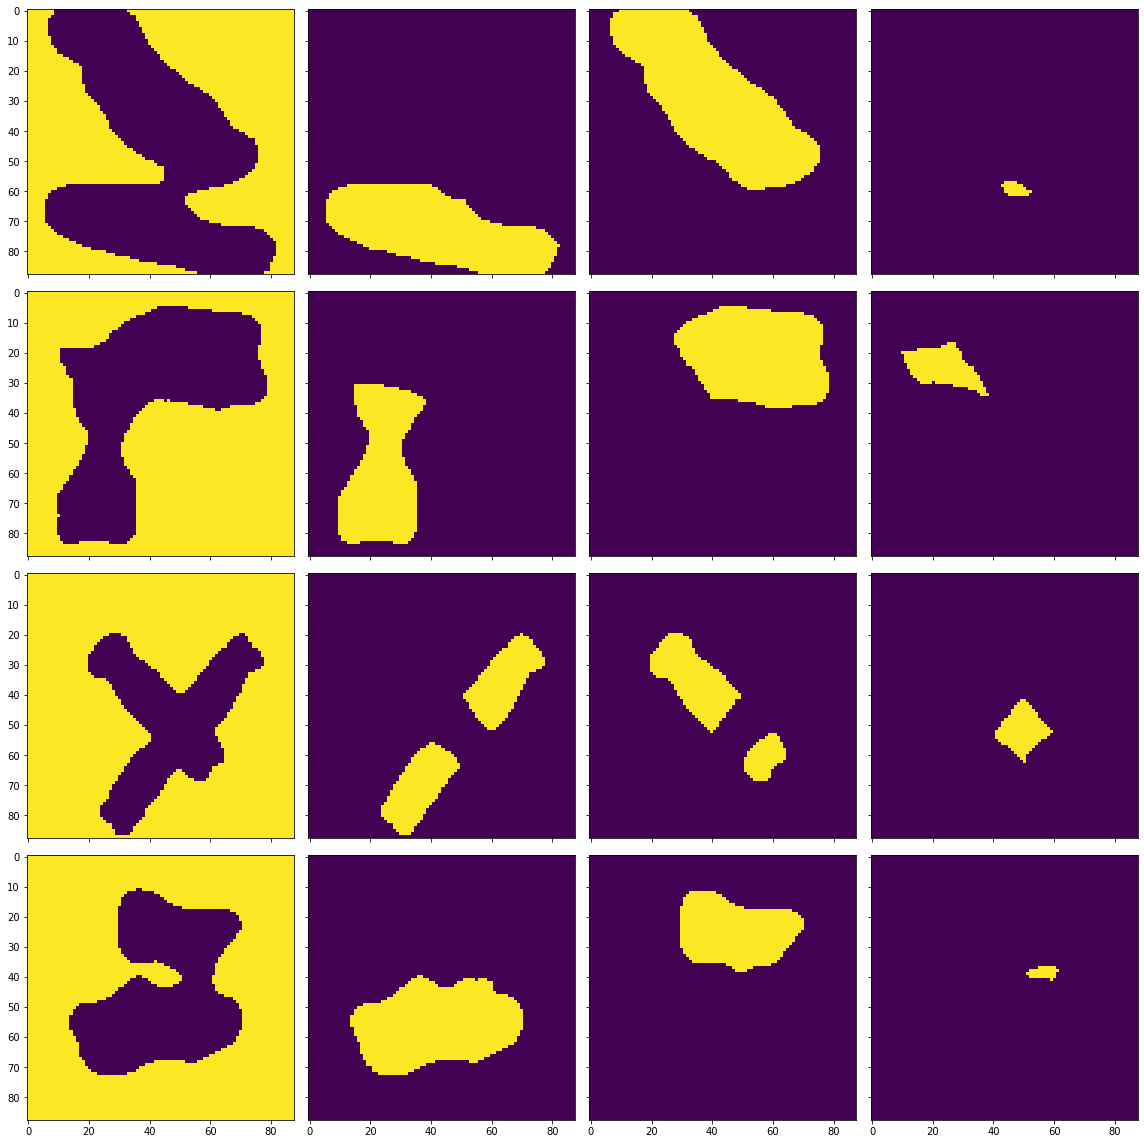

Training IOU: [0.9909953136814355, 0.968611668160689, 0.9699768927107005, 0.9312556796920939]
Training accuracy: 0.9903470428719008
Testing IOU: [0.9705506800244332, 0.3921142566373507, 0.30313236207145833, 0.37146117997653993]
Testing accuracy: 0.8611234504132231
13/13 [==============================] - 1s 66ms/step - loss: 0.0043 - val_loss: 0.0611
INFO:tensorflow:Assets written to: modelunet/savedmodel_176epoch\assets
4
4


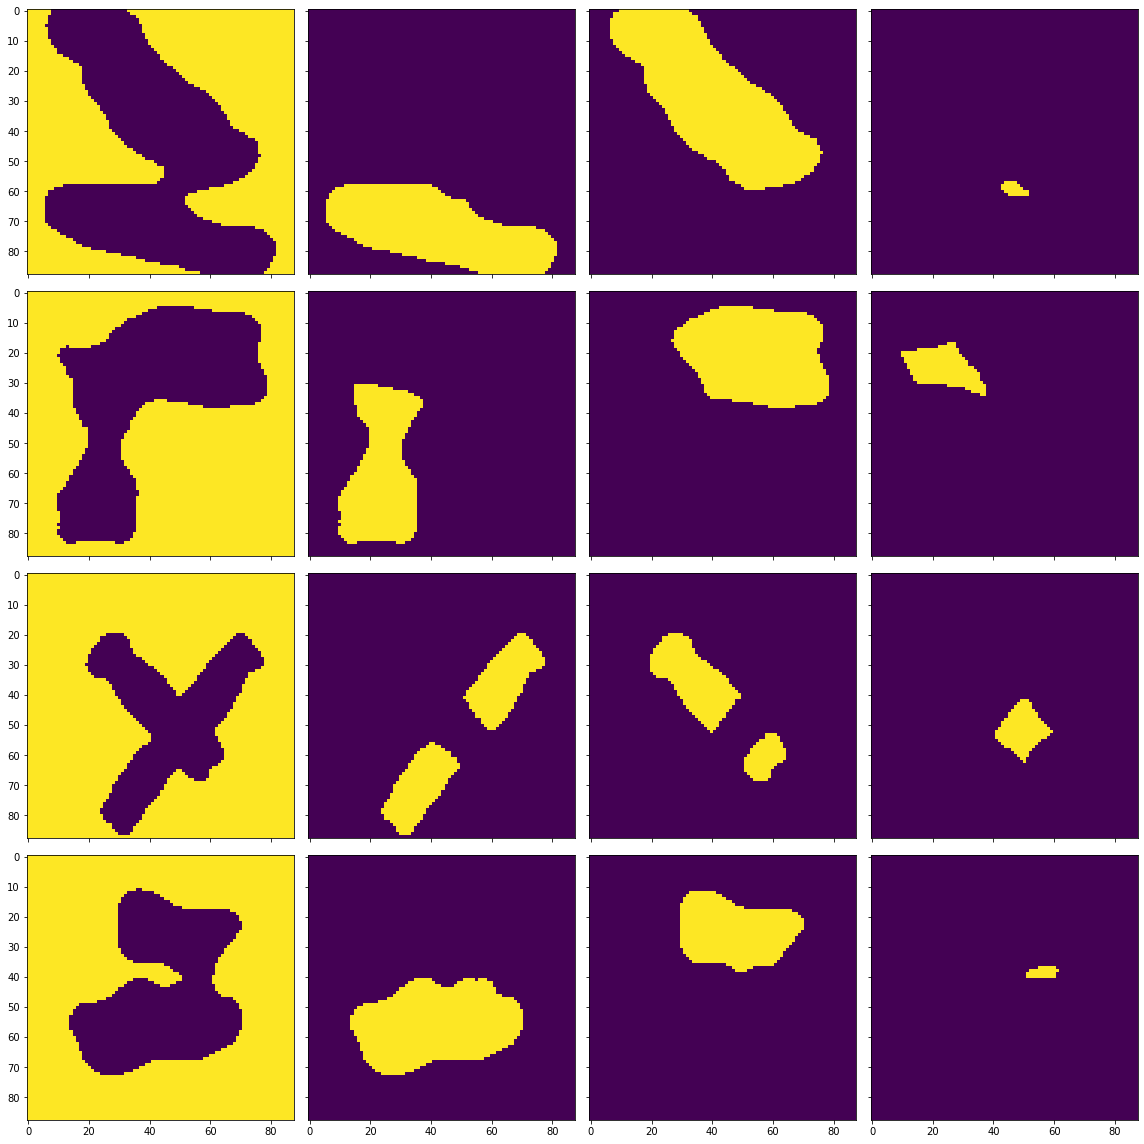

Training IOU: [0.9906579235679315, 0.9651038087986777, 0.9705162717701681, 0.9277641789490131]
Training accuracy: 0.9902330836776859
Testing IOU: [0.9700901932318006, 0.3782025641565441, 0.30822276241601676, 0.354264962397415]
Testing accuracy: 0.8592858987603306
13/13 [==============================] - 1s 67ms/step - loss: 0.0042 - val_loss: 0.0620- ETA: 0s - loss: 
INFO:tensorflow:Assets written to: modelunet/savedmodel_177epoch\assets
4
4


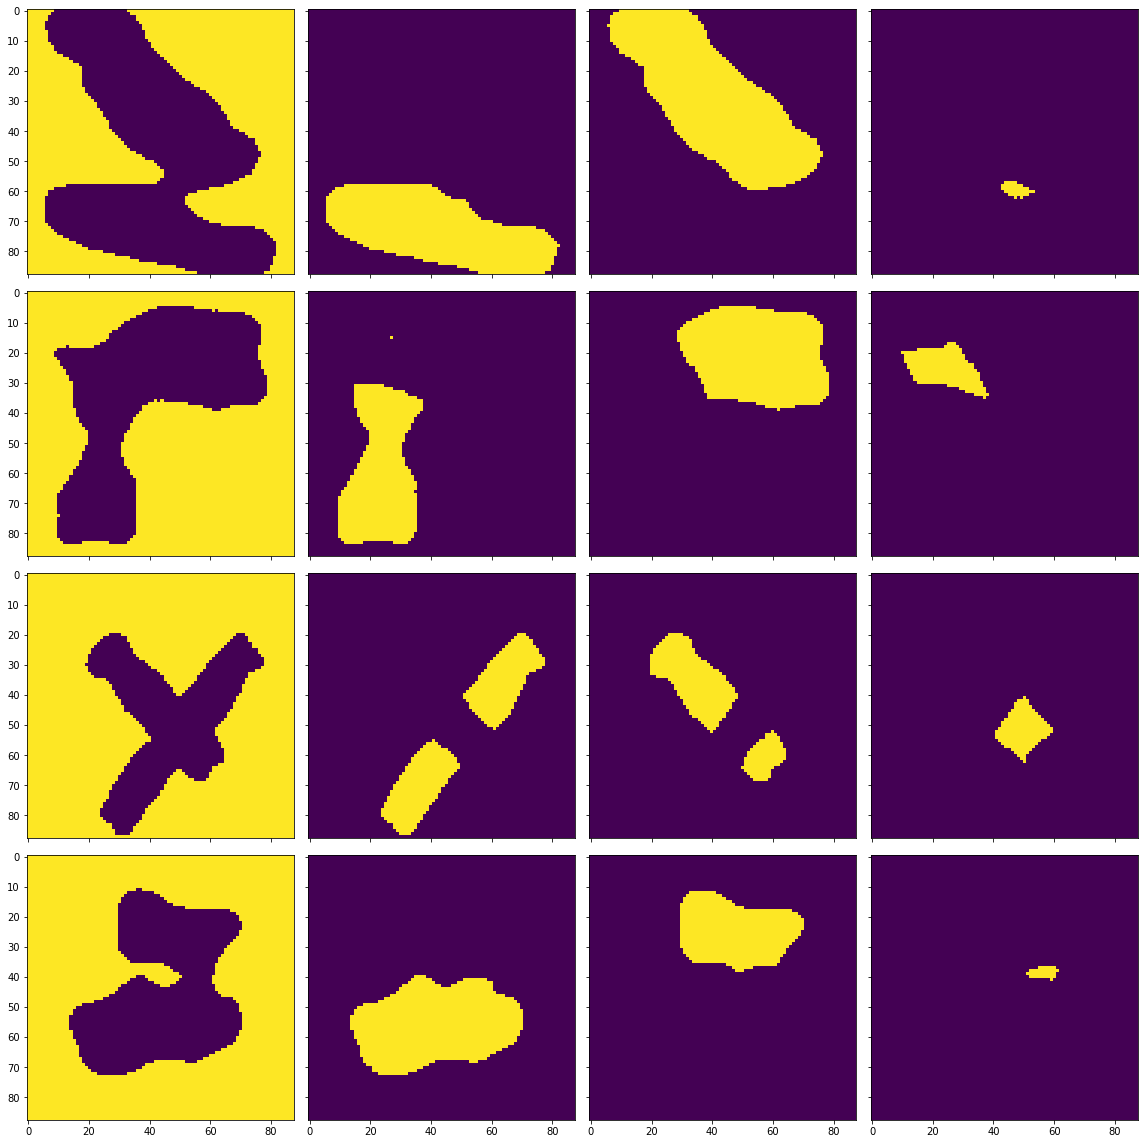

Training IOU: [0.991147209857327, 0.9698071841500987, 0.9713054671092745, 0.931829441838402]
Training accuracy: 0.9911873708677686
Testing IOU: [0.9706657404671433, 0.3816880521885639, 0.31676724746196055, 0.3622306793323544]
Testing accuracy: 0.8610588842975206
13/13 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_178epoch\assets
4
4


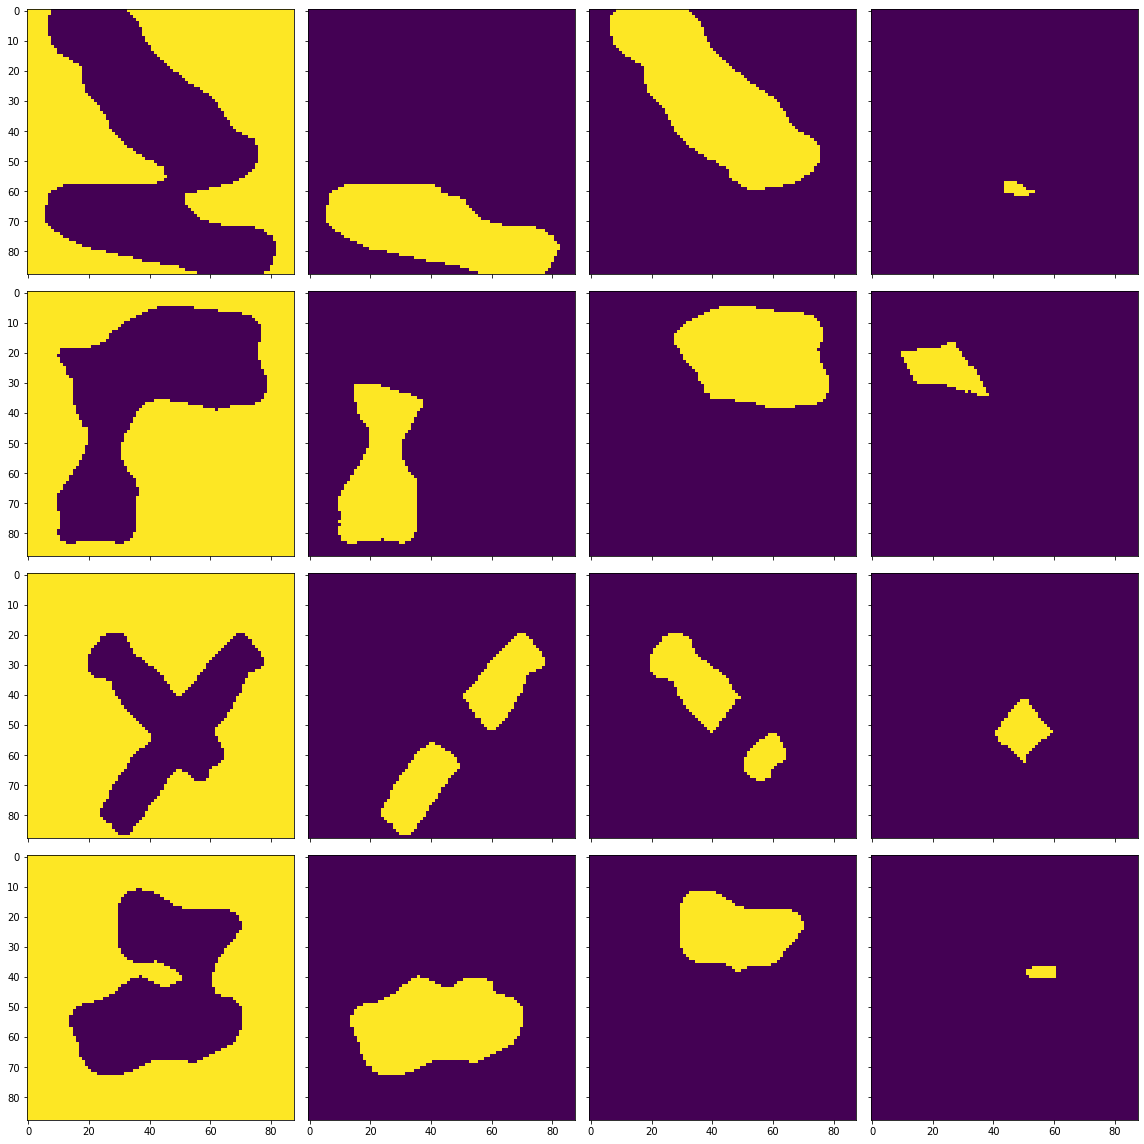

Training IOU: [0.9913778111315078, 0.9686069765879002, 0.9707448766719843, 0.9298456477732794]
Training accuracy: 0.9905317019628099
Testing IOU: [0.9701891128155762, 0.3778094923404644, 0.30806928034371645, 0.35302126180406695]
Testing accuracy: 0.8587461260330579
13/13 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_179epoch\assets
4
4


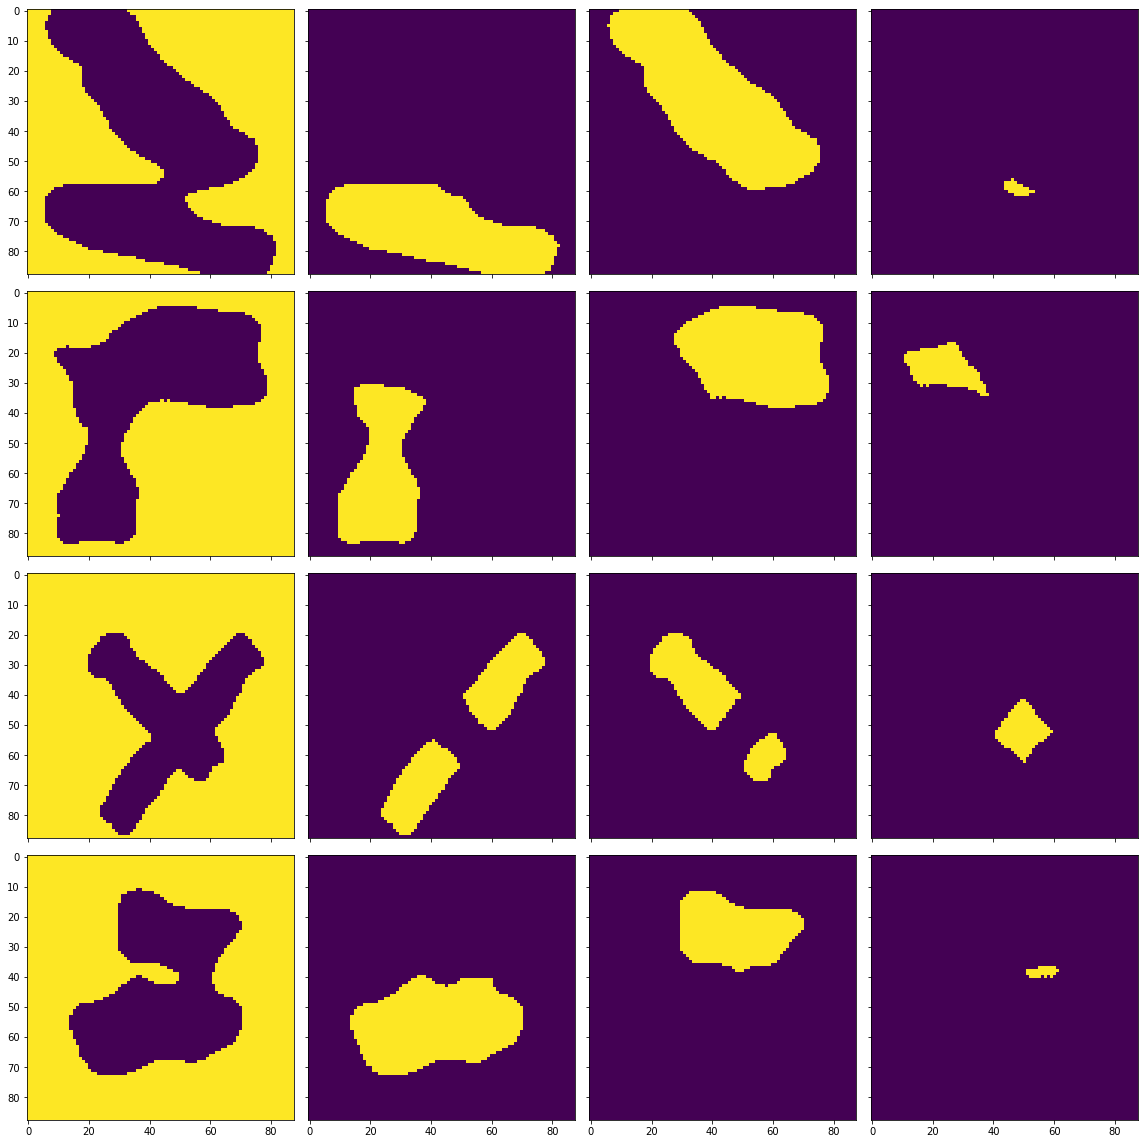

Training IOU: [0.9913555161015214, 0.9700356898428636, 0.9725286256681139, 0.9347416591283989]
Training accuracy: 0.9910262784090909
Testing IOU: [0.9708729806044656, 0.3975710419485792, 0.2974137192772116, 0.36691446374039915]
Testing accuracy: 0.8611428202479339
13/13 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0616
INFO:tensorflow:Assets written to: modelunet/savedmodel_180epoch\assets
4
4


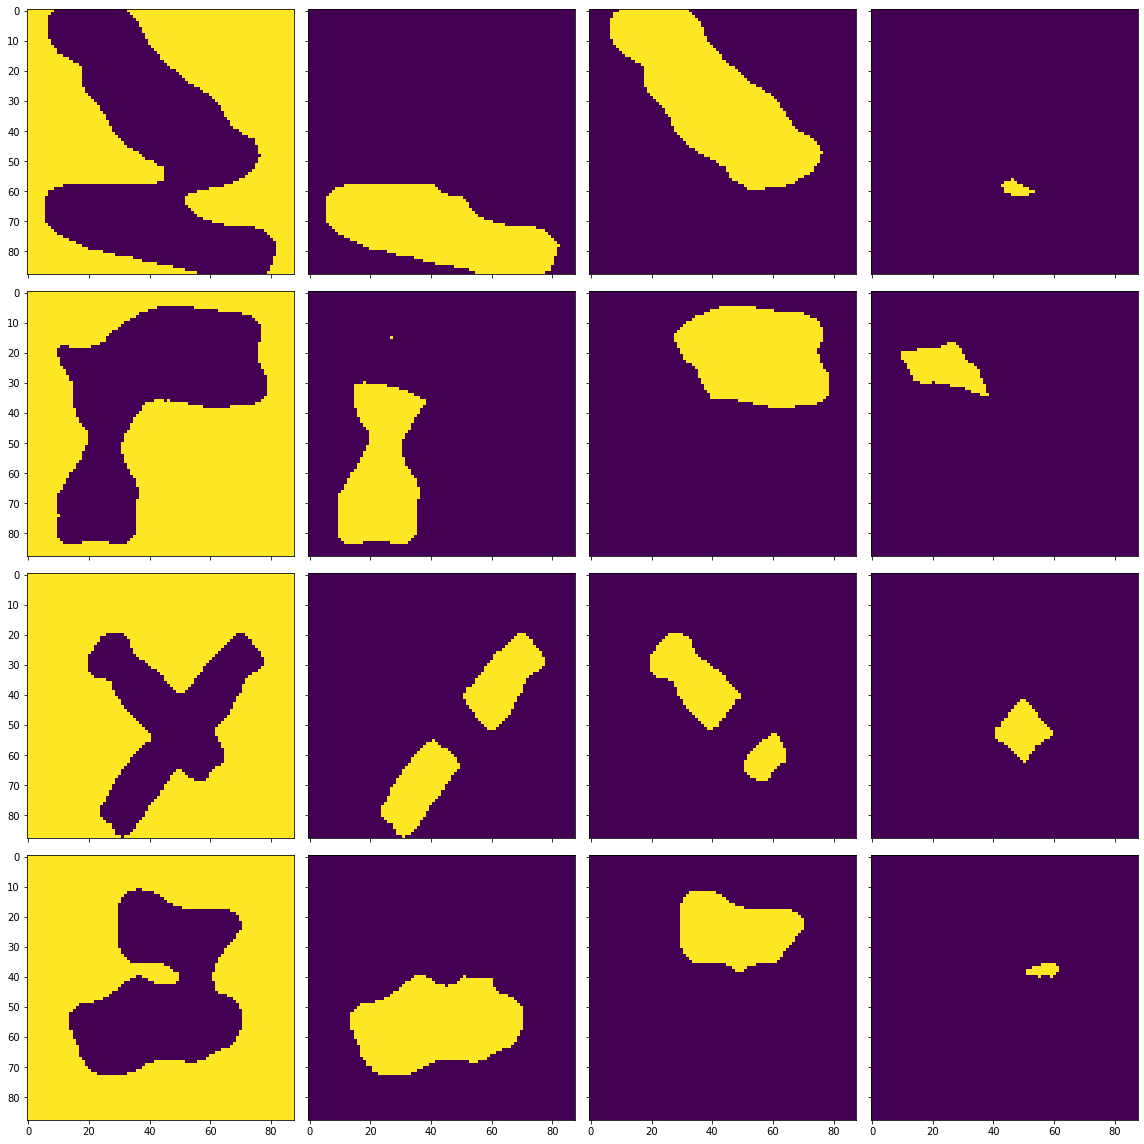

Training IOU: [0.990825502277423, 0.9661499532678323, 0.9685253200386152, 0.9211141979821611]
Training accuracy: 0.9903819085743801
Testing IOU: [0.9706849234525801, 0.4060646540208389, 0.2887042139810801, 0.36554012025710136]
Testing accuracy: 0.8617678202479339
13/13 [==============================] - 1s 66ms/step - loss: 0.0042 - val_loss: 0.0627ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_181epoch\assets
4
4


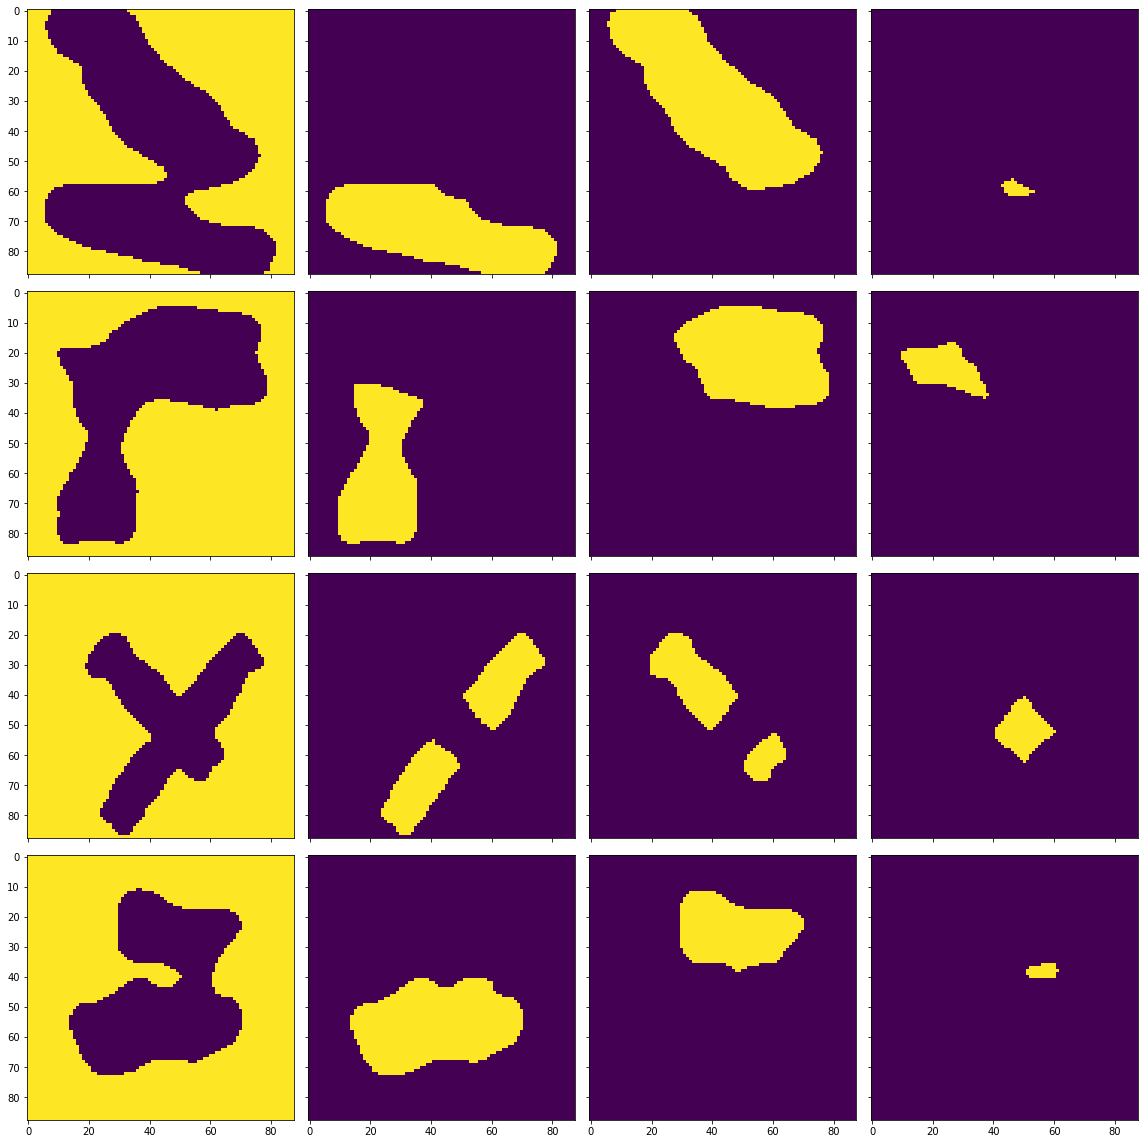

Training IOU: [0.9917300252834835, 0.9699064848883657, 0.9720939608650763, 0.9250638017617518]
Training accuracy: 0.9912629132231405
Testing IOU: [0.9703445501615106, 0.3780411992427025, 0.31384284068713375, 0.35161957270847694]
Testing accuracy: 0.8599044421487604
13/13 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0601
INFO:tensorflow:Assets written to: modelunet/savedmodel_182epoch\assets
4
4


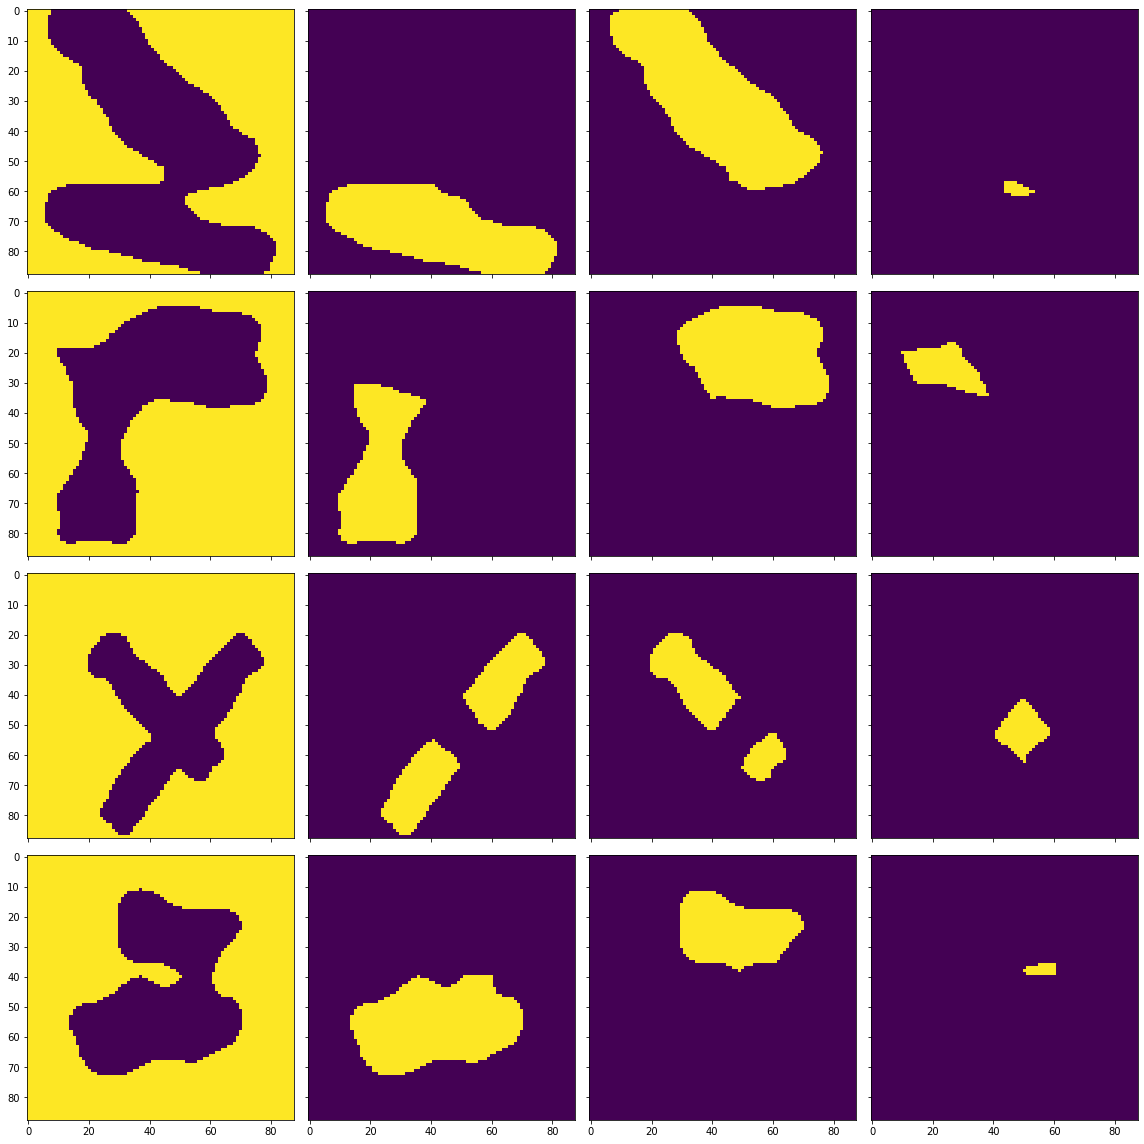

Training IOU: [0.9914710007284251, 0.9687206979728469, 0.9698389570342507, 0.9251488063490709]
Training accuracy: 0.9905565599173554
Testing IOU: [0.9701927174173692, 0.4045856591969366, 0.2909228652536617, 0.3753105293330785]
Testing accuracy: 0.8620674070247933
13/13 [==============================] - ETA: 0s - loss: 0.0042- ETA: 0s - loss: 0. - ETA: 0s - loss: 0. - 1s 67ms/step - loss: 0.0041 - val_loss: 0.0608
INFO:tensorflow:Assets written to: modelunet/savedmodel_183epoch\assets
4
4


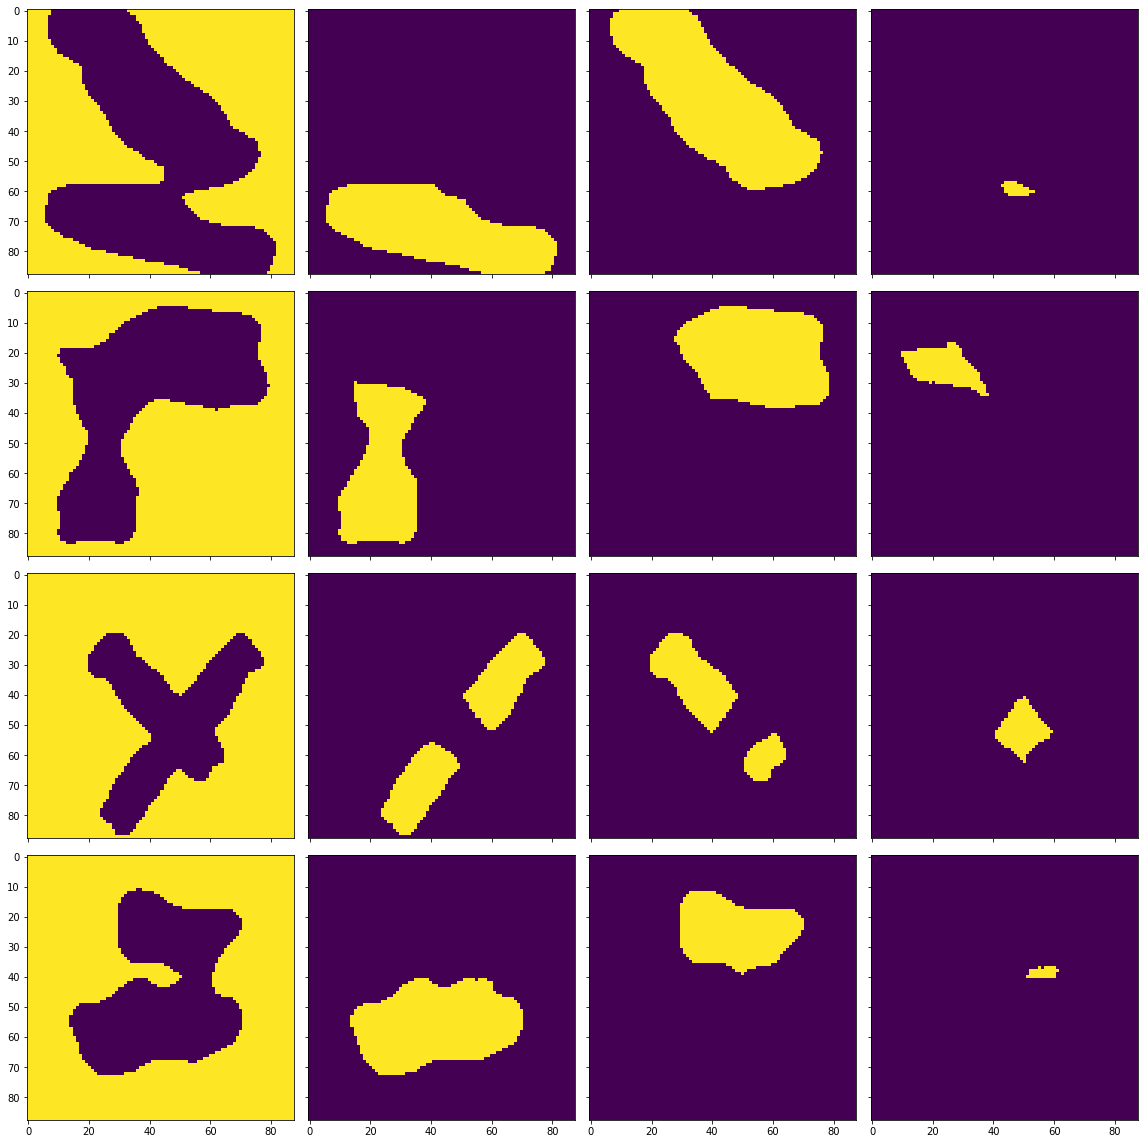

Training IOU: [0.9915555473658333, 0.9694254756088534, 0.9715667427283075, 0.9284644075361025]
Training accuracy: 0.9909194214876033
Testing IOU: [0.9700812233884714, 0.38588639559937093, 0.309328900195629, 0.3726998681153049]
Testing accuracy: 0.8609310433884297
13/13 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0600
INFO:tensorflow:Assets written to: modelunet/savedmodel_184epoch\assets
4
4


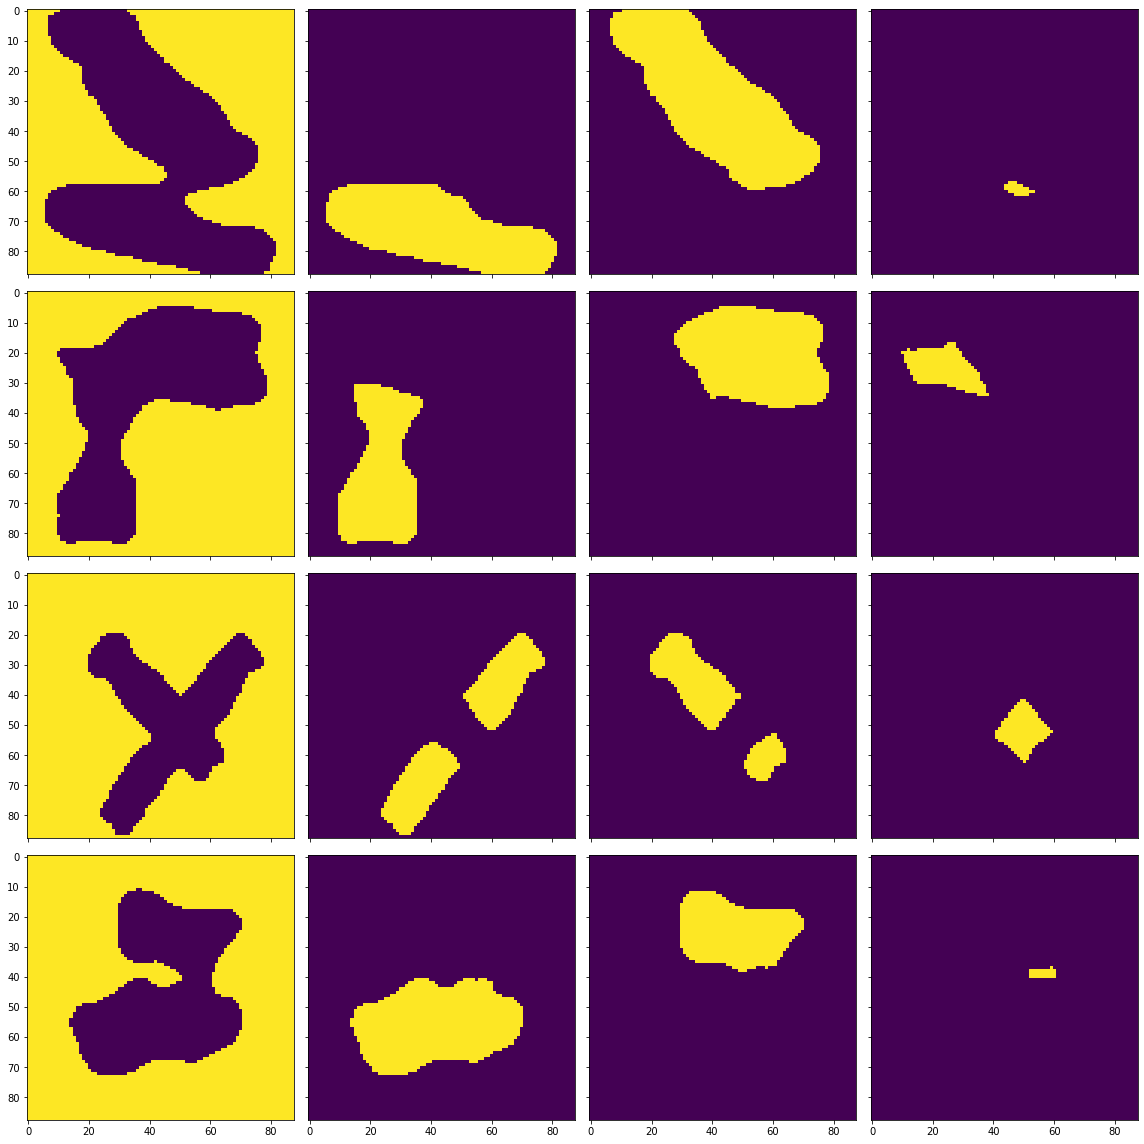

Training IOU: [0.9912325089069035, 0.968688682581173, 0.9678405173945489, 0.9242495661303108]
Training accuracy: 0.9901730371900826
Testing IOU: [0.9700131501617487, 0.3905306291105678, 0.2983746327213438, 0.3751443603233671]
Testing accuracy: 0.8604842458677686
13/13 [==============================] - 1s 66ms/step - loss: 0.0040 - val_loss: 0.0611
INFO:tensorflow:Assets written to: modelunet/savedmodel_185epoch\assets
4
4


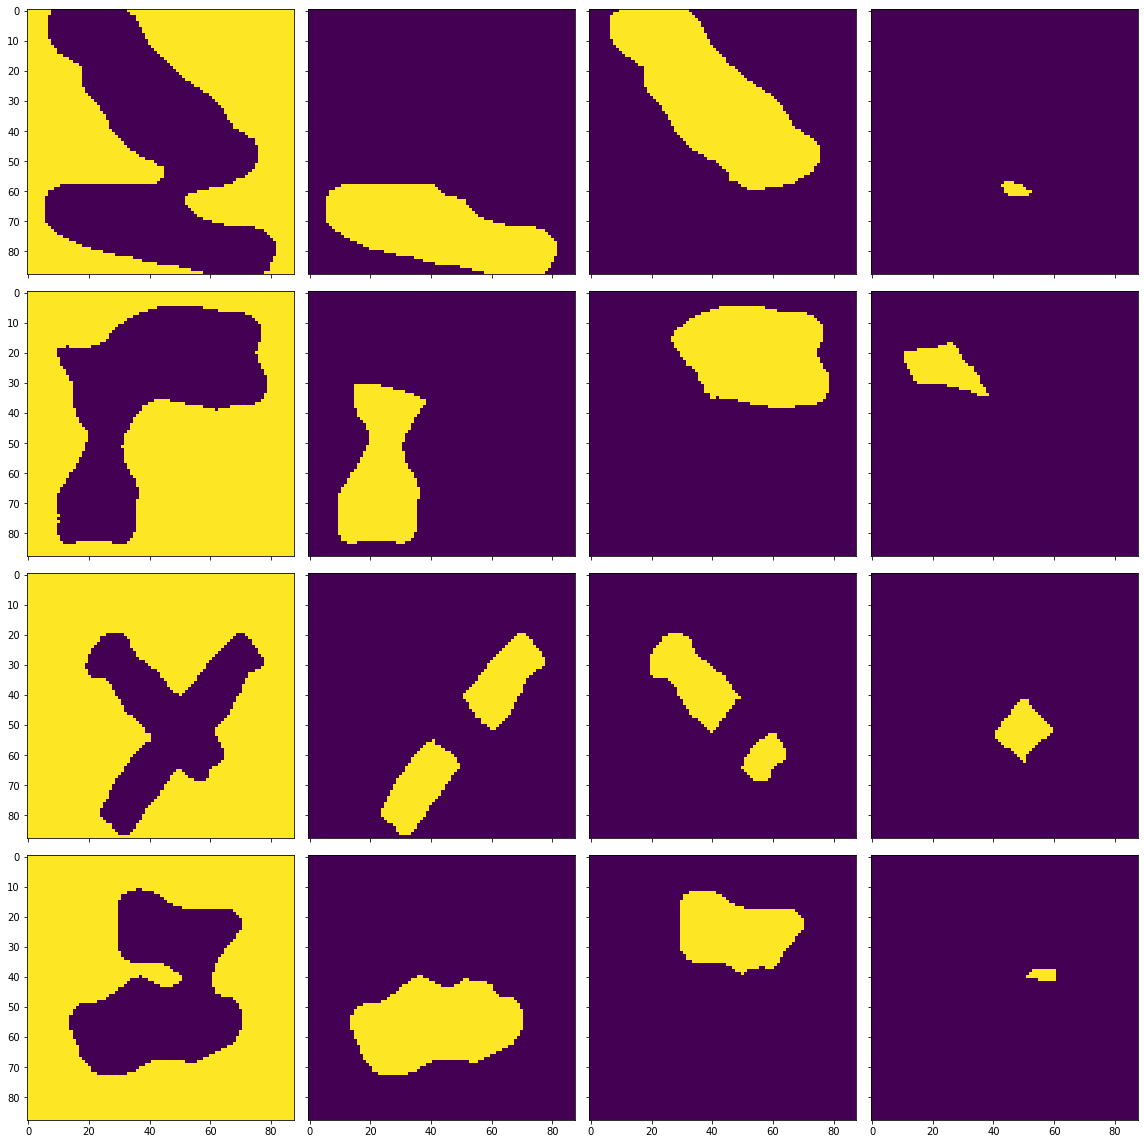

Training IOU: [0.9914673917201164, 0.9710542507274603, 0.971764979803121, 0.925878025251508]
Training accuracy: 0.9908658316115703
Testing IOU: [0.9705502663973027, 0.36984491468541353, 0.319421772850936, 0.3678360436080151]
Testing accuracy: 0.8591980888429752
13/13 [==============================] - 1s 67ms/step - loss: 0.0041 - val_loss: 0.0616
INFO:tensorflow:Assets written to: modelunet/savedmodel_186epoch\assets
4
4


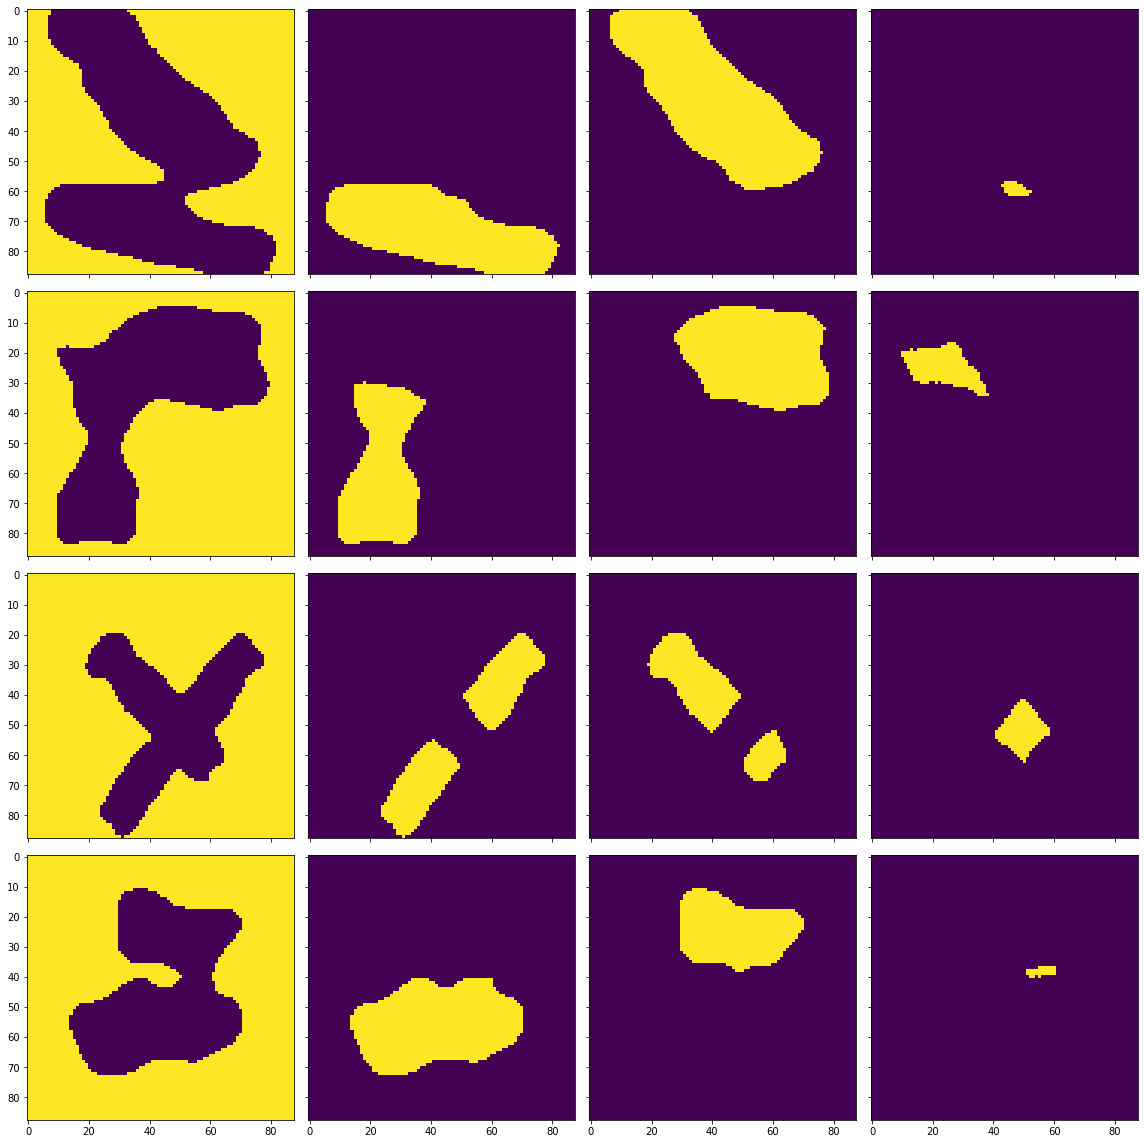

Training IOU: [0.9905494465892147, 0.9687509311232383, 0.9695600847379968, 0.9281013736556277]
Training accuracy: 0.9905888429752067
Testing IOU: [0.9710216696823569, 0.3876359049590743, 0.30473971120635845, 0.3585109252765039]
Testing accuracy: 0.8599199380165289
13/13 [==============================] - 1s 67ms/step - loss: 0.0042 - val_loss: 0.0605- ETA: 0s - loss:
INFO:tensorflow:Assets written to: modelunet/savedmodel_187epoch\assets
4
4


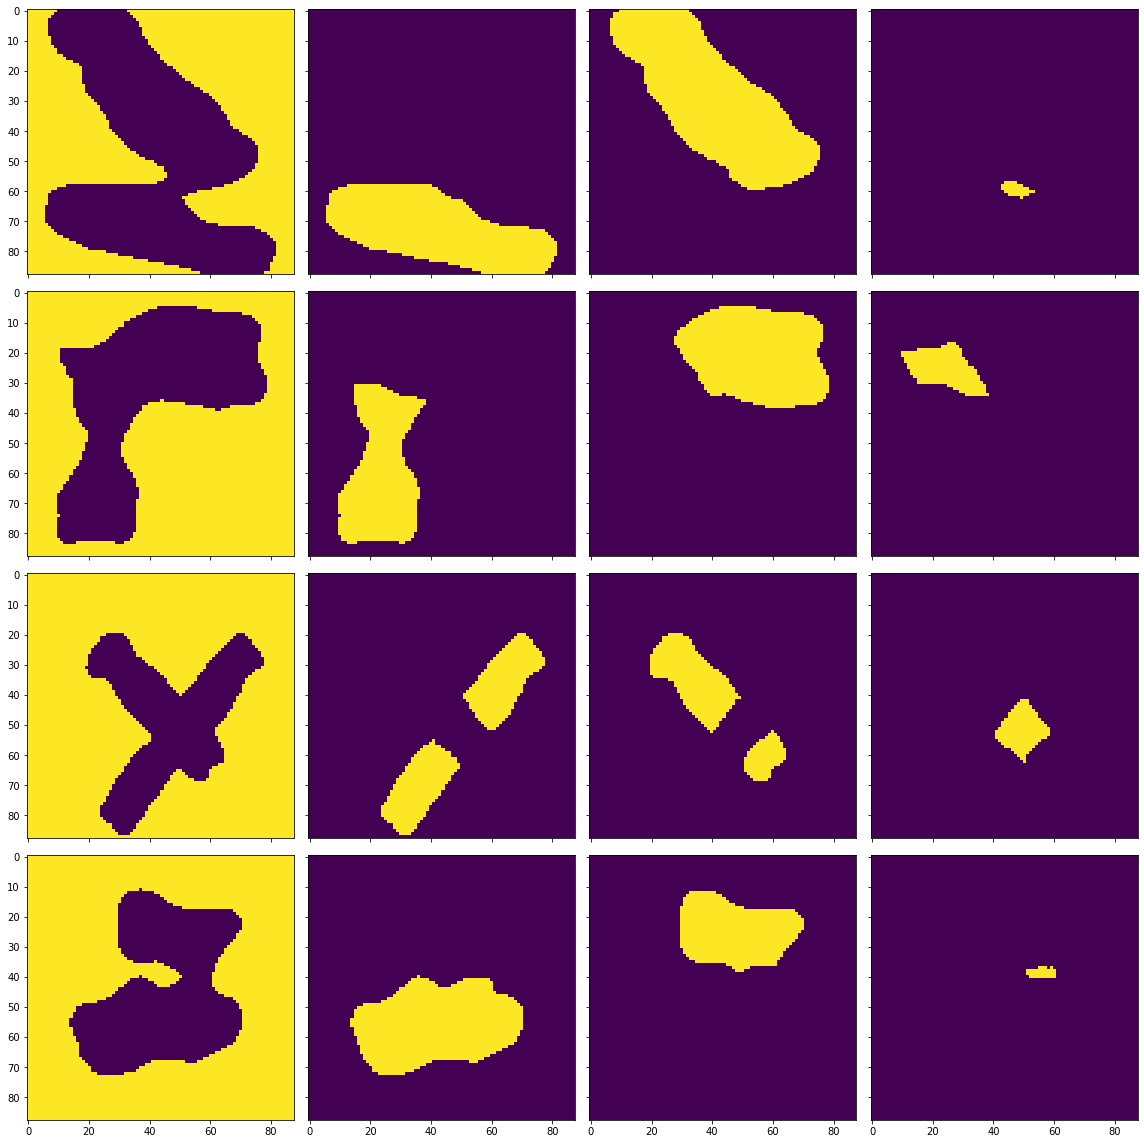

Training IOU: [0.9916924189388026, 0.9704561711160848, 0.9705184488631083, 0.9311954278456898]
Training accuracy: 0.9907299199380165
Testing IOU: [0.9707011650099747, 0.39028292868136116, 0.2884404455869751, 0.3724862184718672]
Testing accuracy: 0.8591451446280992
13/13 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0622
INFO:tensorflow:Assets written to: modelunet/savedmodel_188epoch\assets
4
4


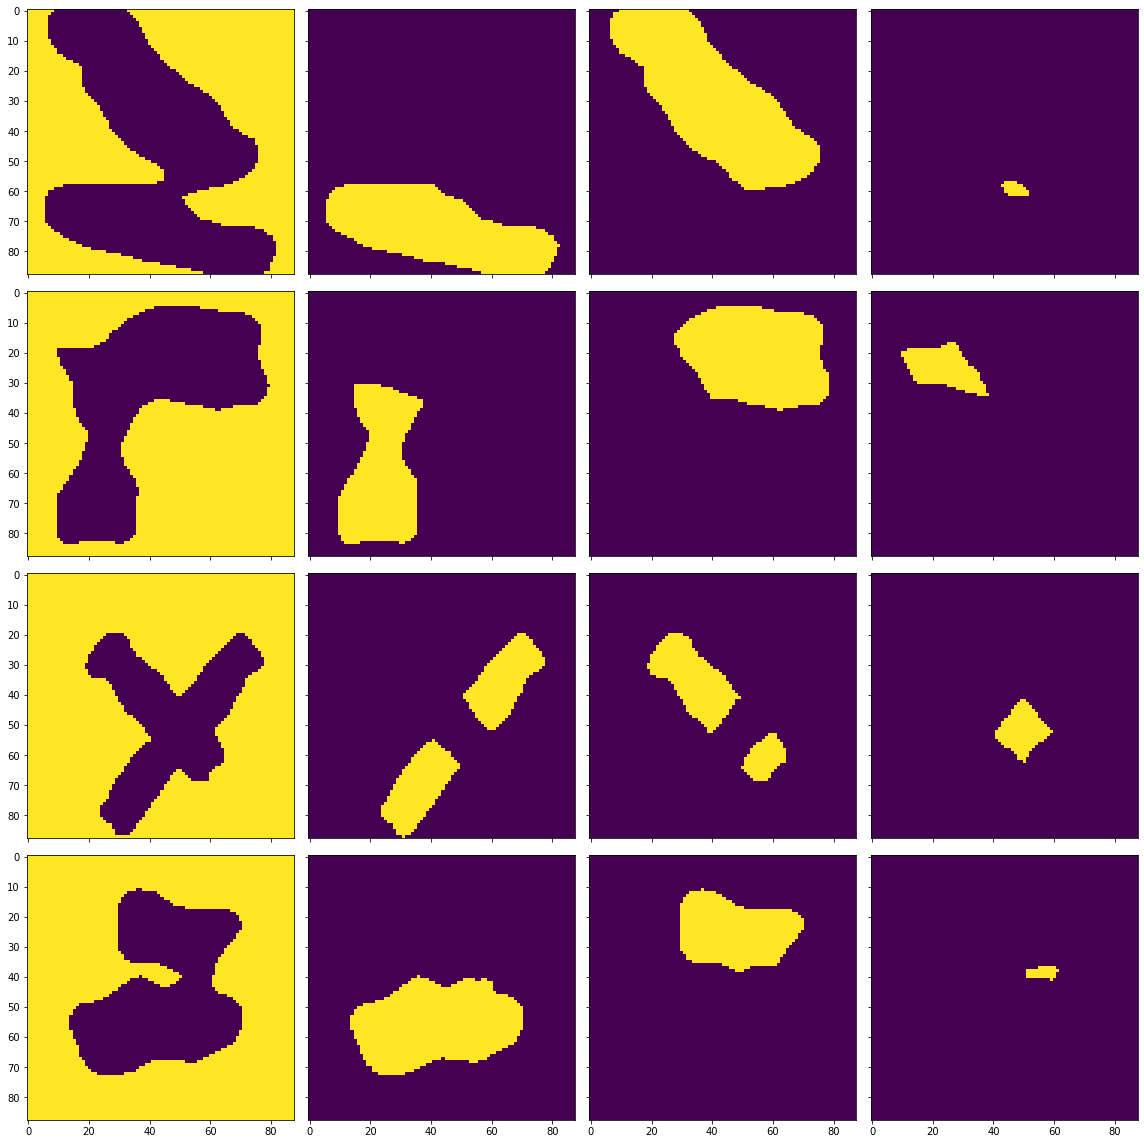

Training IOU: [0.9913369144775227, 0.9688044514296132, 0.9735015190471407, 0.9301916999334664]
Training accuracy: 0.9910391916322314
Testing IOU: [0.9707681425846406, 0.3778900767871848, 0.3155604909215967, 0.35409661510872004]
Testing accuracy: 0.859688791322314
13/13 [==============================] - 1s 66ms/step - loss: 0.0040 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelunet/savedmodel_189epoch\assets
4
4


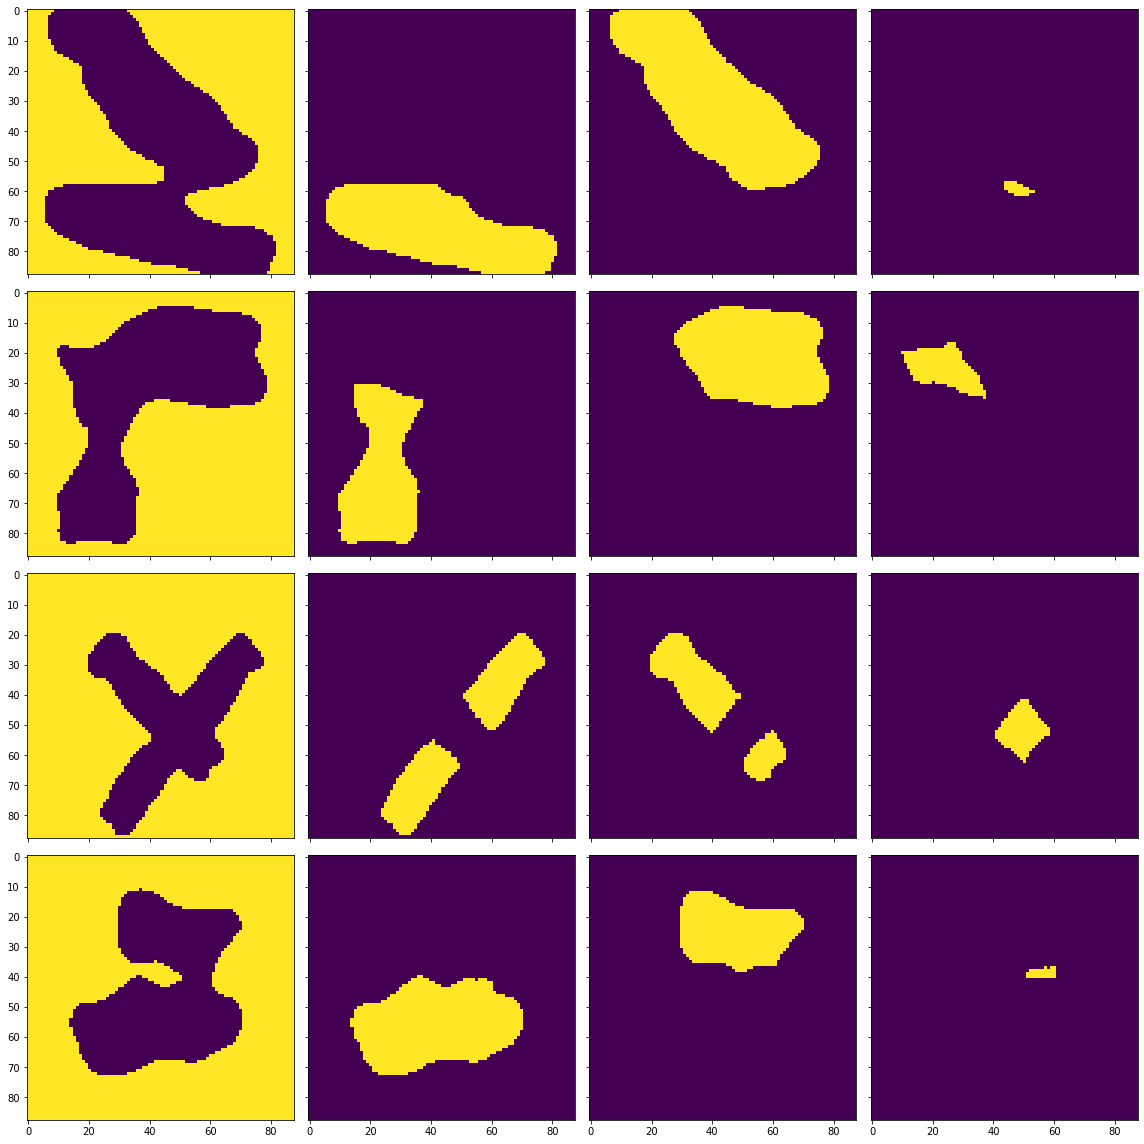

Training IOU: [0.9919037132223014, 0.9706980918346395, 0.9718391543539338, 0.9306403498454991]
Training accuracy: 0.9908122417355372
Testing IOU: [0.9702674018275478, 0.39254405383866114, 0.2915763580692882, 0.37339229547507086]
Testing accuracy: 0.8597055785123967
13/13 [==============================] - ETA: 0s - loss: 0.0040- ETA: 0s - loss: - 1s 67ms/step - loss: 0.0040 - val_loss: 0.0614
INFO:tensorflow:Assets written to: modelunet/savedmodel_190epoch\assets
4
4


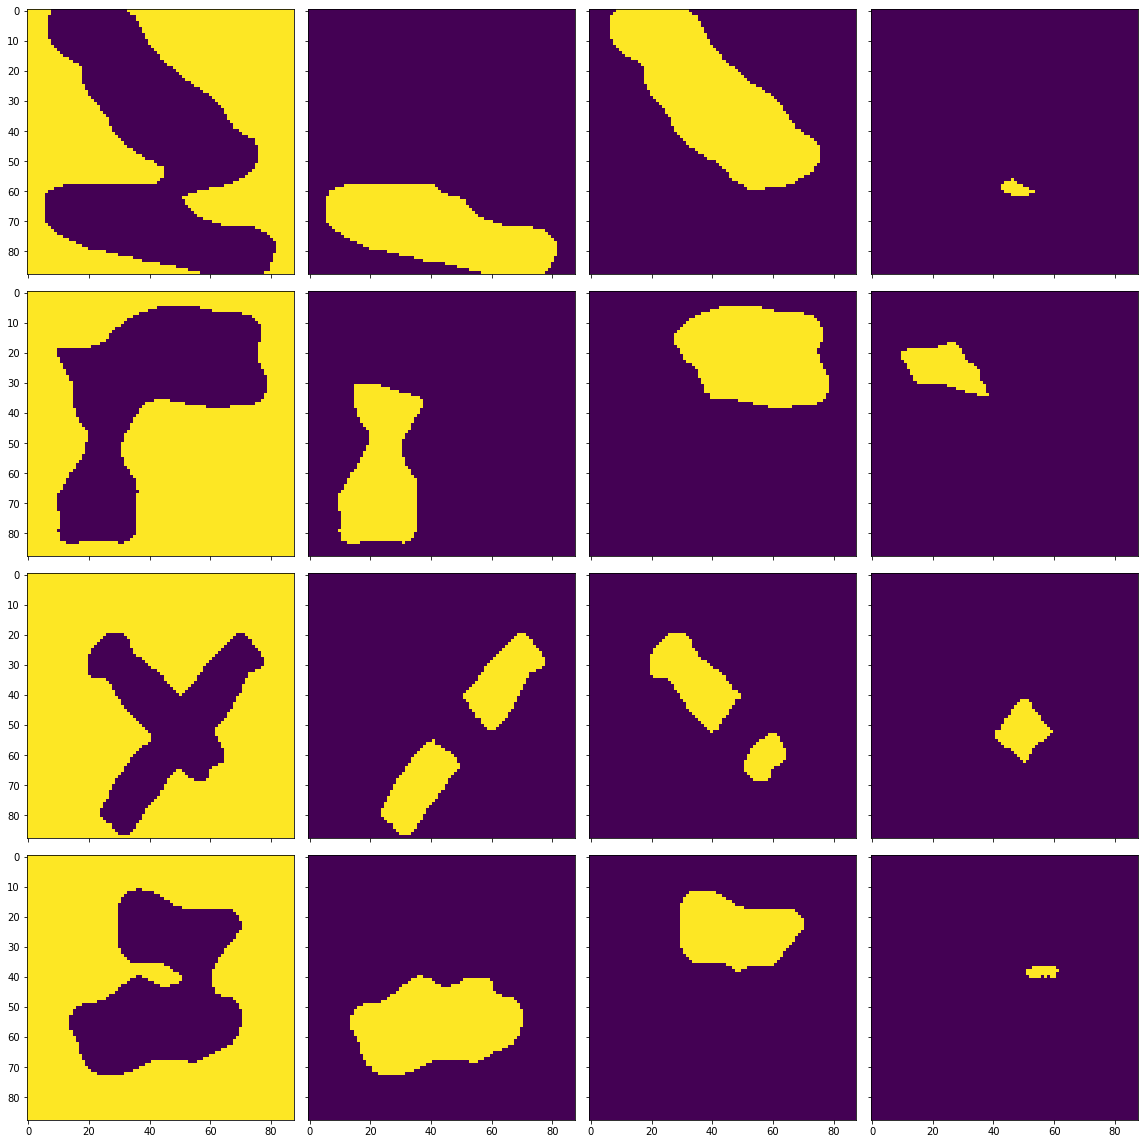

Training IOU: [0.991865057942849, 0.9704339104851157, 0.9720370036643239, 0.9281043693651143]
Training accuracy: 0.9914401472107438
Testing IOU: [0.9704042552088822, 0.40805544395339494, 0.29173150560383265, 0.37059668204454493]
Testing accuracy: 0.8628279958677686
13/13 [==============================] - 1s 66ms/step - loss: 0.0040 - val_loss: 0.0609
INFO:tensorflow:Assets written to: modelunet/savedmodel_191epoch\assets
4
4


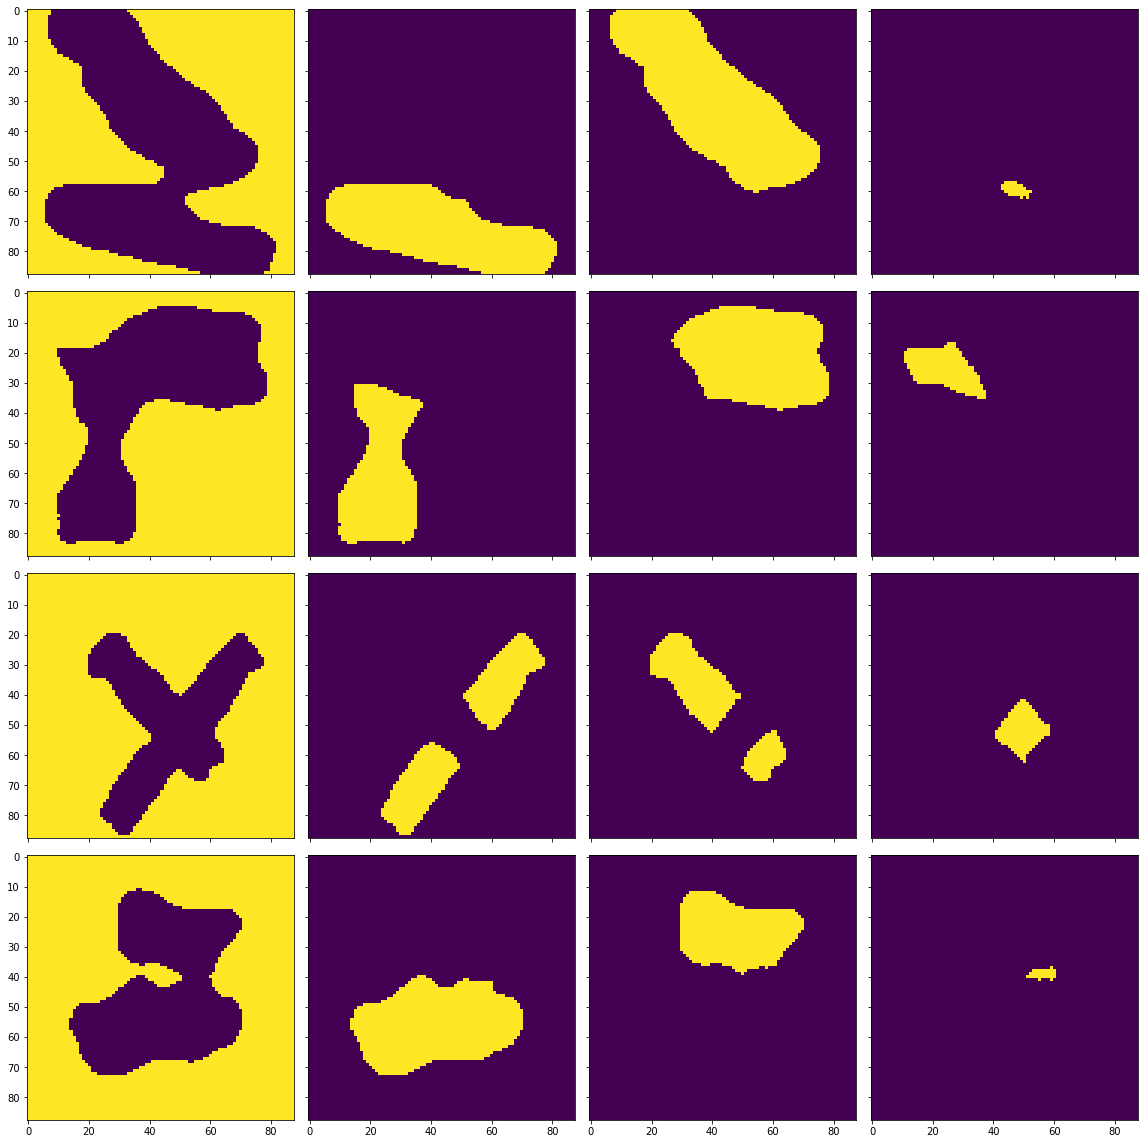

Training IOU: [0.9915321710999281, 0.9663507593865385, 0.9719266875279392, 0.9230866367108987]
Training accuracy: 0.9907118414256199
Testing IOU: [0.9700264067046468, 0.3672852362006808, 0.3262054134463021, 0.37107146091839505]
Testing accuracy: 0.8602556818181818
13/13 [==============================] - 1s 67ms/step - loss: 0.0039 - val_loss: 0.0621
INFO:tensorflow:Assets written to: modelunet/savedmodel_192epoch\assets
4
4


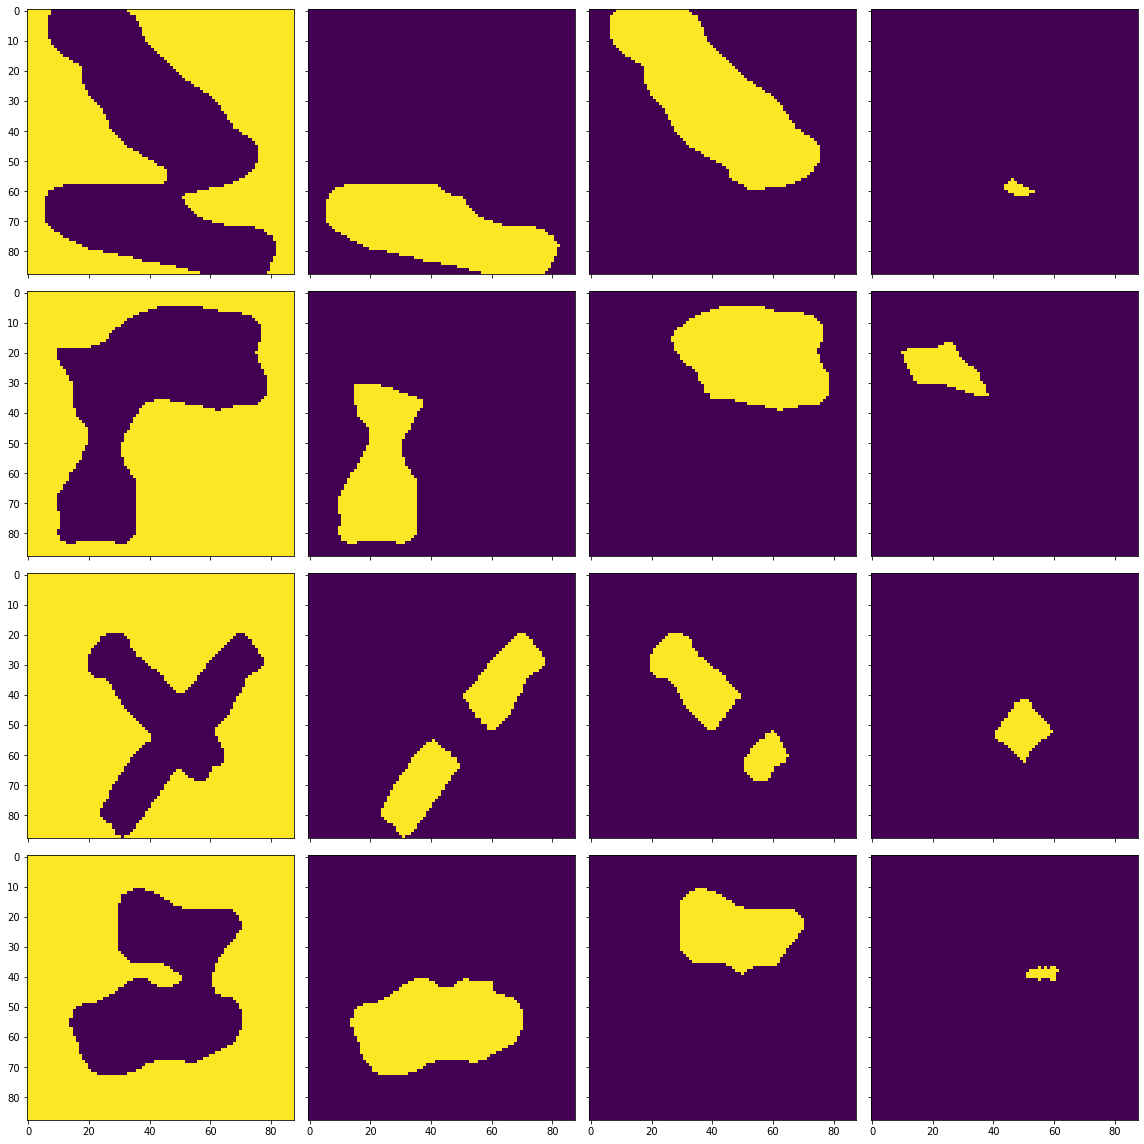

Training IOU: [0.9921061455405505, 0.9717340687972946, 0.9737305120374625, 0.9315044155301249]
Training accuracy: 0.9918004261363637
Testing IOU: [0.9704284633167809, 0.38938709834030366, 0.3086259790849892, 0.36568514070515673]
Testing accuracy: 0.8613713842975207
13/13 [==============================] - 1s 66ms/step - loss: 0.0039 - val_loss: 0.0627
INFO:tensorflow:Assets written to: modelunet/savedmodel_193epoch\assets
4
4


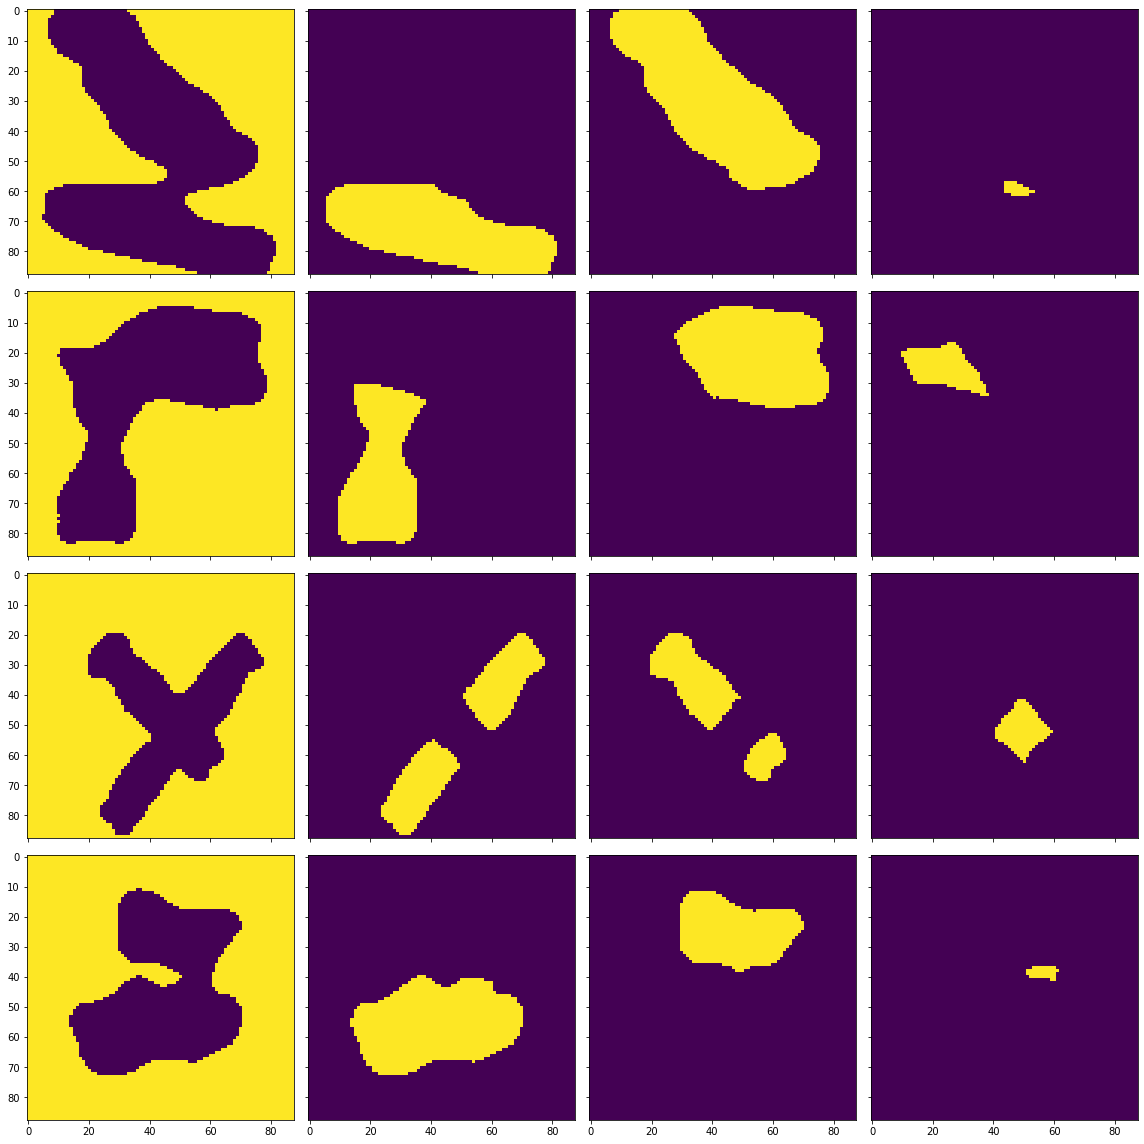

Training IOU: [0.9921128792983548, 0.9715575870649634, 0.970956342889651, 0.9292865104747221]
Training accuracy: 0.9914359504132232
Testing IOU: [0.9701965659233937, 0.38485081915347263, 0.298775108577633, 0.35941108545034645]
Testing accuracy: 0.859452479338843
13/13 [==============================] - 1s 66ms/step - loss: 0.0039 - val_loss: 0.0609
INFO:tensorflow:Assets written to: modelunet/savedmodel_194epoch\assets
4
4


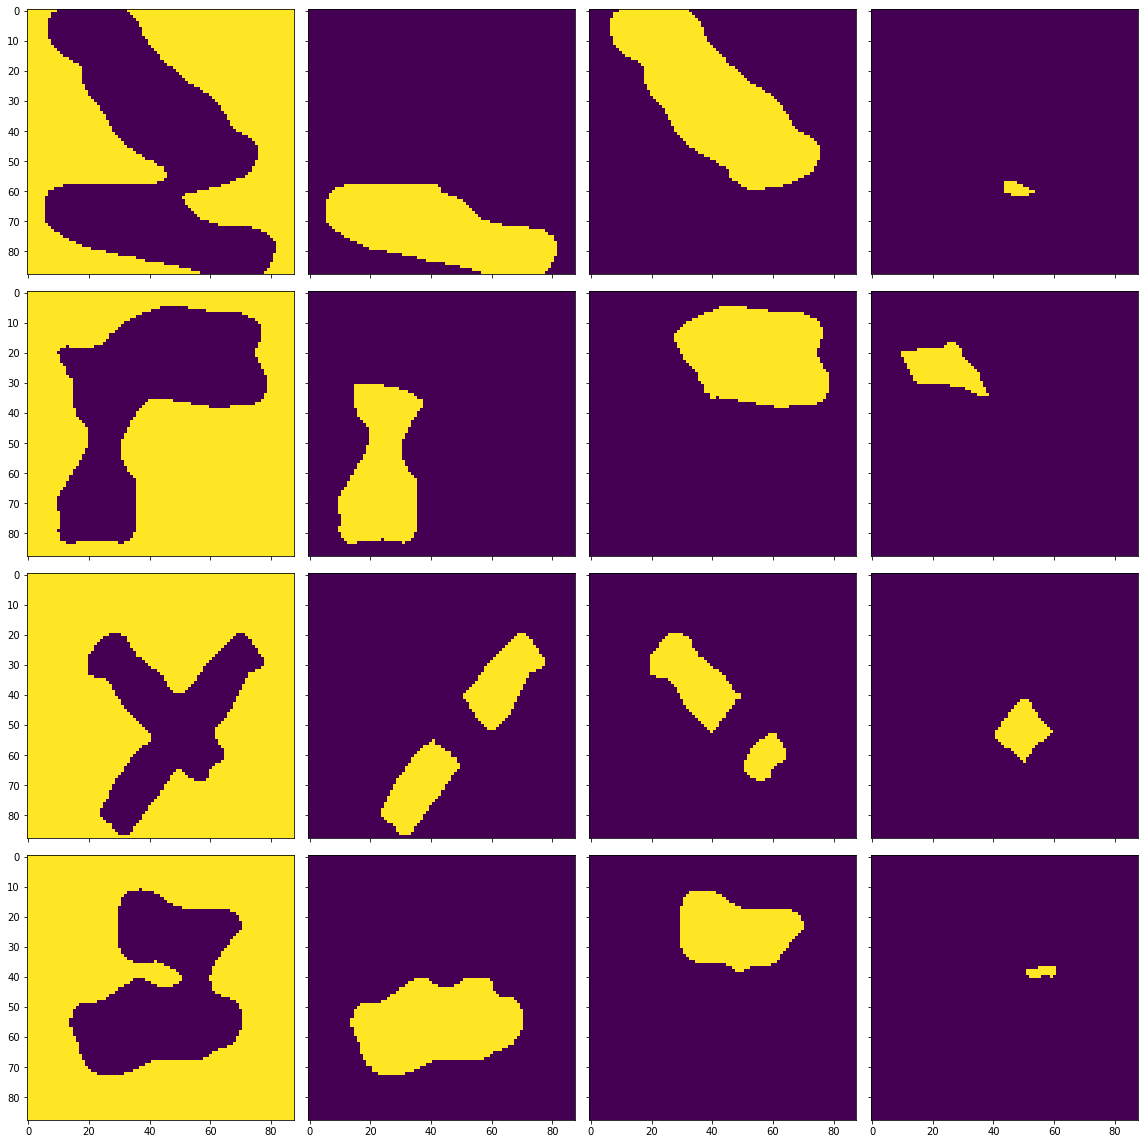

Training IOU: [0.991405866824142, 0.969968500211081, 0.9675402319025, 0.9342406967204493]
Training accuracy: 0.9908103047520661
Testing IOU: [0.9690845154061046, 0.39449144098021566, 0.2921568456708958, 0.36454171562867216]
Testing accuracy: 0.8605061983471074
13/13 [==============================] - 1s 66ms/step - loss: 0.0040 - val_loss: 0.0606: 0s - loss: 0.004
INFO:tensorflow:Assets written to: modelunet/savedmodel_195epoch\assets
4
4


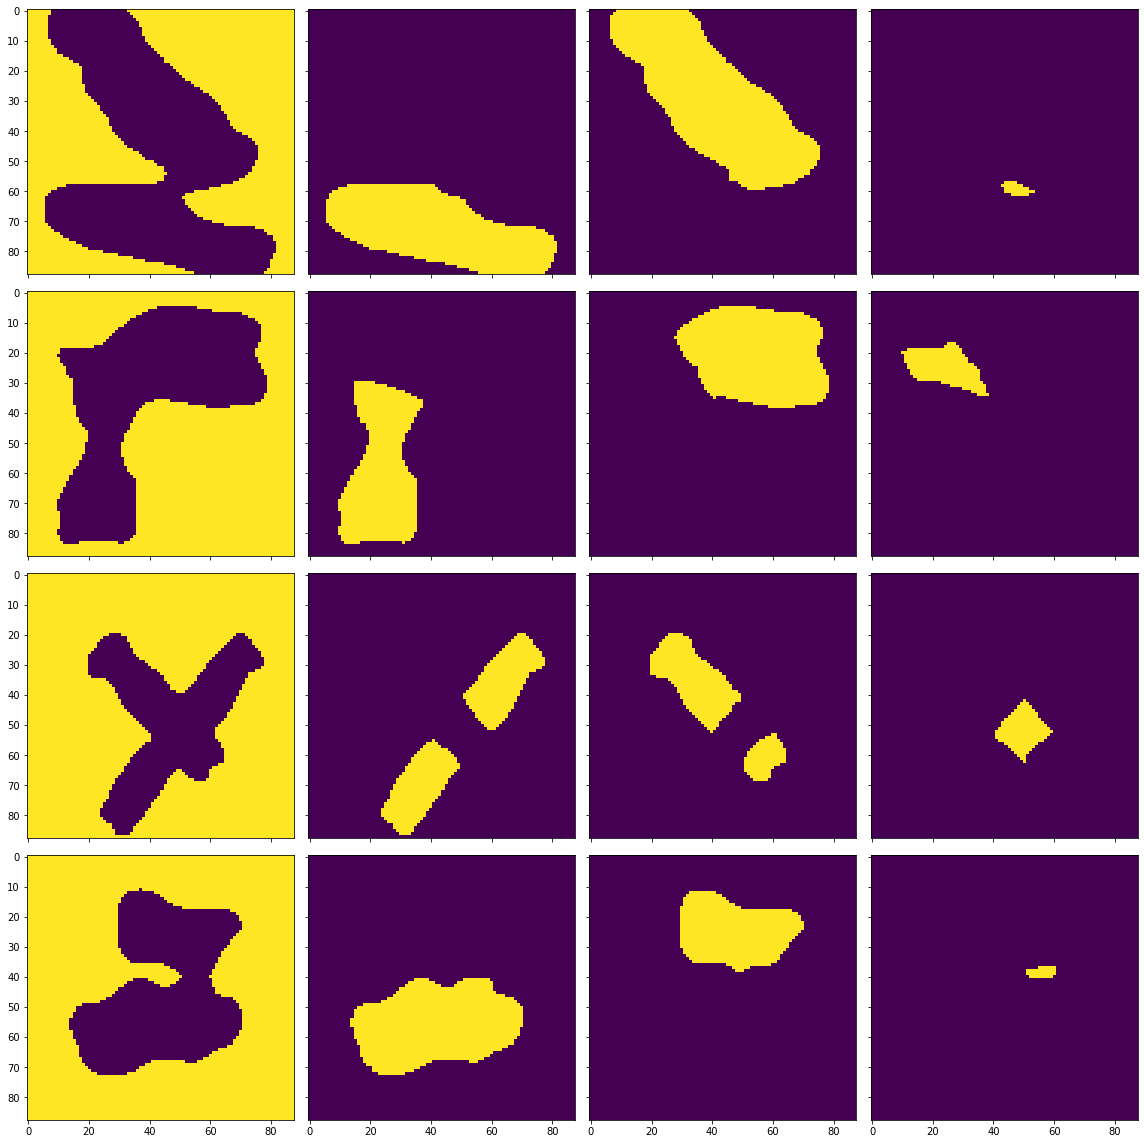

Training IOU: [0.991814537718797, 0.9701411596925271, 0.9711763611694678, 0.9270484524943031]
Training accuracy: 0.9911305526859504
Testing IOU: [0.9699787212763096, 0.4056141774891775, 0.2959003020099281, 0.37179324760879207]
Testing accuracy: 0.8630074896694215
13/13 [==============================] - 1s 67ms/step - loss: 0.0041 - val_loss: 0.0627
INFO:tensorflow:Assets written to: modelunet/savedmodel_196epoch\assets
4
4


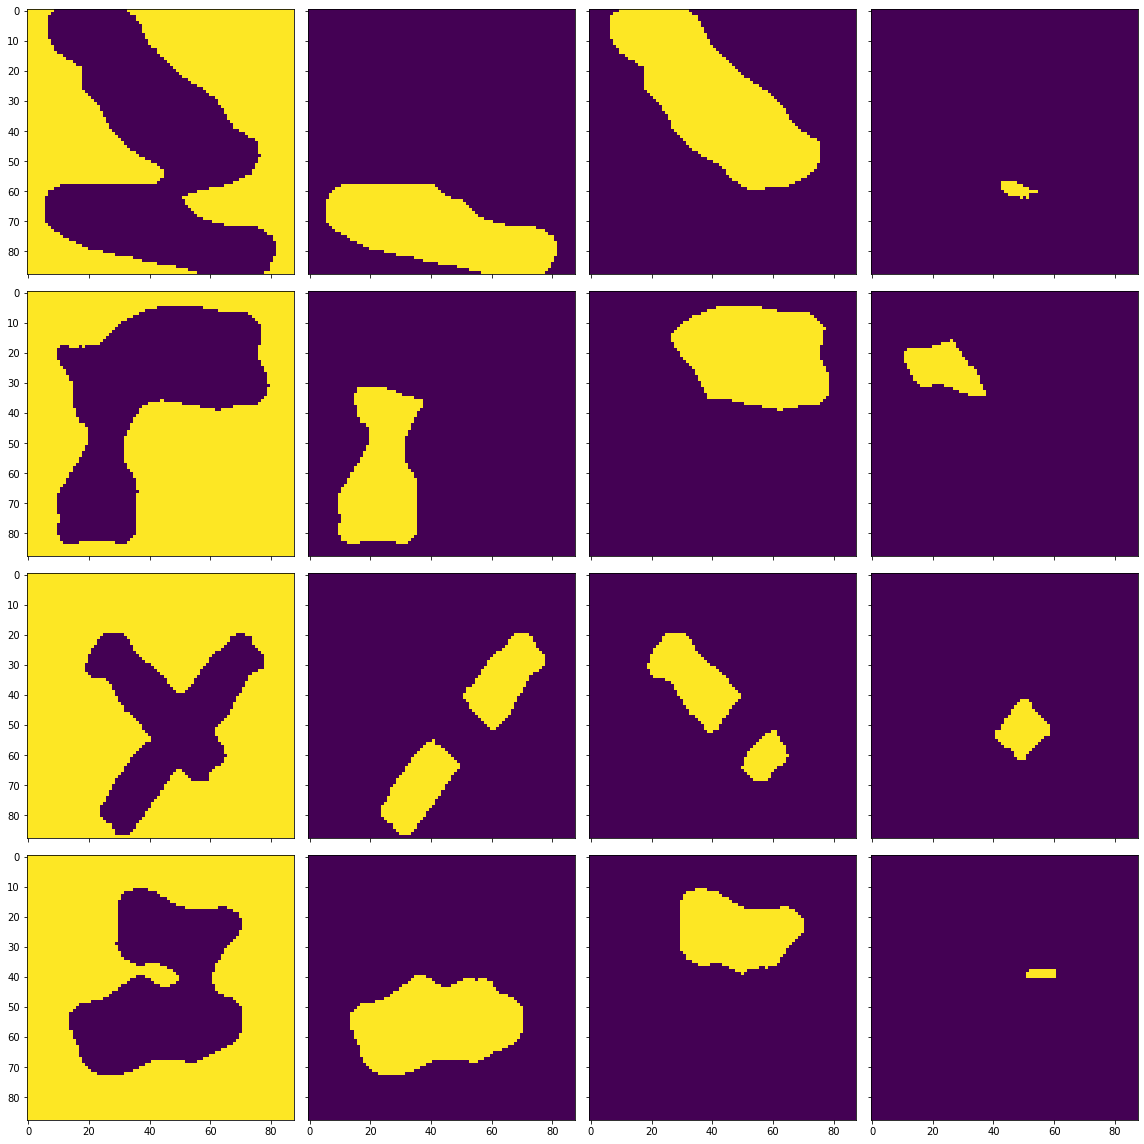

Training IOU: [0.9884679067193405, 0.9638008738431899, 0.9613577427101018, 0.9199850671976108]
Training accuracy: 0.9888297391528925
Testing IOU: [0.9705341594222003, 0.37298446719522327, 0.32392632112594455, 0.3636284646798158]
Testing accuracy: 0.8591490185950413
13/13 [==============================] - 1s 66ms/step - loss: 0.0044 - val_loss: 0.0607A: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_197epoch\assets
4
4


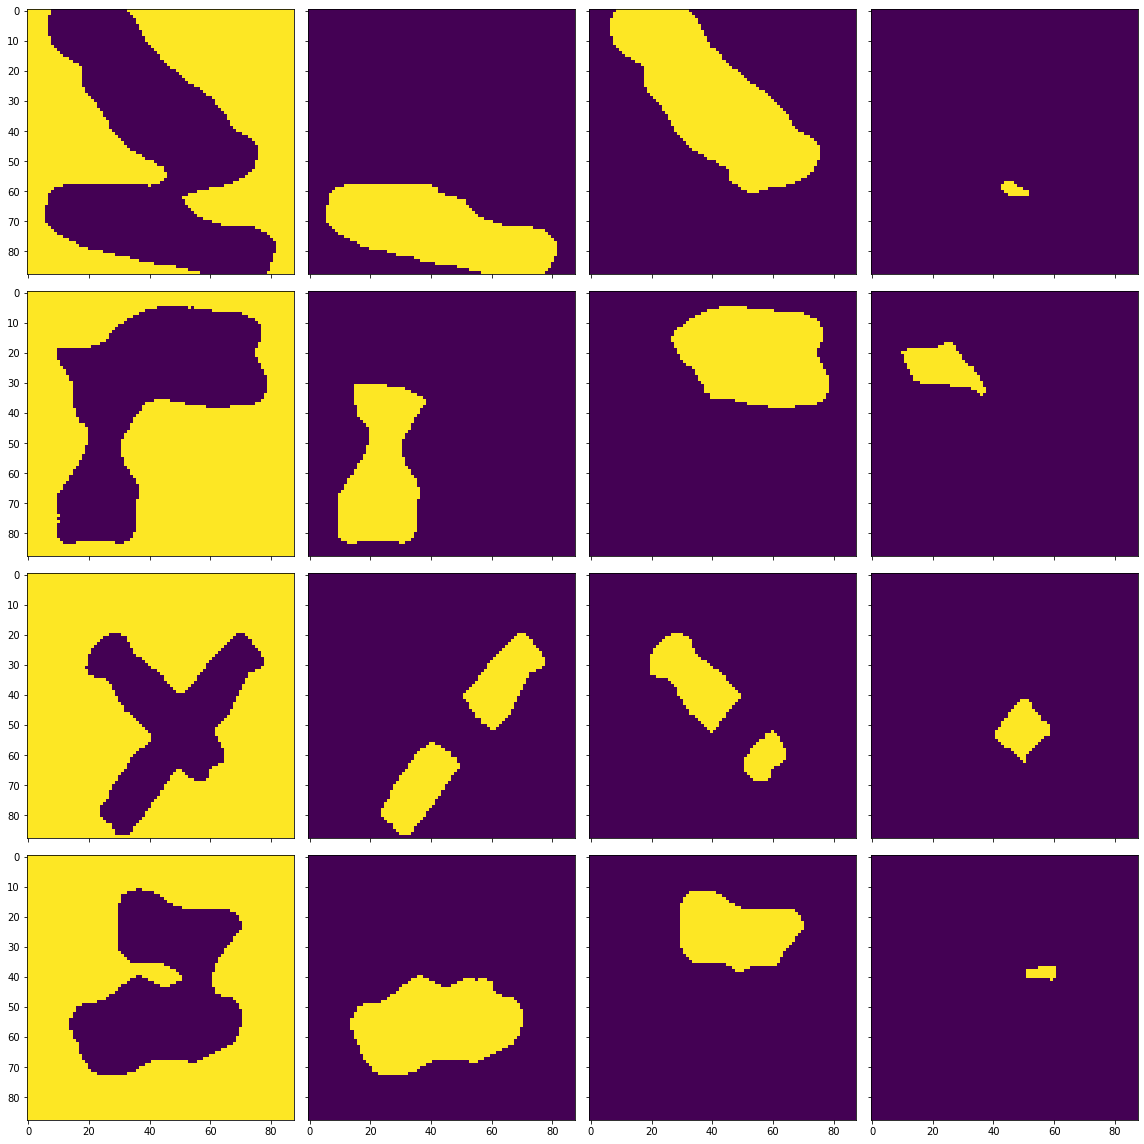

Training IOU: [0.9915812673761077, 0.9702630002521064, 0.9716235514711493, 0.9309856774684186]
Training accuracy: 0.9912383780991736
Testing IOU: [0.9700562642019231, 0.3887757505229763, 0.3058778883454208, 0.3649211813734372]
Testing accuracy: 0.8609413739669421
13/13 [==============================] - 1s 67ms/step - loss: 0.0041 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelunet/savedmodel_198epoch\assets
4
4


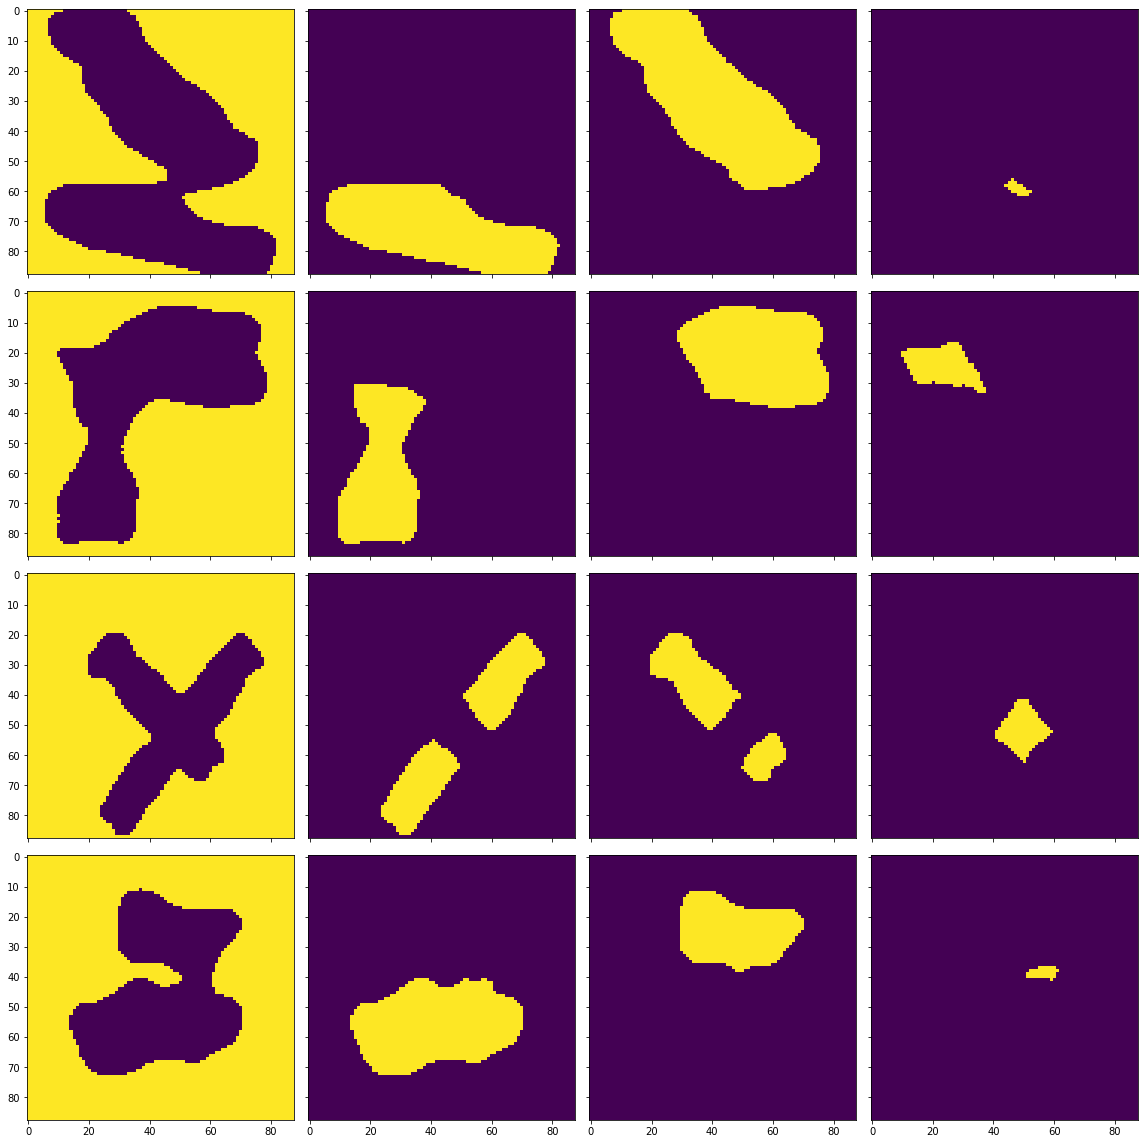

Training IOU: [0.991553403994375, 0.9698132137950713, 0.9671646530062572, 0.920181829634451]
Training accuracy: 0.9904364669421487
Testing IOU: [0.9703039365673575, 0.39727747842644734, 0.2936177245800677, 0.37312513474390957]
Testing accuracy: 0.8608483987603306
13/13 [==============================] - 1s 67ms/step - loss: 0.0040 - val_loss: 0.0614ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_199epoch\assets
4
4


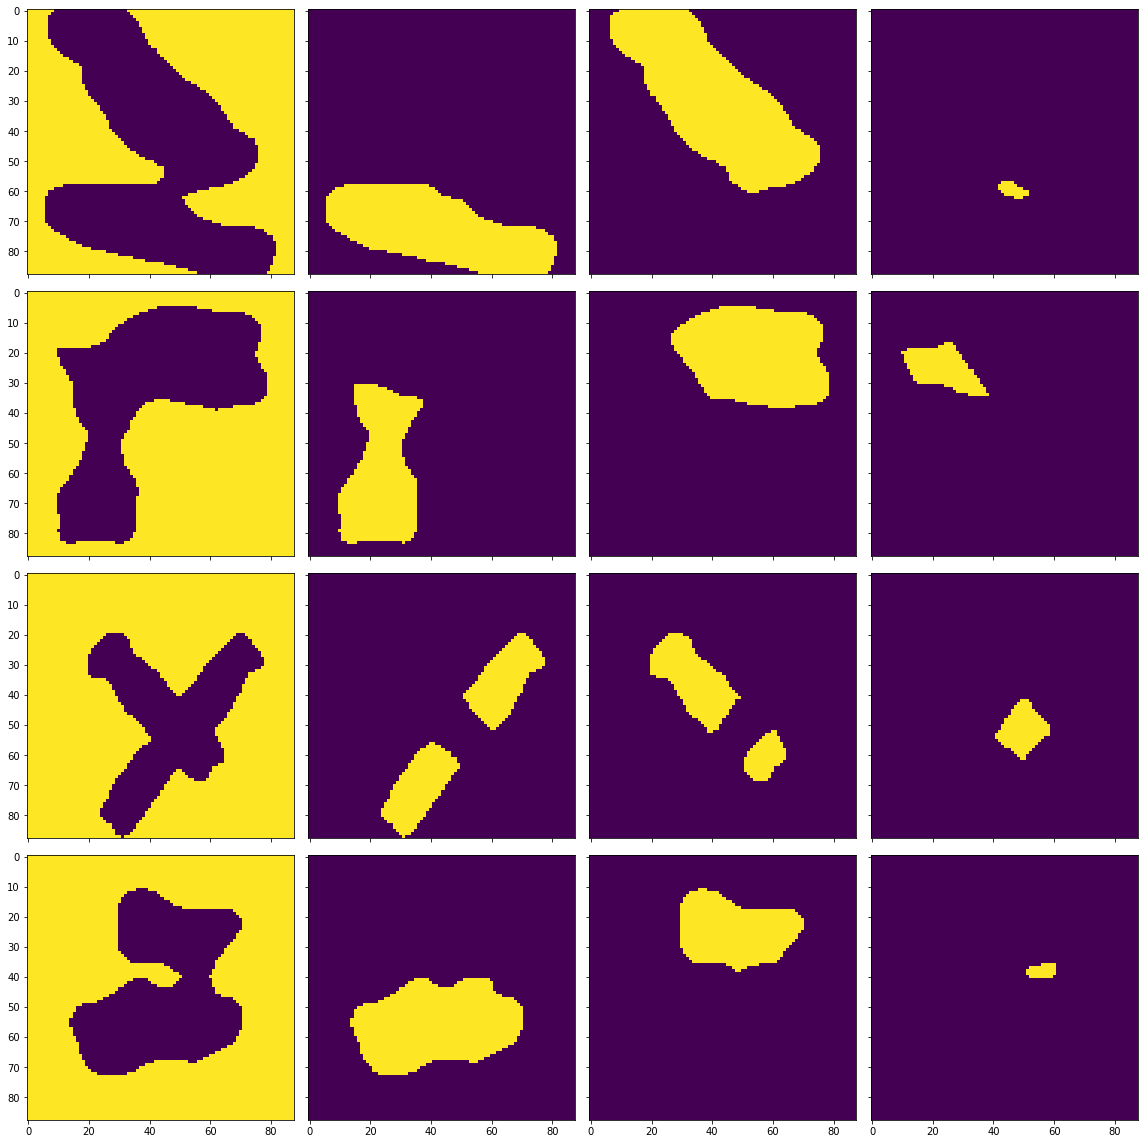

Training IOU: [0.9920800048564099, 0.9700146484827695, 0.9729360692836626, 0.9258932602555622]
Training accuracy: 0.9912964876033058
Testing IOU: [0.9702596904978062, 0.3820873354491127, 0.3114995507338015, 0.36789048286557907]
Testing accuracy: 0.8606211260330578
13/13 [==============================] - 1s 67ms/step - loss: 0.0039 - val_loss: 0.0599- ETA: 0s - loss:
INFO:tensorflow:Assets written to: modelunet/savedmodel_200epoch\assets
4
4


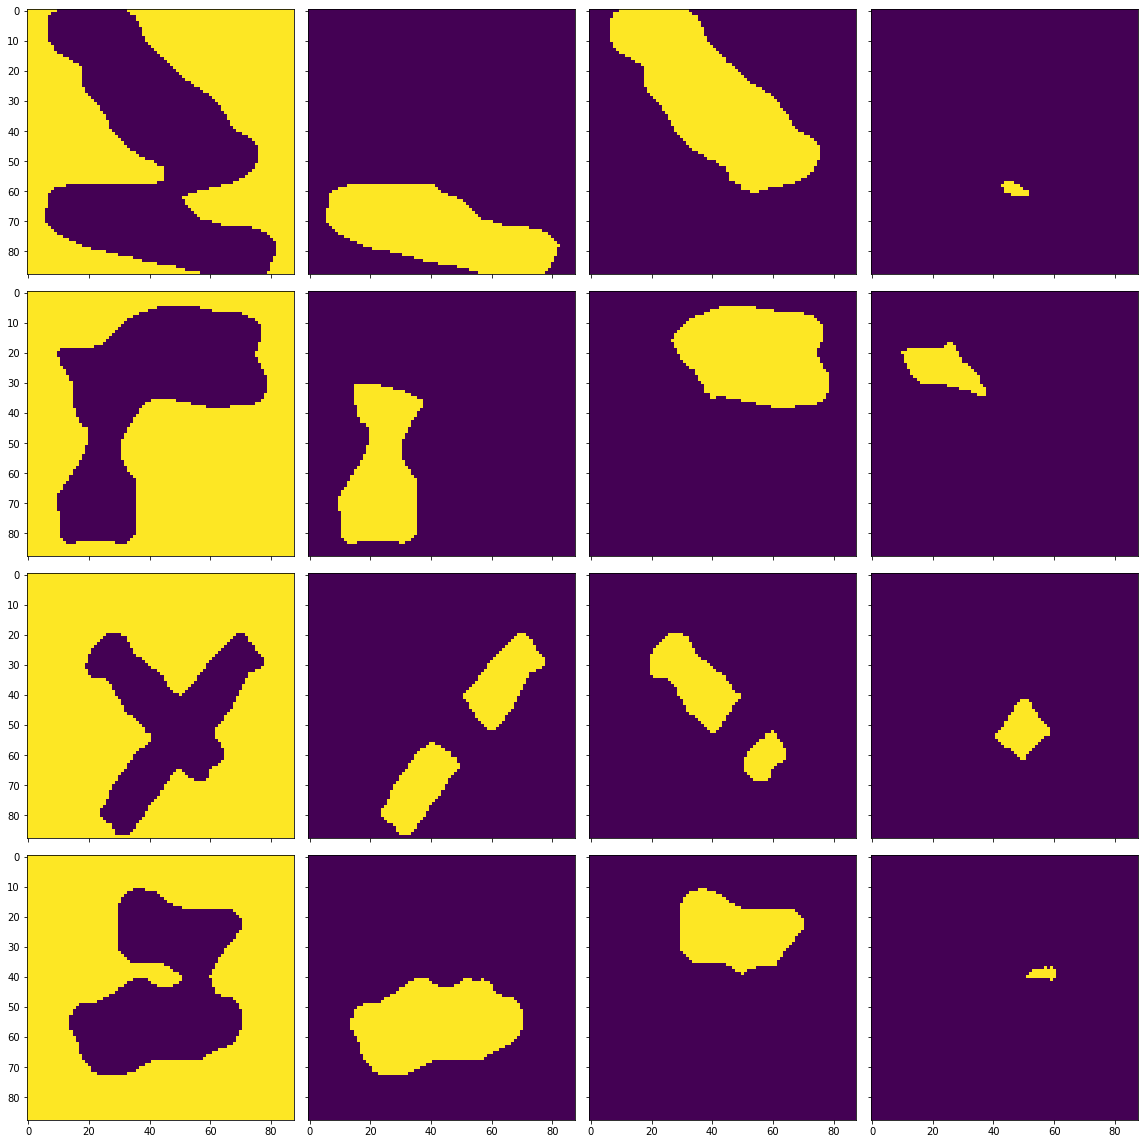

Training IOU: [0.9920948439007996, 0.9693424383898915, 0.9723435700158658, 0.918028220319916]
Training accuracy: 0.9907563920454545
Testing IOU: [0.9699483651848595, 0.37675955084549617, 0.31060940695296524, 0.37802139743759083]
Testing accuracy: 0.8596875
13/13 [==============================] - 1s 66ms/step - loss: 0.0039 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_201epoch\assets
4
4


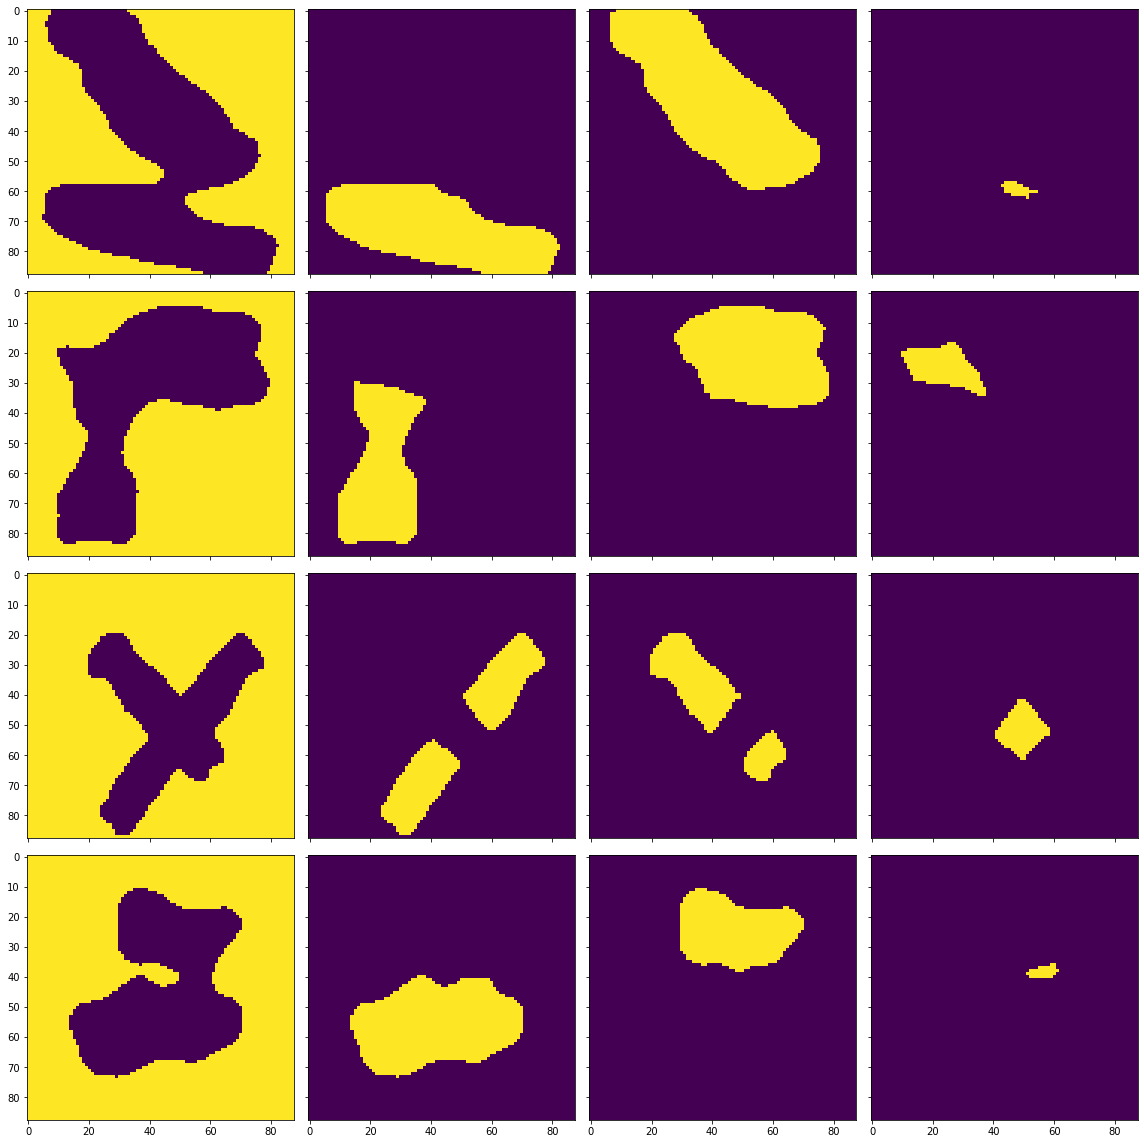

Training IOU: [0.9906977750278386, 0.9687716625143273, 0.9725765409927677, 0.9361654921765221]
Training accuracy: 0.9907592975206612
Testing IOU: [0.9707609533793677, 0.3962046091773234, 0.3084241189445857, 0.3717321741230453]
Testing accuracy: 0.8614617768595041
13/13 [==============================] - 1s 67ms/step - loss: 0.0043 - val_loss: 0.0596
INFO:tensorflow:Assets written to: modelunet/savedmodel_202epoch\assets
4
4


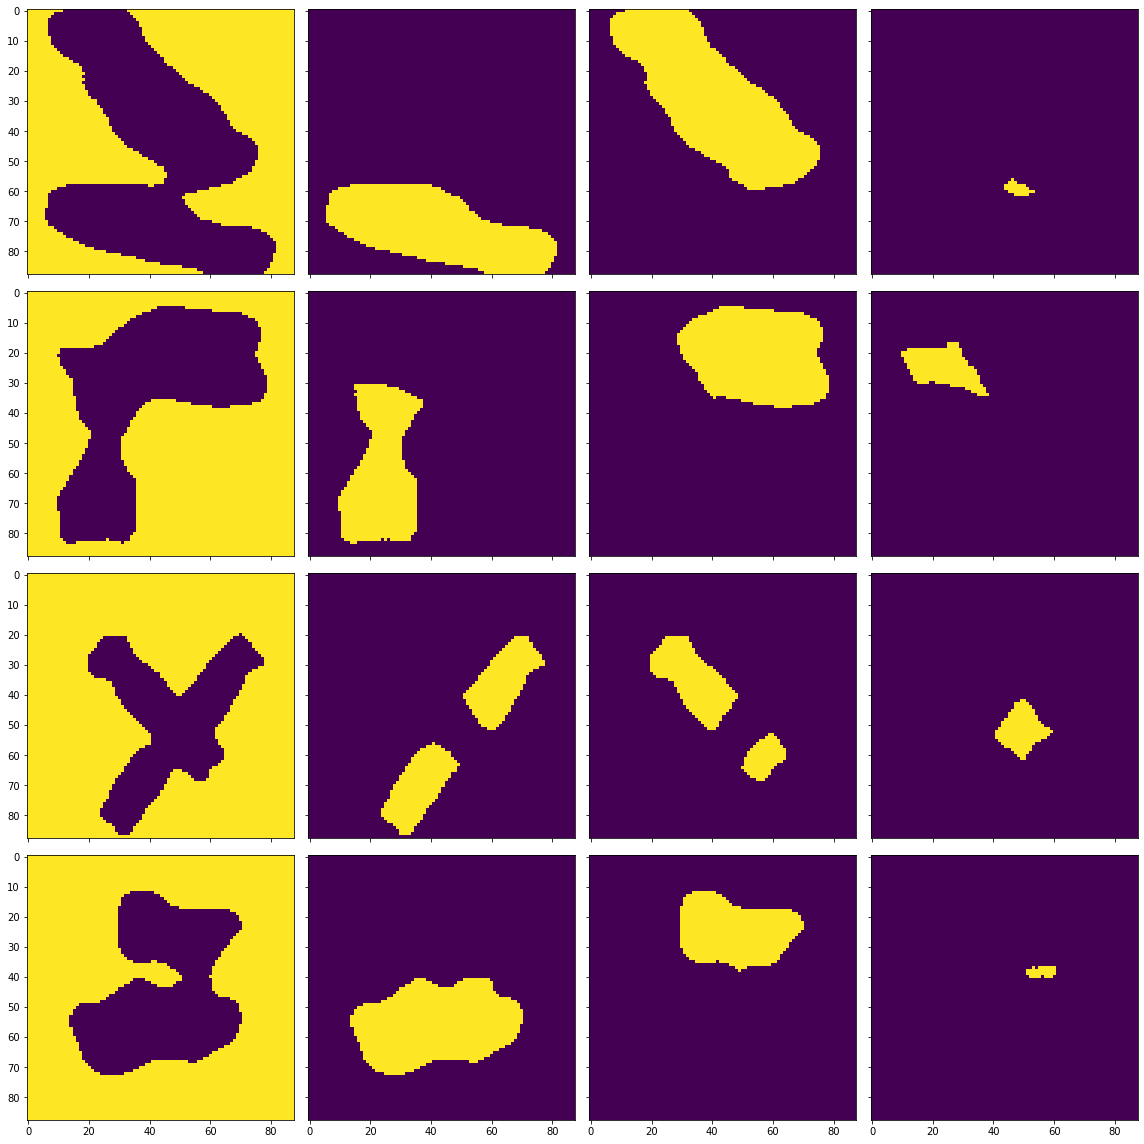

Training IOU: [0.9882197408503883, 0.9545923920627389, 0.9581461267074752, 0.9275457611300825]
Training accuracy: 0.9873931430785124
Testing IOU: [0.9679240133007624, 0.38881797828042935, 0.30101190578452763, 0.37746352700281544]
Testing accuracy: 0.8605681818181818
13/13 [==============================] - 1s 67ms/step - loss: 0.0042 - val_loss: 0.0598ETA: 0s - loss: 0.
INFO:tensorflow:Assets written to: modelunet/savedmodel_203epoch\assets
4
4


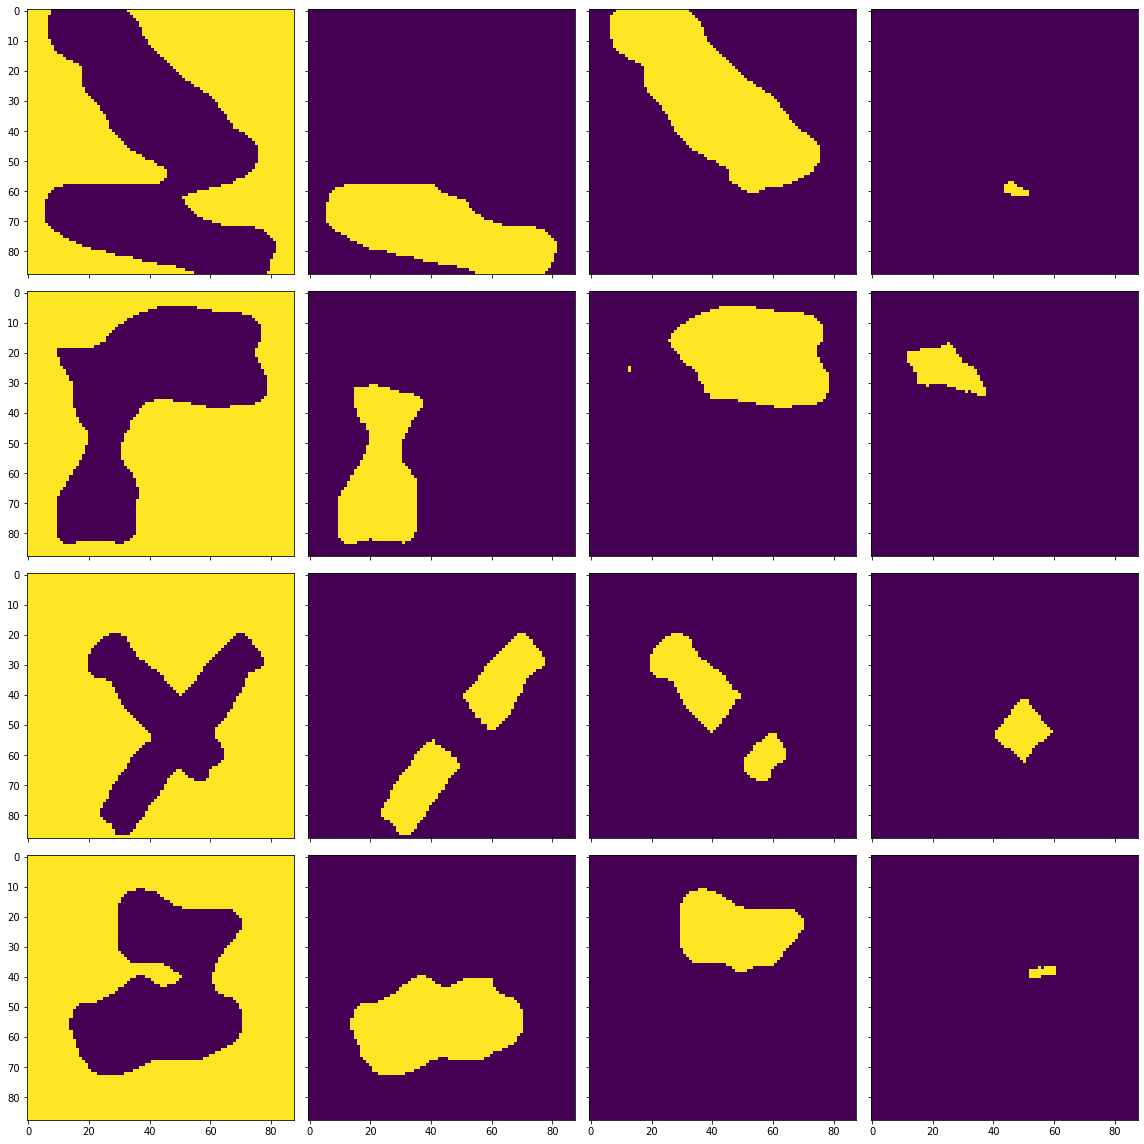

Training IOU: [0.991539136271654, 0.9692094972969729, 0.9707392699776968, 0.919758559905988]
Training accuracy: 0.9905400955578513
Testing IOU: [0.9705754367061067, 0.3873677184297256, 0.31093510263321583, 0.3816363754804247]
Testing accuracy: 0.8612964876033058
13/13 [==============================] - 1s 66ms/step - loss: 0.0039 - val_loss: 0.0609
INFO:tensorflow:Assets written to: modelunet/savedmodel_204epoch\assets
4
4


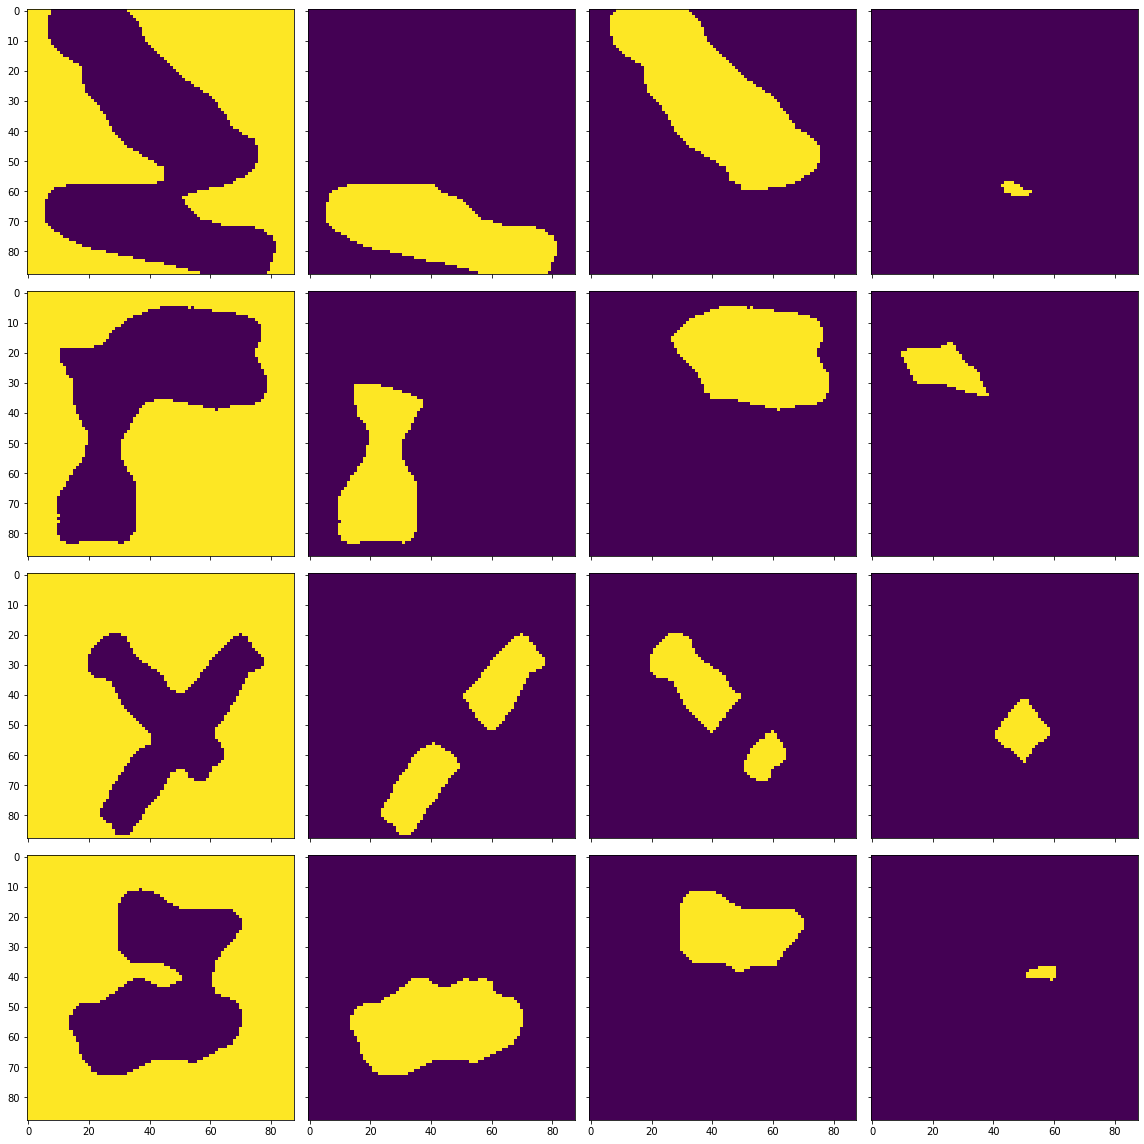

Training IOU: [0.9913520805900458, 0.9688140328730122, 0.9721980814954497, 0.9361693148488109]
Training accuracy: 0.9913668646694215
Testing IOU: [0.9696019786530071, 0.38476715549087653, 0.3138374710249605, 0.3738459669582119]
Testing accuracy: 0.8621126033057851
13/13 [==============================] - 1s 67ms/step - loss: 0.0038 - val_loss: 0.0622
INFO:tensorflow:Assets written to: modelunet/savedmodel_205epoch\assets
4
4


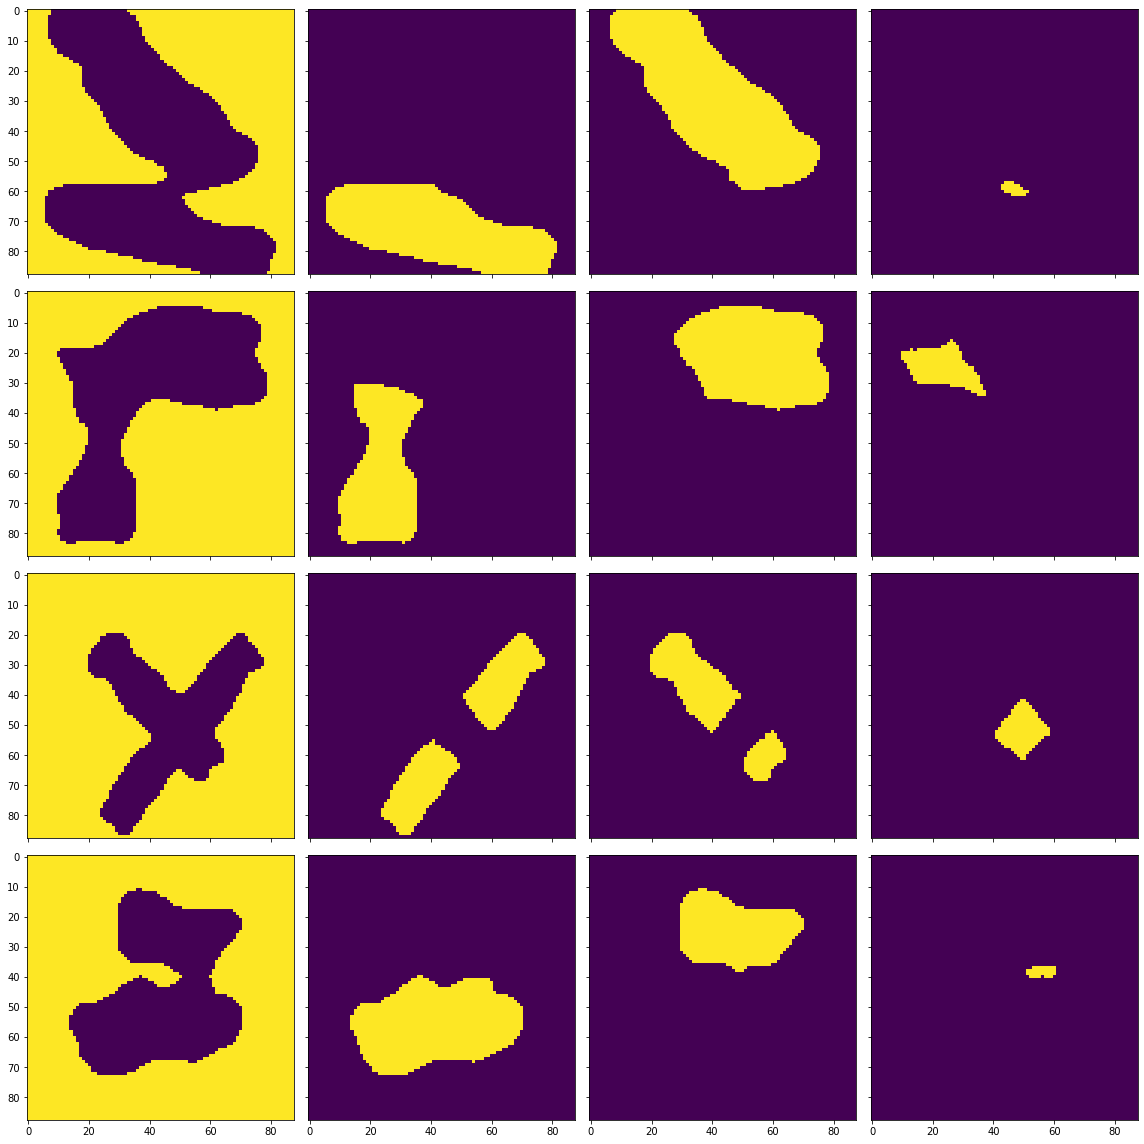

Training IOU: [0.9924242117477359, 0.9725503540583021, 0.9750643246859921, 0.9323564239194789]
Training accuracy: 0.9919247159090909
Testing IOU: [0.97006149335074, 0.3837712864786332, 0.30968041604804125, 0.36377966807447504]
Testing accuracy: 0.8603564049586777
13/13 [==============================] - 1s 66ms/step - loss: 0.0036 - val_loss: 0.0613
INFO:tensorflow:Assets written to: modelunet/savedmodel_206epoch\assets
4
4


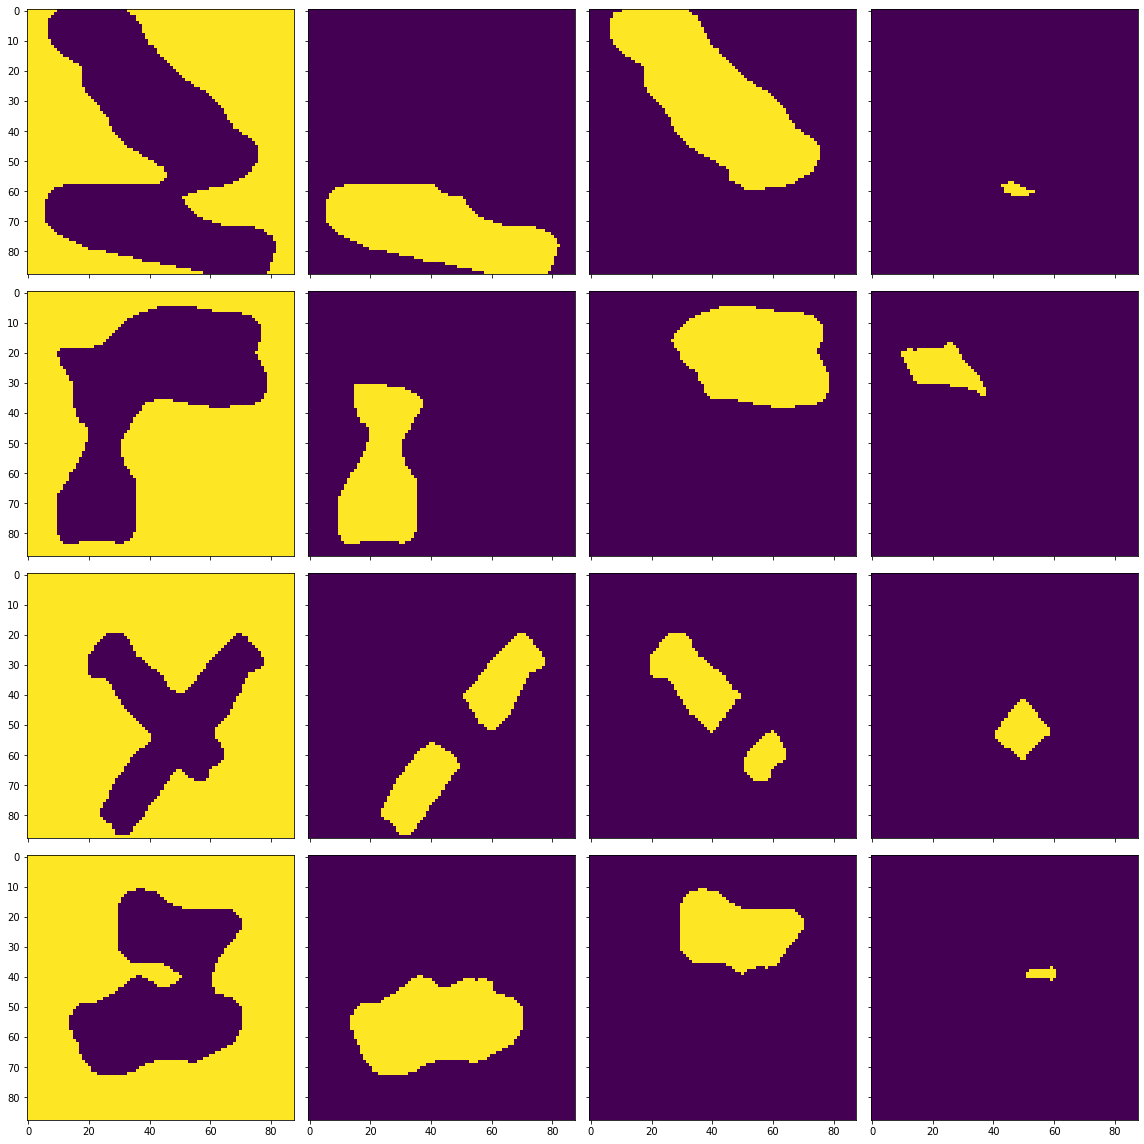

Training IOU: [0.9925812373180901, 0.9731048803416632, 0.9754359713796011, 0.9339216461362593]
Training accuracy: 0.9923514979338843
Testing IOU: [0.9703122222164687, 0.3904542999958461, 0.3156991209155747, 0.3847459255227178]
Testing accuracy: 0.8634349173553719
13/13 [==============================] - 1s 66ms/step - loss: 0.0037 - val_loss: 0.0614
INFO:tensorflow:Assets written to: modelunet/savedmodel_207epoch\assets
4
4


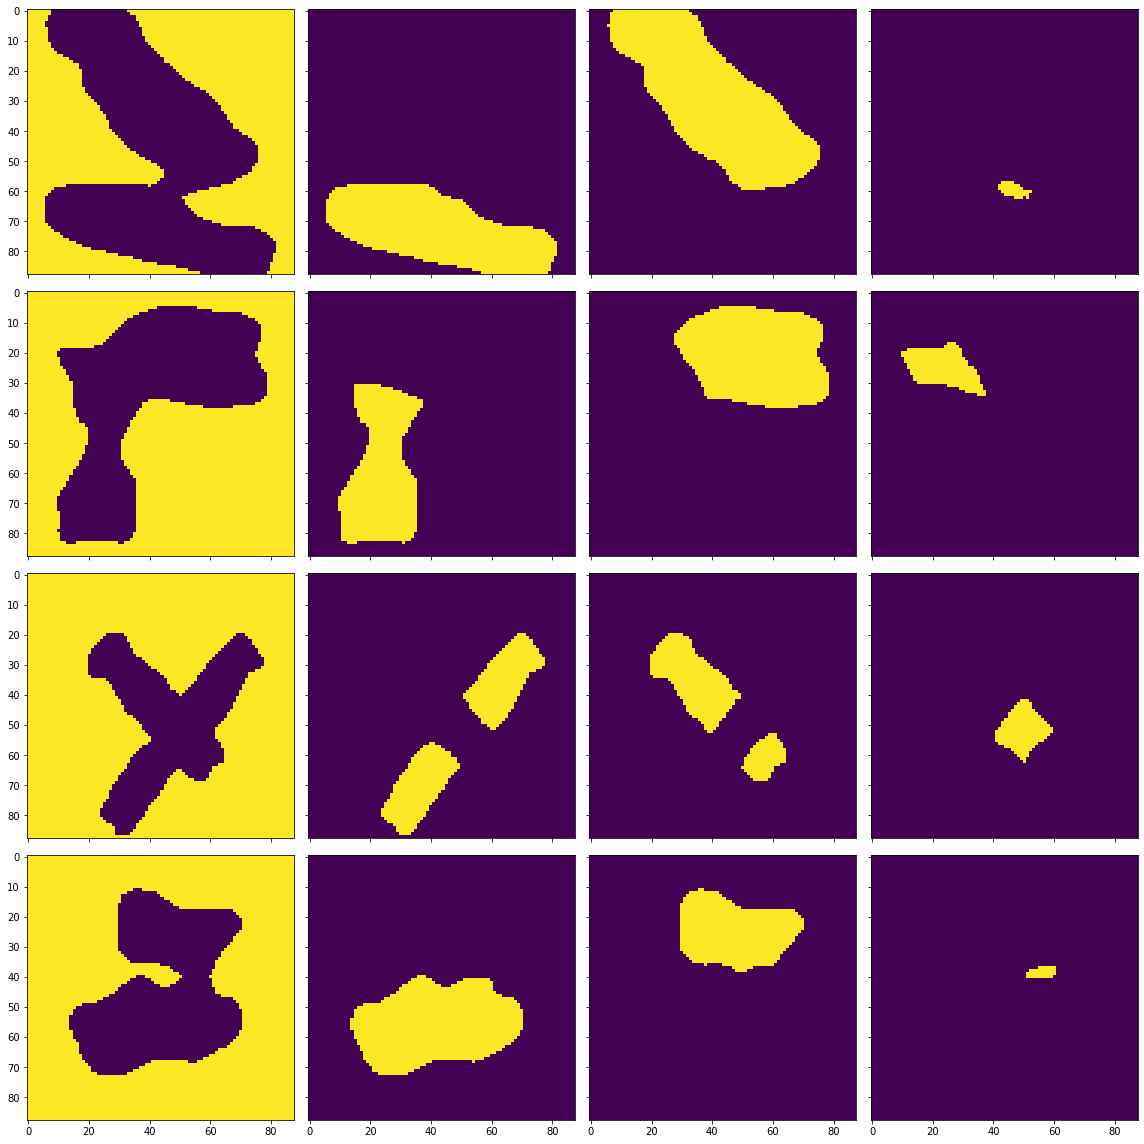

Training IOU: [0.9925635426949794, 0.9710606972480476, 0.97273238735644, 0.9201027657954833]
Training accuracy: 0.9915796100206612
Testing IOU: [0.9699944776170918, 0.37623699072922956, 0.32441057124575795, 0.3657400217425066]
Testing accuracy: 0.8611350723140496
13/13 [==============================] - 1s 67ms/step - loss: 0.0037 - val_loss: 0.0616
INFO:tensorflow:Assets written to: modelunet/savedmodel_208epoch\assets
4
4


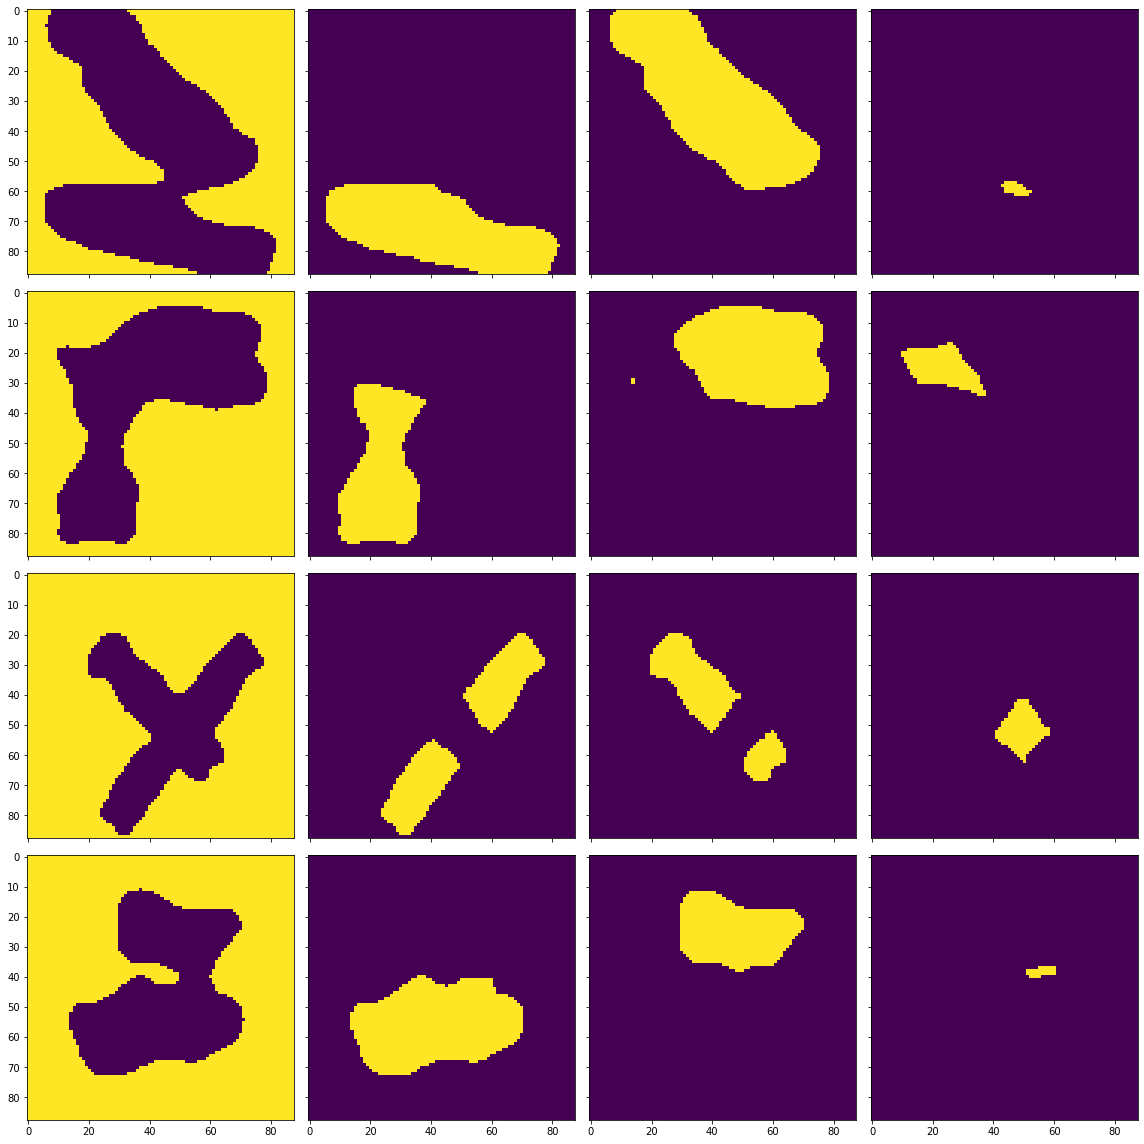

Training IOU: [0.9917821920462071, 0.9679509983672203, 0.9749809637767867, 0.9273828824985066]
Training accuracy: 0.9914953512396695
Testing IOU: [0.9707921777746998, 0.41339061467283544, 0.2957771989442997, 0.38314350797266516]
Testing accuracy: 0.8643181818181818
13/13 [==============================] - 1s 67ms/step - loss: 0.0037 - val_loss: 0.0621
INFO:tensorflow:Assets written to: modelunet/savedmodel_209epoch\assets
4
4


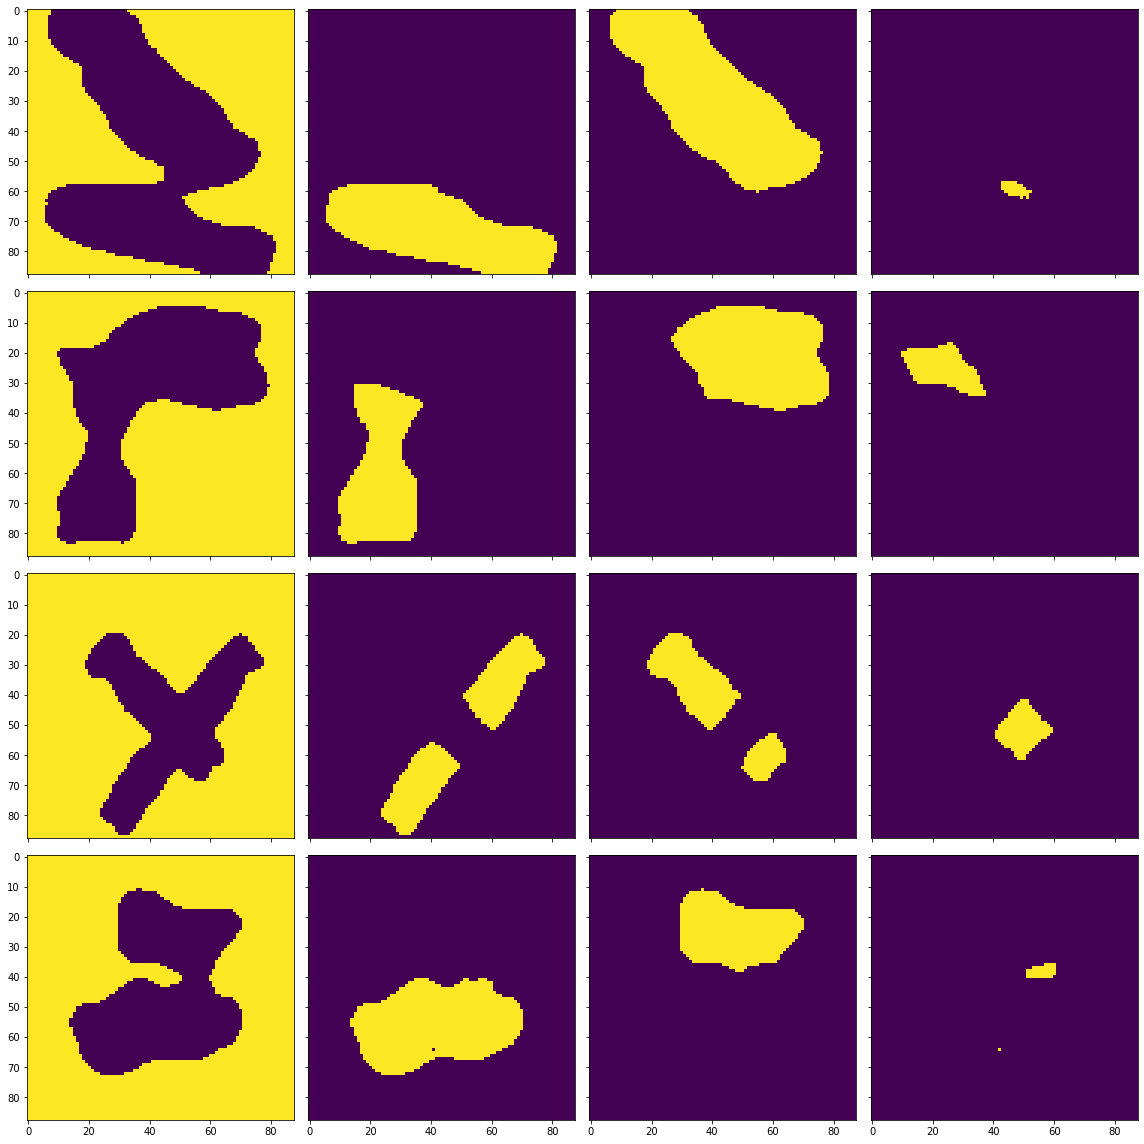

Training IOU: [0.9924188595820614, 0.9693270655442952, 0.9751486709858834, 0.9240852675273874]
Training accuracy: 0.9916235149793389
Testing IOU: [0.969901004450227, 0.3715839564921822, 0.3252263737700631, 0.35675443617630226]
Testing accuracy: 0.860364152892562
13/13 [==============================] - ETA: 0s - loss: 0.003 - 1s 67ms/step - loss: 0.0036 - val_loss: 0.0613
INFO:tensorflow:Assets written to: modelunet/savedmodel_210epoch\assets
4
4


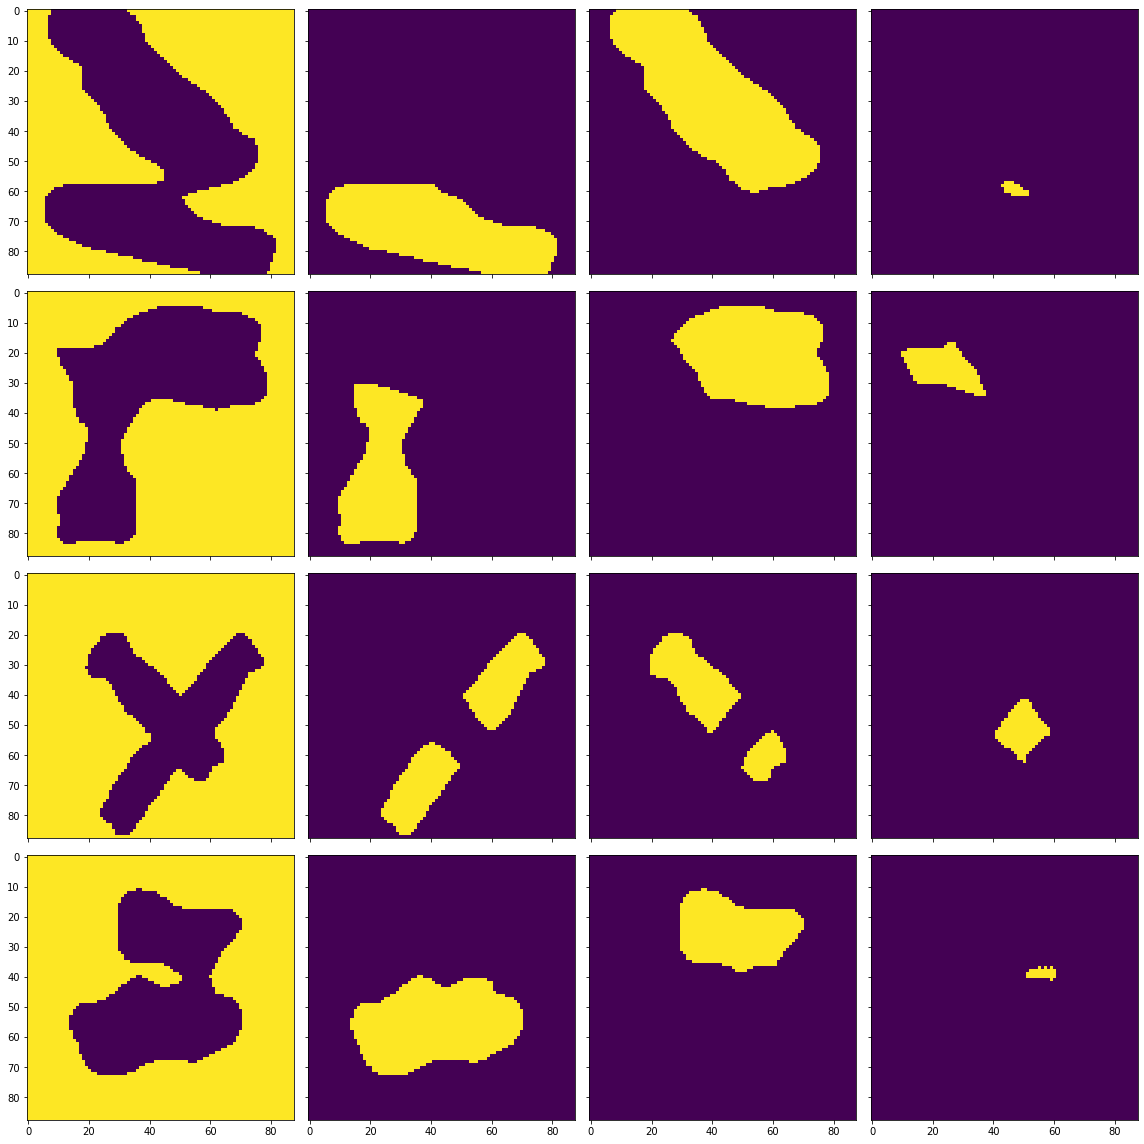

Training IOU: [0.9928003017805231, 0.973780429914809, 0.9751183678776125, 0.9309297509690437]
Training accuracy: 0.992278215392562
Testing IOU: [0.9703846505979558, 0.37547795234965264, 0.3275410232633149, 0.3774851209319995]
Testing accuracy: 0.861847882231405
13/13 [==============================] - 1s 66ms/step - loss: 0.0036 - val_loss: 0.0617
INFO:tensorflow:Assets written to: modelunet/savedmodel_211epoch\assets
4
4


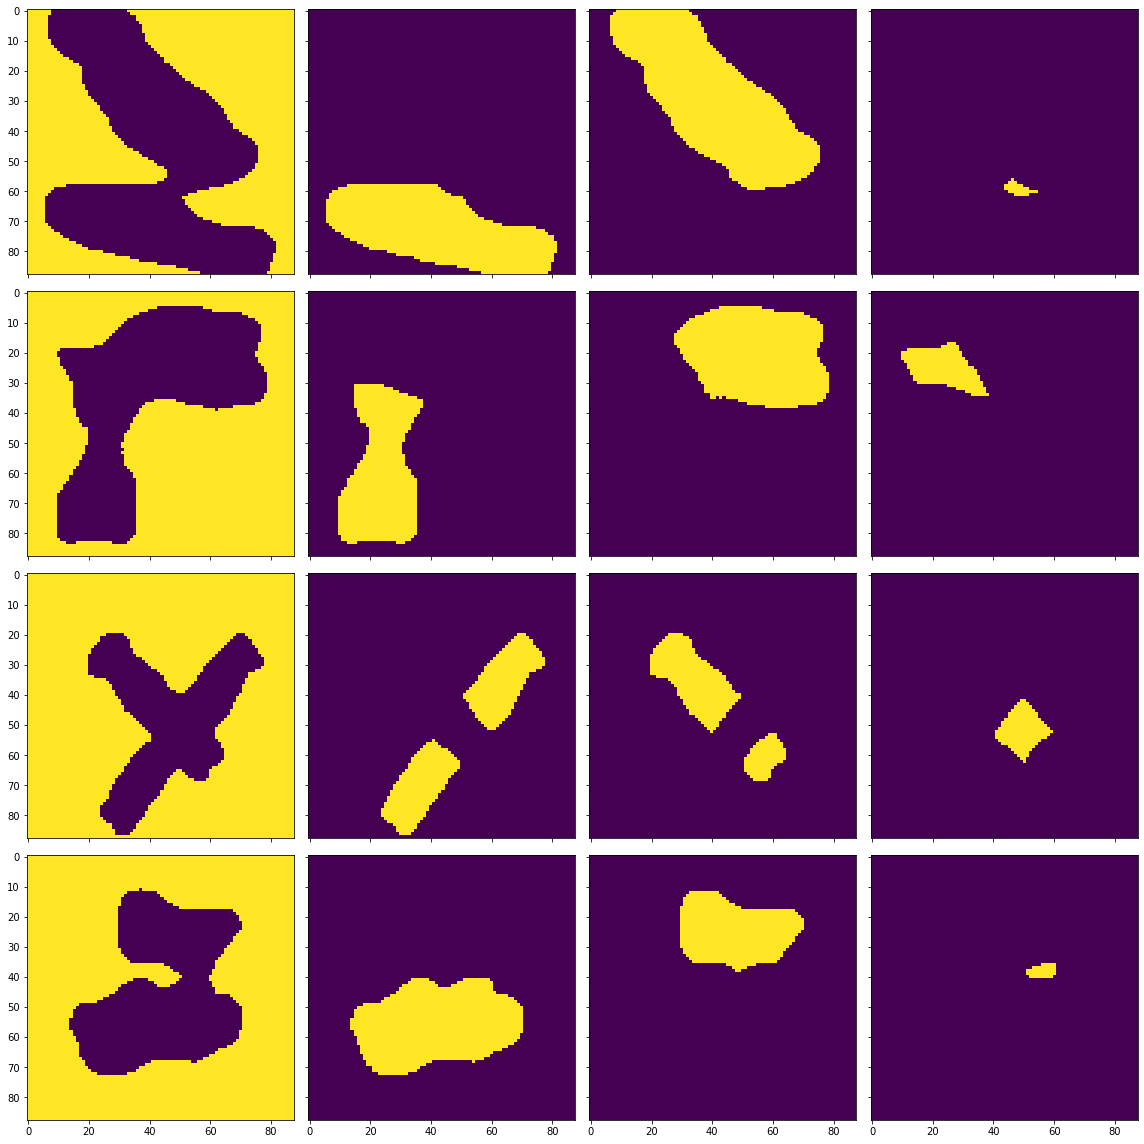

Training IOU: [0.9930096049306271, 0.9744016754931448, 0.9756787562217611, 0.9360365323896506]
Training accuracy: 0.9925116219008264
Testing IOU: [0.9702989618970809, 0.3966380812463699, 0.3018933545968139, 0.37349250076522805]
Testing accuracy: 0.862184917355372
13/13 [==============================] - 1s 67ms/step - loss: 0.0035 - val_loss: 0.0602- ETA: 0s - loss:
INFO:tensorflow:Assets written to: modelunet/savedmodel_212epoch\assets
4
4


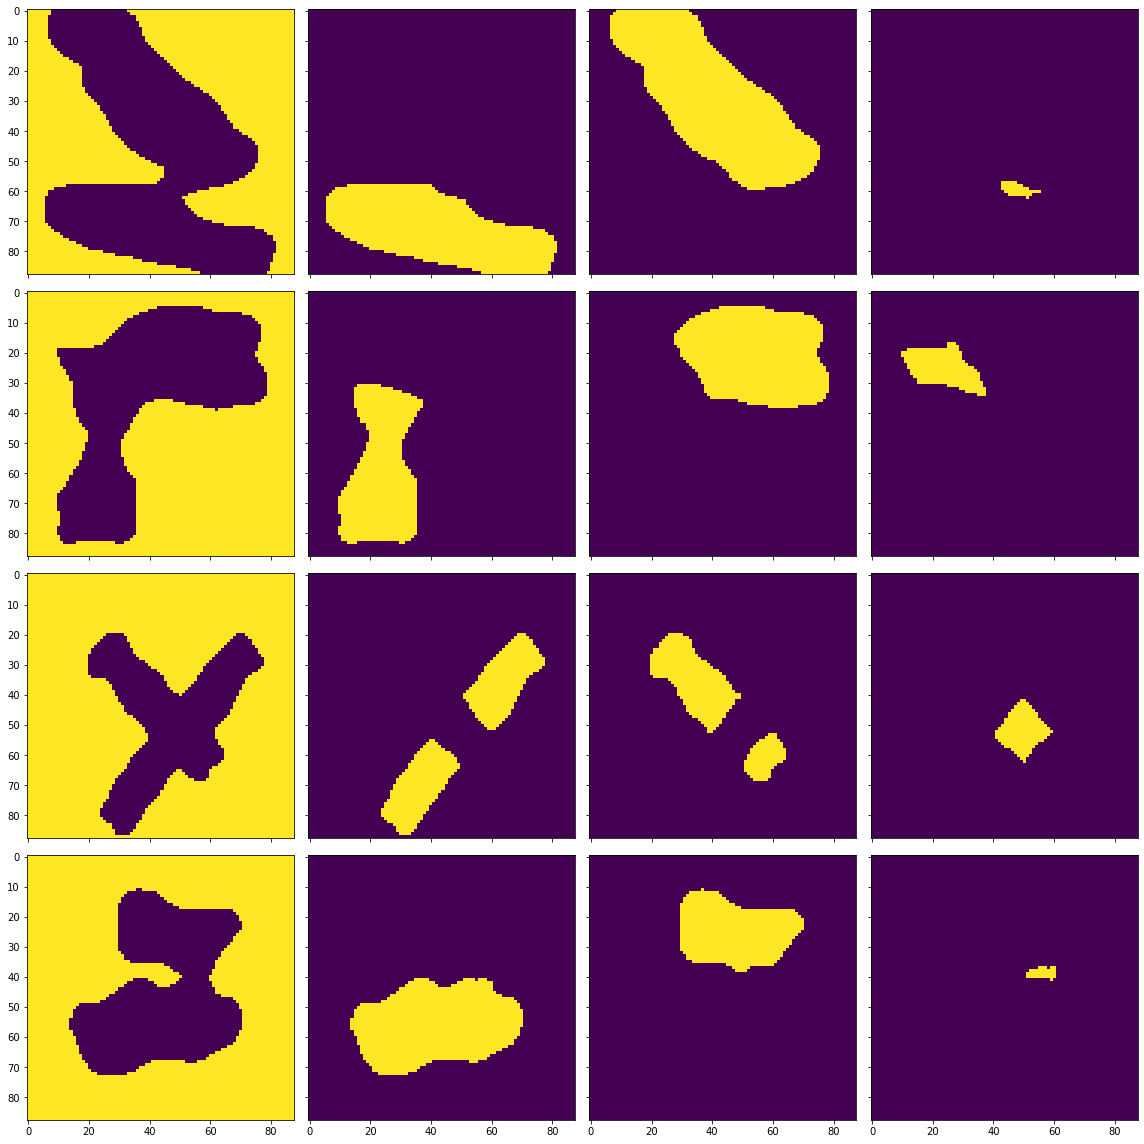

Training IOU: [0.9933020018816877, 0.9761646427935233, 0.978323419068724, 0.941214683549696]
Training accuracy: 0.9926730371900826
Testing IOU: [0.9703413029998946, 0.39076091080285025, 0.30892747323105957, 0.3750922736220472]
Testing accuracy: 0.8617368285123967
13/13 [==============================] - 1s 66ms/step - loss: 0.0034 - val_loss: 0.0615
INFO:tensorflow:Assets written to: modelunet/savedmodel_213epoch\assets
4
4


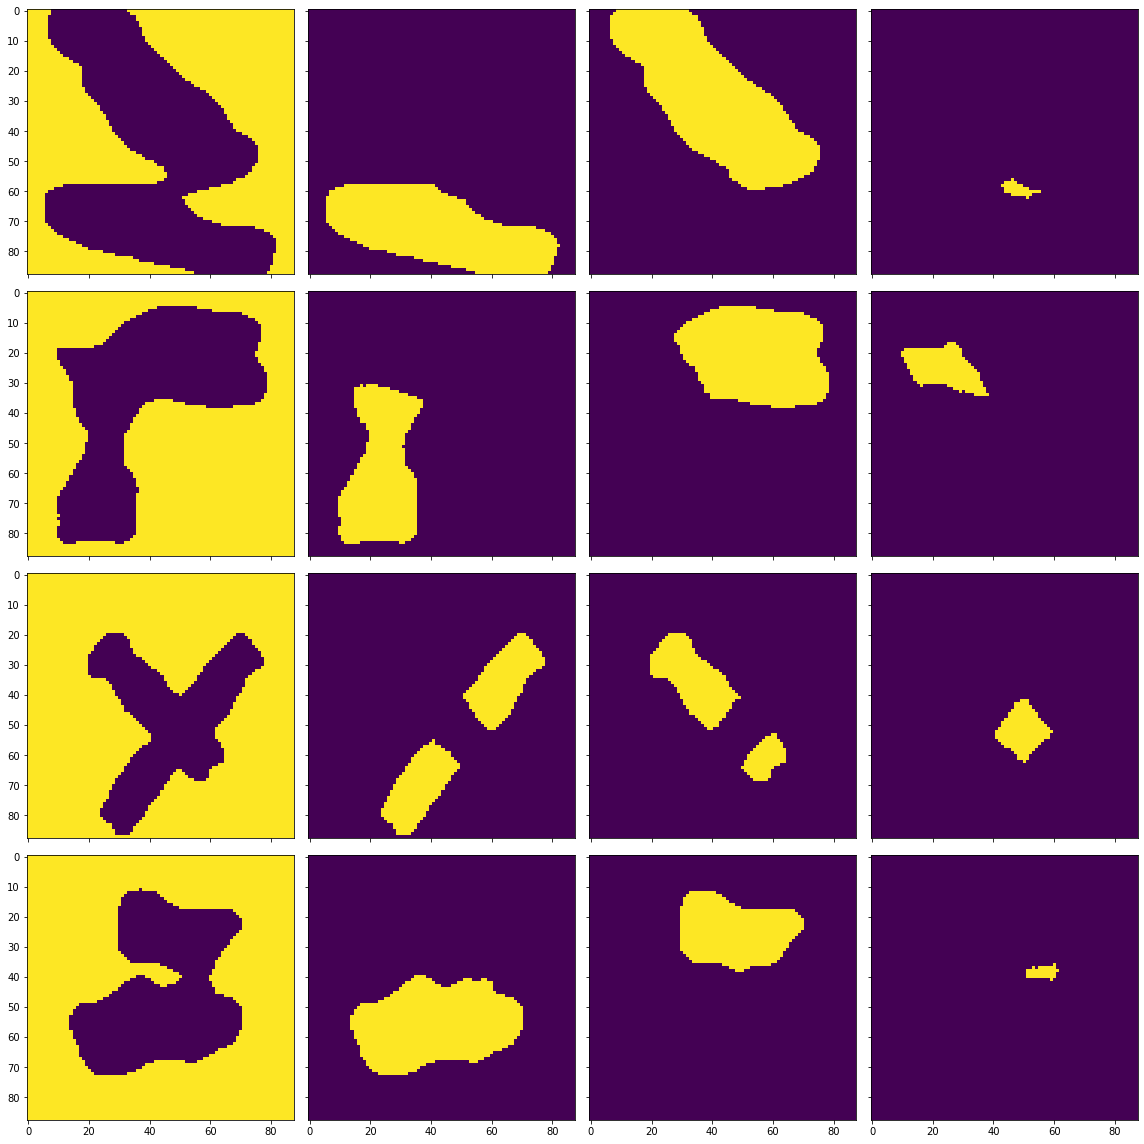

Training IOU: [0.9932505209918748, 0.9754897210493528, 0.9759077408677926, 0.9379494341038415]
Training accuracy: 0.9926204158057851
Testing IOU: [0.9700608837472875, 0.3990659232177992, 0.29790034200614746, 0.36549271538373296]
Testing accuracy: 0.8616283574380166
13/13 [==============================] - 1s 66ms/step - loss: 0.0035 - val_loss: 0.0618
INFO:tensorflow:Assets written to: modelunet/savedmodel_214epoch\assets
4
4


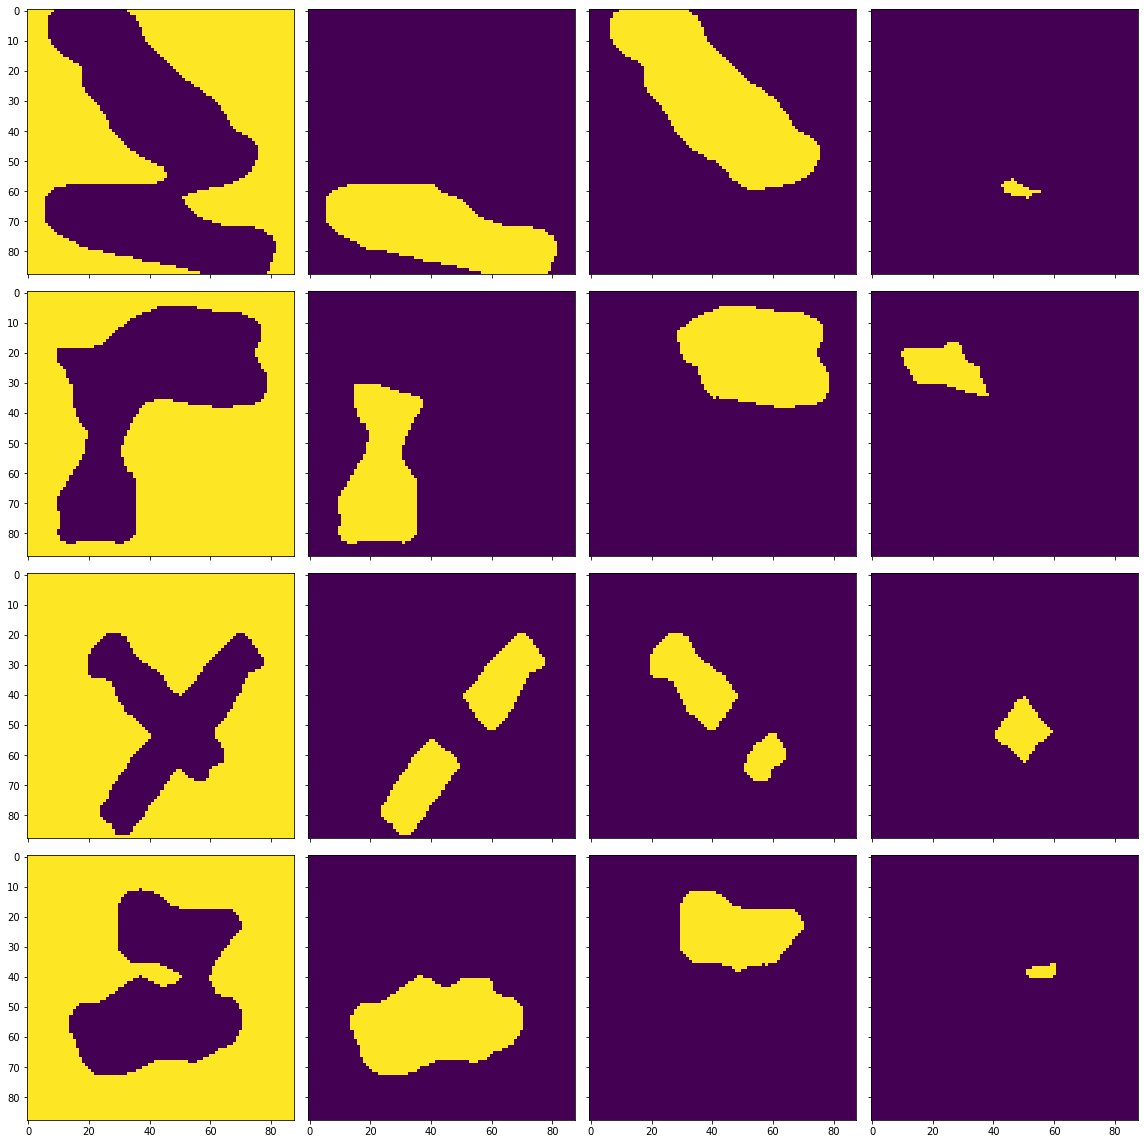

Training IOU: [0.9930706662405416, 0.9753228180182012, 0.9740423117718158, 0.9345231281544305]
Training accuracy: 0.992225916838843
Testing IOU: [0.9700168233274261, 0.39621791063123607, 0.29574391001311157, 0.36375916079896536]
Testing accuracy: 0.8607412190082645
13/13 [==============================] - ETA: 0s - loss: 0.0035- ETA: 0s - loss: 0. - 1s 66ms/step - loss: 0.0035 - val_loss: 0.0598
INFO:tensorflow:Assets written to: modelunet/savedmodel_215epoch\assets
4
4


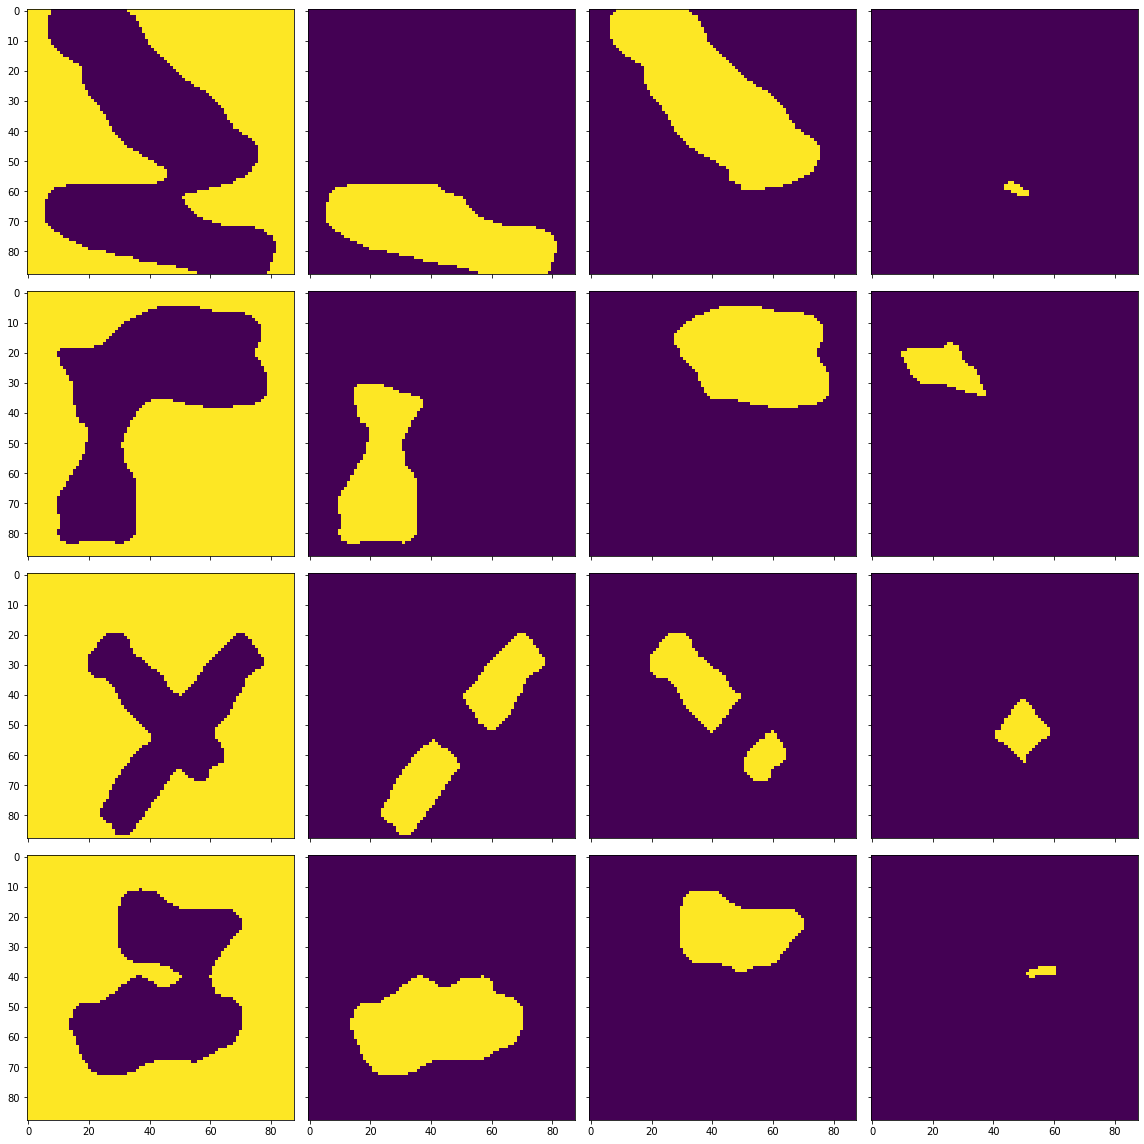

Training IOU: [0.9931053934203672, 0.9731790437084811, 0.9759510084885203, 0.9198221147618842]
Training accuracy: 0.9922314049586777
Testing IOU: [0.9699662130681916, 0.4051841838458939, 0.3030599318125781, 0.3879130493303722]
Testing accuracy: 0.8641903409090909
13/13 [==============================] - 1s 66ms/step - loss: 0.0037 - val_loss: 0.0615
INFO:tensorflow:Assets written to: modelunet/savedmodel_216epoch\assets
4
4


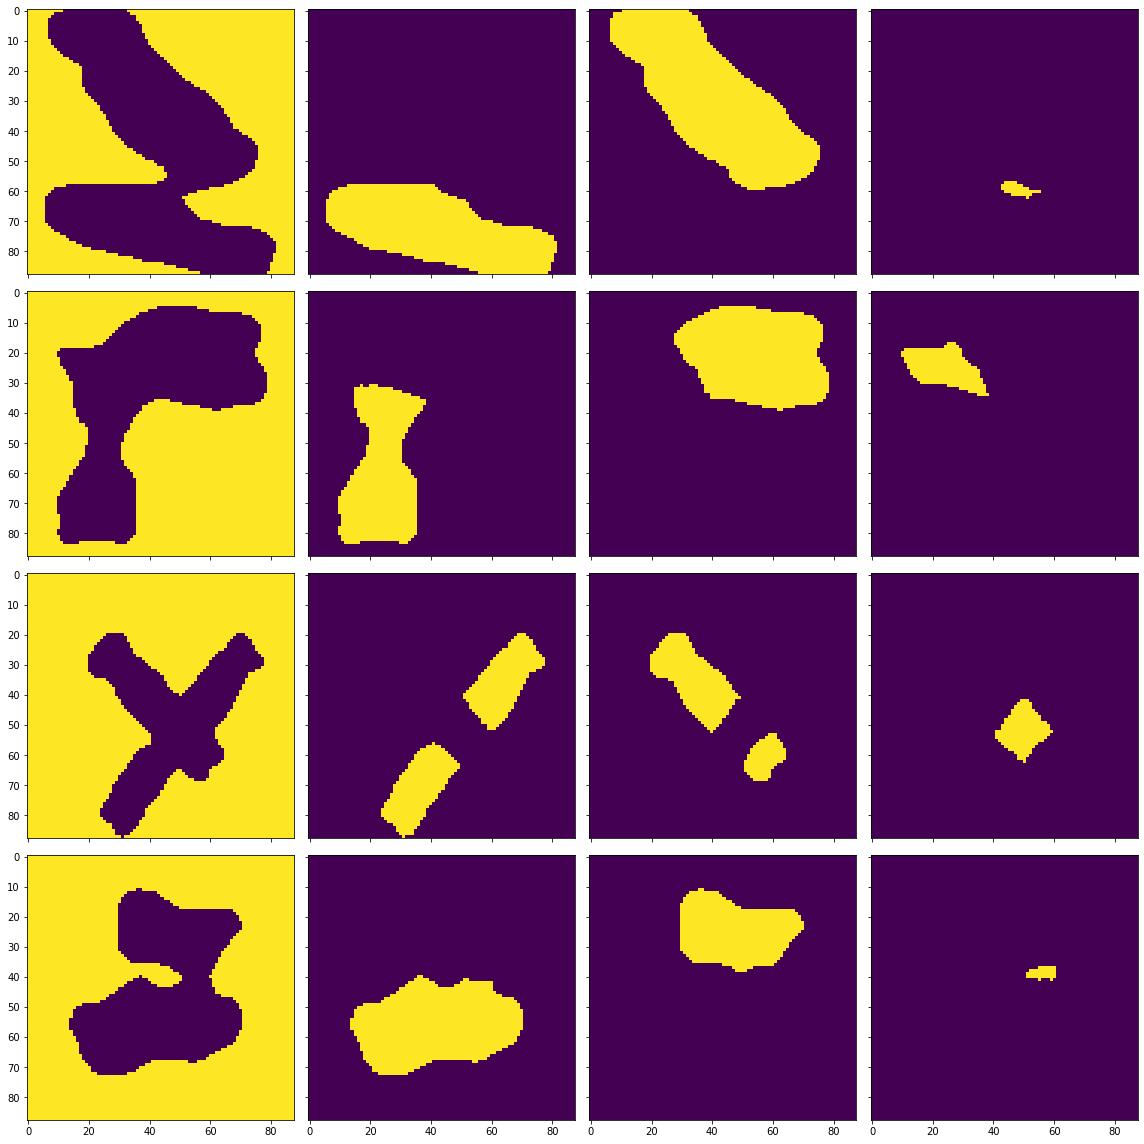

Training IOU: [0.9926558887094011, 0.9702761367808986, 0.9759337230375125, 0.9308183304351448]
Training accuracy: 0.9920283445247934
Testing IOU: [0.9695886744028811, 0.37633181396074206, 0.31991769547325105, 0.36371796727957145]
Testing accuracy: 0.8608871384297521
13/13 [==============================] - 1s 66ms/step - loss: 0.0037 - val_loss: 0.0599
INFO:tensorflow:Assets written to: modelunet/savedmodel_217epoch\assets
4
4


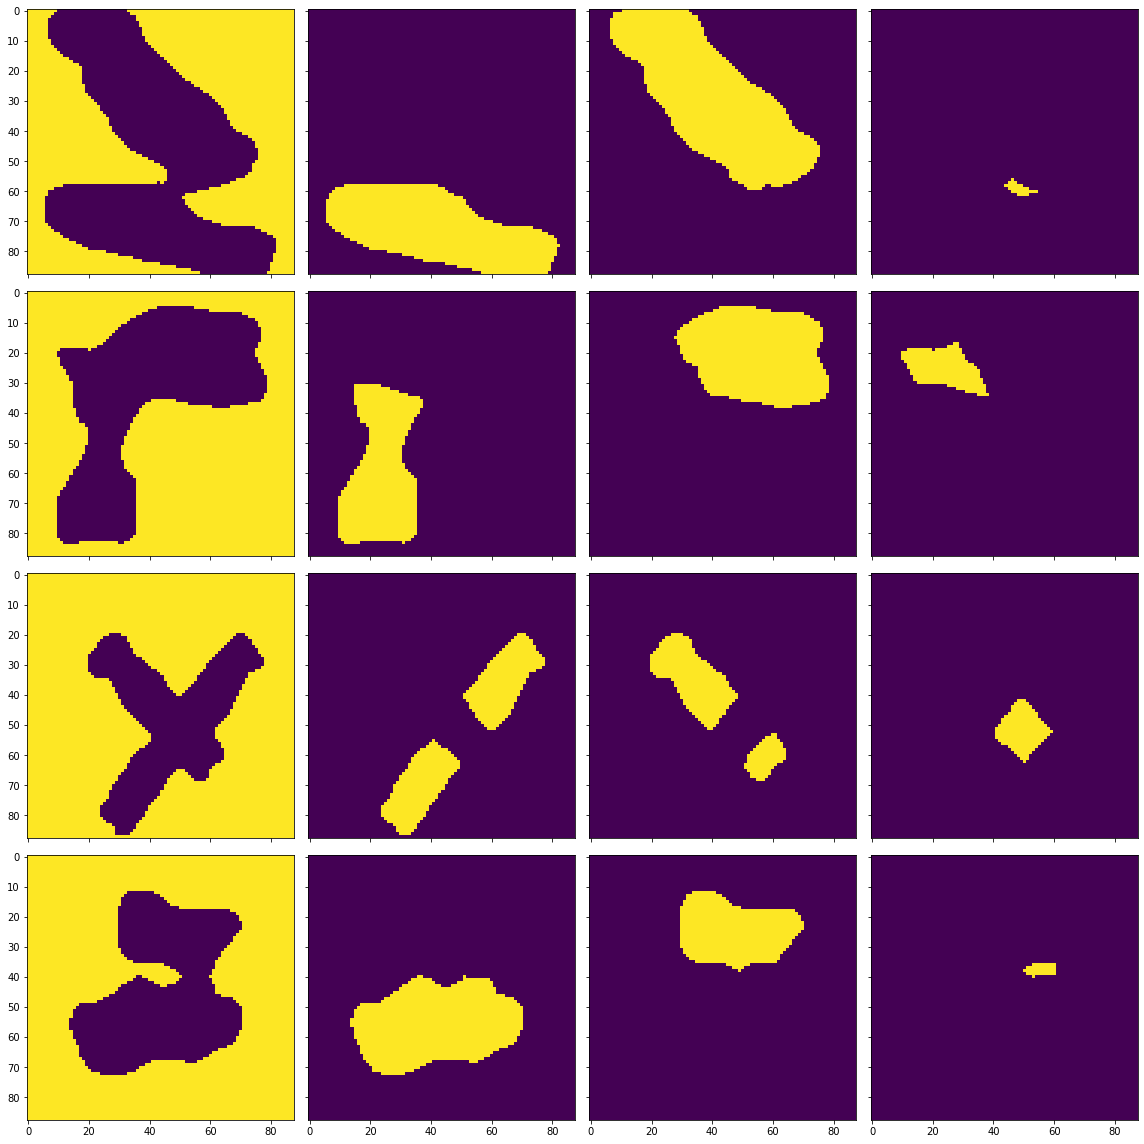

Training IOU: [0.9919651878696432, 0.9719627031872325, 0.9570307559485512, 0.9089674891236154]
Training accuracy: 0.9898263171487603
Testing IOU: [0.9697793812050652, 0.4165028432704867, 0.27255194098882113, 0.3727796447431589]
Testing accuracy: 0.8622456095041322
13/13 [==============================] - 1s 66ms/step - loss: 0.0038 - val_loss: 0.0618
INFO:tensorflow:Assets written to: modelunet/savedmodel_218epoch\assets
4
4


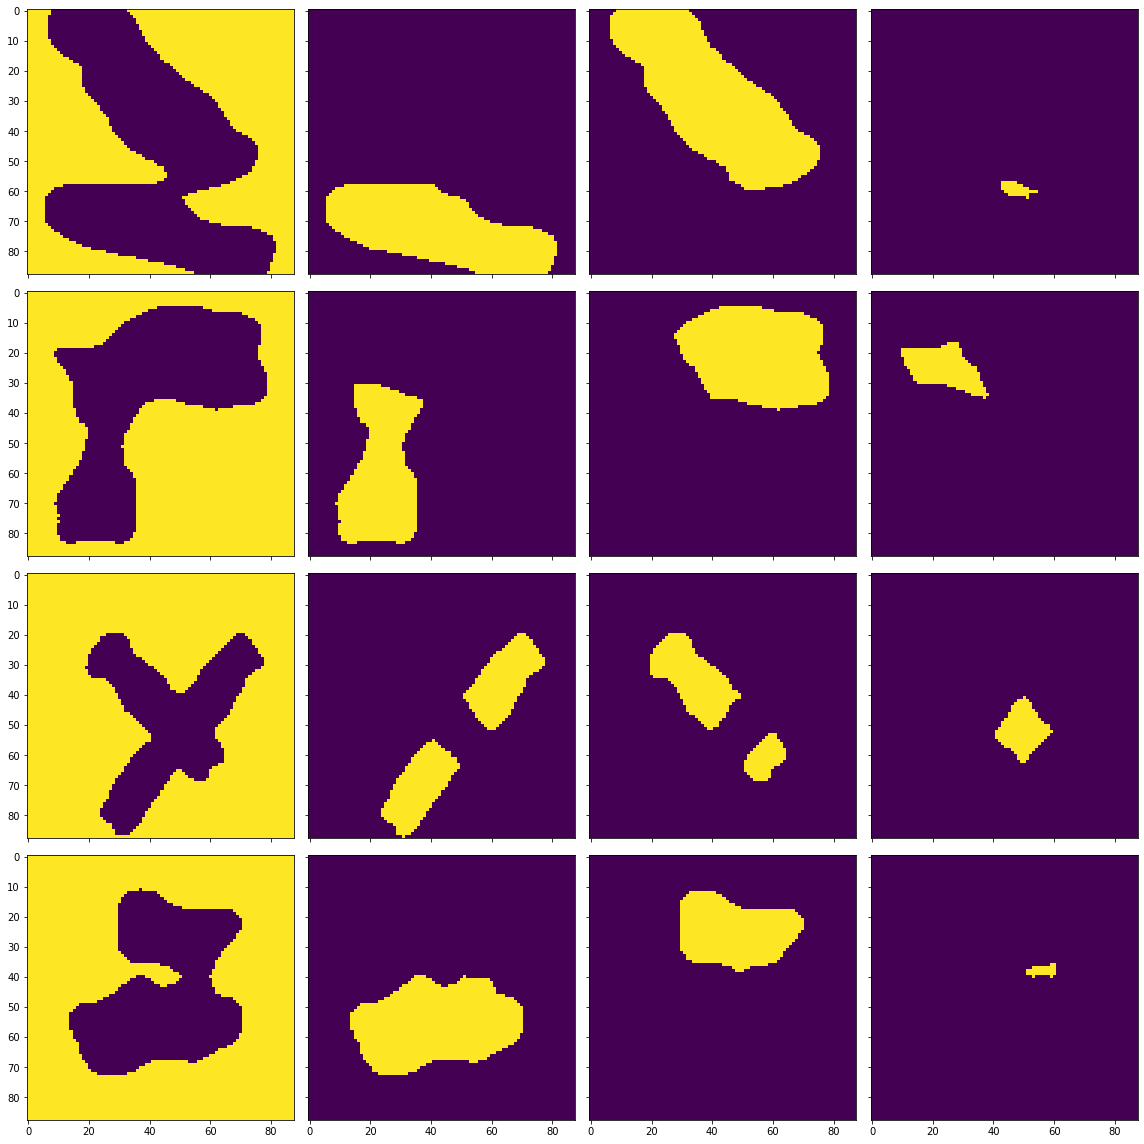

Training IOU: [0.9923984828482975, 0.9721950589494271, 0.9733396001890924, 0.9312207305650952]
Training accuracy: 0.9921871771694215
Testing IOU: [0.9702402356716088, 0.3828462940039223, 0.31821406768195093, 0.3756395296652006]
Testing accuracy: 0.861823347107438
13/13 [==============================] - 1s 67ms/step - loss: 0.0037 - val_loss: 0.0611
INFO:tensorflow:Assets written to: modelunet/savedmodel_219epoch\assets
4
4


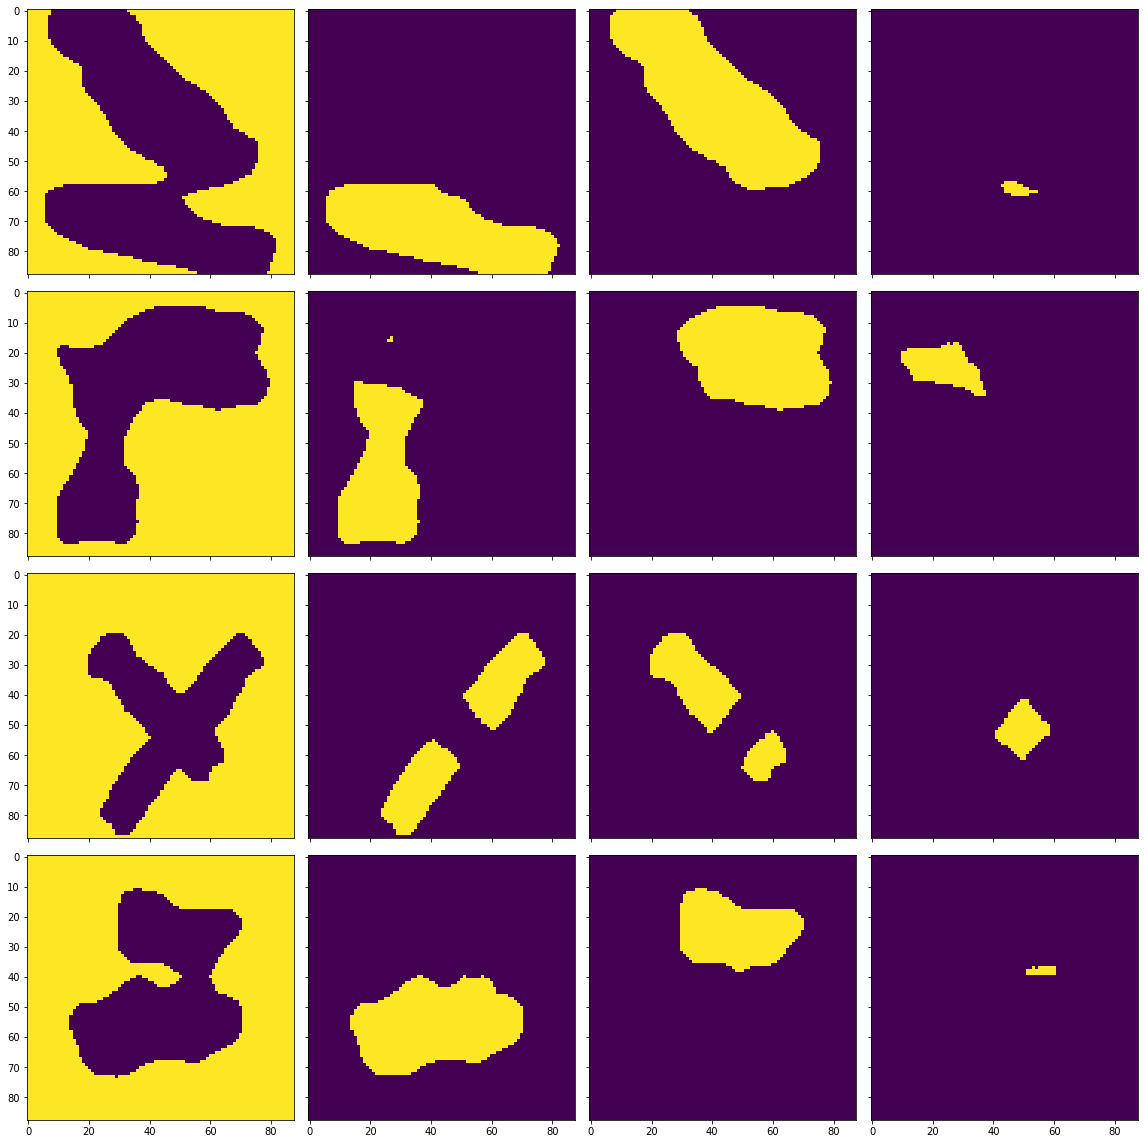

Training IOU: [0.9916189159521334, 0.9701350270718625, 0.972571499512856, 0.928016499780929]
Training accuracy: 0.9914666193181818
Testing IOU: [0.9706235842586884, 0.3970029091401123, 0.310556475020584, 0.3759462005782788]
Testing accuracy: 0.8626898243801653
13/13 [==============================] - 1s 66ms/step - loss: 0.0038 - val_loss: 0.0590
INFO:tensorflow:Assets written to: modelunet/savedmodel_220epoch\assets
4
4


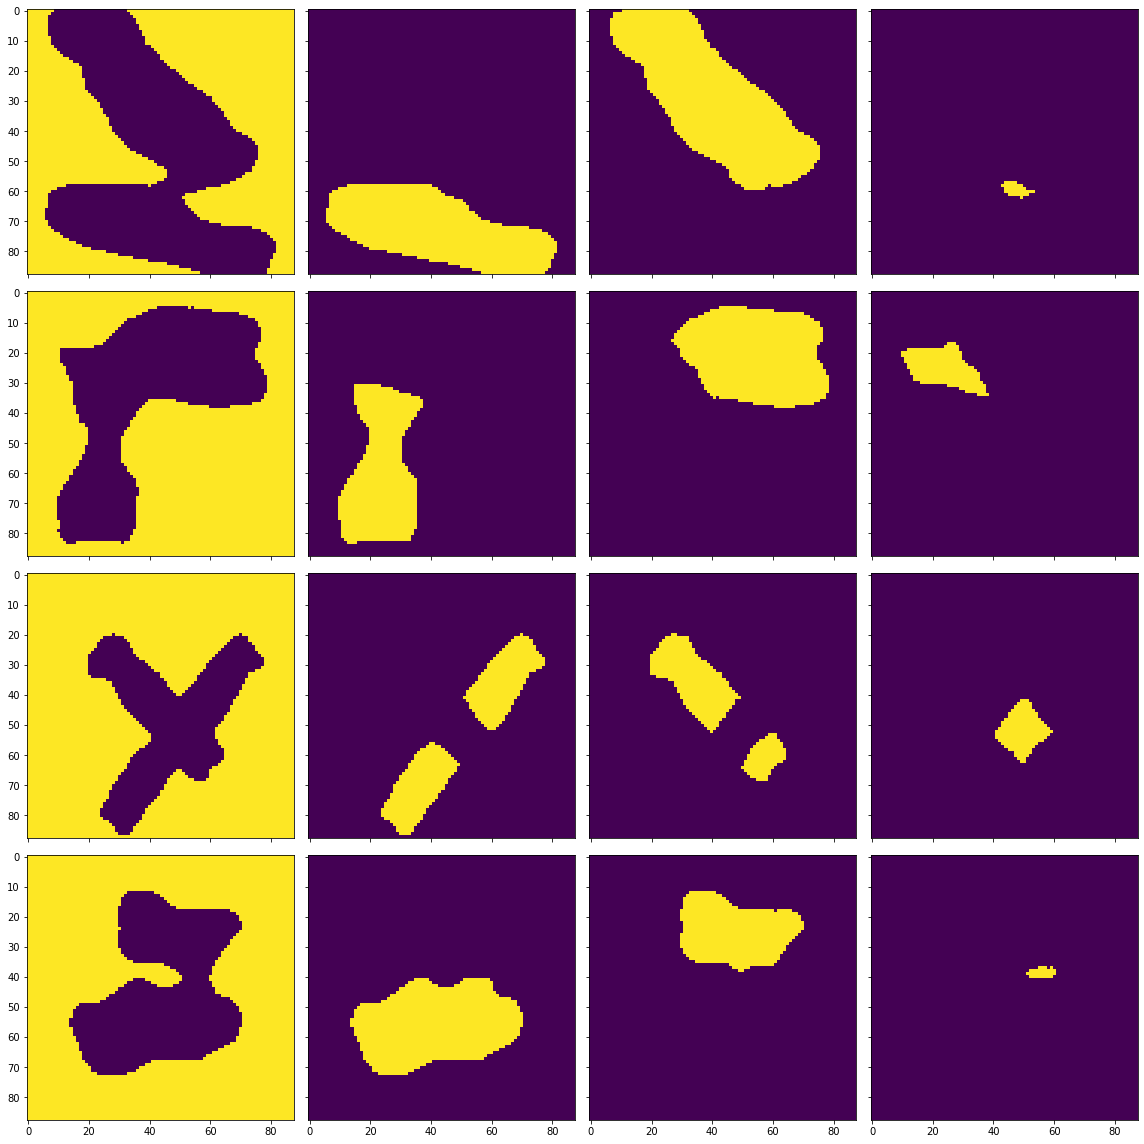

Training IOU: [0.9885059474883242, 0.9603435128701087, 0.9554495549898531, 0.9303543357267281]
Training accuracy: 0.9879319473140495
Testing IOU: [0.9676143022104633, 0.3946421952860104, 0.2937187287529855, 0.3851774869279984]
Testing accuracy: 0.8613081095041323
13/13 [==============================] - 1s 67ms/step - loss: 0.0046 - val_loss: 0.0625
INFO:tensorflow:Assets written to: modelunet/savedmodel_221epoch\assets
4
4


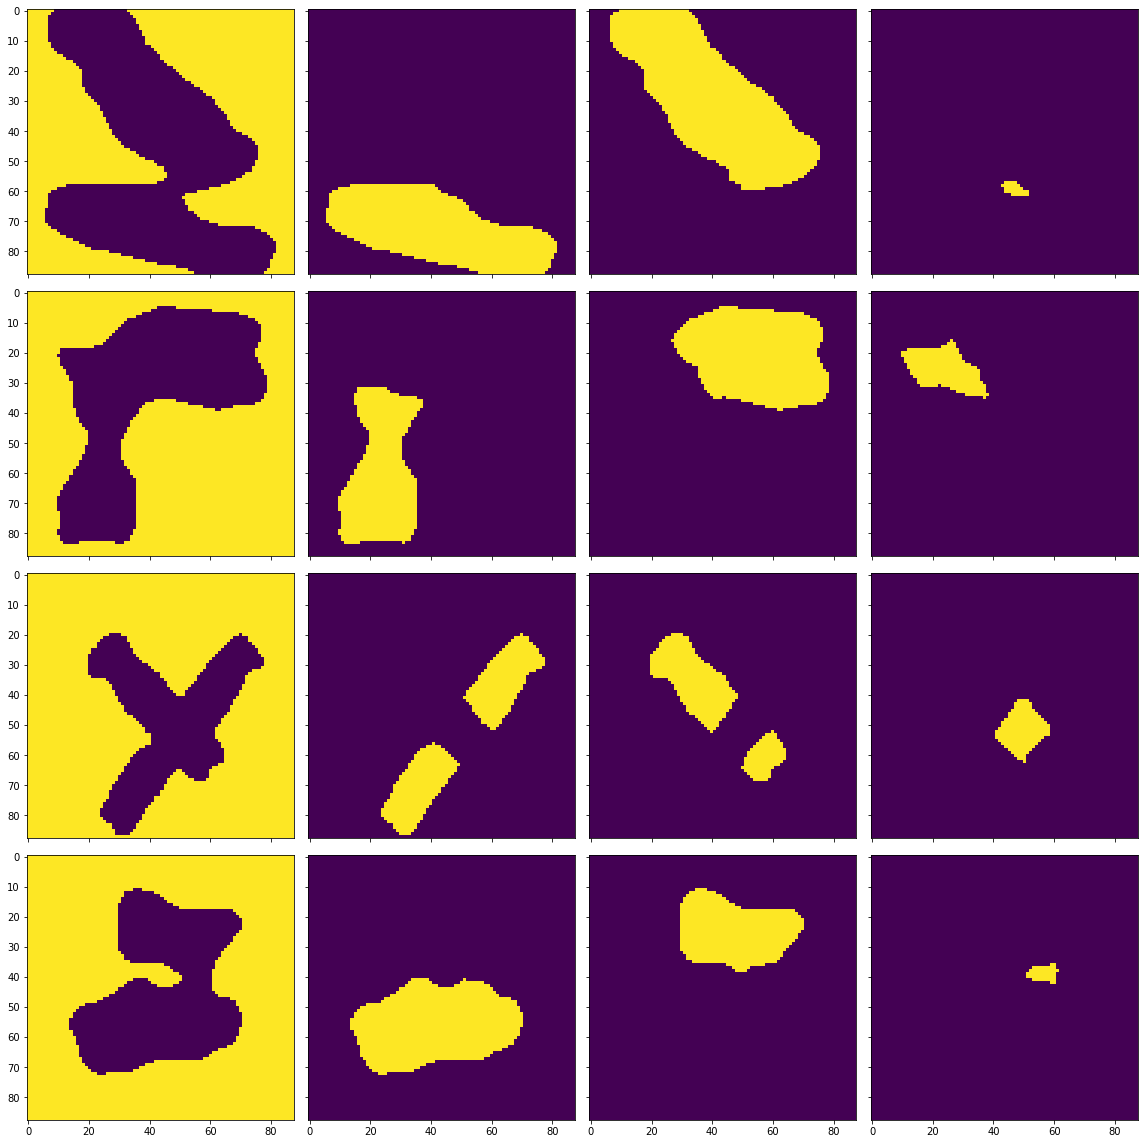

Training IOU: [0.9889267884955717, 0.9537177453357839, 0.9660317676733247, 0.9136082579590168]
Training accuracy: 0.9885123966942149
Testing IOU: [0.9692977173318283, 0.3649462535001468, 0.3123920304042382, 0.35798608176260105]
Testing accuracy: 0.8586776859504133
13/13 [==============================] - 1s 66ms/step - loss: 0.0044 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_222epoch\assets
4
4


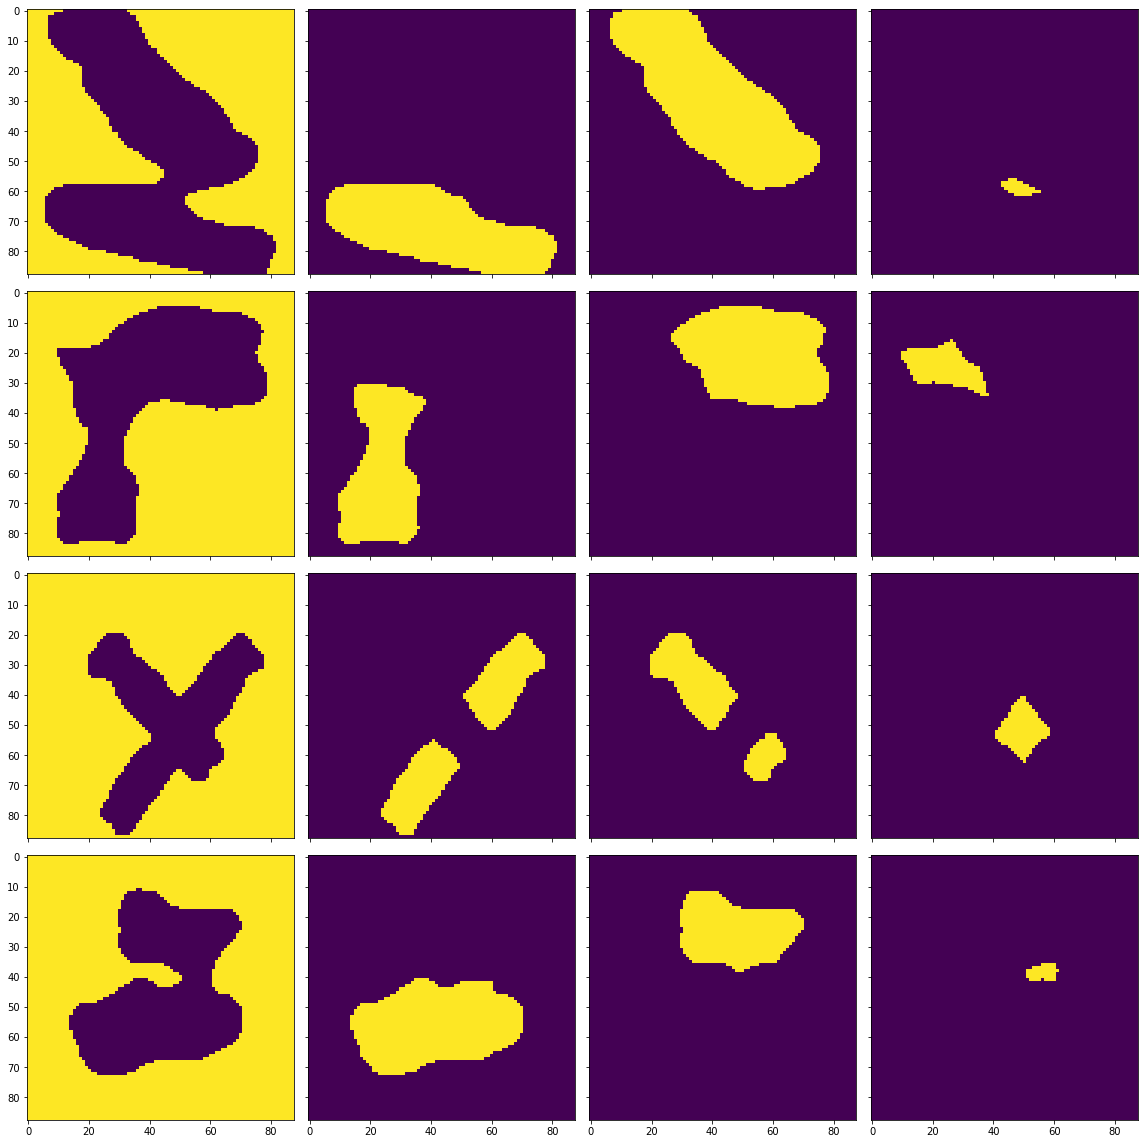

Training IOU: [0.9909198555670827, 0.9654730519703812, 0.9660440497801885, 0.9073983888313955]
Training accuracy: 0.9899635201446281
Testing IOU: [0.9704772989435054, 0.39914421295983343, 0.29287500434133296, 0.3572093548114086]
Testing accuracy: 0.8607980371900826
13/13 [==============================] - 1s 67ms/step - loss: 0.0041 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelunet/savedmodel_223epoch\assets
4
4


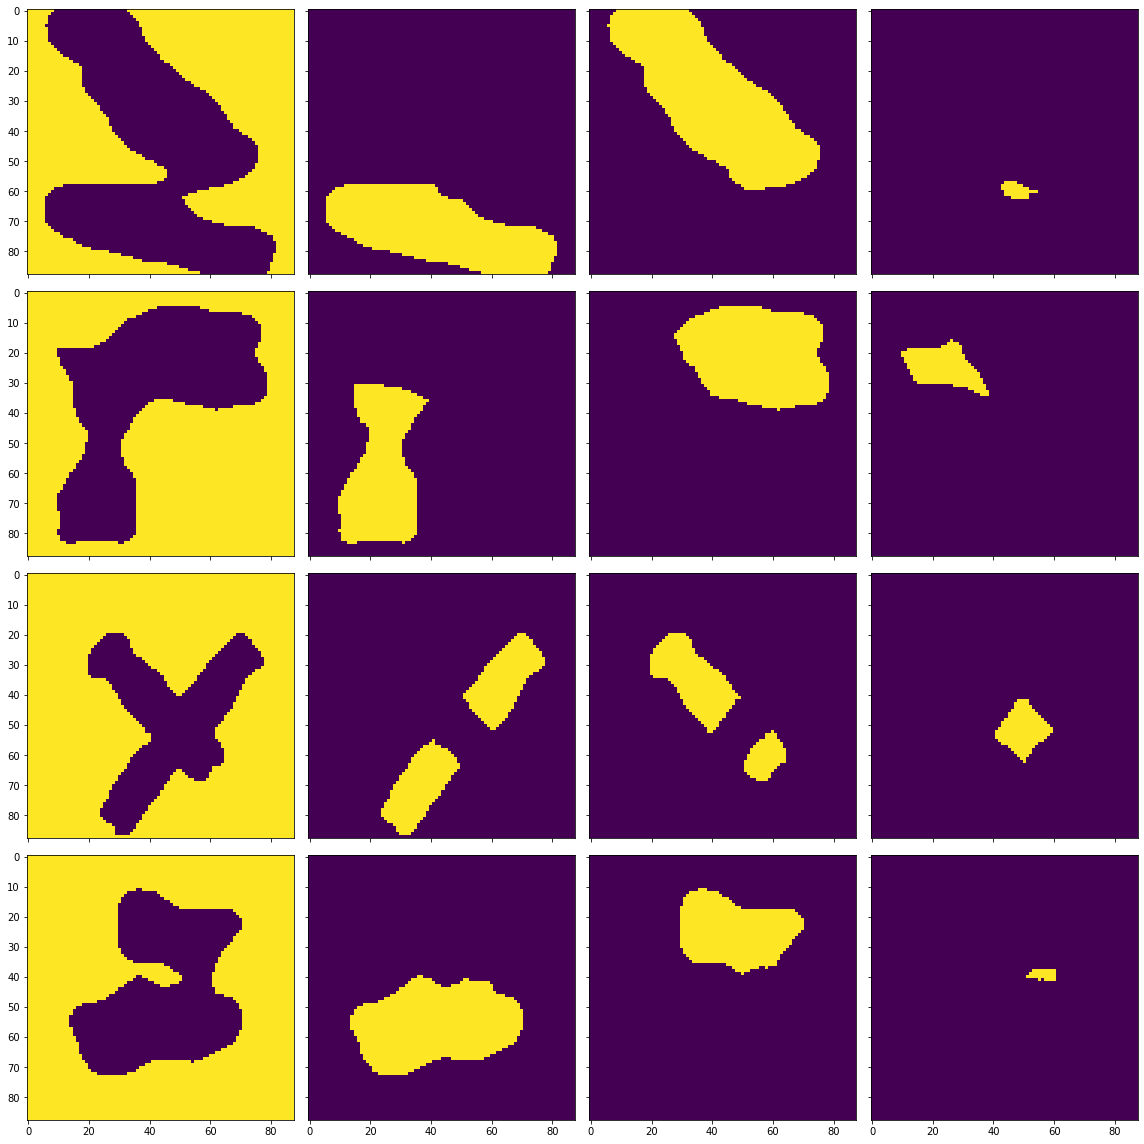

Training IOU: [0.9921699866576789, 0.9695229324256469, 0.9727927795594944, 0.9218709389002672]
Training accuracy: 0.991613507231405
Testing IOU: [0.9701815971640659, 0.38930114695390544, 0.3174039823377489, 0.3702086658034988]
Testing accuracy: 0.8626420454545455
13/13 [==============================] - 1s 67ms/step - loss: 0.0038 - val_loss: 0.0602ETA: 0s - loss: 0.00 - ETA: 0s - loss: 0.00
INFO:tensorflow:Assets written to: modelunet/savedmodel_224epoch\assets
4
4


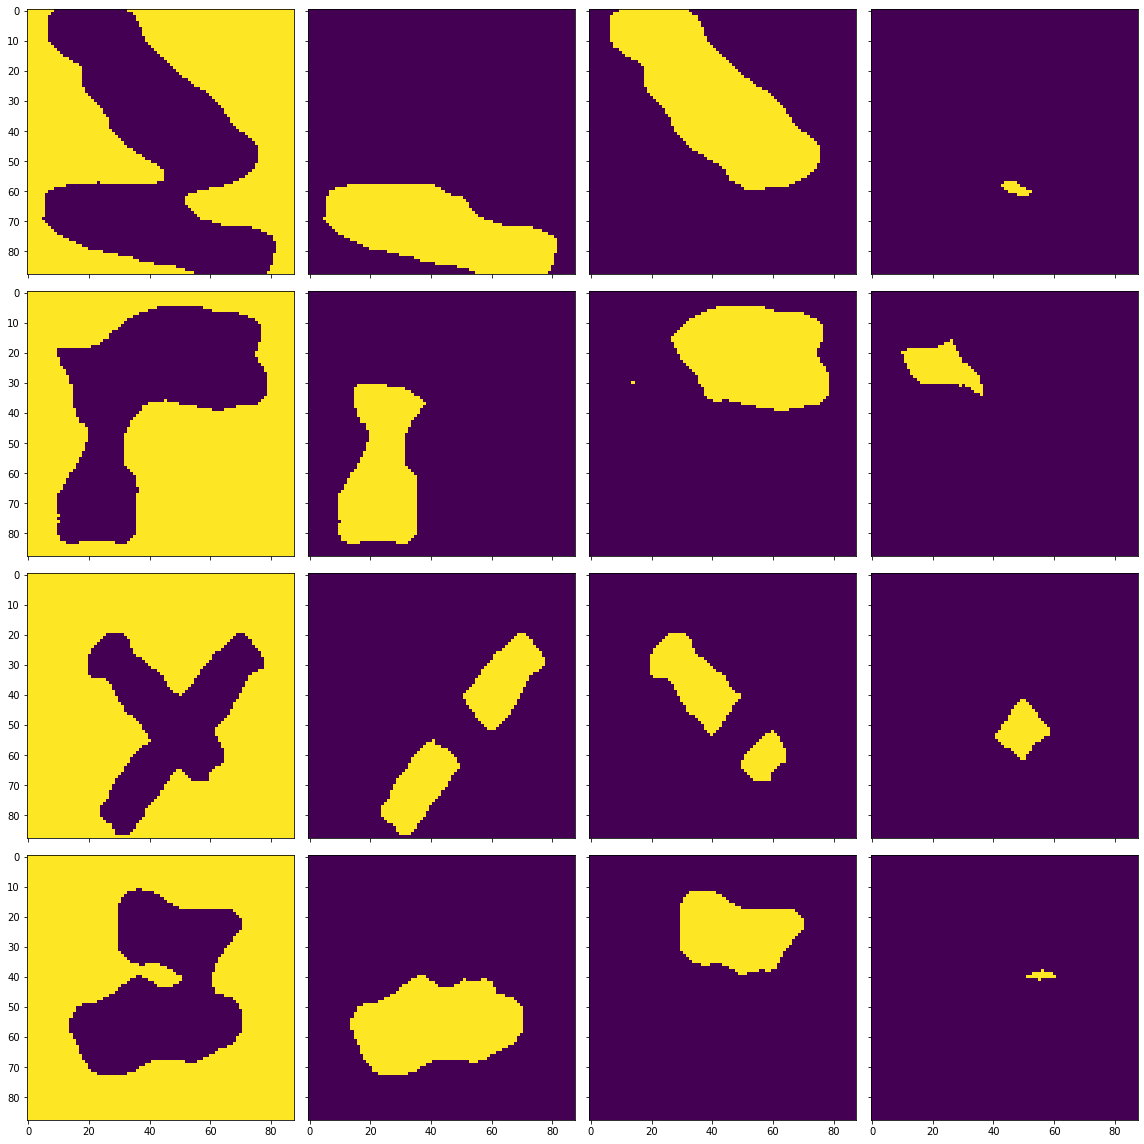

Training IOU: [0.9918047113112372, 0.9709048234745644, 0.9626853333333333, 0.8891054774161588]
Training accuracy: 0.9904664901859505
Testing IOU: [0.9709399756246191, 0.39794137452416617, 0.32633171571822917, 0.39333989142711406]
Testing accuracy: 0.8653215392561984
13/13 [==============================] - 1s 66ms/step - loss: 0.0038 - val_loss: 0.0630
INFO:tensorflow:Assets written to: modelunet/savedmodel_225epoch\assets
4
4


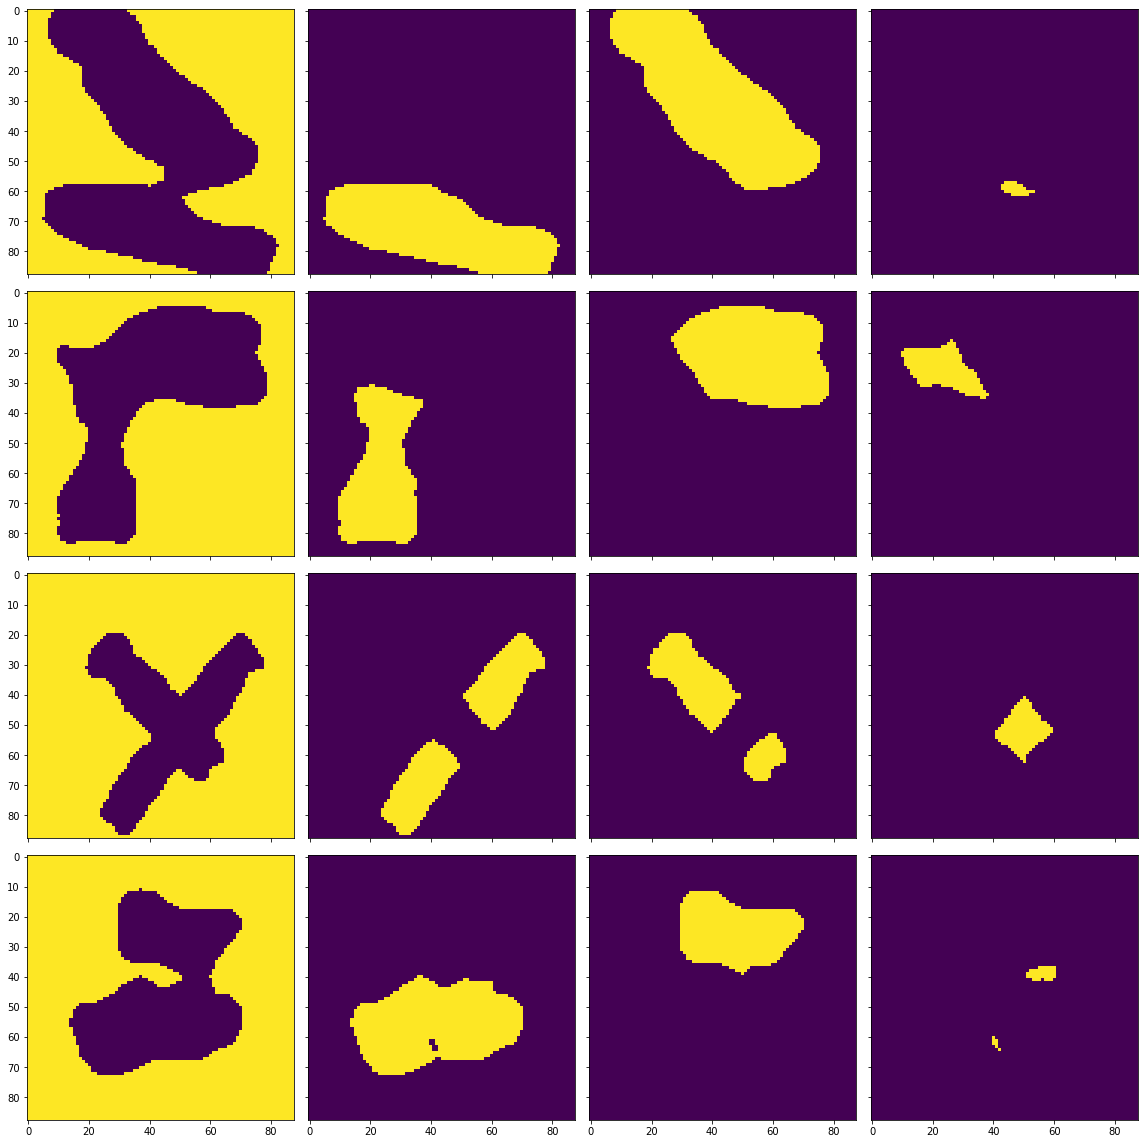

Training IOU: [0.9920271282039046, 0.9681843497632971, 0.970352732262491, 0.9025500444953612]
Training accuracy: 0.9909429881198347
Testing IOU: [0.9702081006021326, 0.36204593534971374, 0.33265143317510093, 0.3584156135755203]
Testing accuracy: 0.8597107438016529
13/13 [==============================] - ETA: 0s - loss: 0.0038- ETA: 0s - loss: 0 - ETA: 0s - loss: 0.003 - 1s 66ms/step - loss: 0.0038 - val_loss: 0.0606
INFO:tensorflow:Assets written to: modelunet/savedmodel_226epoch\assets
4
4


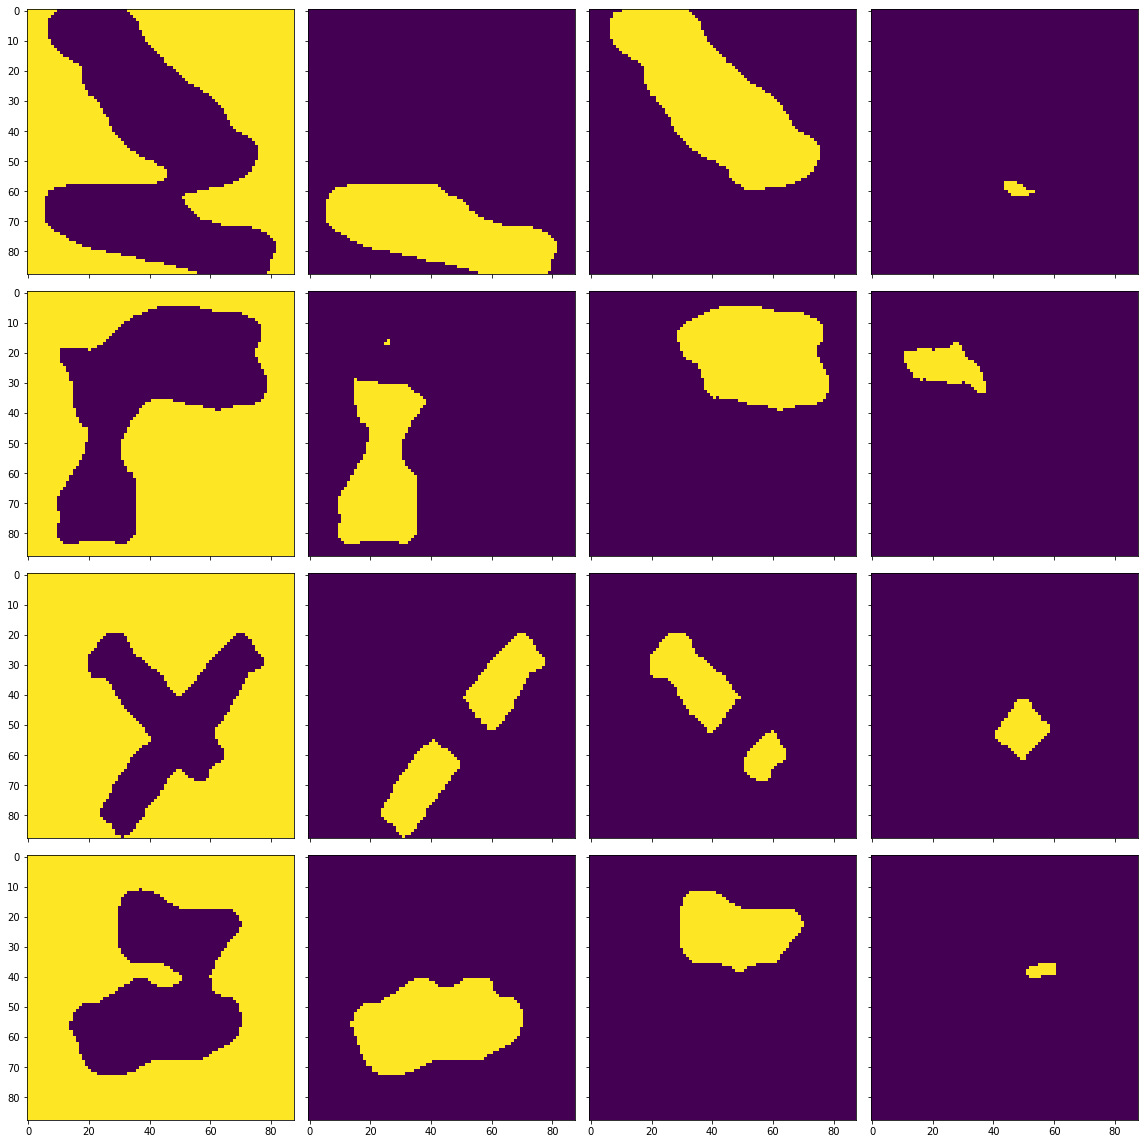

Training IOU: [0.9918461940376893, 0.9701219017131192, 0.9713985744399879, 0.9309302325581396]
Training accuracy: 0.9914740444214876
Testing IOU: [0.9694669508125551, 0.3984056638722336, 0.3035426662462396, 0.38236597252990695]
Testing accuracy: 0.863254132231405
13/13 [==============================] - 1s 67ms/step - loss: 0.0036 - val_loss: 0.0615
INFO:tensorflow:Assets written to: modelunet/savedmodel_227epoch\assets
4
4


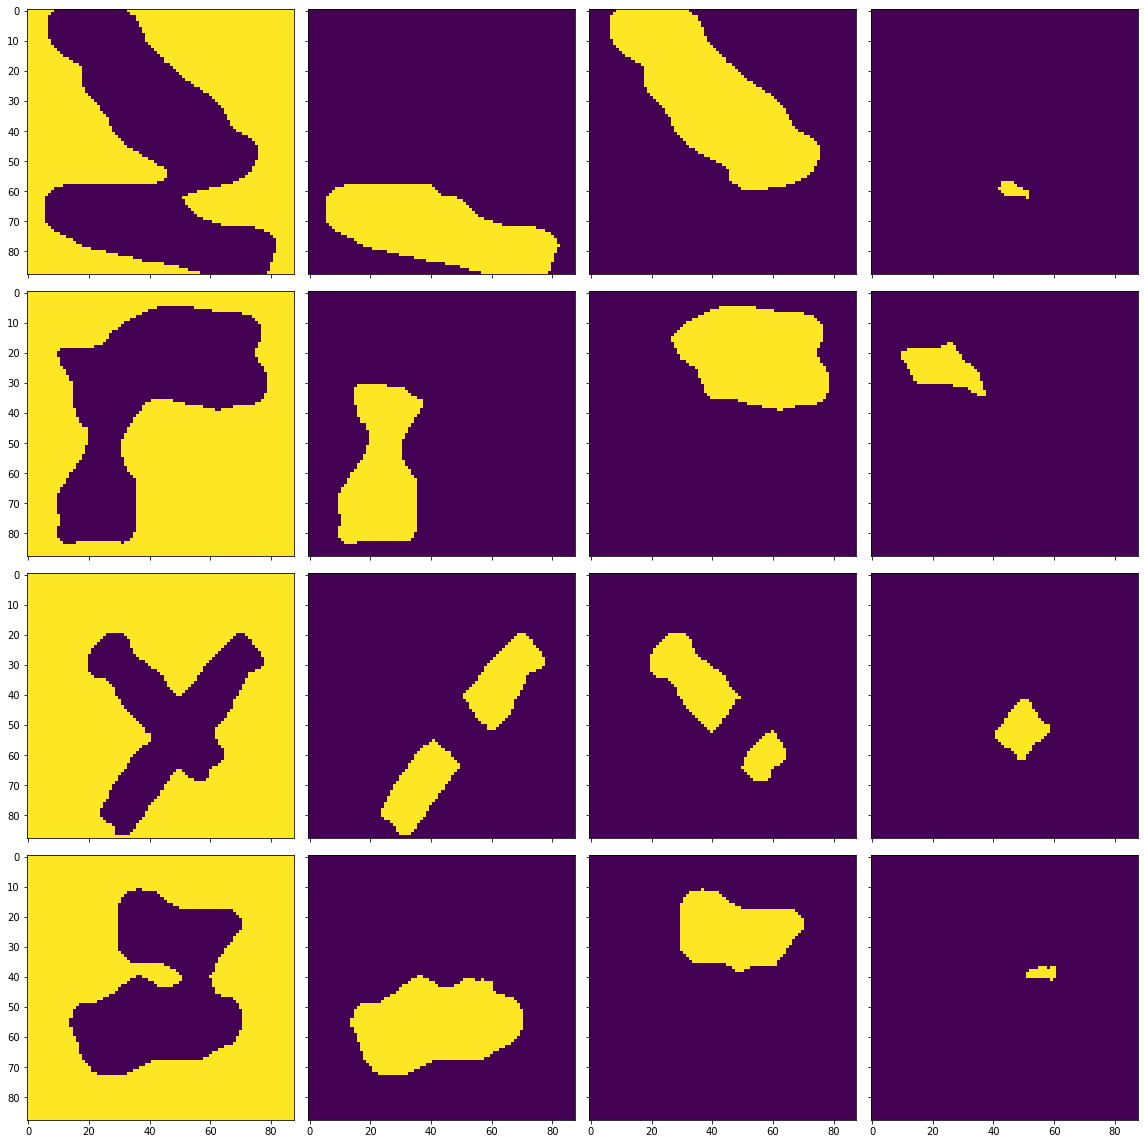

Training IOU: [0.992850436690545, 0.970558540954242, 0.9770956174864579, 0.9282815040117468]
Training accuracy: 0.9922010588842975
Testing IOU: [0.9696139644407363, 0.3701495092444647, 0.3230467515417717, 0.3717164447643037]
Testing accuracy: 0.8608290289256199
13/13 [==============================] - 1s 66ms/step - loss: 0.0034 - val_loss: 0.0620
INFO:tensorflow:Assets written to: modelunet/savedmodel_228epoch\assets
4
4


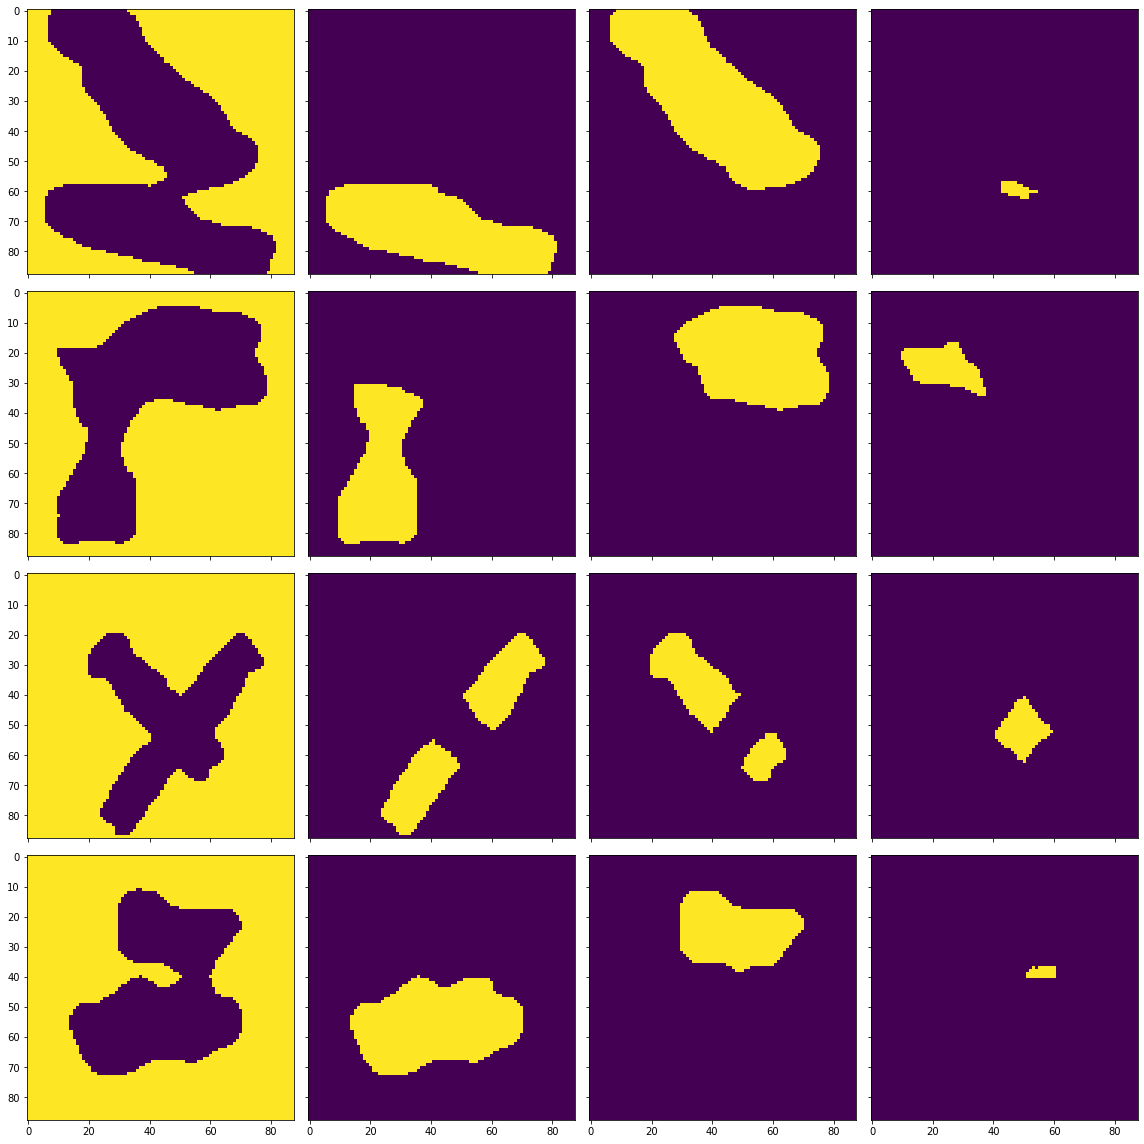

Training IOU: [0.9936338961383862, 0.976836320501177, 0.9783400013117335, 0.9420779357004249]
Training accuracy: 0.9933199896694215
Testing IOU: [0.9704976428172868, 0.39317438701515955, 0.31388877194459647, 0.3754024856308868]
Testing accuracy: 0.8631482438016529
13/13 [==============================] - 1s 67ms/step - loss: 0.0032 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_229epoch\assets
4
4


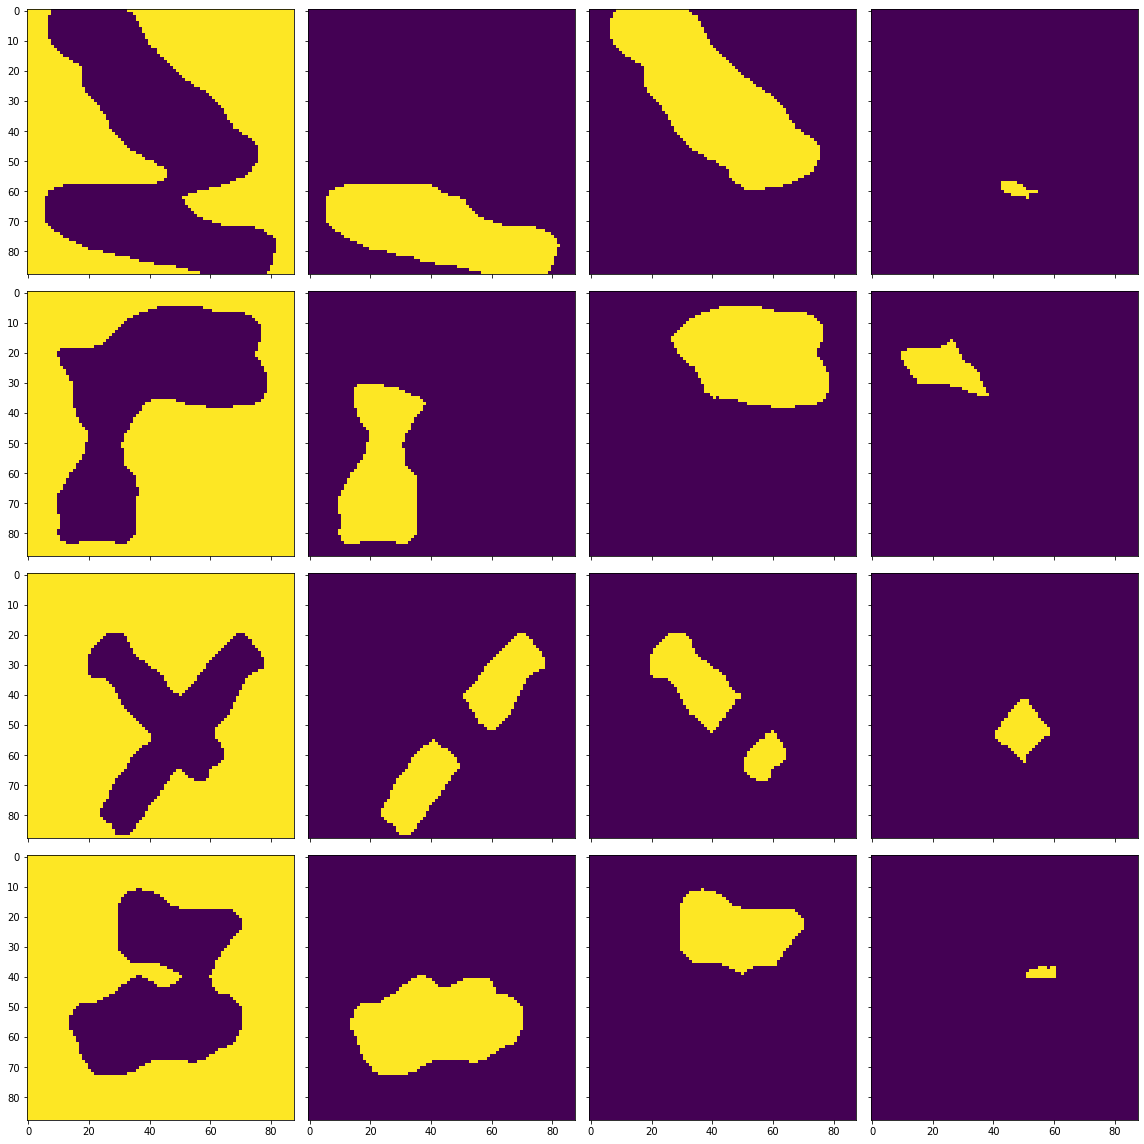

Training IOU: [0.9938956080077087, 0.9774637790085913, 0.98009646232077, 0.9456878224919076]
Training accuracy: 0.9935976239669422
Testing IOU: [0.9701384787031568, 0.3934620444542405, 0.3150239234449761, 0.3863694676074407]
Testing accuracy: 0.8635653409090909
13/13 [==============================] - 1s 67ms/step - loss: 0.0032 - val_loss: 0.0611
INFO:tensorflow:Assets written to: modelunet/savedmodel_230epoch\assets
4
4


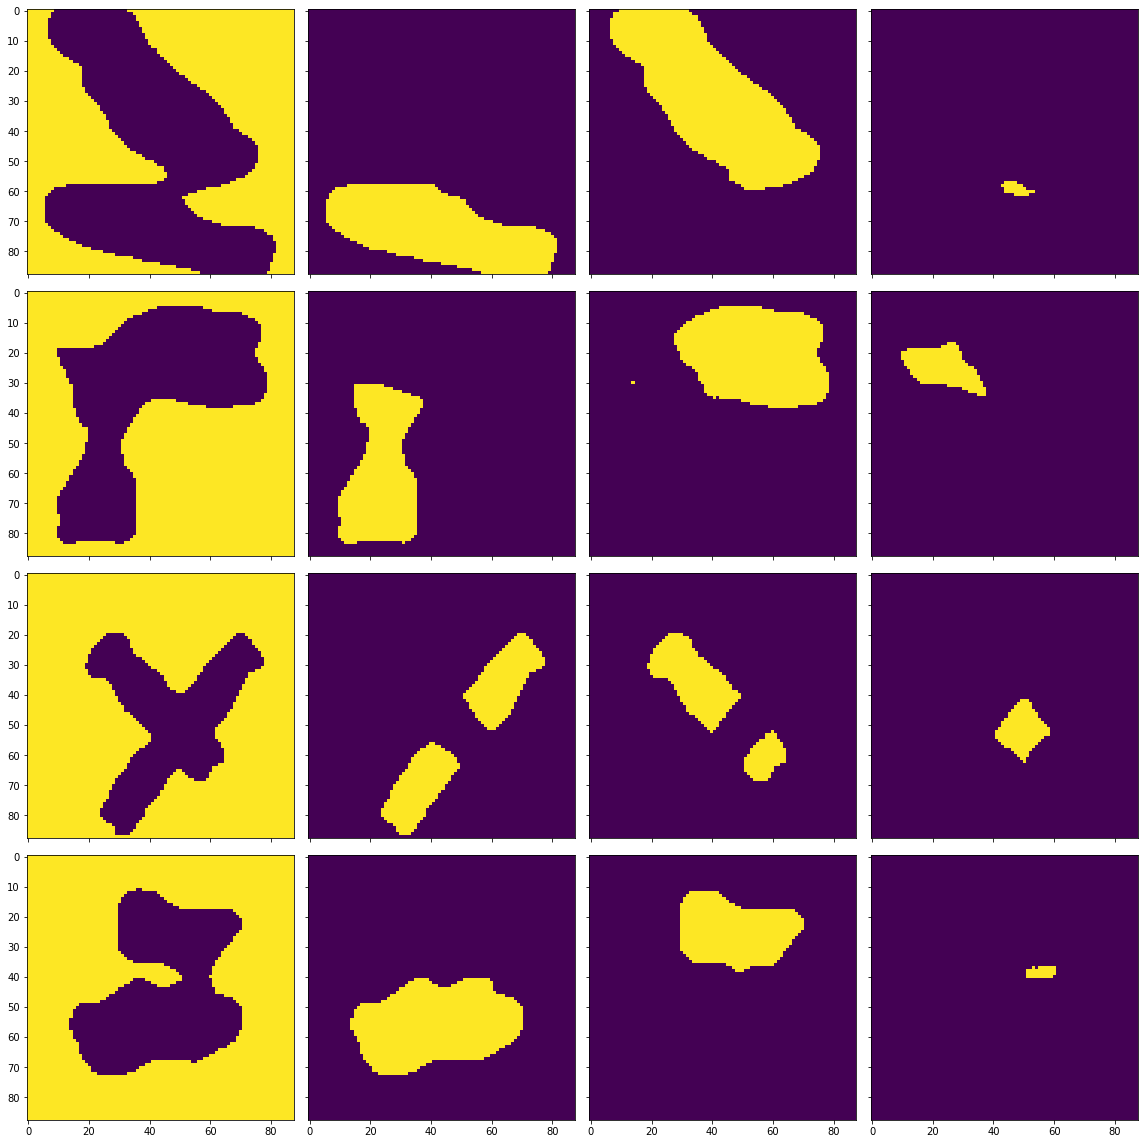

Training IOU: [0.9940702851700416, 0.9778969016710063, 0.9803174429871849, 0.9447425065056061]
Training accuracy: 0.9935617897727272
Testing IOU: [0.9701000462601755, 0.39502269611996227, 0.31045855852831583, 0.3821284949811596]
Testing accuracy: 0.8631456611570248
13/13 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0598
INFO:tensorflow:Assets written to: modelunet/savedmodel_231epoch\assets
4
4


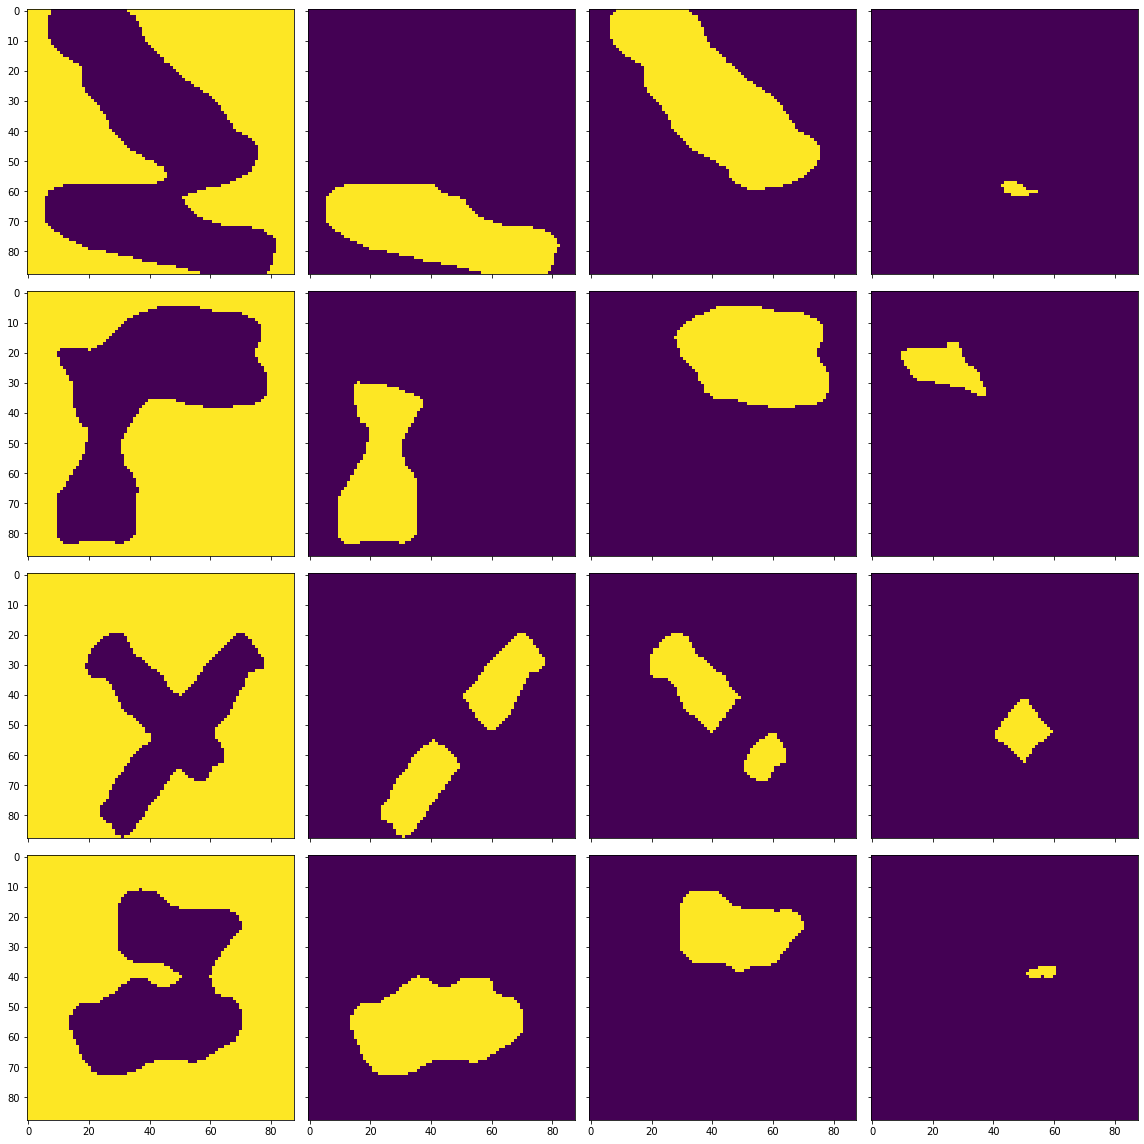

Training IOU: [0.9939528105907047, 0.9778082749746585, 0.9786902229920845, 0.943393602225313]
Training accuracy: 0.9931417871900826
Testing IOU: [0.9699135753040741, 0.3968803207557533, 0.3112705352973638, 0.3871783382409423]
Testing accuracy: 0.8633755165289256
13/13 [==============================] - 1s 67ms/step - loss: 0.0032 - val_loss: 0.0607
INFO:tensorflow:Assets written to: modelunet/savedmodel_232epoch\assets
4
4


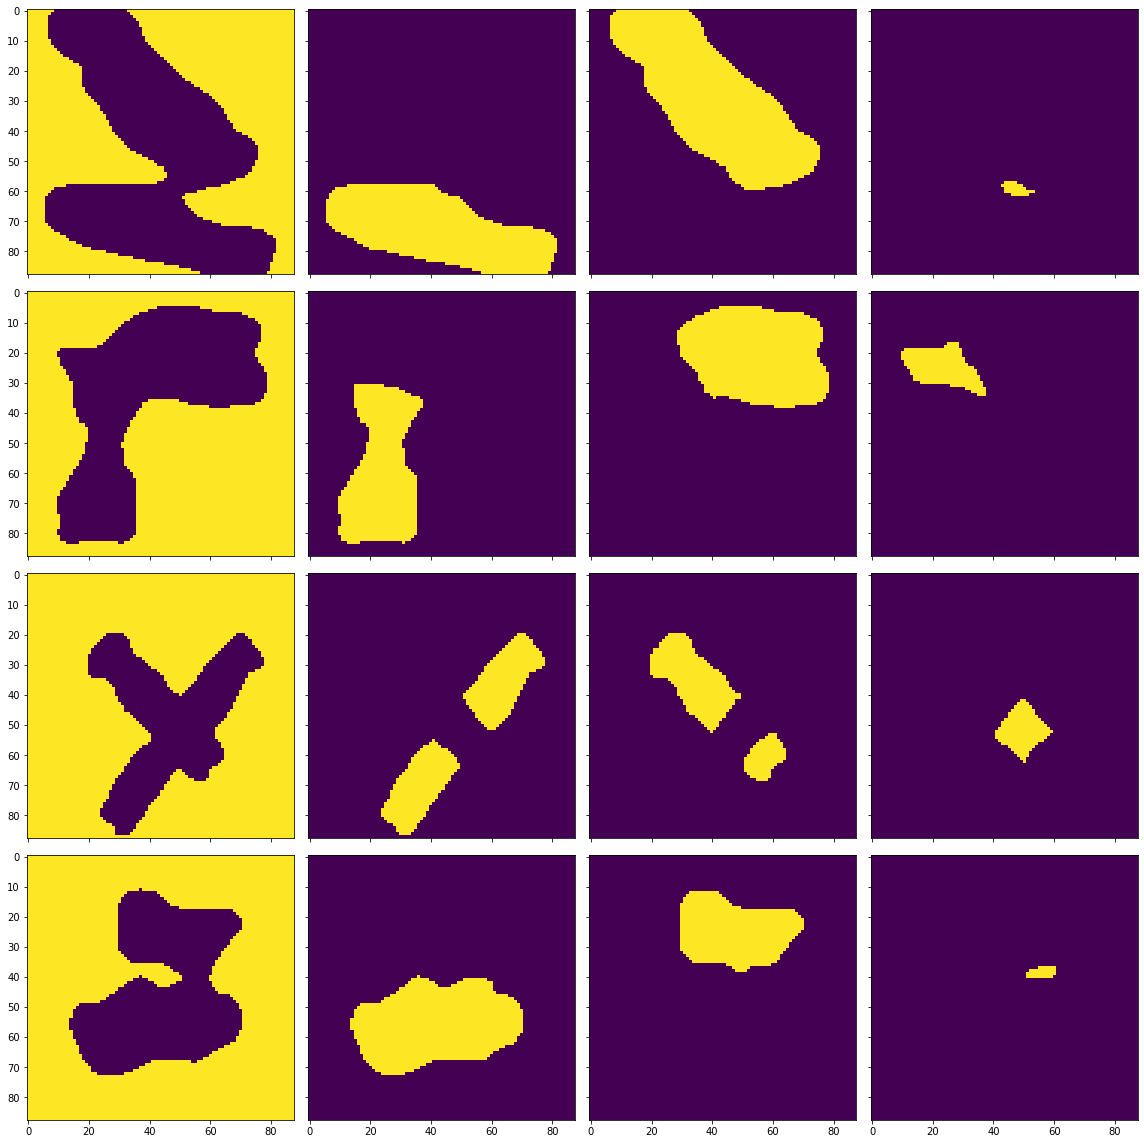

Training IOU: [0.993816677924879, 0.977530252196313, 0.9780415039705173, 0.9460944334208112]
Training accuracy: 0.9932780216942149
Testing IOU: [0.9696912222137926, 0.3977773990114198, 0.3028216598099506, 0.3839518747214972]
Testing accuracy: 0.8628589876033058
13/13 [==============================] - 1s 67ms/step - loss: 0.0032 - val_loss: 0.0616
INFO:tensorflow:Assets written to: modelunet/savedmodel_233epoch\assets
4
4


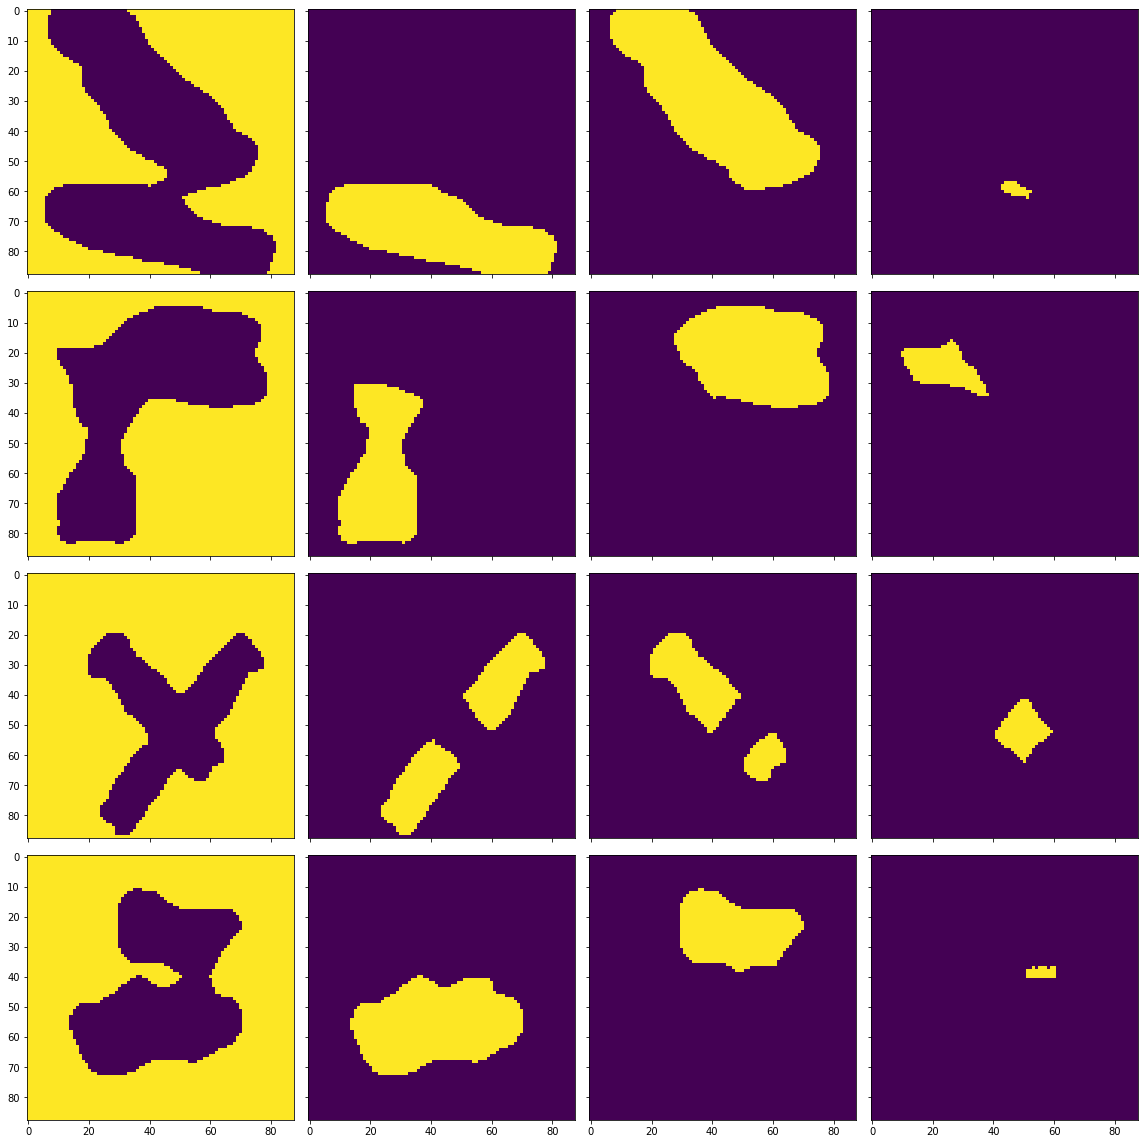

Training IOU: [0.994219765098314, 0.9789351175655061, 0.9810807637593825, 0.9483745165105648]
Training accuracy: 0.9938568569214876
Testing IOU: [0.9701792525646361, 0.3870556175762913, 0.31415274482735817, 0.3827207156130902]
Testing accuracy: 0.8623863636363637
13/13 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0623A: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_234epoch\assets
4
4


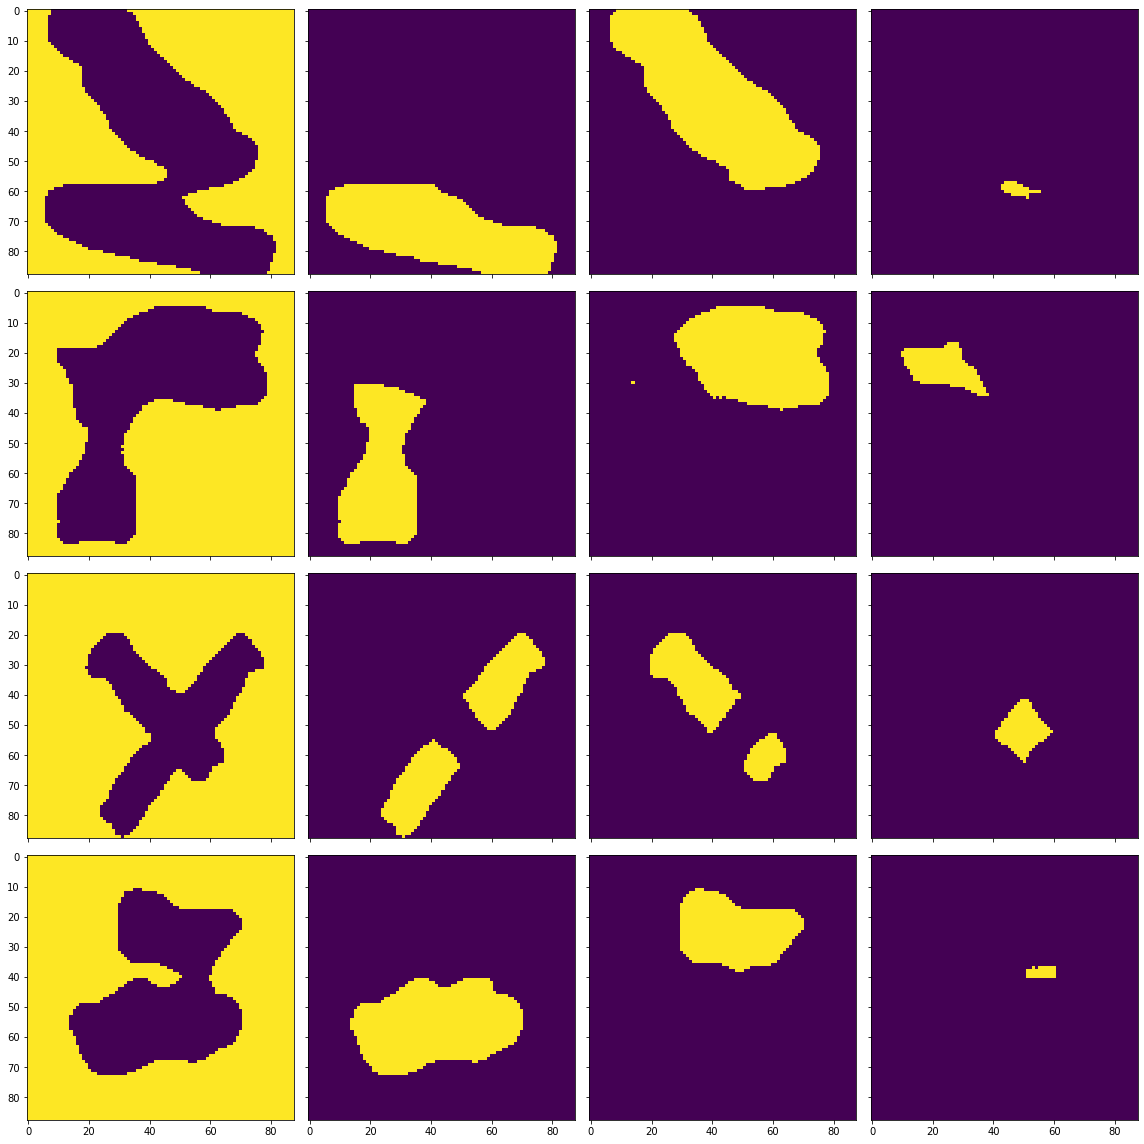

Training IOU: [0.9939178593316269, 0.9784806089765811, 0.9803744710072458, 0.9497830064247117]
Training accuracy: 0.9937038352272727
Testing IOU: [0.9702532750789702, 0.39070090215128384, 0.3107934108108557, 0.3754591757987344]
Testing accuracy: 0.862108729338843
13/13 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0619
INFO:tensorflow:Assets written to: modelunet/savedmodel_235epoch\assets
4
4


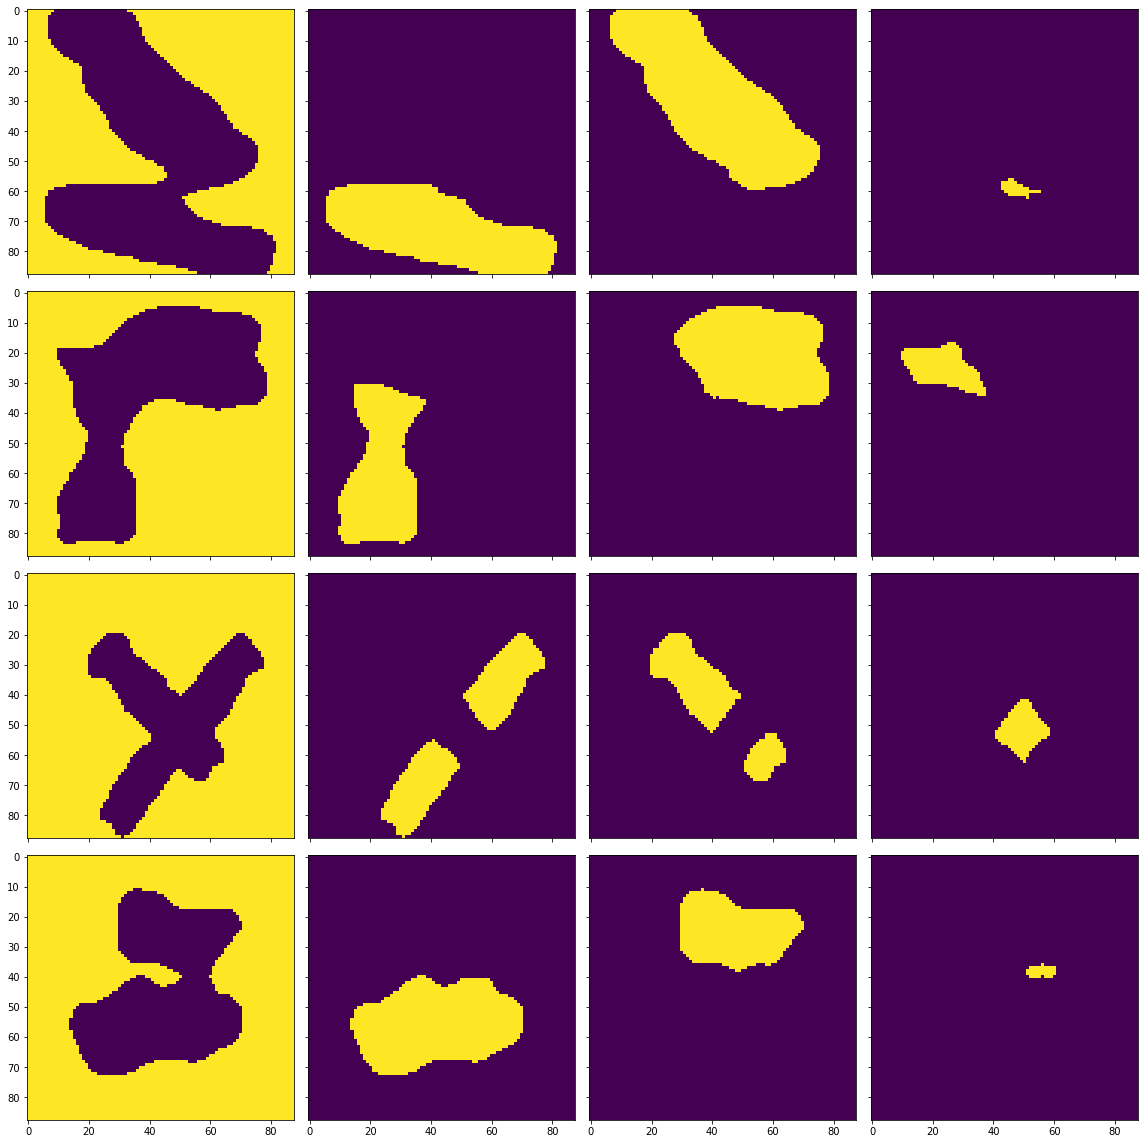

Training IOU: [0.9938552510164653, 0.9773095923582774, 0.9807945428429429, 0.9482991474634929]
Training accuracy: 0.9936147339876034
Testing IOU: [0.970237632149927, 0.38795900998456995, 0.3124672232812513, 0.3713384139080734]
Testing accuracy: 0.8616735537190082
13/13 [==============================] - 1s 67ms/step - loss: 0.0030 - val_loss: 0.0604
INFO:tensorflow:Assets written to: modelunet/savedmodel_236epoch\assets
4
4


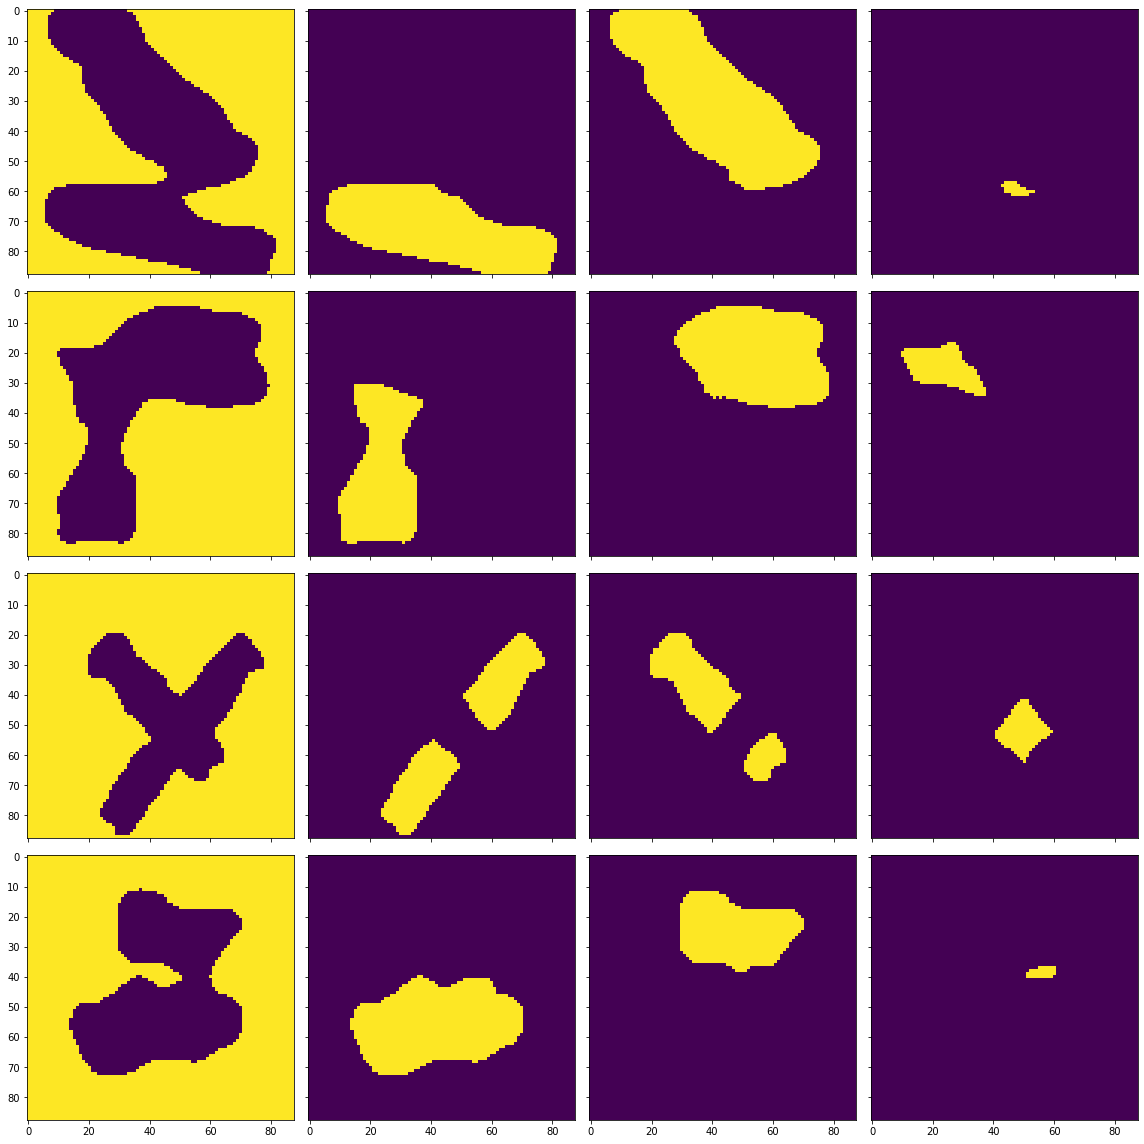

Training IOU: [0.9940141309154147, 0.9765631903267062, 0.9803606347258814, 0.9484945206936908]
Training accuracy: 0.9932996513429752
Testing IOU: [0.9696517189887125, 0.3870868734217832, 0.31294494045126386, 0.37433563443093654]
Testing accuracy: 0.8618879132231405
13/13 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0616
INFO:tensorflow:Assets written to: modelunet/savedmodel_237epoch\assets
4
4


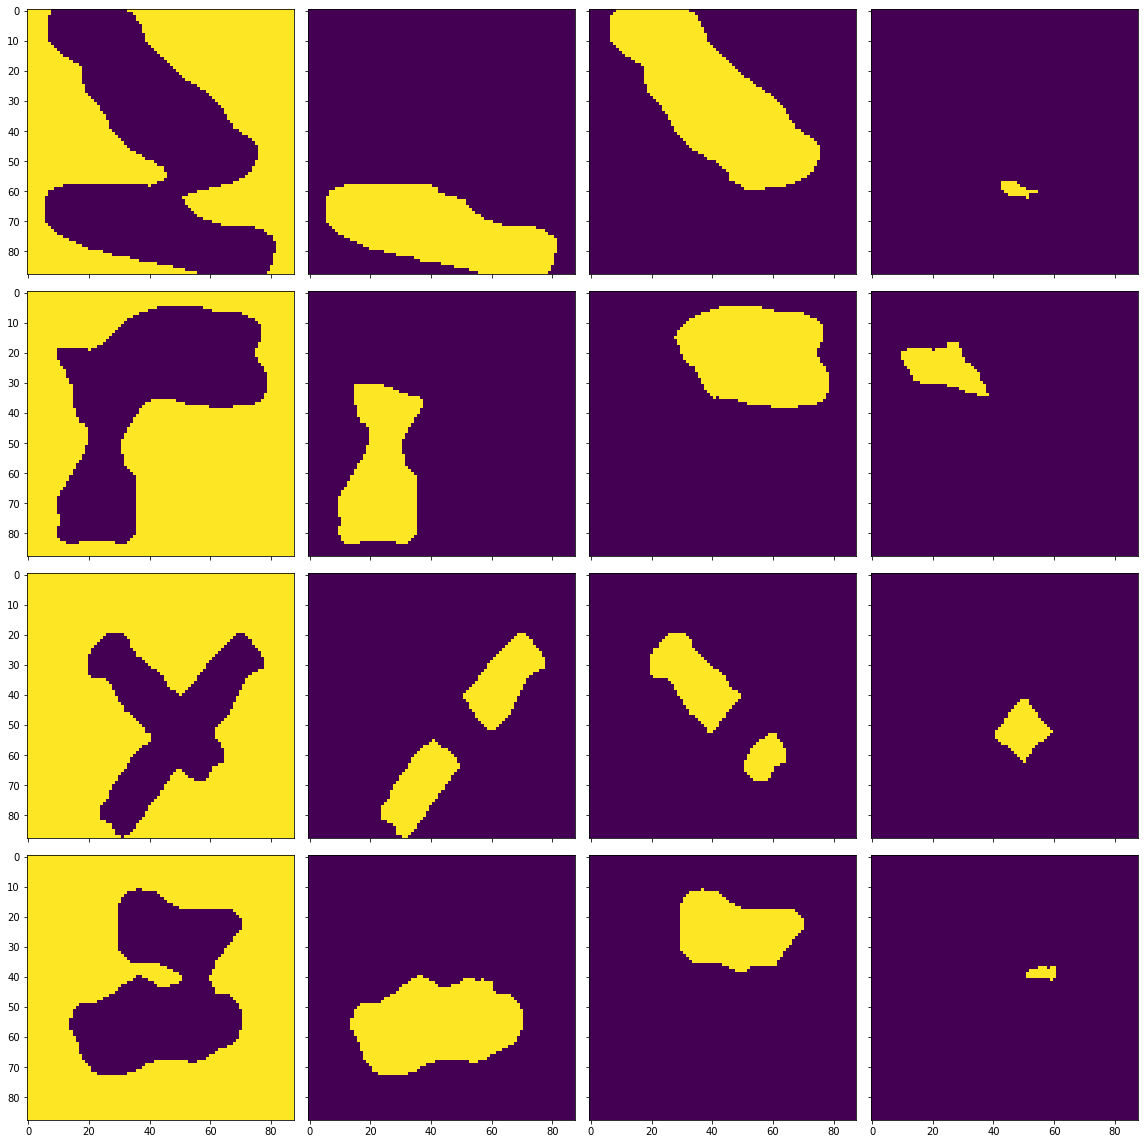

Training IOU: [0.9943865153886751, 0.9786665739227212, 0.9822040316384922, 0.9512754340314806]
Training accuracy: 0.9939317536157025
Testing IOU: [0.9698154187737287, 0.3918041701946045, 0.308146121633756, 0.3767450460722981]
Testing accuracy: 0.8620622417355371
13/13 [==============================] - 1s 67ms/step - loss: 0.0030 - val_loss: 0.0610ETA: 0s - loss: 0.003
INFO:tensorflow:Assets written to: modelunet/savedmodel_238epoch\assets
4
4


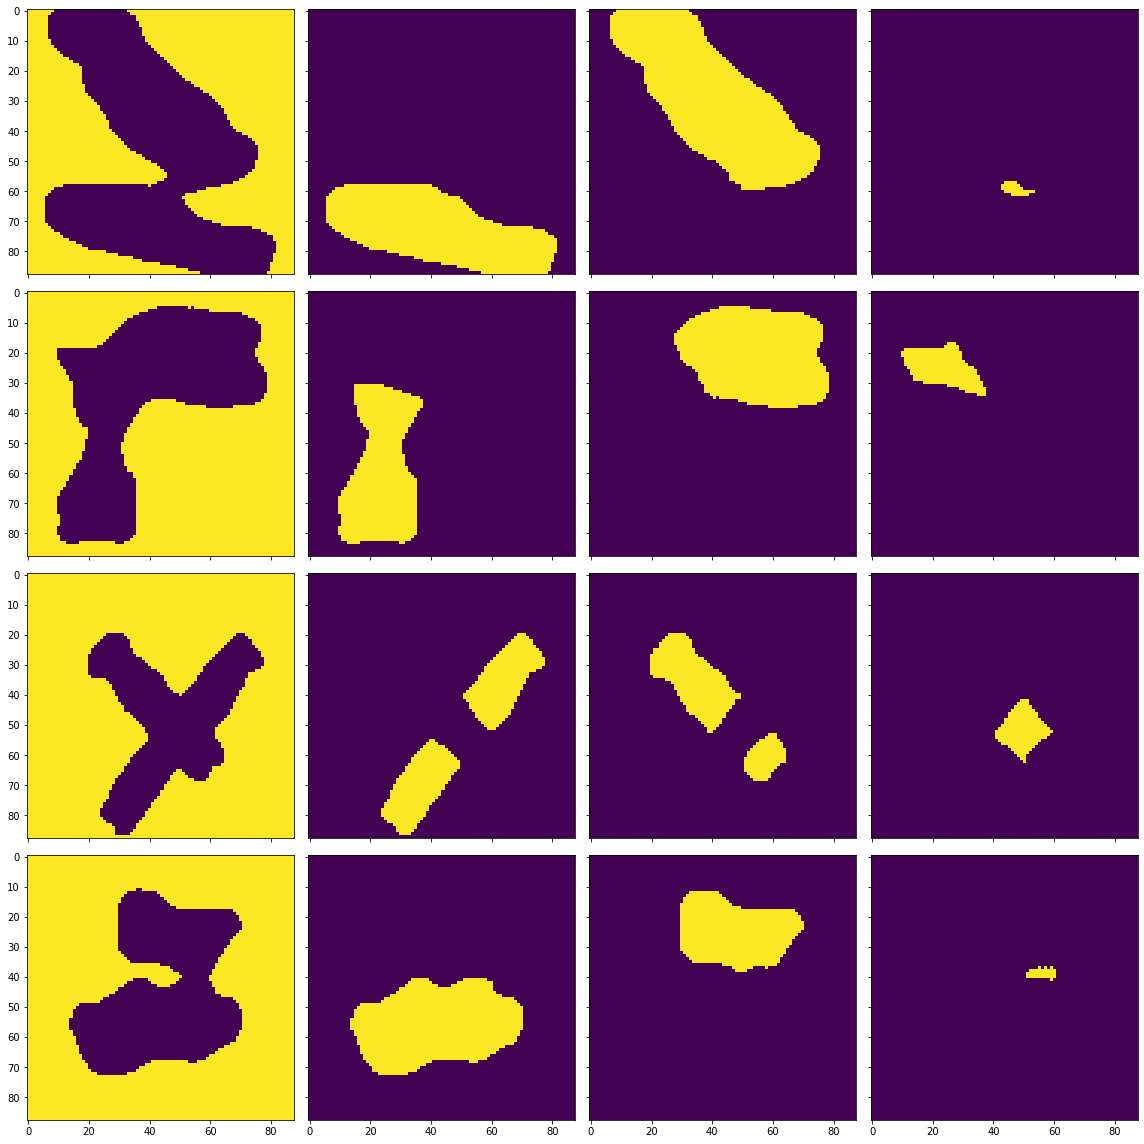

Training IOU: [0.9944352664202855, 0.9789914117873161, 0.981248718334313, 0.9437271750805586]
Training accuracy: 0.9938868801652893
Testing IOU: [0.9699506079945327, 0.3985874172958935, 0.3133217210712312, 0.3868889978747752]
Testing accuracy: 0.8642768595041322
13/13 [==============================] - 1s 66ms/step - loss: 0.0030 - val_loss: 0.0617
INFO:tensorflow:Assets written to: modelunet/savedmodel_239epoch\assets
4
4


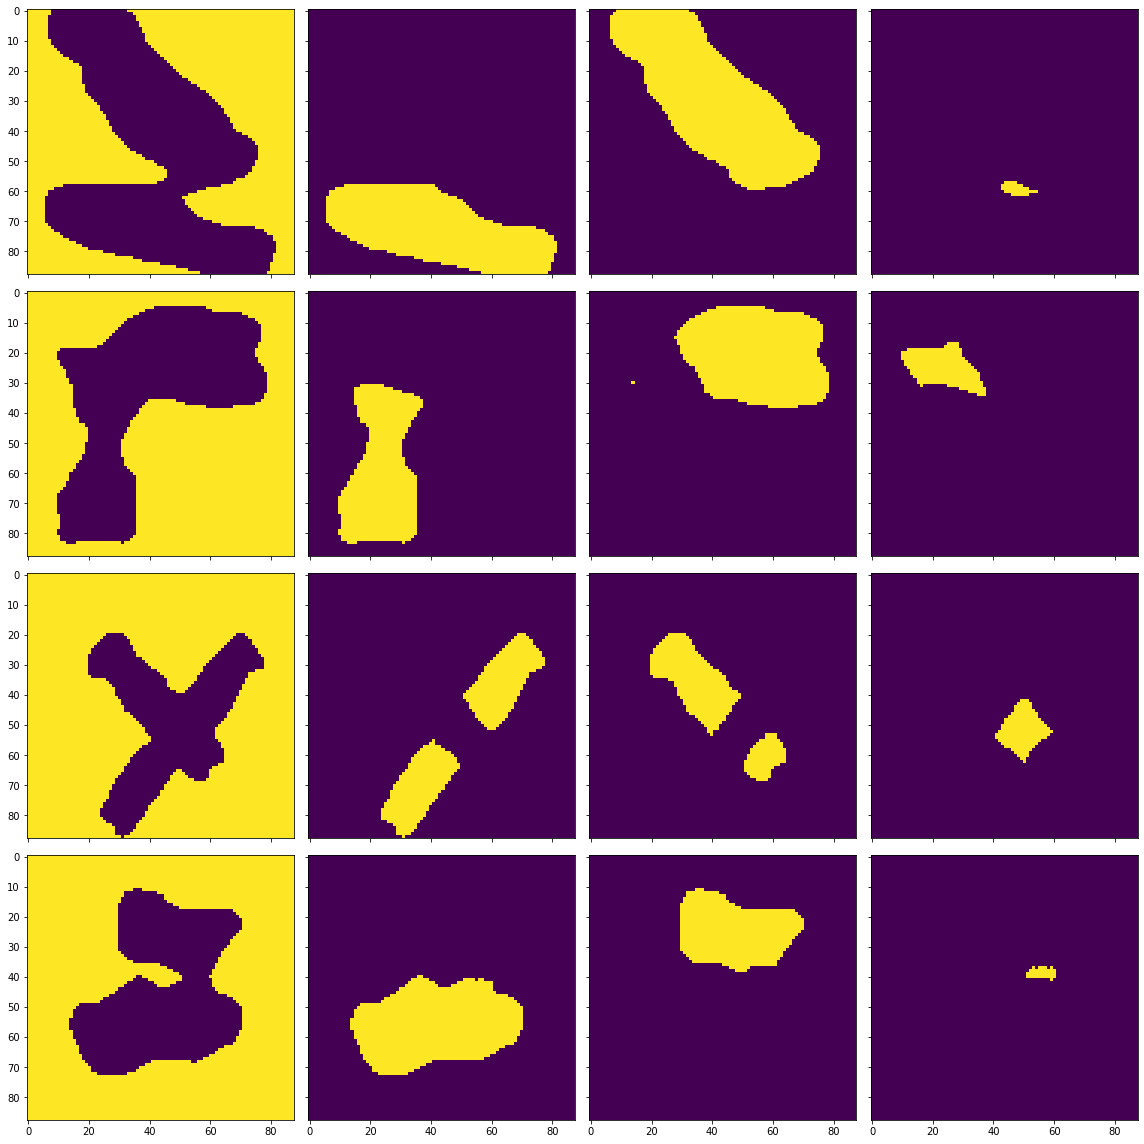

Training IOU: [0.9944533893802601, 0.9789212273128163, 0.9819702815233584, 0.9482518226810708]
Training accuracy: 0.9941393336776859
Testing IOU: [0.9696107854185614, 0.38955401428879505, 0.31597028706422553, 0.37249803471004417]
Testing accuracy: 0.862787964876033
13/13 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0595
INFO:tensorflow:Assets written to: modelunet/savedmodel_240epoch\assets
4
4


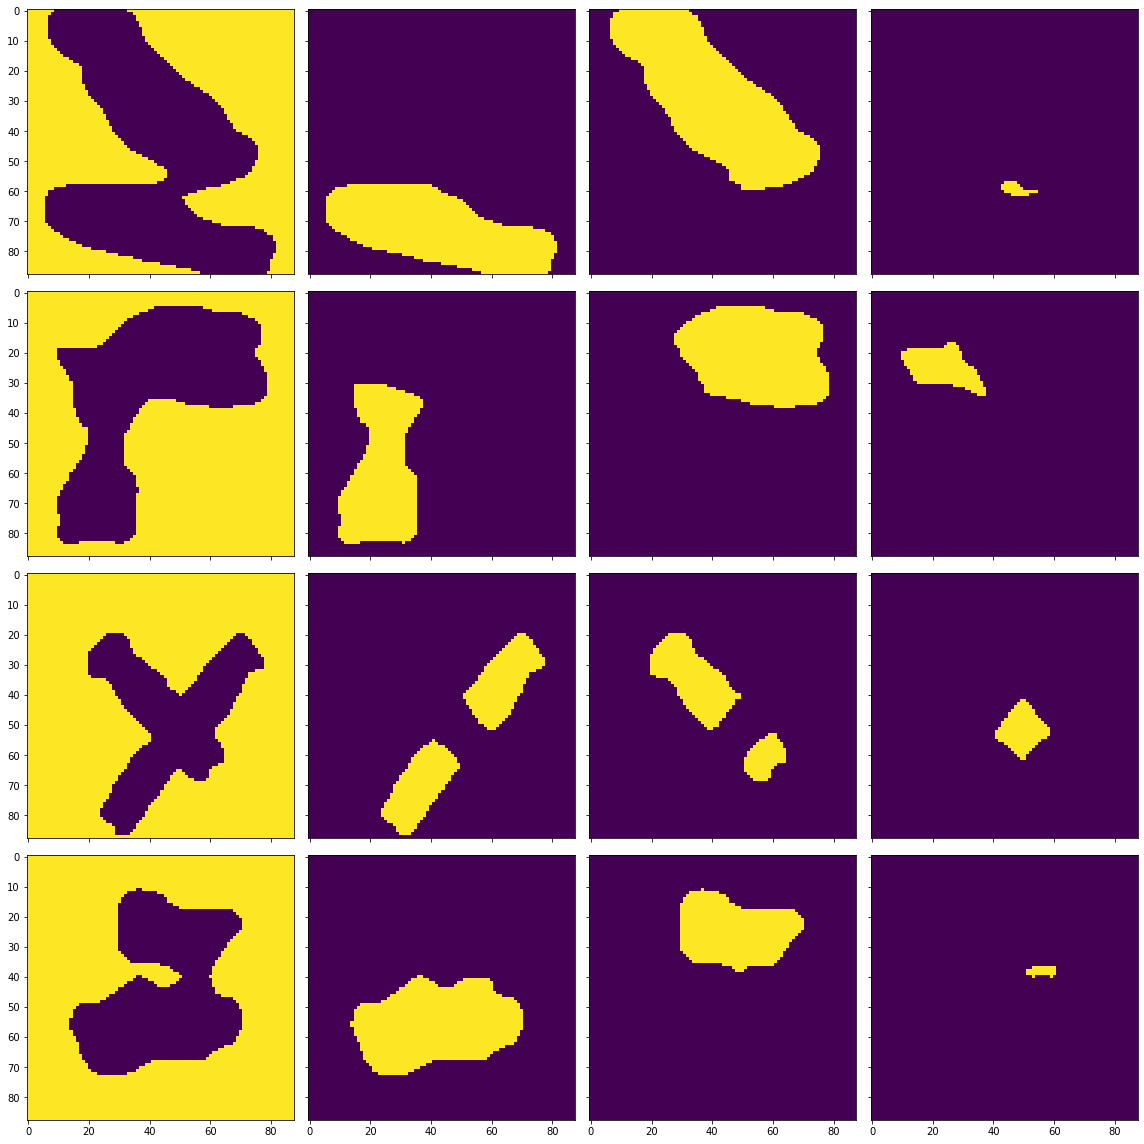

Training IOU: [0.9943602914104492, 0.9777007443133072, 0.9803993515739666, 0.9406389261744966]
Training accuracy: 0.9931882747933884
Testing IOU: [0.9693854316881827, 0.39973298644392713, 0.30474724190434066, 0.38371562622181676]
Testing accuracy: 0.8625581095041323
13/13 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0607
INFO:tensorflow:Assets written to: modelunet/savedmodel_241epoch\assets
4
4


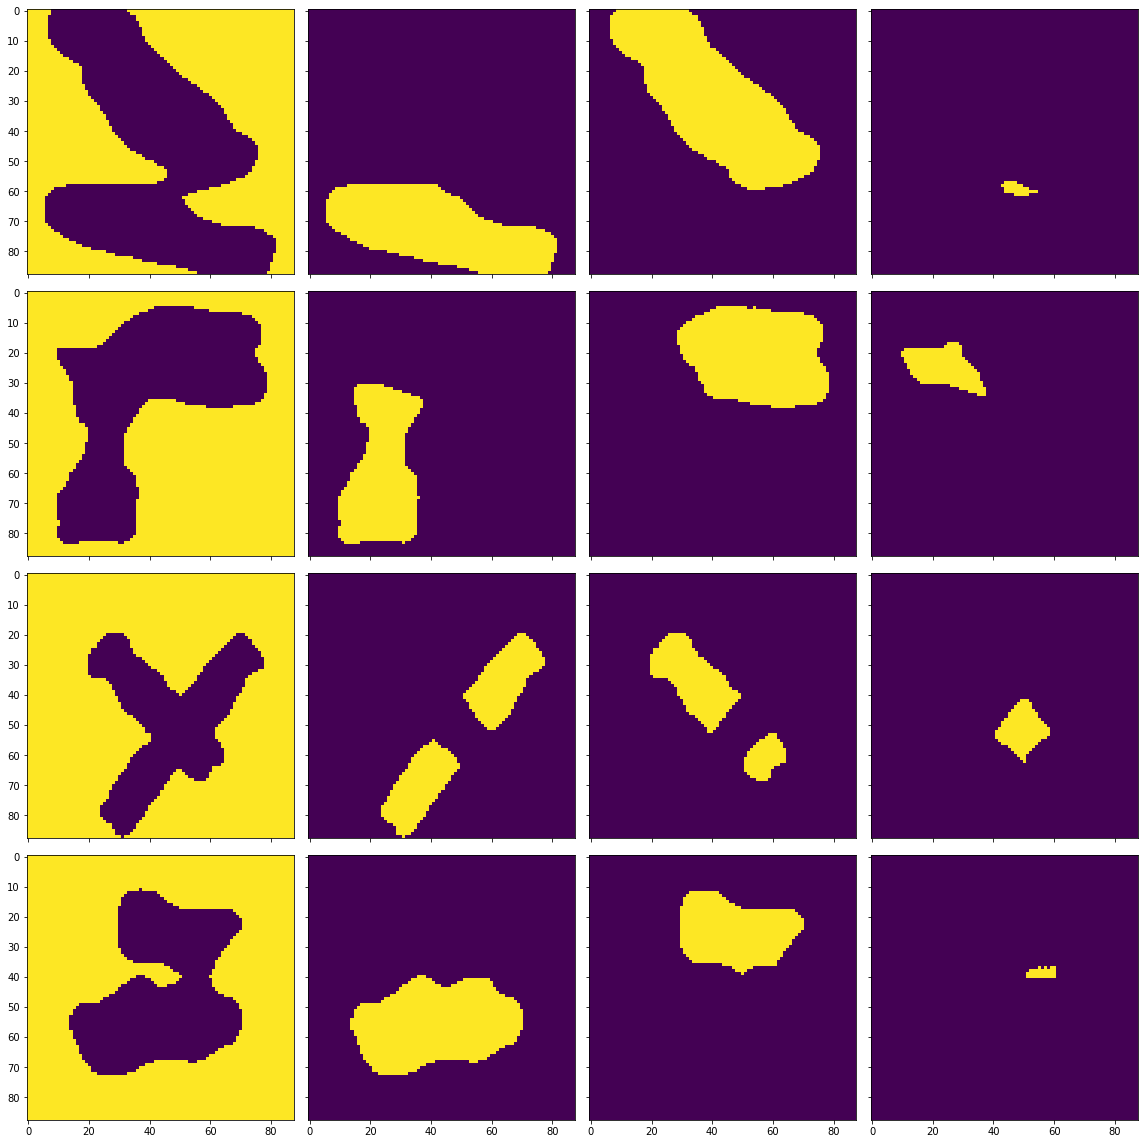

Training IOU: [0.9941826936712371, 0.9772319016591782, 0.9806270006215789, 0.9392435923482426]
Training accuracy: 0.9935398372933885
Testing IOU: [0.9700183554041384, 0.40231541626069073, 0.30375284209450654, 0.38568806157611674]
Testing accuracy: 0.8637177169421487
13/13 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0637
INFO:tensorflow:Assets written to: modelunet/savedmodel_242epoch\assets
4
4


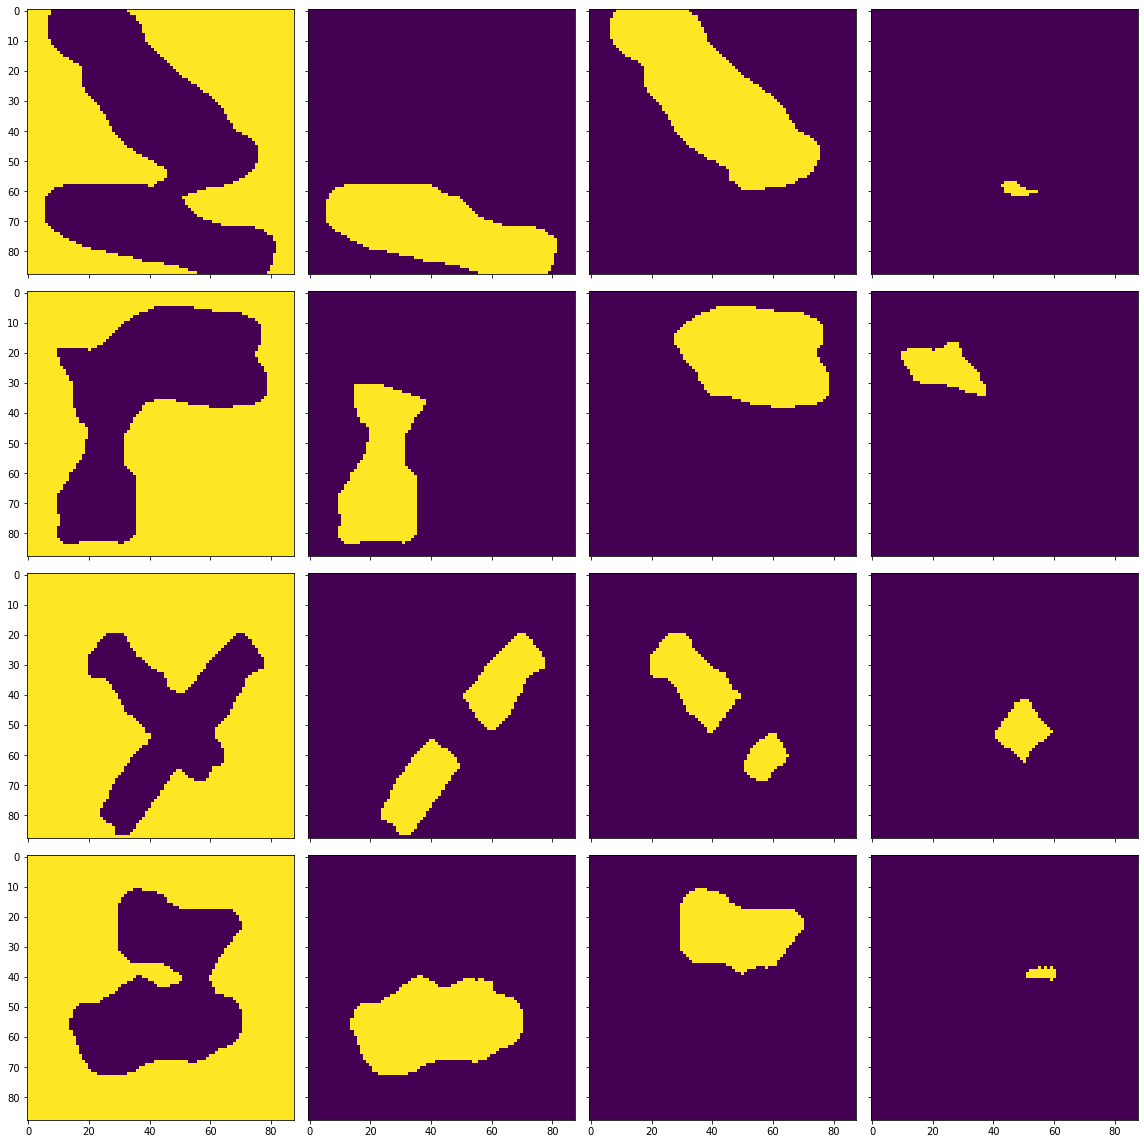

Training IOU: [0.9940010072582907, 0.9777625473506775, 0.98050507950832, 0.9455938050576556]
Training accuracy: 0.9939985795454546
Testing IOU: [0.9695368489715904, 0.3874625588361147, 0.31208053691275167, 0.3726216281310212]
Testing accuracy: 0.8625051652892562
13/13 [==============================] - 1s 67ms/step - loss: 0.0032 - val_loss: 0.0600
INFO:tensorflow:Assets written to: modelunet/savedmodel_243epoch\assets
4
4


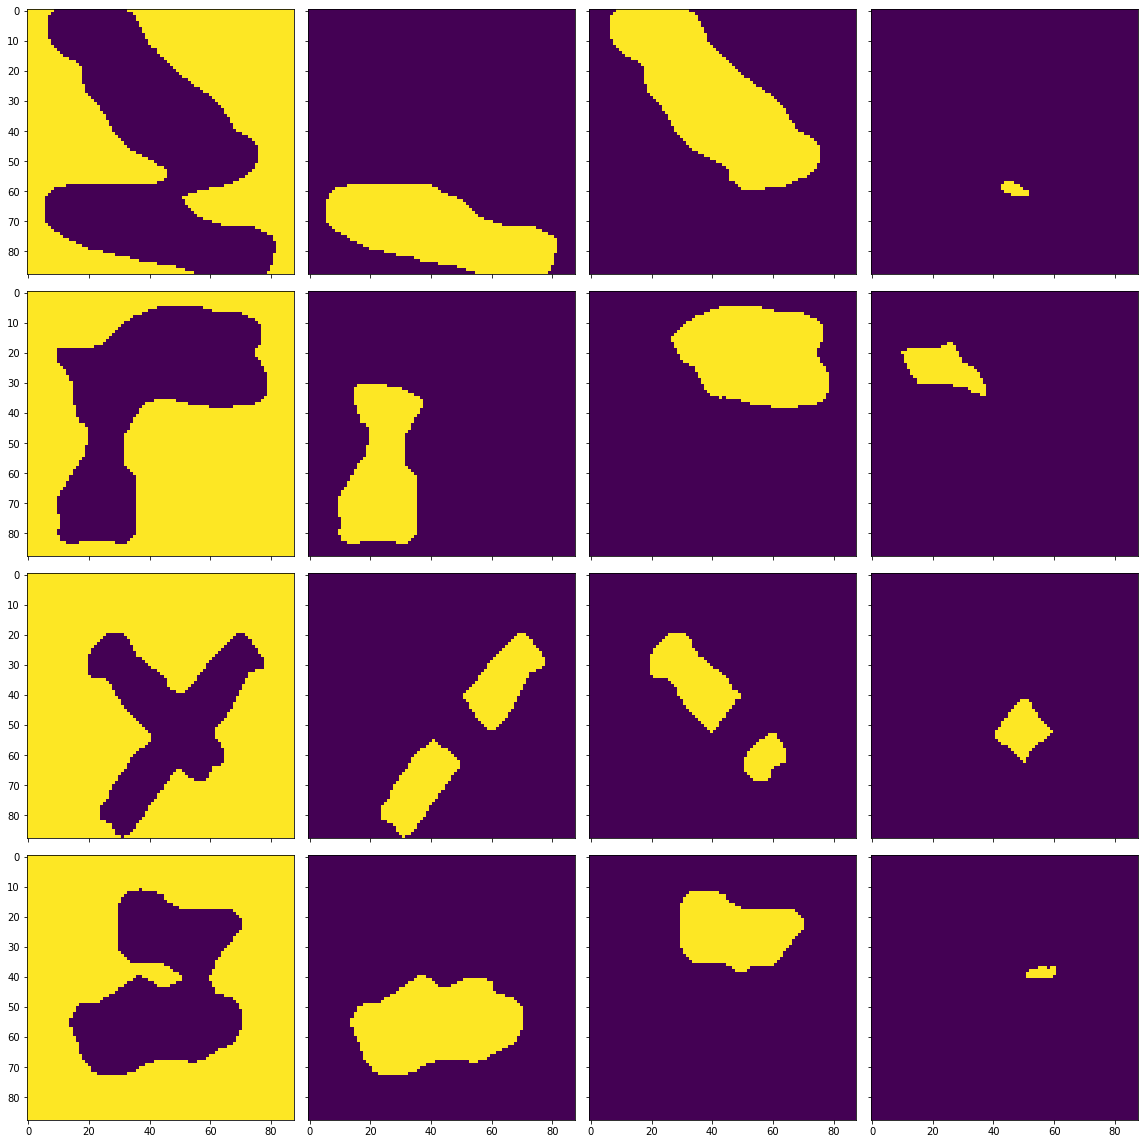

Training IOU: [0.9941404122016293, 0.9777258588639957, 0.9808086138399997, 0.9466427242993651]
Training accuracy: 0.9934294292355372
Testing IOU: [0.9696640619874519, 0.3950590036622963, 0.3127914611357094, 0.38403950803686576]
Testing accuracy: 0.8629790805785124
13/13 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0606
INFO:tensorflow:Assets written to: modelunet/savedmodel_244epoch\assets
4
4


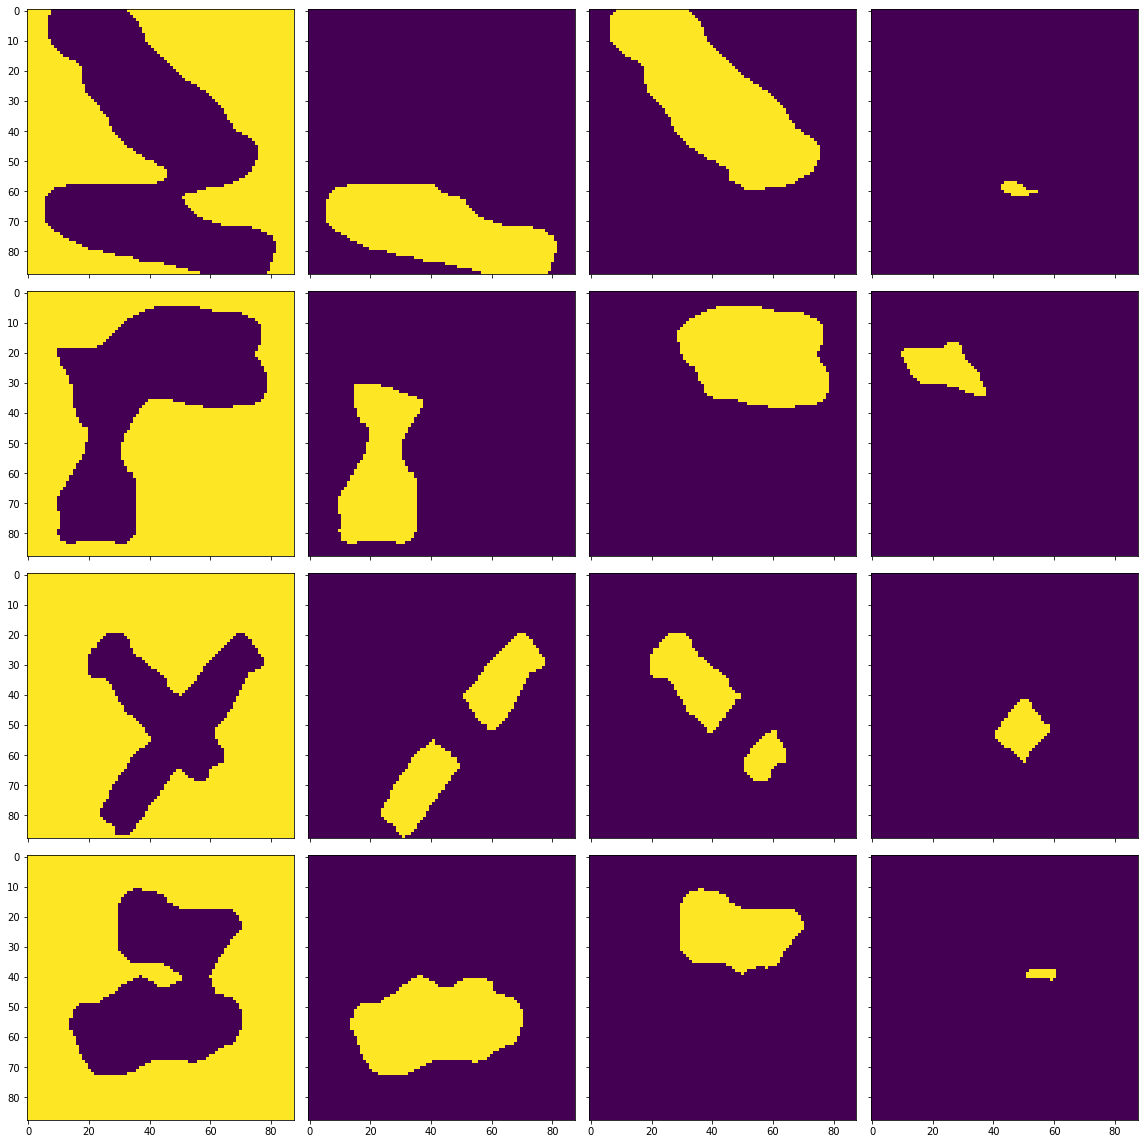

Training IOU: [0.9940232921972534, 0.9760098249466187, 0.9800728244712044, 0.9387902318969724]
Training accuracy: 0.9932254003099174
Testing IOU: [0.969567234797848, 0.3789965986394558, 0.32485573666125256, 0.37073170731707317]
Testing accuracy: 0.8619098657024793
13/13 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0617TA: 0s - loss: 0.003 - ETA: 0s - loss: 0.0
INFO:tensorflow:Assets written to: modelunet/savedmodel_245epoch\assets
4
4


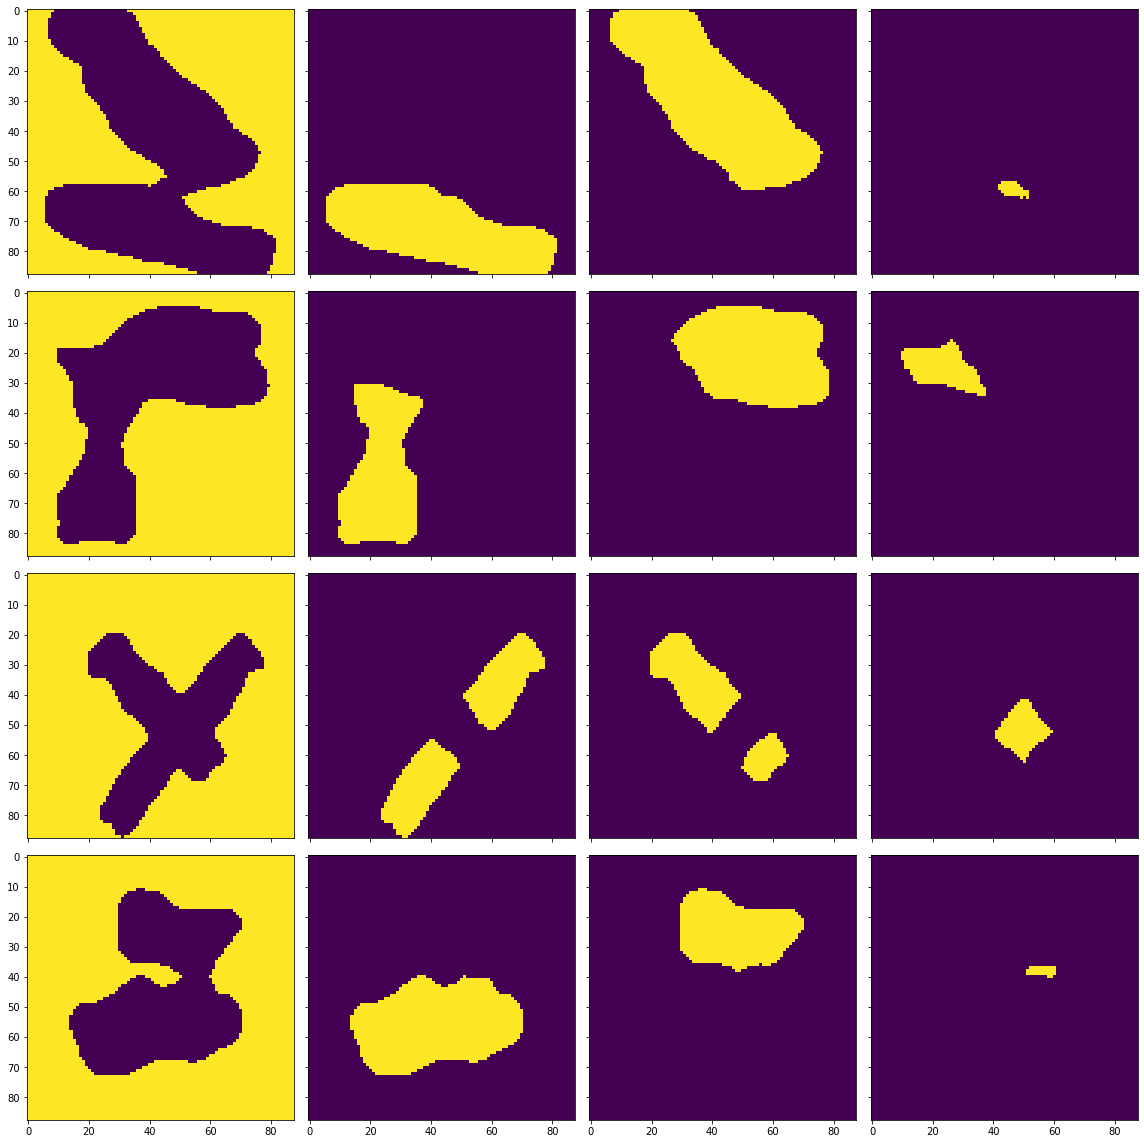

Training IOU: [0.9933761849169037, 0.9766528978036703, 0.9788391072392385, 0.9463027981700181]
Training accuracy: 0.9933881069214876
Testing IOU: [0.9704111495122175, 0.39179886261598323, 0.3256992447910261, 0.37472304283604135]
Testing accuracy: 0.8637732438016529
13/13 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0609
INFO:tensorflow:Assets written to: modelunet/savedmodel_246epoch\assets
4
4


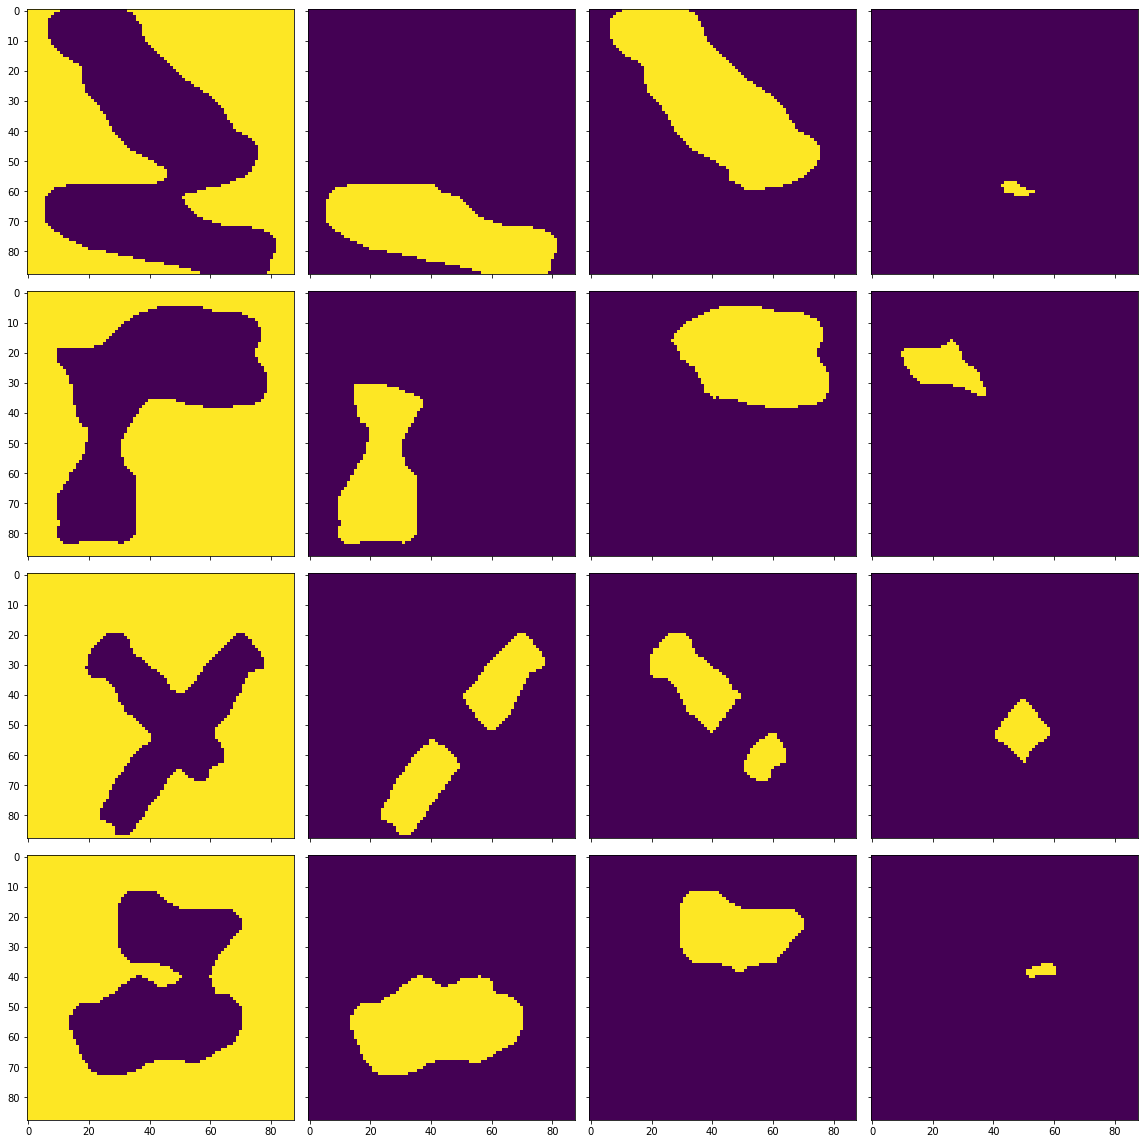

Training IOU: [0.9942411608436753, 0.9773671959431374, 0.9775501917684951, 0.9350318741580661]
Training accuracy: 0.9930923941115702
Testing IOU: [0.9700436040236584, 0.4051528078698408, 0.2949353234688338, 0.38494637263897236]
Testing accuracy: 0.8630320247933885
13/13 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0615
INFO:tensorflow:Assets written to: modelunet/savedmodel_247epoch\assets
4
4


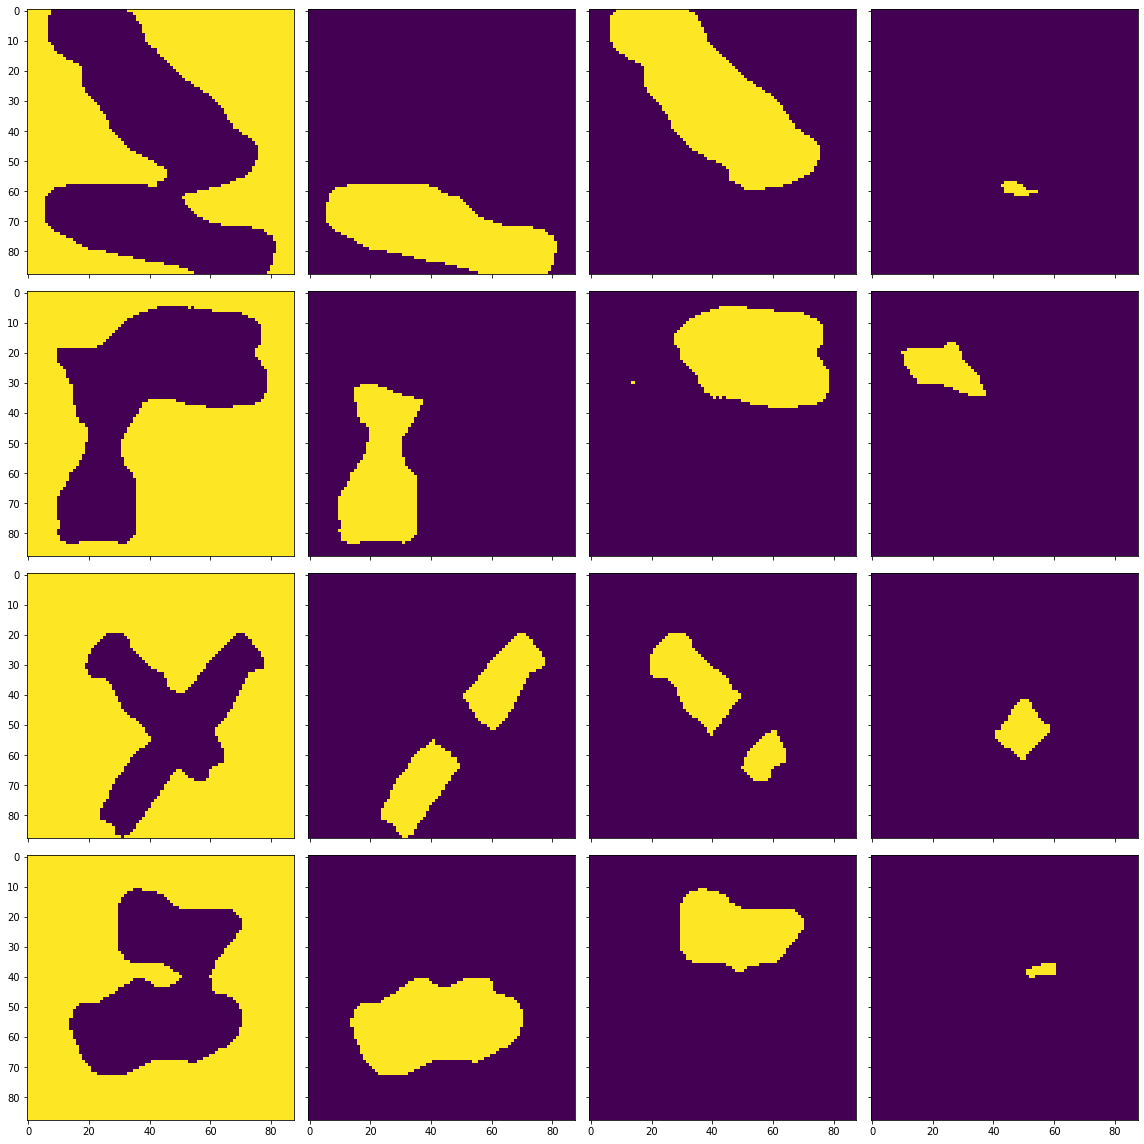

Training IOU: [0.9935696961242683, 0.971675734063381, 0.9763230745060648, 0.9162722702509413]
Training accuracy: 0.9920428719008264
Testing IOU: [0.9700486211349996, 0.35581317981948624, 0.3349425683077212, 0.365867175713538]
Testing accuracy: 0.8596513429752066
13/13 [==============================] - 1s 66ms/step - loss: 0.0033 - val_loss: 0.0615
INFO:tensorflow:Assets written to: modelunet/savedmodel_248epoch\assets
4
4


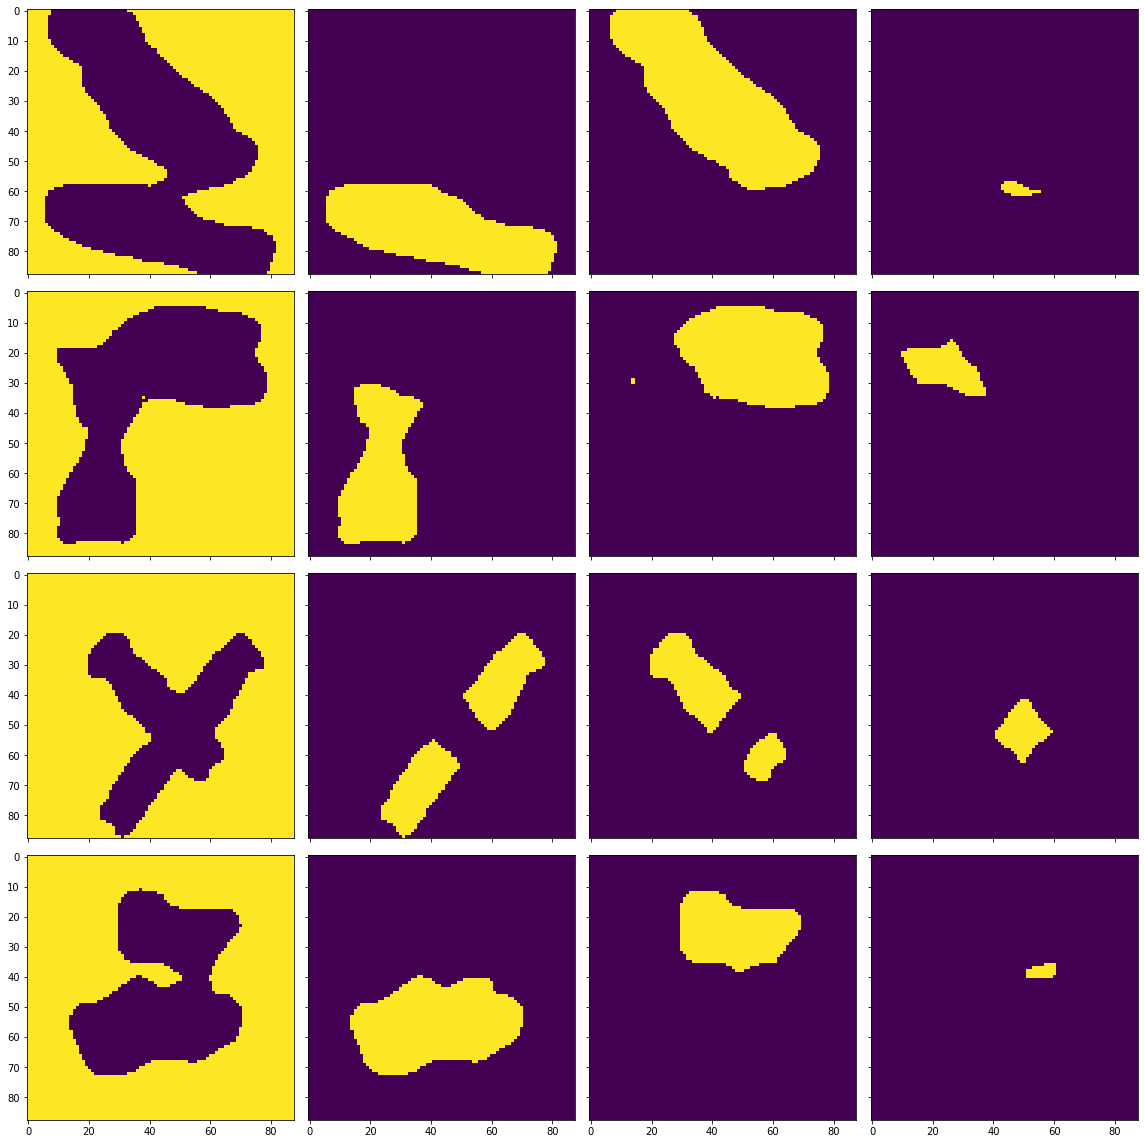

Training IOU: [0.9936360583446099, 0.9757401372807322, 0.9744168794943597, 0.9310986770946003]
Training accuracy: 0.9926969266528926
Testing IOU: [0.9700374855475845, 0.4007070344509986, 0.30316291345621726, 0.3780977178741002]
Testing accuracy: 0.863126291322314
13/13 [==============================] - 1s 67ms/step - loss: 0.0033 - val_loss: 0.0610
INFO:tensorflow:Assets written to: modelunet/savedmodel_249epoch\assets
4
4


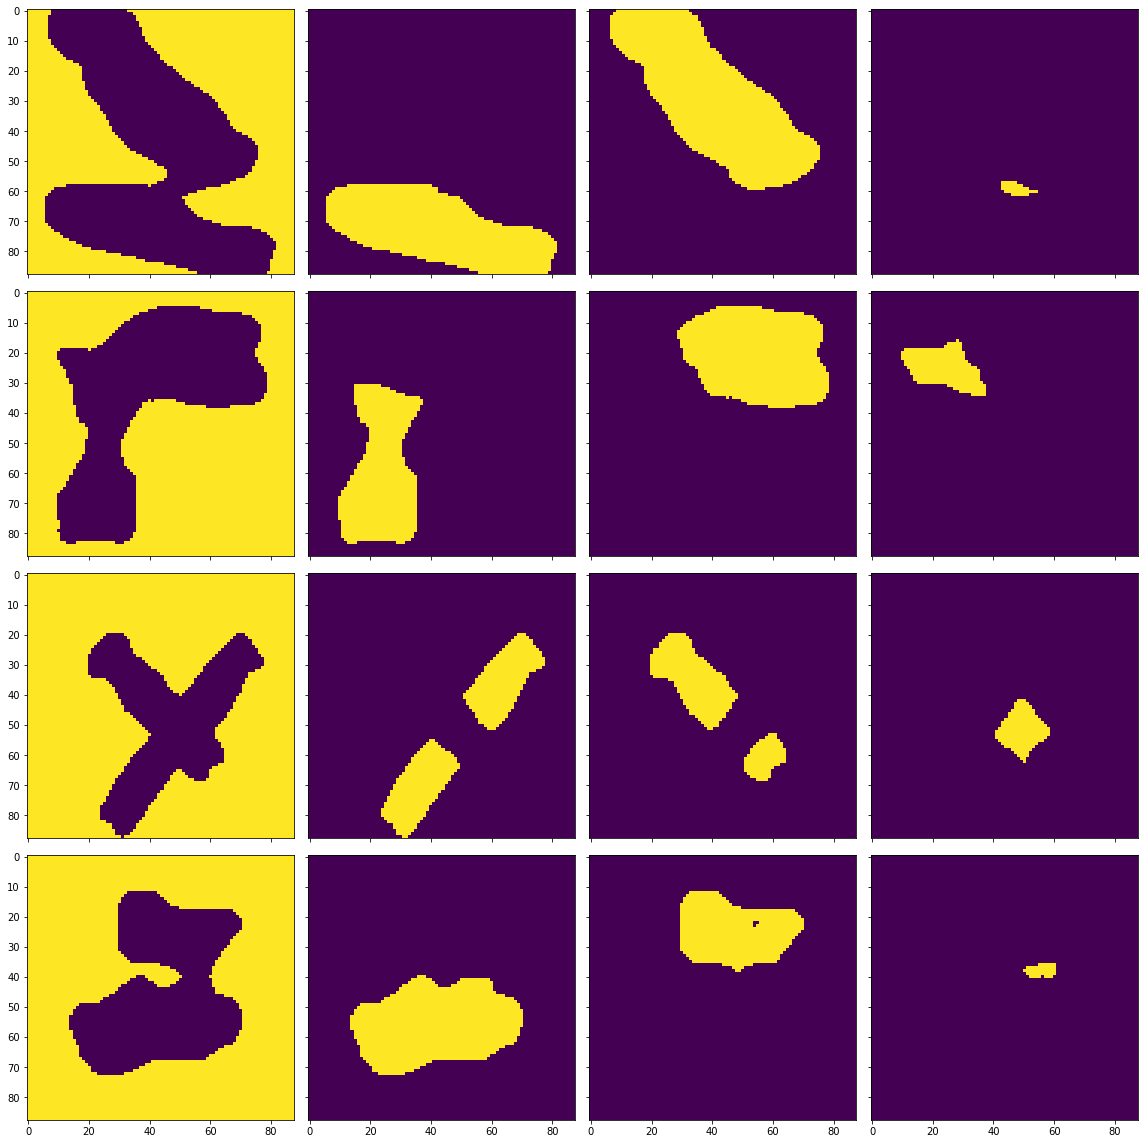

Training IOU: [0.9937369003168672, 0.9763644902841305, 0.9746386647252865, 0.9313783724638134]
Training accuracy: 0.9927989411157024
Testing IOU: [0.9700472883032667, 0.3944094305977159, 0.30086990535633806, 0.3751860288534548]
Testing accuracy: 0.8620196280991735


In [4]:

# Load data
xdata = np.load('xdata_88x88.npy')
labels = np.load('ydata_88x88_0123_onehot.npy')
train_test_boundary_index = round(500*.8)

model = OverlapSegmentationNet(input_shape=(88,88,1))

# Choose loss
model.compile(loss='mean_squared_error', optimizer='adam')

# Specify the number of epochs to run
num_epoch = 250
for i in range(num_epoch):
    
    # Fit
    model.fit(x=xdata, y=labels, epochs=1, validation_split=0.2) 
    os.makedirs('modelunet', exist_ok=True)
    filename = 'modelunet/savedmodel_' + str(i) + 'epoch'
    model.save(filename)
    
    # Predict and plot images
    predictions = model.predict(xdata[0:4,...])
    plotSamplesOneHots(predictions[0:4,...].round())
   
    # Calculate mIOU
    y_pred_train = model.predict(xdata[0:train_test_boundary_index,...]).round()
    trainIOU = IOU(y_pred_train, labels[0:train_test_boundary_index,...])
    print('Training IOU: ' + str(trainIOU))
    trainAccuracy = globalAccuracy(y_pred_train, labels[0:train_test_boundary_index,...])
    print('Training accuracy: ' + str(trainAccuracy))
    del y_pred_train
    
    y_pred_test = model.predict(xdata[train_test_boundary_index:,...]).round()
    testIOU = IOU(y_pred_test, labels[train_test_boundary_index:,...])
    print('Testing IOU: ' + str(testIOU))
    testAccuracy = globalAccuracy(y_pred_test, labels[train_test_boundary_index:,...])
    print('Testing accuracy: ' + str(testAccuracy))
    del y_pred_test


In [5]:

#A few useful metrics and losses


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / ((K.sum(y_true_f) + K.sum(y_pred_f) - intersection) + 1.0)


def precision(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    prec = (tp + smooth) / (tp + fp + smooth)
    return prec

def recall(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    tp = K.sum(y_pos * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall


def true_positive(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
    return tp

def true_negative(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
    return tn


def false_positive(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tp = (K.sum(y_neg * y_pred_pos) + smooth) / (K.sum(y_neg) + smooth)
    return tp

def false_negative(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_pos * y_pred_neg) + smooth) / (K.sum(y_pos) + smooth)
    return tn


def accuracy(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    tn = K.sum(y_neg * y_pred_neg)
    acc = (tp+tn + smooth) / (tp + tn + fn + fp + smooth)
    return acc

In [6]:
xdata = np.load('xdata_88x88.npy')
labels = np.load('ydata_88x88_0123_onehot.npy')
train_test_boundary_index = round(500*.8)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(xdata, labels , test_size=0.20, random_state=42)

In [8]:
dice = []
iou = []
sensi = []
speci = []
rec= []
prec = []
iou_1  = []
tpr_data = []
fpr_data = []
fnr_data = []
tnr_data = []
acc_data = []


predictions = model.predict(X_test[0:100,:,:,:])
predictions= np.float64(predictions)

for i in range(len(predictions)):

  predictions[i] = (predictions[i]+1)/2
  y_test[i:i+1,:,:,:] = (y_test[i:i+1,:,:,:][0]+1)/2

  acc_data.append(accuracy(predictions[i],y_test[i:i+1,:,:,:]))
  prec.append(precision(predictions[i],y_test[i:i+1,:,:,:])) 
  rec.append(recall(predictions[i],y_test[i:i+1,:,:,:]))
  iou.append(jacard_coef(predictions[i],y_test[i:i+1,:,:,:]))
  dice.append(dice_coef(predictions[i],y_test[i:i+1,:,:,:]))
  tpr_data.append(true_positive(predictions[i],y_test[i:i+1,:,:,:]))
  fpr_data.append(false_positive(predictions[i],y_test[i:i+1,:,:,:]))
  tnr_data.append(true_negative(predictions[i],y_test[i:i+1,:,:,:]))
  fnr_data.append(false_negative(predictions[i],y_test[i:i+1,:,:,:]))
  

In [9]:
print("Accuracy : ", np.mean(acc_data))
print("Precision : ", np.mean(prec))
print("Recall : ", np.mean(rec))
print("TPR : ", np.mean(tpr_data))
print("FPR: ", np.mean(fpr_data))
print("FNR: ", np.mean(fnr_data))
print("TNR: ", np.mean(tnr_data))
print("IOU: ", np.mean(iou))
print("DICE: ", np.mean(dice))

Accuracy :  0.6185329685174645
Precision :  0.693543180059184
Recall :  0.6953362534932965
TPR :  0.4439430712812992
FPR:  0.006024536379517051
FNR:  0.5561148263080189
TNR:  0.9940487711121583
IOU:  0.5328176238294886
DICE:  0.6951752813107207
